# Project OT-GAN (Optimal Transport course)
**VU Thi Hai Yen - master Data Science**
**haiyen96.hp@gmail.com**

## Imports

In [0]:
import numpy as np
import torch
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## Load MNIST data

In [29]:
transform = transforms.Compose([transforms.Resize((8,8)),
                                transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('MNIST_train', download=True, train=True, transform=transform)

Extracting MNIST_train/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_train/MNIST/raw



Extracting MNIST_train/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_train/MNIST/raw


Extracting MNIST_train/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_train/MNIST/raw


Extracting MNIST_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_train/MNIST/raw
Processing...
Done!


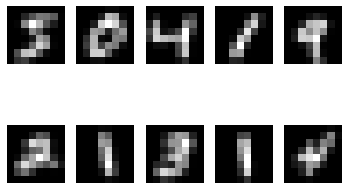

In [4]:
n_imgs = 10
figure = plt.figure()
for index in range(n_imgs):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(1-trainset[index][0].numpy().squeeze(), cmap='gray_r')

## OT-GAN

### Function to compute Sinkhorn distance between features

In [0]:
def sinkhorn_loss(x, y, epsilon=1., niter=50):
    """
    Compute sinkhorn loss with cosine similarity cost.
    Adapted from: https://github.com/gpeyre/SinkhornAutoDiff
    """

    # Compute the cosine similarity
    cosine = torch.nn.CosineSimilarity(dim=0)
    
    assert len(x) == len(y)

    n = len(x)

    C = [1-cosine(x[i], y[j]) for i in range(n) for j in range(n)]
    C = torch.stack(C).view(n,n)

    # both marginals are fixed with equal weights
    mu = Variable(1. /n * torch.FloatTensor(n).fill_(1), requires_grad=False).to(device)
    nu = Variable(1. /n * torch.FloatTensor(n).fill_(1), requires_grad=False).to(device)

    thresh = 10**(-1)  # stopping criterion

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) + 1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).cpu().data.numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)

    # Can use if do not want to backpropagate through pi
    # pi = pi.detach()

    cost = torch.sum(pi * C)  # Sinkhorn cost

    # If not x.grad will be None
    x.retain_grad()
    y.retain_grad()

    return cost

### Define Discriminator and Generator networks

#### MLP networks

We define simple MLP networks for Discriminator and Generator

In [0]:
class GeneratorMLP(nn.Module):
    def __init__(self, latent_dim=16, img_size=8):
        super(GeneratorMLP, self).__init__()
        self.img_size = img_size
        n_hidden_1 = 32
        n_hidden_2 = 64
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ReLU(),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.ReLU(),
            nn.Linear(n_hidden_2, img_size**2),
            nn.BatchNorm1d(img_size**2),
            nn.Tanh()
        )
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        x = x.view(x.size(0), 1, self.img_size, self.img_size)

        return x

class DiscriminatorMLP(nn.Module):
    def __init__(self, img_size=8, feature_dim=16):
        super(DiscriminatorMLP, self).__init__()

        n_hidden_1 = 64
        n_hidden_2 = 32
        self.mlp = nn.Sequential(
            nn.Linear(img_size**2, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ReLU(),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.ReLU(),
            nn.Linear(n_hidden_2, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x

#### CNN networks

Now we define CNN networks for Discriminator and Generator

In [0]:
class GeneratorCNN(nn.Module):
    def __init__(self, latent_dim=16, img_size=8):
        super(GeneratorCNN, self).__init__()

        self.init_size = img_size // 2

        n_filters_1 = 16
        n_filters_2 = 8

        self.linear_in = nn.Sequential(nn.Linear(latent_dim, n_filters_1 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(n_filters_1),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(n_filters_1, n_filters_2, 3, stride=1, padding=1),
            nn.BatchNorm2d(n_filters_2, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_filters_2, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.linear_in(z)

        out = out.view(out.shape[0], -1, self.init_size, self.init_size)
        img = self.conv_blocks(out)

        return img


class DiscriminatorCNN(nn.Module):
    def __init__(self, img_size=8, feature_dim=16):
        super(DiscriminatorCNN, self).__init__()

        n_filters_1 = 8
        n_filters_2 = 16

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, n_filters_1, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(n_filters_1, n_filters_2, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(n_filters_2, 0.8)
        )

        ds_size = img_size // 2 ** 2
        self.linear_out = nn.Linear(n_filters_2 * ds_size ** 2, feature_dim)

    def forward(self, img):
    
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        out = self.linear_out(out)

        return out

### Initialize the networks

We now create the models

In [55]:
img_size = trainset[0][0].size(1)
dim_gen = 16
dim_features_critics = 16

model_type = 'cnn'

if model_type == 'cnn':
    # Initialize CNN generator and discriminator
    generator = GeneratorCNN(dim_gen, img_size).to(device)
    discriminator = DiscriminatorCNN(img_size, dim_features_critics).to(device)

elif model_type == 'mlp':
    # Initialize MLP generator and discriminator
    generator = GeneratorMLP(dim_gen, img_size)
    discriminator = DiscriminatorMLP(img_size, dim_features_critics)

print(generator)
print(discriminator)

GeneratorCNN(
  (linear_in): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(8, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Tanh()
  )
)
DiscriminatorCNN(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(16, eps=0.8, 

Create the optimizers

In [0]:
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
G_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

### Define functions for training

A function to generate and plot sampled images

In [0]:
def generate_plt():
    """
    Function to sample images with the generator and plot them.
    """
    n_imgs = 10
    hid_y = torch.randn(n_imgs, dim_gen).to(device)
    gen_imgs = generator(hid_y)
    figure = plt.figure()
    for index in range(n_imgs):
        plt.subplot(2, 5, index+1)
        plt.axis('off')
        plt.imshow(1 - gen_imgs[index].view(img_size,img_size).cpu().detach().numpy(), cmap='gray_r')
    plt.show()

Define train function

In [0]:
def train(n_gen=5, n_epochs = 10, batch_size = 64, printbatch = True, plt_samples = -1, epsilon=1.):
  """
  Function to train the OT-GAN model.
  Note: the batch_size is the total number of samples in X and X', hence it is double the actual batch size.
  """
  try:
    discriminator.train()
    generator.train()

    history = []

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs) :
        start_time_epoch = time()
        print("========================Epoch:", epoch +1 ,"/",n_epochs,"=======================")
        epoch_loss = 0.0
        for i, data in enumerate(trainloader) :
            start_time = time()

            img_real, _ = data
            m = len(img_real)//2

            # Get batches X, X'
            img_x_1 = img_real[:m].to(device)
            img_x_2 = img_real[m:2*m].to(device)

            # Random variables to generate Y, Y' 
            hid_y_1 = torch.randn(m, dim_gen).to(device)
            hid_y_2 = torch.randn(m, dim_gen).to(device)

            # Compute features with disciminator
            feats_x_1 = discriminator(img_x_1)
            feats_x_2 = discriminator(img_x_2)

            feats_y_1 = discriminator(generator(hid_y_1))
            feats_y_2 = discriminator(generator(hid_y_2))

            # print("Compute loss")
            loss = sinkhorn_loss(feats_x_1, feats_y_1, epsilon=epsilon) \
                    + sinkhorn_loss(feats_x_1, feats_y_2, epsilon=epsilon) \
                    + sinkhorn_loss(feats_x_2, feats_y_1, epsilon=epsilon) \
                    + sinkhorn_loss(feats_x_2, feats_y_2, epsilon=epsilon) \
                    - 2 * sinkhorn_loss(feats_x_1, feats_x_2, epsilon=epsilon) \
                    - 2 * sinkhorn_loss(feats_y_1, feats_y_2, epsilon=epsilon) \

            # check isnan:
            if not loss != loss:

                if i % (n_gen + 1) == 0:
                    # Optimize the discriminator
                    # autograd
                    D_optimizer.zero_grad()
                    (-loss).backward()
                    D_optimizer.step()

                    # # Weights clipping
                    # for p in discriminator.parameters():
                    #     p.data.clamp_(-0.01, 0.01)

                    optim_what= "Opimize D"
                else :
                    # Optimize the generator
                    # autograd
                    G_optimizer.zero_grad()
                    loss.backward()
                    G_optimizer.step()

                    optim_what = "Opimize G"

                batch_loss = loss.data.item()
                epoch_loss += batch_loss

                history.append(batch_loss)

            else:
              print("NaN detected, stop!")
              return history

            if printbatch:
                print('Batch {:d}/{:d} - {} - Avg Batch Loss: {:.4f} - Time : {:.2f}s'.format(i+1, len(trainloader), optim_what,
                                    batch_loss, time() - start_time))
                
            if plt_samples > 0 and i % plt_samples == 0:
                generate_plt()

        print('Epoch {:d} completed in {:.2f} seconds ! Avg Epoch Loss: {:.4f}'.format(
                      epoch + 1 , time() - start_time_epoch, epoch_loss/len(trainloader)))

  except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stop!")
    pass

  return history


### Train the (CNN) model

========================Epoch: 1 / 1 =======================
Batch 1/938 - Opimize D - Avg Batch Loss: 0.3398 - Time : 4.02s


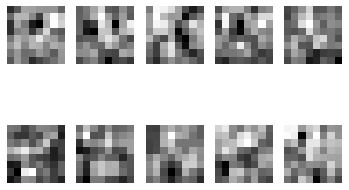

Batch 2/938 - Opimize G - Avg Batch Loss: 0.3849 - Time : 3.73s
Batch 3/938 - Opimize G - Avg Batch Loss: 0.5311 - Time : 3.41s
Batch 4/938 - Opimize G - Avg Batch Loss: 0.3850 - Time : 3.72s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.3884 - Time : 3.65s
Batch 6/938 - Opimize G - Avg Batch Loss: 0.3826 - Time : 3.47s
Batch 7/938 - Opimize D - Avg Batch Loss: 0.3262 - Time : 3.55s
Batch 8/938 - Opimize G - Avg Batch Loss: 0.4109 - Time : 3.60s
Batch 9/938 - Opimize G - Avg Batch Loss: 0.4062 - Time : 3.57s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.3662 - Time : 3.62s
Batch 11/938 - Opimize G - Avg Batch Loss: 0.3953 - Time : 3.80s
Batch 12/938 - Opimize G - Avg Batch Loss: 0.3898 - Time : 3.68s
Batch 13/938 - Opimize D - Avg Batch Loss: 0.4128 - Time : 3.38s
Batch 14/938 - Opimize G - Avg Batch Loss: 0.3065 - Time : 3.36s
Batch 15/938 - Opimize G - Avg Batch Loss: 0.3094 - Time : 3.51s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.3093 - Time : 3.75s
Batch 17/938 - Opimize G - Avg Ba

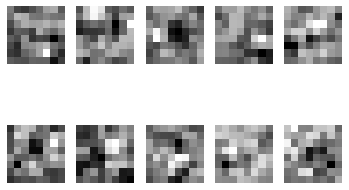

Batch 22/938 - Opimize G - Avg Batch Loss: 0.2959 - Time : 4.09s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.4211 - Time : 3.47s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.4287 - Time : 3.35s
Batch 25/938 - Opimize D - Avg Batch Loss: 0.3511 - Time : 3.56s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.4522 - Time : 3.52s
Batch 27/938 - Opimize G - Avg Batch Loss: 0.4280 - Time : 3.54s
Batch 28/938 - Opimize G - Avg Batch Loss: 0.3392 - Time : 3.59s
Batch 29/938 - Opimize G - Avg Batch Loss: 0.4329 - Time : 3.42s
Batch 30/938 - Opimize G - Avg Batch Loss: 0.3545 - Time : 3.51s
Batch 31/938 - Opimize D - Avg Batch Loss: 0.3900 - Time : 3.67s
Batch 32/938 - Opimize G - Avg Batch Loss: 0.3709 - Time : 3.40s
Batch 33/938 - Opimize G - Avg Batch Loss: 0.4965 - Time : 3.38s
Batch 34/938 - Opimize G - Avg Batch Loss: 0.4280 - Time : 3.87s
Batch 35/938 - Opimize G - Avg Batch Loss: 0.3745 - Time : 3.54s
Batch 36/938 - Opimize G - Avg Batch Loss: 0.3647 - Time : 3.53s
Batch 37/938 - Opimize D 

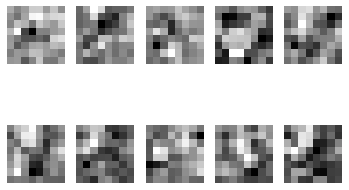

Batch 42/938 - Opimize G - Avg Batch Loss: 0.4418 - Time : 3.50s
Batch 43/938 - Opimize D - Avg Batch Loss: 0.3638 - Time : 3.97s
Batch 44/938 - Opimize G - Avg Batch Loss: 0.3715 - Time : 3.45s
Batch 45/938 - Opimize G - Avg Batch Loss: 0.3793 - Time : 3.60s
Batch 46/938 - Opimize G - Avg Batch Loss: 0.3618 - Time : 3.51s
Batch 47/938 - Opimize G - Avg Batch Loss: 0.3696 - Time : 3.40s
Batch 48/938 - Opimize G - Avg Batch Loss: 0.3037 - Time : 3.72s
Batch 49/938 - Opimize D - Avg Batch Loss: 0.3801 - Time : 3.67s
Batch 50/938 - Opimize G - Avg Batch Loss: 0.3765 - Time : 3.43s
Batch 51/938 - Opimize G - Avg Batch Loss: 0.4401 - Time : 3.46s
Batch 52/938 - Opimize G - Avg Batch Loss: 0.3832 - Time : 3.50s
Batch 53/938 - Opimize G - Avg Batch Loss: 0.3137 - Time : 3.80s
Batch 54/938 - Opimize G - Avg Batch Loss: 0.3794 - Time : 3.82s
Batch 55/938 - Opimize D - Avg Batch Loss: 0.4022 - Time : 3.37s
Batch 56/938 - Opimize G - Avg Batch Loss: 0.4448 - Time : 3.76s
Batch 57/938 - Opimize G 

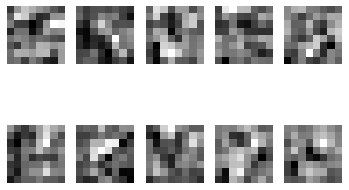

Batch 62/938 - Opimize G - Avg Batch Loss: 0.3079 - Time : 3.40s
Batch 63/938 - Opimize G - Avg Batch Loss: 0.4733 - Time : 3.56s
Batch 64/938 - Opimize G - Avg Batch Loss: 0.3703 - Time : 3.49s
Batch 65/938 - Opimize G - Avg Batch Loss: 0.3825 - Time : 3.47s
Batch 66/938 - Opimize G - Avg Batch Loss: 0.3358 - Time : 3.68s
Batch 67/938 - Opimize D - Avg Batch Loss: 0.4506 - Time : 3.46s
Batch 68/938 - Opimize G - Avg Batch Loss: 0.3761 - Time : 3.46s
Batch 69/938 - Opimize G - Avg Batch Loss: 0.3421 - Time : 3.68s
Batch 70/938 - Opimize G - Avg Batch Loss: 0.3912 - Time : 3.46s
Batch 71/938 - Opimize G - Avg Batch Loss: 0.3804 - Time : 3.74s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.3716 - Time : 3.43s
Batch 73/938 - Opimize D - Avg Batch Loss: 0.4455 - Time : 3.45s
Batch 74/938 - Opimize G - Avg Batch Loss: 0.4961 - Time : 3.63s
Batch 75/938 - Opimize G - Avg Batch Loss: 0.3222 - Time : 3.48s
Batch 76/938 - Opimize G - Avg Batch Loss: 0.3295 - Time : 3.59s
Batch 77/938 - Opimize G 

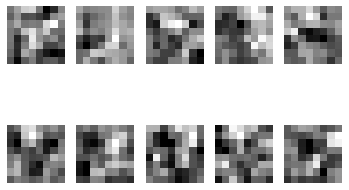

Batch 82/938 - Opimize G - Avg Batch Loss: 0.3608 - Time : 3.41s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.3620 - Time : 3.66s
Batch 84/938 - Opimize G - Avg Batch Loss: 0.3805 - Time : 3.40s
Batch 85/938 - Opimize D - Avg Batch Loss: 0.3443 - Time : 3.65s
Batch 86/938 - Opimize G - Avg Batch Loss: 0.3676 - Time : 4.09s
Batch 87/938 - Opimize G - Avg Batch Loss: 0.4884 - Time : 3.50s
Batch 88/938 - Opimize G - Avg Batch Loss: 0.4117 - Time : 3.60s
Batch 89/938 - Opimize G - Avg Batch Loss: 0.3972 - Time : 3.50s
Batch 90/938 - Opimize G - Avg Batch Loss: 0.3497 - Time : 3.69s
Batch 91/938 - Opimize D - Avg Batch Loss: 0.3310 - Time : 3.76s
Batch 92/938 - Opimize G - Avg Batch Loss: 0.4424 - Time : 3.54s
Batch 93/938 - Opimize G - Avg Batch Loss: 0.3021 - Time : 3.55s
Batch 94/938 - Opimize G - Avg Batch Loss: 0.3853 - Time : 3.66s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.3891 - Time : 3.67s
Batch 96/938 - Opimize G - Avg Batch Loss: 0.3940 - Time : 3.56s
Batch 97/938 - Opimize D 

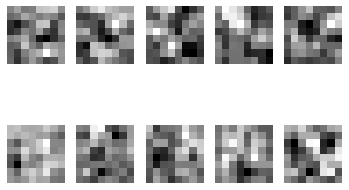

Batch 102/938 - Opimize G - Avg Batch Loss: 0.2980 - Time : 3.57s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.5269 - Time : 3.79s
Batch 104/938 - Opimize G - Avg Batch Loss: 0.3359 - Time : 3.54s
Batch 105/938 - Opimize G - Avg Batch Loss: 0.3920 - Time : 3.57s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.3396 - Time : 3.73s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.3623 - Time : 3.55s
Batch 108/938 - Opimize G - Avg Batch Loss: 0.3822 - Time : 3.79s
Batch 109/938 - Opimize D - Avg Batch Loss: 0.3881 - Time : 3.61s
Batch 110/938 - Opimize G - Avg Batch Loss: 0.5323 - Time : 3.87s
Batch 111/938 - Opimize G - Avg Batch Loss: 0.3286 - Time : 3.52s
Batch 112/938 - Opimize G - Avg Batch Loss: 0.4020 - Time : 3.53s
Batch 113/938 - Opimize G - Avg Batch Loss: 0.4640 - Time : 3.52s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.3494 - Time : 3.78s
Batch 115/938 - Opimize D - Avg Batch Loss: 0.3681 - Time : 3.90s
Batch 116/938 - Opimize G - Avg Batch Loss: 0.4001 - Time : 3.67s
Batch 117/

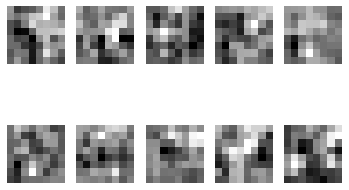

Batch 122/938 - Opimize G - Avg Batch Loss: 0.4518 - Time : 3.80s
Batch 123/938 - Opimize G - Avg Batch Loss: 0.4229 - Time : 3.50s
Batch 124/938 - Opimize G - Avg Batch Loss: 0.3504 - Time : 3.45s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.3643 - Time : 3.69s
Batch 126/938 - Opimize G - Avg Batch Loss: 0.3165 - Time : 3.43s
Batch 127/938 - Opimize D - Avg Batch Loss: 0.3972 - Time : 3.43s
Batch 128/938 - Opimize G - Avg Batch Loss: 0.5013 - Time : 3.50s
Batch 129/938 - Opimize G - Avg Batch Loss: 0.3129 - Time : 3.60s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.3891 - Time : 3.47s
Batch 131/938 - Opimize G - Avg Batch Loss: 0.4539 - Time : 3.61s
Batch 132/938 - Opimize G - Avg Batch Loss: 0.3709 - Time : 3.65s
Batch 133/938 - Opimize D - Avg Batch Loss: 0.4335 - Time : 3.68s
Batch 134/938 - Opimize G - Avg Batch Loss: 0.3321 - Time : 3.63s
Batch 135/938 - Opimize G - Avg Batch Loss: 0.3881 - Time : 3.65s
Batch 136/938 - Opimize G - Avg Batch Loss: 0.2802 - Time : 4.20s
Batch 137/

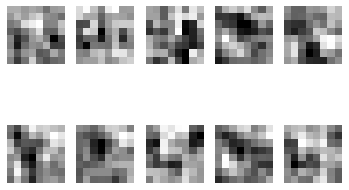

Batch 142/938 - Opimize G - Avg Batch Loss: 0.3243 - Time : 3.53s
Batch 143/938 - Opimize G - Avg Batch Loss: 0.3995 - Time : 3.76s
Batch 144/938 - Opimize G - Avg Batch Loss: 0.4743 - Time : 3.91s
Batch 145/938 - Opimize D - Avg Batch Loss: 0.3432 - Time : 3.50s
Batch 146/938 - Opimize G - Avg Batch Loss: 0.3953 - Time : 3.52s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.3678 - Time : 3.44s
Batch 148/938 - Opimize G - Avg Batch Loss: 0.3365 - Time : 3.92s
Batch 149/938 - Opimize G - Avg Batch Loss: 0.4082 - Time : 3.45s
Batch 150/938 - Opimize G - Avg Batch Loss: 0.3225 - Time : 3.62s
Batch 151/938 - Opimize D - Avg Batch Loss: 0.3128 - Time : 3.42s
Batch 152/938 - Opimize G - Avg Batch Loss: 0.4317 - Time : 3.68s
Batch 153/938 - Opimize G - Avg Batch Loss: 0.2794 - Time : 3.65s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.3066 - Time : 3.62s
Batch 155/938 - Opimize G - Avg Batch Loss: 0.3868 - Time : 3.55s
Batch 156/938 - Opimize G - Avg Batch Loss: 0.3772 - Time : 3.39s
Batch 157/

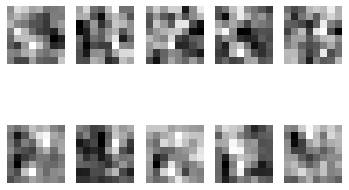

Batch 162/938 - Opimize G - Avg Batch Loss: 0.2692 - Time : 3.53s
Batch 163/938 - Opimize D - Avg Batch Loss: 0.3378 - Time : 3.43s
Batch 164/938 - Opimize G - Avg Batch Loss: 0.3302 - Time : 3.40s
Batch 165/938 - Opimize G - Avg Batch Loss: 0.3480 - Time : 3.45s
Batch 166/938 - Opimize G - Avg Batch Loss: 0.4481 - Time : 3.79s
Batch 167/938 - Opimize G - Avg Batch Loss: 0.3681 - Time : 3.41s
Batch 168/938 - Opimize G - Avg Batch Loss: 0.3620 - Time : 3.52s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.3166 - Time : 3.45s
Batch 170/938 - Opimize G - Avg Batch Loss: 0.3627 - Time : 3.37s
Batch 171/938 - Opimize G - Avg Batch Loss: 0.3419 - Time : 3.62s
Batch 172/938 - Opimize G - Avg Batch Loss: 0.2513 - Time : 3.50s
Batch 173/938 - Opimize G - Avg Batch Loss: 0.2536 - Time : 3.48s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.4225 - Time : 3.47s
Batch 175/938 - Opimize D - Avg Batch Loss: 0.3145 - Time : 3.50s
Batch 176/938 - Opimize G - Avg Batch Loss: 0.2835 - Time : 3.53s
Batch 177/

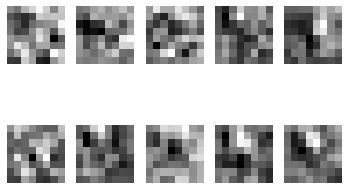

Batch 182/938 - Opimize G - Avg Batch Loss: 0.3526 - Time : 3.90s
Batch 183/938 - Opimize G - Avg Batch Loss: 0.2989 - Time : 3.38s
Batch 184/938 - Opimize G - Avg Batch Loss: 0.2543 - Time : 3.48s
Batch 185/938 - Opimize G - Avg Batch Loss: 0.3153 - Time : 3.63s
Batch 186/938 - Opimize G - Avg Batch Loss: 0.3719 - Time : 3.71s
Batch 187/938 - Opimize D - Avg Batch Loss: 0.2817 - Time : 3.76s
Batch 188/938 - Opimize G - Avg Batch Loss: 0.3204 - Time : 3.47s
Batch 189/938 - Opimize G - Avg Batch Loss: 0.3157 - Time : 3.65s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.3948 - Time : 3.70s
Batch 191/938 - Opimize G - Avg Batch Loss: 0.2959 - Time : 3.70s
Batch 192/938 - Opimize G - Avg Batch Loss: 0.3766 - Time : 3.77s
Batch 193/938 - Opimize D - Avg Batch Loss: 0.4411 - Time : 3.64s
Batch 194/938 - Opimize G - Avg Batch Loss: 0.3689 - Time : 3.75s
Batch 195/938 - Opimize G - Avg Batch Loss: 0.3603 - Time : 3.47s
Batch 196/938 - Opimize G - Avg Batch Loss: 0.2295 - Time : 3.49s
Batch 197/

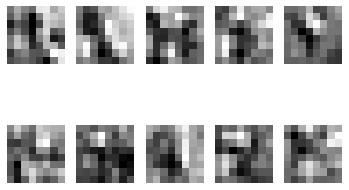

Batch 202/938 - Opimize G - Avg Batch Loss: 0.3577 - Time : 3.63s
Batch 203/938 - Opimize G - Avg Batch Loss: 0.2982 - Time : 3.54s
Batch 204/938 - Opimize G - Avg Batch Loss: 0.3123 - Time : 3.60s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.3564 - Time : 3.44s
Batch 206/938 - Opimize G - Avg Batch Loss: 0.3665 - Time : 3.88s
Batch 207/938 - Opimize G - Avg Batch Loss: 0.3367 - Time : 3.60s
Batch 208/938 - Opimize G - Avg Batch Loss: 0.2685 - Time : 3.44s
Batch 209/938 - Opimize G - Avg Batch Loss: 0.2471 - Time : 3.83s
Batch 210/938 - Opimize G - Avg Batch Loss: 0.2920 - Time : 3.53s
Batch 211/938 - Opimize D - Avg Batch Loss: 0.3206 - Time : 3.64s
Batch 212/938 - Opimize G - Avg Batch Loss: 0.2542 - Time : 3.43s
Batch 213/938 - Opimize G - Avg Batch Loss: 0.2576 - Time : 3.64s
Batch 214/938 - Opimize G - Avg Batch Loss: 0.2992 - Time : 3.44s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.2681 - Time : 3.58s
Batch 216/938 - Opimize G - Avg Batch Loss: 0.3378 - Time : 3.51s
Batch 217/

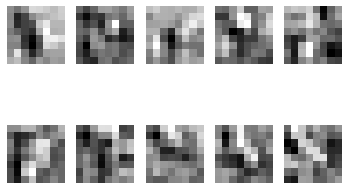

Batch 222/938 - Opimize G - Avg Batch Loss: 0.2373 - Time : 3.80s
Batch 223/938 - Opimize D - Avg Batch Loss: 0.3386 - Time : 3.85s
Batch 224/938 - Opimize G - Avg Batch Loss: 0.2906 - Time : 3.74s
Batch 225/938 - Opimize G - Avg Batch Loss: 0.3581 - Time : 3.83s
Batch 226/938 - Opimize G - Avg Batch Loss: 0.2749 - Time : 3.67s
Batch 227/938 - Opimize G - Avg Batch Loss: 0.3464 - Time : 3.71s
Batch 228/938 - Opimize G - Avg Batch Loss: 0.2700 - Time : 3.63s
Batch 229/938 - Opimize D - Avg Batch Loss: 0.2162 - Time : 3.76s
Batch 230/938 - Opimize G - Avg Batch Loss: 0.3076 - Time : 4.04s
Batch 231/938 - Opimize G - Avg Batch Loss: 0.1967 - Time : 3.95s
Batch 232/938 - Opimize G - Avg Batch Loss: 0.3002 - Time : 3.66s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.2540 - Time : 3.75s
Batch 234/938 - Opimize G - Avg Batch Loss: 0.2291 - Time : 3.80s
Batch 235/938 - Opimize D - Avg Batch Loss: 0.2829 - Time : 3.42s
Batch 236/938 - Opimize G - Avg Batch Loss: 0.2224 - Time : 3.41s
Batch 237/

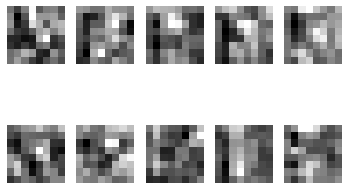

Batch 242/938 - Opimize G - Avg Batch Loss: 0.2642 - Time : 3.77s
Batch 243/938 - Opimize G - Avg Batch Loss: 0.2052 - Time : 3.43s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.2656 - Time : 3.48s
Batch 245/938 - Opimize G - Avg Batch Loss: 0.2593 - Time : 3.51s
Batch 246/938 - Opimize G - Avg Batch Loss: 0.2197 - Time : 3.38s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.2225 - Time : 3.41s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.2399 - Time : 3.49s
Batch 249/938 - Opimize G - Avg Batch Loss: 0.2407 - Time : 3.54s
Batch 250/938 - Opimize G - Avg Batch Loss: 0.2473 - Time : 3.45s
Batch 251/938 - Opimize G - Avg Batch Loss: 0.2792 - Time : 3.79s
Batch 252/938 - Opimize G - Avg Batch Loss: 0.2493 - Time : 3.73s
Batch 253/938 - Opimize D - Avg Batch Loss: 0.3066 - Time : 3.53s
Batch 254/938 - Opimize G - Avg Batch Loss: 0.2150 - Time : 3.37s
Batch 255/938 - Opimize G - Avg Batch Loss: 0.2486 - Time : 3.76s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.2548 - Time : 3.71s
Batch 257/

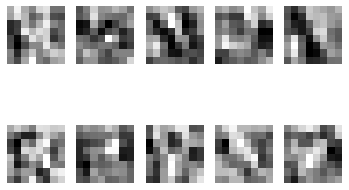

Batch 262/938 - Opimize G - Avg Batch Loss: 0.2849 - Time : 3.54s
Batch 263/938 - Opimize G - Avg Batch Loss: 0.2333 - Time : 3.51s
Batch 264/938 - Opimize G - Avg Batch Loss: 0.2637 - Time : 3.50s
Batch 265/938 - Opimize D - Avg Batch Loss: 0.1771 - Time : 3.78s
Batch 266/938 - Opimize G - Avg Batch Loss: 0.2335 - Time : 3.50s
Batch 267/938 - Opimize G - Avg Batch Loss: 0.2890 - Time : 3.83s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.2071 - Time : 3.63s
Batch 269/938 - Opimize G - Avg Batch Loss: 0.3420 - Time : 3.79s
Batch 270/938 - Opimize G - Avg Batch Loss: 0.2925 - Time : 3.80s
Batch 271/938 - Opimize D - Avg Batch Loss: 0.2287 - Time : 3.55s
Batch 272/938 - Opimize G - Avg Batch Loss: 0.2439 - Time : 3.46s
Batch 273/938 - Opimize G - Avg Batch Loss: 0.2648 - Time : 3.61s
Batch 274/938 - Opimize G - Avg Batch Loss: 0.2856 - Time : 3.43s
Batch 275/938 - Opimize G - Avg Batch Loss: 0.2860 - Time : 3.39s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.2452 - Time : 3.79s
Batch 277/

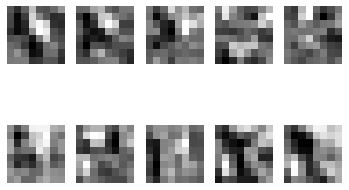

Batch 282/938 - Opimize G - Avg Batch Loss: 0.2689 - Time : 3.87s
Batch 283/938 - Opimize D - Avg Batch Loss: 0.2598 - Time : 3.41s
Batch 284/938 - Opimize G - Avg Batch Loss: 0.2847 - Time : 3.41s
Batch 285/938 - Opimize G - Avg Batch Loss: 0.2619 - Time : 3.49s
Batch 286/938 - Opimize G - Avg Batch Loss: 0.2224 - Time : 3.62s
Batch 287/938 - Opimize G - Avg Batch Loss: 0.2090 - Time : 3.66s
Batch 288/938 - Opimize G - Avg Batch Loss: 0.2898 - Time : 3.44s
Batch 289/938 - Opimize D - Avg Batch Loss: 0.2622 - Time : 3.64s
Batch 290/938 - Opimize G - Avg Batch Loss: 0.2712 - Time : 3.61s
Batch 291/938 - Opimize G - Avg Batch Loss: 0.1990 - Time : 3.67s
Batch 292/938 - Opimize G - Avg Batch Loss: 0.3167 - Time : 3.41s
Batch 293/938 - Opimize G - Avg Batch Loss: 0.2926 - Time : 3.43s
Batch 294/938 - Opimize G - Avg Batch Loss: 0.2574 - Time : 3.53s
Batch 295/938 - Opimize D - Avg Batch Loss: 0.2968 - Time : 3.60s
Batch 296/938 - Opimize G - Avg Batch Loss: 0.2566 - Time : 3.94s
Batch 297/

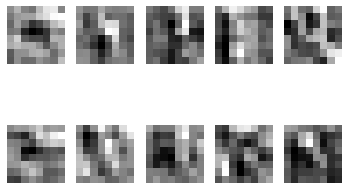

Batch 302/938 - Opimize G - Avg Batch Loss: 0.2483 - Time : 3.58s
Batch 303/938 - Opimize G - Avg Batch Loss: 0.2228 - Time : 3.66s
Batch 304/938 - Opimize G - Avg Batch Loss: 0.2544 - Time : 3.37s
Batch 305/938 - Opimize G - Avg Batch Loss: 0.2330 - Time : 3.44s
Batch 306/938 - Opimize G - Avg Batch Loss: 0.2446 - Time : 3.58s
Batch 307/938 - Opimize D - Avg Batch Loss: 0.1979 - Time : 3.40s
Batch 308/938 - Opimize G - Avg Batch Loss: 0.1622 - Time : 3.64s
Batch 309/938 - Opimize G - Avg Batch Loss: 0.2874 - Time : 3.47s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.1643 - Time : 3.57s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.2199 - Time : 3.83s
Batch 312/938 - Opimize G - Avg Batch Loss: 0.2738 - Time : 3.67s
Batch 313/938 - Opimize D - Avg Batch Loss: 0.3022 - Time : 3.89s
Batch 314/938 - Opimize G - Avg Batch Loss: 0.2722 - Time : 3.68s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.2653 - Time : 3.61s
Batch 316/938 - Opimize G - Avg Batch Loss: 0.2563 - Time : 3.65s
Batch 317/

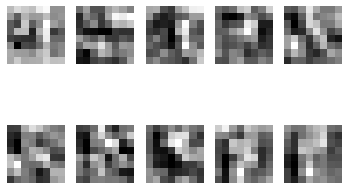

Batch 322/938 - Opimize G - Avg Batch Loss: 0.2084 - Time : 3.76s
Batch 323/938 - Opimize G - Avg Batch Loss: 0.2246 - Time : 3.96s
Batch 324/938 - Opimize G - Avg Batch Loss: 0.3035 - Time : 3.84s
Batch 325/938 - Opimize D - Avg Batch Loss: 0.2079 - Time : 3.69s
Batch 326/938 - Opimize G - Avg Batch Loss: 0.2143 - Time : 3.70s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.2204 - Time : 3.40s
Batch 328/938 - Opimize G - Avg Batch Loss: 0.1959 - Time : 3.68s
Batch 329/938 - Opimize G - Avg Batch Loss: 0.2335 - Time : 3.75s
Batch 330/938 - Opimize G - Avg Batch Loss: 0.1987 - Time : 4.07s
Batch 331/938 - Opimize D - Avg Batch Loss: 0.2026 - Time : 3.89s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.2558 - Time : 4.11s
Batch 333/938 - Opimize G - Avg Batch Loss: 0.2971 - Time : 3.70s
Batch 334/938 - Opimize G - Avg Batch Loss: 0.1910 - Time : 3.47s
Batch 335/938 - Opimize G - Avg Batch Loss: 0.2151 - Time : 3.44s
Batch 336/938 - Opimize G - Avg Batch Loss: 0.2278 - Time : 3.59s
Batch 337/

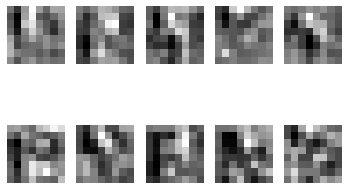

Batch 342/938 - Opimize G - Avg Batch Loss: 0.3004 - Time : 3.43s
Batch 343/938 - Opimize D - Avg Batch Loss: 0.1775 - Time : 3.72s
Batch 344/938 - Opimize G - Avg Batch Loss: 0.1838 - Time : 3.73s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.2355 - Time : 3.66s
Batch 346/938 - Opimize G - Avg Batch Loss: 0.2015 - Time : 3.45s
Batch 347/938 - Opimize G - Avg Batch Loss: 0.2197 - Time : 3.61s
Batch 348/938 - Opimize G - Avg Batch Loss: 0.2787 - Time : 3.64s
Batch 349/938 - Opimize D - Avg Batch Loss: 0.2289 - Time : 3.51s
Batch 350/938 - Opimize G - Avg Batch Loss: 0.2006 - Time : 3.67s
Batch 351/938 - Opimize G - Avg Batch Loss: 0.2506 - Time : 3.69s
Batch 352/938 - Opimize G - Avg Batch Loss: 0.2484 - Time : 3.49s
Batch 353/938 - Opimize G - Avg Batch Loss: 0.1829 - Time : 3.60s
Batch 354/938 - Opimize G - Avg Batch Loss: 0.1435 - Time : 3.78s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.2519 - Time : 3.62s
Batch 356/938 - Opimize G - Avg Batch Loss: 0.2032 - Time : 3.50s
Batch 357/

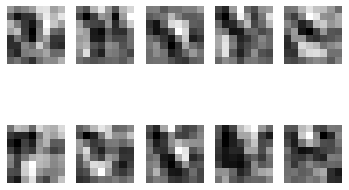

Batch 362/938 - Opimize G - Avg Batch Loss: 0.2445 - Time : 3.44s
Batch 363/938 - Opimize G - Avg Batch Loss: 0.1881 - Time : 3.59s
Batch 364/938 - Opimize G - Avg Batch Loss: 0.1258 - Time : 3.81s
Batch 365/938 - Opimize G - Avg Batch Loss: 0.1483 - Time : 3.69s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.1827 - Time : 3.71s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.1729 - Time : 3.92s
Batch 368/938 - Opimize G - Avg Batch Loss: 0.2583 - Time : 3.67s
Batch 369/938 - Opimize G - Avg Batch Loss: 0.1721 - Time : 3.94s
Batch 370/938 - Opimize G - Avg Batch Loss: 0.2327 - Time : 3.73s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.1512 - Time : 3.67s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.3399 - Time : 3.39s
Batch 373/938 - Opimize D - Avg Batch Loss: 0.2328 - Time : 3.40s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.1817 - Time : 3.73s
Batch 375/938 - Opimize G - Avg Batch Loss: 0.2369 - Time : 3.76s
Batch 376/938 - Opimize G - Avg Batch Loss: 0.1743 - Time : 3.45s
Batch 377/

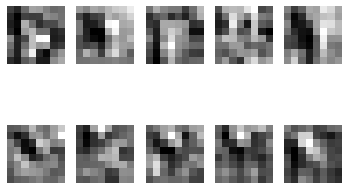

Batch 382/938 - Opimize G - Avg Batch Loss: 0.1429 - Time : 3.44s
Batch 383/938 - Opimize G - Avg Batch Loss: 0.2558 - Time : 4.13s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.2678 - Time : 3.40s
Batch 385/938 - Opimize D - Avg Batch Loss: 0.2181 - Time : 3.48s
Batch 386/938 - Opimize G - Avg Batch Loss: 0.2465 - Time : 3.39s
Batch 387/938 - Opimize G - Avg Batch Loss: 0.1866 - Time : 3.42s
Batch 388/938 - Opimize G - Avg Batch Loss: 0.1806 - Time : 3.48s
Batch 389/938 - Opimize G - Avg Batch Loss: 0.1781 - Time : 3.40s
Batch 390/938 - Opimize G - Avg Batch Loss: 0.1636 - Time : 3.46s
Batch 391/938 - Opimize D - Avg Batch Loss: 0.1520 - Time : 3.74s
Batch 392/938 - Opimize G - Avg Batch Loss: 0.1351 - Time : 3.65s
Batch 393/938 - Opimize G - Avg Batch Loss: 0.2253 - Time : 3.46s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.2230 - Time : 3.42s
Batch 395/938 - Opimize G - Avg Batch Loss: 0.1631 - Time : 3.66s
Batch 396/938 - Opimize G - Avg Batch Loss: 0.2004 - Time : 3.77s
Batch 397/

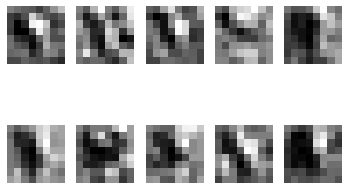

Batch 402/938 - Opimize G - Avg Batch Loss: 0.1846 - Time : 3.61s
Batch 403/938 - Opimize D - Avg Batch Loss: 0.2267 - Time : 3.73s
Batch 404/938 - Opimize G - Avg Batch Loss: 0.1623 - Time : 3.70s
Batch 405/938 - Opimize G - Avg Batch Loss: 0.2465 - Time : 3.44s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.2018 - Time : 3.47s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.2528 - Time : 3.48s
Batch 408/938 - Opimize G - Avg Batch Loss: 0.1941 - Time : 3.48s
Batch 409/938 - Opimize D - Avg Batch Loss: 0.2878 - Time : 3.47s
Batch 410/938 - Opimize G - Avg Batch Loss: 0.1624 - Time : 3.40s
Batch 411/938 - Opimize G - Avg Batch Loss: 0.2368 - Time : 3.45s
Batch 412/938 - Opimize G - Avg Batch Loss: 0.2054 - Time : 3.66s
Batch 413/938 - Opimize G - Avg Batch Loss: 0.1472 - Time : 4.14s
Batch 414/938 - Opimize G - Avg Batch Loss: 0.2333 - Time : 3.73s
Batch 415/938 - Opimize D - Avg Batch Loss: 0.2052 - Time : 3.76s
Batch 416/938 - Opimize G - Avg Batch Loss: 0.1511 - Time : 3.51s
Batch 417/

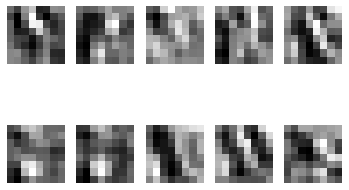

Batch 422/938 - Opimize G - Avg Batch Loss: 0.1698 - Time : 3.49s
Batch 423/938 - Opimize G - Avg Batch Loss: 0.2364 - Time : 3.45s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.2004 - Time : 3.66s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.0977 - Time : 3.39s
Batch 426/938 - Opimize G - Avg Batch Loss: 0.2414 - Time : 3.78s
Batch 427/938 - Opimize D - Avg Batch Loss: 0.3626 - Time : 3.42s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.1695 - Time : 3.58s
Batch 429/938 - Opimize G - Avg Batch Loss: 0.1174 - Time : 3.65s
Batch 430/938 - Opimize G - Avg Batch Loss: 0.2373 - Time : 3.75s
Batch 431/938 - Opimize G - Avg Batch Loss: 0.1793 - Time : 3.40s
Batch 432/938 - Opimize G - Avg Batch Loss: 0.2547 - Time : 3.42s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.1665 - Time : 3.73s
Batch 434/938 - Opimize G - Avg Batch Loss: 0.2462 - Time : 3.46s
Batch 435/938 - Opimize G - Avg Batch Loss: 0.1850 - Time : 3.64s
Batch 436/938 - Opimize G - Avg Batch Loss: 0.1835 - Time : 3.44s
Batch 437/

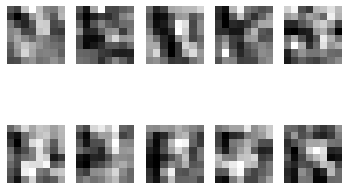

Batch 442/938 - Opimize G - Avg Batch Loss: 0.2014 - Time : 3.49s
Batch 443/938 - Opimize G - Avg Batch Loss: 0.2799 - Time : 3.70s
Batch 444/938 - Opimize G - Avg Batch Loss: 0.2410 - Time : 3.51s
Batch 445/938 - Opimize D - Avg Batch Loss: 0.2149 - Time : 3.78s
Batch 446/938 - Opimize G - Avg Batch Loss: 0.2904 - Time : 3.48s
Batch 447/938 - Opimize G - Avg Batch Loss: 0.2066 - Time : 3.50s
Batch 448/938 - Opimize G - Avg Batch Loss: 0.2880 - Time : 3.45s
Batch 449/938 - Opimize G - Avg Batch Loss: 0.2152 - Time : 3.45s
Batch 450/938 - Opimize G - Avg Batch Loss: 0.1850 - Time : 3.57s
Batch 451/938 - Opimize D - Avg Batch Loss: 0.1840 - Time : 3.41s
Batch 452/938 - Opimize G - Avg Batch Loss: 0.2685 - Time : 3.50s
Batch 453/938 - Opimize G - Avg Batch Loss: 0.1543 - Time : 3.62s
Batch 454/938 - Opimize G - Avg Batch Loss: 0.1640 - Time : 3.39s
Batch 455/938 - Opimize G - Avg Batch Loss: 0.2495 - Time : 3.40s
Batch 456/938 - Opimize G - Avg Batch Loss: 0.1848 - Time : 3.65s
Batch 457/

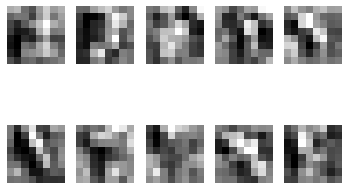

Batch 462/938 - Opimize G - Avg Batch Loss: 0.1679 - Time : 3.37s
Batch 463/938 - Opimize D - Avg Batch Loss: 0.2528 - Time : 3.48s
Batch 464/938 - Opimize G - Avg Batch Loss: 0.2335 - Time : 3.49s
Batch 465/938 - Opimize G - Avg Batch Loss: 0.1742 - Time : 3.44s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.1770 - Time : 3.44s
Batch 467/938 - Opimize G - Avg Batch Loss: 0.2419 - Time : 3.44s
Batch 468/938 - Opimize G - Avg Batch Loss: 0.1477 - Time : 3.53s
Batch 469/938 - Opimize D - Avg Batch Loss: 0.1555 - Time : 3.49s
Batch 470/938 - Opimize G - Avg Batch Loss: 0.2543 - Time : 3.60s
Batch 471/938 - Opimize G - Avg Batch Loss: 0.2017 - Time : 3.37s
Batch 472/938 - Opimize G - Avg Batch Loss: 0.2408 - Time : 3.43s
Batch 473/938 - Opimize G - Avg Batch Loss: 0.2246 - Time : 3.41s
Batch 474/938 - Opimize G - Avg Batch Loss: 0.2065 - Time : 3.88s
Batch 475/938 - Opimize D - Avg Batch Loss: 0.1153 - Time : 3.94s
Batch 476/938 - Opimize G - Avg Batch Loss: 0.2299 - Time : 3.74s
Batch 477/

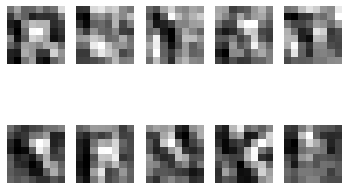

Batch 482/938 - Opimize G - Avg Batch Loss: 0.1612 - Time : 3.62s
Batch 483/938 - Opimize G - Avg Batch Loss: 0.1742 - Time : 3.49s
Batch 484/938 - Opimize G - Avg Batch Loss: 0.1263 - Time : 3.55s
Batch 485/938 - Opimize G - Avg Batch Loss: 0.2192 - Time : 3.86s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.0947 - Time : 3.47s
Batch 487/938 - Opimize D - Avg Batch Loss: 0.1701 - Time : 3.41s
Batch 488/938 - Opimize G - Avg Batch Loss: 0.2281 - Time : 3.44s
Batch 489/938 - Opimize G - Avg Batch Loss: 0.2625 - Time : 3.57s
Batch 490/938 - Opimize G - Avg Batch Loss: 0.2071 - Time : 3.46s
Batch 491/938 - Opimize G - Avg Batch Loss: 0.1956 - Time : 3.84s
Batch 492/938 - Opimize G - Avg Batch Loss: 0.2411 - Time : 3.37s
Batch 493/938 - Opimize D - Avg Batch Loss: 0.1826 - Time : 3.48s
Batch 494/938 - Opimize G - Avg Batch Loss: 0.2210 - Time : 3.42s
Batch 495/938 - Opimize G - Avg Batch Loss: 0.1347 - Time : 3.58s
Batch 496/938 - Opimize G - Avg Batch Loss: 0.1493 - Time : 3.43s
Batch 497/

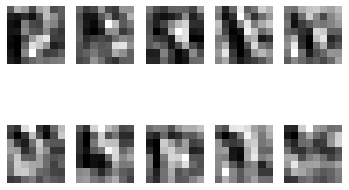

Batch 502/938 - Opimize G - Avg Batch Loss: 0.2317 - Time : 3.52s
Batch 503/938 - Opimize G - Avg Batch Loss: 0.1404 - Time : 3.52s
Batch 504/938 - Opimize G - Avg Batch Loss: 0.2252 - Time : 3.44s
Batch 505/938 - Opimize D - Avg Batch Loss: 0.2685 - Time : 3.48s
Batch 506/938 - Opimize G - Avg Batch Loss: 0.2370 - Time : 3.92s
Batch 507/938 - Opimize G - Avg Batch Loss: 0.2107 - Time : 3.90s
Batch 508/938 - Opimize G - Avg Batch Loss: 0.0650 - Time : 3.67s
Batch 509/938 - Opimize G - Avg Batch Loss: 0.1594 - Time : 3.66s
Batch 510/938 - Opimize G - Avg Batch Loss: 0.2041 - Time : 3.65s
Batch 511/938 - Opimize D - Avg Batch Loss: 0.1900 - Time : 3.49s
Batch 512/938 - Opimize G - Avg Batch Loss: 0.1786 - Time : 3.61s
Batch 513/938 - Opimize G - Avg Batch Loss: 0.1937 - Time : 3.58s
Batch 514/938 - Opimize G - Avg Batch Loss: 0.1463 - Time : 3.58s
Batch 515/938 - Opimize G - Avg Batch Loss: 0.1284 - Time : 3.92s
Batch 516/938 - Opimize G - Avg Batch Loss: 0.1753 - Time : 3.68s
Batch 517/

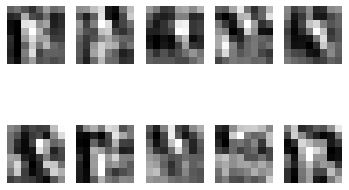

Batch 522/938 - Opimize G - Avg Batch Loss: 0.2784 - Time : 3.54s
Batch 523/938 - Opimize D - Avg Batch Loss: 0.1504 - Time : 3.66s
Batch 524/938 - Opimize G - Avg Batch Loss: 0.1506 - Time : 3.51s
Batch 525/938 - Opimize G - Avg Batch Loss: 0.2166 - Time : 3.76s
Batch 526/938 - Opimize G - Avg Batch Loss: 0.1615 - Time : 3.41s
Batch 527/938 - Opimize G - Avg Batch Loss: 0.1435 - Time : 3.61s
Batch 528/938 - Opimize G - Avg Batch Loss: 0.2686 - Time : 3.71s
Batch 529/938 - Opimize D - Avg Batch Loss: 0.1704 - Time : 3.42s
Batch 530/938 - Opimize G - Avg Batch Loss: 0.2264 - Time : 3.49s
Batch 531/938 - Opimize G - Avg Batch Loss: 0.1385 - Time : 3.72s
Batch 532/938 - Opimize G - Avg Batch Loss: 0.1915 - Time : 3.67s
Batch 533/938 - Opimize G - Avg Batch Loss: 0.2150 - Time : 3.52s
Batch 534/938 - Opimize G - Avg Batch Loss: 0.2092 - Time : 3.60s
Batch 535/938 - Opimize D - Avg Batch Loss: 0.1850 - Time : 3.58s
Batch 536/938 - Opimize G - Avg Batch Loss: 0.1732 - Time : 3.60s
Batch 537/

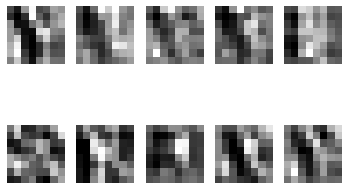

Batch 542/938 - Opimize G - Avg Batch Loss: 0.1662 - Time : 3.68s
Batch 543/938 - Opimize G - Avg Batch Loss: 0.2111 - Time : 3.42s
Batch 544/938 - Opimize G - Avg Batch Loss: 0.2378 - Time : 3.59s
Batch 545/938 - Opimize G - Avg Batch Loss: 0.1363 - Time : 3.48s
Batch 546/938 - Opimize G - Avg Batch Loss: 0.1792 - Time : 3.44s
Batch 547/938 - Opimize D - Avg Batch Loss: 0.2049 - Time : 3.42s
Batch 548/938 - Opimize G - Avg Batch Loss: 0.2296 - Time : 3.46s
Batch 549/938 - Opimize G - Avg Batch Loss: 0.2449 - Time : 4.33s
Batch 550/938 - Opimize G - Avg Batch Loss: 0.0967 - Time : 3.86s
Batch 551/938 - Opimize G - Avg Batch Loss: 0.1263 - Time : 3.57s
Batch 552/938 - Opimize G - Avg Batch Loss: 0.2189 - Time : 3.75s
Batch 553/938 - Opimize D - Avg Batch Loss: 0.1674 - Time : 3.46s
Batch 554/938 - Opimize G - Avg Batch Loss: 0.2237 - Time : 3.82s
Batch 555/938 - Opimize G - Avg Batch Loss: 0.2203 - Time : 3.91s
Batch 556/938 - Opimize G - Avg Batch Loss: 0.2628 - Time : 3.75s
Batch 557/

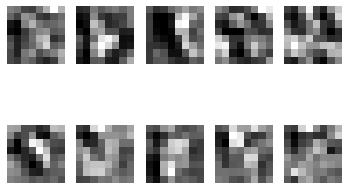

Batch 562/938 - Opimize G - Avg Batch Loss: 0.2474 - Time : 3.49s
Batch 563/938 - Opimize G - Avg Batch Loss: 0.1700 - Time : 3.65s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.1727 - Time : 3.59s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.2617 - Time : 3.65s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.1286 - Time : 3.68s
Batch 567/938 - Opimize G - Avg Batch Loss: 0.2411 - Time : 3.63s
Batch 568/938 - Opimize G - Avg Batch Loss: 0.1597 - Time : 3.53s
Batch 569/938 - Opimize G - Avg Batch Loss: 0.1349 - Time : 3.50s
Batch 570/938 - Opimize G - Avg Batch Loss: 0.1470 - Time : 3.42s
Batch 571/938 - Opimize D - Avg Batch Loss: 0.1748 - Time : 3.48s
Batch 572/938 - Opimize G - Avg Batch Loss: 0.1558 - Time : 3.55s
Batch 573/938 - Opimize G - Avg Batch Loss: 0.2352 - Time : 3.72s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.1612 - Time : 3.60s
Batch 575/938 - Opimize G - Avg Batch Loss: 0.1659 - Time : 3.62s
Batch 576/938 - Opimize G - Avg Batch Loss: 0.2248 - Time : 3.80s
Batch 577/

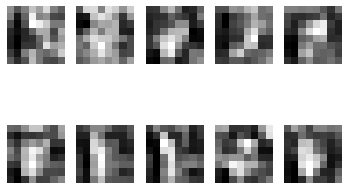

Batch 582/938 - Opimize G - Avg Batch Loss: 0.1810 - Time : 3.56s
Batch 583/938 - Opimize D - Avg Batch Loss: 0.2655 - Time : 3.42s
Batch 584/938 - Opimize G - Avg Batch Loss: 0.1826 - Time : 3.66s
Batch 585/938 - Opimize G - Avg Batch Loss: 0.2113 - Time : 3.50s
Batch 586/938 - Opimize G - Avg Batch Loss: 0.2021 - Time : 3.40s
Batch 587/938 - Opimize G - Avg Batch Loss: 0.0642 - Time : 3.63s
Batch 588/938 - Opimize G - Avg Batch Loss: 0.1189 - Time : 3.63s
Batch 589/938 - Opimize D - Avg Batch Loss: 0.1172 - Time : 3.47s
Batch 590/938 - Opimize G - Avg Batch Loss: 0.1964 - Time : 3.41s
Batch 591/938 - Opimize G - Avg Batch Loss: 0.1956 - Time : 3.42s
Batch 592/938 - Opimize G - Avg Batch Loss: 0.2696 - Time : 3.39s
Batch 593/938 - Opimize G - Avg Batch Loss: 0.1177 - Time : 3.39s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.2215 - Time : 3.48s
Batch 595/938 - Opimize D - Avg Batch Loss: 0.1595 - Time : 3.77s
Batch 596/938 - Opimize G - Avg Batch Loss: 0.1335 - Time : 3.64s
Batch 597/

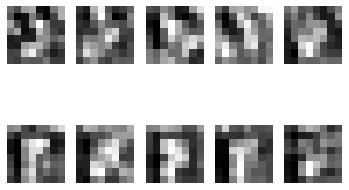

Batch 602/938 - Opimize G - Avg Batch Loss: 0.2217 - Time : 3.75s
Batch 603/938 - Opimize G - Avg Batch Loss: 0.1781 - Time : 3.46s
Batch 604/938 - Opimize G - Avg Batch Loss: 0.0783 - Time : 3.66s
Batch 605/938 - Opimize G - Avg Batch Loss: 0.2185 - Time : 3.54s
Batch 606/938 - Opimize G - Avg Batch Loss: 0.1078 - Time : 3.53s
Batch 607/938 - Opimize D - Avg Batch Loss: 0.2895 - Time : 3.63s
Batch 608/938 - Opimize G - Avg Batch Loss: 0.1997 - Time : 3.98s
Batch 609/938 - Opimize G - Avg Batch Loss: 0.1265 - Time : 3.64s
Batch 610/938 - Opimize G - Avg Batch Loss: 0.1820 - Time : 3.59s
Batch 611/938 - Opimize G - Avg Batch Loss: 0.0659 - Time : 3.61s
Batch 612/938 - Opimize G - Avg Batch Loss: 0.2016 - Time : 3.46s
Batch 613/938 - Opimize D - Avg Batch Loss: 0.1489 - Time : 3.50s
Batch 614/938 - Opimize G - Avg Batch Loss: 0.1282 - Time : 3.41s
Batch 615/938 - Opimize G - Avg Batch Loss: 0.1534 - Time : 3.47s
Batch 616/938 - Opimize G - Avg Batch Loss: 0.1356 - Time : 3.59s
Batch 617/

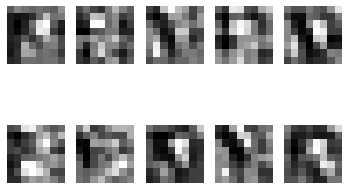

Batch 622/938 - Opimize G - Avg Batch Loss: 0.1260 - Time : 3.93s
Batch 623/938 - Opimize G - Avg Batch Loss: 0.2039 - Time : 3.64s
Batch 624/938 - Opimize G - Avg Batch Loss: 0.0920 - Time : 3.69s
Batch 625/938 - Opimize D - Avg Batch Loss: 0.1340 - Time : 3.43s
Batch 626/938 - Opimize G - Avg Batch Loss: 0.2058 - Time : 3.74s
Batch 627/938 - Opimize G - Avg Batch Loss: 0.2336 - Time : 3.68s
Batch 628/938 - Opimize G - Avg Batch Loss: 0.1456 - Time : 3.69s
Batch 629/938 - Opimize G - Avg Batch Loss: 0.1516 - Time : 3.74s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.1898 - Time : 3.46s
Batch 631/938 - Opimize D - Avg Batch Loss: 0.1457 - Time : 3.39s
Batch 632/938 - Opimize G - Avg Batch Loss: 0.1279 - Time : 3.46s
Batch 633/938 - Opimize G - Avg Batch Loss: 0.1770 - Time : 3.38s
Batch 634/938 - Opimize G - Avg Batch Loss: 0.1385 - Time : 3.36s
Batch 635/938 - Opimize G - Avg Batch Loss: 0.1220 - Time : 3.41s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.1362 - Time : 3.59s
Batch 637/

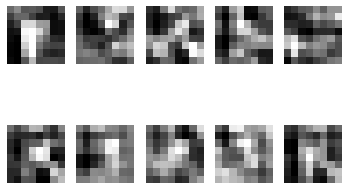

Batch 642/938 - Opimize G - Avg Batch Loss: 0.0935 - Time : 3.59s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.1104 - Time : 3.75s
Batch 644/938 - Opimize G - Avg Batch Loss: 0.0953 - Time : 3.85s
Batch 645/938 - Opimize G - Avg Batch Loss: 0.1944 - Time : 3.53s
Batch 646/938 - Opimize G - Avg Batch Loss: 0.1492 - Time : 3.82s
Batch 647/938 - Opimize G - Avg Batch Loss: 0.1033 - Time : 4.08s
Batch 648/938 - Opimize G - Avg Batch Loss: 0.1005 - Time : 3.70s
Batch 649/938 - Opimize D - Avg Batch Loss: 0.1700 - Time : 3.62s
Batch 650/938 - Opimize G - Avg Batch Loss: 0.1507 - Time : 3.63s
Batch 651/938 - Opimize G - Avg Batch Loss: 0.1668 - Time : 3.59s
Batch 652/938 - Opimize G - Avg Batch Loss: 0.2067 - Time : 3.40s
Batch 653/938 - Opimize G - Avg Batch Loss: 0.0596 - Time : 3.55s
Batch 654/938 - Opimize G - Avg Batch Loss: 0.1434 - Time : 3.39s
Batch 655/938 - Opimize D - Avg Batch Loss: 0.1152 - Time : 3.49s
Batch 656/938 - Opimize G - Avg Batch Loss: 0.1327 - Time : 3.94s
Batch 657/

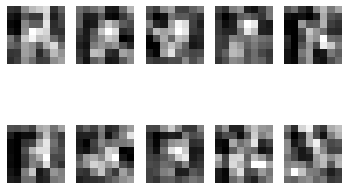

Batch 662/938 - Opimize G - Avg Batch Loss: 0.1864 - Time : 3.37s
Batch 663/938 - Opimize G - Avg Batch Loss: 0.1801 - Time : 3.49s
Batch 664/938 - Opimize G - Avg Batch Loss: 0.1730 - Time : 3.48s
Batch 665/938 - Opimize G - Avg Batch Loss: 0.1146 - Time : 3.71s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.1115 - Time : 3.89s
Batch 667/938 - Opimize D - Avg Batch Loss: 0.1095 - Time : 3.65s
Batch 668/938 - Opimize G - Avg Batch Loss: 0.2072 - Time : 3.58s
Batch 669/938 - Opimize G - Avg Batch Loss: 0.0856 - Time : 3.65s
Batch 670/938 - Opimize G - Avg Batch Loss: 0.1741 - Time : 3.62s
Batch 671/938 - Opimize G - Avg Batch Loss: 0.0964 - Time : 3.72s
Batch 672/938 - Opimize G - Avg Batch Loss: 0.1823 - Time : 3.39s
Batch 673/938 - Opimize D - Avg Batch Loss: 0.1089 - Time : 3.42s
Batch 674/938 - Opimize G - Avg Batch Loss: 0.1717 - Time : 3.70s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.1717 - Time : 3.35s
Batch 676/938 - Opimize G - Avg Batch Loss: 0.1571 - Time : 3.55s
Batch 677/

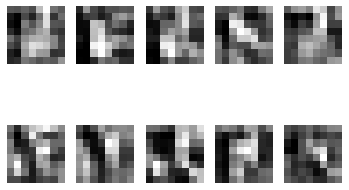

Batch 682/938 - Opimize G - Avg Batch Loss: 0.1109 - Time : 3.80s
Batch 683/938 - Opimize G - Avg Batch Loss: 0.1061 - Time : 3.75s
Batch 684/938 - Opimize G - Avg Batch Loss: 0.1520 - Time : 3.53s
Batch 685/938 - Opimize D - Avg Batch Loss: 0.0816 - Time : 3.60s
Batch 686/938 - Opimize G - Avg Batch Loss: 0.1017 - Time : 3.58s
Batch 687/938 - Opimize G - Avg Batch Loss: 0.1344 - Time : 3.53s
Batch 688/938 - Opimize G - Avg Batch Loss: 0.1221 - Time : 3.48s
Batch 689/938 - Opimize G - Avg Batch Loss: 0.1736 - Time : 3.72s
Batch 690/938 - Opimize G - Avg Batch Loss: 0.1120 - Time : 3.90s
Batch 691/938 - Opimize D - Avg Batch Loss: 0.0656 - Time : 3.46s
Batch 692/938 - Opimize G - Avg Batch Loss: 0.1126 - Time : 3.61s
Batch 693/938 - Opimize G - Avg Batch Loss: 0.1384 - Time : 3.63s
Batch 694/938 - Opimize G - Avg Batch Loss: 0.2374 - Time : 3.43s
Batch 695/938 - Opimize G - Avg Batch Loss: 0.1259 - Time : 3.90s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.1830 - Time : 3.80s
Batch 697/

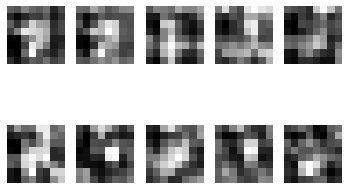

Batch 702/938 - Opimize G - Avg Batch Loss: 0.1430 - Time : 3.58s
Batch 703/938 - Opimize D - Avg Batch Loss: 0.0882 - Time : 3.53s
Batch 704/938 - Opimize G - Avg Batch Loss: 0.1762 - Time : 3.40s
Batch 705/938 - Opimize G - Avg Batch Loss: 0.0934 - Time : 3.54s
Batch 706/938 - Opimize G - Avg Batch Loss: 0.0897 - Time : 3.38s
Batch 707/938 - Opimize G - Avg Batch Loss: 0.2439 - Time : 3.78s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.1485 - Time : 3.37s
Batch 709/938 - Opimize D - Avg Batch Loss: 0.1702 - Time : 3.91s
Batch 710/938 - Opimize G - Avg Batch Loss: 0.2141 - Time : 3.92s
Batch 711/938 - Opimize G - Avg Batch Loss: 0.1110 - Time : 3.55s
Batch 712/938 - Opimize G - Avg Batch Loss: 0.1545 - Time : 3.65s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.2052 - Time : 3.52s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.0795 - Time : 3.35s
Batch 715/938 - Opimize D - Avg Batch Loss: 0.0764 - Time : 3.36s
Batch 716/938 - Opimize G - Avg Batch Loss: 0.0815 - Time : 3.47s
Batch 717/

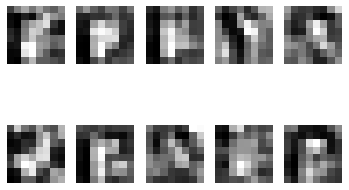

Batch 722/938 - Opimize G - Avg Batch Loss: 0.0780 - Time : 3.49s
Batch 723/938 - Opimize G - Avg Batch Loss: 0.0423 - Time : 3.41s
Batch 724/938 - Opimize G - Avg Batch Loss: 0.1673 - Time : 3.44s
Batch 725/938 - Opimize G - Avg Batch Loss: 0.1439 - Time : 3.74s
Batch 726/938 - Opimize G - Avg Batch Loss: 0.1445 - Time : 3.36s
Batch 727/938 - Opimize D - Avg Batch Loss: 0.2620 - Time : 3.39s
Batch 728/938 - Opimize G - Avg Batch Loss: 0.1299 - Time : 3.86s
Batch 729/938 - Opimize G - Avg Batch Loss: 0.0975 - Time : 3.58s
Batch 730/938 - Opimize G - Avg Batch Loss: 0.1144 - Time : 3.39s
Batch 731/938 - Opimize G - Avg Batch Loss: 0.1562 - Time : 3.39s
Batch 732/938 - Opimize G - Avg Batch Loss: 0.1245 - Time : 3.76s
Batch 733/938 - Opimize D - Avg Batch Loss: 0.0736 - Time : 3.47s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.1182 - Time : 3.42s
Batch 735/938 - Opimize G - Avg Batch Loss: 0.1201 - Time : 3.79s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.0742 - Time : 3.54s
Batch 737/

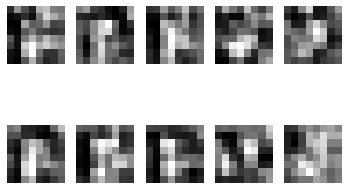

Batch 742/938 - Opimize G - Avg Batch Loss: 0.1578 - Time : 3.83s
Batch 743/938 - Opimize G - Avg Batch Loss: 0.1594 - Time : 3.63s
Batch 744/938 - Opimize G - Avg Batch Loss: 0.0981 - Time : 3.57s
Batch 745/938 - Opimize D - Avg Batch Loss: 0.1125 - Time : 3.68s
Batch 746/938 - Opimize G - Avg Batch Loss: 0.0912 - Time : 3.71s
Batch 747/938 - Opimize G - Avg Batch Loss: 0.1078 - Time : 3.55s
Batch 748/938 - Opimize G - Avg Batch Loss: 0.1001 - Time : 3.90s
Batch 749/938 - Opimize G - Avg Batch Loss: 0.0818 - Time : 3.47s
Batch 750/938 - Opimize G - Avg Batch Loss: 0.0919 - Time : 3.53s
Batch 751/938 - Opimize D - Avg Batch Loss: 0.0891 - Time : 3.68s
Batch 752/938 - Opimize G - Avg Batch Loss: 0.0703 - Time : 3.66s
Batch 753/938 - Opimize G - Avg Batch Loss: 0.1726 - Time : 3.45s
Batch 754/938 - Opimize G - Avg Batch Loss: 0.0664 - Time : 3.41s
Batch 755/938 - Opimize G - Avg Batch Loss: 0.1092 - Time : 3.46s
Batch 756/938 - Opimize G - Avg Batch Loss: 0.1611 - Time : 3.71s
Batch 757/

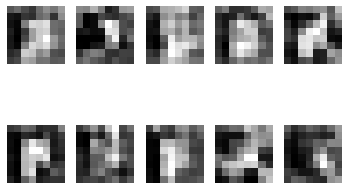

Batch 762/938 - Opimize G - Avg Batch Loss: 0.1533 - Time : 3.45s
Batch 763/938 - Opimize D - Avg Batch Loss: 0.0803 - Time : 3.73s
Batch 764/938 - Opimize G - Avg Batch Loss: 0.0612 - Time : 4.18s
Batch 765/938 - Opimize G - Avg Batch Loss: 0.1160 - Time : 3.60s
Batch 766/938 - Opimize G - Avg Batch Loss: 0.0758 - Time : 3.63s
Batch 767/938 - Opimize G - Avg Batch Loss: 0.0833 - Time : 3.48s
Batch 768/938 - Opimize G - Avg Batch Loss: 0.0668 - Time : 3.55s
Batch 769/938 - Opimize D - Avg Batch Loss: 0.1658 - Time : 3.74s
Batch 770/938 - Opimize G - Avg Batch Loss: 0.1065 - Time : 3.57s
Batch 771/938 - Opimize G - Avg Batch Loss: 0.0618 - Time : 3.87s
Batch 772/938 - Opimize G - Avg Batch Loss: 0.0798 - Time : 3.65s
Batch 773/938 - Opimize G - Avg Batch Loss: 0.0744 - Time : 3.64s
Batch 774/938 - Opimize G - Avg Batch Loss: 0.1390 - Time : 3.82s
Batch 775/938 - Opimize D - Avg Batch Loss: 0.0974 - Time : 3.53s
Batch 776/938 - Opimize G - Avg Batch Loss: 0.1316 - Time : 3.51s
Batch 777/

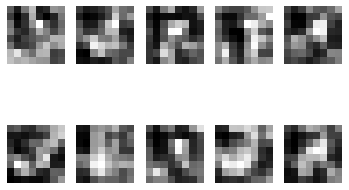

Batch 782/938 - Opimize G - Avg Batch Loss: 0.1634 - Time : 3.49s
Batch 783/938 - Opimize G - Avg Batch Loss: 0.1672 - Time : 3.54s
Batch 784/938 - Opimize G - Avg Batch Loss: 0.1020 - Time : 3.53s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.1217 - Time : 3.53s
Batch 786/938 - Opimize G - Avg Batch Loss: 0.0554 - Time : 3.73s
Batch 787/938 - Opimize D - Avg Batch Loss: 0.1646 - Time : 3.52s
Batch 788/938 - Opimize G - Avg Batch Loss: 0.0694 - Time : 3.91s
Batch 789/938 - Opimize G - Avg Batch Loss: 0.1148 - Time : 3.68s
Batch 790/938 - Opimize G - Avg Batch Loss: 0.1180 - Time : 3.67s
Batch 791/938 - Opimize G - Avg Batch Loss: 0.0995 - Time : 3.47s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.1203 - Time : 3.58s
Batch 793/938 - Opimize D - Avg Batch Loss: 0.1279 - Time : 3.70s
Batch 794/938 - Opimize G - Avg Batch Loss: 0.0788 - Time : 3.83s
Batch 795/938 - Opimize G - Avg Batch Loss: 0.0573 - Time : 3.62s
Batch 796/938 - Opimize G - Avg Batch Loss: 0.1142 - Time : 3.97s
Batch 797/

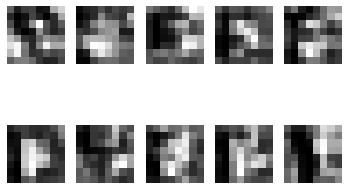

Batch 802/938 - Opimize G - Avg Batch Loss: 0.0729 - Time : 4.23s
Batch 803/938 - Opimize G - Avg Batch Loss: 0.0671 - Time : 3.70s
Batch 804/938 - Opimize G - Avg Batch Loss: 0.0853 - Time : 3.82s
Batch 805/938 - Opimize D - Avg Batch Loss: 0.1485 - Time : 3.74s
Batch 806/938 - Opimize G - Avg Batch Loss: 0.1253 - Time : 3.73s
Batch 807/938 - Opimize G - Avg Batch Loss: 0.2120 - Time : 3.44s
Batch 808/938 - Opimize G - Avg Batch Loss: 0.1309 - Time : 3.74s
Batch 809/938 - Opimize G - Avg Batch Loss: 0.0243 - Time : 3.46s
Batch 810/938 - Opimize G - Avg Batch Loss: 0.1242 - Time : 3.73s
Batch 811/938 - Opimize D - Avg Batch Loss: 0.0941 - Time : 3.65s
Batch 812/938 - Opimize G - Avg Batch Loss: 0.0465 - Time : 3.80s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.0915 - Time : 3.70s
Batch 814/938 - Opimize G - Avg Batch Loss: 0.0848 - Time : 4.08s
Batch 815/938 - Opimize G - Avg Batch Loss: 0.0123 - Time : 3.82s
Batch 816/938 - Opimize G - Avg Batch Loss: 0.0431 - Time : 3.49s
Batch 817/

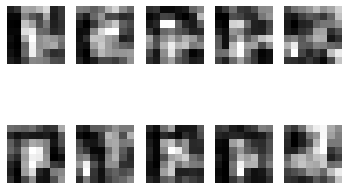

Batch 822/938 - Opimize G - Avg Batch Loss: 0.0966 - Time : 3.88s
Batch 823/938 - Opimize D - Avg Batch Loss: 0.1351 - Time : 3.43s
Batch 824/938 - Opimize G - Avg Batch Loss: 0.0718 - Time : 3.56s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.0645 - Time : 3.48s
Batch 826/938 - Opimize G - Avg Batch Loss: 0.1204 - Time : 3.41s
Batch 827/938 - Opimize G - Avg Batch Loss: 0.1238 - Time : 3.80s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.1071 - Time : 3.48s
Batch 829/938 - Opimize D - Avg Batch Loss: 0.0618 - Time : 3.41s
Batch 830/938 - Opimize G - Avg Batch Loss: 0.0975 - Time : 3.97s
Batch 831/938 - Opimize G - Avg Batch Loss: 0.1676 - Time : 3.72s
Batch 832/938 - Opimize G - Avg Batch Loss: 0.0928 - Time : 3.68s
Batch 833/938 - Opimize G - Avg Batch Loss: 0.2491 - Time : 3.57s
Batch 834/938 - Opimize G - Avg Batch Loss: 0.1299 - Time : 3.71s
Batch 835/938 - Opimize D - Avg Batch Loss: 0.1740 - Time : 3.53s
Batch 836/938 - Opimize G - Avg Batch Loss: 0.0631 - Time : 3.63s
Batch 837/

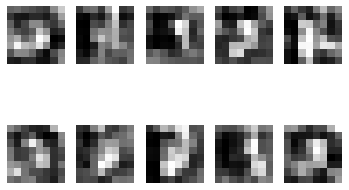

Batch 842/938 - Opimize G - Avg Batch Loss: 0.1148 - Time : 3.76s
Batch 843/938 - Opimize G - Avg Batch Loss: 0.1435 - Time : 3.56s
Batch 844/938 - Opimize G - Avg Batch Loss: 0.0896 - Time : 3.97s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.0793 - Time : 3.82s
Batch 846/938 - Opimize G - Avg Batch Loss: 0.1098 - Time : 3.69s
Batch 847/938 - Opimize D - Avg Batch Loss: 0.0773 - Time : 3.49s
Batch 848/938 - Opimize G - Avg Batch Loss: 0.0686 - Time : 3.65s
Batch 849/938 - Opimize G - Avg Batch Loss: 0.0929 - Time : 3.82s
Batch 850/938 - Opimize G - Avg Batch Loss: 0.1809 - Time : 3.63s
Batch 851/938 - Opimize G - Avg Batch Loss: 0.1796 - Time : 3.49s
Batch 852/938 - Opimize G - Avg Batch Loss: 0.1554 - Time : 3.97s
Batch 853/938 - Opimize D - Avg Batch Loss: 0.0929 - Time : 3.58s
Batch 854/938 - Opimize G - Avg Batch Loss: 0.0594 - Time : 3.45s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.0551 - Time : 3.82s
Batch 856/938 - Opimize G - Avg Batch Loss: 0.0905 - Time : 3.67s
Batch 857/

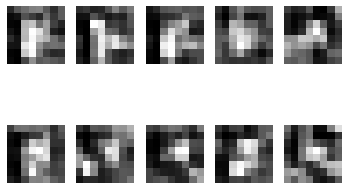

Batch 862/938 - Opimize G - Avg Batch Loss: 0.1437 - Time : 3.66s
Batch 863/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 3.81s
Batch 864/938 - Opimize G - Avg Batch Loss: 0.0938 - Time : 3.55s
Batch 865/938 - Opimize D - Avg Batch Loss: 0.0958 - Time : 3.67s
Batch 866/938 - Opimize G - Avg Batch Loss: 0.1064 - Time : 3.61s
Batch 867/938 - Opimize G - Avg Batch Loss: 0.0754 - Time : 3.55s
Batch 868/938 - Opimize G - Avg Batch Loss: 0.0618 - Time : 3.71s
Batch 869/938 - Opimize G - Avg Batch Loss: 0.1031 - Time : 3.46s
Batch 870/938 - Opimize G - Avg Batch Loss: 0.0946 - Time : 3.73s
Batch 871/938 - Opimize D - Avg Batch Loss: 0.1358 - Time : 3.54s
Batch 872/938 - Opimize G - Avg Batch Loss: 0.0844 - Time : 3.72s
Batch 873/938 - Opimize G - Avg Batch Loss: 0.1084 - Time : 3.52s
Batch 874/938 - Opimize G - Avg Batch Loss: 0.1100 - Time : 3.69s
Batch 875/938 - Opimize G - Avg Batch Loss: 0.0666 - Time : 3.67s
Batch 876/938 - Opimize G - Avg Batch Loss: 0.0838 - Time : 3.66s
Batch 877/

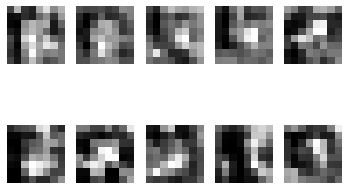

Batch 882/938 - Opimize G - Avg Batch Loss: 0.0622 - Time : 3.85s
Batch 883/938 - Opimize D - Avg Batch Loss: 0.1397 - Time : 3.67s
Batch 884/938 - Opimize G - Avg Batch Loss: 0.1316 - Time : 3.61s
Batch 885/938 - Opimize G - Avg Batch Loss: 0.0744 - Time : 4.07s
Batch 886/938 - Opimize G - Avg Batch Loss: 0.1014 - Time : 3.62s
Batch 887/938 - Opimize G - Avg Batch Loss: 0.0586 - Time : 3.78s
Batch 888/938 - Opimize G - Avg Batch Loss: 0.0607 - Time : 3.60s
Batch 889/938 - Opimize D - Avg Batch Loss: 0.0618 - Time : 3.45s
Batch 890/938 - Opimize G - Avg Batch Loss: 0.1263 - Time : 3.64s
Batch 891/938 - Opimize G - Avg Batch Loss: 0.0785 - Time : 3.55s
Batch 892/938 - Opimize G - Avg Batch Loss: 0.1031 - Time : 3.76s
Batch 893/938 - Opimize G - Avg Batch Loss: 0.0267 - Time : 3.53s
Batch 894/938 - Opimize G - Avg Batch Loss: 0.0848 - Time : 3.43s
Batch 895/938 - Opimize D - Avg Batch Loss: 0.1125 - Time : 3.60s
Batch 896/938 - Opimize G - Avg Batch Loss: 0.0636 - Time : 3.63s
Batch 897/

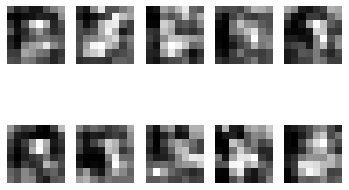

Batch 902/938 - Opimize G - Avg Batch Loss: 0.1102 - Time : 3.50s
Batch 903/938 - Opimize G - Avg Batch Loss: 0.1424 - Time : 3.72s
Batch 904/938 - Opimize G - Avg Batch Loss: 0.0464 - Time : 3.73s
Batch 905/938 - Opimize G - Avg Batch Loss: 0.0288 - Time : 3.70s
Batch 906/938 - Opimize G - Avg Batch Loss: 0.0758 - Time : 3.60s
Batch 907/938 - Opimize D - Avg Batch Loss: 0.0744 - Time : 3.43s
Batch 908/938 - Opimize G - Avg Batch Loss: 0.0706 - Time : 3.61s
Batch 909/938 - Opimize G - Avg Batch Loss: 0.0655 - Time : 3.48s
Batch 910/938 - Opimize G - Avg Batch Loss: 0.1270 - Time : 3.59s
Batch 911/938 - Opimize G - Avg Batch Loss: 0.1267 - Time : 3.44s
Batch 912/938 - Opimize G - Avg Batch Loss: 0.0745 - Time : 3.47s
Batch 913/938 - Opimize D - Avg Batch Loss: 0.0974 - Time : 3.60s
Batch 914/938 - Opimize G - Avg Batch Loss: 0.1193 - Time : 3.49s
Batch 915/938 - Opimize G - Avg Batch Loss: 0.1350 - Time : 3.74s
Batch 916/938 - Opimize G - Avg Batch Loss: 0.1276 - Time : 3.41s
Batch 917/

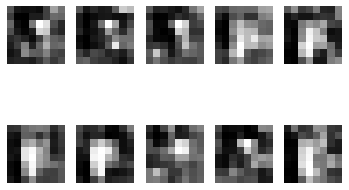

Batch 922/938 - Opimize G - Avg Batch Loss: 0.1334 - Time : 3.86s
Batch 923/938 - Opimize G - Avg Batch Loss: 0.0892 - Time : 3.41s
Batch 924/938 - Opimize G - Avg Batch Loss: 0.0855 - Time : 3.91s
Batch 925/938 - Opimize D - Avg Batch Loss: 0.0666 - Time : 3.44s
Batch 926/938 - Opimize G - Avg Batch Loss: 0.0515 - Time : 3.74s
Batch 927/938 - Opimize G - Avg Batch Loss: 0.1061 - Time : 3.72s
Batch 928/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.71s
Batch 929/938 - Opimize G - Avg Batch Loss: 0.0797 - Time : 3.85s
Batch 930/938 - Opimize G - Avg Batch Loss: 0.1147 - Time : 3.49s
Batch 931/938 - Opimize D - Avg Batch Loss: 0.0365 - Time : 3.64s
Batch 932/938 - Opimize G - Avg Batch Loss: 0.1357 - Time : 3.57s
Batch 933/938 - Opimize G - Avg Batch Loss: 0.1119 - Time : 3.43s
Batch 934/938 - Opimize G - Avg Batch Loss: 0.0402 - Time : 3.52s
Batch 935/938 - Opimize G - Avg Batch Loss: 0.0761 - Time : 3.67s
Batch 936/938 - Opimize G - Avg Batch Loss: 0.1323 - Time : 3.67s
Batch 937/

In [11]:
history = train(n_gen=5, n_epochs = 1, batch_size = 64, plt_samples = 20)

In [0]:
np.savetxt('history_cnn_0', history)

Loss history

Text(0.5, 1.0, 'Loss history of the first epoch')

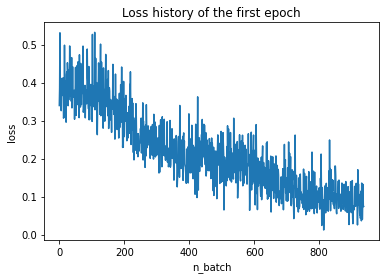

In [14]:
plt.plot(history)
plt.ylabel("loss")
plt.xlabel("n_batch")
plt.title("Loss history of the first epoch")

Generate some examples

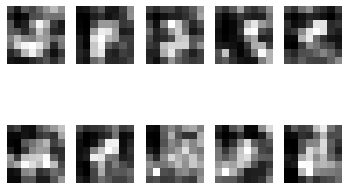

In [15]:
generate_plt()

Let's continue training

========================Epoch: 1 / 1 =======================
Batch 1/938 - Opimize D - Avg Batch Loss: 0.1037 - Time : 3.50s


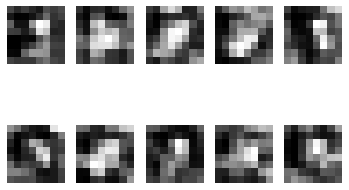

Batch 2/938 - Opimize G - Avg Batch Loss: 0.0804 - Time : 3.37s
Batch 3/938 - Opimize G - Avg Batch Loss: 0.0646 - Time : 3.35s
Batch 4/938 - Opimize G - Avg Batch Loss: 0.0609 - Time : 3.84s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.0807 - Time : 3.52s
Batch 6/938 - Opimize G - Avg Batch Loss: 0.1331 - Time : 3.86s
Batch 7/938 - Opimize D - Avg Batch Loss: 0.0681 - Time : 3.59s
Batch 8/938 - Opimize G - Avg Batch Loss: 0.0627 - Time : 3.81s
Batch 9/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.46s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.0644 - Time : 3.63s
Batch 11/938 - Opimize G - Avg Batch Loss: 0.1494 - Time : 3.41s
Batch 12/938 - Opimize G - Avg Batch Loss: 0.0428 - Time : 3.86s
Batch 13/938 - Opimize D - Avg Batch Loss: 0.0694 - Time : 3.62s
Batch 14/938 - Opimize G - Avg Batch Loss: 0.0669 - Time : 3.90s
Batch 15/938 - Opimize G - Avg Batch Loss: 0.0818 - Time : 3.41s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.0790 - Time : 3.44s
Batch 17/938 - Opimize G - Avg Ba

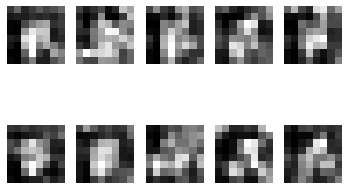

Batch 22/938 - Opimize G - Avg Batch Loss: 0.0720 - Time : 3.54s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.1027 - Time : 3.72s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.1772 - Time : 3.54s
Batch 25/938 - Opimize D - Avg Batch Loss: 0.0553 - Time : 3.45s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.0169 - Time : 3.45s
Batch 27/938 - Opimize G - Avg Batch Loss: 0.0910 - Time : 4.04s
Batch 28/938 - Opimize G - Avg Batch Loss: 0.0672 - Time : 3.94s
Batch 29/938 - Opimize G - Avg Batch Loss: 0.1013 - Time : 3.40s
Batch 30/938 - Opimize G - Avg Batch Loss: 0.0600 - Time : 3.50s
Batch 31/938 - Opimize D - Avg Batch Loss: 0.0632 - Time : 3.90s
Batch 32/938 - Opimize G - Avg Batch Loss: 0.0541 - Time : 3.61s
Batch 33/938 - Opimize G - Avg Batch Loss: 0.0505 - Time : 3.62s
Batch 34/938 - Opimize G - Avg Batch Loss: 0.0637 - Time : 3.56s
Batch 35/938 - Opimize G - Avg Batch Loss: 0.0543 - Time : 3.58s
Batch 36/938 - Opimize G - Avg Batch Loss: 0.0329 - Time : 3.68s
Batch 37/938 - Opimize D 

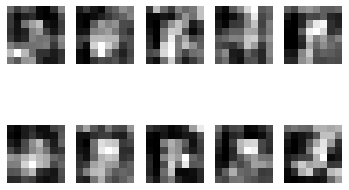

Batch 42/938 - Opimize G - Avg Batch Loss: 0.0589 - Time : 3.39s
Batch 43/938 - Opimize D - Avg Batch Loss: 0.0606 - Time : 3.41s
Batch 44/938 - Opimize G - Avg Batch Loss: 0.0894 - Time : 3.54s
Batch 45/938 - Opimize G - Avg Batch Loss: 0.1934 - Time : 3.74s
Batch 46/938 - Opimize G - Avg Batch Loss: 0.1328 - Time : 3.52s
Batch 47/938 - Opimize G - Avg Batch Loss: 0.0728 - Time : 3.46s
Batch 48/938 - Opimize G - Avg Batch Loss: 0.1134 - Time : 3.39s
Batch 49/938 - Opimize D - Avg Batch Loss: 0.0798 - Time : 3.54s
Batch 50/938 - Opimize G - Avg Batch Loss: 0.0579 - Time : 3.48s
Batch 51/938 - Opimize G - Avg Batch Loss: 0.0755 - Time : 3.43s
Batch 52/938 - Opimize G - Avg Batch Loss: 0.0799 - Time : 3.63s
Batch 53/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 3.69s
Batch 54/938 - Opimize G - Avg Batch Loss: 0.0493 - Time : 3.41s
Batch 55/938 - Opimize D - Avg Batch Loss: 0.0542 - Time : 4.11s
Batch 56/938 - Opimize G - Avg Batch Loss: 0.1021 - Time : 3.51s
Batch 57/938 - Opimize G 

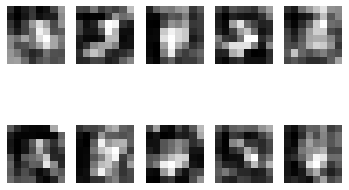

Batch 62/938 - Opimize G - Avg Batch Loss: 0.0538 - Time : 3.81s
Batch 63/938 - Opimize G - Avg Batch Loss: 0.1056 - Time : 3.71s
Batch 64/938 - Opimize G - Avg Batch Loss: 0.0482 - Time : 3.47s
Batch 65/938 - Opimize G - Avg Batch Loss: 0.0451 - Time : 3.43s
Batch 66/938 - Opimize G - Avg Batch Loss: 0.1147 - Time : 3.56s
Batch 67/938 - Opimize D - Avg Batch Loss: 0.0902 - Time : 3.48s
Batch 68/938 - Opimize G - Avg Batch Loss: 0.0490 - Time : 3.61s
Batch 69/938 - Opimize G - Avg Batch Loss: 0.1358 - Time : 3.68s
Batch 70/938 - Opimize G - Avg Batch Loss: 0.0398 - Time : 3.72s
Batch 71/938 - Opimize G - Avg Batch Loss: 0.0860 - Time : 3.45s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.0967 - Time : 3.61s
Batch 73/938 - Opimize D - Avg Batch Loss: 0.0182 - Time : 3.54s
Batch 74/938 - Opimize G - Avg Batch Loss: 0.0332 - Time : 3.56s
Batch 75/938 - Opimize G - Avg Batch Loss: 0.1638 - Time : 3.39s
Batch 76/938 - Opimize G - Avg Batch Loss: 0.0305 - Time : 3.54s
Batch 77/938 - Opimize G 

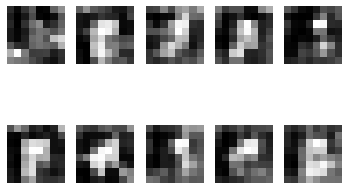

Batch 82/938 - Opimize G - Avg Batch Loss: 0.0510 - Time : 3.71s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.0858 - Time : 3.56s
Batch 84/938 - Opimize G - Avg Batch Loss: 0.0823 - Time : 3.35s
Batch 85/938 - Opimize D - Avg Batch Loss: 0.0460 - Time : 3.38s
Batch 86/938 - Opimize G - Avg Batch Loss: 0.0458 - Time : 3.40s
Batch 87/938 - Opimize G - Avg Batch Loss: 0.1807 - Time : 3.73s
Batch 88/938 - Opimize G - Avg Batch Loss: 0.0374 - Time : 3.43s
Batch 89/938 - Opimize G - Avg Batch Loss: 0.0670 - Time : 3.70s
Batch 90/938 - Opimize G - Avg Batch Loss: 0.0593 - Time : 3.59s
Batch 91/938 - Opimize D - Avg Batch Loss: 0.0975 - Time : 3.40s
Batch 92/938 - Opimize G - Avg Batch Loss: 0.1130 - Time : 3.66s
Batch 93/938 - Opimize G - Avg Batch Loss: 0.0807 - Time : 3.76s
Batch 94/938 - Opimize G - Avg Batch Loss: 0.0780 - Time : 3.45s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.0755 - Time : 3.54s
Batch 96/938 - Opimize G - Avg Batch Loss: 0.1094 - Time : 3.79s
Batch 97/938 - Opimize D 

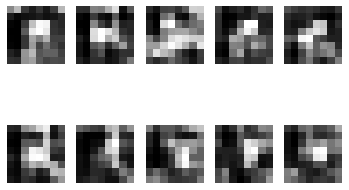

Batch 102/938 - Opimize G - Avg Batch Loss: 0.1735 - Time : 3.78s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.0667 - Time : 3.76s
Batch 104/938 - Opimize G - Avg Batch Loss: 0.0930 - Time : 3.50s
Batch 105/938 - Opimize G - Avg Batch Loss: 0.1243 - Time : 3.66s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.0761 - Time : 3.89s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.0371 - Time : 3.66s
Batch 108/938 - Opimize G - Avg Batch Loss: 0.0673 - Time : 3.74s
Batch 109/938 - Opimize D - Avg Batch Loss: 0.0243 - Time : 3.53s
Batch 110/938 - Opimize G - Avg Batch Loss: 0.0807 - Time : 3.66s
Batch 111/938 - Opimize G - Avg Batch Loss: 0.0235 - Time : 3.84s
Batch 112/938 - Opimize G - Avg Batch Loss: 0.1034 - Time : 3.55s
Batch 113/938 - Opimize G - Avg Batch Loss: 0.0548 - Time : 3.44s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.0554 - Time : 3.62s
Batch 115/938 - Opimize D - Avg Batch Loss: 0.0773 - Time : 3.82s
Batch 116/938 - Opimize G - Avg Batch Loss: 0.0306 - Time : 3.83s
Batch 117/

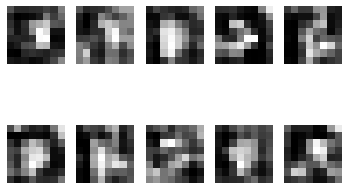

Batch 122/938 - Opimize G - Avg Batch Loss: 0.0244 - Time : 3.86s
Batch 123/938 - Opimize G - Avg Batch Loss: 0.1010 - Time : 3.43s
Batch 124/938 - Opimize G - Avg Batch Loss: 0.0950 - Time : 3.48s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.1271 - Time : 3.44s
Batch 126/938 - Opimize G - Avg Batch Loss: 0.0446 - Time : 3.49s
Batch 127/938 - Opimize D - Avg Batch Loss: 0.0558 - Time : 3.43s
Batch 128/938 - Opimize G - Avg Batch Loss: 0.0440 - Time : 3.66s
Batch 129/938 - Opimize G - Avg Batch Loss: 0.0967 - Time : 3.37s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.0664 - Time : 3.35s
Batch 131/938 - Opimize G - Avg Batch Loss: 0.1694 - Time : 3.43s
Batch 132/938 - Opimize G - Avg Batch Loss: 0.0249 - Time : 3.83s
Batch 133/938 - Opimize D - Avg Batch Loss: 0.0414 - Time : 3.84s
Batch 134/938 - Opimize G - Avg Batch Loss: 0.0825 - Time : 3.44s
Batch 135/938 - Opimize G - Avg Batch Loss: 0.0521 - Time : 3.35s
Batch 136/938 - Opimize G - Avg Batch Loss: 0.0701 - Time : 3.37s
Batch 137/

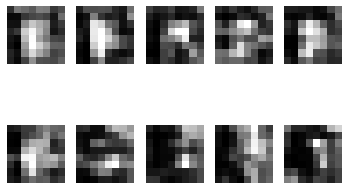

Batch 142/938 - Opimize G - Avg Batch Loss: 0.0221 - Time : 3.70s
Batch 143/938 - Opimize G - Avg Batch Loss: 0.0687 - Time : 3.48s
Batch 144/938 - Opimize G - Avg Batch Loss: 0.1183 - Time : 3.62s
Batch 145/938 - Opimize D - Avg Batch Loss: 0.1973 - Time : 3.76s
Batch 146/938 - Opimize G - Avg Batch Loss: 0.1174 - Time : 3.51s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.0811 - Time : 3.59s
Batch 148/938 - Opimize G - Avg Batch Loss: 0.0534 - Time : 3.63s
Batch 149/938 - Opimize G - Avg Batch Loss: 0.0328 - Time : 3.47s
Batch 150/938 - Opimize G - Avg Batch Loss: 0.1378 - Time : 3.77s
Batch 151/938 - Opimize D - Avg Batch Loss: 0.1375 - Time : 3.54s
Batch 152/938 - Opimize G - Avg Batch Loss: 0.1028 - Time : 3.44s
Batch 153/938 - Opimize G - Avg Batch Loss: 0.0876 - Time : 3.61s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.0604 - Time : 3.68s
Batch 155/938 - Opimize G - Avg Batch Loss: 0.0278 - Time : 3.77s
Batch 156/938 - Opimize G - Avg Batch Loss: 0.0612 - Time : 3.53s
Batch 157/

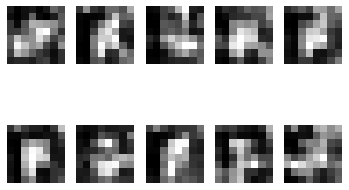

Batch 162/938 - Opimize G - Avg Batch Loss: 0.0666 - Time : 3.39s
Batch 163/938 - Opimize D - Avg Batch Loss: 0.0787 - Time : 3.52s
Batch 164/938 - Opimize G - Avg Batch Loss: 0.1233 - Time : 3.69s
Batch 165/938 - Opimize G - Avg Batch Loss: 0.0135 - Time : 3.71s
Batch 166/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.77s
Batch 167/938 - Opimize G - Avg Batch Loss: 0.1004 - Time : 3.51s
Batch 168/938 - Opimize G - Avg Batch Loss: 0.0517 - Time : 3.47s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.0469 - Time : 3.61s
Batch 170/938 - Opimize G - Avg Batch Loss: 0.0709 - Time : 3.43s
Batch 171/938 - Opimize G - Avg Batch Loss: 0.0263 - Time : 3.63s
Batch 172/938 - Opimize G - Avg Batch Loss: 0.0262 - Time : 3.47s
Batch 173/938 - Opimize G - Avg Batch Loss: 0.1008 - Time : 3.82s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.0577 - Time : 3.54s
Batch 175/938 - Opimize D - Avg Batch Loss: 0.0707 - Time : 3.59s
Batch 176/938 - Opimize G - Avg Batch Loss: 0.0378 - Time : 3.84s
Batch 177/

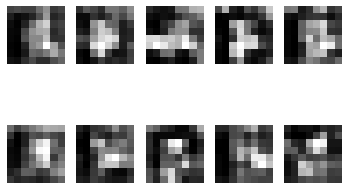

Batch 182/938 - Opimize G - Avg Batch Loss: 0.0523 - Time : 3.67s
Batch 183/938 - Opimize G - Avg Batch Loss: 0.1006 - Time : 3.55s
Batch 184/938 - Opimize G - Avg Batch Loss: 0.0927 - Time : 3.39s
Batch 185/938 - Opimize G - Avg Batch Loss: 0.0305 - Time : 3.47s
Batch 186/938 - Opimize G - Avg Batch Loss: 0.0594 - Time : 3.65s
Batch 187/938 - Opimize D - Avg Batch Loss: 0.0295 - Time : 3.44s
Batch 188/938 - Opimize G - Avg Batch Loss: 0.0559 - Time : 3.65s
Batch 189/938 - Opimize G - Avg Batch Loss: 0.0620 - Time : 3.82s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.0687 - Time : 3.56s
Batch 191/938 - Opimize G - Avg Batch Loss: 0.0320 - Time : 4.11s
Batch 192/938 - Opimize G - Avg Batch Loss: 0.0721 - Time : 3.48s
Batch 193/938 - Opimize D - Avg Batch Loss: 0.0674 - Time : 3.78s
Batch 194/938 - Opimize G - Avg Batch Loss: 0.0418 - Time : 3.83s
Batch 195/938 - Opimize G - Avg Batch Loss: 0.0936 - Time : 3.69s
Batch 196/938 - Opimize G - Avg Batch Loss: 0.0542 - Time : 3.76s
Batch 197/

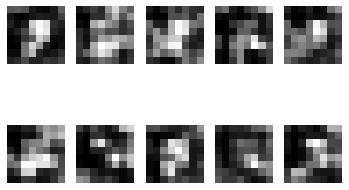

Batch 202/938 - Opimize G - Avg Batch Loss: 0.0643 - Time : 3.45s
Batch 203/938 - Opimize G - Avg Batch Loss: 0.0236 - Time : 3.70s
Batch 204/938 - Opimize G - Avg Batch Loss: 0.0920 - Time : 3.67s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.1358 - Time : 4.11s
Batch 206/938 - Opimize G - Avg Batch Loss: 0.0788 - Time : 3.49s
Batch 207/938 - Opimize G - Avg Batch Loss: 0.1020 - Time : 4.06s
Batch 208/938 - Opimize G - Avg Batch Loss: 0.0595 - Time : 3.42s
Batch 209/938 - Opimize G - Avg Batch Loss: 0.0848 - Time : 3.71s
Batch 210/938 - Opimize G - Avg Batch Loss: 0.0513 - Time : 3.78s
Batch 211/938 - Opimize D - Avg Batch Loss: 0.0239 - Time : 3.67s
Batch 212/938 - Opimize G - Avg Batch Loss: 0.1114 - Time : 3.72s
Batch 213/938 - Opimize G - Avg Batch Loss: 0.0508 - Time : 3.74s
Batch 214/938 - Opimize G - Avg Batch Loss: 0.0385 - Time : 3.55s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.0368 - Time : 3.76s
Batch 216/938 - Opimize G - Avg Batch Loss: 0.0722 - Time : 3.71s
Batch 217/

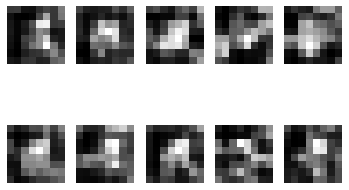

Batch 222/938 - Opimize G - Avg Batch Loss: 0.0363 - Time : 3.73s
Batch 223/938 - Opimize D - Avg Batch Loss: 0.0689 - Time : 3.64s
Batch 224/938 - Opimize G - Avg Batch Loss: 0.0348 - Time : 3.52s
Batch 225/938 - Opimize G - Avg Batch Loss: 0.1476 - Time : 3.66s
Batch 226/938 - Opimize G - Avg Batch Loss: 0.1431 - Time : 3.76s
Batch 227/938 - Opimize G - Avg Batch Loss: 0.0569 - Time : 3.52s
Batch 228/938 - Opimize G - Avg Batch Loss: 0.0223 - Time : 3.44s
Batch 229/938 - Opimize D - Avg Batch Loss: 0.0984 - Time : 3.54s
Batch 230/938 - Opimize G - Avg Batch Loss: 0.0285 - Time : 3.45s
Batch 231/938 - Opimize G - Avg Batch Loss: 0.0989 - Time : 3.42s
Batch 232/938 - Opimize G - Avg Batch Loss: 0.0424 - Time : 3.53s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.55s
Batch 234/938 - Opimize G - Avg Batch Loss: 0.0238 - Time : 3.49s
Batch 235/938 - Opimize D - Avg Batch Loss: 0.0361 - Time : 3.66s
Batch 236/938 - Opimize G - Avg Batch Loss: 0.1040 - Time : 3.86s
Batch 237/

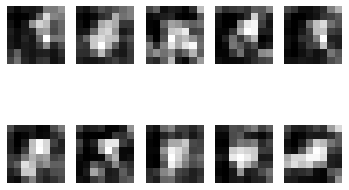

Batch 242/938 - Opimize G - Avg Batch Loss: 0.0810 - Time : 3.72s
Batch 243/938 - Opimize G - Avg Batch Loss: 0.0442 - Time : 3.58s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.0602 - Time : 3.74s
Batch 245/938 - Opimize G - Avg Batch Loss: 0.0532 - Time : 3.81s
Batch 246/938 - Opimize G - Avg Batch Loss: 0.0779 - Time : 3.52s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.0520 - Time : 3.67s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.0515 - Time : 3.73s
Batch 249/938 - Opimize G - Avg Batch Loss: 0.0820 - Time : 3.77s
Batch 250/938 - Opimize G - Avg Batch Loss: 0.0056 - Time : 3.45s
Batch 251/938 - Opimize G - Avg Batch Loss: 0.0598 - Time : 3.65s
Batch 252/938 - Opimize G - Avg Batch Loss: 0.0298 - Time : 3.76s
Batch 253/938 - Opimize D - Avg Batch Loss: 0.0712 - Time : 3.70s
Batch 254/938 - Opimize G - Avg Batch Loss: 0.0769 - Time : 3.82s
Batch 255/938 - Opimize G - Avg Batch Loss: 0.0721 - Time : 3.49s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.1239 - Time : 3.47s
Batch 257/

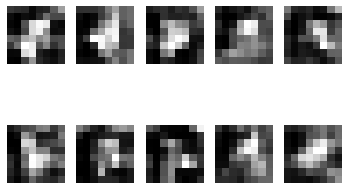

Batch 262/938 - Opimize G - Avg Batch Loss: 0.0534 - Time : 3.67s
Batch 263/938 - Opimize G - Avg Batch Loss: 0.1218 - Time : 3.63s
Batch 264/938 - Opimize G - Avg Batch Loss: 0.0433 - Time : 3.43s
Batch 265/938 - Opimize D - Avg Batch Loss: 0.0698 - Time : 3.58s
Batch 266/938 - Opimize G - Avg Batch Loss: 0.0687 - Time : 3.48s
Batch 267/938 - Opimize G - Avg Batch Loss: 0.0698 - Time : 3.66s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.0844 - Time : 3.50s
Batch 269/938 - Opimize G - Avg Batch Loss: 0.0850 - Time : 3.40s
Batch 270/938 - Opimize G - Avg Batch Loss: 0.0690 - Time : 3.74s
Batch 271/938 - Opimize D - Avg Batch Loss: 0.0744 - Time : 3.57s
Batch 272/938 - Opimize G - Avg Batch Loss: 0.0344 - Time : 3.69s
Batch 273/938 - Opimize G - Avg Batch Loss: 0.0205 - Time : 3.87s
Batch 274/938 - Opimize G - Avg Batch Loss: 0.0627 - Time : 3.57s
Batch 275/938 - Opimize G - Avg Batch Loss: 0.1272 - Time : 3.58s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.0941 - Time : 3.75s
Batch 277/

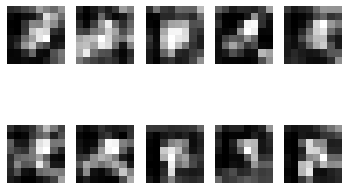

Batch 282/938 - Opimize G - Avg Batch Loss: 0.1000 - Time : 3.72s
Batch 283/938 - Opimize D - Avg Batch Loss: 0.0277 - Time : 3.89s
Batch 284/938 - Opimize G - Avg Batch Loss: 0.0486 - Time : 3.63s
Batch 285/938 - Opimize G - Avg Batch Loss: 0.0048 - Time : 3.68s
Batch 286/938 - Opimize G - Avg Batch Loss: 0.1258 - Time : 3.52s
Batch 287/938 - Opimize G - Avg Batch Loss: 0.1001 - Time : 3.76s
Batch 288/938 - Opimize G - Avg Batch Loss: 0.0556 - Time : 3.63s
Batch 289/938 - Opimize D - Avg Batch Loss: 0.0460 - Time : 3.50s
Batch 290/938 - Opimize G - Avg Batch Loss: 0.0662 - Time : 3.60s
Batch 291/938 - Opimize G - Avg Batch Loss: 0.1026 - Time : 3.97s
Batch 292/938 - Opimize G - Avg Batch Loss: 0.1029 - Time : 3.67s
Batch 293/938 - Opimize G - Avg Batch Loss: 0.0303 - Time : 3.62s
Batch 294/938 - Opimize G - Avg Batch Loss: 0.0473 - Time : 3.44s
Batch 295/938 - Opimize D - Avg Batch Loss: 0.0351 - Time : 3.77s
Batch 296/938 - Opimize G - Avg Batch Loss: 0.0642 - Time : 3.46s
Batch 297/

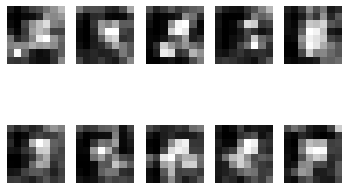

Batch 302/938 - Opimize G - Avg Batch Loss: 0.0899 - Time : 3.62s
Batch 303/938 - Opimize G - Avg Batch Loss: 0.0538 - Time : 3.60s
Batch 304/938 - Opimize G - Avg Batch Loss: 0.0592 - Time : 3.48s
Batch 305/938 - Opimize G - Avg Batch Loss: 0.0892 - Time : 3.72s
Batch 306/938 - Opimize G - Avg Batch Loss: 0.1574 - Time : 3.45s
Batch 307/938 - Opimize D - Avg Batch Loss: 0.0541 - Time : 3.46s
Batch 308/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.89s
Batch 309/938 - Opimize G - Avg Batch Loss: 0.0978 - Time : 3.60s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.0538 - Time : 3.81s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.0339 - Time : 3.45s
Batch 312/938 - Opimize G - Avg Batch Loss: 0.0346 - Time : 3.88s
Batch 313/938 - Opimize D - Avg Batch Loss: 0.0564 - Time : 3.76s
Batch 314/938 - Opimize G - Avg Batch Loss: 0.0800 - Time : 3.90s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.0701 - Time : 3.57s
Batch 316/938 - Opimize G - Avg Batch Loss: 0.0503 - Time : 3.77s
Batch 317/

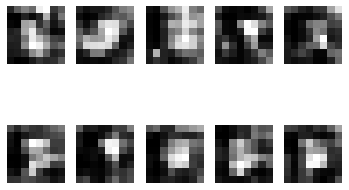

Batch 322/938 - Opimize G - Avg Batch Loss: 0.0709 - Time : 3.55s
Batch 323/938 - Opimize G - Avg Batch Loss: 0.0822 - Time : 3.60s
Batch 324/938 - Opimize G - Avg Batch Loss: 0.0315 - Time : 3.85s
Batch 325/938 - Opimize D - Avg Batch Loss: 0.1019 - Time : 3.70s
Batch 326/938 - Opimize G - Avg Batch Loss: 0.0544 - Time : 3.45s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.0287 - Time : 3.73s
Batch 328/938 - Opimize G - Avg Batch Loss: 0.0382 - Time : 3.49s
Batch 329/938 - Opimize G - Avg Batch Loss: 0.0458 - Time : 3.95s
Batch 330/938 - Opimize G - Avg Batch Loss: 0.0535 - Time : 3.71s
Batch 331/938 - Opimize D - Avg Batch Loss: 0.0645 - Time : 3.73s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.83s
Batch 333/938 - Opimize G - Avg Batch Loss: 0.0151 - Time : 3.72s
Batch 334/938 - Opimize G - Avg Batch Loss: 0.0198 - Time : 3.50s
Batch 335/938 - Opimize G - Avg Batch Loss: 0.0734 - Time : 3.79s
Batch 336/938 - Opimize G - Avg Batch Loss: 0.0908 - Time : 3.77s
Batch 337/

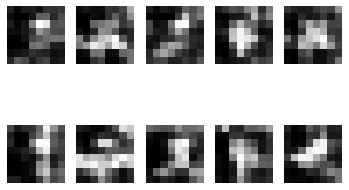

Batch 342/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 4.07s
Batch 343/938 - Opimize D - Avg Batch Loss: 0.0279 - Time : 3.90s
Batch 344/938 - Opimize G - Avg Batch Loss: 0.0308 - Time : 3.56s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.0332 - Time : 3.80s
Batch 346/938 - Opimize G - Avg Batch Loss: 0.0258 - Time : 3.73s
Batch 347/938 - Opimize G - Avg Batch Loss: 0.0388 - Time : 3.59s
Batch 348/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.51s
Batch 349/938 - Opimize D - Avg Batch Loss: 0.1213 - Time : 3.67s
Batch 350/938 - Opimize G - Avg Batch Loss: 0.0634 - Time : 3.47s
Batch 351/938 - Opimize G - Avg Batch Loss: 0.0539 - Time : 3.55s
Batch 352/938 - Opimize G - Avg Batch Loss: 0.0639 - Time : 3.87s
Batch 353/938 - Opimize G - Avg Batch Loss: 0.0619 - Time : 3.66s
Batch 354/938 - Opimize G - Avg Batch Loss: 0.0062 - Time : 3.53s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.0274 - Time : 3.83s
Batch 356/938 - Opimize G - Avg Batch Loss: 0.0758 - Time : 3.58s
Batch 357/

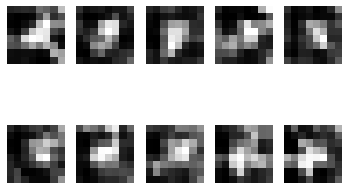

Batch 362/938 - Opimize G - Avg Batch Loss: 0.0734 - Time : 3.68s
Batch 363/938 - Opimize G - Avg Batch Loss: 0.0265 - Time : 3.49s
Batch 364/938 - Opimize G - Avg Batch Loss: 0.0311 - Time : 3.46s
Batch 365/938 - Opimize G - Avg Batch Loss: 0.0698 - Time : 3.66s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.0427 - Time : 3.80s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.0802 - Time : 3.72s
Batch 368/938 - Opimize G - Avg Batch Loss: 0.0390 - Time : 3.69s
Batch 369/938 - Opimize G - Avg Batch Loss: 0.0378 - Time : 3.90s
Batch 370/938 - Opimize G - Avg Batch Loss: 0.0564 - Time : 3.44s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.1023 - Time : 3.92s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.0325 - Time : 3.46s
Batch 373/938 - Opimize D - Avg Batch Loss: -0.0003 - Time : 3.67s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.0618 - Time : 3.57s
Batch 375/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.53s
Batch 376/938 - Opimize G - Avg Batch Loss: 0.0696 - Time : 3.60s
Batch 377

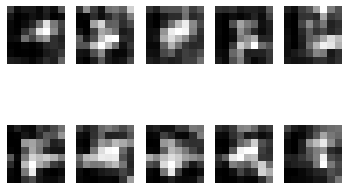

Batch 382/938 - Opimize G - Avg Batch Loss: 0.0820 - Time : 3.42s
Batch 383/938 - Opimize G - Avg Batch Loss: 0.0601 - Time : 3.77s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.0513 - Time : 3.49s
Batch 385/938 - Opimize D - Avg Batch Loss: 0.0509 - Time : 3.74s
Batch 386/938 - Opimize G - Avg Batch Loss: 0.0468 - Time : 4.21s
Batch 387/938 - Opimize G - Avg Batch Loss: 0.0419 - Time : 3.66s
Batch 388/938 - Opimize G - Avg Batch Loss: 0.0441 - Time : 3.53s
Batch 389/938 - Opimize G - Avg Batch Loss: 0.0596 - Time : 3.68s
Batch 390/938 - Opimize G - Avg Batch Loss: 0.0142 - Time : 3.75s
Batch 391/938 - Opimize D - Avg Batch Loss: 0.0424 - Time : 3.55s
Batch 392/938 - Opimize G - Avg Batch Loss: 0.0769 - Time : 3.63s
Batch 393/938 - Opimize G - Avg Batch Loss: 0.0669 - Time : 4.02s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.0439 - Time : 3.73s
Batch 395/938 - Opimize G - Avg Batch Loss: 0.0223 - Time : 3.88s
Batch 396/938 - Opimize G - Avg Batch Loss: 0.0666 - Time : 3.47s
Batch 397/

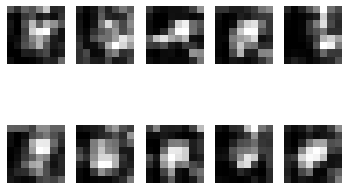

Batch 402/938 - Opimize G - Avg Batch Loss: 0.0344 - Time : 3.69s
Batch 403/938 - Opimize D - Avg Batch Loss: 0.0937 - Time : 3.73s
Batch 404/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.62s
Batch 405/938 - Opimize G - Avg Batch Loss: 0.0254 - Time : 3.66s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.0564 - Time : 3.75s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.0734 - Time : 3.94s
Batch 408/938 - Opimize G - Avg Batch Loss: 0.0707 - Time : 3.86s
Batch 409/938 - Opimize D - Avg Batch Loss: 0.0570 - Time : 3.56s
Batch 410/938 - Opimize G - Avg Batch Loss: 0.0363 - Time : 3.58s
Batch 411/938 - Opimize G - Avg Batch Loss: 0.0962 - Time : 3.57s
Batch 412/938 - Opimize G - Avg Batch Loss: 0.0437 - Time : 3.53s
Batch 413/938 - Opimize G - Avg Batch Loss: 0.0739 - Time : 3.64s
Batch 414/938 - Opimize G - Avg Batch Loss: 0.0375 - Time : 3.54s
Batch 415/938 - Opimize D - Avg Batch Loss: 0.0359 - Time : 3.45s
Batch 416/938 - Opimize G - Avg Batch Loss: 0.1816 - Time : 3.88s
Batch 417/

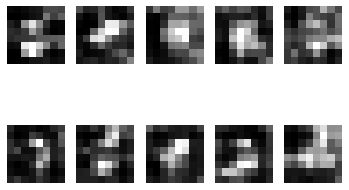

Batch 422/938 - Opimize G - Avg Batch Loss: 0.0469 - Time : 3.59s
Batch 423/938 - Opimize G - Avg Batch Loss: 0.1242 - Time : 3.78s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.0064 - Time : 4.02s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.0194 - Time : 3.98s
Batch 426/938 - Opimize G - Avg Batch Loss: -0.0014 - Time : 3.90s
Batch 427/938 - Opimize D - Avg Batch Loss: 0.0643 - Time : 3.50s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.0180 - Time : 3.92s
Batch 429/938 - Opimize G - Avg Batch Loss: 0.0529 - Time : 3.68s
Batch 430/938 - Opimize G - Avg Batch Loss: 0.1002 - Time : 3.55s
Batch 431/938 - Opimize G - Avg Batch Loss: 0.0175 - Time : 3.71s
Batch 432/938 - Opimize G - Avg Batch Loss: 0.0142 - Time : 3.70s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.0840 - Time : 3.56s
Batch 434/938 - Opimize G - Avg Batch Loss: 0.0723 - Time : 3.57s
Batch 435/938 - Opimize G - Avg Batch Loss: 0.0534 - Time : 3.73s
Batch 436/938 - Opimize G - Avg Batch Loss: 0.0707 - Time : 3.53s
Batch 437

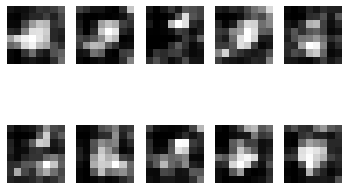

Batch 442/938 - Opimize G - Avg Batch Loss: 0.1032 - Time : 3.77s
Batch 443/938 - Opimize G - Avg Batch Loss: 0.0511 - Time : 3.51s
Batch 444/938 - Opimize G - Avg Batch Loss: 0.0430 - Time : 3.54s
Batch 445/938 - Opimize D - Avg Batch Loss: 0.0690 - Time : 3.88s
Batch 446/938 - Opimize G - Avg Batch Loss: 0.0851 - Time : 3.44s
Batch 447/938 - Opimize G - Avg Batch Loss: 0.0036 - Time : 3.42s
Batch 448/938 - Opimize G - Avg Batch Loss: 0.0884 - Time : 3.51s
Batch 449/938 - Opimize G - Avg Batch Loss: 0.0298 - Time : 3.59s
Batch 450/938 - Opimize G - Avg Batch Loss: 0.0513 - Time : 3.73s
Batch 451/938 - Opimize D - Avg Batch Loss: 0.0912 - Time : 3.61s
Batch 452/938 - Opimize G - Avg Batch Loss: 0.0390 - Time : 3.51s
Batch 453/938 - Opimize G - Avg Batch Loss: 0.0395 - Time : 3.87s
Batch 454/938 - Opimize G - Avg Batch Loss: 0.1375 - Time : 3.62s
Batch 455/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.65s
Batch 456/938 - Opimize G - Avg Batch Loss: 0.0140 - Time : 3.78s
Batch 457/

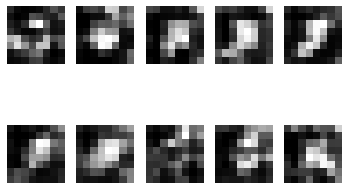

Batch 462/938 - Opimize G - Avg Batch Loss: 0.0557 - Time : 3.51s
Batch 463/938 - Opimize D - Avg Batch Loss: 0.0360 - Time : 3.61s
Batch 464/938 - Opimize G - Avg Batch Loss: 0.0401 - Time : 3.49s
Batch 465/938 - Opimize G - Avg Batch Loss: -0.0184 - Time : 3.71s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.0458 - Time : 3.56s
Batch 467/938 - Opimize G - Avg Batch Loss: 0.0556 - Time : 3.47s
Batch 468/938 - Opimize G - Avg Batch Loss: 0.0655 - Time : 3.71s
Batch 469/938 - Opimize D - Avg Batch Loss: 0.0302 - Time : 3.52s
Batch 470/938 - Opimize G - Avg Batch Loss: 0.0759 - Time : 3.66s
Batch 471/938 - Opimize G - Avg Batch Loss: 0.0676 - Time : 3.75s
Batch 472/938 - Opimize G - Avg Batch Loss: 0.0675 - Time : 4.01s
Batch 473/938 - Opimize G - Avg Batch Loss: 0.0754 - Time : 3.80s
Batch 474/938 - Opimize G - Avg Batch Loss: 0.0381 - Time : 3.81s
Batch 475/938 - Opimize D - Avg Batch Loss: 0.0869 - Time : 3.62s
Batch 476/938 - Opimize G - Avg Batch Loss: 0.0337 - Time : 3.89s
Batch 477

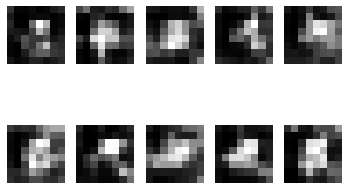

Batch 482/938 - Opimize G - Avg Batch Loss: -0.0193 - Time : 3.68s
Batch 483/938 - Opimize G - Avg Batch Loss: 0.0757 - Time : 3.48s
Batch 484/938 - Opimize G - Avg Batch Loss: 0.0730 - Time : 3.59s
Batch 485/938 - Opimize G - Avg Batch Loss: 0.1126 - Time : 3.53s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.0032 - Time : 3.53s
Batch 487/938 - Opimize D - Avg Batch Loss: 0.0934 - Time : 3.48s
Batch 488/938 - Opimize G - Avg Batch Loss: 0.0551 - Time : 3.67s
Batch 489/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.54s
Batch 490/938 - Opimize G - Avg Batch Loss: 0.0349 - Time : 3.71s
Batch 491/938 - Opimize G - Avg Batch Loss: 0.0406 - Time : 3.52s
Batch 492/938 - Opimize G - Avg Batch Loss: 0.0580 - Time : 3.68s
Batch 493/938 - Opimize D - Avg Batch Loss: 0.0585 - Time : 3.73s
Batch 494/938 - Opimize G - Avg Batch Loss: -0.0165 - Time : 3.50s
Batch 495/938 - Opimize G - Avg Batch Loss: 0.0945 - Time : 3.61s
Batch 496/938 - Opimize G - Avg Batch Loss: -0.0005 - Time : 3.79s
Batch 4

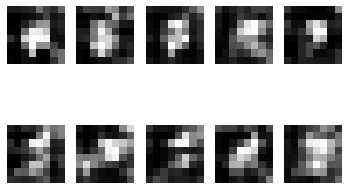

Batch 502/938 - Opimize G - Avg Batch Loss: 0.0002 - Time : 3.79s
Batch 503/938 - Opimize G - Avg Batch Loss: 0.0424 - Time : 3.55s
Batch 504/938 - Opimize G - Avg Batch Loss: 0.0534 - Time : 3.61s
Batch 505/938 - Opimize D - Avg Batch Loss: 0.0069 - Time : 3.52s
Batch 506/938 - Opimize G - Avg Batch Loss: 0.0207 - Time : 3.53s
Batch 507/938 - Opimize G - Avg Batch Loss: -0.0241 - Time : 3.55s
Batch 508/938 - Opimize G - Avg Batch Loss: 0.1086 - Time : 3.73s
Batch 509/938 - Opimize G - Avg Batch Loss: 0.0821 - Time : 3.50s
Batch 510/938 - Opimize G - Avg Batch Loss: 0.0782 - Time : 3.60s
Batch 511/938 - Opimize D - Avg Batch Loss: 0.0138 - Time : 3.49s
Batch 512/938 - Opimize G - Avg Batch Loss: 0.0651 - Time : 3.70s
Batch 513/938 - Opimize G - Avg Batch Loss: 0.0527 - Time : 3.51s
Batch 514/938 - Opimize G - Avg Batch Loss: 0.0978 - Time : 3.54s
Batch 515/938 - Opimize G - Avg Batch Loss: 0.0419 - Time : 3.75s
Batch 516/938 - Opimize G - Avg Batch Loss: 0.0117 - Time : 3.71s
Batch 517

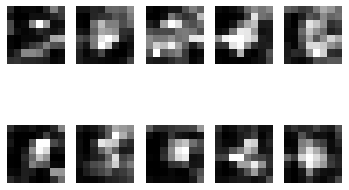

Batch 522/938 - Opimize G - Avg Batch Loss: 0.0455 - Time : 3.61s
Batch 523/938 - Opimize D - Avg Batch Loss: 0.0412 - Time : 3.85s
Batch 524/938 - Opimize G - Avg Batch Loss: 0.0309 - Time : 3.66s
Batch 525/938 - Opimize G - Avg Batch Loss: 0.0521 - Time : 3.61s
Batch 526/938 - Opimize G - Avg Batch Loss: 0.0328 - Time : 3.58s
Batch 527/938 - Opimize G - Avg Batch Loss: 0.0289 - Time : 3.51s
Batch 528/938 - Opimize G - Avg Batch Loss: 0.0756 - Time : 3.93s
Batch 529/938 - Opimize D - Avg Batch Loss: 0.0262 - Time : 3.59s
Batch 530/938 - Opimize G - Avg Batch Loss: 0.0525 - Time : 3.64s
Batch 531/938 - Opimize G - Avg Batch Loss: 0.0621 - Time : 3.79s
Batch 532/938 - Opimize G - Avg Batch Loss: 0.0490 - Time : 4.01s
Batch 533/938 - Opimize G - Avg Batch Loss: 0.0049 - Time : 3.74s
Batch 534/938 - Opimize G - Avg Batch Loss: 0.0543 - Time : 3.59s
Batch 535/938 - Opimize D - Avg Batch Loss: 0.0157 - Time : 3.61s
Batch 536/938 - Opimize G - Avg Batch Loss: -0.0004 - Time : 3.69s
Batch 537

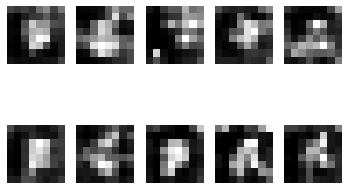

Batch 542/938 - Opimize G - Avg Batch Loss: 0.0425 - Time : 3.81s
Batch 543/938 - Opimize G - Avg Batch Loss: 0.0291 - Time : 3.54s
Batch 544/938 - Opimize G - Avg Batch Loss: 0.0030 - Time : 3.49s
Batch 545/938 - Opimize G - Avg Batch Loss: 0.0407 - Time : 3.56s
Batch 546/938 - Opimize G - Avg Batch Loss: 0.1148 - Time : 3.48s
Batch 547/938 - Opimize D - Avg Batch Loss: 0.0181 - Time : 3.60s
Batch 548/938 - Opimize G - Avg Batch Loss: 0.0551 - Time : 3.63s
Batch 549/938 - Opimize G - Avg Batch Loss: 0.0632 - Time : 3.54s
Batch 550/938 - Opimize G - Avg Batch Loss: 0.0457 - Time : 3.63s
Batch 551/938 - Opimize G - Avg Batch Loss: 0.0811 - Time : 3.83s
Batch 552/938 - Opimize G - Avg Batch Loss: 0.0199 - Time : 3.55s
Batch 553/938 - Opimize D - Avg Batch Loss: 0.0630 - Time : 3.64s
Batch 554/938 - Opimize G - Avg Batch Loss: 0.0159 - Time : 3.49s
Batch 555/938 - Opimize G - Avg Batch Loss: 0.0763 - Time : 3.51s
Batch 556/938 - Opimize G - Avg Batch Loss: 0.0334 - Time : 3.74s
Batch 557/

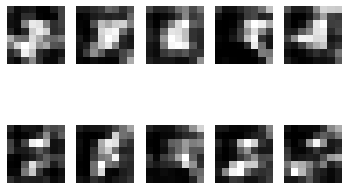

Batch 562/938 - Opimize G - Avg Batch Loss: 0.0586 - Time : 3.81s
Batch 563/938 - Opimize G - Avg Batch Loss: 0.0663 - Time : 3.91s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.0269 - Time : 3.69s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.0823 - Time : 3.71s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.0501 - Time : 3.64s
Batch 567/938 - Opimize G - Avg Batch Loss: 0.0341 - Time : 3.77s
Batch 568/938 - Opimize G - Avg Batch Loss: 0.0836 - Time : 3.80s
Batch 569/938 - Opimize G - Avg Batch Loss: 0.0526 - Time : 3.92s
Batch 570/938 - Opimize G - Avg Batch Loss: 0.0083 - Time : 4.00s
Batch 571/938 - Opimize D - Avg Batch Loss: 0.0287 - Time : 3.55s
Batch 572/938 - Opimize G - Avg Batch Loss: 0.0681 - Time : 3.74s
Batch 573/938 - Opimize G - Avg Batch Loss: 0.0446 - Time : 3.92s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.0568 - Time : 3.74s
Batch 575/938 - Opimize G - Avg Batch Loss: 0.0758 - Time : 3.77s
Batch 576/938 - Opimize G - Avg Batch Loss: 0.0646 - Time : 3.61s
Batch 577/

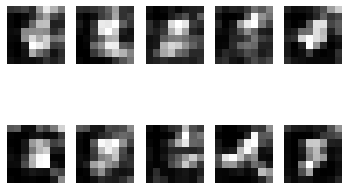

Batch 582/938 - Opimize G - Avg Batch Loss: 0.0915 - Time : 3.72s
Batch 583/938 - Opimize D - Avg Batch Loss: 0.0402 - Time : 3.63s
Batch 584/938 - Opimize G - Avg Batch Loss: 0.0371 - Time : 3.84s
Batch 585/938 - Opimize G - Avg Batch Loss: 0.1356 - Time : 3.81s
Batch 586/938 - Opimize G - Avg Batch Loss: 0.0387 - Time : 3.83s
Batch 587/938 - Opimize G - Avg Batch Loss: 0.0468 - Time : 3.54s
Batch 588/938 - Opimize G - Avg Batch Loss: 0.0980 - Time : 3.56s
Batch 589/938 - Opimize D - Avg Batch Loss: 0.0099 - Time : 3.53s
Batch 590/938 - Opimize G - Avg Batch Loss: 0.0562 - Time : 3.59s
Batch 591/938 - Opimize G - Avg Batch Loss: 0.0117 - Time : 3.58s
Batch 592/938 - Opimize G - Avg Batch Loss: 0.0205 - Time : 3.71s
Batch 593/938 - Opimize G - Avg Batch Loss: 0.0325 - Time : 3.84s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.0411 - Time : 3.59s
Batch 595/938 - Opimize D - Avg Batch Loss: 0.0674 - Time : 3.51s
Batch 596/938 - Opimize G - Avg Batch Loss: 0.0492 - Time : 3.66s
Batch 597/

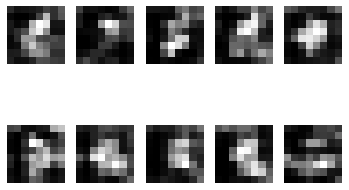

Batch 602/938 - Opimize G - Avg Batch Loss: 0.0184 - Time : 3.50s
Batch 603/938 - Opimize G - Avg Batch Loss: -0.0187 - Time : 3.54s
Batch 604/938 - Opimize G - Avg Batch Loss: 0.0676 - Time : 3.50s
Batch 605/938 - Opimize G - Avg Batch Loss: 0.0505 - Time : 3.53s
Batch 606/938 - Opimize G - Avg Batch Loss: 0.0283 - Time : 3.54s
Batch 607/938 - Opimize D - Avg Batch Loss: 0.0404 - Time : 3.71s
Batch 608/938 - Opimize G - Avg Batch Loss: 0.0328 - Time : 3.69s
Batch 609/938 - Opimize G - Avg Batch Loss: 0.0337 - Time : 3.63s
Batch 610/938 - Opimize G - Avg Batch Loss: 0.0428 - Time : 3.76s
Batch 611/938 - Opimize G - Avg Batch Loss: -0.0025 - Time : 3.54s
Batch 612/938 - Opimize G - Avg Batch Loss: 0.0202 - Time : 3.73s
Batch 613/938 - Opimize D - Avg Batch Loss: 0.0854 - Time : 3.82s
Batch 614/938 - Opimize G - Avg Batch Loss: 0.0100 - Time : 3.68s
Batch 615/938 - Opimize G - Avg Batch Loss: 0.0202 - Time : 3.75s
Batch 616/938 - Opimize G - Avg Batch Loss: 0.0453 - Time : 3.54s
Batch 61

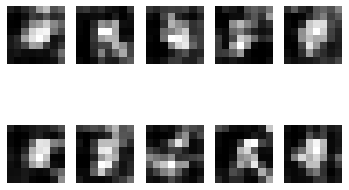

Batch 622/938 - Opimize G - Avg Batch Loss: 0.0838 - Time : 3.49s
Batch 623/938 - Opimize G - Avg Batch Loss: 0.0302 - Time : 3.66s
Batch 624/938 - Opimize G - Avg Batch Loss: -0.0143 - Time : 3.63s
Batch 625/938 - Opimize D - Avg Batch Loss: 0.1026 - Time : 3.81s
Batch 626/938 - Opimize G - Avg Batch Loss: -0.0294 - Time : 3.65s
Batch 627/938 - Opimize G - Avg Batch Loss: 0.0283 - Time : 3.63s
Batch 628/938 - Opimize G - Avg Batch Loss: 0.0488 - Time : 3.72s
Batch 629/938 - Opimize G - Avg Batch Loss: 0.0166 - Time : 3.66s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.0063 - Time : 3.55s
Batch 631/938 - Opimize D - Avg Batch Loss: 0.0743 - Time : 3.57s
Batch 632/938 - Opimize G - Avg Batch Loss: 0.0123 - Time : 3.51s
Batch 633/938 - Opimize G - Avg Batch Loss: 0.0759 - Time : 3.97s
Batch 634/938 - Opimize G - Avg Batch Loss: 0.0534 - Time : 3.77s
Batch 635/938 - Opimize G - Avg Batch Loss: 0.0246 - Time : 3.63s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.54s
Batch 63

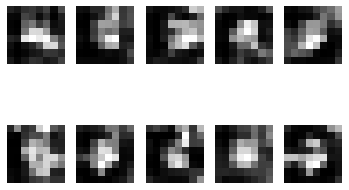

Batch 642/938 - Opimize G - Avg Batch Loss: 0.0532 - Time : 3.80s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.0264 - Time : 3.92s
Batch 644/938 - Opimize G - Avg Batch Loss: 0.0613 - Time : 3.54s
Batch 645/938 - Opimize G - Avg Batch Loss: 0.0858 - Time : 3.76s
Batch 646/938 - Opimize G - Avg Batch Loss: 0.0448 - Time : 3.61s
Batch 647/938 - Opimize G - Avg Batch Loss: 0.0410 - Time : 3.61s
Batch 648/938 - Opimize G - Avg Batch Loss: 0.0312 - Time : 3.61s
Batch 649/938 - Opimize D - Avg Batch Loss: 0.0159 - Time : 4.25s
Batch 650/938 - Opimize G - Avg Batch Loss: 0.0360 - Time : 3.68s
Batch 651/938 - Opimize G - Avg Batch Loss: 0.0527 - Time : 3.55s
Batch 652/938 - Opimize G - Avg Batch Loss: 0.0626 - Time : 3.64s
Batch 653/938 - Opimize G - Avg Batch Loss: 0.0075 - Time : 3.65s
Batch 654/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.61s
Batch 655/938 - Opimize D - Avg Batch Loss: 0.0261 - Time : 3.72s
Batch 656/938 - Opimize G - Avg Batch Loss: 0.0754 - Time : 3.51s
Batch 657/

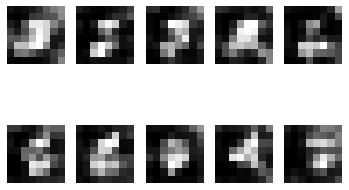

Batch 662/938 - Opimize G - Avg Batch Loss: 0.0328 - Time : 3.57s
Batch 663/938 - Opimize G - Avg Batch Loss: 0.0526 - Time : 3.83s
Batch 664/938 - Opimize G - Avg Batch Loss: 0.0087 - Time : 3.80s
Batch 665/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.92s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.0588 - Time : 3.80s
Batch 667/938 - Opimize D - Avg Batch Loss: 0.0397 - Time : 3.55s
Batch 668/938 - Opimize G - Avg Batch Loss: 0.0357 - Time : 3.90s
Batch 669/938 - Opimize G - Avg Batch Loss: 0.0110 - Time : 4.10s
Batch 670/938 - Opimize G - Avg Batch Loss: 0.0140 - Time : 3.75s
Batch 671/938 - Opimize G - Avg Batch Loss: 0.0939 - Time : 3.59s
Batch 672/938 - Opimize G - Avg Batch Loss: 0.0472 - Time : 4.15s
Batch 673/938 - Opimize D - Avg Batch Loss: 0.0098 - Time : 3.77s
Batch 674/938 - Opimize G - Avg Batch Loss: 0.0328 - Time : 3.47s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.0094 - Time : 3.72s
Batch 676/938 - Opimize G - Avg Batch Loss: 0.0419 - Time : 4.04s
Batch 677/

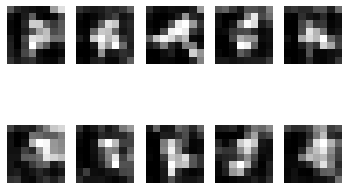

Batch 682/938 - Opimize G - Avg Batch Loss: 0.0472 - Time : 3.95s
Batch 683/938 - Opimize G - Avg Batch Loss: 0.0752 - Time : 3.48s
Batch 684/938 - Opimize G - Avg Batch Loss: 0.0234 - Time : 3.59s
Batch 685/938 - Opimize D - Avg Batch Loss: 0.0693 - Time : 3.60s
Batch 686/938 - Opimize G - Avg Batch Loss: 0.0182 - Time : 3.55s
Batch 687/938 - Opimize G - Avg Batch Loss: 0.0468 - Time : 3.61s
Batch 688/938 - Opimize G - Avg Batch Loss: 0.0363 - Time : 3.84s
Batch 689/938 - Opimize G - Avg Batch Loss: 0.0267 - Time : 3.55s
Batch 690/938 - Opimize G - Avg Batch Loss: 0.0437 - Time : 3.75s
Batch 691/938 - Opimize D - Avg Batch Loss: 0.0221 - Time : 3.62s
Batch 692/938 - Opimize G - Avg Batch Loss: 0.0739 - Time : 3.62s
Batch 693/938 - Opimize G - Avg Batch Loss: 0.0597 - Time : 3.83s
Batch 694/938 - Opimize G - Avg Batch Loss: 0.0101 - Time : 3.79s
Batch 695/938 - Opimize G - Avg Batch Loss: 0.0059 - Time : 3.54s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.0266 - Time : 3.56s
Batch 697/

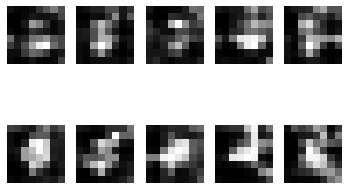

Batch 702/938 - Opimize G - Avg Batch Loss: 0.0747 - Time : 4.17s
Batch 703/938 - Opimize D - Avg Batch Loss: -0.0043 - Time : 3.82s
Batch 704/938 - Opimize G - Avg Batch Loss: 0.0022 - Time : 3.63s
Batch 705/938 - Opimize G - Avg Batch Loss: -0.0239 - Time : 3.65s
Batch 706/938 - Opimize G - Avg Batch Loss: 0.0239 - Time : 3.77s
Batch 707/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.80s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.1000 - Time : 3.99s
Batch 709/938 - Opimize D - Avg Batch Loss: 0.0145 - Time : 3.89s
Batch 710/938 - Opimize G - Avg Batch Loss: -0.0072 - Time : 4.05s
Batch 711/938 - Opimize G - Avg Batch Loss: 0.0088 - Time : 3.93s
Batch 712/938 - Opimize G - Avg Batch Loss: 0.0438 - Time : 3.92s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 3.84s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.0342 - Time : 3.80s
Batch 715/938 - Opimize D - Avg Batch Loss: 0.0060 - Time : 3.84s
Batch 716/938 - Opimize G - Avg Batch Loss: 0.0108 - Time : 4.13s
Batch 7

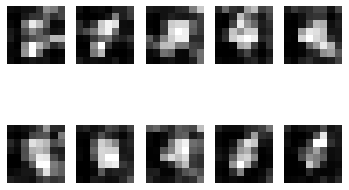

Batch 722/938 - Opimize G - Avg Batch Loss: 0.0409 - Time : 3.80s
Batch 723/938 - Opimize G - Avg Batch Loss: 0.0486 - Time : 3.64s
Batch 724/938 - Opimize G - Avg Batch Loss: 0.0138 - Time : 3.87s
Batch 725/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.65s
Batch 726/938 - Opimize G - Avg Batch Loss: 0.0360 - Time : 3.75s
Batch 727/938 - Opimize D - Avg Batch Loss: 0.0259 - Time : 4.06s
Batch 728/938 - Opimize G - Avg Batch Loss: 0.0153 - Time : 3.72s
Batch 729/938 - Opimize G - Avg Batch Loss: 0.0465 - Time : 4.27s
Batch 730/938 - Opimize G - Avg Batch Loss: 0.0399 - Time : 3.61s
Batch 731/938 - Opimize G - Avg Batch Loss: 0.0371 - Time : 3.53s
Batch 732/938 - Opimize G - Avg Batch Loss: 0.0055 - Time : 3.51s
Batch 733/938 - Opimize D - Avg Batch Loss: 0.0174 - Time : 3.58s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.1185 - Time : 3.78s
Batch 735/938 - Opimize G - Avg Batch Loss: 0.0180 - Time : 3.78s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.0375 - Time : 3.68s
Batch 737/

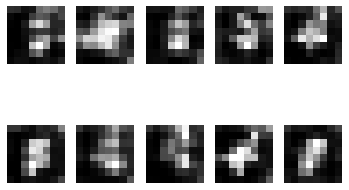

Batch 742/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.87s
Batch 743/938 - Opimize G - Avg Batch Loss: 0.0648 - Time : 3.56s
Batch 744/938 - Opimize G - Avg Batch Loss: 0.0197 - Time : 3.57s
Batch 745/938 - Opimize D - Avg Batch Loss: 0.0224 - Time : 3.79s
Batch 746/938 - Opimize G - Avg Batch Loss: 0.0764 - Time : 3.63s
Batch 747/938 - Opimize G - Avg Batch Loss: 0.0674 - Time : 4.09s
Batch 748/938 - Opimize G - Avg Batch Loss: 0.0215 - Time : 3.73s
Batch 749/938 - Opimize G - Avg Batch Loss: 0.0420 - Time : 4.00s
Batch 750/938 - Opimize G - Avg Batch Loss: 0.0243 - Time : 3.84s
Batch 751/938 - Opimize D - Avg Batch Loss: 0.0523 - Time : 3.77s
Batch 752/938 - Opimize G - Avg Batch Loss: 0.0028 - Time : 3.63s
Batch 753/938 - Opimize G - Avg Batch Loss: 0.0207 - Time : 3.61s
Batch 754/938 - Opimize G - Avg Batch Loss: 0.0181 - Time : 3.59s
Batch 755/938 - Opimize G - Avg Batch Loss: 0.0301 - Time : 3.63s
Batch 756/938 - Opimize G - Avg Batch Loss: 0.0133 - Time : 3.86s
Batch 757/

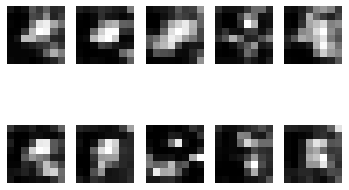

Batch 762/938 - Opimize G - Avg Batch Loss: 0.0403 - Time : 4.13s
Batch 763/938 - Opimize D - Avg Batch Loss: 0.0206 - Time : 3.68s
Batch 764/938 - Opimize G - Avg Batch Loss: 0.0289 - Time : 3.55s
Batch 765/938 - Opimize G - Avg Batch Loss: 0.0257 - Time : 3.54s
Batch 766/938 - Opimize G - Avg Batch Loss: 0.0344 - Time : 3.60s
Batch 767/938 - Opimize G - Avg Batch Loss: 0.0434 - Time : 3.87s
Batch 768/938 - Opimize G - Avg Batch Loss: -0.0028 - Time : 3.67s
Batch 769/938 - Opimize D - Avg Batch Loss: 0.0267 - Time : 3.75s
Batch 770/938 - Opimize G - Avg Batch Loss: 0.0487 - Time : 3.53s
Batch 771/938 - Opimize G - Avg Batch Loss: -0.0144 - Time : 3.59s
Batch 772/938 - Opimize G - Avg Batch Loss: 0.0602 - Time : 3.80s
Batch 773/938 - Opimize G - Avg Batch Loss: -0.0052 - Time : 3.81s
Batch 774/938 - Opimize G - Avg Batch Loss: 0.0404 - Time : 3.62s
Batch 775/938 - Opimize D - Avg Batch Loss: 0.0380 - Time : 4.10s
Batch 776/938 - Opimize G - Avg Batch Loss: 0.0425 - Time : 3.71s
Batch 7

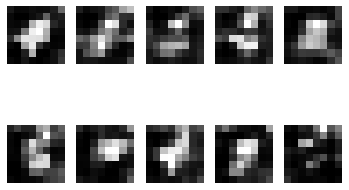

Batch 782/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.59s
Batch 783/938 - Opimize G - Avg Batch Loss: 0.0316 - Time : 3.80s
Batch 784/938 - Opimize G - Avg Batch Loss: 0.0134 - Time : 3.90s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.0352 - Time : 3.84s
Batch 786/938 - Opimize G - Avg Batch Loss: 0.0387 - Time : 3.59s
Batch 787/938 - Opimize D - Avg Batch Loss: 0.0114 - Time : 3.76s
Batch 788/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.59s
Batch 789/938 - Opimize G - Avg Batch Loss: -0.0082 - Time : 3.60s
Batch 790/938 - Opimize G - Avg Batch Loss: 0.0986 - Time : 3.76s
Batch 791/938 - Opimize G - Avg Batch Loss: 0.0341 - Time : 3.53s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.0261 - Time : 3.66s
Batch 793/938 - Opimize D - Avg Batch Loss: 0.0240 - Time : 4.47s
Batch 794/938 - Opimize G - Avg Batch Loss: 0.0068 - Time : 3.71s
Batch 795/938 - Opimize G - Avg Batch Loss: 0.1058 - Time : 3.73s
Batch 796/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 3.61s
Batch 797

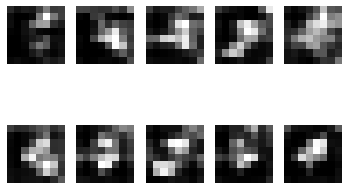

Batch 802/938 - Opimize G - Avg Batch Loss: 0.0667 - Time : 3.64s
Batch 803/938 - Opimize G - Avg Batch Loss: 0.0469 - Time : 3.63s
Batch 804/938 - Opimize G - Avg Batch Loss: 0.0101 - Time : 3.83s
Batch 805/938 - Opimize D - Avg Batch Loss: 0.0535 - Time : 3.52s
Batch 806/938 - Opimize G - Avg Batch Loss: -0.0009 - Time : 3.81s
Batch 807/938 - Opimize G - Avg Batch Loss: 0.0356 - Time : 3.58s
Batch 808/938 - Opimize G - Avg Batch Loss: 0.0035 - Time : 3.53s
Batch 809/938 - Opimize G - Avg Batch Loss: 0.0551 - Time : 3.86s
Batch 810/938 - Opimize G - Avg Batch Loss: 0.0296 - Time : 3.60s
Batch 811/938 - Opimize D - Avg Batch Loss: -0.0046 - Time : 3.72s
Batch 812/938 - Opimize G - Avg Batch Loss: 0.0222 - Time : 3.59s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.0293 - Time : 3.66s
Batch 814/938 - Opimize G - Avg Batch Loss: 0.0235 - Time : 3.95s
Batch 815/938 - Opimize G - Avg Batch Loss: -0.0115 - Time : 3.81s
Batch 816/938 - Opimize G - Avg Batch Loss: 0.0100 - Time : 3.67s
Batch 8

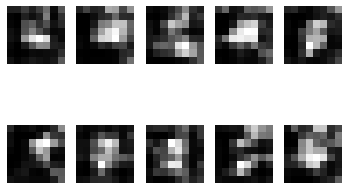

Batch 822/938 - Opimize G - Avg Batch Loss: 0.0060 - Time : 3.54s
Batch 823/938 - Opimize D - Avg Batch Loss: -0.0180 - Time : 3.57s
Batch 824/938 - Opimize G - Avg Batch Loss: 0.0456 - Time : 3.59s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.0487 - Time : 3.90s
Batch 826/938 - Opimize G - Avg Batch Loss: -0.0199 - Time : 3.84s
Batch 827/938 - Opimize G - Avg Batch Loss: 0.0333 - Time : 3.84s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.0464 - Time : 3.50s
Batch 829/938 - Opimize D - Avg Batch Loss: 0.0104 - Time : 3.54s
Batch 830/938 - Opimize G - Avg Batch Loss: 0.0196 - Time : 3.91s
Batch 831/938 - Opimize G - Avg Batch Loss: -0.0342 - Time : 3.66s
Batch 832/938 - Opimize G - Avg Batch Loss: 0.0215 - Time : 4.02s
Batch 833/938 - Opimize G - Avg Batch Loss: 0.0096 - Time : 3.72s
Batch 834/938 - Opimize G - Avg Batch Loss: 0.0124 - Time : 3.58s
Batch 835/938 - Opimize D - Avg Batch Loss: 0.0365 - Time : 3.88s
Batch 836/938 - Opimize G - Avg Batch Loss: 0.0715 - Time : 3.67s
Batch 8

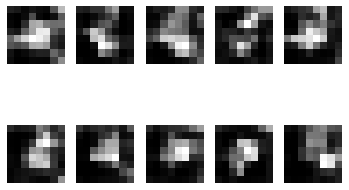

Batch 842/938 - Opimize G - Avg Batch Loss: 0.0434 - Time : 3.68s
Batch 843/938 - Opimize G - Avg Batch Loss: 0.0070 - Time : 3.62s
Batch 844/938 - Opimize G - Avg Batch Loss: 0.0007 - Time : 3.47s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.0034 - Time : 3.97s
Batch 846/938 - Opimize G - Avg Batch Loss: 0.0049 - Time : 3.79s
Batch 847/938 - Opimize D - Avg Batch Loss: 0.0006 - Time : 3.54s
Batch 848/938 - Opimize G - Avg Batch Loss: 0.0746 - Time : 3.56s
Batch 849/938 - Opimize G - Avg Batch Loss: 0.0450 - Time : 3.55s
Batch 850/938 - Opimize G - Avg Batch Loss: -0.0075 - Time : 3.58s
Batch 851/938 - Opimize G - Avg Batch Loss: 0.0538 - Time : 3.78s
Batch 852/938 - Opimize G - Avg Batch Loss: 0.0437 - Time : 3.65s
Batch 853/938 - Opimize D - Avg Batch Loss: 0.0160 - Time : 3.62s
Batch 854/938 - Opimize G - Avg Batch Loss: 0.0037 - Time : 3.57s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 3.55s
Batch 856/938 - Opimize G - Avg Batch Loss: 0.0553 - Time : 3.68s
Batch 857

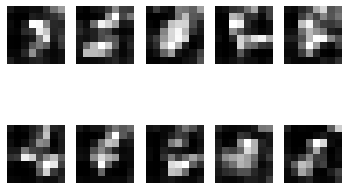

Batch 862/938 - Opimize G - Avg Batch Loss: 0.0068 - Time : 3.64s
Batch 863/938 - Opimize G - Avg Batch Loss: -0.0102 - Time : 3.95s
Batch 864/938 - Opimize G - Avg Batch Loss: 0.0506 - Time : 3.53s
Batch 865/938 - Opimize D - Avg Batch Loss: 0.0069 - Time : 3.77s
Batch 866/938 - Opimize G - Avg Batch Loss: 0.0182 - Time : 3.60s
Batch 867/938 - Opimize G - Avg Batch Loss: 0.0297 - Time : 3.73s
Batch 868/938 - Opimize G - Avg Batch Loss: 0.0771 - Time : 3.94s
Batch 869/938 - Opimize G - Avg Batch Loss: 0.0108 - Time : 3.60s
Batch 870/938 - Opimize G - Avg Batch Loss: 0.0364 - Time : 3.70s
Batch 871/938 - Opimize D - Avg Batch Loss: 0.0093 - Time : 3.64s
Batch 872/938 - Opimize G - Avg Batch Loss: 0.0297 - Time : 3.78s
Batch 873/938 - Opimize G - Avg Batch Loss: 0.0132 - Time : 3.97s
Batch 874/938 - Opimize G - Avg Batch Loss: 0.0467 - Time : 3.50s
Batch 875/938 - Opimize G - Avg Batch Loss: 0.0626 - Time : 3.82s
Batch 876/938 - Opimize G - Avg Batch Loss: 0.0002 - Time : 3.52s
Batch 877

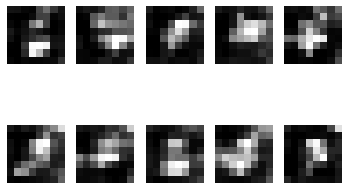

Batch 882/938 - Opimize G - Avg Batch Loss: 0.0250 - Time : 3.61s
Batch 883/938 - Opimize D - Avg Batch Loss: 0.0337 - Time : 3.89s
Batch 884/938 - Opimize G - Avg Batch Loss: 0.0561 - Time : 4.00s
Batch 885/938 - Opimize G - Avg Batch Loss: 0.0419 - Time : 3.71s
Batch 886/938 - Opimize G - Avg Batch Loss: 0.0244 - Time : 3.91s
Batch 887/938 - Opimize G - Avg Batch Loss: 0.0630 - Time : 3.71s
Batch 888/938 - Opimize G - Avg Batch Loss: 0.0459 - Time : 3.52s
Batch 889/938 - Opimize D - Avg Batch Loss: 0.0281 - Time : 3.86s
Batch 890/938 - Opimize G - Avg Batch Loss: 0.0230 - Time : 3.64s
Batch 891/938 - Opimize G - Avg Batch Loss: 0.0302 - Time : 3.58s
Batch 892/938 - Opimize G - Avg Batch Loss: 0.0479 - Time : 3.61s
Batch 893/938 - Opimize G - Avg Batch Loss: -0.0019 - Time : 3.59s
Batch 894/938 - Opimize G - Avg Batch Loss: 0.0486 - Time : 3.71s
Batch 895/938 - Opimize D - Avg Batch Loss: 0.1024 - Time : 4.20s
Batch 896/938 - Opimize G - Avg Batch Loss: 0.0413 - Time : 3.53s
Batch 897

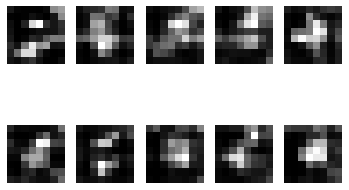

Batch 902/938 - Opimize G - Avg Batch Loss: 0.0371 - Time : 3.54s
Batch 903/938 - Opimize G - Avg Batch Loss: 0.0561 - Time : 3.96s
Batch 904/938 - Opimize G - Avg Batch Loss: -0.0105 - Time : 3.68s
Batch 905/938 - Opimize G - Avg Batch Loss: 0.0299 - Time : 3.69s
Batch 906/938 - Opimize G - Avg Batch Loss: 0.0433 - Time : 3.82s
Batch 907/938 - Opimize D - Avg Batch Loss: 0.0336 - Time : 4.21s
Batch 908/938 - Opimize G - Avg Batch Loss: 0.0216 - Time : 3.66s
Batch 909/938 - Opimize G - Avg Batch Loss: 0.0137 - Time : 3.74s
Batch 910/938 - Opimize G - Avg Batch Loss: 0.0595 - Time : 3.54s
Batch 911/938 - Opimize G - Avg Batch Loss: 0.0650 - Time : 3.65s
Batch 912/938 - Opimize G - Avg Batch Loss: 0.0221 - Time : 3.93s
Batch 913/938 - Opimize D - Avg Batch Loss: -0.0033 - Time : 3.51s
Batch 914/938 - Opimize G - Avg Batch Loss: -0.0065 - Time : 3.52s
Batch 915/938 - Opimize G - Avg Batch Loss: 0.0239 - Time : 3.50s
Batch 916/938 - Opimize G - Avg Batch Loss: 0.0033 - Time : 4.02s
Batch 9

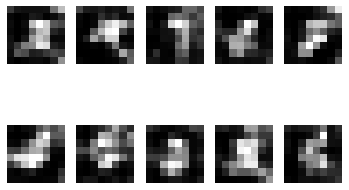

Batch 922/938 - Opimize G - Avg Batch Loss: 0.0201 - Time : 3.96s
Batch 923/938 - Opimize G - Avg Batch Loss: -0.0234 - Time : 3.73s
Batch 924/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.51s
Batch 925/938 - Opimize D - Avg Batch Loss: -0.0025 - Time : 3.62s
Batch 926/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.54s
Batch 927/938 - Opimize G - Avg Batch Loss: 0.0223 - Time : 3.66s
Batch 928/938 - Opimize G - Avg Batch Loss: 0.0448 - Time : 3.96s
Batch 929/938 - Opimize G - Avg Batch Loss: 0.0192 - Time : 3.71s
Batch 930/938 - Opimize G - Avg Batch Loss: 0.0554 - Time : 3.71s
Batch 931/938 - Opimize D - Avg Batch Loss: -0.0008 - Time : 3.61s
Batch 932/938 - Opimize G - Avg Batch Loss: 0.0235 - Time : 3.56s
Batch 933/938 - Opimize G - Avg Batch Loss: 0.0280 - Time : 3.86s
Batch 934/938 - Opimize G - Avg Batch Loss: -0.0191 - Time : 3.60s
Batch 935/938 - Opimize G - Avg Batch Loss: 0.0159 - Time : 3.72s
Batch 936/938 - Opimize G - Avg Batch Loss: -0.0039 - Time : 3.82s
Batch

In [16]:
history1 = train(n_gen=5, n_epochs = 1, batch_size = 64, plt_samples = 20)

In [0]:
history.extend(history1)

Text(0.5, 1.0, 'Loss history of the first two epochs')

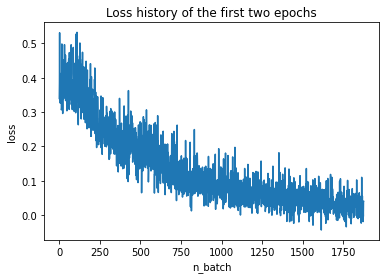

In [21]:
plt.plot(history)
plt.ylabel("loss")
plt.xlabel("n_batch")
plt.title("Loss history of the first two epochs")

In [0]:
np.savetxt("history_cnn_1.txt", history)

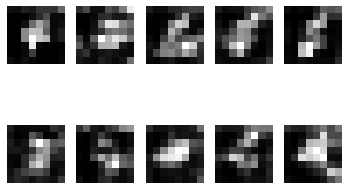

In [22]:
generate_plt()

In [0]:
torch.save(generator.state_dict(), "generatorCNN_2epochs.statedict")
torch.save(discriminator.state_dict(), "discriminatorCNN_2epochs.statedict")

========================Epoch: 1 / 1 =======================
Batch 1/938 - Opimize D - Avg Batch Loss: 0.0128 - Time : 3.84s


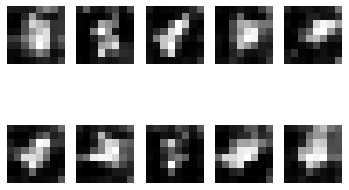

Batch 2/938 - Opimize G - Avg Batch Loss: 0.2045 - Time : 3.44s
Batch 3/938 - Opimize G - Avg Batch Loss: 0.0085 - Time : 4.00s
Batch 4/938 - Opimize G - Avg Batch Loss: -0.0201 - Time : 3.44s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.0060 - Time : 3.69s
Batch 6/938 - Opimize G - Avg Batch Loss: 0.0110 - Time : 3.85s
Batch 7/938 - Opimize D - Avg Batch Loss: -0.0134 - Time : 3.87s
Batch 8/938 - Opimize G - Avg Batch Loss: 0.0350 - Time : 3.74s
Batch 9/938 - Opimize G - Avg Batch Loss: -0.0132 - Time : 3.49s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.0203 - Time : 3.39s
Batch 11/938 - Opimize G - Avg Batch Loss: 0.0463 - Time : 3.38s
Batch 12/938 - Opimize G - Avg Batch Loss: -0.0182 - Time : 3.44s
Batch 13/938 - Opimize D - Avg Batch Loss: 0.0176 - Time : 3.46s
Batch 14/938 - Opimize G - Avg Batch Loss: -0.0099 - Time : 3.65s
Batch 15/938 - Opimize G - Avg Batch Loss: 0.0935 - Time : 3.63s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.0425 - Time : 4.03s
Batch 17/938 - Opimize G - A

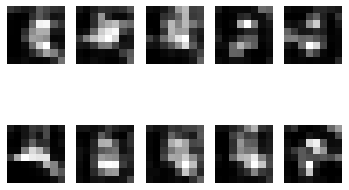

Batch 22/938 - Opimize G - Avg Batch Loss: 0.0147 - Time : 3.91s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.0058 - Time : 3.45s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.0287 - Time : 3.43s
Batch 25/938 - Opimize D - Avg Batch Loss: -0.0041 - Time : 3.65s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.0118 - Time : 3.59s
Batch 27/938 - Opimize G - Avg Batch Loss: 0.0210 - Time : 3.62s
Batch 28/938 - Opimize G - Avg Batch Loss: 0.0201 - Time : 3.87s
Batch 29/938 - Opimize G - Avg Batch Loss: 0.0216 - Time : 3.88s
Batch 30/938 - Opimize G - Avg Batch Loss: -0.0189 - Time : 3.42s
Batch 31/938 - Opimize D - Avg Batch Loss: 0.0034 - Time : 3.42s
Batch 32/938 - Opimize G - Avg Batch Loss: 0.0197 - Time : 3.76s
Batch 33/938 - Opimize G - Avg Batch Loss: -0.0337 - Time : 3.59s
Batch 34/938 - Opimize G - Avg Batch Loss: -0.0051 - Time : 3.41s
Batch 35/938 - Opimize G - Avg Batch Loss: 0.0222 - Time : 3.45s
Batch 36/938 - Opimize G - Avg Batch Loss: -0.0196 - Time : 3.50s
Batch 37/938 - Opimi

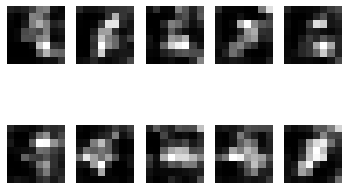

Batch 42/938 - Opimize G - Avg Batch Loss: 0.0181 - Time : 3.81s
Batch 43/938 - Opimize D - Avg Batch Loss: 0.0178 - Time : 3.57s
Batch 44/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.54s
Batch 45/938 - Opimize G - Avg Batch Loss: 0.0049 - Time : 3.53s
Batch 46/938 - Opimize G - Avg Batch Loss: -0.0091 - Time : 3.85s
Batch 47/938 - Opimize G - Avg Batch Loss: -0.0121 - Time : 3.48s
Batch 48/938 - Opimize G - Avg Batch Loss: 0.0066 - Time : 3.84s
Batch 49/938 - Opimize D - Avg Batch Loss: 0.0359 - Time : 3.36s
Batch 50/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 3.55s
Batch 51/938 - Opimize G - Avg Batch Loss: 0.0282 - Time : 3.40s
Batch 52/938 - Opimize G - Avg Batch Loss: 0.0245 - Time : 3.36s
Batch 53/938 - Opimize G - Avg Batch Loss: 0.0314 - Time : 3.61s
Batch 54/938 - Opimize G - Avg Batch Loss: 0.0111 - Time : 3.51s
Batch 55/938 - Opimize D - Avg Batch Loss: 0.0142 - Time : 3.48s
Batch 56/938 - Opimize G - Avg Batch Loss: -0.0025 - Time : 3.61s
Batch 57/938 - Opimize

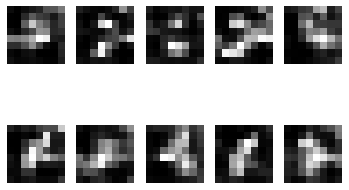

Batch 62/938 - Opimize G - Avg Batch Loss: 0.0307 - Time : 3.61s
Batch 63/938 - Opimize G - Avg Batch Loss: 0.0270 - Time : 3.56s
Batch 64/938 - Opimize G - Avg Batch Loss: 0.0152 - Time : 3.45s
Batch 65/938 - Opimize G - Avg Batch Loss: -0.0046 - Time : 3.60s
Batch 66/938 - Opimize G - Avg Batch Loss: 0.0194 - Time : 3.52s
Batch 67/938 - Opimize D - Avg Batch Loss: 0.0229 - Time : 3.54s
Batch 68/938 - Opimize G - Avg Batch Loss: 0.0249 - Time : 3.54s
Batch 69/938 - Opimize G - Avg Batch Loss: 0.0240 - Time : 3.48s
Batch 70/938 - Opimize G - Avg Batch Loss: -0.0231 - Time : 3.48s
Batch 71/938 - Opimize G - Avg Batch Loss: 0.0327 - Time : 3.45s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.0399 - Time : 3.65s
Batch 73/938 - Opimize D - Avg Batch Loss: 0.0201 - Time : 3.58s
Batch 74/938 - Opimize G - Avg Batch Loss: 0.0411 - Time : 3.70s
Batch 75/938 - Opimize G - Avg Batch Loss: 0.0243 - Time : 3.53s
Batch 76/938 - Opimize G - Avg Batch Loss: 0.0310 - Time : 3.89s
Batch 77/938 - Opimize 

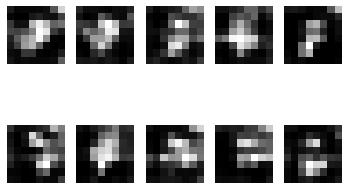

Batch 82/938 - Opimize G - Avg Batch Loss: 0.0124 - Time : 3.65s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.0182 - Time : 3.48s
Batch 84/938 - Opimize G - Avg Batch Loss: -0.0095 - Time : 3.76s
Batch 85/938 - Opimize D - Avg Batch Loss: 0.0196 - Time : 3.37s
Batch 86/938 - Opimize G - Avg Batch Loss: 0.0204 - Time : 3.55s
Batch 87/938 - Opimize G - Avg Batch Loss: 0.0835 - Time : 3.68s
Batch 88/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.43s
Batch 89/938 - Opimize G - Avg Batch Loss: 0.0321 - Time : 3.90s
Batch 90/938 - Opimize G - Avg Batch Loss: 0.0158 - Time : 3.63s
Batch 91/938 - Opimize D - Avg Batch Loss: 0.0030 - Time : 3.85s
Batch 92/938 - Opimize G - Avg Batch Loss: 0.0410 - Time : 3.73s
Batch 93/938 - Opimize G - Avg Batch Loss: 0.0031 - Time : 3.71s
Batch 94/938 - Opimize G - Avg Batch Loss: 0.0487 - Time : 3.68s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.0476 - Time : 3.36s
Batch 96/938 - Opimize G - Avg Batch Loss: 0.0438 - Time : 3.49s
Batch 97/938 - Opimize D

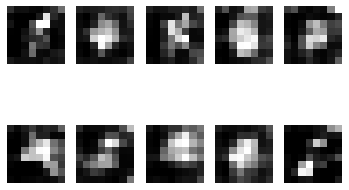

Batch 102/938 - Opimize G - Avg Batch Loss: 0.0421 - Time : 3.72s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.0130 - Time : 3.75s
Batch 104/938 - Opimize G - Avg Batch Loss: 0.0436 - Time : 3.52s
Batch 105/938 - Opimize G - Avg Batch Loss: -0.0086 - Time : 3.76s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.0949 - Time : 3.44s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.0425 - Time : 3.78s
Batch 108/938 - Opimize G - Avg Batch Loss: 0.0206 - Time : 3.44s
Batch 109/938 - Opimize D - Avg Batch Loss: 0.0382 - Time : 3.35s
Batch 110/938 - Opimize G - Avg Batch Loss: 0.0516 - Time : 3.59s
Batch 111/938 - Opimize G - Avg Batch Loss: 0.0370 - Time : 3.42s
Batch 112/938 - Opimize G - Avg Batch Loss: 0.0056 - Time : 3.78s
Batch 113/938 - Opimize G - Avg Batch Loss: 0.0019 - Time : 3.86s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.0410 - Time : 3.55s
Batch 115/938 - Opimize D - Avg Batch Loss: 0.0568 - Time : 3.37s
Batch 116/938 - Opimize G - Avg Batch Loss: 0.0364 - Time : 3.45s
Batch 117

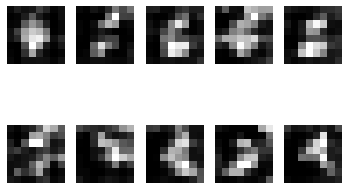

Batch 122/938 - Opimize G - Avg Batch Loss: -0.0150 - Time : 3.42s
Batch 123/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.84s
Batch 124/938 - Opimize G - Avg Batch Loss: -0.0002 - Time : 3.39s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.0562 - Time : 3.46s
Batch 126/938 - Opimize G - Avg Batch Loss: 0.0204 - Time : 3.69s
Batch 127/938 - Opimize D - Avg Batch Loss: 0.0535 - Time : 3.56s
Batch 128/938 - Opimize G - Avg Batch Loss: 0.0142 - Time : 4.01s
Batch 129/938 - Opimize G - Avg Batch Loss: -0.0009 - Time : 3.65s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.0142 - Time : 3.47s
Batch 131/938 - Opimize G - Avg Batch Loss: -0.0123 - Time : 3.65s
Batch 132/938 - Opimize G - Avg Batch Loss: 0.0212 - Time : 3.66s
Batch 133/938 - Opimize D - Avg Batch Loss: 0.0753 - Time : 3.44s
Batch 134/938 - Opimize G - Avg Batch Loss: -0.0358 - Time : 3.45s
Batch 135/938 - Opimize G - Avg Batch Loss: 0.0127 - Time : 3.62s
Batch 136/938 - Opimize G - Avg Batch Loss: 0.0267 - Time : 3.46s
Batch

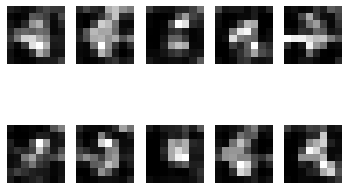

Batch 142/938 - Opimize G - Avg Batch Loss: 0.0027 - Time : 3.60s
Batch 143/938 - Opimize G - Avg Batch Loss: 0.1120 - Time : 3.74s
Batch 144/938 - Opimize G - Avg Batch Loss: 0.0205 - Time : 3.39s
Batch 145/938 - Opimize D - Avg Batch Loss: 0.0904 - Time : 3.68s
Batch 146/938 - Opimize G - Avg Batch Loss: 0.0197 - Time : 3.71s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.0008 - Time : 3.85s
Batch 148/938 - Opimize G - Avg Batch Loss: 0.0261 - Time : 3.85s
Batch 149/938 - Opimize G - Avg Batch Loss: 0.0161 - Time : 3.51s
Batch 150/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.71s
Batch 151/938 - Opimize D - Avg Batch Loss: 0.0221 - Time : 3.88s
Batch 152/938 - Opimize G - Avg Batch Loss: 0.0234 - Time : 3.68s
Batch 153/938 - Opimize G - Avg Batch Loss: 0.0232 - Time : 3.68s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.0658 - Time : 3.43s
Batch 155/938 - Opimize G - Avg Batch Loss: -0.0027 - Time : 3.42s
Batch 156/938 - Opimize G - Avg Batch Loss: 0.0418 - Time : 3.54s
Batch 157

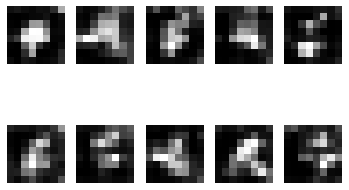

Batch 162/938 - Opimize G - Avg Batch Loss: 0.0250 - Time : 3.53s
Batch 163/938 - Opimize D - Avg Batch Loss: 0.0381 - Time : 3.40s
Batch 164/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.40s
Batch 165/938 - Opimize G - Avg Batch Loss: 0.0078 - Time : 3.39s
Batch 166/938 - Opimize G - Avg Batch Loss: 0.0522 - Time : 4.10s
Batch 167/938 - Opimize G - Avg Batch Loss: 0.0096 - Time : 3.84s
Batch 168/938 - Opimize G - Avg Batch Loss: 0.0374 - Time : 3.36s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.0330 - Time : 3.46s
Batch 170/938 - Opimize G - Avg Batch Loss: 0.0418 - Time : 3.46s
Batch 171/938 - Opimize G - Avg Batch Loss: -0.0007 - Time : 3.43s
Batch 172/938 - Opimize G - Avg Batch Loss: -0.0175 - Time : 3.80s
Batch 173/938 - Opimize G - Avg Batch Loss: -0.0185 - Time : 3.72s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.0051 - Time : 3.46s
Batch 175/938 - Opimize D - Avg Batch Loss: -0.0020 - Time : 3.61s
Batch 176/938 - Opimize G - Avg Batch Loss: 0.0402 - Time : 3.74s
Batch 

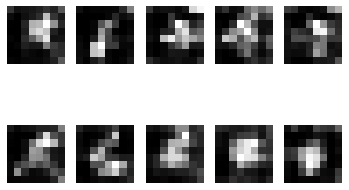

Batch 182/938 - Opimize G - Avg Batch Loss: 0.0089 - Time : 3.87s
Batch 183/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.62s
Batch 184/938 - Opimize G - Avg Batch Loss: 0.0019 - Time : 3.43s
Batch 185/938 - Opimize G - Avg Batch Loss: -0.0240 - Time : 3.60s
Batch 186/938 - Opimize G - Avg Batch Loss: 0.0133 - Time : 3.68s
Batch 187/938 - Opimize D - Avg Batch Loss: 0.0135 - Time : 3.41s
Batch 188/938 - Opimize G - Avg Batch Loss: 0.0714 - Time : 3.46s
Batch 189/938 - Opimize G - Avg Batch Loss: 0.0019 - Time : 3.42s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.0736 - Time : 3.57s
Batch 191/938 - Opimize G - Avg Batch Loss: 0.0746 - Time : 3.46s
Batch 192/938 - Opimize G - Avg Batch Loss: -0.0111 - Time : 3.40s
Batch 193/938 - Opimize D - Avg Batch Loss: -0.0139 - Time : 3.95s
Batch 194/938 - Opimize G - Avg Batch Loss: 0.0497 - Time : 3.61s
Batch 195/938 - Opimize G - Avg Batch Loss: -0.0153 - Time : 3.44s
Batch 196/938 - Opimize G - Avg Batch Loss: 0.0004 - Time : 3.46s
Batch

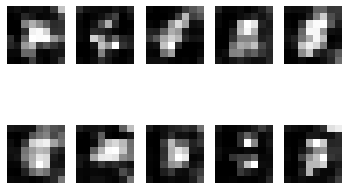

Batch 202/938 - Opimize G - Avg Batch Loss: 0.0226 - Time : 3.63s
Batch 203/938 - Opimize G - Avg Batch Loss: 0.0046 - Time : 3.79s
Batch 204/938 - Opimize G - Avg Batch Loss: 0.0450 - Time : 3.52s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.0358 - Time : 3.71s
Batch 206/938 - Opimize G - Avg Batch Loss: 0.0014 - Time : 3.41s
Batch 207/938 - Opimize G - Avg Batch Loss: 0.0090 - Time : 3.57s
Batch 208/938 - Opimize G - Avg Batch Loss: -0.0080 - Time : 3.69s
Batch 209/938 - Opimize G - Avg Batch Loss: 0.0254 - Time : 3.37s
Batch 210/938 - Opimize G - Avg Batch Loss: 0.0486 - Time : 3.65s
Batch 211/938 - Opimize D - Avg Batch Loss: 0.0136 - Time : 3.52s
Batch 212/938 - Opimize G - Avg Batch Loss: -0.0021 - Time : 3.68s
Batch 213/938 - Opimize G - Avg Batch Loss: -0.0012 - Time : 3.66s
Batch 214/938 - Opimize G - Avg Batch Loss: 0.0016 - Time : 3.44s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.0450 - Time : 3.42s
Batch 216/938 - Opimize G - Avg Batch Loss: 0.0716 - Time : 3.63s
Batch 2

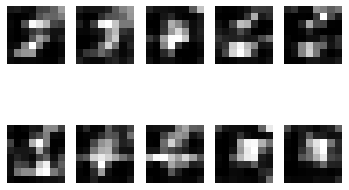

Batch 222/938 - Opimize G - Avg Batch Loss: 0.0075 - Time : 3.85s
Batch 223/938 - Opimize D - Avg Batch Loss: -0.0068 - Time : 3.37s
Batch 224/938 - Opimize G - Avg Batch Loss: 0.0186 - Time : 3.45s
Batch 225/938 - Opimize G - Avg Batch Loss: 0.0014 - Time : 3.67s
Batch 226/938 - Opimize G - Avg Batch Loss: 0.0095 - Time : 3.43s
Batch 227/938 - Opimize G - Avg Batch Loss: 0.0004 - Time : 3.38s
Batch 228/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.71s
Batch 229/938 - Opimize D - Avg Batch Loss: 0.0068 - Time : 3.41s
Batch 230/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.43s
Batch 231/938 - Opimize G - Avg Batch Loss: 0.0971 - Time : 3.54s
Batch 232/938 - Opimize G - Avg Batch Loss: 0.0047 - Time : 3.63s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.0754 - Time : 3.83s
Batch 234/938 - Opimize G - Avg Batch Loss: 0.0024 - Time : 3.92s
Batch 235/938 - Opimize D - Avg Batch Loss: 0.0362 - Time : 3.43s
Batch 236/938 - Opimize G - Avg Batch Loss: 0.0162 - Time : 3.53s
Batch 237

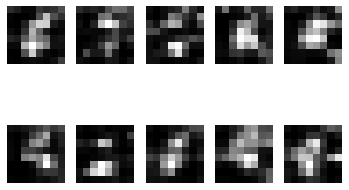

Batch 242/938 - Opimize G - Avg Batch Loss: 0.0006 - Time : 3.51s
Batch 243/938 - Opimize G - Avg Batch Loss: 0.0347 - Time : 3.44s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.0083 - Time : 3.45s
Batch 245/938 - Opimize G - Avg Batch Loss: 0.0328 - Time : 3.39s
Batch 246/938 - Opimize G - Avg Batch Loss: 0.0092 - Time : 3.44s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.0224 - Time : 3.59s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.0132 - Time : 3.58s
Batch 249/938 - Opimize G - Avg Batch Loss: -0.0203 - Time : 3.62s
Batch 250/938 - Opimize G - Avg Batch Loss: -0.0226 - Time : 3.46s
Batch 251/938 - Opimize G - Avg Batch Loss: 0.1045 - Time : 3.39s
Batch 252/938 - Opimize G - Avg Batch Loss: 0.0269 - Time : 3.61s
Batch 253/938 - Opimize D - Avg Batch Loss: 0.0233 - Time : 3.93s
Batch 254/938 - Opimize G - Avg Batch Loss: 0.0157 - Time : 3.76s
Batch 255/938 - Opimize G - Avg Batch Loss: -0.0354 - Time : 3.53s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.0166 - Time : 3.40s
Batch 2

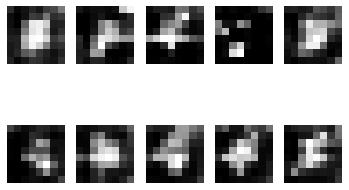

Batch 262/938 - Opimize G - Avg Batch Loss: 0.0254 - Time : 3.54s
Batch 263/938 - Opimize G - Avg Batch Loss: 0.0440 - Time : 3.87s
Batch 264/938 - Opimize G - Avg Batch Loss: -0.0115 - Time : 3.61s
Batch 265/938 - Opimize D - Avg Batch Loss: 0.0153 - Time : 3.74s
Batch 266/938 - Opimize G - Avg Batch Loss: 0.0024 - Time : 3.68s
Batch 267/938 - Opimize G - Avg Batch Loss: 0.0390 - Time : 3.68s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.67s
Batch 269/938 - Opimize G - Avg Batch Loss: 0.0860 - Time : 3.75s
Batch 270/938 - Opimize G - Avg Batch Loss: 0.0001 - Time : 3.40s
Batch 271/938 - Opimize D - Avg Batch Loss: -0.0195 - Time : 3.44s
Batch 272/938 - Opimize G - Avg Batch Loss: 0.0299 - Time : 3.65s
Batch 273/938 - Opimize G - Avg Batch Loss: -0.0108 - Time : 3.75s
Batch 274/938 - Opimize G - Avg Batch Loss: 0.0215 - Time : 3.40s
Batch 275/938 - Opimize G - Avg Batch Loss: 0.0068 - Time : 3.41s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.0296 - Time : 3.91s
Batch 2

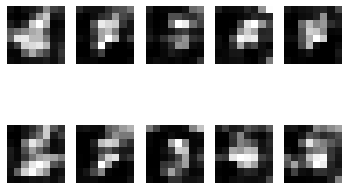

Batch 282/938 - Opimize G - Avg Batch Loss: 0.0074 - Time : 3.89s
Batch 283/938 - Opimize D - Avg Batch Loss: 0.0354 - Time : 3.57s
Batch 284/938 - Opimize G - Avg Batch Loss: 0.0045 - Time : 3.62s
Batch 285/938 - Opimize G - Avg Batch Loss: 0.0308 - Time : 3.70s
Batch 286/938 - Opimize G - Avg Batch Loss: 0.0309 - Time : 3.88s
Batch 287/938 - Opimize G - Avg Batch Loss: -0.0481 - Time : 3.93s
Batch 288/938 - Opimize G - Avg Batch Loss: 0.0123 - Time : 3.51s
Batch 289/938 - Opimize D - Avg Batch Loss: 0.0338 - Time : 3.38s
Batch 290/938 - Opimize G - Avg Batch Loss: 0.0563 - Time : 3.74s
Batch 291/938 - Opimize G - Avg Batch Loss: 0.0079 - Time : 3.37s
Batch 292/938 - Opimize G - Avg Batch Loss: -0.0352 - Time : 4.09s
Batch 293/938 - Opimize G - Avg Batch Loss: 0.0357 - Time : 3.81s
Batch 294/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 3.39s
Batch 295/938 - Opimize D - Avg Batch Loss: -0.0143 - Time : 3.41s
Batch 296/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.43s
Batch 

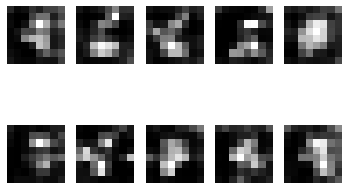

Batch 302/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.53s
Batch 303/938 - Opimize G - Avg Batch Loss: -0.0003 - Time : 3.50s
Batch 304/938 - Opimize G - Avg Batch Loss: 0.0160 - Time : 3.80s
Batch 305/938 - Opimize G - Avg Batch Loss: 0.0108 - Time : 3.50s
Batch 306/938 - Opimize G - Avg Batch Loss: 0.0217 - Time : 3.38s
Batch 307/938 - Opimize D - Avg Batch Loss: 0.0002 - Time : 3.56s
Batch 308/938 - Opimize G - Avg Batch Loss: 0.0653 - Time : 3.67s
Batch 309/938 - Opimize G - Avg Batch Loss: -0.0098 - Time : 3.37s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.0115 - Time : 3.73s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.0222 - Time : 3.82s
Batch 312/938 - Opimize G - Avg Batch Loss: -0.0300 - Time : 3.46s
Batch 313/938 - Opimize D - Avg Batch Loss: -0.0327 - Time : 3.83s
Batch 314/938 - Opimize G - Avg Batch Loss: 0.0435 - Time : 3.73s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.0323 - Time : 3.57s
Batch 316/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.45s
Batch 

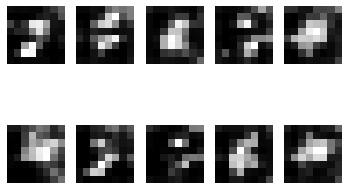

Batch 322/938 - Opimize G - Avg Batch Loss: 0.0046 - Time : 3.52s
Batch 323/938 - Opimize G - Avg Batch Loss: 0.0228 - Time : 3.48s
Batch 324/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.64s
Batch 325/938 - Opimize D - Avg Batch Loss: 0.0014 - Time : 3.51s
Batch 326/938 - Opimize G - Avg Batch Loss: 0.0133 - Time : 3.61s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.0131 - Time : 3.41s
Batch 328/938 - Opimize G - Avg Batch Loss: 0.0107 - Time : 3.41s
Batch 329/938 - Opimize G - Avg Batch Loss: 0.0227 - Time : 3.63s
Batch 330/938 - Opimize G - Avg Batch Loss: 0.0212 - Time : 3.75s
Batch 331/938 - Opimize D - Avg Batch Loss: 0.0183 - Time : 3.58s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 3.71s
Batch 333/938 - Opimize G - Avg Batch Loss: 0.0613 - Time : 3.64s
Batch 334/938 - Opimize G - Avg Batch Loss: -0.0067 - Time : 3.38s
Batch 335/938 - Opimize G - Avg Batch Loss: -0.0151 - Time : 3.56s
Batch 336/938 - Opimize G - Avg Batch Loss: -0.0065 - Time : 3.63s
Batch 3

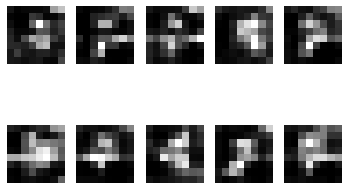

Batch 342/938 - Opimize G - Avg Batch Loss: 0.0158 - Time : 3.51s
Batch 343/938 - Opimize D - Avg Batch Loss: 0.0005 - Time : 3.78s
Batch 344/938 - Opimize G - Avg Batch Loss: 0.0153 - Time : 3.53s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.0489 - Time : 3.70s
Batch 346/938 - Opimize G - Avg Batch Loss: -0.0357 - Time : 3.64s
Batch 347/938 - Opimize G - Avg Batch Loss: 0.0140 - Time : 3.69s
Batch 348/938 - Opimize G - Avg Batch Loss: 0.0058 - Time : 3.59s
Batch 349/938 - Opimize D - Avg Batch Loss: 0.0288 - Time : 3.48s
Batch 350/938 - Opimize G - Avg Batch Loss: -0.0068 - Time : 3.82s
Batch 351/938 - Opimize G - Avg Batch Loss: 0.0119 - Time : 3.79s
Batch 352/938 - Opimize G - Avg Batch Loss: 0.0415 - Time : 3.46s
Batch 353/938 - Opimize G - Avg Batch Loss: 0.0316 - Time : 3.39s
Batch 354/938 - Opimize G - Avg Batch Loss: 0.0234 - Time : 3.69s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.0381 - Time : 3.75s
Batch 356/938 - Opimize G - Avg Batch Loss: 0.0098 - Time : 3.67s
Batch 35

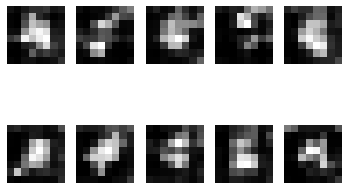

Batch 362/938 - Opimize G - Avg Batch Loss: 0.0249 - Time : 3.53s
Batch 363/938 - Opimize G - Avg Batch Loss: 0.0603 - Time : 3.38s
Batch 364/938 - Opimize G - Avg Batch Loss: 0.0268 - Time : 3.59s
Batch 365/938 - Opimize G - Avg Batch Loss: -0.0228 - Time : 3.61s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.0619 - Time : 3.52s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.0268 - Time : 3.67s
Batch 368/938 - Opimize G - Avg Batch Loss: 0.0144 - Time : 3.37s
Batch 369/938 - Opimize G - Avg Batch Loss: -0.0316 - Time : 3.44s
Batch 370/938 - Opimize G - Avg Batch Loss: 0.0367 - Time : 4.10s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.0041 - Time : 3.50s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.0570 - Time : 3.42s
Batch 373/938 - Opimize D - Avg Batch Loss: 0.0114 - Time : 3.61s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.0166 - Time : 3.59s
Batch 375/938 - Opimize G - Avg Batch Loss: 0.0051 - Time : 3.37s
Batch 376/938 - Opimize G - Avg Batch Loss: 0.0110 - Time : 3.50s
Batch 37

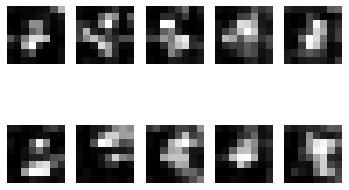

Batch 382/938 - Opimize G - Avg Batch Loss: 0.0423 - Time : 3.61s
Batch 383/938 - Opimize G - Avg Batch Loss: 0.0660 - Time : 3.47s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.0160 - Time : 3.80s
Batch 385/938 - Opimize D - Avg Batch Loss: -0.0005 - Time : 3.61s
Batch 386/938 - Opimize G - Avg Batch Loss: 0.0209 - Time : 3.67s
Batch 387/938 - Opimize G - Avg Batch Loss: 0.0099 - Time : 3.70s
Batch 388/938 - Opimize G - Avg Batch Loss: 0.0303 - Time : 3.45s
Batch 389/938 - Opimize G - Avg Batch Loss: 0.0364 - Time : 3.63s
Batch 390/938 - Opimize G - Avg Batch Loss: 0.0504 - Time : 3.43s
Batch 391/938 - Opimize D - Avg Batch Loss: -0.0148 - Time : 3.41s
Batch 392/938 - Opimize G - Avg Batch Loss: 0.0069 - Time : 3.46s
Batch 393/938 - Opimize G - Avg Batch Loss: -0.0129 - Time : 3.50s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.0458 - Time : 3.44s
Batch 395/938 - Opimize G - Avg Batch Loss: -0.0384 - Time : 3.41s
Batch 396/938 - Opimize G - Avg Batch Loss: 0.0546 - Time : 3.76s
Batch 

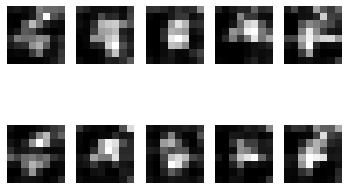

Batch 402/938 - Opimize G - Avg Batch Loss: -0.0282 - Time : 3.41s
Batch 403/938 - Opimize D - Avg Batch Loss: -0.0249 - Time : 3.38s
Batch 404/938 - Opimize G - Avg Batch Loss: -0.0237 - Time : 3.64s
Batch 405/938 - Opimize G - Avg Batch Loss: 0.0190 - Time : 3.40s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.0121 - Time : 3.61s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.0487 - Time : 3.40s
Batch 408/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.76s
Batch 409/938 - Opimize D - Avg Batch Loss: 0.0204 - Time : 3.40s
Batch 410/938 - Opimize G - Avg Batch Loss: 0.0389 - Time : 3.72s
Batch 411/938 - Opimize G - Avg Batch Loss: -0.0089 - Time : 3.68s
Batch 412/938 - Opimize G - Avg Batch Loss: -0.0253 - Time : 3.38s
Batch 413/938 - Opimize G - Avg Batch Loss: 0.0209 - Time : 3.56s
Batch 414/938 - Opimize G - Avg Batch Loss: 0.0574 - Time : 3.41s
Batch 415/938 - Opimize D - Avg Batch Loss: 0.0309 - Time : 3.65s
Batch 416/938 - Opimize G - Avg Batch Loss: 0.0006 - Time : 3.55s
Batch

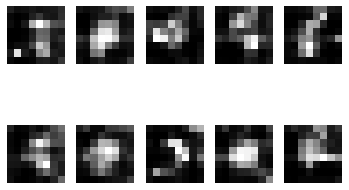

Batch 422/938 - Opimize G - Avg Batch Loss: 0.0367 - Time : 3.63s
Batch 423/938 - Opimize G - Avg Batch Loss: -0.0376 - Time : 3.44s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.0026 - Time : 3.69s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.0369 - Time : 3.47s
Batch 426/938 - Opimize G - Avg Batch Loss: -0.0026 - Time : 3.50s
Batch 427/938 - Opimize D - Avg Batch Loss: -0.0017 - Time : 3.44s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.0043 - Time : 3.88s
Batch 429/938 - Opimize G - Avg Batch Loss: 0.0137 - Time : 3.67s
Batch 430/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 3.44s
Batch 431/938 - Opimize G - Avg Batch Loss: 0.0116 - Time : 3.44s
Batch 432/938 - Opimize G - Avg Batch Loss: 0.0129 - Time : 3.62s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.0388 - Time : 3.60s
Batch 434/938 - Opimize G - Avg Batch Loss: -0.0050 - Time : 3.41s
Batch 435/938 - Opimize G - Avg Batch Loss: -0.0093 - Time : 3.46s
Batch 436/938 - Opimize G - Avg Batch Loss: -0.0508 - Time : 3.37s
Batc

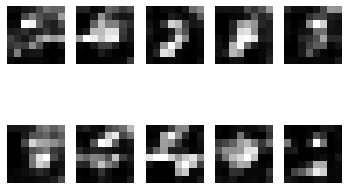

Batch 442/938 - Opimize G - Avg Batch Loss: 0.0227 - Time : 3.87s
Batch 443/938 - Opimize G - Avg Batch Loss: 0.0002 - Time : 3.89s
Batch 444/938 - Opimize G - Avg Batch Loss: 0.0089 - Time : 3.63s
Batch 445/938 - Opimize D - Avg Batch Loss: -0.0245 - Time : 3.43s
Batch 446/938 - Opimize G - Avg Batch Loss: -0.0006 - Time : 3.81s
Batch 447/938 - Opimize G - Avg Batch Loss: -0.0065 - Time : 3.97s
Batch 448/938 - Opimize G - Avg Batch Loss: 0.0063 - Time : 3.41s
Batch 449/938 - Opimize G - Avg Batch Loss: 0.0139 - Time : 3.51s
Batch 450/938 - Opimize G - Avg Batch Loss: -0.0079 - Time : 3.55s
Batch 451/938 - Opimize D - Avg Batch Loss: 0.0510 - Time : 3.47s
Batch 452/938 - Opimize G - Avg Batch Loss: 0.0156 - Time : 3.96s
Batch 453/938 - Opimize G - Avg Batch Loss: 0.0488 - Time : 3.64s
Batch 454/938 - Opimize G - Avg Batch Loss: -0.0022 - Time : 3.51s
Batch 455/938 - Opimize G - Avg Batch Loss: 0.0074 - Time : 3.38s
Batch 456/938 - Opimize G - Avg Batch Loss: 0.0181 - Time : 3.40s
Batch

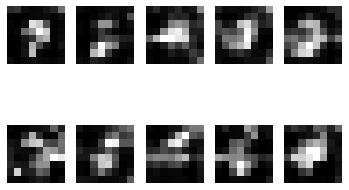

Batch 462/938 - Opimize G - Avg Batch Loss: 0.0214 - Time : 3.52s
Batch 463/938 - Opimize D - Avg Batch Loss: 0.0129 - Time : 3.67s
Batch 464/938 - Opimize G - Avg Batch Loss: -0.0170 - Time : 3.67s
Batch 465/938 - Opimize G - Avg Batch Loss: 0.0307 - Time : 3.38s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.0304 - Time : 3.66s
Batch 467/938 - Opimize G - Avg Batch Loss: 0.0188 - Time : 3.51s
Batch 468/938 - Opimize G - Avg Batch Loss: -0.0142 - Time : 3.84s
Batch 469/938 - Opimize D - Avg Batch Loss: 0.0028 - Time : 3.85s
Batch 470/938 - Opimize G - Avg Batch Loss: -0.0916 - Time : 3.83s
Batch 471/938 - Opimize G - Avg Batch Loss: 0.0409 - Time : 3.71s
Batch 472/938 - Opimize G - Avg Batch Loss: 0.0001 - Time : 3.49s
Batch 473/938 - Opimize G - Avg Batch Loss: -0.0411 - Time : 3.47s
Batch 474/938 - Opimize G - Avg Batch Loss: 0.0246 - Time : 4.02s
Batch 475/938 - Opimize D - Avg Batch Loss: 0.0237 - Time : 3.61s
Batch 476/938 - Opimize G - Avg Batch Loss: 0.0491 - Time : 4.10s
Batch 

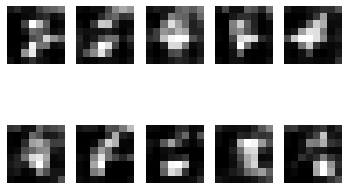

Batch 482/938 - Opimize G - Avg Batch Loss: 0.0142 - Time : 3.63s
Batch 483/938 - Opimize G - Avg Batch Loss: 0.0123 - Time : 3.76s
Batch 484/938 - Opimize G - Avg Batch Loss: -0.0350 - Time : 3.94s
Batch 485/938 - Opimize G - Avg Batch Loss: -0.0391 - Time : 3.54s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.0089 - Time : 3.56s
Batch 487/938 - Opimize D - Avg Batch Loss: 0.0132 - Time : 3.99s
Batch 488/938 - Opimize G - Avg Batch Loss: -0.0047 - Time : 4.13s
Batch 489/938 - Opimize G - Avg Batch Loss: 0.0283 - Time : 3.44s
Batch 490/938 - Opimize G - Avg Batch Loss: -0.0101 - Time : 3.66s
Batch 491/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.42s
Batch 492/938 - Opimize G - Avg Batch Loss: -0.0070 - Time : 3.60s
Batch 493/938 - Opimize D - Avg Batch Loss: -0.0463 - Time : 3.47s
Batch 494/938 - Opimize G - Avg Batch Loss: 0.0373 - Time : 3.93s
Batch 495/938 - Opimize G - Avg Batch Loss: 0.0500 - Time : 3.46s
Batch 496/938 - Opimize G - Avg Batch Loss: -0.0131 - Time : 3.44s
Ba

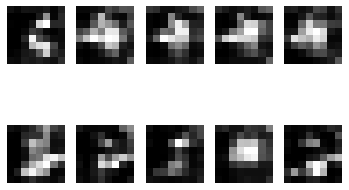

Batch 502/938 - Opimize G - Avg Batch Loss: 0.0563 - Time : 4.16s
Batch 503/938 - Opimize G - Avg Batch Loss: -0.0227 - Time : 3.59s
Batch 504/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 3.60s
Batch 505/938 - Opimize D - Avg Batch Loss: 0.0191 - Time : 3.77s
Batch 506/938 - Opimize G - Avg Batch Loss: 0.0087 - Time : 3.56s
Batch 507/938 - Opimize G - Avg Batch Loss: 0.0166 - Time : 3.68s
Batch 508/938 - Opimize G - Avg Batch Loss: -0.0075 - Time : 3.85s
Batch 509/938 - Opimize G - Avg Batch Loss: 0.0146 - Time : 3.61s
Batch 510/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.47s
Batch 511/938 - Opimize D - Avg Batch Loss: -0.0064 - Time : 3.50s
Batch 512/938 - Opimize G - Avg Batch Loss: 0.0720 - Time : 3.71s
Batch 513/938 - Opimize G - Avg Batch Loss: 0.0548 - Time : 3.55s
Batch 514/938 - Opimize G - Avg Batch Loss: 0.0423 - Time : 3.52s
Batch 515/938 - Opimize G - Avg Batch Loss: -0.0163 - Time : 3.50s
Batch 516/938 - Opimize G - Avg Batch Loss: -0.0122 - Time : 3.58s
Batch

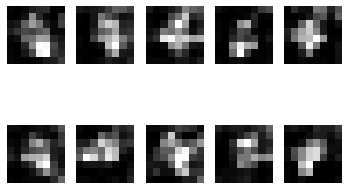

Batch 522/938 - Opimize G - Avg Batch Loss: 0.0141 - Time : 3.88s
Batch 523/938 - Opimize D - Avg Batch Loss: 0.0231 - Time : 3.61s
Batch 524/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.84s
Batch 525/938 - Opimize G - Avg Batch Loss: -0.0099 - Time : 3.81s
Batch 526/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.81s
Batch 527/938 - Opimize G - Avg Batch Loss: -0.0046 - Time : 4.10s
Batch 528/938 - Opimize G - Avg Batch Loss: 0.0090 - Time : 3.81s
Batch 529/938 - Opimize D - Avg Batch Loss: 0.0606 - Time : 3.69s
Batch 530/938 - Opimize G - Avg Batch Loss: 0.0308 - Time : 3.73s
Batch 531/938 - Opimize G - Avg Batch Loss: 0.0098 - Time : 3.61s
Batch 532/938 - Opimize G - Avg Batch Loss: 0.0172 - Time : 3.76s
Batch 533/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.70s
Batch 534/938 - Opimize G - Avg Batch Loss: 0.0763 - Time : 3.74s
Batch 535/938 - Opimize D - Avg Batch Loss: 0.0246 - Time : 3.94s
Batch 536/938 - Opimize G - Avg Batch Loss: 0.0382 - Time : 3.45s
Batch 53

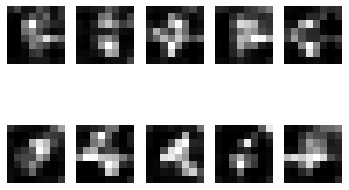

Batch 542/938 - Opimize G - Avg Batch Loss: 0.0337 - Time : 3.71s
Batch 543/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.69s
Batch 544/938 - Opimize G - Avg Batch Loss: -0.0157 - Time : 3.46s
Batch 545/938 - Opimize G - Avg Batch Loss: 0.0572 - Time : 3.79s
Batch 546/938 - Opimize G - Avg Batch Loss: 0.0444 - Time : 3.50s
Batch 547/938 - Opimize D - Avg Batch Loss: 0.0037 - Time : 3.87s
Batch 548/938 - Opimize G - Avg Batch Loss: 0.0056 - Time : 3.57s
Batch 549/938 - Opimize G - Avg Batch Loss: 0.0079 - Time : 3.61s
Batch 550/938 - Opimize G - Avg Batch Loss: 0.0443 - Time : 3.42s
Batch 551/938 - Opimize G - Avg Batch Loss: 0.0140 - Time : 3.54s
Batch 552/938 - Opimize G - Avg Batch Loss: -0.0123 - Time : 3.67s
Batch 553/938 - Opimize D - Avg Batch Loss: 0.0014 - Time : 3.73s
Batch 554/938 - Opimize G - Avg Batch Loss: 0.0139 - Time : 3.42s
Batch 555/938 - Opimize G - Avg Batch Loss: 0.0387 - Time : 3.54s
Batch 556/938 - Opimize G - Avg Batch Loss: -0.0193 - Time : 3.52s
Batch 5

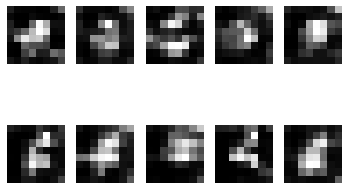

Batch 562/938 - Opimize G - Avg Batch Loss: -0.0428 - Time : 3.55s
Batch 563/938 - Opimize G - Avg Batch Loss: 0.0338 - Time : 3.66s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.71s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.0358 - Time : 3.43s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.0035 - Time : 3.56s
Batch 567/938 - Opimize G - Avg Batch Loss: 0.0177 - Time : 3.73s
Batch 568/938 - Opimize G - Avg Batch Loss: 0.0195 - Time : 3.61s
Batch 569/938 - Opimize G - Avg Batch Loss: 0.0195 - Time : 3.76s
Batch 570/938 - Opimize G - Avg Batch Loss: -0.0144 - Time : 3.72s
Batch 571/938 - Opimize D - Avg Batch Loss: 0.0418 - Time : 3.60s
Batch 572/938 - Opimize G - Avg Batch Loss: -0.0178 - Time : 3.59s
Batch 573/938 - Opimize G - Avg Batch Loss: 0.0246 - Time : 3.95s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.0277 - Time : 3.72s
Batch 575/938 - Opimize G - Avg Batch Loss: 0.0189 - Time : 3.75s
Batch 576/938 - Opimize G - Avg Batch Loss: -0.0107 - Time : 3.52s
Batch 

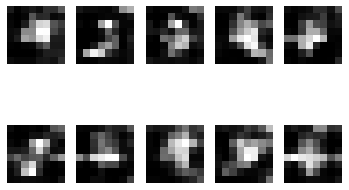

Batch 582/938 - Opimize G - Avg Batch Loss: 0.0152 - Time : 3.56s
Batch 583/938 - Opimize D - Avg Batch Loss: 0.0069 - Time : 3.50s
Batch 584/938 - Opimize G - Avg Batch Loss: -0.0238 - Time : 3.71s
Batch 585/938 - Opimize G - Avg Batch Loss: 0.0141 - Time : 3.48s
Batch 586/938 - Opimize G - Avg Batch Loss: -0.0195 - Time : 3.48s
Batch 587/938 - Opimize G - Avg Batch Loss: 0.0044 - Time : 3.76s
Batch 588/938 - Opimize G - Avg Batch Loss: 0.0173 - Time : 3.83s
Batch 589/938 - Opimize D - Avg Batch Loss: 0.0236 - Time : 3.80s
Batch 590/938 - Opimize G - Avg Batch Loss: 0.0525 - Time : 3.70s
Batch 591/938 - Opimize G - Avg Batch Loss: 0.0021 - Time : 3.63s
Batch 592/938 - Opimize G - Avg Batch Loss: 0.0168 - Time : 4.01s
Batch 593/938 - Opimize G - Avg Batch Loss: -0.0139 - Time : 3.67s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.0699 - Time : 3.51s
Batch 595/938 - Opimize D - Avg Batch Loss: 0.0289 - Time : 3.84s
Batch 596/938 - Opimize G - Avg Batch Loss: 0.0359 - Time : 3.98s
Batch 5

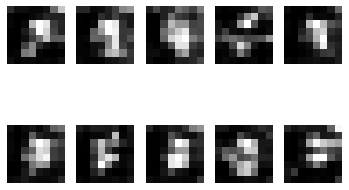

Batch 602/938 - Opimize G - Avg Batch Loss: 0.0052 - Time : 3.52s
Batch 603/938 - Opimize G - Avg Batch Loss: 0.0221 - Time : 3.51s
Batch 604/938 - Opimize G - Avg Batch Loss: 0.0075 - Time : 3.89s
Batch 605/938 - Opimize G - Avg Batch Loss: -0.0070 - Time : 3.45s
Batch 606/938 - Opimize G - Avg Batch Loss: 0.0277 - Time : 3.45s
Batch 607/938 - Opimize D - Avg Batch Loss: -0.0117 - Time : 3.94s
Batch 608/938 - Opimize G - Avg Batch Loss: 0.0382 - Time : 3.72s
Batch 609/938 - Opimize G - Avg Batch Loss: 0.0602 - Time : 3.61s
Batch 610/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.67s
Batch 611/938 - Opimize G - Avg Batch Loss: -0.0018 - Time : 3.56s
Batch 612/938 - Opimize G - Avg Batch Loss: -0.0174 - Time : 3.93s
Batch 613/938 - Opimize D - Avg Batch Loss: -0.0350 - Time : 3.71s
Batch 614/938 - Opimize G - Avg Batch Loss: -0.0001 - Time : 3.43s
Batch 615/938 - Opimize G - Avg Batch Loss: 0.0406 - Time : 3.72s
Batch 616/938 - Opimize G - Avg Batch Loss: 0.0419 - Time : 3.74s
Bat

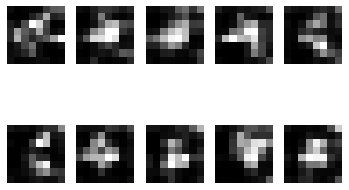

Batch 622/938 - Opimize G - Avg Batch Loss: 0.0882 - Time : 3.80s
Batch 623/938 - Opimize G - Avg Batch Loss: 0.0220 - Time : 3.52s
Batch 624/938 - Opimize G - Avg Batch Loss: -0.0095 - Time : 3.39s
Batch 625/938 - Opimize D - Avg Batch Loss: -0.0110 - Time : 3.85s
Batch 626/938 - Opimize G - Avg Batch Loss: 0.0111 - Time : 3.46s
Batch 627/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.54s
Batch 628/938 - Opimize G - Avg Batch Loss: -0.0323 - Time : 3.54s
Batch 629/938 - Opimize G - Avg Batch Loss: -0.0109 - Time : 3.89s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.0201 - Time : 3.72s
Batch 631/938 - Opimize D - Avg Batch Loss: -0.0078 - Time : 3.69s
Batch 632/938 - Opimize G - Avg Batch Loss: -0.0126 - Time : 3.61s
Batch 633/938 - Opimize G - Avg Batch Loss: -0.0445 - Time : 3.56s
Batch 634/938 - Opimize G - Avg Batch Loss: 0.0640 - Time : 3.57s
Batch 635/938 - Opimize G - Avg Batch Loss: -0.0003 - Time : 3.53s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.0617 - Time : 3.63s
Ba

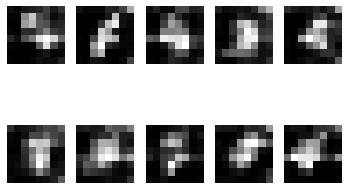

Batch 642/938 - Opimize G - Avg Batch Loss: -0.0152 - Time : 3.38s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.0056 - Time : 3.62s
Batch 644/938 - Opimize G - Avg Batch Loss: -0.0001 - Time : 3.48s
Batch 645/938 - Opimize G - Avg Batch Loss: -0.0099 - Time : 3.42s
Batch 646/938 - Opimize G - Avg Batch Loss: 0.0144 - Time : 3.58s
Batch 647/938 - Opimize G - Avg Batch Loss: 0.0000 - Time : 3.39s
Batch 648/938 - Opimize G - Avg Batch Loss: 0.0224 - Time : 3.43s
Batch 649/938 - Opimize D - Avg Batch Loss: -0.0145 - Time : 3.43s
Batch 650/938 - Opimize G - Avg Batch Loss: 0.0052 - Time : 3.52s
Batch 651/938 - Opimize G - Avg Batch Loss: 0.0074 - Time : 3.44s
Batch 652/938 - Opimize G - Avg Batch Loss: -0.0162 - Time : 3.49s
Batch 653/938 - Opimize G - Avg Batch Loss: 0.0343 - Time : 3.68s
Batch 654/938 - Opimize G - Avg Batch Loss: 0.0124 - Time : 3.60s
Batch 655/938 - Opimize D - Avg Batch Loss: 0.0219 - Time : 3.43s
Batch 656/938 - Opimize G - Avg Batch Loss: 0.0065 - Time : 3.80s
Batch

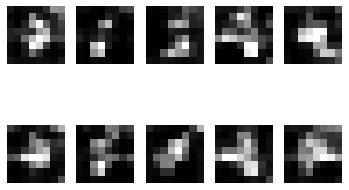

Batch 662/938 - Opimize G - Avg Batch Loss: -0.0118 - Time : 3.75s
Batch 663/938 - Opimize G - Avg Batch Loss: 0.0003 - Time : 3.69s
Batch 664/938 - Opimize G - Avg Batch Loss: 0.0361 - Time : 3.76s
Batch 665/938 - Opimize G - Avg Batch Loss: -0.0135 - Time : 3.48s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.0465 - Time : 3.59s
Batch 667/938 - Opimize D - Avg Batch Loss: -0.0276 - Time : 3.50s
Batch 668/938 - Opimize G - Avg Batch Loss: 0.0281 - Time : 3.45s
Batch 669/938 - Opimize G - Avg Batch Loss: 0.0435 - Time : 3.54s
Batch 670/938 - Opimize G - Avg Batch Loss: 0.0245 - Time : 3.41s
Batch 671/938 - Opimize G - Avg Batch Loss: -0.0014 - Time : 3.70s
Batch 672/938 - Opimize G - Avg Batch Loss: -0.0033 - Time : 3.37s
Batch 673/938 - Opimize D - Avg Batch Loss: -0.0041 - Time : 3.46s
Batch 674/938 - Opimize G - Avg Batch Loss: 0.0818 - Time : 3.56s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.60s
Batch 676/938 - Opimize G - Avg Batch Loss: 0.0925 - Time : 3.53s
Batc

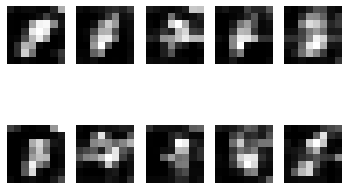

Batch 682/938 - Opimize G - Avg Batch Loss: -0.0165 - Time : 3.45s
Batch 683/938 - Opimize G - Avg Batch Loss: -0.0073 - Time : 3.72s
Batch 684/938 - Opimize G - Avg Batch Loss: 0.0092 - Time : 3.88s
Batch 685/938 - Opimize D - Avg Batch Loss: 0.0032 - Time : 3.60s
Batch 686/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 3.64s
Batch 687/938 - Opimize G - Avg Batch Loss: -0.0486 - Time : 3.59s
Batch 688/938 - Opimize G - Avg Batch Loss: -0.0303 - Time : 3.49s
Batch 689/938 - Opimize G - Avg Batch Loss: 0.0340 - Time : 3.78s
Batch 690/938 - Opimize G - Avg Batch Loss: 0.0496 - Time : 3.58s
Batch 691/938 - Opimize D - Avg Batch Loss: 0.0025 - Time : 3.72s
Batch 692/938 - Opimize G - Avg Batch Loss: 0.0139 - Time : 3.57s
Batch 693/938 - Opimize G - Avg Batch Loss: 0.0483 - Time : 3.46s
Batch 694/938 - Opimize G - Avg Batch Loss: -0.0290 - Time : 3.65s
Batch 695/938 - Opimize G - Avg Batch Loss: -0.0108 - Time : 3.50s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.0049 - Time : 3.57s
Batc

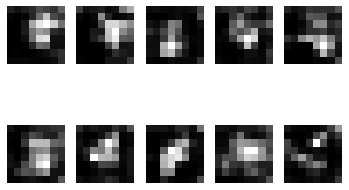

Batch 702/938 - Opimize G - Avg Batch Loss: 0.0278 - Time : 3.95s
Batch 703/938 - Opimize D - Avg Batch Loss: 0.0783 - Time : 3.85s
Batch 704/938 - Opimize G - Avg Batch Loss: -0.0237 - Time : 3.61s
Batch 705/938 - Opimize G - Avg Batch Loss: -0.0117 - Time : 3.45s
Batch 706/938 - Opimize G - Avg Batch Loss: -0.0089 - Time : 3.46s
Batch 707/938 - Opimize G - Avg Batch Loss: -0.0333 - Time : 3.77s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.0161 - Time : 3.96s
Batch 709/938 - Opimize D - Avg Batch Loss: 0.0597 - Time : 3.56s
Batch 710/938 - Opimize G - Avg Batch Loss: 0.0169 - Time : 3.47s
Batch 711/938 - Opimize G - Avg Batch Loss: -0.0124 - Time : 3.67s
Batch 712/938 - Opimize G - Avg Batch Loss: -0.0251 - Time : 4.12s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.0353 - Time : 3.48s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.0124 - Time : 3.71s
Batch 715/938 - Opimize D - Avg Batch Loss: 0.0069 - Time : 3.48s
Batch 716/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.57s
Batc

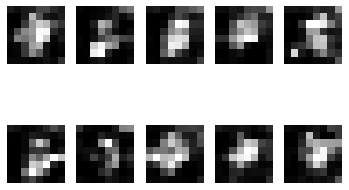

Batch 722/938 - Opimize G - Avg Batch Loss: -0.0256 - Time : 3.96s
Batch 723/938 - Opimize G - Avg Batch Loss: -0.0091 - Time : 3.55s
Batch 724/938 - Opimize G - Avg Batch Loss: 0.0338 - Time : 3.71s
Batch 725/938 - Opimize G - Avg Batch Loss: -0.0111 - Time : 3.46s
Batch 726/938 - Opimize G - Avg Batch Loss: 0.0053 - Time : 3.47s
Batch 727/938 - Opimize D - Avg Batch Loss: 0.0231 - Time : 3.65s
Batch 728/938 - Opimize G - Avg Batch Loss: -0.0219 - Time : 3.41s
Batch 729/938 - Opimize G - Avg Batch Loss: 0.0267 - Time : 3.47s
Batch 730/938 - Opimize G - Avg Batch Loss: -0.0017 - Time : 3.44s
Batch 731/938 - Opimize G - Avg Batch Loss: 0.0133 - Time : 3.66s
Batch 732/938 - Opimize G - Avg Batch Loss: -0.0011 - Time : 3.66s
Batch 733/938 - Opimize D - Avg Batch Loss: 0.0226 - Time : 3.48s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.0188 - Time : 3.50s
Batch 735/938 - Opimize G - Avg Batch Loss: 0.0426 - Time : 3.82s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.0033 - Time : 3.49s
Batc

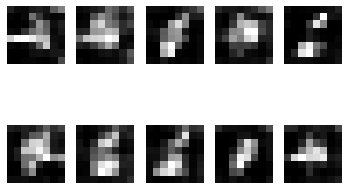

Batch 742/938 - Opimize G - Avg Batch Loss: -0.0001 - Time : 3.84s
Batch 743/938 - Opimize G - Avg Batch Loss: 0.0326 - Time : 3.46s
Batch 744/938 - Opimize G - Avg Batch Loss: -0.0038 - Time : 3.68s
Batch 745/938 - Opimize D - Avg Batch Loss: 0.0200 - Time : 3.65s
Batch 746/938 - Opimize G - Avg Batch Loss: -0.0053 - Time : 3.76s
Batch 747/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.42s
Batch 748/938 - Opimize G - Avg Batch Loss: 0.0122 - Time : 3.46s
Batch 749/938 - Opimize G - Avg Batch Loss: -0.0200 - Time : 3.49s
Batch 750/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.47s
Batch 751/938 - Opimize D - Avg Batch Loss: -0.0092 - Time : 3.46s
Batch 752/938 - Opimize G - Avg Batch Loss: -0.0228 - Time : 3.55s
Batch 753/938 - Opimize G - Avg Batch Loss: -0.0031 - Time : 3.51s
Batch 754/938 - Opimize G - Avg Batch Loss: 0.0270 - Time : 3.48s
Batch 755/938 - Opimize G - Avg Batch Loss: 0.0047 - Time : 3.81s
Batch 756/938 - Opimize G - Avg Batch Loss: -0.0104 - Time : 3.41s
B

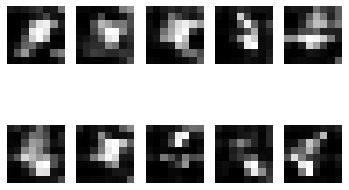

Batch 762/938 - Opimize G - Avg Batch Loss: 0.0144 - Time : 3.72s
Batch 763/938 - Opimize D - Avg Batch Loss: 0.0143 - Time : 3.51s
Batch 764/938 - Opimize G - Avg Batch Loss: 0.0230 - Time : 3.44s
Batch 765/938 - Opimize G - Avg Batch Loss: -0.0511 - Time : 3.38s
Batch 766/938 - Opimize G - Avg Batch Loss: -0.0074 - Time : 3.81s
Batch 767/938 - Opimize G - Avg Batch Loss: 0.0218 - Time : 3.58s
Batch 768/938 - Opimize G - Avg Batch Loss: 0.0002 - Time : 3.81s
Batch 769/938 - Opimize D - Avg Batch Loss: -0.0044 - Time : 3.65s
Batch 770/938 - Opimize G - Avg Batch Loss: 0.0003 - Time : 3.75s
Batch 771/938 - Opimize G - Avg Batch Loss: -0.0217 - Time : 3.59s
Batch 772/938 - Opimize G - Avg Batch Loss: 0.0039 - Time : 3.70s
Batch 773/938 - Opimize G - Avg Batch Loss: 0.0281 - Time : 3.57s
Batch 774/938 - Opimize G - Avg Batch Loss: 0.0184 - Time : 3.76s
Batch 775/938 - Opimize D - Avg Batch Loss: -0.0019 - Time : 3.52s
Batch 776/938 - Opimize G - Avg Batch Loss: 0.0108 - Time : 3.43s
Batch

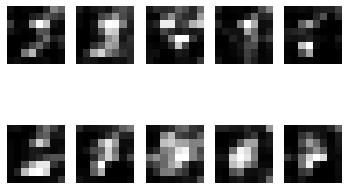

Batch 782/938 - Opimize G - Avg Batch Loss: 0.0163 - Time : 3.45s
Batch 783/938 - Opimize G - Avg Batch Loss: 0.0050 - Time : 3.67s
Batch 784/938 - Opimize G - Avg Batch Loss: 0.0130 - Time : 3.42s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.0451 - Time : 3.85s
Batch 786/938 - Opimize G - Avg Batch Loss: -0.0037 - Time : 3.39s
Batch 787/938 - Opimize D - Avg Batch Loss: 0.0012 - Time : 3.63s
Batch 788/938 - Opimize G - Avg Batch Loss: -0.0109 - Time : 3.65s
Batch 789/938 - Opimize G - Avg Batch Loss: 0.0286 - Time : 3.68s
Batch 790/938 - Opimize G - Avg Batch Loss: 0.0227 - Time : 3.71s
Batch 791/938 - Opimize G - Avg Batch Loss: 0.0490 - Time : 3.58s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.0087 - Time : 3.83s
Batch 793/938 - Opimize D - Avg Batch Loss: -0.0046 - Time : 3.70s
Batch 794/938 - Opimize G - Avg Batch Loss: -0.0012 - Time : 3.52s
Batch 795/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.67s
Batch 796/938 - Opimize G - Avg Batch Loss: -0.0275 - Time : 3.69s
Batch

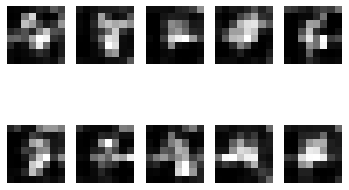

Batch 802/938 - Opimize G - Avg Batch Loss: 0.0043 - Time : 3.48s
Batch 803/938 - Opimize G - Avg Batch Loss: 0.0005 - Time : 3.48s
Batch 804/938 - Opimize G - Avg Batch Loss: -0.0089 - Time : 3.45s
Batch 805/938 - Opimize D - Avg Batch Loss: 0.0136 - Time : 3.57s
Batch 806/938 - Opimize G - Avg Batch Loss: 0.0244 - Time : 3.44s
Batch 807/938 - Opimize G - Avg Batch Loss: 0.0288 - Time : 3.55s
Batch 808/938 - Opimize G - Avg Batch Loss: 0.0313 - Time : 3.39s
Batch 809/938 - Opimize G - Avg Batch Loss: 0.0085 - Time : 3.39s
Batch 810/938 - Opimize G - Avg Batch Loss: 0.0597 - Time : 3.45s
Batch 811/938 - Opimize D - Avg Batch Loss: 0.0013 - Time : 3.40s
Batch 812/938 - Opimize G - Avg Batch Loss: -0.0052 - Time : 3.68s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.0001 - Time : 3.70s
Batch 814/938 - Opimize G - Avg Batch Loss: -0.0156 - Time : 3.60s
Batch 815/938 - Opimize G - Avg Batch Loss: -0.0027 - Time : 3.42s
Batch 816/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.45s
Batch 

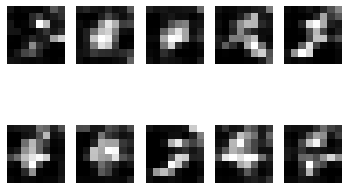

Batch 822/938 - Opimize G - Avg Batch Loss: 0.0379 - Time : 3.55s
Batch 823/938 - Opimize D - Avg Batch Loss: 0.0162 - Time : 3.40s
Batch 824/938 - Opimize G - Avg Batch Loss: 0.0463 - Time : 3.50s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.0300 - Time : 3.82s
Batch 826/938 - Opimize G - Avg Batch Loss: 0.0440 - Time : 3.48s
Batch 827/938 - Opimize G - Avg Batch Loss: 0.0240 - Time : 3.53s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.0263 - Time : 3.44s
Batch 829/938 - Opimize D - Avg Batch Loss: -0.0100 - Time : 3.37s
Batch 830/938 - Opimize G - Avg Batch Loss: -0.0071 - Time : 3.63s
Batch 831/938 - Opimize G - Avg Batch Loss: 0.0413 - Time : 3.53s
Batch 832/938 - Opimize G - Avg Batch Loss: 0.0080 - Time : 3.40s
Batch 833/938 - Opimize G - Avg Batch Loss: -0.0103 - Time : 3.46s
Batch 834/938 - Opimize G - Avg Batch Loss: -0.0138 - Time : 3.55s
Batch 835/938 - Opimize D - Avg Batch Loss: 0.0455 - Time : 3.43s
Batch 836/938 - Opimize G - Avg Batch Loss: 0.0384 - Time : 3.44s
Batch 

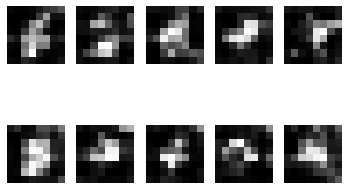

Batch 842/938 - Opimize G - Avg Batch Loss: 0.0555 - Time : 3.41s
Batch 843/938 - Opimize G - Avg Batch Loss: 0.0044 - Time : 3.82s
Batch 844/938 - Opimize G - Avg Batch Loss: 0.0171 - Time : 3.62s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.0237 - Time : 3.37s
Batch 846/938 - Opimize G - Avg Batch Loss: 0.0078 - Time : 3.40s
Batch 847/938 - Opimize D - Avg Batch Loss: -0.0198 - Time : 3.84s
Batch 848/938 - Opimize G - Avg Batch Loss: 0.0118 - Time : 3.65s
Batch 849/938 - Opimize G - Avg Batch Loss: -0.0261 - Time : 3.39s
Batch 850/938 - Opimize G - Avg Batch Loss: 0.0134 - Time : 3.61s
Batch 851/938 - Opimize G - Avg Batch Loss: 0.0093 - Time : 3.73s
Batch 852/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 3.58s
Batch 853/938 - Opimize D - Avg Batch Loss: 0.0061 - Time : 3.43s
Batch 854/938 - Opimize G - Avg Batch Loss: 0.0443 - Time : 3.73s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.0156 - Time : 3.51s
Batch 856/938 - Opimize G - Avg Batch Loss: 0.0184 - Time : 3.37s
Batch 85

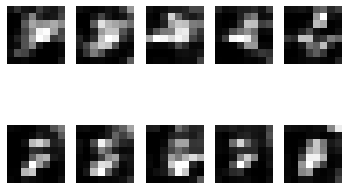

Batch 862/938 - Opimize G - Avg Batch Loss: 0.0490 - Time : 3.89s
Batch 863/938 - Opimize G - Avg Batch Loss: 0.0066 - Time : 3.43s
Batch 864/938 - Opimize G - Avg Batch Loss: 0.0323 - Time : 3.55s
Batch 865/938 - Opimize D - Avg Batch Loss: -0.0281 - Time : 3.60s
Batch 866/938 - Opimize G - Avg Batch Loss: 0.0206 - Time : 3.64s
Batch 867/938 - Opimize G - Avg Batch Loss: 0.0646 - Time : 4.00s
Batch 868/938 - Opimize G - Avg Batch Loss: 0.0032 - Time : 3.40s
Batch 869/938 - Opimize G - Avg Batch Loss: 0.0206 - Time : 3.71s
Batch 870/938 - Opimize G - Avg Batch Loss: 0.0176 - Time : 3.76s
Batch 871/938 - Opimize D - Avg Batch Loss: -0.0008 - Time : 3.71s
Batch 872/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.67s
Batch 873/938 - Opimize G - Avg Batch Loss: 0.0269 - Time : 3.38s
Batch 874/938 - Opimize G - Avg Batch Loss: -0.0315 - Time : 3.47s
Batch 875/938 - Opimize G - Avg Batch Loss: 0.0145 - Time : 3.49s
Batch 876/938 - Opimize G - Avg Batch Loss: 0.0118 - Time : 3.44s
Batch 8

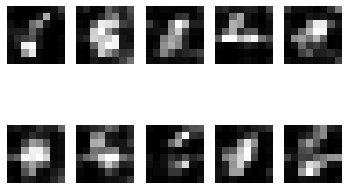

Batch 882/938 - Opimize G - Avg Batch Loss: 0.0350 - Time : 3.38s
Batch 883/938 - Opimize D - Avg Batch Loss: 0.0018 - Time : 3.49s
Batch 884/938 - Opimize G - Avg Batch Loss: -0.0109 - Time : 3.62s
Batch 885/938 - Opimize G - Avg Batch Loss: -0.0054 - Time : 3.73s
Batch 886/938 - Opimize G - Avg Batch Loss: -0.0104 - Time : 3.84s
Batch 887/938 - Opimize G - Avg Batch Loss: 0.0042 - Time : 3.39s
Batch 888/938 - Opimize G - Avg Batch Loss: 0.0016 - Time : 3.46s
Batch 889/938 - Opimize D - Avg Batch Loss: 0.0170 - Time : 3.39s
Batch 890/938 - Opimize G - Avg Batch Loss: 0.0107 - Time : 3.42s
Batch 891/938 - Opimize G - Avg Batch Loss: -0.0141 - Time : 3.44s
Batch 892/938 - Opimize G - Avg Batch Loss: -0.0123 - Time : 3.60s
Batch 893/938 - Opimize G - Avg Batch Loss: 0.0121 - Time : 4.04s
Batch 894/938 - Opimize G - Avg Batch Loss: -0.0104 - Time : 3.43s
Batch 895/938 - Opimize D - Avg Batch Loss: 0.0370 - Time : 3.60s
Batch 896/938 - Opimize G - Avg Batch Loss: -0.0388 - Time : 3.55s
Bat

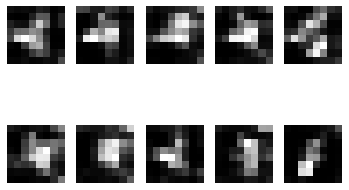

Batch 902/938 - Opimize G - Avg Batch Loss: 0.0438 - Time : 3.51s
Batch 903/938 - Opimize G - Avg Batch Loss: 0.0021 - Time : 3.69s
Batch 904/938 - Opimize G - Avg Batch Loss: -0.0483 - Time : 3.41s
Batch 905/938 - Opimize G - Avg Batch Loss: 0.0250 - Time : 3.50s
Batch 906/938 - Opimize G - Avg Batch Loss: 0.0176 - Time : 3.38s
Batch 907/938 - Opimize D - Avg Batch Loss: 0.0171 - Time : 3.54s
Batch 908/938 - Opimize G - Avg Batch Loss: -0.0011 - Time : 3.80s
Batch 909/938 - Opimize G - Avg Batch Loss: 0.0174 - Time : 3.38s
Batch 910/938 - Opimize G - Avg Batch Loss: 0.0198 - Time : 3.40s
Batch 911/938 - Opimize G - Avg Batch Loss: 0.0381 - Time : 3.53s
Batch 912/938 - Opimize G - Avg Batch Loss: 0.0391 - Time : 3.68s
Batch 913/938 - Opimize D - Avg Batch Loss: -0.0194 - Time : 4.07s
Batch 914/938 - Opimize G - Avg Batch Loss: 0.0141 - Time : 3.53s
Batch 915/938 - Opimize G - Avg Batch Loss: 0.0410 - Time : 3.62s
Batch 916/938 - Opimize G - Avg Batch Loss: -0.0198 - Time : 3.40s
Batch 

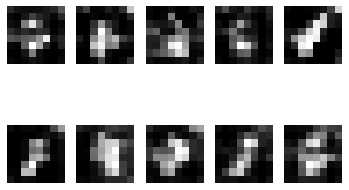

Batch 922/938 - Opimize G - Avg Batch Loss: 0.0305 - Time : 3.43s
Batch 923/938 - Opimize G - Avg Batch Loss: 0.0337 - Time : 3.42s
Batch 924/938 - Opimize G - Avg Batch Loss: 0.0133 - Time : 3.50s
Batch 925/938 - Opimize D - Avg Batch Loss: 0.0268 - Time : 3.43s
Batch 926/938 - Opimize G - Avg Batch Loss: 0.0226 - Time : 3.53s
Batch 927/938 - Opimize G - Avg Batch Loss: -0.0125 - Time : 3.54s
Batch 928/938 - Opimize G - Avg Batch Loss: 0.0086 - Time : 3.56s
Batch 929/938 - Opimize G - Avg Batch Loss: 0.0143 - Time : 3.54s
Batch 930/938 - Opimize G - Avg Batch Loss: 0.0069 - Time : 3.55s
Batch 931/938 - Opimize D - Avg Batch Loss: 0.0371 - Time : 3.40s
Batch 932/938 - Opimize G - Avg Batch Loss: 0.0008 - Time : 3.74s
Batch 933/938 - Opimize G - Avg Batch Loss: 0.0089 - Time : 3.60s
Batch 934/938 - Opimize G - Avg Batch Loss: 0.0465 - Time : 3.53s
Batch 935/938 - Opimize G - Avg Batch Loss: 0.0018 - Time : 3.59s
Batch 936/938 - Opimize G - Avg Batch Loss: -0.0215 - Time : 3.41s
Batch 93

In [24]:
history1 = train(n_gen=5, n_epochs = 1, batch_size = 64, plt_samples = 20)

In [0]:
history.extend(history1)

Text(0.5, 1.0, 'Loss history over 3 epochs')

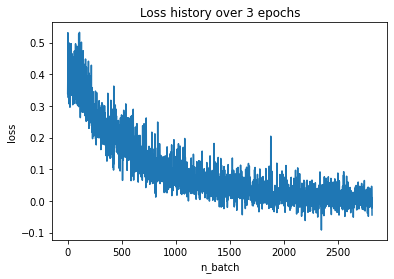

In [26]:
plt.plot(history)
plt.ylabel("loss")
plt.xlabel("n_batch")
plt.title("Loss history over 3 epochs")

In [0]:
np.savetxt("history_cnn_2.txt", history)

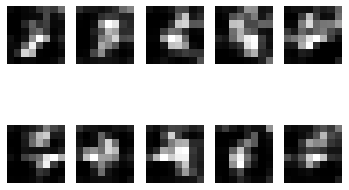

In [31]:
generate_plt()

In [0]:
torch.save(generator.state_dict(), "generatorCNN_3epochs.statedict")
torch.save(discriminator.state_dict(), "discriminatorCNN_3epochs.statedict")

========================Epoch: 1 / 1 =======================
Batch 1/938 - Opimize D - Avg Batch Loss: 0.0016 - Time : 3.80s


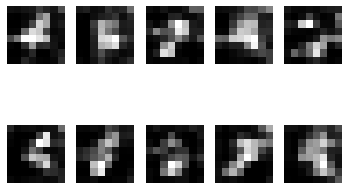

Batch 2/938 - Opimize G - Avg Batch Loss: 0.0065 - Time : 3.51s
Batch 3/938 - Opimize G - Avg Batch Loss: -0.0083 - Time : 3.71s
Batch 4/938 - Opimize G - Avg Batch Loss: -0.0146 - Time : 3.40s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.0182 - Time : 3.97s
Batch 6/938 - Opimize G - Avg Batch Loss: -0.0352 - Time : 3.80s
Batch 7/938 - Opimize D - Avg Batch Loss: 0.0189 - Time : 3.46s
Batch 8/938 - Opimize G - Avg Batch Loss: -0.0075 - Time : 3.62s
Batch 9/938 - Opimize G - Avg Batch Loss: -0.0064 - Time : 3.70s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.0156 - Time : 3.68s
Batch 11/938 - Opimize G - Avg Batch Loss: -0.0137 - Time : 3.47s
Batch 12/938 - Opimize G - Avg Batch Loss: -0.0119 - Time : 3.43s
Batch 13/938 - Opimize D - Avg Batch Loss: 0.0123 - Time : 3.52s
Batch 14/938 - Opimize G - Avg Batch Loss: -0.0200 - Time : 3.59s
Batch 15/938 - Opimize G - Avg Batch Loss: -0.0036 - Time : 3.42s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.0317 - Time : 3.71s
Batch 17/938 - Opimize G

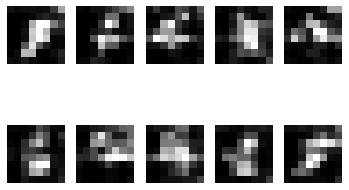

Batch 22/938 - Opimize G - Avg Batch Loss: 0.0191 - Time : 3.48s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.0146 - Time : 3.43s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.0198 - Time : 3.39s
Batch 25/938 - Opimize D - Avg Batch Loss: 0.0531 - Time : 3.73s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.0175 - Time : 3.42s
Batch 27/938 - Opimize G - Avg Batch Loss: -0.0179 - Time : 3.91s
Batch 28/938 - Opimize G - Avg Batch Loss: 0.0147 - Time : 3.54s
Batch 29/938 - Opimize G - Avg Batch Loss: -0.0254 - Time : 4.09s
Batch 30/938 - Opimize G - Avg Batch Loss: 0.0709 - Time : 3.59s
Batch 31/938 - Opimize D - Avg Batch Loss: -0.0136 - Time : 3.67s
Batch 32/938 - Opimize G - Avg Batch Loss: -0.0391 - Time : 3.81s
Batch 33/938 - Opimize G - Avg Batch Loss: -0.0095 - Time : 3.71s
Batch 34/938 - Opimize G - Avg Batch Loss: 0.0571 - Time : 3.48s
Batch 35/938 - Opimize G - Avg Batch Loss: -0.0153 - Time : 3.58s
Batch 36/938 - Opimize G - Avg Batch Loss: 0.0252 - Time : 3.46s
Batch 37/938 - Opim

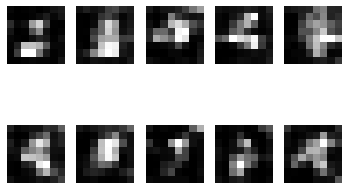

Batch 42/938 - Opimize G - Avg Batch Loss: 0.0189 - Time : 3.57s
Batch 43/938 - Opimize D - Avg Batch Loss: 0.0190 - Time : 4.01s
Batch 44/938 - Opimize G - Avg Batch Loss: -0.0067 - Time : 3.69s
Batch 45/938 - Opimize G - Avg Batch Loss: 0.0677 - Time : 3.86s
Batch 46/938 - Opimize G - Avg Batch Loss: -0.0367 - Time : 3.69s
Batch 47/938 - Opimize G - Avg Batch Loss: -0.0202 - Time : 3.74s
Batch 48/938 - Opimize G - Avg Batch Loss: 0.0741 - Time : 3.40s
Batch 49/938 - Opimize D - Avg Batch Loss: -0.0088 - Time : 3.48s
Batch 50/938 - Opimize G - Avg Batch Loss: -0.0033 - Time : 3.97s
Batch 51/938 - Opimize G - Avg Batch Loss: -0.0017 - Time : 3.50s
Batch 52/938 - Opimize G - Avg Batch Loss: 0.0706 - Time : 3.55s
Batch 53/938 - Opimize G - Avg Batch Loss: 0.0158 - Time : 3.54s
Batch 54/938 - Opimize G - Avg Batch Loss: 0.0042 - Time : 3.55s
Batch 55/938 - Opimize D - Avg Batch Loss: -0.0006 - Time : 3.47s
Batch 56/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.49s
Batch 57/938 - Op

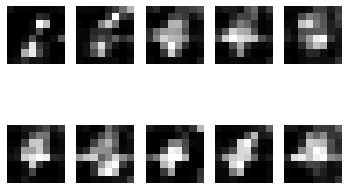

Batch 62/938 - Opimize G - Avg Batch Loss: -0.0344 - Time : 3.64s
Batch 63/938 - Opimize G - Avg Batch Loss: -0.0011 - Time : 3.78s
Batch 64/938 - Opimize G - Avg Batch Loss: 0.0176 - Time : 3.88s
Batch 65/938 - Opimize G - Avg Batch Loss: -0.0000 - Time : 3.77s
Batch 66/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.47s
Batch 67/938 - Opimize D - Avg Batch Loss: 0.0531 - Time : 3.44s
Batch 68/938 - Opimize G - Avg Batch Loss: -0.0318 - Time : 3.42s
Batch 69/938 - Opimize G - Avg Batch Loss: -0.0019 - Time : 3.59s
Batch 70/938 - Opimize G - Avg Batch Loss: -0.0228 - Time : 3.46s
Batch 71/938 - Opimize G - Avg Batch Loss: -0.0237 - Time : 3.43s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.0623 - Time : 3.50s
Batch 73/938 - Opimize D - Avg Batch Loss: -0.0109 - Time : 3.62s
Batch 74/938 - Opimize G - Avg Batch Loss: 0.0470 - Time : 3.51s
Batch 75/938 - Opimize G - Avg Batch Loss: 0.0452 - Time : 3.77s
Batch 76/938 - Opimize G - Avg Batch Loss: 0.0331 - Time : 3.71s
Batch 77/938 - Op

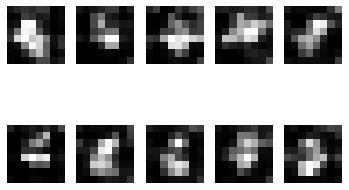

Batch 82/938 - Opimize G - Avg Batch Loss: 0.0191 - Time : 4.01s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.0522 - Time : 3.62s
Batch 84/938 - Opimize G - Avg Batch Loss: 0.0075 - Time : 3.53s
Batch 85/938 - Opimize D - Avg Batch Loss: 0.0147 - Time : 3.77s
Batch 86/938 - Opimize G - Avg Batch Loss: -0.0095 - Time : 3.46s
Batch 87/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.82s
Batch 88/938 - Opimize G - Avg Batch Loss: -0.0201 - Time : 3.61s
Batch 89/938 - Opimize G - Avg Batch Loss: 0.0514 - Time : 3.49s
Batch 90/938 - Opimize G - Avg Batch Loss: -0.0062 - Time : 3.62s
Batch 91/938 - Opimize D - Avg Batch Loss: 0.0040 - Time : 3.49s
Batch 92/938 - Opimize G - Avg Batch Loss: 0.0086 - Time : 3.68s
Batch 93/938 - Opimize G - Avg Batch Loss: -0.0088 - Time : 3.77s
Batch 94/938 - Opimize G - Avg Batch Loss: -0.0046 - Time : 3.80s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.0221 - Time : 3.62s
Batch 96/938 - Opimize G - Avg Batch Loss: -0.0004 - Time : 3.86s
Batch 97/938 - Opim

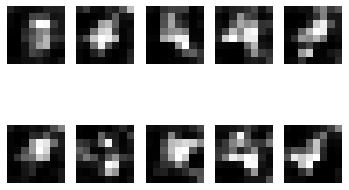

Batch 102/938 - Opimize G - Avg Batch Loss: -0.0145 - Time : 3.63s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.0518 - Time : 3.84s
Batch 104/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.55s
Batch 105/938 - Opimize G - Avg Batch Loss: 0.0302 - Time : 3.51s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.0010 - Time : 3.74s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.0147 - Time : 3.81s
Batch 108/938 - Opimize G - Avg Batch Loss: -0.0106 - Time : 3.79s
Batch 109/938 - Opimize D - Avg Batch Loss: 0.0067 - Time : 3.54s
Batch 110/938 - Opimize G - Avg Batch Loss: 0.0185 - Time : 3.54s
Batch 111/938 - Opimize G - Avg Batch Loss: 0.0192 - Time : 3.57s
Batch 112/938 - Opimize G - Avg Batch Loss: -0.0080 - Time : 3.63s
Batch 113/938 - Opimize G - Avg Batch Loss: 0.0051 - Time : 3.51s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.0084 - Time : 3.55s
Batch 115/938 - Opimize D - Avg Batch Loss: 0.0182 - Time : 3.75s
Batch 116/938 - Opimize G - Avg Batch Loss: -0.0161 - Time : 3.78s
Batch

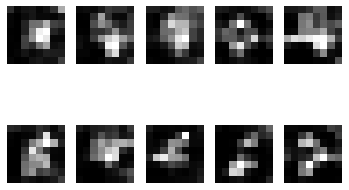

Batch 122/938 - Opimize G - Avg Batch Loss: 0.0164 - Time : 3.49s
Batch 123/938 - Opimize G - Avg Batch Loss: 0.0263 - Time : 3.58s
Batch 124/938 - Opimize G - Avg Batch Loss: 0.0120 - Time : 3.70s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.0047 - Time : 3.69s
Batch 126/938 - Opimize G - Avg Batch Loss: -0.0190 - Time : 3.94s
Batch 127/938 - Opimize D - Avg Batch Loss: 0.0157 - Time : 3.56s
Batch 128/938 - Opimize G - Avg Batch Loss: -0.0366 - Time : 3.63s
Batch 129/938 - Opimize G - Avg Batch Loss: 0.0119 - Time : 3.54s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.0169 - Time : 3.71s
Batch 131/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.84s
Batch 132/938 - Opimize G - Avg Batch Loss: -0.0209 - Time : 3.63s
Batch 133/938 - Opimize D - Avg Batch Loss: -0.0314 - Time : 3.72s
Batch 134/938 - Opimize G - Avg Batch Loss: -0.0136 - Time : 3.85s
Batch 135/938 - Opimize G - Avg Batch Loss: -0.0124 - Time : 3.87s
Batch 136/938 - Opimize G - Avg Batch Loss: 0.0048 - Time : 3.52s
Batc

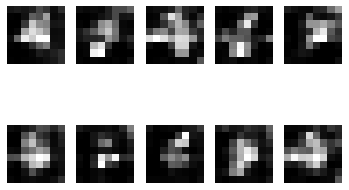

Batch 142/938 - Opimize G - Avg Batch Loss: -0.0146 - Time : 3.64s
Batch 143/938 - Opimize G - Avg Batch Loss: -0.0048 - Time : 3.87s
Batch 144/938 - Opimize G - Avg Batch Loss: -0.0445 - Time : 3.75s
Batch 145/938 - Opimize D - Avg Batch Loss: 0.0174 - Time : 3.57s
Batch 146/938 - Opimize G - Avg Batch Loss: 0.0353 - Time : 4.05s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 4.02s
Batch 148/938 - Opimize G - Avg Batch Loss: 0.0315 - Time : 3.85s
Batch 149/938 - Opimize G - Avg Batch Loss: -0.0086 - Time : 3.84s
Batch 150/938 - Opimize G - Avg Batch Loss: 0.0196 - Time : 3.77s
Batch 151/938 - Opimize D - Avg Batch Loss: 0.0439 - Time : 3.78s
Batch 152/938 - Opimize G - Avg Batch Loss: -0.0127 - Time : 3.53s
Batch 153/938 - Opimize G - Avg Batch Loss: -0.0230 - Time : 3.62s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.0276 - Time : 3.87s
Batch 155/938 - Opimize G - Avg Batch Loss: 0.0072 - Time : 3.63s
Batch 156/938 - Opimize G - Avg Batch Loss: -0.0061 - Time : 3.57s
Bat

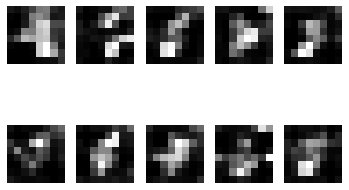

Batch 162/938 - Opimize G - Avg Batch Loss: 0.0878 - Time : 3.74s
Batch 163/938 - Opimize D - Avg Batch Loss: 0.0131 - Time : 3.72s
Batch 164/938 - Opimize G - Avg Batch Loss: -0.0243 - Time : 3.59s
Batch 165/938 - Opimize G - Avg Batch Loss: 0.0293 - Time : 3.94s
Batch 166/938 - Opimize G - Avg Batch Loss: 0.0209 - Time : 3.85s
Batch 167/938 - Opimize G - Avg Batch Loss: 0.0332 - Time : 3.81s
Batch 168/938 - Opimize G - Avg Batch Loss: -0.0358 - Time : 3.52s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.0174 - Time : 3.76s
Batch 170/938 - Opimize G - Avg Batch Loss: -0.0113 - Time : 3.74s
Batch 171/938 - Opimize G - Avg Batch Loss: -0.0162 - Time : 3.93s
Batch 172/938 - Opimize G - Avg Batch Loss: -0.0188 - Time : 3.70s
Batch 173/938 - Opimize G - Avg Batch Loss: -0.0190 - Time : 3.97s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.0327 - Time : 3.80s
Batch 175/938 - Opimize D - Avg Batch Loss: -0.0069 - Time : 3.70s
Batch 176/938 - Opimize G - Avg Batch Loss: 0.0536 - Time : 3.99s
Bat

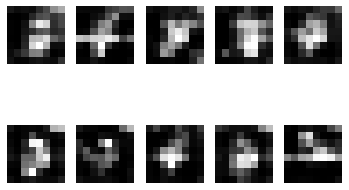

Batch 182/938 - Opimize G - Avg Batch Loss: -0.0083 - Time : 3.55s
Batch 183/938 - Opimize G - Avg Batch Loss: 0.0232 - Time : 3.88s
Batch 184/938 - Opimize G - Avg Batch Loss: -0.0168 - Time : 3.62s
Batch 185/938 - Opimize G - Avg Batch Loss: 0.0706 - Time : 3.91s
Batch 186/938 - Opimize G - Avg Batch Loss: -0.0199 - Time : 3.89s
Batch 187/938 - Opimize D - Avg Batch Loss: -0.0041 - Time : 3.50s
Batch 188/938 - Opimize G - Avg Batch Loss: 0.0268 - Time : 3.46s
Batch 189/938 - Opimize G - Avg Batch Loss: 0.0117 - Time : 3.53s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.0138 - Time : 3.70s
Batch 191/938 - Opimize G - Avg Batch Loss: 0.0158 - Time : 3.47s
Batch 192/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.73s
Batch 193/938 - Opimize D - Avg Batch Loss: 0.0071 - Time : 3.58s
Batch 194/938 - Opimize G - Avg Batch Loss: 0.0239 - Time : 3.71s
Batch 195/938 - Opimize G - Avg Batch Loss: -0.0323 - Time : 3.54s
Batch 196/938 - Opimize G - Avg Batch Loss: -0.0044 - Time : 3.44s
Batc

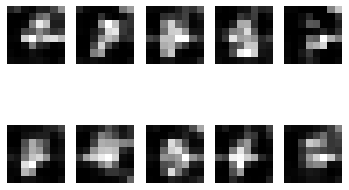

Batch 202/938 - Opimize G - Avg Batch Loss: 0.0088 - Time : 3.66s
Batch 203/938 - Opimize G - Avg Batch Loss: -0.0120 - Time : 3.84s
Batch 204/938 - Opimize G - Avg Batch Loss: 0.0295 - Time : 3.57s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.0106 - Time : 3.72s
Batch 206/938 - Opimize G - Avg Batch Loss: -0.0126 - Time : 3.63s
Batch 207/938 - Opimize G - Avg Batch Loss: -0.0341 - Time : 3.58s
Batch 208/938 - Opimize G - Avg Batch Loss: 0.0109 - Time : 3.61s
Batch 209/938 - Opimize G - Avg Batch Loss: 0.0189 - Time : 3.46s
Batch 210/938 - Opimize G - Avg Batch Loss: -0.0077 - Time : 3.71s
Batch 211/938 - Opimize D - Avg Batch Loss: -0.0233 - Time : 3.59s
Batch 212/938 - Opimize G - Avg Batch Loss: 0.0094 - Time : 3.63s
Batch 213/938 - Opimize G - Avg Batch Loss: -0.0217 - Time : 3.39s
Batch 214/938 - Opimize G - Avg Batch Loss: 0.0647 - Time : 3.75s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.0034 - Time : 3.40s
Batch 216/938 - Opimize G - Avg Batch Loss: 0.0251 - Time : 3.56s
Batc

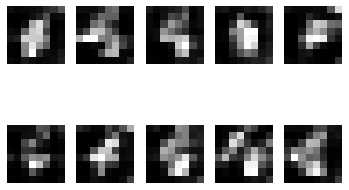

Batch 222/938 - Opimize G - Avg Batch Loss: 0.0448 - Time : 3.56s
Batch 223/938 - Opimize D - Avg Batch Loss: -0.0168 - Time : 3.78s
Batch 224/938 - Opimize G - Avg Batch Loss: -0.0167 - Time : 3.47s
Batch 225/938 - Opimize G - Avg Batch Loss: 0.0751 - Time : 4.12s
Batch 226/938 - Opimize G - Avg Batch Loss: 0.0170 - Time : 3.90s
Batch 227/938 - Opimize G - Avg Batch Loss: 0.0101 - Time : 3.87s
Batch 228/938 - Opimize G - Avg Batch Loss: 0.0398 - Time : 3.48s
Batch 229/938 - Opimize D - Avg Batch Loss: 0.0352 - Time : 3.56s
Batch 230/938 - Opimize G - Avg Batch Loss: 0.0063 - Time : 3.62s
Batch 231/938 - Opimize G - Avg Batch Loss: -0.0138 - Time : 3.56s
Batch 232/938 - Opimize G - Avg Batch Loss: 0.0738 - Time : 3.55s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.0209 - Time : 3.57s
Batch 234/938 - Opimize G - Avg Batch Loss: 0.0334 - Time : 3.57s
Batch 235/938 - Opimize D - Avg Batch Loss: -0.0045 - Time : 3.44s
Batch 236/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.71s
Batch

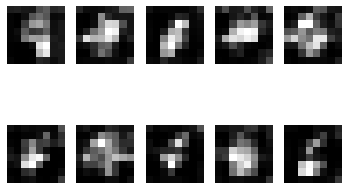

Batch 242/938 - Opimize G - Avg Batch Loss: -0.0005 - Time : 3.72s
Batch 243/938 - Opimize G - Avg Batch Loss: -0.0252 - Time : 3.64s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.0401 - Time : 3.68s
Batch 245/938 - Opimize G - Avg Batch Loss: 0.0148 - Time : 3.94s
Batch 246/938 - Opimize G - Avg Batch Loss: -0.0266 - Time : 3.52s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.0301 - Time : 3.51s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.0125 - Time : 3.52s
Batch 249/938 - Opimize G - Avg Batch Loss: -0.0062 - Time : 3.54s
Batch 250/938 - Opimize G - Avg Batch Loss: -0.0245 - Time : 3.66s
Batch 251/938 - Opimize G - Avg Batch Loss: 0.0485 - Time : 3.63s
Batch 252/938 - Opimize G - Avg Batch Loss: -0.0011 - Time : 3.75s
Batch 253/938 - Opimize D - Avg Batch Loss: -0.0335 - Time : 3.90s
Batch 254/938 - Opimize G - Avg Batch Loss: -0.0019 - Time : 3.46s
Batch 255/938 - Opimize G - Avg Batch Loss: 0.0096 - Time : 3.50s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.0039 - Time : 3.64s
Ba

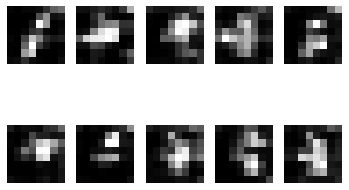

Batch 262/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 4.01s
Batch 263/938 - Opimize G - Avg Batch Loss: -0.0026 - Time : 3.74s
Batch 264/938 - Opimize G - Avg Batch Loss: 0.0595 - Time : 3.53s
Batch 265/938 - Opimize D - Avg Batch Loss: -0.0029 - Time : 3.51s
Batch 266/938 - Opimize G - Avg Batch Loss: -0.0464 - Time : 3.46s
Batch 267/938 - Opimize G - Avg Batch Loss: -0.0190 - Time : 3.57s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.0014 - Time : 3.47s
Batch 269/938 - Opimize G - Avg Batch Loss: -0.0350 - Time : 3.65s
Batch 270/938 - Opimize G - Avg Batch Loss: -0.0309 - Time : 3.51s
Batch 271/938 - Opimize D - Avg Batch Loss: 0.0444 - Time : 3.49s
Batch 272/938 - Opimize G - Avg Batch Loss: -0.0103 - Time : 3.50s
Batch 273/938 - Opimize G - Avg Batch Loss: 0.0158 - Time : 3.61s
Batch 274/938 - Opimize G - Avg Batch Loss: -0.0267 - Time : 3.63s
Batch 275/938 - Opimize G - Avg Batch Loss: 0.0615 - Time : 3.81s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.0273 - Time : 3.72s
Ba

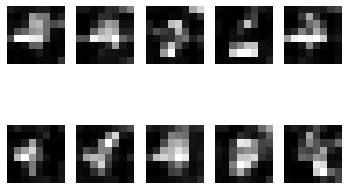

Batch 282/938 - Opimize G - Avg Batch Loss: 0.0327 - Time : 3.50s
Batch 283/938 - Opimize D - Avg Batch Loss: 0.0305 - Time : 3.64s
Batch 284/938 - Opimize G - Avg Batch Loss: -0.0372 - Time : 3.89s
Batch 285/938 - Opimize G - Avg Batch Loss: -0.0029 - Time : 3.90s
Batch 286/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.51s
Batch 287/938 - Opimize G - Avg Batch Loss: 0.0224 - Time : 3.64s
Batch 288/938 - Opimize G - Avg Batch Loss: -0.0123 - Time : 3.76s
Batch 289/938 - Opimize D - Avg Batch Loss: 0.0381 - Time : 3.77s
Batch 290/938 - Opimize G - Avg Batch Loss: -0.0097 - Time : 4.17s
Batch 291/938 - Opimize G - Avg Batch Loss: 0.0269 - Time : 3.84s
Batch 292/938 - Opimize G - Avg Batch Loss: -0.0071 - Time : 3.61s
Batch 293/938 - Opimize G - Avg Batch Loss: -0.0026 - Time : 3.73s
Batch 294/938 - Opimize G - Avg Batch Loss: 0.0282 - Time : 3.43s
Batch 295/938 - Opimize D - Avg Batch Loss: 0.0157 - Time : 3.56s
Batch 296/938 - Opimize G - Avg Batch Loss: 0.0314 - Time : 3.74s
Bat

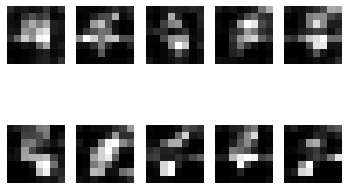

Batch 302/938 - Opimize G - Avg Batch Loss: 0.0355 - Time : 3.90s
Batch 303/938 - Opimize G - Avg Batch Loss: 0.0284 - Time : 3.40s
Batch 304/938 - Opimize G - Avg Batch Loss: 0.0074 - Time : 4.16s
Batch 305/938 - Opimize G - Avg Batch Loss: -0.0395 - Time : 3.49s
Batch 306/938 - Opimize G - Avg Batch Loss: -0.0044 - Time : 3.54s
Batch 307/938 - Opimize D - Avg Batch Loss: 0.0385 - Time : 3.51s
Batch 308/938 - Opimize G - Avg Batch Loss: 0.0343 - Time : 3.57s
Batch 309/938 - Opimize G - Avg Batch Loss: -0.0056 - Time : 3.67s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.0166 - Time : 3.46s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.0144 - Time : 3.73s
Batch 312/938 - Opimize G - Avg Batch Loss: 0.0469 - Time : 3.87s
Batch 313/938 - Opimize D - Avg Batch Loss: -0.0147 - Time : 4.14s
Batch 314/938 - Opimize G - Avg Batch Loss: 0.0305 - Time : 3.57s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.0018 - Time : 3.47s
Batch 316/938 - Opimize G - Avg Batch Loss: 0.0046 - Time : 3.62s
Batch 

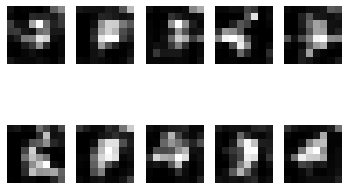

Batch 322/938 - Opimize G - Avg Batch Loss: 0.0118 - Time : 3.53s
Batch 323/938 - Opimize G - Avg Batch Loss: -0.0134 - Time : 3.41s
Batch 324/938 - Opimize G - Avg Batch Loss: -0.0127 - Time : 3.66s
Batch 325/938 - Opimize D - Avg Batch Loss: 0.0470 - Time : 3.71s
Batch 326/938 - Opimize G - Avg Batch Loss: 0.0440 - Time : 3.41s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.0150 - Time : 3.43s
Batch 328/938 - Opimize G - Avg Batch Loss: -0.0213 - Time : 3.41s
Batch 329/938 - Opimize G - Avg Batch Loss: -0.0030 - Time : 3.89s
Batch 330/938 - Opimize G - Avg Batch Loss: 0.0540 - Time : 3.96s
Batch 331/938 - Opimize D - Avg Batch Loss: -0.0097 - Time : 3.48s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.0519 - Time : 3.51s
Batch 333/938 - Opimize G - Avg Batch Loss: -0.0113 - Time : 3.85s
Batch 334/938 - Opimize G - Avg Batch Loss: 0.0034 - Time : 3.50s
Batch 335/938 - Opimize G - Avg Batch Loss: -0.0059 - Time : 3.64s
Batch 336/938 - Opimize G - Avg Batch Loss: 0.0569 - Time : 3.87s
Bat

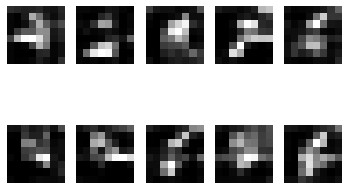

Batch 342/938 - Opimize G - Avg Batch Loss: -0.0578 - Time : 3.52s
Batch 343/938 - Opimize D - Avg Batch Loss: 0.0094 - Time : 3.84s
Batch 344/938 - Opimize G - Avg Batch Loss: -0.0301 - Time : 3.70s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.0207 - Time : 3.88s
Batch 346/938 - Opimize G - Avg Batch Loss: -0.0060 - Time : 3.86s
Batch 347/938 - Opimize G - Avg Batch Loss: 0.0291 - Time : 3.43s
Batch 348/938 - Opimize G - Avg Batch Loss: -0.0033 - Time : 3.63s
Batch 349/938 - Opimize D - Avg Batch Loss: -0.0413 - Time : 3.62s
Batch 350/938 - Opimize G - Avg Batch Loss: -0.0000 - Time : 3.48s
Batch 351/938 - Opimize G - Avg Batch Loss: -0.0252 - Time : 3.74s
Batch 352/938 - Opimize G - Avg Batch Loss: 0.0012 - Time : 3.67s
Batch 353/938 - Opimize G - Avg Batch Loss: 0.0008 - Time : 3.87s
Batch 354/938 - Opimize G - Avg Batch Loss: 0.0579 - Time : 3.39s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.0115 - Time : 3.44s
Batch 356/938 - Opimize G - Avg Batch Loss: -0.0176 - Time : 3.57s
Ba

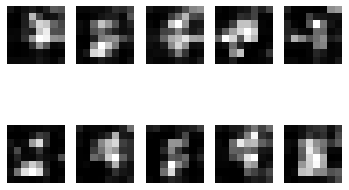

Batch 362/938 - Opimize G - Avg Batch Loss: -0.0031 - Time : 3.45s
Batch 363/938 - Opimize G - Avg Batch Loss: 0.0626 - Time : 3.66s
Batch 364/938 - Opimize G - Avg Batch Loss: -0.0138 - Time : 3.79s
Batch 365/938 - Opimize G - Avg Batch Loss: 0.0216 - Time : 3.61s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.0406 - Time : 3.63s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.0244 - Time : 3.47s
Batch 368/938 - Opimize G - Avg Batch Loss: -0.0211 - Time : 3.54s
Batch 369/938 - Opimize G - Avg Batch Loss: -0.0035 - Time : 3.54s
Batch 370/938 - Opimize G - Avg Batch Loss: -0.0310 - Time : 3.74s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.57s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.0244 - Time : 3.48s
Batch 373/938 - Opimize D - Avg Batch Loss: -0.0284 - Time : 3.55s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.0201 - Time : 3.81s
Batch 375/938 - Opimize G - Avg Batch Loss: 0.0065 - Time : 3.54s
Batch 376/938 - Opimize G - Avg Batch Loss: -0.0174 - Time : 3.46s
Bat

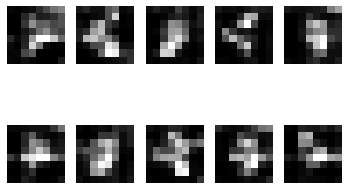

Batch 382/938 - Opimize G - Avg Batch Loss: 0.0121 - Time : 3.64s
Batch 383/938 - Opimize G - Avg Batch Loss: -0.0181 - Time : 3.93s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 3.60s
Batch 385/938 - Opimize D - Avg Batch Loss: -0.0036 - Time : 3.80s
Batch 386/938 - Opimize G - Avg Batch Loss: -0.0138 - Time : 3.88s
Batch 387/938 - Opimize G - Avg Batch Loss: -0.0022 - Time : 3.60s
Batch 388/938 - Opimize G - Avg Batch Loss: -0.0081 - Time : 3.41s
Batch 389/938 - Opimize G - Avg Batch Loss: -0.0329 - Time : 3.57s
Batch 390/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.93s
Batch 391/938 - Opimize D - Avg Batch Loss: -0.0005 - Time : 3.54s
Batch 392/938 - Opimize G - Avg Batch Loss: 0.0222 - Time : 3.74s
Batch 393/938 - Opimize G - Avg Batch Loss: 0.0172 - Time : 3.61s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.0267 - Time : 3.53s
Batch 395/938 - Opimize G - Avg Batch Loss: -0.0045 - Time : 3.47s
Batch 396/938 - Opimize G - Avg Batch Loss: 0.0312 - Time : 3.87s
B

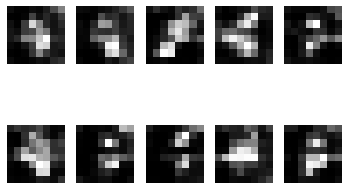

Batch 402/938 - Opimize G - Avg Batch Loss: -0.0284 - Time : 3.64s
Batch 403/938 - Opimize D - Avg Batch Loss: 0.0405 - Time : 3.53s
Batch 404/938 - Opimize G - Avg Batch Loss: -0.0213 - Time : 3.63s
Batch 405/938 - Opimize G - Avg Batch Loss: 0.0083 - Time : 3.41s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.0150 - Time : 3.78s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.0143 - Time : 3.36s
Batch 408/938 - Opimize G - Avg Batch Loss: -0.0170 - Time : 3.42s
Batch 409/938 - Opimize D - Avg Batch Loss: -0.0071 - Time : 3.98s
Batch 410/938 - Opimize G - Avg Batch Loss: 0.0119 - Time : 3.39s
Batch 411/938 - Opimize G - Avg Batch Loss: -0.0394 - Time : 4.10s
Batch 412/938 - Opimize G - Avg Batch Loss: 0.0314 - Time : 3.75s
Batch 413/938 - Opimize G - Avg Batch Loss: -0.0027 - Time : 3.89s
Batch 414/938 - Opimize G - Avg Batch Loss: 0.0091 - Time : 3.58s
Batch 415/938 - Opimize D - Avg Batch Loss: 0.0067 - Time : 3.40s
Batch 416/938 - Opimize G - Avg Batch Loss: 0.0064 - Time : 3.39s
Batc

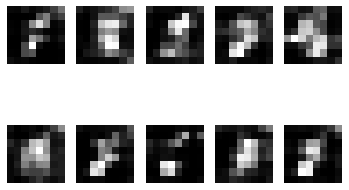

Batch 422/938 - Opimize G - Avg Batch Loss: 0.0239 - Time : 3.48s
Batch 423/938 - Opimize G - Avg Batch Loss: 0.0048 - Time : 3.76s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.0261 - Time : 3.67s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.0235 - Time : 3.52s
Batch 426/938 - Opimize G - Avg Batch Loss: -0.0132 - Time : 3.39s
Batch 427/938 - Opimize D - Avg Batch Loss: 0.0112 - Time : 3.39s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.0618 - Time : 3.63s
Batch 429/938 - Opimize G - Avg Batch Loss: -0.0229 - Time : 3.65s
Batch 430/938 - Opimize G - Avg Batch Loss: 0.0177 - Time : 3.58s
Batch 431/938 - Opimize G - Avg Batch Loss: -0.0193 - Time : 3.39s
Batch 432/938 - Opimize G - Avg Batch Loss: -0.0180 - Time : 3.59s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.0459 - Time : 3.71s
Batch 434/938 - Opimize G - Avg Batch Loss: 0.0006 - Time : 3.53s
Batch 435/938 - Opimize G - Avg Batch Loss: 0.0351 - Time : 3.62s
Batch 436/938 - Opimize G - Avg Batch Loss: 0.0254 - Time : 3.44s
Batch 

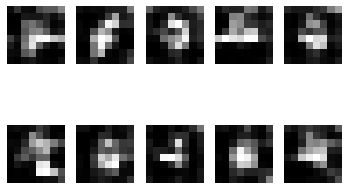

Batch 442/938 - Opimize G - Avg Batch Loss: 0.0032 - Time : 3.82s
Batch 443/938 - Opimize G - Avg Batch Loss: -0.0026 - Time : 3.63s
Batch 444/938 - Opimize G - Avg Batch Loss: 0.0177 - Time : 3.88s
Batch 445/938 - Opimize D - Avg Batch Loss: -0.0300 - Time : 4.18s
Batch 446/938 - Opimize G - Avg Batch Loss: -0.0072 - Time : 4.00s
Batch 447/938 - Opimize G - Avg Batch Loss: 0.0218 - Time : 3.58s
Batch 448/938 - Opimize G - Avg Batch Loss: -0.0074 - Time : 3.48s
Batch 449/938 - Opimize G - Avg Batch Loss: 0.0280 - Time : 3.57s
Batch 450/938 - Opimize G - Avg Batch Loss: -0.0381 - Time : 3.54s
Batch 451/938 - Opimize D - Avg Batch Loss: -0.0010 - Time : 3.72s
Batch 452/938 - Opimize G - Avg Batch Loss: -0.0031 - Time : 3.67s
Batch 453/938 - Opimize G - Avg Batch Loss: 0.0017 - Time : 3.41s
Batch 454/938 - Opimize G - Avg Batch Loss: 0.0402 - Time : 3.50s
Batch 455/938 - Opimize G - Avg Batch Loss: -0.0087 - Time : 3.56s
Batch 456/938 - Opimize G - Avg Batch Loss: -0.0305 - Time : 3.63s
B

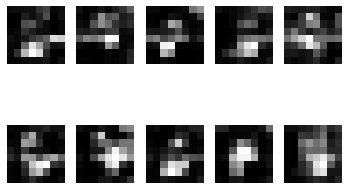

Batch 462/938 - Opimize G - Avg Batch Loss: -0.0149 - Time : 3.54s
Batch 463/938 - Opimize D - Avg Batch Loss: 0.0046 - Time : 3.61s
Batch 464/938 - Opimize G - Avg Batch Loss: 0.0171 - Time : 3.84s
Batch 465/938 - Opimize G - Avg Batch Loss: 0.0362 - Time : 3.67s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.0166 - Time : 3.38s
Batch 467/938 - Opimize G - Avg Batch Loss: 0.0103 - Time : 3.59s
Batch 468/938 - Opimize G - Avg Batch Loss: 0.0421 - Time : 3.44s
Batch 469/938 - Opimize D - Avg Batch Loss: -0.0024 - Time : 3.50s
Batch 470/938 - Opimize G - Avg Batch Loss: 0.0428 - Time : 3.44s
Batch 471/938 - Opimize G - Avg Batch Loss: -0.0600 - Time : 3.38s
Batch 472/938 - Opimize G - Avg Batch Loss: 0.0026 - Time : 3.59s
Batch 473/938 - Opimize G - Avg Batch Loss: 0.0192 - Time : 3.47s
Batch 474/938 - Opimize G - Avg Batch Loss: -0.0080 - Time : 3.42s
Batch 475/938 - Opimize D - Avg Batch Loss: -0.0357 - Time : 3.69s
Batch 476/938 - Opimize G - Avg Batch Loss: 0.0238 - Time : 3.47s
Batch

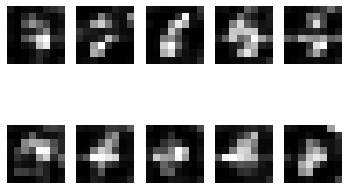

Batch 482/938 - Opimize G - Avg Batch Loss: 0.0168 - Time : 3.53s
Batch 483/938 - Opimize G - Avg Batch Loss: -0.0050 - Time : 3.46s
Batch 484/938 - Opimize G - Avg Batch Loss: 0.0197 - Time : 3.86s
Batch 485/938 - Opimize G - Avg Batch Loss: -0.0166 - Time : 3.88s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.0424 - Time : 4.43s
Batch 487/938 - Opimize D - Avg Batch Loss: 0.0173 - Time : 3.78s
Batch 488/938 - Opimize G - Avg Batch Loss: 0.0086 - Time : 3.69s
Batch 489/938 - Opimize G - Avg Batch Loss: -0.0048 - Time : 3.59s
Batch 490/938 - Opimize G - Avg Batch Loss: 0.0027 - Time : 3.57s
Batch 491/938 - Opimize G - Avg Batch Loss: 0.0049 - Time : 3.51s
Batch 492/938 - Opimize G - Avg Batch Loss: 0.0100 - Time : 3.73s
Batch 493/938 - Opimize D - Avg Batch Loss: -0.0019 - Time : 3.75s
Batch 494/938 - Opimize G - Avg Batch Loss: -0.0022 - Time : 3.88s
Batch 495/938 - Opimize G - Avg Batch Loss: -0.0020 - Time : 3.58s
Batch 496/938 - Opimize G - Avg Batch Loss: 0.0154 - Time : 3.85s
Batc

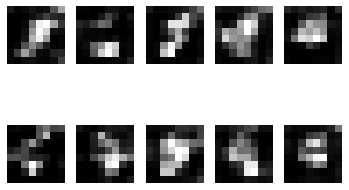

Batch 502/938 - Opimize G - Avg Batch Loss: 0.0335 - Time : 3.79s
Batch 503/938 - Opimize G - Avg Batch Loss: -0.0164 - Time : 3.66s
Batch 504/938 - Opimize G - Avg Batch Loss: -0.0261 - Time : 4.08s
Batch 505/938 - Opimize D - Avg Batch Loss: 0.0535 - Time : 4.12s
Batch 506/938 - Opimize G - Avg Batch Loss: 0.0033 - Time : 3.84s
Batch 507/938 - Opimize G - Avg Batch Loss: 0.0070 - Time : 4.05s
Batch 508/938 - Opimize G - Avg Batch Loss: 0.0234 - Time : 3.47s
Batch 509/938 - Opimize G - Avg Batch Loss: 0.0738 - Time : 3.72s
Batch 510/938 - Opimize G - Avg Batch Loss: -0.0122 - Time : 3.85s
Batch 511/938 - Opimize D - Avg Batch Loss: -0.0077 - Time : 4.00s
Batch 512/938 - Opimize G - Avg Batch Loss: -0.0062 - Time : 3.71s
Batch 513/938 - Opimize G - Avg Batch Loss: 0.0621 - Time : 3.75s
Batch 514/938 - Opimize G - Avg Batch Loss: 0.0102 - Time : 3.72s
Batch 515/938 - Opimize G - Avg Batch Loss: -0.0067 - Time : 4.01s
Batch 516/938 - Opimize G - Avg Batch Loss: 0.0060 - Time : 3.49s
Batc

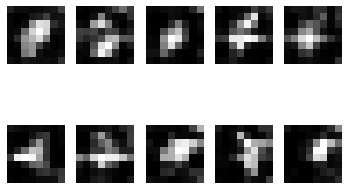

Batch 522/938 - Opimize G - Avg Batch Loss: 0.1008 - Time : 3.61s
Batch 523/938 - Opimize D - Avg Batch Loss: -0.0032 - Time : 3.58s
Batch 524/938 - Opimize G - Avg Batch Loss: 0.0942 - Time : 3.89s
Batch 525/938 - Opimize G - Avg Batch Loss: 0.0110 - Time : 3.43s
Batch 526/938 - Opimize G - Avg Batch Loss: 0.0311 - Time : 3.48s
Batch 527/938 - Opimize G - Avg Batch Loss: -0.0257 - Time : 3.43s
Batch 528/938 - Opimize G - Avg Batch Loss: 0.0180 - Time : 3.73s
Batch 529/938 - Opimize D - Avg Batch Loss: -0.0234 - Time : 3.88s
Batch 530/938 - Opimize G - Avg Batch Loss: 0.0162 - Time : 3.82s
Batch 531/938 - Opimize G - Avg Batch Loss: 0.0531 - Time : 3.94s
Batch 532/938 - Opimize G - Avg Batch Loss: -0.0191 - Time : 3.50s
Batch 533/938 - Opimize G - Avg Batch Loss: -0.0001 - Time : 3.65s
Batch 534/938 - Opimize G - Avg Batch Loss: -0.0180 - Time : 3.63s
Batch 535/938 - Opimize D - Avg Batch Loss: -0.0341 - Time : 3.91s
Batch 536/938 - Opimize G - Avg Batch Loss: -0.0234 - Time : 3.71s
Ba

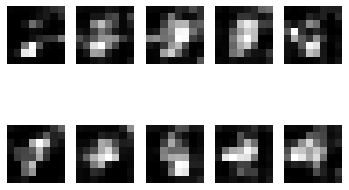

Batch 542/938 - Opimize G - Avg Batch Loss: 0.0030 - Time : 3.88s
Batch 543/938 - Opimize G - Avg Batch Loss: -0.0096 - Time : 3.37s
Batch 544/938 - Opimize G - Avg Batch Loss: 0.0004 - Time : 3.81s
Batch 545/938 - Opimize G - Avg Batch Loss: 0.0024 - Time : 3.63s
Batch 546/938 - Opimize G - Avg Batch Loss: 0.0294 - Time : 3.97s
Batch 547/938 - Opimize D - Avg Batch Loss: 0.0206 - Time : 3.70s
Batch 548/938 - Opimize G - Avg Batch Loss: 0.0228 - Time : 3.87s
Batch 549/938 - Opimize G - Avg Batch Loss: 0.0602 - Time : 3.57s
Batch 550/938 - Opimize G - Avg Batch Loss: -0.0108 - Time : 3.41s
Batch 551/938 - Opimize G - Avg Batch Loss: -0.0086 - Time : 3.56s
Batch 552/938 - Opimize G - Avg Batch Loss: 0.0251 - Time : 3.97s
Batch 553/938 - Opimize D - Avg Batch Loss: 0.0147 - Time : 3.76s
Batch 554/938 - Opimize G - Avg Batch Loss: -0.0160 - Time : 3.39s
Batch 555/938 - Opimize G - Avg Batch Loss: -0.0378 - Time : 3.42s
Batch 556/938 - Opimize G - Avg Batch Loss: 0.0375 - Time : 3.78s
Batch

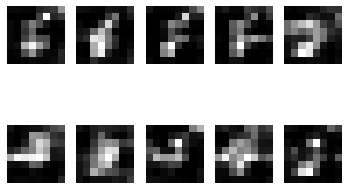

Batch 562/938 - Opimize G - Avg Batch Loss: -0.0338 - Time : 3.96s
Batch 563/938 - Opimize G - Avg Batch Loss: 0.0154 - Time : 3.95s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.0385 - Time : 3.49s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.0184 - Time : 4.09s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.0143 - Time : 3.71s
Batch 567/938 - Opimize G - Avg Batch Loss: 0.0415 - Time : 3.39s
Batch 568/938 - Opimize G - Avg Batch Loss: -0.0031 - Time : 3.50s
Batch 569/938 - Opimize G - Avg Batch Loss: 0.0178 - Time : 3.80s
Batch 570/938 - Opimize G - Avg Batch Loss: 0.0045 - Time : 3.50s
Batch 571/938 - Opimize D - Avg Batch Loss: -0.0062 - Time : 3.74s
Batch 572/938 - Opimize G - Avg Batch Loss: -0.0344 - Time : 4.03s
Batch 573/938 - Opimize G - Avg Batch Loss: 0.0192 - Time : 3.59s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.0372 - Time : 3.95s
Batch 575/938 - Opimize G - Avg Batch Loss: 0.0164 - Time : 3.65s
Batch 576/938 - Opimize G - Avg Batch Loss: -0.0026 - Time : 3.67s
Batch

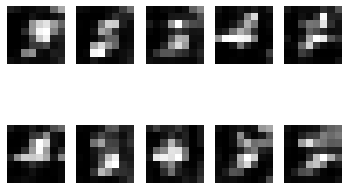

Batch 582/938 - Opimize G - Avg Batch Loss: 0.0066 - Time : 3.46s
Batch 583/938 - Opimize D - Avg Batch Loss: -0.0324 - Time : 3.71s
Batch 584/938 - Opimize G - Avg Batch Loss: -0.0237 - Time : 3.44s
Batch 585/938 - Opimize G - Avg Batch Loss: -0.0095 - Time : 4.30s
Batch 586/938 - Opimize G - Avg Batch Loss: -0.0173 - Time : 4.03s
Batch 587/938 - Opimize G - Avg Batch Loss: 0.0097 - Time : 3.66s
Batch 588/938 - Opimize G - Avg Batch Loss: -0.0278 - Time : 3.60s
Batch 589/938 - Opimize D - Avg Batch Loss: 0.0071 - Time : 3.50s
Batch 590/938 - Opimize G - Avg Batch Loss: -0.0102 - Time : 3.66s
Batch 591/938 - Opimize G - Avg Batch Loss: -0.0087 - Time : 3.76s
Batch 592/938 - Opimize G - Avg Batch Loss: -0.0015 - Time : 3.76s
Batch 593/938 - Opimize G - Avg Batch Loss: 0.0465 - Time : 3.66s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.0102 - Time : 3.90s
Batch 595/938 - Opimize D - Avg Batch Loss: 0.0332 - Time : 3.91s
Batch 596/938 - Opimize G - Avg Batch Loss: 0.0121 - Time : 3.50s
Ba

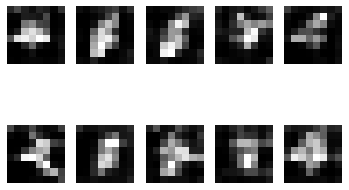

Batch 602/938 - Opimize G - Avg Batch Loss: 0.0709 - Time : 3.39s
Batch 603/938 - Opimize G - Avg Batch Loss: -0.0122 - Time : 3.36s
Batch 604/938 - Opimize G - Avg Batch Loss: -0.0401 - Time : 3.84s
Batch 605/938 - Opimize G - Avg Batch Loss: -0.0039 - Time : 3.85s
Batch 606/938 - Opimize G - Avg Batch Loss: 0.0058 - Time : 3.69s
Batch 607/938 - Opimize D - Avg Batch Loss: -0.0075 - Time : 3.55s
Batch 608/938 - Opimize G - Avg Batch Loss: 0.0023 - Time : 3.38s
Batch 609/938 - Opimize G - Avg Batch Loss: 0.0382 - Time : 3.54s
Batch 610/938 - Opimize G - Avg Batch Loss: 0.0347 - Time : 3.36s
Batch 611/938 - Opimize G - Avg Batch Loss: -0.0134 - Time : 3.74s
Batch 612/938 - Opimize G - Avg Batch Loss: -0.0022 - Time : 3.87s
Batch 613/938 - Opimize D - Avg Batch Loss: -0.0059 - Time : 3.38s
Batch 614/938 - Opimize G - Avg Batch Loss: 0.0241 - Time : 3.48s
Batch 615/938 - Opimize G - Avg Batch Loss: -0.0608 - Time : 3.58s
Batch 616/938 - Opimize G - Avg Batch Loss: 0.0115 - Time : 3.60s
Ba

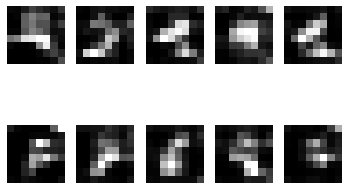

Batch 622/938 - Opimize G - Avg Batch Loss: -0.0197 - Time : 3.65s
Batch 623/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 3.74s
Batch 624/938 - Opimize G - Avg Batch Loss: 0.0243 - Time : 3.64s
Batch 625/938 - Opimize D - Avg Batch Loss: 0.0073 - Time : 3.36s
Batch 626/938 - Opimize G - Avg Batch Loss: -0.0221 - Time : 4.12s
Batch 627/938 - Opimize G - Avg Batch Loss: 0.0016 - Time : 3.80s
Batch 628/938 - Opimize G - Avg Batch Loss: 0.0183 - Time : 3.49s
Batch 629/938 - Opimize G - Avg Batch Loss: -0.0098 - Time : 3.45s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.0235 - Time : 3.59s
Batch 631/938 - Opimize D - Avg Batch Loss: -0.0172 - Time : 3.40s
Batch 632/938 - Opimize G - Avg Batch Loss: 0.0285 - Time : 3.51s
Batch 633/938 - Opimize G - Avg Batch Loss: -0.0456 - Time : 3.37s
Batch 634/938 - Opimize G - Avg Batch Loss: -0.0273 - Time : 3.89s
Batch 635/938 - Opimize G - Avg Batch Loss: 0.0195 - Time : 3.65s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.0372 - Time : 3.91s
Batc

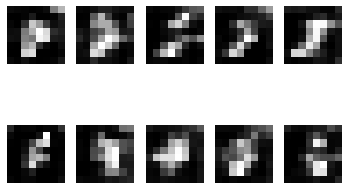

Batch 642/938 - Opimize G - Avg Batch Loss: -0.0083 - Time : 3.71s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.0216 - Time : 3.78s
Batch 644/938 - Opimize G - Avg Batch Loss: 0.0353 - Time : 3.60s
Batch 645/938 - Opimize G - Avg Batch Loss: -0.0089 - Time : 3.84s
Batch 646/938 - Opimize G - Avg Batch Loss: 0.0179 - Time : 3.45s
Batch 647/938 - Opimize G - Avg Batch Loss: -0.0048 - Time : 3.69s
Batch 648/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.46s
Batch 649/938 - Opimize D - Avg Batch Loss: 0.0072 - Time : 3.50s
Batch 650/938 - Opimize G - Avg Batch Loss: -0.0309 - Time : 3.39s
Batch 651/938 - Opimize G - Avg Batch Loss: -0.0202 - Time : 3.66s
Batch 652/938 - Opimize G - Avg Batch Loss: -0.0327 - Time : 3.49s
Batch 653/938 - Opimize G - Avg Batch Loss: 0.0087 - Time : 3.43s
Batch 654/938 - Opimize G - Avg Batch Loss: 0.0117 - Time : 3.44s
Batch 655/938 - Opimize D - Avg Batch Loss: -0.0092 - Time : 3.56s
Batch 656/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.41s
Ba

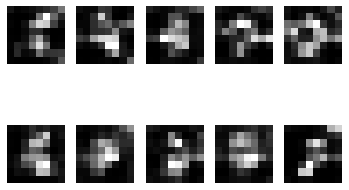

Batch 662/938 - Opimize G - Avg Batch Loss: 0.0217 - Time : 3.89s
Batch 663/938 - Opimize G - Avg Batch Loss: -0.0155 - Time : 3.42s
Batch 664/938 - Opimize G - Avg Batch Loss: 0.0155 - Time : 3.62s
Batch 665/938 - Opimize G - Avg Batch Loss: -0.0206 - Time : 3.45s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.0288 - Time : 3.59s
Batch 667/938 - Opimize D - Avg Batch Loss: -0.0012 - Time : 3.90s
Batch 668/938 - Opimize G - Avg Batch Loss: -0.0166 - Time : 3.56s
Batch 669/938 - Opimize G - Avg Batch Loss: -0.0222 - Time : 3.38s
Batch 670/938 - Opimize G - Avg Batch Loss: -0.0247 - Time : 3.42s
Batch 671/938 - Opimize G - Avg Batch Loss: -0.0176 - Time : 3.41s
Batch 672/938 - Opimize G - Avg Batch Loss: 0.0687 - Time : 3.41s
Batch 673/938 - Opimize D - Avg Batch Loss: 0.0670 - Time : 3.59s
Batch 674/938 - Opimize G - Avg Batch Loss: 0.0067 - Time : 3.53s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.0004 - Time : 3.59s
Batch 676/938 - Opimize G - Avg Batch Loss: -0.0156 - Time : 3.98s
Ba

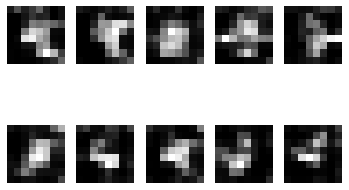

Batch 682/938 - Opimize G - Avg Batch Loss: 0.0401 - Time : 3.48s
Batch 683/938 - Opimize G - Avg Batch Loss: 0.0601 - Time : 3.65s
Batch 684/938 - Opimize G - Avg Batch Loss: 0.0122 - Time : 3.87s
Batch 685/938 - Opimize D - Avg Batch Loss: -0.0185 - Time : 3.44s
Batch 686/938 - Opimize G - Avg Batch Loss: 0.0206 - Time : 4.13s
Batch 687/938 - Opimize G - Avg Batch Loss: 0.0052 - Time : 3.96s
Batch 688/938 - Opimize G - Avg Batch Loss: -0.0253 - Time : 3.79s
Batch 689/938 - Opimize G - Avg Batch Loss: -0.0388 - Time : 3.37s
Batch 690/938 - Opimize G - Avg Batch Loss: 0.0007 - Time : 3.43s
Batch 691/938 - Opimize D - Avg Batch Loss: 0.0248 - Time : 3.70s
Batch 692/938 - Opimize G - Avg Batch Loss: 0.0375 - Time : 3.43s
Batch 693/938 - Opimize G - Avg Batch Loss: -0.0193 - Time : 3.61s
Batch 694/938 - Opimize G - Avg Batch Loss: 0.0037 - Time : 3.41s
Batch 695/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.82s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.0145 - Time : 3.78s
Batch

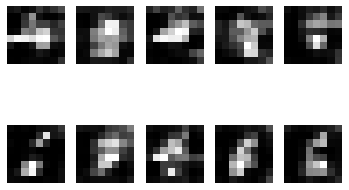

Batch 702/938 - Opimize G - Avg Batch Loss: -0.0053 - Time : 3.37s
Batch 703/938 - Opimize D - Avg Batch Loss: 0.0197 - Time : 3.66s
Batch 704/938 - Opimize G - Avg Batch Loss: -0.0243 - Time : 3.85s
Batch 705/938 - Opimize G - Avg Batch Loss: 0.0191 - Time : 3.56s
Batch 706/938 - Opimize G - Avg Batch Loss: -0.0082 - Time : 3.43s
Batch 707/938 - Opimize G - Avg Batch Loss: 0.0155 - Time : 3.72s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.0496 - Time : 3.51s
Batch 709/938 - Opimize D - Avg Batch Loss: -0.0078 - Time : 3.96s
Batch 710/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 3.74s
Batch 711/938 - Opimize G - Avg Batch Loss: 0.0253 - Time : 3.66s
Batch 712/938 - Opimize G - Avg Batch Loss: -0.0032 - Time : 3.84s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.0509 - Time : 3.40s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.1052 - Time : 3.47s
Batch 715/938 - Opimize D - Avg Batch Loss: -0.0230 - Time : 3.43s
Batch 716/938 - Opimize G - Avg Batch Loss: 0.0253 - Time : 3.39s
Batc

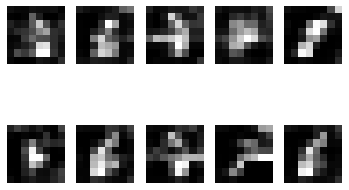

Batch 722/938 - Opimize G - Avg Batch Loss: 0.0222 - Time : 3.79s
Batch 723/938 - Opimize G - Avg Batch Loss: 0.0204 - Time : 3.63s
Batch 724/938 - Opimize G - Avg Batch Loss: -0.0256 - Time : 3.64s
Batch 725/938 - Opimize G - Avg Batch Loss: -0.0027 - Time : 3.38s
Batch 726/938 - Opimize G - Avg Batch Loss: 0.0205 - Time : 3.63s
Batch 727/938 - Opimize D - Avg Batch Loss: 0.0023 - Time : 3.41s
Batch 728/938 - Opimize G - Avg Batch Loss: -0.0020 - Time : 3.75s
Batch 729/938 - Opimize G - Avg Batch Loss: 0.0389 - Time : 3.89s
Batch 730/938 - Opimize G - Avg Batch Loss: -0.0205 - Time : 3.74s
Batch 731/938 - Opimize G - Avg Batch Loss: 0.0133 - Time : 3.46s
Batch 732/938 - Opimize G - Avg Batch Loss: -0.0241 - Time : 3.47s
Batch 733/938 - Opimize D - Avg Batch Loss: 0.0035 - Time : 3.55s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.45s
Batch 735/938 - Opimize G - Avg Batch Loss: -0.0186 - Time : 3.38s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.0194 - Time : 3.65s
Batc

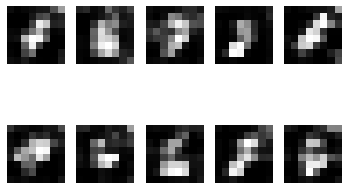

Batch 742/938 - Opimize G - Avg Batch Loss: 0.0144 - Time : 3.81s
Batch 743/938 - Opimize G - Avg Batch Loss: 0.0110 - Time : 3.77s
Batch 744/938 - Opimize G - Avg Batch Loss: -0.0167 - Time : 3.58s
Batch 745/938 - Opimize D - Avg Batch Loss: -0.0211 - Time : 3.53s
Batch 746/938 - Opimize G - Avg Batch Loss: -0.0289 - Time : 3.40s
Batch 747/938 - Opimize G - Avg Batch Loss: 0.0143 - Time : 3.56s
Batch 748/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.66s
Batch 749/938 - Opimize G - Avg Batch Loss: -0.0037 - Time : 3.43s
Batch 750/938 - Opimize G - Avg Batch Loss: 0.0083 - Time : 3.42s
Batch 751/938 - Opimize D - Avg Batch Loss: -0.0075 - Time : 3.69s
Batch 752/938 - Opimize G - Avg Batch Loss: -0.0235 - Time : 3.56s
Batch 753/938 - Opimize G - Avg Batch Loss: 0.0016 - Time : 3.65s
Batch 754/938 - Opimize G - Avg Batch Loss: -0.0076 - Time : 3.56s
Batch 755/938 - Opimize G - Avg Batch Loss: 0.0064 - Time : 3.82s
Batch 756/938 - Opimize G - Avg Batch Loss: -0.0130 - Time : 3.61s
Ba

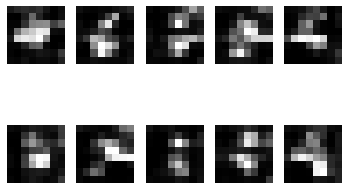

Batch 762/938 - Opimize G - Avg Batch Loss: -0.0019 - Time : 3.91s
Batch 763/938 - Opimize D - Avg Batch Loss: 0.0089 - Time : 3.74s
Batch 764/938 - Opimize G - Avg Batch Loss: -0.0195 - Time : 3.37s
Batch 765/938 - Opimize G - Avg Batch Loss: -0.0081 - Time : 4.14s
Batch 766/938 - Opimize G - Avg Batch Loss: -0.0130 - Time : 3.59s
Batch 767/938 - Opimize G - Avg Batch Loss: -0.0061 - Time : 3.50s
Batch 768/938 - Opimize G - Avg Batch Loss: 0.0086 - Time : 3.97s
Batch 769/938 - Opimize D - Avg Batch Loss: 0.0338 - Time : 3.40s
Batch 770/938 - Opimize G - Avg Batch Loss: 0.0421 - Time : 3.66s
Batch 771/938 - Opimize G - Avg Batch Loss: 0.0012 - Time : 3.74s
Batch 772/938 - Opimize G - Avg Batch Loss: -0.0100 - Time : 3.38s
Batch 773/938 - Opimize G - Avg Batch Loss: -0.0087 - Time : 3.65s
Batch 774/938 - Opimize G - Avg Batch Loss: 0.0129 - Time : 3.56s
Batch 775/938 - Opimize D - Avg Batch Loss: -0.0013 - Time : 3.73s
Batch 776/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.48s
Ba

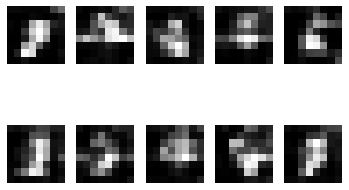

Batch 782/938 - Opimize G - Avg Batch Loss: 0.0239 - Time : 3.56s
Batch 783/938 - Opimize G - Avg Batch Loss: -0.0201 - Time : 3.60s
Batch 784/938 - Opimize G - Avg Batch Loss: 0.0128 - Time : 3.41s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.0008 - Time : 3.39s
Batch 786/938 - Opimize G - Avg Batch Loss: -0.0012 - Time : 3.85s
Batch 787/938 - Opimize D - Avg Batch Loss: -0.0086 - Time : 3.46s
Batch 788/938 - Opimize G - Avg Batch Loss: -0.0112 - Time : 3.40s
Batch 789/938 - Opimize G - Avg Batch Loss: 0.0115 - Time : 3.41s
Batch 790/938 - Opimize G - Avg Batch Loss: 0.0013 - Time : 3.80s
Batch 791/938 - Opimize G - Avg Batch Loss: 0.0128 - Time : 3.58s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.0271 - Time : 3.39s
Batch 793/938 - Opimize D - Avg Batch Loss: -0.0081 - Time : 3.52s
Batch 794/938 - Opimize G - Avg Batch Loss: 0.0336 - Time : 3.54s
Batch 795/938 - Opimize G - Avg Batch Loss: 0.0255 - Time : 3.68s
Batch 796/938 - Opimize G - Avg Batch Loss: 0.0050 - Time : 3.41s
Batch

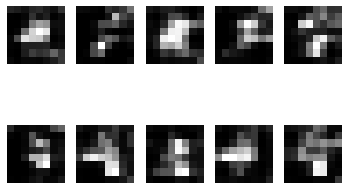

Batch 802/938 - Opimize G - Avg Batch Loss: 0.0217 - Time : 3.48s
Batch 803/938 - Opimize G - Avg Batch Loss: -0.0297 - Time : 3.40s
Batch 804/938 - Opimize G - Avg Batch Loss: -0.0158 - Time : 3.92s
Batch 805/938 - Opimize D - Avg Batch Loss: -0.0185 - Time : 3.37s
Batch 806/938 - Opimize G - Avg Batch Loss: -0.0352 - Time : 3.69s
Batch 807/938 - Opimize G - Avg Batch Loss: -0.0284 - Time : 3.49s
Batch 808/938 - Opimize G - Avg Batch Loss: -0.0488 - Time : 3.96s
Batch 809/938 - Opimize G - Avg Batch Loss: -0.0045 - Time : 3.41s
Batch 810/938 - Opimize G - Avg Batch Loss: -0.0138 - Time : 3.41s
Batch 811/938 - Opimize D - Avg Batch Loss: -0.0012 - Time : 3.54s
Batch 812/938 - Opimize G - Avg Batch Loss: -0.0100 - Time : 3.44s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.0130 - Time : 4.10s
Batch 814/938 - Opimize G - Avg Batch Loss: -0.0469 - Time : 3.87s
Batch 815/938 - Opimize G - Avg Batch Loss: 0.0138 - Time : 3.48s
Batch 816/938 - Opimize G - Avg Batch Loss: 0.0113 - Time : 3.42s

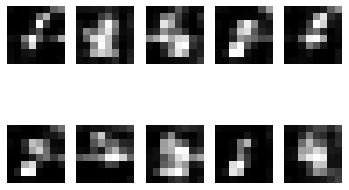

Batch 822/938 - Opimize G - Avg Batch Loss: 0.0255 - Time : 3.89s
Batch 823/938 - Opimize D - Avg Batch Loss: 0.0039 - Time : 3.39s
Batch 824/938 - Opimize G - Avg Batch Loss: -0.0169 - Time : 3.69s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.0000 - Time : 3.51s
Batch 826/938 - Opimize G - Avg Batch Loss: 0.0131 - Time : 3.62s
Batch 827/938 - Opimize G - Avg Batch Loss: 0.0164 - Time : 3.44s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.0422 - Time : 3.65s
Batch 829/938 - Opimize D - Avg Batch Loss: 0.0117 - Time : 3.47s
Batch 830/938 - Opimize G - Avg Batch Loss: -0.0068 - Time : 3.42s
Batch 831/938 - Opimize G - Avg Batch Loss: 0.0220 - Time : 3.87s
Batch 832/938 - Opimize G - Avg Batch Loss: 0.0326 - Time : 3.58s
Batch 833/938 - Opimize G - Avg Batch Loss: 0.0160 - Time : 3.76s
Batch 834/938 - Opimize G - Avg Batch Loss: -0.0001 - Time : 3.70s
Batch 835/938 - Opimize D - Avg Batch Loss: -0.0106 - Time : 3.49s
Batch 836/938 - Opimize G - Avg Batch Loss: 0.0103 - Time : 4.11s
Batch 

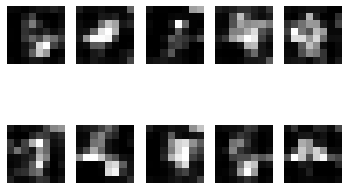

Batch 842/938 - Opimize G - Avg Batch Loss: 0.0551 - Time : 3.65s
Batch 843/938 - Opimize G - Avg Batch Loss: 0.0119 - Time : 3.49s
Batch 844/938 - Opimize G - Avg Batch Loss: -0.0091 - Time : 3.79s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.0386 - Time : 3.57s
Batch 846/938 - Opimize G - Avg Batch Loss: 0.0012 - Time : 3.55s
Batch 847/938 - Opimize D - Avg Batch Loss: -0.0470 - Time : 3.62s
Batch 848/938 - Opimize G - Avg Batch Loss: -0.0391 - Time : 3.49s
Batch 849/938 - Opimize G - Avg Batch Loss: 0.0092 - Time : 3.60s
Batch 850/938 - Opimize G - Avg Batch Loss: -0.0039 - Time : 3.77s
Batch 851/938 - Opimize G - Avg Batch Loss: 0.0050 - Time : 3.49s
Batch 852/938 - Opimize G - Avg Batch Loss: -0.0095 - Time : 3.42s
Batch 853/938 - Opimize D - Avg Batch Loss: -0.0031 - Time : 3.43s
Batch 854/938 - Opimize G - Avg Batch Loss: -0.0000 - Time : 3.36s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.0996 - Time : 3.72s
Batch 856/938 - Opimize G - Avg Batch Loss: -0.0340 - Time : 3.41s
Ba

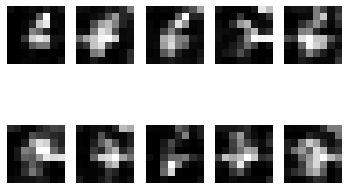

Batch 862/938 - Opimize G - Avg Batch Loss: -0.0128 - Time : 3.74s
Batch 863/938 - Opimize G - Avg Batch Loss: 0.0309 - Time : 3.39s
Batch 864/938 - Opimize G - Avg Batch Loss: 0.0316 - Time : 3.41s
Batch 865/938 - Opimize D - Avg Batch Loss: -0.0360 - Time : 3.85s
Batch 866/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.49s
Batch 867/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.44s
Batch 868/938 - Opimize G - Avg Batch Loss: -0.0056 - Time : 3.66s
Batch 869/938 - Opimize G - Avg Batch Loss: -0.0163 - Time : 3.55s
Batch 870/938 - Opimize G - Avg Batch Loss: 0.0214 - Time : 3.54s
Batch 871/938 - Opimize D - Avg Batch Loss: -0.0009 - Time : 3.37s
Batch 872/938 - Opimize G - Avg Batch Loss: -0.0340 - Time : 3.52s
Batch 873/938 - Opimize G - Avg Batch Loss: -0.0101 - Time : 3.43s
Batch 874/938 - Opimize G - Avg Batch Loss: -0.0140 - Time : 3.64s
Batch 875/938 - Opimize G - Avg Batch Loss: -0.0225 - Time : 3.43s
Batch 876/938 - Opimize G - Avg Batch Loss: 0.0056 - Time : 3.70s
B

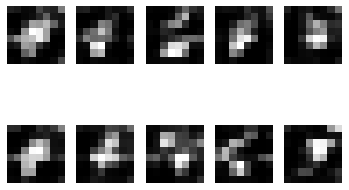

Batch 882/938 - Opimize G - Avg Batch Loss: -0.0119 - Time : 3.54s
Batch 883/938 - Opimize D - Avg Batch Loss: 0.0345 - Time : 3.72s
Batch 884/938 - Opimize G - Avg Batch Loss: -0.0053 - Time : 3.82s
Batch 885/938 - Opimize G - Avg Batch Loss: 0.0070 - Time : 3.62s
Batch 886/938 - Opimize G - Avg Batch Loss: -0.0305 - Time : 3.40s
Batch 887/938 - Opimize G - Avg Batch Loss: -0.0020 - Time : 3.89s
Batch 888/938 - Opimize G - Avg Batch Loss: 0.0213 - Time : 3.90s
Batch 889/938 - Opimize D - Avg Batch Loss: -0.0205 - Time : 3.56s
Batch 890/938 - Opimize G - Avg Batch Loss: 0.0004 - Time : 3.43s
Batch 891/938 - Opimize G - Avg Batch Loss: 0.0047 - Time : 3.70s
Batch 892/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.46s
Batch 893/938 - Opimize G - Avg Batch Loss: -0.0068 - Time : 3.66s
Batch 894/938 - Opimize G - Avg Batch Loss: -0.0055 - Time : 3.66s
Batch 895/938 - Opimize D - Avg Batch Loss: -0.0065 - Time : 3.54s
Batch 896/938 - Opimize G - Avg Batch Loss: -0.0204 - Time : 3.39s
B

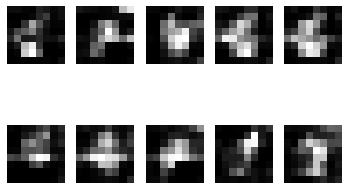

Batch 902/938 - Opimize G - Avg Batch Loss: -0.0038 - Time : 3.38s
Batch 903/938 - Opimize G - Avg Batch Loss: -0.0162 - Time : 3.60s
Batch 904/938 - Opimize G - Avg Batch Loss: 0.0210 - Time : 3.83s
Batch 905/938 - Opimize G - Avg Batch Loss: 0.0124 - Time : 3.53s
Batch 906/938 - Opimize G - Avg Batch Loss: 0.0140 - Time : 3.73s
Batch 907/938 - Opimize D - Avg Batch Loss: 0.0272 - Time : 3.65s
Batch 908/938 - Opimize G - Avg Batch Loss: -0.0284 - Time : 3.67s
Batch 909/938 - Opimize G - Avg Batch Loss: -0.0072 - Time : 3.91s
Batch 910/938 - Opimize G - Avg Batch Loss: 0.0269 - Time : 3.76s
Batch 911/938 - Opimize G - Avg Batch Loss: 0.0086 - Time : 3.45s
Batch 912/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.83s
Batch 913/938 - Opimize D - Avg Batch Loss: 0.0014 - Time : 3.75s
Batch 914/938 - Opimize G - Avg Batch Loss: -0.0170 - Time : 3.68s
Batch 915/938 - Opimize G - Avg Batch Loss: 0.0419 - Time : 3.65s
Batch 916/938 - Opimize G - Avg Batch Loss: 0.0093 - Time : 3.38s
Batch

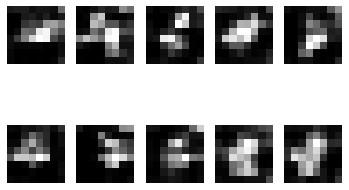

Batch 922/938 - Opimize G - Avg Batch Loss: 0.0137 - Time : 3.52s
Batch 923/938 - Opimize G - Avg Batch Loss: 0.0271 - Time : 3.61s
Batch 924/938 - Opimize G - Avg Batch Loss: -0.0243 - Time : 3.75s
Batch 925/938 - Opimize D - Avg Batch Loss: -0.0077 - Time : 3.54s
Batch 926/938 - Opimize G - Avg Batch Loss: -0.0214 - Time : 3.52s
Batch 927/938 - Opimize G - Avg Batch Loss: -0.0086 - Time : 3.60s
Batch 928/938 - Opimize G - Avg Batch Loss: 0.0018 - Time : 3.62s
Batch 929/938 - Opimize G - Avg Batch Loss: 0.0699 - Time : 3.37s
Batch 930/938 - Opimize G - Avg Batch Loss: 0.0466 - Time : 3.68s
Batch 931/938 - Opimize D - Avg Batch Loss: -0.0011 - Time : 3.42s
Batch 932/938 - Opimize G - Avg Batch Loss: -0.0247 - Time : 3.46s
Batch 933/938 - Opimize G - Avg Batch Loss: 0.0302 - Time : 3.43s
Batch 934/938 - Opimize G - Avg Batch Loss: 0.0072 - Time : 3.61s
Batch 935/938 - Opimize G - Avg Batch Loss: -0.0051 - Time : 3.43s
Batch 936/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.47s
Bat

In [33]:
history1 = train(n_gen=5, n_epochs = 1, batch_size = 64, plt_samples = 20)

In [0]:
history.extend(history1)

Text(0.5, 1.0, 'Loss history over 4 epochs')

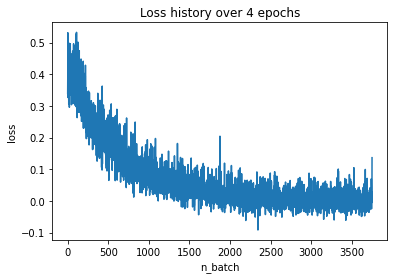

In [35]:
plt.plot(history)
plt.ylabel("loss")
plt.xlabel("n_batch")
plt.title("Loss history over 4 epochs")

In [0]:
np.savetxt("history_cnn_3.txt", history)

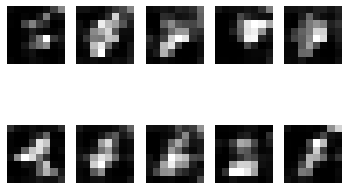

In [40]:
generate_plt()

In [0]:
torch.save(generator.state_dict(), "generatorCNN_4epochs.statedict")
torch.save(discriminator.state_dict(), "discriminatorCNN_4epochs.statedict")

### MLP networks result

========================Epoch: 1 / 1 =======================
Batch 1/1875 - Opimize D - Avg Batch Loss: 1.2967 - Time : 2.69s


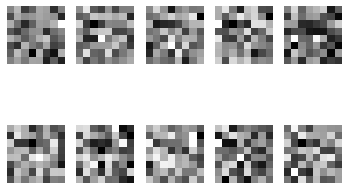

Batch 2/1875 - Opimize G - Avg Batch Loss: 1.2714 - Time : 2.71s
Batch 3/1875 - Opimize G - Avg Batch Loss: 1.2428 - Time : 2.63s
Batch 4/1875 - Opimize G - Avg Batch Loss: 1.1319 - Time : 2.94s
Batch 5/1875 - Opimize G - Avg Batch Loss: 1.1303 - Time : 2.72s
Batch 6/1875 - Opimize G - Avg Batch Loss: 1.2215 - Time : 2.78s
Batch 7/1875 - Opimize D - Avg Batch Loss: 1.2316 - Time : 2.71s
Batch 8/1875 - Opimize G - Avg Batch Loss: 1.2145 - Time : 2.73s
Batch 9/1875 - Opimize G - Avg Batch Loss: 1.2557 - Time : 2.64s
Batch 10/1875 - Opimize G - Avg Batch Loss: 1.3014 - Time : 3.02s
Batch 11/1875 - Opimize G - Avg Batch Loss: 1.2523 - Time : 2.68s


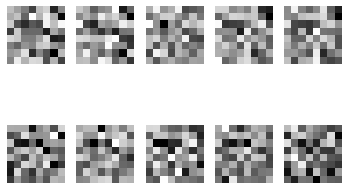

Batch 12/1875 - Opimize G - Avg Batch Loss: 1.2800 - Time : 2.78s
Batch 13/1875 - Opimize D - Avg Batch Loss: 1.2065 - Time : 2.62s
Batch 14/1875 - Opimize G - Avg Batch Loss: 1.2496 - Time : 2.66s
Batch 15/1875 - Opimize G - Avg Batch Loss: 1.1320 - Time : 2.74s
Batch 16/1875 - Opimize G - Avg Batch Loss: 1.1526 - Time : 2.82s
Batch 17/1875 - Opimize G - Avg Batch Loss: 1.2741 - Time : 2.63s
Batch 18/1875 - Opimize G - Avg Batch Loss: 1.1769 - Time : 3.14s
Batch 19/1875 - Opimize D - Avg Batch Loss: 1.2278 - Time : 2.64s
Batch 20/1875 - Opimize G - Avg Batch Loss: 1.1675 - Time : 2.68s
Batch 21/1875 - Opimize G - Avg Batch Loss: 1.0951 - Time : 2.66s


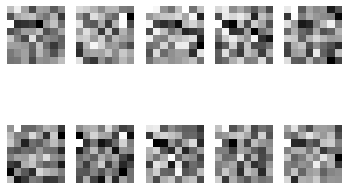

Batch 22/1875 - Opimize G - Avg Batch Loss: 1.0644 - Time : 2.91s
Batch 23/1875 - Opimize G - Avg Batch Loss: 1.1359 - Time : 2.91s
Batch 24/1875 - Opimize G - Avg Batch Loss: 1.1038 - Time : 2.70s
Batch 25/1875 - Opimize D - Avg Batch Loss: 1.1160 - Time : 2.86s
Batch 26/1875 - Opimize G - Avg Batch Loss: 1.1854 - Time : 2.63s
Batch 27/1875 - Opimize G - Avg Batch Loss: 1.1843 - Time : 2.70s
Batch 28/1875 - Opimize G - Avg Batch Loss: 1.1419 - Time : 2.69s
Batch 29/1875 - Opimize G - Avg Batch Loss: 0.9919 - Time : 2.68s
Batch 30/1875 - Opimize G - Avg Batch Loss: 1.1581 - Time : 2.92s
Batch 31/1875 - Opimize D - Avg Batch Loss: 1.2219 - Time : 2.66s


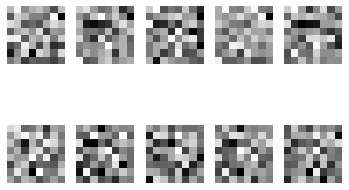

Batch 32/1875 - Opimize G - Avg Batch Loss: 1.0943 - Time : 2.65s
Batch 33/1875 - Opimize G - Avg Batch Loss: 1.1460 - Time : 2.71s
Batch 34/1875 - Opimize G - Avg Batch Loss: 1.0390 - Time : 2.91s
Batch 35/1875 - Opimize G - Avg Batch Loss: 1.1503 - Time : 2.82s
Batch 36/1875 - Opimize G - Avg Batch Loss: 1.0380 - Time : 2.65s
Batch 37/1875 - Opimize D - Avg Batch Loss: 1.0396 - Time : 2.66s
Batch 38/1875 - Opimize G - Avg Batch Loss: 1.1048 - Time : 2.71s
Batch 39/1875 - Opimize G - Avg Batch Loss: 1.0373 - Time : 2.93s
Batch 40/1875 - Opimize G - Avg Batch Loss: 1.0884 - Time : 2.82s
Batch 41/1875 - Opimize G - Avg Batch Loss: 1.1213 - Time : 3.14s


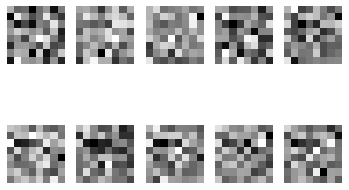

Batch 42/1875 - Opimize G - Avg Batch Loss: 1.1084 - Time : 3.16s
Batch 43/1875 - Opimize D - Avg Batch Loss: 1.1002 - Time : 2.63s
Batch 44/1875 - Opimize G - Avg Batch Loss: 1.0989 - Time : 2.78s
Batch 45/1875 - Opimize G - Avg Batch Loss: 1.0825 - Time : 2.91s
Batch 46/1875 - Opimize G - Avg Batch Loss: 1.1392 - Time : 2.70s
Batch 47/1875 - Opimize G - Avg Batch Loss: 1.0086 - Time : 2.65s
Batch 48/1875 - Opimize G - Avg Batch Loss: 1.0277 - Time : 2.67s
Batch 49/1875 - Opimize D - Avg Batch Loss: 1.1186 - Time : 2.74s
Batch 50/1875 - Opimize G - Avg Batch Loss: 1.1286 - Time : 2.65s
Batch 51/1875 - Opimize G - Avg Batch Loss: 1.0486 - Time : 2.70s


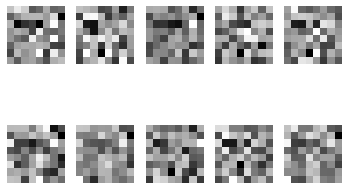

Batch 52/1875 - Opimize G - Avg Batch Loss: 0.9920 - Time : 2.66s
Batch 53/1875 - Opimize G - Avg Batch Loss: 1.0524 - Time : 2.64s
Batch 54/1875 - Opimize G - Avg Batch Loss: 1.0627 - Time : 2.90s
Batch 55/1875 - Opimize D - Avg Batch Loss: 1.0820 - Time : 2.92s
Batch 56/1875 - Opimize G - Avg Batch Loss: 1.0810 - Time : 2.66s
Batch 57/1875 - Opimize G - Avg Batch Loss: 1.1164 - Time : 2.85s
Batch 58/1875 - Opimize G - Avg Batch Loss: 1.0196 - Time : 2.70s
Batch 59/1875 - Opimize G - Avg Batch Loss: 1.0988 - Time : 2.94s
Batch 60/1875 - Opimize G - Avg Batch Loss: 1.0657 - Time : 2.68s
Batch 61/1875 - Opimize D - Avg Batch Loss: 1.0339 - Time : 2.68s


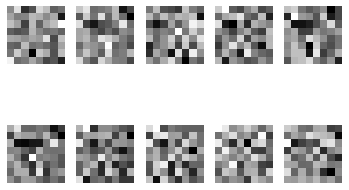

Batch 62/1875 - Opimize G - Avg Batch Loss: 1.0171 - Time : 2.72s
Batch 63/1875 - Opimize G - Avg Batch Loss: 1.0703 - Time : 2.65s
Batch 64/1875 - Opimize G - Avg Batch Loss: 1.0723 - Time : 2.68s
Batch 65/1875 - Opimize G - Avg Batch Loss: 1.0367 - Time : 2.62s
Batch 66/1875 - Opimize G - Avg Batch Loss: 1.0609 - Time : 2.71s
Batch 67/1875 - Opimize D - Avg Batch Loss: 0.9515 - Time : 2.68s
Batch 68/1875 - Opimize G - Avg Batch Loss: 0.9788 - Time : 2.84s
Batch 69/1875 - Opimize G - Avg Batch Loss: 1.0194 - Time : 2.72s
Batch 70/1875 - Opimize G - Avg Batch Loss: 0.9074 - Time : 2.95s
Batch 71/1875 - Opimize G - Avg Batch Loss: 1.0469 - Time : 2.92s


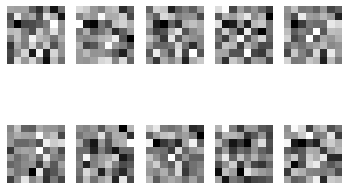

Batch 72/1875 - Opimize G - Avg Batch Loss: 1.0081 - Time : 2.71s
Batch 73/1875 - Opimize D - Avg Batch Loss: 1.0027 - Time : 2.71s
Batch 74/1875 - Opimize G - Avg Batch Loss: 1.1164 - Time : 2.73s
Batch 75/1875 - Opimize G - Avg Batch Loss: 0.9957 - Time : 2.68s
Batch 76/1875 - Opimize G - Avg Batch Loss: 0.9784 - Time : 2.65s
Batch 77/1875 - Opimize G - Avg Batch Loss: 0.9326 - Time : 2.71s
Batch 78/1875 - Opimize G - Avg Batch Loss: 0.9715 - Time : 2.96s
Batch 79/1875 - Opimize D - Avg Batch Loss: 0.9050 - Time : 2.65s
Batch 80/1875 - Opimize G - Avg Batch Loss: 1.1459 - Time : 2.72s
Batch 81/1875 - Opimize G - Avg Batch Loss: 1.0835 - Time : 2.64s


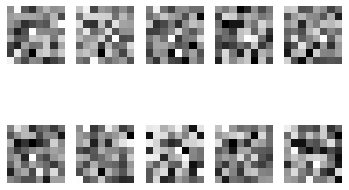

Batch 82/1875 - Opimize G - Avg Batch Loss: 1.0176 - Time : 2.66s
Batch 83/1875 - Opimize G - Avg Batch Loss: 0.9071 - Time : 2.92s
Batch 84/1875 - Opimize G - Avg Batch Loss: 0.9875 - Time : 2.92s
Batch 85/1875 - Opimize D - Avg Batch Loss: 0.9541 - Time : 2.71s
Batch 86/1875 - Opimize G - Avg Batch Loss: 1.0118 - Time : 2.64s
Batch 87/1875 - Opimize G - Avg Batch Loss: 1.1060 - Time : 2.67s
Batch 88/1875 - Opimize G - Avg Batch Loss: 1.0124 - Time : 2.71s
Batch 89/1875 - Opimize G - Avg Batch Loss: 0.9859 - Time : 2.80s
Batch 90/1875 - Opimize G - Avg Batch Loss: 0.9925 - Time : 2.75s
Batch 91/1875 - Opimize D - Avg Batch Loss: 0.8879 - Time : 2.96s


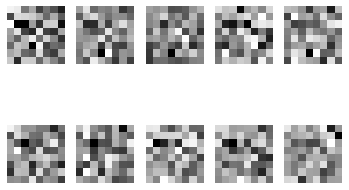

Batch 92/1875 - Opimize G - Avg Batch Loss: 1.0562 - Time : 2.72s
Batch 93/1875 - Opimize G - Avg Batch Loss: 1.0682 - Time : 2.69s
Batch 94/1875 - Opimize G - Avg Batch Loss: 0.9969 - Time : 2.61s
Batch 95/1875 - Opimize G - Avg Batch Loss: 0.9043 - Time : 2.95s
Batch 96/1875 - Opimize G - Avg Batch Loss: 0.9192 - Time : 2.62s
Batch 97/1875 - Opimize D - Avg Batch Loss: 0.9339 - Time : 2.93s
Batch 98/1875 - Opimize G - Avg Batch Loss: 0.9393 - Time : 2.69s
Batch 99/1875 - Opimize G - Avg Batch Loss: 0.9873 - Time : 2.67s
Batch 100/1875 - Opimize G - Avg Batch Loss: 0.9442 - Time : 2.66s
Batch 101/1875 - Opimize G - Avg Batch Loss: 0.9429 - Time : 2.96s


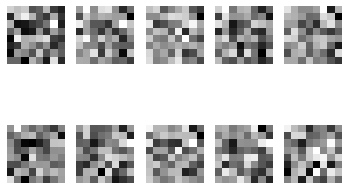

Batch 102/1875 - Opimize G - Avg Batch Loss: 0.8827 - Time : 3.09s
Batch 103/1875 - Opimize D - Avg Batch Loss: 1.0748 - Time : 2.70s
Batch 104/1875 - Opimize G - Avg Batch Loss: 0.8506 - Time : 2.74s
Batch 105/1875 - Opimize G - Avg Batch Loss: 0.9718 - Time : 2.88s
Batch 106/1875 - Opimize G - Avg Batch Loss: 0.9809 - Time : 2.64s
Batch 107/1875 - Opimize G - Avg Batch Loss: 0.9883 - Time : 2.69s
Batch 108/1875 - Opimize G - Avg Batch Loss: 0.9536 - Time : 2.85s
Batch 109/1875 - Opimize D - Avg Batch Loss: 0.9689 - Time : 2.88s
Batch 110/1875 - Opimize G - Avg Batch Loss: 0.9353 - Time : 2.64s
Batch 111/1875 - Opimize G - Avg Batch Loss: 0.9068 - Time : 2.68s


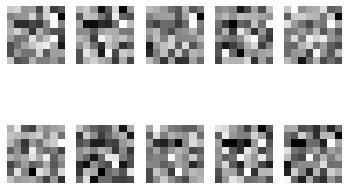

Batch 112/1875 - Opimize G - Avg Batch Loss: 0.8978 - Time : 2.67s
Batch 113/1875 - Opimize G - Avg Batch Loss: 0.9511 - Time : 2.67s
Batch 114/1875 - Opimize G - Avg Batch Loss: 1.0353 - Time : 2.88s
Batch 115/1875 - Opimize D - Avg Batch Loss: 0.8373 - Time : 3.03s
Batch 116/1875 - Opimize G - Avg Batch Loss: 0.9900 - Time : 3.08s
Batch 117/1875 - Opimize G - Avg Batch Loss: 0.9169 - Time : 2.93s
Batch 118/1875 - Opimize G - Avg Batch Loss: 0.9416 - Time : 2.95s
Batch 119/1875 - Opimize G - Avg Batch Loss: 0.9409 - Time : 2.64s
Batch 120/1875 - Opimize G - Avg Batch Loss: 0.9368 - Time : 3.00s
Batch 121/1875 - Opimize D - Avg Batch Loss: 1.0143 - Time : 2.72s


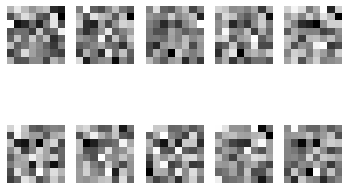

Batch 122/1875 - Opimize G - Avg Batch Loss: 0.8695 - Time : 2.71s
Batch 123/1875 - Opimize G - Avg Batch Loss: 0.9001 - Time : 2.73s
Batch 124/1875 - Opimize G - Avg Batch Loss: 0.9605 - Time : 2.84s
Batch 125/1875 - Opimize G - Avg Batch Loss: 0.8278 - Time : 3.15s
Batch 126/1875 - Opimize G - Avg Batch Loss: 1.0052 - Time : 2.67s
Batch 127/1875 - Opimize D - Avg Batch Loss: 0.9156 - Time : 2.90s
Batch 128/1875 - Opimize G - Avg Batch Loss: 0.9705 - Time : 2.74s
Batch 129/1875 - Opimize G - Avg Batch Loss: 0.9398 - Time : 2.70s
Batch 130/1875 - Opimize G - Avg Batch Loss: 0.9941 - Time : 2.89s
Batch 131/1875 - Opimize G - Avg Batch Loss: 0.9518 - Time : 2.70s


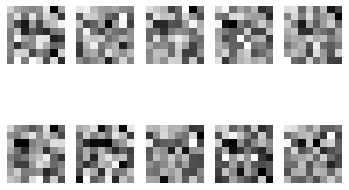

Batch 132/1875 - Opimize G - Avg Batch Loss: 0.8250 - Time : 3.00s
Batch 133/1875 - Opimize D - Avg Batch Loss: 0.8250 - Time : 2.64s
Batch 134/1875 - Opimize G - Avg Batch Loss: 0.9436 - Time : 2.66s
Batch 135/1875 - Opimize G - Avg Batch Loss: 0.7870 - Time : 2.94s
Batch 136/1875 - Opimize G - Avg Batch Loss: 0.8784 - Time : 2.84s
Batch 137/1875 - Opimize G - Avg Batch Loss: 0.7802 - Time : 2.64s
Batch 138/1875 - Opimize G - Avg Batch Loss: 0.9979 - Time : 3.14s
Batch 139/1875 - Opimize D - Avg Batch Loss: 0.9244 - Time : 2.73s
Batch 140/1875 - Opimize G - Avg Batch Loss: 0.9121 - Time : 2.76s
Batch 141/1875 - Opimize G - Avg Batch Loss: 0.9747 - Time : 2.71s


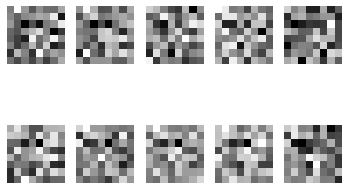

Batch 142/1875 - Opimize G - Avg Batch Loss: 0.9292 - Time : 2.65s
Batch 143/1875 - Opimize G - Avg Batch Loss: 0.8406 - Time : 2.71s
Batch 144/1875 - Opimize G - Avg Batch Loss: 0.8305 - Time : 2.87s
Batch 145/1875 - Opimize D - Avg Batch Loss: 0.9014 - Time : 2.71s
Batch 146/1875 - Opimize G - Avg Batch Loss: 0.9477 - Time : 2.95s
Batch 147/1875 - Opimize G - Avg Batch Loss: 0.8706 - Time : 2.71s
Batch 148/1875 - Opimize G - Avg Batch Loss: 0.8452 - Time : 2.65s
Batch 149/1875 - Opimize G - Avg Batch Loss: 0.8968 - Time : 2.68s
Batch 150/1875 - Opimize G - Avg Batch Loss: 0.8765 - Time : 2.65s
Batch 151/1875 - Opimize D - Avg Batch Loss: 0.9178 - Time : 2.94s


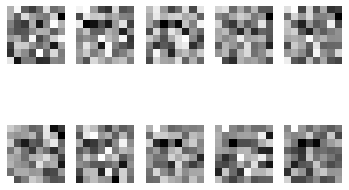

Batch 152/1875 - Opimize G - Avg Batch Loss: 0.8818 - Time : 2.73s
Batch 153/1875 - Opimize G - Avg Batch Loss: 0.8770 - Time : 2.73s
Batch 154/1875 - Opimize G - Avg Batch Loss: 0.8656 - Time : 2.70s
Batch 155/1875 - Opimize G - Avg Batch Loss: 0.9303 - Time : 2.66s
Batch 156/1875 - Opimize G - Avg Batch Loss: 0.7842 - Time : 2.67s
Batch 157/1875 - Opimize D - Avg Batch Loss: 0.8631 - Time : 2.69s
Batch 158/1875 - Opimize G - Avg Batch Loss: 0.9237 - Time : 2.69s
Batch 159/1875 - Opimize G - Avg Batch Loss: 0.6578 - Time : 2.88s
Batch 160/1875 - Opimize G - Avg Batch Loss: 0.7325 - Time : 3.00s
Batch 161/1875 - Opimize G - Avg Batch Loss: 0.7927 - Time : 2.89s


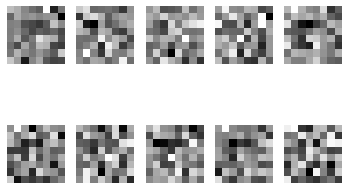

Batch 162/1875 - Opimize G - Avg Batch Loss: 0.8452 - Time : 3.44s
Batch 163/1875 - Opimize D - Avg Batch Loss: 0.9111 - Time : 2.94s
Batch 164/1875 - Opimize G - Avg Batch Loss: 0.7737 - Time : 2.92s
Batch 165/1875 - Opimize G - Avg Batch Loss: 0.8803 - Time : 2.92s
Batch 166/1875 - Opimize G - Avg Batch Loss: 0.7981 - Time : 2.63s
Batch 167/1875 - Opimize G - Avg Batch Loss: 0.9591 - Time : 2.67s
Batch 168/1875 - Opimize G - Avg Batch Loss: 0.8420 - Time : 2.62s
Batch 169/1875 - Opimize D - Avg Batch Loss: 0.7306 - Time : 2.90s
Batch 170/1875 - Opimize G - Avg Batch Loss: 0.7294 - Time : 2.66s
Batch 171/1875 - Opimize G - Avg Batch Loss: 0.8816 - Time : 2.93s


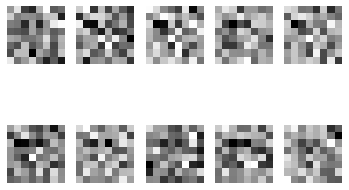

Batch 172/1875 - Opimize G - Avg Batch Loss: 0.7839 - Time : 2.69s
Batch 173/1875 - Opimize G - Avg Batch Loss: 0.7962 - Time : 2.72s
Batch 174/1875 - Opimize G - Avg Batch Loss: 0.7712 - Time : 2.68s
Batch 175/1875 - Opimize D - Avg Batch Loss: 0.7660 - Time : 2.95s
Batch 176/1875 - Opimize G - Avg Batch Loss: 0.8264 - Time : 2.72s
Batch 177/1875 - Opimize G - Avg Batch Loss: 0.8513 - Time : 2.94s
Batch 178/1875 - Opimize G - Avg Batch Loss: 0.6558 - Time : 2.78s
Batch 179/1875 - Opimize G - Avg Batch Loss: 0.7893 - Time : 2.90s
Batch 180/1875 - Opimize G - Avg Batch Loss: 0.7045 - Time : 2.69s
Batch 181/1875 - Opimize D - Avg Batch Loss: 0.7781 - Time : 2.69s


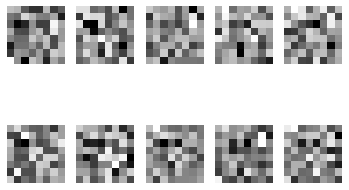

Batch 182/1875 - Opimize G - Avg Batch Loss: 0.8221 - Time : 2.68s
Batch 183/1875 - Opimize G - Avg Batch Loss: 0.7495 - Time : 2.68s
Batch 184/1875 - Opimize G - Avg Batch Loss: 0.7325 - Time : 2.68s
Batch 185/1875 - Opimize G - Avg Batch Loss: 0.6039 - Time : 2.65s
Batch 186/1875 - Opimize G - Avg Batch Loss: 0.6411 - Time : 2.74s
Batch 187/1875 - Opimize D - Avg Batch Loss: 0.9154 - Time : 2.69s
Batch 188/1875 - Opimize G - Avg Batch Loss: 0.5118 - Time : 2.73s
Batch 189/1875 - Opimize G - Avg Batch Loss: 0.6800 - Time : 2.99s
Batch 190/1875 - Opimize G - Avg Batch Loss: 0.6928 - Time : 2.82s
Batch 191/1875 - Opimize G - Avg Batch Loss: 0.6633 - Time : 2.70s


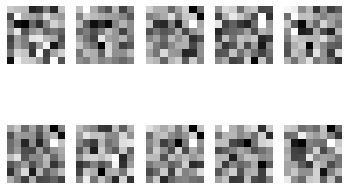

Batch 192/1875 - Opimize G - Avg Batch Loss: 0.6946 - Time : 3.05s
Batch 193/1875 - Opimize D - Avg Batch Loss: 0.6888 - Time : 2.77s
Batch 194/1875 - Opimize G - Avg Batch Loss: 0.6292 - Time : 3.03s
Batch 195/1875 - Opimize G - Avg Batch Loss: 0.7434 - Time : 2.97s
Batch 196/1875 - Opimize G - Avg Batch Loss: 0.7535 - Time : 2.82s
Batch 197/1875 - Opimize G - Avg Batch Loss: 0.5578 - Time : 2.85s
Batch 198/1875 - Opimize G - Avg Batch Loss: 0.6257 - Time : 2.86s
Batch 199/1875 - Opimize D - Avg Batch Loss: 0.7822 - Time : 2.65s
Batch 200/1875 - Opimize G - Avg Batch Loss: 0.5895 - Time : 2.74s
Batch 201/1875 - Opimize G - Avg Batch Loss: 0.5647 - Time : 2.71s


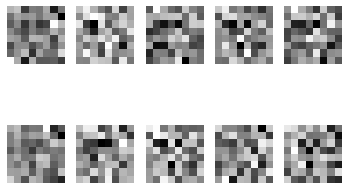

Batch 202/1875 - Opimize G - Avg Batch Loss: 0.6388 - Time : 2.77s
Batch 203/1875 - Opimize G - Avg Batch Loss: 0.6966 - Time : 2.71s
Batch 204/1875 - Opimize G - Avg Batch Loss: 0.7269 - Time : 2.96s
Batch 205/1875 - Opimize D - Avg Batch Loss: 0.6088 - Time : 2.75s
Batch 206/1875 - Opimize G - Avg Batch Loss: 0.7278 - Time : 2.72s
Batch 207/1875 - Opimize G - Avg Batch Loss: 0.5453 - Time : 2.86s
Batch 208/1875 - Opimize G - Avg Batch Loss: 0.5646 - Time : 2.68s
Batch 209/1875 - Opimize G - Avg Batch Loss: 0.5842 - Time : 2.89s
Batch 210/1875 - Opimize G - Avg Batch Loss: 0.6808 - Time : 2.94s
Batch 211/1875 - Opimize D - Avg Batch Loss: 0.5587 - Time : 2.66s


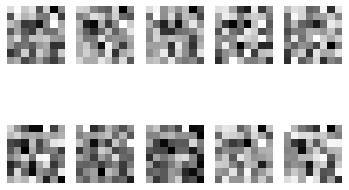

Batch 212/1875 - Opimize G - Avg Batch Loss: 0.6683 - Time : 2.60s
Batch 213/1875 - Opimize G - Avg Batch Loss: 0.6005 - Time : 2.72s
Batch 214/1875 - Opimize G - Avg Batch Loss: 0.6334 - Time : 2.70s
Batch 215/1875 - Opimize G - Avg Batch Loss: 0.6524 - Time : 2.87s
Batch 216/1875 - Opimize G - Avg Batch Loss: 0.6319 - Time : 3.15s
Batch 217/1875 - Opimize D - Avg Batch Loss: 0.6135 - Time : 2.72s
Batch 218/1875 - Opimize G - Avg Batch Loss: 0.5191 - Time : 2.94s
Batch 219/1875 - Opimize G - Avg Batch Loss: 0.5991 - Time : 2.71s
Batch 220/1875 - Opimize G - Avg Batch Loss: 0.5761 - Time : 2.82s
Batch 221/1875 - Opimize G - Avg Batch Loss: 0.5973 - Time : 2.76s


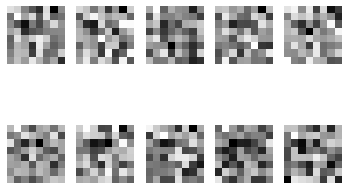

Batch 222/1875 - Opimize G - Avg Batch Loss: 0.5964 - Time : 2.68s
Batch 223/1875 - Opimize D - Avg Batch Loss: 0.6946 - Time : 2.65s
Batch 224/1875 - Opimize G - Avg Batch Loss: 0.7953 - Time : 3.17s
Batch 225/1875 - Opimize G - Avg Batch Loss: 0.5642 - Time : 3.09s
Batch 226/1875 - Opimize G - Avg Batch Loss: 0.5810 - Time : 2.92s
Batch 227/1875 - Opimize G - Avg Batch Loss: 0.5007 - Time : 2.66s
Batch 228/1875 - Opimize G - Avg Batch Loss: 0.6575 - Time : 2.80s
Batch 229/1875 - Opimize D - Avg Batch Loss: 0.7993 - Time : 2.73s
Batch 230/1875 - Opimize G - Avg Batch Loss: 0.4633 - Time : 2.95s
Batch 231/1875 - Opimize G - Avg Batch Loss: 0.4137 - Time : 2.93s


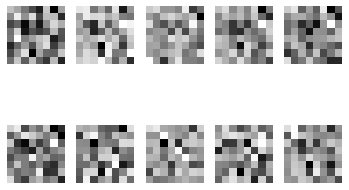

Batch 232/1875 - Opimize G - Avg Batch Loss: 0.5131 - Time : 2.76s
Batch 233/1875 - Opimize G - Avg Batch Loss: 0.5219 - Time : 3.03s
Batch 234/1875 - Opimize G - Avg Batch Loss: 0.5815 - Time : 2.75s
Batch 235/1875 - Opimize D - Avg Batch Loss: 0.5278 - Time : 3.15s
Batch 236/1875 - Opimize G - Avg Batch Loss: 0.5732 - Time : 2.82s
Batch 237/1875 - Opimize G - Avg Batch Loss: 0.5539 - Time : 2.71s
Batch 238/1875 - Opimize G - Avg Batch Loss: 0.4844 - Time : 2.68s
Batch 239/1875 - Opimize G - Avg Batch Loss: 0.6224 - Time : 2.97s
Batch 240/1875 - Opimize G - Avg Batch Loss: 0.6286 - Time : 2.75s
Batch 241/1875 - Opimize D - Avg Batch Loss: 0.5083 - Time : 2.76s


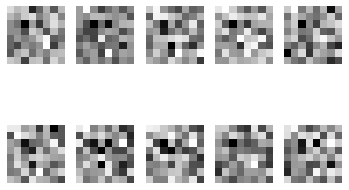

Batch 242/1875 - Opimize G - Avg Batch Loss: 0.5975 - Time : 2.97s
Batch 243/1875 - Opimize G - Avg Batch Loss: 0.4522 - Time : 2.71s
Batch 244/1875 - Opimize G - Avg Batch Loss: 0.4764 - Time : 3.13s
Batch 245/1875 - Opimize G - Avg Batch Loss: 0.5140 - Time : 2.70s
Batch 246/1875 - Opimize G - Avg Batch Loss: 0.4705 - Time : 2.86s
Batch 247/1875 - Opimize D - Avg Batch Loss: 0.4105 - Time : 2.83s
Batch 248/1875 - Opimize G - Avg Batch Loss: 0.3817 - Time : 2.94s
Batch 249/1875 - Opimize G - Avg Batch Loss: 0.4584 - Time : 2.77s
Batch 250/1875 - Opimize G - Avg Batch Loss: 0.3507 - Time : 2.76s
Batch 251/1875 - Opimize G - Avg Batch Loss: 0.3645 - Time : 2.91s


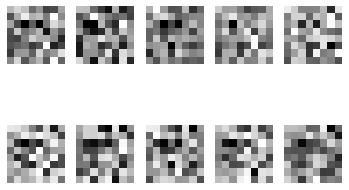

Batch 252/1875 - Opimize G - Avg Batch Loss: 0.5533 - Time : 2.65s
Batch 253/1875 - Opimize D - Avg Batch Loss: 0.3306 - Time : 3.12s
Batch 254/1875 - Opimize G - Avg Batch Loss: 0.4082 - Time : 2.62s
Batch 255/1875 - Opimize G - Avg Batch Loss: 0.4169 - Time : 2.74s
Batch 256/1875 - Opimize G - Avg Batch Loss: 0.6430 - Time : 2.97s
Batch 257/1875 - Opimize G - Avg Batch Loss: 0.3749 - Time : 2.72s
Batch 258/1875 - Opimize G - Avg Batch Loss: 0.3542 - Time : 2.67s
Batch 259/1875 - Opimize D - Avg Batch Loss: 0.4393 - Time : 2.97s
Batch 260/1875 - Opimize G - Avg Batch Loss: 0.3970 - Time : 2.91s
Batch 261/1875 - Opimize G - Avg Batch Loss: 0.5008 - Time : 3.02s


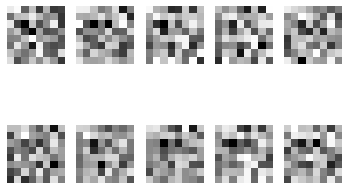

Batch 262/1875 - Opimize G - Avg Batch Loss: 0.4516 - Time : 2.84s
Batch 263/1875 - Opimize G - Avg Batch Loss: 0.4289 - Time : 2.73s
Batch 264/1875 - Opimize G - Avg Batch Loss: 0.4759 - Time : 2.98s
Batch 265/1875 - Opimize D - Avg Batch Loss: 0.3427 - Time : 2.80s
Batch 266/1875 - Opimize G - Avg Batch Loss: 0.4468 - Time : 2.75s
Batch 267/1875 - Opimize G - Avg Batch Loss: 0.2490 - Time : 2.69s
Batch 268/1875 - Opimize G - Avg Batch Loss: 0.3419 - Time : 2.94s
Batch 269/1875 - Opimize G - Avg Batch Loss: 0.4104 - Time : 2.74s
Batch 270/1875 - Opimize G - Avg Batch Loss: 0.4587 - Time : 2.69s
Batch 271/1875 - Opimize D - Avg Batch Loss: 0.4174 - Time : 2.77s


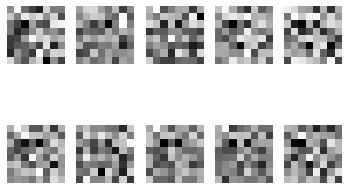

Batch 272/1875 - Opimize G - Avg Batch Loss: 0.4613 - Time : 2.66s
Batch 273/1875 - Opimize G - Avg Batch Loss: 0.4201 - Time : 2.64s
Batch 274/1875 - Opimize G - Avg Batch Loss: 0.3735 - Time : 2.72s
Batch 275/1875 - Opimize G - Avg Batch Loss: 0.5553 - Time : 2.87s
Batch 276/1875 - Opimize G - Avg Batch Loss: 0.4211 - Time : 2.73s
Batch 277/1875 - Opimize D - Avg Batch Loss: 0.4494 - Time : 3.14s
Batch 278/1875 - Opimize G - Avg Batch Loss: 0.4297 - Time : 2.75s
Batch 279/1875 - Opimize G - Avg Batch Loss: 0.4311 - Time : 3.14s
Batch 280/1875 - Opimize G - Avg Batch Loss: 0.3762 - Time : 2.68s
Batch 281/1875 - Opimize G - Avg Batch Loss: 0.5081 - Time : 2.98s


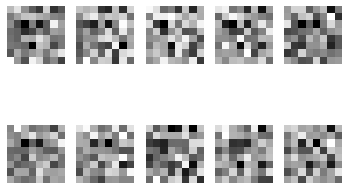

Batch 282/1875 - Opimize G - Avg Batch Loss: 0.4585 - Time : 2.82s
Batch 283/1875 - Opimize D - Avg Batch Loss: 0.3009 - Time : 2.70s
Batch 284/1875 - Opimize G - Avg Batch Loss: 0.3668 - Time : 2.68s
Batch 285/1875 - Opimize G - Avg Batch Loss: 0.4739 - Time : 2.95s
Batch 286/1875 - Opimize G - Avg Batch Loss: 0.2749 - Time : 2.66s
Batch 287/1875 - Opimize G - Avg Batch Loss: 0.3461 - Time : 2.73s
Batch 288/1875 - Opimize G - Avg Batch Loss: 0.3808 - Time : 2.68s
Batch 289/1875 - Opimize D - Avg Batch Loss: 0.3804 - Time : 2.72s
Batch 290/1875 - Opimize G - Avg Batch Loss: 0.4049 - Time : 2.79s
Batch 291/1875 - Opimize G - Avg Batch Loss: 0.4436 - Time : 2.88s


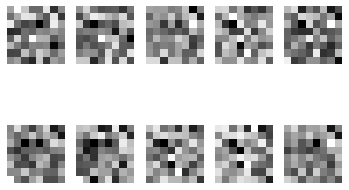

Batch 292/1875 - Opimize G - Avg Batch Loss: 0.3716 - Time : 2.76s
Batch 293/1875 - Opimize G - Avg Batch Loss: 0.3385 - Time : 2.66s
Batch 294/1875 - Opimize G - Avg Batch Loss: 0.5062 - Time : 2.92s
Batch 295/1875 - Opimize D - Avg Batch Loss: 0.5568 - Time : 2.67s
Batch 296/1875 - Opimize G - Avg Batch Loss: 0.4282 - Time : 2.70s
Batch 297/1875 - Opimize G - Avg Batch Loss: 0.2986 - Time : 2.67s
Batch 298/1875 - Opimize G - Avg Batch Loss: 0.3121 - Time : 2.72s
Batch 299/1875 - Opimize G - Avg Batch Loss: 0.3763 - Time : 2.89s
Batch 300/1875 - Opimize G - Avg Batch Loss: 0.4631 - Time : 2.92s
Batch 301/1875 - Opimize D - Avg Batch Loss: 0.3509 - Time : 2.91s


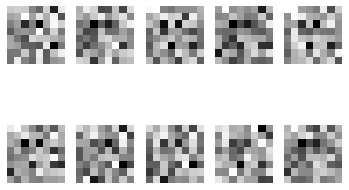

Batch 302/1875 - Opimize G - Avg Batch Loss: 0.3985 - Time : 2.77s
Batch 303/1875 - Opimize G - Avg Batch Loss: 0.2912 - Time : 2.86s
Batch 304/1875 - Opimize G - Avg Batch Loss: 0.3298 - Time : 2.70s
Batch 305/1875 - Opimize G - Avg Batch Loss: 0.3073 - Time : 2.66s
Batch 306/1875 - Opimize G - Avg Batch Loss: 0.3521 - Time : 2.68s
Batch 307/1875 - Opimize D - Avg Batch Loss: 0.4193 - Time : 2.68s
Batch 308/1875 - Opimize G - Avg Batch Loss: 0.3358 - Time : 2.67s
Batch 309/1875 - Opimize G - Avg Batch Loss: 0.4759 - Time : 2.88s
Batch 310/1875 - Opimize G - Avg Batch Loss: 0.4624 - Time : 2.90s
Batch 311/1875 - Opimize G - Avg Batch Loss: 0.4349 - Time : 2.67s


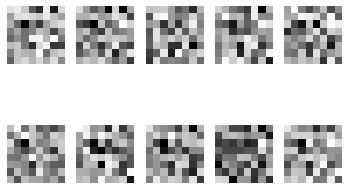

Batch 312/1875 - Opimize G - Avg Batch Loss: 0.4806 - Time : 3.16s
Batch 313/1875 - Opimize D - Avg Batch Loss: 0.4227 - Time : 2.75s
Batch 314/1875 - Opimize G - Avg Batch Loss: 0.3749 - Time : 2.95s
Batch 315/1875 - Opimize G - Avg Batch Loss: 0.4274 - Time : 2.98s
Batch 316/1875 - Opimize G - Avg Batch Loss: 0.3784 - Time : 2.71s
Batch 317/1875 - Opimize G - Avg Batch Loss: 0.3534 - Time : 2.93s
Batch 318/1875 - Opimize G - Avg Batch Loss: 0.4548 - Time : 2.93s
Batch 319/1875 - Opimize D - Avg Batch Loss: 0.3255 - Time : 2.84s
Batch 320/1875 - Opimize G - Avg Batch Loss: 0.4034 - Time : 2.70s
Batch 321/1875 - Opimize G - Avg Batch Loss: 0.3559 - Time : 2.68s


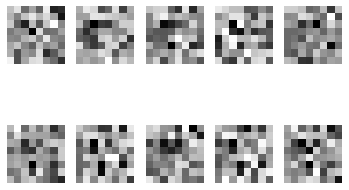

Batch 322/1875 - Opimize G - Avg Batch Loss: 0.3135 - Time : 2.67s
Batch 323/1875 - Opimize G - Avg Batch Loss: 0.3936 - Time : 2.69s
Batch 324/1875 - Opimize G - Avg Batch Loss: 0.3866 - Time : 2.66s
Batch 325/1875 - Opimize D - Avg Batch Loss: 0.2861 - Time : 2.93s
Batch 326/1875 - Opimize G - Avg Batch Loss: 0.3502 - Time : 2.75s
Batch 327/1875 - Opimize G - Avg Batch Loss: 0.2596 - Time : 2.86s
Batch 328/1875 - Opimize G - Avg Batch Loss: 0.5235 - Time : 2.99s
Batch 329/1875 - Opimize G - Avg Batch Loss: 0.3575 - Time : 2.86s
Batch 330/1875 - Opimize G - Avg Batch Loss: 0.4256 - Time : 2.74s
Batch 331/1875 - Opimize D - Avg Batch Loss: 0.4376 - Time : 2.87s


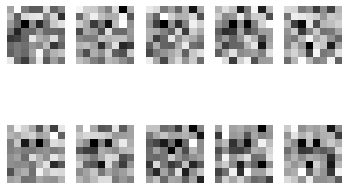

Batch 332/1875 - Opimize G - Avg Batch Loss: 0.3026 - Time : 2.74s
Batch 333/1875 - Opimize G - Avg Batch Loss: 0.3614 - Time : 2.68s
Batch 334/1875 - Opimize G - Avg Batch Loss: 0.3411 - Time : 2.74s
Batch 335/1875 - Opimize G - Avg Batch Loss: 0.3711 - Time : 2.68s
Batch 336/1875 - Opimize G - Avg Batch Loss: 0.4162 - Time : 2.76s
Batch 337/1875 - Opimize D - Avg Batch Loss: 0.3213 - Time : 2.69s
Batch 338/1875 - Opimize G - Avg Batch Loss: 0.3290 - Time : 2.67s
Batch 339/1875 - Opimize G - Avg Batch Loss: 0.3379 - Time : 2.66s
Batch 340/1875 - Opimize G - Avg Batch Loss: 0.4494 - Time : 2.73s
Batch 341/1875 - Opimize G - Avg Batch Loss: 0.3632 - Time : 2.82s


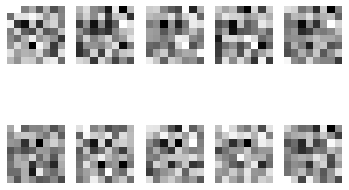

Batch 342/1875 - Opimize G - Avg Batch Loss: 0.3566 - Time : 2.88s
Batch 343/1875 - Opimize D - Avg Batch Loss: 0.3118 - Time : 2.76s
Batch 344/1875 - Opimize G - Avg Batch Loss: 0.3848 - Time : 2.71s
Batch 345/1875 - Opimize G - Avg Batch Loss: 0.3394 - Time : 2.78s
Batch 346/1875 - Opimize G - Avg Batch Loss: 0.3478 - Time : 2.77s
Batch 347/1875 - Opimize G - Avg Batch Loss: 0.2669 - Time : 2.72s
Batch 348/1875 - Opimize G - Avg Batch Loss: 0.2807 - Time : 2.95s
Batch 349/1875 - Opimize D - Avg Batch Loss: 0.4368 - Time : 2.67s
Batch 350/1875 - Opimize G - Avg Batch Loss: 0.3072 - Time : 2.62s
Batch 351/1875 - Opimize G - Avg Batch Loss: 0.2826 - Time : 2.93s


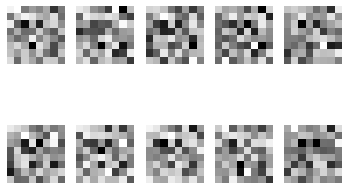

Batch 352/1875 - Opimize G - Avg Batch Loss: 0.3425 - Time : 2.77s
Batch 353/1875 - Opimize G - Avg Batch Loss: 0.3090 - Time : 2.74s
Batch 354/1875 - Opimize G - Avg Batch Loss: 0.3180 - Time : 2.69s
Batch 355/1875 - Opimize D - Avg Batch Loss: 0.2898 - Time : 2.98s
Batch 356/1875 - Opimize G - Avg Batch Loss: 0.2552 - Time : 2.71s
Batch 357/1875 - Opimize G - Avg Batch Loss: 0.4449 - Time : 3.13s
Batch 358/1875 - Opimize G - Avg Batch Loss: 0.2841 - Time : 2.67s
Batch 359/1875 - Opimize G - Avg Batch Loss: 0.4089 - Time : 2.69s
Batch 360/1875 - Opimize G - Avg Batch Loss: 0.3329 - Time : 2.91s
Batch 361/1875 - Opimize D - Avg Batch Loss: 0.3467 - Time : 2.68s


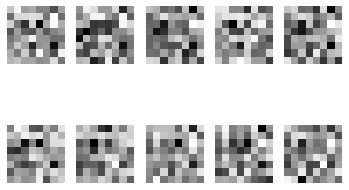

Batch 362/1875 - Opimize G - Avg Batch Loss: 0.3478 - Time : 3.50s
Batch 363/1875 - Opimize G - Avg Batch Loss: 0.4109 - Time : 2.73s
Batch 364/1875 - Opimize G - Avg Batch Loss: 0.3667 - Time : 2.76s
Batch 365/1875 - Opimize G - Avg Batch Loss: 0.3183 - Time : 2.82s
Batch 366/1875 - Opimize G - Avg Batch Loss: 0.3259 - Time : 2.83s
Batch 367/1875 - Opimize D - Avg Batch Loss: 0.2567 - Time : 2.69s
Batch 368/1875 - Opimize G - Avg Batch Loss: 0.3337 - Time : 2.69s
Batch 369/1875 - Opimize G - Avg Batch Loss: 0.4187 - Time : 2.93s
Batch 370/1875 - Opimize G - Avg Batch Loss: 0.3035 - Time : 2.65s
Batch 371/1875 - Opimize G - Avg Batch Loss: 0.3117 - Time : 2.75s


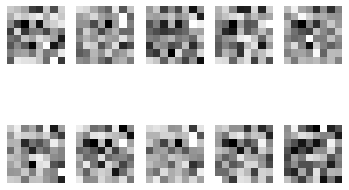

Batch 372/1875 - Opimize G - Avg Batch Loss: 0.4096 - Time : 2.68s
Batch 373/1875 - Opimize D - Avg Batch Loss: 0.3927 - Time : 2.95s
Batch 374/1875 - Opimize G - Avg Batch Loss: 0.2812 - Time : 3.00s
Batch 375/1875 - Opimize G - Avg Batch Loss: 0.3479 - Time : 2.74s
Batch 376/1875 - Opimize G - Avg Batch Loss: 0.3530 - Time : 2.83s
Batch 377/1875 - Opimize G - Avg Batch Loss: 0.4028 - Time : 2.70s
Batch 378/1875 - Opimize G - Avg Batch Loss: 0.2564 - Time : 2.96s
Batch 379/1875 - Opimize D - Avg Batch Loss: 0.2777 - Time : 2.90s
Batch 380/1875 - Opimize G - Avg Batch Loss: 0.3146 - Time : 2.66s
Batch 381/1875 - Opimize G - Avg Batch Loss: 0.3351 - Time : 2.67s


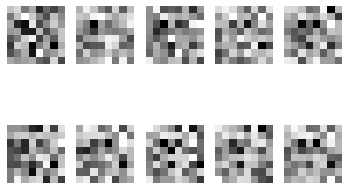

Batch 382/1875 - Opimize G - Avg Batch Loss: 0.3335 - Time : 2.90s
Batch 383/1875 - Opimize G - Avg Batch Loss: 0.3678 - Time : 2.71s
Batch 384/1875 - Opimize G - Avg Batch Loss: 0.2887 - Time : 2.71s
Batch 385/1875 - Opimize D - Avg Batch Loss: 0.2774 - Time : 2.68s
Batch 386/1875 - Opimize G - Avg Batch Loss: 0.3301 - Time : 2.69s
Batch 387/1875 - Opimize G - Avg Batch Loss: 0.3226 - Time : 2.74s
Batch 388/1875 - Opimize G - Avg Batch Loss: 0.2530 - Time : 2.72s
Batch 389/1875 - Opimize G - Avg Batch Loss: 0.3563 - Time : 2.68s
Batch 390/1875 - Opimize G - Avg Batch Loss: 0.3201 - Time : 2.76s
Batch 391/1875 - Opimize D - Avg Batch Loss: 0.4217 - Time : 2.74s


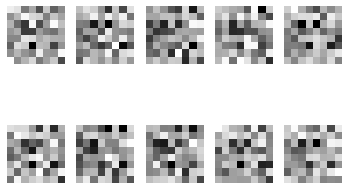

Batch 392/1875 - Opimize G - Avg Batch Loss: 0.3478 - Time : 2.94s
Batch 393/1875 - Opimize G - Avg Batch Loss: 0.2819 - Time : 2.64s
Batch 394/1875 - Opimize G - Avg Batch Loss: 0.4516 - Time : 2.74s
Batch 395/1875 - Opimize G - Avg Batch Loss: 0.2784 - Time : 2.95s
Batch 396/1875 - Opimize G - Avg Batch Loss: 0.3699 - Time : 2.75s
Batch 397/1875 - Opimize D - Avg Batch Loss: 0.2776 - Time : 2.92s
Batch 398/1875 - Opimize G - Avg Batch Loss: 0.3869 - Time : 2.74s
Batch 399/1875 - Opimize G - Avg Batch Loss: 0.3512 - Time : 2.79s
Batch 400/1875 - Opimize G - Avg Batch Loss: 0.3878 - Time : 2.62s
Batch 401/1875 - Opimize G - Avg Batch Loss: 0.3514 - Time : 2.64s


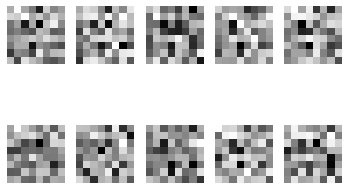

Batch 402/1875 - Opimize G - Avg Batch Loss: 0.2476 - Time : 2.73s
Batch 403/1875 - Opimize D - Avg Batch Loss: 0.3356 - Time : 2.67s
Batch 404/1875 - Opimize G - Avg Batch Loss: 0.3236 - Time : 2.90s
Batch 405/1875 - Opimize G - Avg Batch Loss: 0.2892 - Time : 2.67s
Batch 406/1875 - Opimize G - Avg Batch Loss: 0.2911 - Time : 2.92s
Batch 407/1875 - Opimize G - Avg Batch Loss: 0.4862 - Time : 2.75s
Batch 408/1875 - Opimize G - Avg Batch Loss: 0.3677 - Time : 2.66s
Batch 409/1875 - Opimize D - Avg Batch Loss: 0.1985 - Time : 2.65s
Batch 410/1875 - Opimize G - Avg Batch Loss: 0.2237 - Time : 2.68s
Batch 411/1875 - Opimize G - Avg Batch Loss: 0.2683 - Time : 2.71s


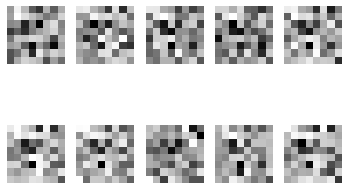

Batch 412/1875 - Opimize G - Avg Batch Loss: 0.2829 - Time : 2.70s
Batch 413/1875 - Opimize G - Avg Batch Loss: 0.3160 - Time : 3.12s
Batch 414/1875 - Opimize G - Avg Batch Loss: 0.2177 - Time : 2.76s
Batch 415/1875 - Opimize D - Avg Batch Loss: 0.3680 - Time : 2.91s
Batch 416/1875 - Opimize G - Avg Batch Loss: 0.2959 - Time : 2.65s
Batch 417/1875 - Opimize G - Avg Batch Loss: 0.4430 - Time : 2.72s
Batch 418/1875 - Opimize G - Avg Batch Loss: 0.3370 - Time : 3.07s
Batch 419/1875 - Opimize G - Avg Batch Loss: 0.2467 - Time : 2.83s
Batch 420/1875 - Opimize G - Avg Batch Loss: 0.2456 - Time : 3.05s
Batch 421/1875 - Opimize D - Avg Batch Loss: 0.2901 - Time : 2.70s


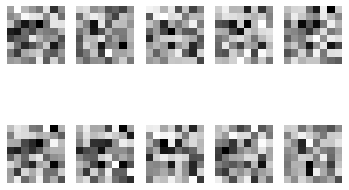

Batch 422/1875 - Opimize G - Avg Batch Loss: 0.3954 - Time : 2.71s
Batch 423/1875 - Opimize G - Avg Batch Loss: 0.3428 - Time : 2.92s
Batch 424/1875 - Opimize G - Avg Batch Loss: 0.3223 - Time : 2.94s
Batch 425/1875 - Opimize G - Avg Batch Loss: 0.2320 - Time : 2.64s
Batch 426/1875 - Opimize G - Avg Batch Loss: 0.2747 - Time : 2.71s
Batch 427/1875 - Opimize D - Avg Batch Loss: 0.3456 - Time : 2.89s
Batch 428/1875 - Opimize G - Avg Batch Loss: 0.3230 - Time : 2.73s
Batch 429/1875 - Opimize G - Avg Batch Loss: 0.3737 - Time : 2.67s
Batch 430/1875 - Opimize G - Avg Batch Loss: 0.3861 - Time : 2.71s
Batch 431/1875 - Opimize G - Avg Batch Loss: 0.4225 - Time : 2.65s


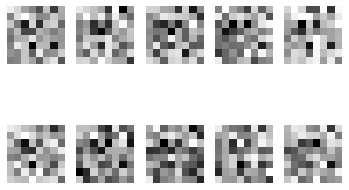

Batch 432/1875 - Opimize G - Avg Batch Loss: 0.3783 - Time : 2.72s
Batch 433/1875 - Opimize D - Avg Batch Loss: 0.2906 - Time : 2.88s
Batch 434/1875 - Opimize G - Avg Batch Loss: 0.3716 - Time : 2.95s
Batch 435/1875 - Opimize G - Avg Batch Loss: 0.3461 - Time : 3.12s
Batch 436/1875 - Opimize G - Avg Batch Loss: 0.3090 - Time : 2.69s
Batch 437/1875 - Opimize G - Avg Batch Loss: 0.4387 - Time : 2.86s
Batch 438/1875 - Opimize G - Avg Batch Loss: 0.2709 - Time : 3.09s
Batch 439/1875 - Opimize D - Avg Batch Loss: 0.2897 - Time : 2.84s
Batch 440/1875 - Opimize G - Avg Batch Loss: 0.2910 - Time : 3.07s
Batch 441/1875 - Opimize G - Avg Batch Loss: 0.3235 - Time : 2.93s


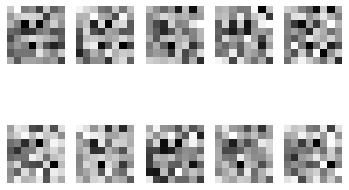

Batch 442/1875 - Opimize G - Avg Batch Loss: 0.3213 - Time : 2.86s
Batch 443/1875 - Opimize G - Avg Batch Loss: 0.4382 - Time : 2.64s
Batch 444/1875 - Opimize G - Avg Batch Loss: 0.2803 - Time : 2.85s
Batch 445/1875 - Opimize D - Avg Batch Loss: 0.3887 - Time : 2.95s
Batch 446/1875 - Opimize G - Avg Batch Loss: 0.4486 - Time : 2.84s
Batch 447/1875 - Opimize G - Avg Batch Loss: 0.3078 - Time : 2.71s
Batch 448/1875 - Opimize G - Avg Batch Loss: 0.3502 - Time : 3.06s
Batch 449/1875 - Opimize G - Avg Batch Loss: 0.3811 - Time : 2.83s
Batch 450/1875 - Opimize G - Avg Batch Loss: 0.3109 - Time : 3.06s
Batch 451/1875 - Opimize D - Avg Batch Loss: 0.3289 - Time : 2.66s


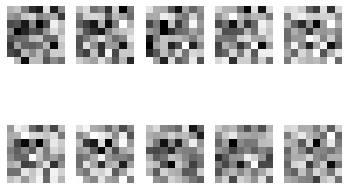

Batch 452/1875 - Opimize G - Avg Batch Loss: 0.3736 - Time : 2.91s
Batch 453/1875 - Opimize G - Avg Batch Loss: 0.3845 - Time : 2.92s
Batch 454/1875 - Opimize G - Avg Batch Loss: 0.3779 - Time : 2.72s
Batch 455/1875 - Opimize G - Avg Batch Loss: 0.3422 - Time : 2.70s
Batch 456/1875 - Opimize G - Avg Batch Loss: 0.3212 - Time : 2.92s
Batch 457/1875 - Opimize D - Avg Batch Loss: 0.2498 - Time : 2.85s
Batch 458/1875 - Opimize G - Avg Batch Loss: 0.3054 - Time : 2.73s
Batch 459/1875 - Opimize G - Avg Batch Loss: 0.4333 - Time : 3.10s
Batch 460/1875 - Opimize G - Avg Batch Loss: 0.4074 - Time : 2.96s
Batch 461/1875 - Opimize G - Avg Batch Loss: 0.3076 - Time : 2.81s


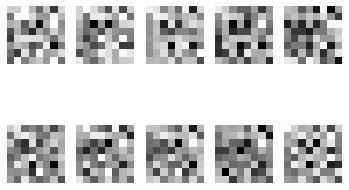

Batch 462/1875 - Opimize G - Avg Batch Loss: 0.3656 - Time : 2.69s
Batch 463/1875 - Opimize D - Avg Batch Loss: 0.2444 - Time : 2.66s
Batch 464/1875 - Opimize G - Avg Batch Loss: 0.2528 - Time : 2.73s
Batch 465/1875 - Opimize G - Avg Batch Loss: 0.3848 - Time : 2.71s
Batch 466/1875 - Opimize G - Avg Batch Loss: 0.3408 - Time : 2.90s
Batch 467/1875 - Opimize G - Avg Batch Loss: 0.2849 - Time : 2.89s
Batch 468/1875 - Opimize G - Avg Batch Loss: 0.4852 - Time : 2.97s
Batch 469/1875 - Opimize D - Avg Batch Loss: 0.3713 - Time : 2.87s
Batch 470/1875 - Opimize G - Avg Batch Loss: 0.3610 - Time : 2.92s
Batch 471/1875 - Opimize G - Avg Batch Loss: 0.3326 - Time : 2.89s


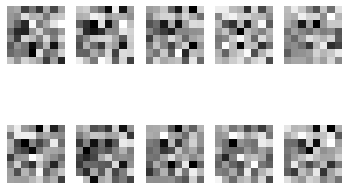

Batch 472/1875 - Opimize G - Avg Batch Loss: 0.3799 - Time : 2.71s
Batch 473/1875 - Opimize G - Avg Batch Loss: 0.3670 - Time : 2.66s
Batch 474/1875 - Opimize G - Avg Batch Loss: 0.2732 - Time : 2.63s
Batch 475/1875 - Opimize D - Avg Batch Loss: 0.3286 - Time : 2.87s
Batch 476/1875 - Opimize G - Avg Batch Loss: 0.3614 - Time : 2.68s
Batch 477/1875 - Opimize G - Avg Batch Loss: 0.3790 - Time : 2.61s
Batch 478/1875 - Opimize G - Avg Batch Loss: 0.3950 - Time : 2.64s
Batch 479/1875 - Opimize G - Avg Batch Loss: 0.2902 - Time : 2.68s
Batch 480/1875 - Opimize G - Avg Batch Loss: 0.3087 - Time : 2.66s
Batch 481/1875 - Opimize D - Avg Batch Loss: 0.2456 - Time : 2.92s


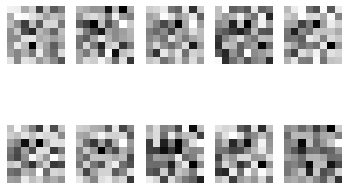

Batch 482/1875 - Opimize G - Avg Batch Loss: 0.4106 - Time : 3.00s
Batch 483/1875 - Opimize G - Avg Batch Loss: 0.3916 - Time : 2.90s
Batch 484/1875 - Opimize G - Avg Batch Loss: 0.3114 - Time : 2.74s
Batch 485/1875 - Opimize G - Avg Batch Loss: 0.3003 - Time : 2.73s
Batch 486/1875 - Opimize G - Avg Batch Loss: 0.3403 - Time : 2.74s
Batch 487/1875 - Opimize D - Avg Batch Loss: 0.3757 - Time : 2.91s
Batch 488/1875 - Opimize G - Avg Batch Loss: 0.3137 - Time : 2.84s
Batch 489/1875 - Opimize G - Avg Batch Loss: 0.2709 - Time : 2.87s
Batch 490/1875 - Opimize G - Avg Batch Loss: 0.3536 - Time : 3.01s
Batch 491/1875 - Opimize G - Avg Batch Loss: 0.2389 - Time : 2.73s


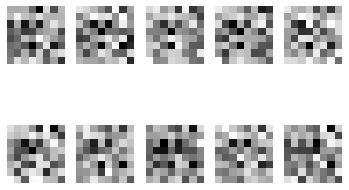

Batch 492/1875 - Opimize G - Avg Batch Loss: 0.2785 - Time : 2.93s
Batch 493/1875 - Opimize D - Avg Batch Loss: 0.2548 - Time : 2.83s
Batch 494/1875 - Opimize G - Avg Batch Loss: 0.2935 - Time : 2.97s
Batch 495/1875 - Opimize G - Avg Batch Loss: 0.4271 - Time : 2.89s
Batch 496/1875 - Opimize G - Avg Batch Loss: 0.3676 - Time : 3.15s
Batch 497/1875 - Opimize G - Avg Batch Loss: 0.4287 - Time : 2.71s
Batch 498/1875 - Opimize G - Avg Batch Loss: 0.3635 - Time : 3.19s
Batch 499/1875 - Opimize D - Avg Batch Loss: 0.3516 - Time : 2.87s
Batch 500/1875 - Opimize G - Avg Batch Loss: 0.3820 - Time : 2.87s
Batch 501/1875 - Opimize G - Avg Batch Loss: 0.2994 - Time : 2.66s


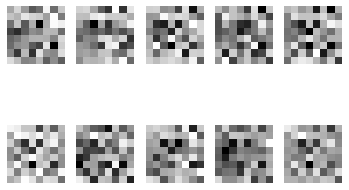

Batch 502/1875 - Opimize G - Avg Batch Loss: 0.2628 - Time : 3.04s
Batch 503/1875 - Opimize G - Avg Batch Loss: 0.3596 - Time : 2.67s
Batch 504/1875 - Opimize G - Avg Batch Loss: 0.3159 - Time : 2.79s
Batch 505/1875 - Opimize D - Avg Batch Loss: 0.4317 - Time : 2.86s
Batch 506/1875 - Opimize G - Avg Batch Loss: 0.3528 - Time : 2.94s
Batch 507/1875 - Opimize G - Avg Batch Loss: 0.3668 - Time : 2.88s
Batch 508/1875 - Opimize G - Avg Batch Loss: 0.3800 - Time : 2.99s
Batch 509/1875 - Opimize G - Avg Batch Loss: 0.2926 - Time : 2.78s
Batch 510/1875 - Opimize G - Avg Batch Loss: 0.4624 - Time : 3.07s
Batch 511/1875 - Opimize D - Avg Batch Loss: 0.2792 - Time : 2.77s


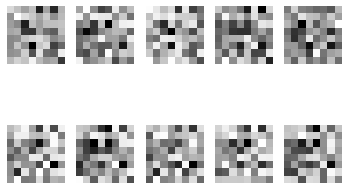

Batch 512/1875 - Opimize G - Avg Batch Loss: 0.4787 - Time : 2.98s
Batch 513/1875 - Opimize G - Avg Batch Loss: 0.3377 - Time : 2.90s
Batch 514/1875 - Opimize G - Avg Batch Loss: 0.2385 - Time : 2.95s
Batch 515/1875 - Opimize G - Avg Batch Loss: 0.3407 - Time : 3.04s
Batch 516/1875 - Opimize G - Avg Batch Loss: 0.2756 - Time : 2.98s
Batch 517/1875 - Opimize D - Avg Batch Loss: 0.4488 - Time : 2.66s
Batch 518/1875 - Opimize G - Avg Batch Loss: 0.3723 - Time : 2.76s
Batch 519/1875 - Opimize G - Avg Batch Loss: 0.3185 - Time : 2.89s
Batch 520/1875 - Opimize G - Avg Batch Loss: 0.2820 - Time : 2.71s
Batch 521/1875 - Opimize G - Avg Batch Loss: 0.4041 - Time : 2.68s


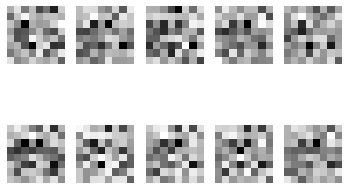

Batch 522/1875 - Opimize G - Avg Batch Loss: 0.2801 - Time : 2.86s
Batch 523/1875 - Opimize D - Avg Batch Loss: 0.4264 - Time : 2.88s
Batch 524/1875 - Opimize G - Avg Batch Loss: 0.3724 - Time : 3.07s
Batch 525/1875 - Opimize G - Avg Batch Loss: 0.3634 - Time : 2.78s
Batch 526/1875 - Opimize G - Avg Batch Loss: 0.4306 - Time : 2.72s
Batch 527/1875 - Opimize G - Avg Batch Loss: 0.4357 - Time : 2.65s
Batch 528/1875 - Opimize G - Avg Batch Loss: 0.3777 - Time : 2.78s
Batch 529/1875 - Opimize D - Avg Batch Loss: 0.3783 - Time : 3.02s
Batch 530/1875 - Opimize G - Avg Batch Loss: 0.3822 - Time : 2.99s
Batch 531/1875 - Opimize G - Avg Batch Loss: 0.4037 - Time : 3.08s


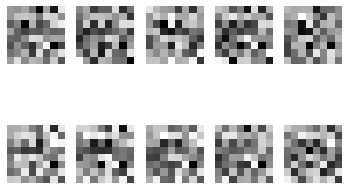

Batch 532/1875 - Opimize G - Avg Batch Loss: 0.3828 - Time : 2.90s
Batch 533/1875 - Opimize G - Avg Batch Loss: 0.3149 - Time : 3.06s
Batch 534/1875 - Opimize G - Avg Batch Loss: 0.3449 - Time : 2.69s
Batch 535/1875 - Opimize D - Avg Batch Loss: 0.3218 - Time : 2.80s
Batch 536/1875 - Opimize G - Avg Batch Loss: 0.3386 - Time : 2.74s
Batch 537/1875 - Opimize G - Avg Batch Loss: 0.3898 - Time : 2.64s
Batch 538/1875 - Opimize G - Avg Batch Loss: 0.3387 - Time : 2.66s
Batch 539/1875 - Opimize G - Avg Batch Loss: 0.3200 - Time : 2.85s
Batch 540/1875 - Opimize G - Avg Batch Loss: 0.2944 - Time : 3.03s
Batch 541/1875 - Opimize D - Avg Batch Loss: 0.3391 - Time : 2.64s


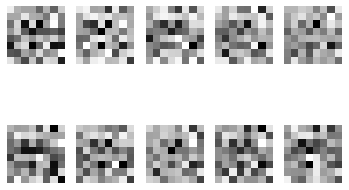

Batch 542/1875 - Opimize G - Avg Batch Loss: 0.3611 - Time : 2.90s
Batch 543/1875 - Opimize G - Avg Batch Loss: 0.4161 - Time : 3.19s
Batch 544/1875 - Opimize G - Avg Batch Loss: 0.3479 - Time : 2.77s
Batch 545/1875 - Opimize G - Avg Batch Loss: 0.2990 - Time : 3.26s
Batch 546/1875 - Opimize G - Avg Batch Loss: 0.2920 - Time : 2.98s
Batch 547/1875 - Opimize D - Avg Batch Loss: 0.3898 - Time : 2.71s
Batch 548/1875 - Opimize G - Avg Batch Loss: 0.3638 - Time : 2.93s
Batch 549/1875 - Opimize G - Avg Batch Loss: 0.4931 - Time : 2.64s
Batch 550/1875 - Opimize G - Avg Batch Loss: 0.3471 - Time : 2.92s
Batch 551/1875 - Opimize G - Avg Batch Loss: 0.3586 - Time : 3.07s


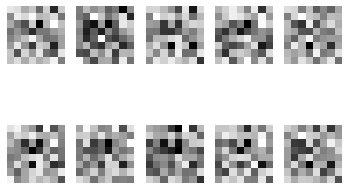

Batch 552/1875 - Opimize G - Avg Batch Loss: 0.4361 - Time : 2.63s
Batch 553/1875 - Opimize D - Avg Batch Loss: 0.3074 - Time : 3.13s
Batch 554/1875 - Opimize G - Avg Batch Loss: 0.3781 - Time : 2.62s
Batch 555/1875 - Opimize G - Avg Batch Loss: 0.3527 - Time : 2.84s
Batch 556/1875 - Opimize G - Avg Batch Loss: 0.4324 - Time : 3.08s
Batch 557/1875 - Opimize G - Avg Batch Loss: 0.4093 - Time : 2.97s
Batch 558/1875 - Opimize G - Avg Batch Loss: 0.3395 - Time : 2.70s
Batch 559/1875 - Opimize D - Avg Batch Loss: 0.3939 - Time : 2.65s
Batch 560/1875 - Opimize G - Avg Batch Loss: 0.3368 - Time : 3.19s
Batch 561/1875 - Opimize G - Avg Batch Loss: 0.3549 - Time : 2.67s


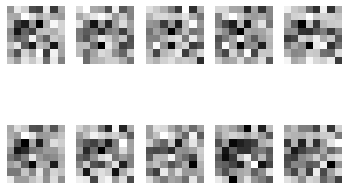

Batch 562/1875 - Opimize G - Avg Batch Loss: 0.3301 - Time : 2.85s
Batch 563/1875 - Opimize G - Avg Batch Loss: 0.3174 - Time : 2.66s
Batch 564/1875 - Opimize G - Avg Batch Loss: 0.3121 - Time : 2.93s
Batch 565/1875 - Opimize D - Avg Batch Loss: 0.3431 - Time : 2.70s
Batch 566/1875 - Opimize G - Avg Batch Loss: 0.4110 - Time : 2.64s
Batch 567/1875 - Opimize G - Avg Batch Loss: 0.2722 - Time : 2.91s
Batch 568/1875 - Opimize G - Avg Batch Loss: 0.4239 - Time : 2.90s
Batch 569/1875 - Opimize G - Avg Batch Loss: 0.3148 - Time : 2.90s
Batch 570/1875 - Opimize G - Avg Batch Loss: 0.2761 - Time : 2.91s
Batch 571/1875 - Opimize D - Avg Batch Loss: 0.3669 - Time : 2.93s


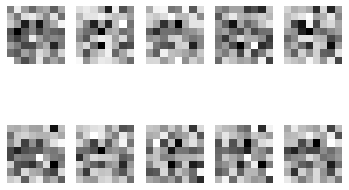

Batch 572/1875 - Opimize G - Avg Batch Loss: 0.3566 - Time : 2.67s
Batch 573/1875 - Opimize G - Avg Batch Loss: 0.5009 - Time : 2.92s
Batch 574/1875 - Opimize G - Avg Batch Loss: 0.2984 - Time : 2.77s
Batch 575/1875 - Opimize G - Avg Batch Loss: 0.3883 - Time : 3.13s
Batch 576/1875 - Opimize G - Avg Batch Loss: 0.4323 - Time : 2.67s
Batch 577/1875 - Opimize D - Avg Batch Loss: 0.3493 - Time : 2.96s
Batch 578/1875 - Opimize G - Avg Batch Loss: 0.3852 - Time : 2.85s
Batch 579/1875 - Opimize G - Avg Batch Loss: 0.4743 - Time : 2.90s
Batch 580/1875 - Opimize G - Avg Batch Loss: 0.3917 - Time : 2.87s
Batch 581/1875 - Opimize G - Avg Batch Loss: 0.3455 - Time : 2.90s


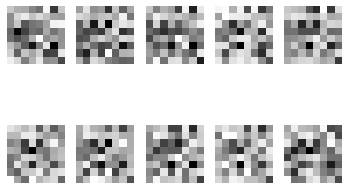

Batch 582/1875 - Opimize G - Avg Batch Loss: 0.3362 - Time : 2.65s
Batch 583/1875 - Opimize D - Avg Batch Loss: 0.4609 - Time : 2.98s
Batch 584/1875 - Opimize G - Avg Batch Loss: 0.3208 - Time : 3.12s
Batch 585/1875 - Opimize G - Avg Batch Loss: 0.5001 - Time : 3.20s
Batch 586/1875 - Opimize G - Avg Batch Loss: 0.3645 - Time : 3.18s
Batch 587/1875 - Opimize G - Avg Batch Loss: 0.3418 - Time : 2.93s
Batch 588/1875 - Opimize G - Avg Batch Loss: 0.3948 - Time : 2.61s
Batch 589/1875 - Opimize D - Avg Batch Loss: 0.4143 - Time : 2.67s
Batch 590/1875 - Opimize G - Avg Batch Loss: 0.3832 - Time : 2.78s
Batch 591/1875 - Opimize G - Avg Batch Loss: 0.3754 - Time : 2.86s


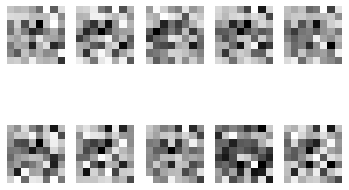

Batch 592/1875 - Opimize G - Avg Batch Loss: 0.3893 - Time : 2.89s
Batch 593/1875 - Opimize G - Avg Batch Loss: 0.4695 - Time : 2.87s
Batch 594/1875 - Opimize G - Avg Batch Loss: 0.3118 - Time : 2.60s
Batch 595/1875 - Opimize D - Avg Batch Loss: 0.3663 - Time : 2.87s
Batch 596/1875 - Opimize G - Avg Batch Loss: 0.4501 - Time : 3.14s
Batch 597/1875 - Opimize G - Avg Batch Loss: 0.3924 - Time : 2.83s
Batch 598/1875 - Opimize G - Avg Batch Loss: 0.3504 - Time : 3.10s
Batch 599/1875 - Opimize G - Avg Batch Loss: 0.3929 - Time : 2.92s
Batch 600/1875 - Opimize G - Avg Batch Loss: 0.3520 - Time : 2.68s
Batch 601/1875 - Opimize D - Avg Batch Loss: 0.5699 - Time : 2.71s


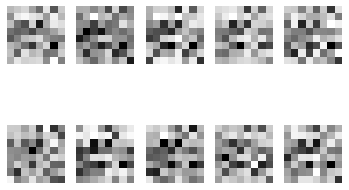

Batch 602/1875 - Opimize G - Avg Batch Loss: 0.4034 - Time : 2.94s
Batch 603/1875 - Opimize G - Avg Batch Loss: 0.4992 - Time : 2.91s
Batch 604/1875 - Opimize G - Avg Batch Loss: 0.3484 - Time : 2.90s
Batch 605/1875 - Opimize G - Avg Batch Loss: 0.3939 - Time : 3.02s
Batch 606/1875 - Opimize G - Avg Batch Loss: 0.4520 - Time : 2.70s
Batch 607/1875 - Opimize D - Avg Batch Loss: 0.3871 - Time : 2.71s
Batch 608/1875 - Opimize G - Avg Batch Loss: 0.5164 - Time : 2.71s
Batch 609/1875 - Opimize G - Avg Batch Loss: 0.3843 - Time : 2.99s
Batch 610/1875 - Opimize G - Avg Batch Loss: 0.3628 - Time : 3.01s
Batch 611/1875 - Opimize G - Avg Batch Loss: 0.3894 - Time : 3.01s


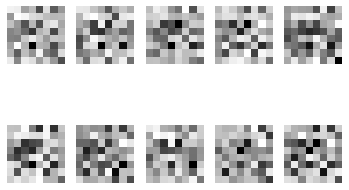

Batch 612/1875 - Opimize G - Avg Batch Loss: 0.4196 - Time : 2.71s
Batch 613/1875 - Opimize D - Avg Batch Loss: 0.3866 - Time : 2.88s
Batch 614/1875 - Opimize G - Avg Batch Loss: 0.3826 - Time : 2.86s
Batch 615/1875 - Opimize G - Avg Batch Loss: 0.3976 - Time : 2.72s
Batch 616/1875 - Opimize G - Avg Batch Loss: 0.3647 - Time : 2.59s
Batch 617/1875 - Opimize G - Avg Batch Loss: 0.3075 - Time : 2.70s
Batch 618/1875 - Opimize G - Avg Batch Loss: 0.3675 - Time : 2.72s
Batch 619/1875 - Opimize D - Avg Batch Loss: 0.3993 - Time : 2.67s
Batch 620/1875 - Opimize G - Avg Batch Loss: 0.5239 - Time : 2.80s
Batch 621/1875 - Opimize G - Avg Batch Loss: 0.3785 - Time : 2.74s


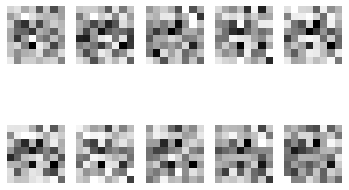

Batch 622/1875 - Opimize G - Avg Batch Loss: 0.3565 - Time : 2.75s
Batch 623/1875 - Opimize G - Avg Batch Loss: 0.4222 - Time : 3.21s
Batch 624/1875 - Opimize G - Avg Batch Loss: 0.3947 - Time : 2.79s
Batch 625/1875 - Opimize D - Avg Batch Loss: 0.4308 - Time : 2.78s
Batch 626/1875 - Opimize G - Avg Batch Loss: 0.3558 - Time : 3.02s
Batch 627/1875 - Opimize G - Avg Batch Loss: 0.4007 - Time : 2.71s
Batch 628/1875 - Opimize G - Avg Batch Loss: 0.3202 - Time : 2.91s
Batch 629/1875 - Opimize G - Avg Batch Loss: 0.3953 - Time : 2.89s
Batch 630/1875 - Opimize G - Avg Batch Loss: 0.3676 - Time : 2.94s
Batch 631/1875 - Opimize D - Avg Batch Loss: 0.4222 - Time : 2.70s


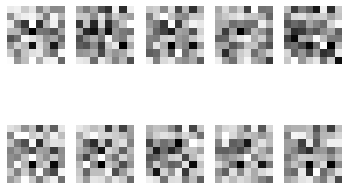

Batch 632/1875 - Opimize G - Avg Batch Loss: 0.4417 - Time : 2.69s
Batch 633/1875 - Opimize G - Avg Batch Loss: 0.3353 - Time : 2.81s
Batch 634/1875 - Opimize G - Avg Batch Loss: 0.5035 - Time : 2.90s
Batch 635/1875 - Opimize G - Avg Batch Loss: 0.4342 - Time : 2.67s
Batch 636/1875 - Opimize G - Avg Batch Loss: 0.4001 - Time : 2.64s
Batch 637/1875 - Opimize D - Avg Batch Loss: 0.4696 - Time : 2.68s
Batch 638/1875 - Opimize G - Avg Batch Loss: 0.4026 - Time : 2.95s
Batch 639/1875 - Opimize G - Avg Batch Loss: 0.4005 - Time : 2.90s
Batch 640/1875 - Opimize G - Avg Batch Loss: 0.3684 - Time : 3.02s
Batch 641/1875 - Opimize G - Avg Batch Loss: 0.3967 - Time : 2.95s


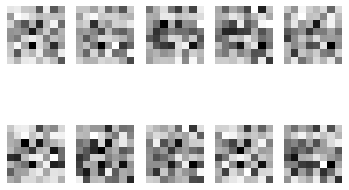

Batch 642/1875 - Opimize G - Avg Batch Loss: 0.5353 - Time : 2.78s
Batch 643/1875 - Opimize D - Avg Batch Loss: 0.3605 - Time : 2.69s
Batch 644/1875 - Opimize G - Avg Batch Loss: 0.5407 - Time : 3.09s
Batch 645/1875 - Opimize G - Avg Batch Loss: 0.4959 - Time : 2.86s
Batch 646/1875 - Opimize G - Avg Batch Loss: 0.3899 - Time : 2.90s
Batch 647/1875 - Opimize G - Avg Batch Loss: 0.3785 - Time : 2.75s
Batch 648/1875 - Opimize G - Avg Batch Loss: 0.4480 - Time : 2.70s
Batch 649/1875 - Opimize D - Avg Batch Loss: 0.4443 - Time : 2.64s
Batch 650/1875 - Opimize G - Avg Batch Loss: 0.4600 - Time : 3.14s
Batch 651/1875 - Opimize G - Avg Batch Loss: 0.4341 - Time : 2.90s


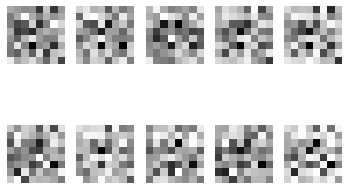

Batch 652/1875 - Opimize G - Avg Batch Loss: 0.4793 - Time : 2.90s
Batch 653/1875 - Opimize G - Avg Batch Loss: 0.3436 - Time : 2.71s
Batch 654/1875 - Opimize G - Avg Batch Loss: 0.3797 - Time : 3.34s
Batch 655/1875 - Opimize D - Avg Batch Loss: 0.2945 - Time : 2.62s
Batch 656/1875 - Opimize G - Avg Batch Loss: 0.4994 - Time : 2.67s
Batch 657/1875 - Opimize G - Avg Batch Loss: 0.4321 - Time : 2.87s
Batch 658/1875 - Opimize G - Avg Batch Loss: 0.4245 - Time : 2.88s
Batch 659/1875 - Opimize G - Avg Batch Loss: 0.4143 - Time : 2.90s
Batch 660/1875 - Opimize G - Avg Batch Loss: 0.4781 - Time : 2.98s
Batch 661/1875 - Opimize D - Avg Batch Loss: 0.5542 - Time : 3.35s


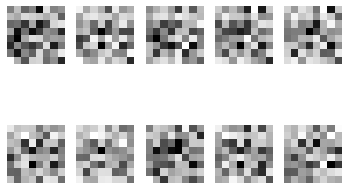

Batch 662/1875 - Opimize G - Avg Batch Loss: 0.4311 - Time : 2.87s
Batch 663/1875 - Opimize G - Avg Batch Loss: 0.4733 - Time : 2.68s
Batch 664/1875 - Opimize G - Avg Batch Loss: 0.4306 - Time : 2.92s
Batch 665/1875 - Opimize G - Avg Batch Loss: 0.3759 - Time : 2.71s
Batch 666/1875 - Opimize G - Avg Batch Loss: 0.4236 - Time : 2.91s
Batch 667/1875 - Opimize D - Avg Batch Loss: 0.4452 - Time : 2.92s
Batch 668/1875 - Opimize G - Avg Batch Loss: 0.3325 - Time : 2.66s
Batch 669/1875 - Opimize G - Avg Batch Loss: 0.4802 - Time : 3.20s
Batch 670/1875 - Opimize G - Avg Batch Loss: 0.5513 - Time : 2.67s
Batch 671/1875 - Opimize G - Avg Batch Loss: 0.3522 - Time : 2.71s


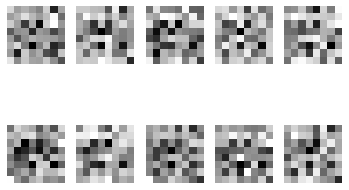

Batch 672/1875 - Opimize G - Avg Batch Loss: 0.4829 - Time : 2.88s
Batch 673/1875 - Opimize D - Avg Batch Loss: 0.3553 - Time : 2.93s
Batch 674/1875 - Opimize G - Avg Batch Loss: 0.4416 - Time : 3.03s
Batch 675/1875 - Opimize G - Avg Batch Loss: 0.5432 - Time : 2.86s
Batch 676/1875 - Opimize G - Avg Batch Loss: 0.4911 - Time : 2.84s
Batch 677/1875 - Opimize G - Avg Batch Loss: 0.3674 - Time : 3.20s
Batch 678/1875 - Opimize G - Avg Batch Loss: 0.3716 - Time : 2.75s
Batch 679/1875 - Opimize D - Avg Batch Loss: 0.3708 - Time : 2.71s
Batch 680/1875 - Opimize G - Avg Batch Loss: 0.5094 - Time : 2.62s
Batch 681/1875 - Opimize G - Avg Batch Loss: 0.3699 - Time : 2.64s


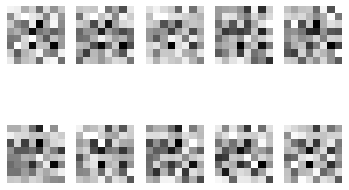

Batch 682/1875 - Opimize G - Avg Batch Loss: 0.4337 - Time : 2.65s
Batch 683/1875 - Opimize G - Avg Batch Loss: 0.5179 - Time : 2.70s
Batch 684/1875 - Opimize G - Avg Batch Loss: 0.4922 - Time : 2.85s
Batch 685/1875 - Opimize D - Avg Batch Loss: 0.4791 - Time : 3.17s
Batch 686/1875 - Opimize G - Avg Batch Loss: 0.5804 - Time : 2.64s
Batch 687/1875 - Opimize G - Avg Batch Loss: 0.3836 - Time : 2.93s
Batch 688/1875 - Opimize G - Avg Batch Loss: 0.4895 - Time : 2.92s
Batch 689/1875 - Opimize G - Avg Batch Loss: 0.4226 - Time : 2.78s
Batch 690/1875 - Opimize G - Avg Batch Loss: 0.4570 - Time : 2.90s
Batch 691/1875 - Opimize D - Avg Batch Loss: 0.4439 - Time : 2.65s


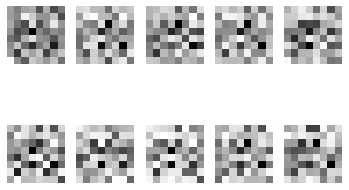

Batch 692/1875 - Opimize G - Avg Batch Loss: 0.4646 - Time : 2.87s
Batch 693/1875 - Opimize G - Avg Batch Loss: 0.4254 - Time : 2.64s
Batch 694/1875 - Opimize G - Avg Batch Loss: 0.6074 - Time : 2.97s
Batch 695/1875 - Opimize G - Avg Batch Loss: 0.4327 - Time : 2.80s
Batch 696/1875 - Opimize G - Avg Batch Loss: 0.4458 - Time : 2.97s
Batch 697/1875 - Opimize D - Avg Batch Loss: 0.5475 - Time : 2.66s
Batch 698/1875 - Opimize G - Avg Batch Loss: 0.5507 - Time : 2.80s
Batch 699/1875 - Opimize G - Avg Batch Loss: 0.3923 - Time : 2.71s
Batch 700/1875 - Opimize G - Avg Batch Loss: 0.4316 - Time : 2.68s
Batch 701/1875 - Opimize G - Avg Batch Loss: 0.4758 - Time : 2.97s


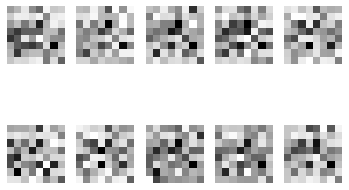

Batch 702/1875 - Opimize G - Avg Batch Loss: 0.3887 - Time : 2.84s
Batch 703/1875 - Opimize D - Avg Batch Loss: 0.5037 - Time : 3.28s
Batch 704/1875 - Opimize G - Avg Batch Loss: 0.5411 - Time : 2.91s
Batch 705/1875 - Opimize G - Avg Batch Loss: 0.4198 - Time : 2.69s
Batch 706/1875 - Opimize G - Avg Batch Loss: 0.5365 - Time : 2.69s
Batch 707/1875 - Opimize G - Avg Batch Loss: 0.4688 - Time : 2.91s
Batch 708/1875 - Opimize G - Avg Batch Loss: 0.5792 - Time : 2.69s
Batch 709/1875 - Opimize D - Avg Batch Loss: 0.4734 - Time : 2.96s
Batch 710/1875 - Opimize G - Avg Batch Loss: 0.5057 - Time : 2.81s
Batch 711/1875 - Opimize G - Avg Batch Loss: 0.4718 - Time : 2.86s


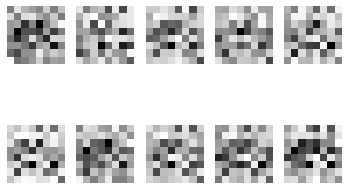

Batch 712/1875 - Opimize G - Avg Batch Loss: 0.4216 - Time : 2.91s
Batch 713/1875 - Opimize G - Avg Batch Loss: 0.4117 - Time : 2.59s
Batch 714/1875 - Opimize G - Avg Batch Loss: 0.4575 - Time : 2.72s
Batch 715/1875 - Opimize D - Avg Batch Loss: 0.4784 - Time : 3.13s
Batch 716/1875 - Opimize G - Avg Batch Loss: 0.6628 - Time : 2.74s
Batch 717/1875 - Opimize G - Avg Batch Loss: 0.3646 - Time : 2.95s
Batch 718/1875 - Opimize G - Avg Batch Loss: 0.5247 - Time : 2.63s
Batch 719/1875 - Opimize G - Avg Batch Loss: 0.5421 - Time : 3.09s
Batch 720/1875 - Opimize G - Avg Batch Loss: 0.5241 - Time : 2.99s
Batch 721/1875 - Opimize D - Avg Batch Loss: 0.5174 - Time : 2.87s


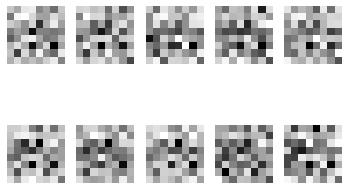

Batch 722/1875 - Opimize G - Avg Batch Loss: 0.5065 - Time : 2.85s
Batch 723/1875 - Opimize G - Avg Batch Loss: 0.5820 - Time : 2.68s
Batch 724/1875 - Opimize G - Avg Batch Loss: 0.5031 - Time : 3.15s
Batch 725/1875 - Opimize G - Avg Batch Loss: 0.4967 - Time : 2.67s
Batch 726/1875 - Opimize G - Avg Batch Loss: 0.5381 - Time : 2.66s
Batch 727/1875 - Opimize D - Avg Batch Loss: 0.5363 - Time : 2.89s
Batch 728/1875 - Opimize G - Avg Batch Loss: 0.3638 - Time : 2.72s
Batch 729/1875 - Opimize G - Avg Batch Loss: 0.4508 - Time : 2.68s
Batch 730/1875 - Opimize G - Avg Batch Loss: 0.5217 - Time : 2.91s
Batch 731/1875 - Opimize G - Avg Batch Loss: 0.4767 - Time : 2.96s


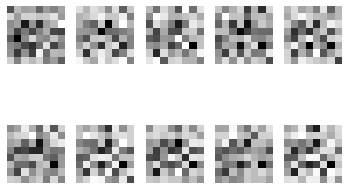

Batch 732/1875 - Opimize G - Avg Batch Loss: 0.5316 - Time : 2.93s
Batch 733/1875 - Opimize D - Avg Batch Loss: 0.4729 - Time : 2.66s
Batch 734/1875 - Opimize G - Avg Batch Loss: 0.4951 - Time : 2.70s
Batch 735/1875 - Opimize G - Avg Batch Loss: 0.5722 - Time : 2.93s
Batch 736/1875 - Opimize G - Avg Batch Loss: 0.5695 - Time : 2.88s
Batch 737/1875 - Opimize G - Avg Batch Loss: 0.4511 - Time : 2.69s
Batch 738/1875 - Opimize G - Avg Batch Loss: 0.3769 - Time : 2.58s
Batch 739/1875 - Opimize D - Avg Batch Loss: 0.4530 - Time : 2.89s
Batch 740/1875 - Opimize G - Avg Batch Loss: 0.4942 - Time : 2.98s
Batch 741/1875 - Opimize G - Avg Batch Loss: 0.4847 - Time : 2.90s


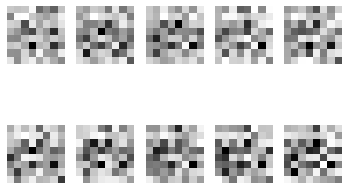

Batch 742/1875 - Opimize G - Avg Batch Loss: 0.5458 - Time : 2.97s
Batch 743/1875 - Opimize G - Avg Batch Loss: 0.5196 - Time : 2.63s
Batch 744/1875 - Opimize G - Avg Batch Loss: 0.5067 - Time : 2.67s
Batch 745/1875 - Opimize D - Avg Batch Loss: 0.5734 - Time : 3.10s
Batch 746/1875 - Opimize G - Avg Batch Loss: 0.5029 - Time : 2.76s
Batch 747/1875 - Opimize G - Avg Batch Loss: 0.4704 - Time : 2.87s
Batch 748/1875 - Opimize G - Avg Batch Loss: 0.4623 - Time : 2.72s
Batch 749/1875 - Opimize G - Avg Batch Loss: 0.4678 - Time : 2.85s
Batch 750/1875 - Opimize G - Avg Batch Loss: 0.4960 - Time : 2.85s
Batch 751/1875 - Opimize D - Avg Batch Loss: 0.4040 - Time : 3.09s


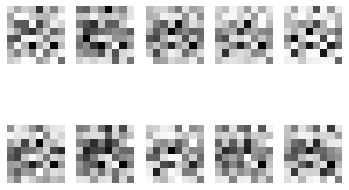

Batch 752/1875 - Opimize G - Avg Batch Loss: 0.5254 - Time : 3.08s
Batch 753/1875 - Opimize G - Avg Batch Loss: 0.5929 - Time : 2.91s
Batch 754/1875 - Opimize G - Avg Batch Loss: 0.5543 - Time : 2.64s
Batch 755/1875 - Opimize G - Avg Batch Loss: 0.4648 - Time : 2.95s
Batch 756/1875 - Opimize G - Avg Batch Loss: 0.5555 - Time : 2.73s
Batch 757/1875 - Opimize D - Avg Batch Loss: 0.5833 - Time : 3.36s
Batch 758/1875 - Opimize G - Avg Batch Loss: 0.4802 - Time : 2.73s
Batch 759/1875 - Opimize G - Avg Batch Loss: 0.5232 - Time : 2.68s
Batch 760/1875 - Opimize G - Avg Batch Loss: 0.5537 - Time : 2.59s
Batch 761/1875 - Opimize G - Avg Batch Loss: 0.6638 - Time : 2.94s


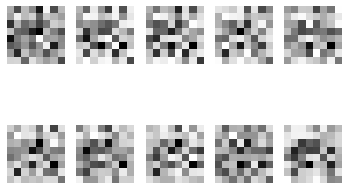

Batch 762/1875 - Opimize G - Avg Batch Loss: 0.5371 - Time : 2.65s
Batch 763/1875 - Opimize D - Avg Batch Loss: 0.4383 - Time : 2.77s
Batch 764/1875 - Opimize G - Avg Batch Loss: 0.4589 - Time : 2.64s
Batch 765/1875 - Opimize G - Avg Batch Loss: 0.6066 - Time : 2.64s
Batch 766/1875 - Opimize G - Avg Batch Loss: 0.6148 - Time : 2.90s
Batch 767/1875 - Opimize G - Avg Batch Loss: 0.5362 - Time : 2.69s
Batch 768/1875 - Opimize G - Avg Batch Loss: 0.5851 - Time : 2.81s
Batch 769/1875 - Opimize D - Avg Batch Loss: 0.5115 - Time : 2.75s
Batch 770/1875 - Opimize G - Avg Batch Loss: 0.5401 - Time : 2.90s
Batch 771/1875 - Opimize G - Avg Batch Loss: 0.5682 - Time : 2.93s


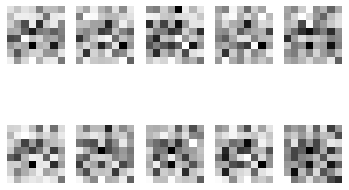

Batch 772/1875 - Opimize G - Avg Batch Loss: 0.5333 - Time : 2.86s
Batch 773/1875 - Opimize G - Avg Batch Loss: 0.6445 - Time : 2.90s
Batch 774/1875 - Opimize G - Avg Batch Loss: 0.5079 - Time : 2.89s
Batch 775/1875 - Opimize D - Avg Batch Loss: 0.5188 - Time : 2.62s
Batch 776/1875 - Opimize G - Avg Batch Loss: 0.5086 - Time : 3.16s
Batch 777/1875 - Opimize G - Avg Batch Loss: 0.6278 - Time : 2.74s
Batch 778/1875 - Opimize G - Avg Batch Loss: 0.5696 - Time : 2.82s
Batch 779/1875 - Opimize G - Avg Batch Loss: 0.4856 - Time : 2.83s
Batch 780/1875 - Opimize G - Avg Batch Loss: 0.6318 - Time : 2.65s
Batch 781/1875 - Opimize D - Avg Batch Loss: 0.5076 - Time : 2.75s


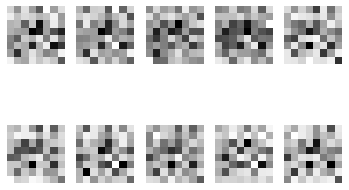

Batch 782/1875 - Opimize G - Avg Batch Loss: 0.6393 - Time : 2.70s
Batch 783/1875 - Opimize G - Avg Batch Loss: 0.5384 - Time : 2.87s
Batch 784/1875 - Opimize G - Avg Batch Loss: 0.5356 - Time : 3.09s
Batch 785/1875 - Opimize G - Avg Batch Loss: 0.5640 - Time : 2.70s
Batch 786/1875 - Opimize G - Avg Batch Loss: 0.6238 - Time : 2.97s
Batch 787/1875 - Opimize D - Avg Batch Loss: 0.5580 - Time : 2.97s
Batch 788/1875 - Opimize G - Avg Batch Loss: 0.6050 - Time : 2.91s
Batch 789/1875 - Opimize G - Avg Batch Loss: 0.4885 - Time : 3.14s
Batch 790/1875 - Opimize G - Avg Batch Loss: 0.5140 - Time : 2.84s
Batch 791/1875 - Opimize G - Avg Batch Loss: 0.5558 - Time : 2.95s


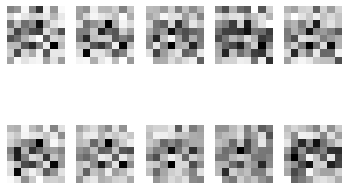

Batch 792/1875 - Opimize G - Avg Batch Loss: 0.6241 - Time : 2.92s
Batch 793/1875 - Opimize D - Avg Batch Loss: 0.5914 - Time : 2.95s
Batch 794/1875 - Opimize G - Avg Batch Loss: 0.5546 - Time : 2.92s
Batch 795/1875 - Opimize G - Avg Batch Loss: 0.6449 - Time : 2.69s
Batch 796/1875 - Opimize G - Avg Batch Loss: 0.4524 - Time : 2.59s
Batch 797/1875 - Opimize G - Avg Batch Loss: 0.6275 - Time : 2.65s
Batch 798/1875 - Opimize G - Avg Batch Loss: 0.5577 - Time : 2.94s
Batch 799/1875 - Opimize D - Avg Batch Loss: 0.5605 - Time : 2.72s
Batch 800/1875 - Opimize G - Avg Batch Loss: 0.5427 - Time : 2.96s
Batch 801/1875 - Opimize G - Avg Batch Loss: 0.5228 - Time : 2.67s


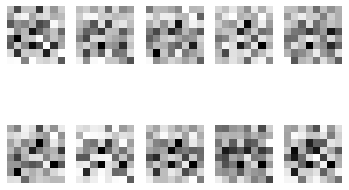

Batch 802/1875 - Opimize G - Avg Batch Loss: 0.4910 - Time : 2.71s
Batch 803/1875 - Opimize G - Avg Batch Loss: 0.5116 - Time : 2.79s
Batch 804/1875 - Opimize G - Avg Batch Loss: 0.7030 - Time : 3.09s
Batch 805/1875 - Opimize D - Avg Batch Loss: 0.5299 - Time : 2.92s
Batch 806/1875 - Opimize G - Avg Batch Loss: 0.5680 - Time : 2.94s
Batch 807/1875 - Opimize G - Avg Batch Loss: 0.6158 - Time : 3.07s
Batch 808/1875 - Opimize G - Avg Batch Loss: 0.6572 - Time : 2.64s
Batch 809/1875 - Opimize G - Avg Batch Loss: 0.5432 - Time : 2.69s
Batch 810/1875 - Opimize G - Avg Batch Loss: 0.5701 - Time : 2.79s
Batch 811/1875 - Opimize D - Avg Batch Loss: 0.6820 - Time : 2.72s


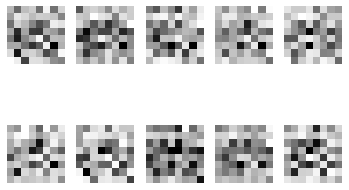

Batch 812/1875 - Opimize G - Avg Batch Loss: 0.6294 - Time : 3.15s
Batch 813/1875 - Opimize G - Avg Batch Loss: 0.7315 - Time : 2.79s
Batch 814/1875 - Opimize G - Avg Batch Loss: 0.6155 - Time : 2.64s
Batch 815/1875 - Opimize G - Avg Batch Loss: 0.6723 - Time : 2.84s
Batch 816/1875 - Opimize G - Avg Batch Loss: 0.5677 - Time : 2.86s
Batch 817/1875 - Opimize D - Avg Batch Loss: 0.5797 - Time : 2.70s
Batch 818/1875 - Opimize G - Avg Batch Loss: 0.6391 - Time : 2.93s
Batch 819/1875 - Opimize G - Avg Batch Loss: 0.6700 - Time : 2.69s
Batch 820/1875 - Opimize G - Avg Batch Loss: 0.6366 - Time : 2.67s
Batch 821/1875 - Opimize G - Avg Batch Loss: 0.5597 - Time : 2.91s


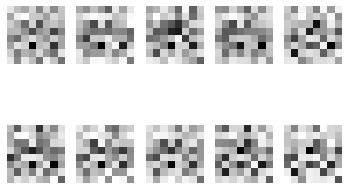

Batch 822/1875 - Opimize G - Avg Batch Loss: 0.6006 - Time : 2.77s
Batch 823/1875 - Opimize D - Avg Batch Loss: 0.5839 - Time : 2.67s
Batch 824/1875 - Opimize G - Avg Batch Loss: 0.7107 - Time : 2.79s
Batch 825/1875 - Opimize G - Avg Batch Loss: 0.6533 - Time : 2.73s
Batch 826/1875 - Opimize G - Avg Batch Loss: 0.7218 - Time : 2.75s
Batch 827/1875 - Opimize G - Avg Batch Loss: 0.5837 - Time : 2.87s
Batch 828/1875 - Opimize G - Avg Batch Loss: 0.6374 - Time : 2.94s
Batch 829/1875 - Opimize D - Avg Batch Loss: 0.5230 - Time : 2.96s
Batch 830/1875 - Opimize G - Avg Batch Loss: 0.5340 - Time : 3.02s
Batch 831/1875 - Opimize G - Avg Batch Loss: 0.7388 - Time : 3.01s


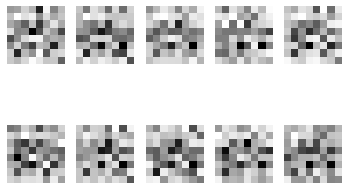

Batch 832/1875 - Opimize G - Avg Batch Loss: 0.6047 - Time : 2.90s
Batch 833/1875 - Opimize G - Avg Batch Loss: 0.5826 - Time : 2.67s
Batch 834/1875 - Opimize G - Avg Batch Loss: 0.5843 - Time : 3.01s
Batch 835/1875 - Opimize D - Avg Batch Loss: 0.6202 - Time : 2.95s
Batch 836/1875 - Opimize G - Avg Batch Loss: 0.5663 - Time : 2.72s
Batch 837/1875 - Opimize G - Avg Batch Loss: 0.6718 - Time : 2.79s
Batch 838/1875 - Opimize G - Avg Batch Loss: 0.7757 - Time : 2.92s
Batch 839/1875 - Opimize G - Avg Batch Loss: 0.6789 - Time : 2.74s
Batch 840/1875 - Opimize G - Avg Batch Loss: 0.6688 - Time : 2.82s
Batch 841/1875 - Opimize D - Avg Batch Loss: 0.6529 - Time : 2.94s


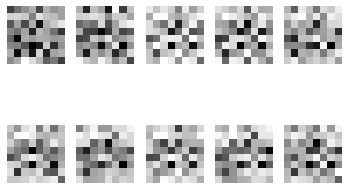

Batch 842/1875 - Opimize G - Avg Batch Loss: 0.6086 - Time : 2.75s
Batch 843/1875 - Opimize G - Avg Batch Loss: 0.5856 - Time : 2.94s
Batch 844/1875 - Opimize G - Avg Batch Loss: 0.6639 - Time : 2.67s
Batch 845/1875 - Opimize G - Avg Batch Loss: 0.5881 - Time : 2.84s
Batch 846/1875 - Opimize G - Avg Batch Loss: 0.6033 - Time : 2.70s
Batch 847/1875 - Opimize D - Avg Batch Loss: 0.5552 - Time : 2.63s
Batch 848/1875 - Opimize G - Avg Batch Loss: 0.6535 - Time : 2.74s
Batch 849/1875 - Opimize G - Avg Batch Loss: 0.6627 - Time : 2.62s
Batch 850/1875 - Opimize G - Avg Batch Loss: 0.7008 - Time : 2.72s
Batch 851/1875 - Opimize G - Avg Batch Loss: 0.6522 - Time : 3.19s


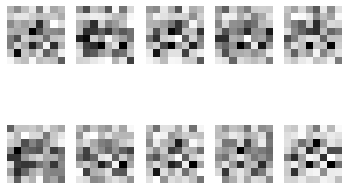

Batch 852/1875 - Opimize G - Avg Batch Loss: 0.6684 - Time : 2.79s
Batch 853/1875 - Opimize D - Avg Batch Loss: 0.7027 - Time : 2.83s
Batch 854/1875 - Opimize G - Avg Batch Loss: 0.6703 - Time : 2.96s
Batch 855/1875 - Opimize G - Avg Batch Loss: 0.5966 - Time : 2.98s
Batch 856/1875 - Opimize G - Avg Batch Loss: 0.6251 - Time : 2.91s
Batch 857/1875 - Opimize G - Avg Batch Loss: 0.6709 - Time : 2.91s
Batch 858/1875 - Opimize G - Avg Batch Loss: 0.6603 - Time : 2.64s
Batch 859/1875 - Opimize D - Avg Batch Loss: 0.7416 - Time : 2.68s
Batch 860/1875 - Opimize G - Avg Batch Loss: 0.6320 - Time : 3.01s
Batch 861/1875 - Opimize G - Avg Batch Loss: 0.7369 - Time : 2.84s


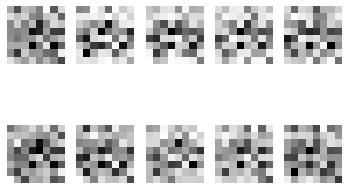

Batch 862/1875 - Opimize G - Avg Batch Loss: 0.5285 - Time : 2.69s
Batch 863/1875 - Opimize G - Avg Batch Loss: 0.5816 - Time : 2.91s
Batch 864/1875 - Opimize G - Avg Batch Loss: 0.6008 - Time : 2.64s
Batch 865/1875 - Opimize D - Avg Batch Loss: 0.6631 - Time : 2.76s
Batch 866/1875 - Opimize G - Avg Batch Loss: 0.7637 - Time : 2.78s
Batch 867/1875 - Opimize G - Avg Batch Loss: 0.6695 - Time : 2.75s
Batch 868/1875 - Opimize G - Avg Batch Loss: 0.7360 - Time : 2.93s
Batch 869/1875 - Opimize G - Avg Batch Loss: 0.6677 - Time : 3.15s
Batch 870/1875 - Opimize G - Avg Batch Loss: 0.7897 - Time : 2.90s
Batch 871/1875 - Opimize D - Avg Batch Loss: 0.6778 - Time : 2.77s


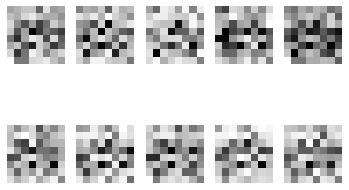

Batch 872/1875 - Opimize G - Avg Batch Loss: 0.6887 - Time : 2.80s
Batch 873/1875 - Opimize G - Avg Batch Loss: 0.6636 - Time : 2.94s
Batch 874/1875 - Opimize G - Avg Batch Loss: 0.5923 - Time : 2.71s
Batch 875/1875 - Opimize G - Avg Batch Loss: 0.7060 - Time : 2.66s
Batch 876/1875 - Opimize G - Avg Batch Loss: 0.6423 - Time : 3.02s
Batch 877/1875 - Opimize D - Avg Batch Loss: 0.6850 - Time : 3.00s
Batch 878/1875 - Opimize G - Avg Batch Loss: 0.6730 - Time : 2.71s
Batch 879/1875 - Opimize G - Avg Batch Loss: 0.7072 - Time : 3.13s
Batch 880/1875 - Opimize G - Avg Batch Loss: 0.6693 - Time : 2.92s
Batch 881/1875 - Opimize G - Avg Batch Loss: 0.6532 - Time : 2.66s


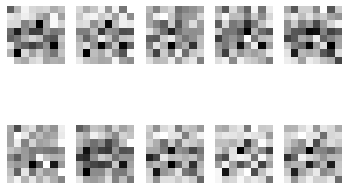

Batch 882/1875 - Opimize G - Avg Batch Loss: 0.7688 - Time : 3.25s
Batch 883/1875 - Opimize D - Avg Batch Loss: 0.6762 - Time : 2.81s
Batch 884/1875 - Opimize G - Avg Batch Loss: 0.6577 - Time : 2.90s
Batch 885/1875 - Opimize G - Avg Batch Loss: 0.6580 - Time : 2.97s
Batch 886/1875 - Opimize G - Avg Batch Loss: 0.7441 - Time : 2.68s
Batch 887/1875 - Opimize G - Avg Batch Loss: 0.7601 - Time : 2.70s
Batch 888/1875 - Opimize G - Avg Batch Loss: 0.7848 - Time : 2.75s
Batch 889/1875 - Opimize D - Avg Batch Loss: 0.8722 - Time : 2.80s
Batch 890/1875 - Opimize G - Avg Batch Loss: 0.7448 - Time : 3.04s
Batch 891/1875 - Opimize G - Avg Batch Loss: 0.6607 - Time : 2.69s


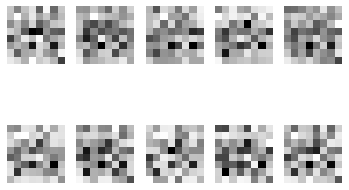

Batch 892/1875 - Opimize G - Avg Batch Loss: 0.7923 - Time : 2.91s
Batch 893/1875 - Opimize G - Avg Batch Loss: 0.6681 - Time : 2.90s
Batch 894/1875 - Opimize G - Avg Batch Loss: 0.6603 - Time : 2.88s
Batch 895/1875 - Opimize D - Avg Batch Loss: 0.7655 - Time : 2.66s
Batch 896/1875 - Opimize G - Avg Batch Loss: 0.7064 - Time : 2.74s
Batch 897/1875 - Opimize G - Avg Batch Loss: 0.7202 - Time : 2.93s
Batch 898/1875 - Opimize G - Avg Batch Loss: 0.8545 - Time : 2.97s
Batch 899/1875 - Opimize G - Avg Batch Loss: 0.7366 - Time : 2.86s
Batch 900/1875 - Opimize G - Avg Batch Loss: 0.7473 - Time : 3.05s
Batch 901/1875 - Opimize D - Avg Batch Loss: 0.7540 - Time : 2.61s


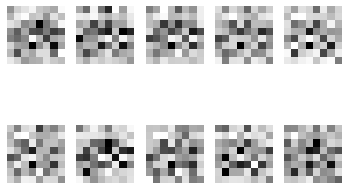

Batch 902/1875 - Opimize G - Avg Batch Loss: 0.7542 - Time : 2.67s
Batch 903/1875 - Opimize G - Avg Batch Loss: 0.6486 - Time : 2.84s
Batch 904/1875 - Opimize G - Avg Batch Loss: 0.7274 - Time : 2.69s
Batch 905/1875 - Opimize G - Avg Batch Loss: 0.6412 - Time : 2.77s
Batch 906/1875 - Opimize G - Avg Batch Loss: 0.6411 - Time : 3.07s
Batch 907/1875 - Opimize D - Avg Batch Loss: 0.7449 - Time : 2.98s
Batch 908/1875 - Opimize G - Avg Batch Loss: 0.7440 - Time : 3.06s
Batch 909/1875 - Opimize G - Avg Batch Loss: 0.6595 - Time : 2.71s
Batch 910/1875 - Opimize G - Avg Batch Loss: 0.8088 - Time : 2.66s
Batch 911/1875 - Opimize G - Avg Batch Loss: 0.7137 - Time : 2.91s


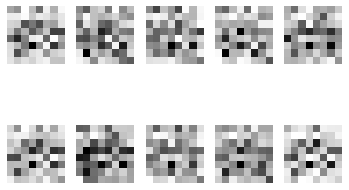

Batch 912/1875 - Opimize G - Avg Batch Loss: 0.5940 - Time : 2.92s
Batch 913/1875 - Opimize D - Avg Batch Loss: 0.6221 - Time : 2.90s
Batch 914/1875 - Opimize G - Avg Batch Loss: 0.8079 - Time : 2.78s
Batch 915/1875 - Opimize G - Avg Batch Loss: 0.6996 - Time : 2.68s
Batch 916/1875 - Opimize G - Avg Batch Loss: 0.7674 - Time : 2.72s
Batch 917/1875 - Opimize G - Avg Batch Loss: 0.7985 - Time : 2.97s
Batch 918/1875 - Opimize G - Avg Batch Loss: 0.6972 - Time : 3.28s
Batch 919/1875 - Opimize D - Avg Batch Loss: 0.8049 - Time : 2.84s
Batch 920/1875 - Opimize G - Avg Batch Loss: 0.8269 - Time : 2.76s
Batch 921/1875 - Opimize G - Avg Batch Loss: 0.6638 - Time : 2.98s


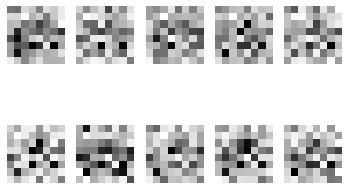

Batch 922/1875 - Opimize G - Avg Batch Loss: 0.7372 - Time : 3.10s
Batch 923/1875 - Opimize G - Avg Batch Loss: 0.7468 - Time : 2.64s
Batch 924/1875 - Opimize G - Avg Batch Loss: 0.8469 - Time : 2.91s
Batch 925/1875 - Opimize D - Avg Batch Loss: 0.6118 - Time : 2.77s
Batch 926/1875 - Opimize G - Avg Batch Loss: 0.7879 - Time : 2.66s
Batch 927/1875 - Opimize G - Avg Batch Loss: 0.7533 - Time : 2.97s
Batch 928/1875 - Opimize G - Avg Batch Loss: 0.7491 - Time : 2.81s
Batch 929/1875 - Opimize G - Avg Batch Loss: 0.7502 - Time : 2.85s
Batch 930/1875 - Opimize G - Avg Batch Loss: 0.7360 - Time : 3.12s
Batch 931/1875 - Opimize D - Avg Batch Loss: 0.6670 - Time : 2.92s


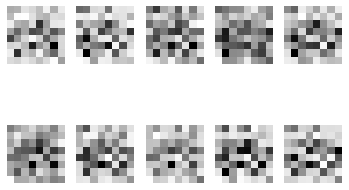

Batch 932/1875 - Opimize G - Avg Batch Loss: 0.8139 - Time : 2.69s
Batch 933/1875 - Opimize G - Avg Batch Loss: 0.7520 - Time : 2.91s
Batch 934/1875 - Opimize G - Avg Batch Loss: 0.7624 - Time : 2.97s
Batch 935/1875 - Opimize G - Avg Batch Loss: 0.9312 - Time : 2.68s
Batch 936/1875 - Opimize G - Avg Batch Loss: 0.6747 - Time : 3.45s
Batch 937/1875 - Opimize D - Avg Batch Loss: 0.7122 - Time : 2.82s
Batch 938/1875 - Opimize G - Avg Batch Loss: 0.8483 - Time : 2.89s
Batch 939/1875 - Opimize G - Avg Batch Loss: 0.8562 - Time : 2.74s
Batch 940/1875 - Opimize G - Avg Batch Loss: 0.6931 - Time : 2.74s
Batch 941/1875 - Opimize G - Avg Batch Loss: 0.6006 - Time : 2.71s


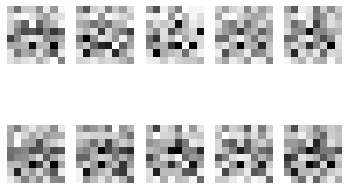

Batch 942/1875 - Opimize G - Avg Batch Loss: 0.7493 - Time : 3.25s
Batch 943/1875 - Opimize D - Avg Batch Loss: 0.6790 - Time : 2.79s
Batch 944/1875 - Opimize G - Avg Batch Loss: 0.8575 - Time : 2.75s
Batch 945/1875 - Opimize G - Avg Batch Loss: 0.7465 - Time : 3.23s
Batch 946/1875 - Opimize G - Avg Batch Loss: 0.7194 - Time : 2.84s
Batch 947/1875 - Opimize G - Avg Batch Loss: 0.9148 - Time : 3.12s
Batch 948/1875 - Opimize G - Avg Batch Loss: 0.8066 - Time : 2.98s
Batch 949/1875 - Opimize D - Avg Batch Loss: 0.7379 - Time : 2.94s
Batch 950/1875 - Opimize G - Avg Batch Loss: 0.8301 - Time : 2.91s
Batch 951/1875 - Opimize G - Avg Batch Loss: 0.7692 - Time : 2.74s


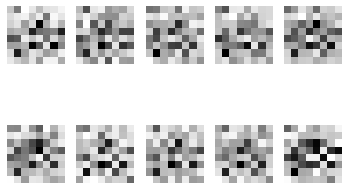

Batch 952/1875 - Opimize G - Avg Batch Loss: 0.7778 - Time : 2.99s
Batch 953/1875 - Opimize G - Avg Batch Loss: 0.7277 - Time : 2.77s
Batch 954/1875 - Opimize G - Avg Batch Loss: 0.8022 - Time : 2.70s
Batch 955/1875 - Opimize D - Avg Batch Loss: 0.7602 - Time : 2.67s
Batch 956/1875 - Opimize G - Avg Batch Loss: 0.6907 - Time : 2.65s
Batch 957/1875 - Opimize G - Avg Batch Loss: 0.8458 - Time : 2.85s
Batch 958/1875 - Opimize G - Avg Batch Loss: 0.7001 - Time : 2.89s
Batch 959/1875 - Opimize G - Avg Batch Loss: 0.6904 - Time : 2.67s
Batch 960/1875 - Opimize G - Avg Batch Loss: 0.7521 - Time : 2.64s
Batch 961/1875 - Opimize D - Avg Batch Loss: 0.7576 - Time : 2.93s


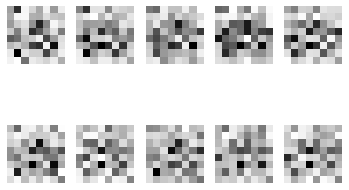

Batch 962/1875 - Opimize G - Avg Batch Loss: 0.8292 - Time : 2.69s
Batch 963/1875 - Opimize G - Avg Batch Loss: 0.7721 - Time : 2.89s
Batch 964/1875 - Opimize G - Avg Batch Loss: 0.7747 - Time : 2.69s
Batch 965/1875 - Opimize G - Avg Batch Loss: 0.7541 - Time : 2.71s
Batch 966/1875 - Opimize G - Avg Batch Loss: 0.7624 - Time : 2.70s
Batch 967/1875 - Opimize D - Avg Batch Loss: 0.6771 - Time : 2.71s
Batch 968/1875 - Opimize G - Avg Batch Loss: 0.7006 - Time : 2.71s
Batch 969/1875 - Opimize G - Avg Batch Loss: 0.7268 - Time : 2.66s
Batch 970/1875 - Opimize G - Avg Batch Loss: 0.7606 - Time : 2.68s
Batch 971/1875 - Opimize G - Avg Batch Loss: 0.7668 - Time : 2.73s


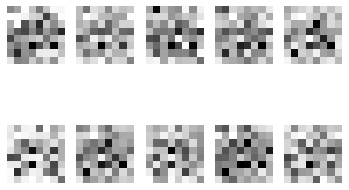

Batch 972/1875 - Opimize G - Avg Batch Loss: 0.8000 - Time : 2.71s
Batch 973/1875 - Opimize D - Avg Batch Loss: 0.8203 - Time : 2.70s
Batch 974/1875 - Opimize G - Avg Batch Loss: 0.7835 - Time : 2.67s
Batch 975/1875 - Opimize G - Avg Batch Loss: 0.9107 - Time : 2.75s
Batch 976/1875 - Opimize G - Avg Batch Loss: 0.7281 - Time : 2.88s
Batch 977/1875 - Opimize G - Avg Batch Loss: 0.9118 - Time : 2.73s
Batch 978/1875 - Opimize G - Avg Batch Loss: 0.7063 - Time : 2.99s
Batch 979/1875 - Opimize D - Avg Batch Loss: 0.7566 - Time : 2.78s
Batch 980/1875 - Opimize G - Avg Batch Loss: 0.8124 - Time : 2.70s
Batch 981/1875 - Opimize G - Avg Batch Loss: 0.6745 - Time : 2.66s


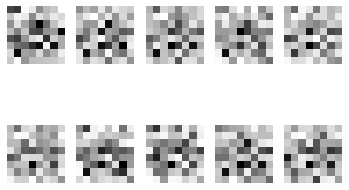

Batch 982/1875 - Opimize G - Avg Batch Loss: 0.8241 - Time : 2.86s
Batch 983/1875 - Opimize G - Avg Batch Loss: 0.7410 - Time : 2.89s
Batch 984/1875 - Opimize G - Avg Batch Loss: 0.6023 - Time : 2.64s
Batch 985/1875 - Opimize D - Avg Batch Loss: 0.7802 - Time : 2.68s
Batch 986/1875 - Opimize G - Avg Batch Loss: 0.8004 - Time : 2.65s
Batch 987/1875 - Opimize G - Avg Batch Loss: 0.6985 - Time : 2.62s
Batch 988/1875 - Opimize G - Avg Batch Loss: 0.8168 - Time : 2.95s
Batch 989/1875 - Opimize G - Avg Batch Loss: 0.7953 - Time : 2.68s
Batch 990/1875 - Opimize G - Avg Batch Loss: 0.8424 - Time : 2.80s
Batch 991/1875 - Opimize D - Avg Batch Loss: 0.8119 - Time : 2.70s


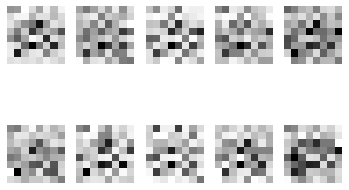

Batch 992/1875 - Opimize G - Avg Batch Loss: 0.6140 - Time : 2.89s
Batch 993/1875 - Opimize G - Avg Batch Loss: 0.8614 - Time : 2.70s
Batch 994/1875 - Opimize G - Avg Batch Loss: 0.8123 - Time : 2.74s
Batch 995/1875 - Opimize G - Avg Batch Loss: 0.8377 - Time : 2.74s
Batch 996/1875 - Opimize G - Avg Batch Loss: 0.6913 - Time : 3.38s
Batch 997/1875 - Opimize D - Avg Batch Loss: 0.8118 - Time : 2.73s
Batch 998/1875 - Opimize G - Avg Batch Loss: 0.7346 - Time : 2.72s
Batch 999/1875 - Opimize G - Avg Batch Loss: 0.9259 - Time : 2.89s
Batch 1000/1875 - Opimize G - Avg Batch Loss: 0.8241 - Time : 2.71s
Batch 1001/1875 - Opimize G - Avg Batch Loss: 0.7477 - Time : 2.70s


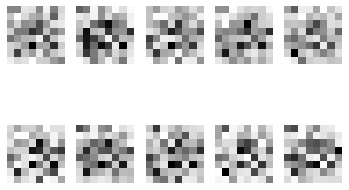

Batch 1002/1875 - Opimize G - Avg Batch Loss: 0.6775 - Time : 2.91s
Batch 1003/1875 - Opimize D - Avg Batch Loss: 0.7065 - Time : 2.72s
Batch 1004/1875 - Opimize G - Avg Batch Loss: 0.8553 - Time : 2.85s
Batch 1005/1875 - Opimize G - Avg Batch Loss: 0.7728 - Time : 2.86s
Batch 1006/1875 - Opimize G - Avg Batch Loss: 0.7742 - Time : 2.66s
Batch 1007/1875 - Opimize G - Avg Batch Loss: 0.7523 - Time : 2.70s
Batch 1008/1875 - Opimize G - Avg Batch Loss: 0.7039 - Time : 2.76s
Batch 1009/1875 - Opimize D - Avg Batch Loss: 0.7974 - Time : 2.74s
Batch 1010/1875 - Opimize G - Avg Batch Loss: 0.7290 - Time : 2.87s
Batch 1011/1875 - Opimize G - Avg Batch Loss: 0.7042 - Time : 2.69s


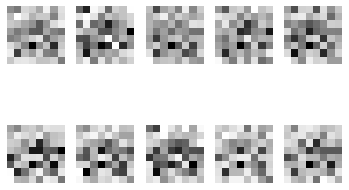

Batch 1012/1875 - Opimize G - Avg Batch Loss: 0.7112 - Time : 2.76s
Batch 1013/1875 - Opimize G - Avg Batch Loss: 0.7704 - Time : 2.95s
Batch 1014/1875 - Opimize G - Avg Batch Loss: 0.8818 - Time : 2.77s
Batch 1015/1875 - Opimize D - Avg Batch Loss: 0.8218 - Time : 2.75s
Batch 1016/1875 - Opimize G - Avg Batch Loss: 0.7994 - Time : 2.81s
Batch 1017/1875 - Opimize G - Avg Batch Loss: 0.7438 - Time : 2.81s
Batch 1018/1875 - Opimize G - Avg Batch Loss: 0.7113 - Time : 2.71s
Batch 1019/1875 - Opimize G - Avg Batch Loss: 0.7690 - Time : 2.98s
Batch 1020/1875 - Opimize G - Avg Batch Loss: 0.9270 - Time : 2.72s
Batch 1021/1875 - Opimize D - Avg Batch Loss: 0.7585 - Time : 2.98s


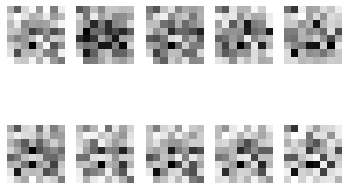

Batch 1022/1875 - Opimize G - Avg Batch Loss: 0.8930 - Time : 3.01s
Batch 1023/1875 - Opimize G - Avg Batch Loss: 0.8260 - Time : 2.75s
Batch 1024/1875 - Opimize G - Avg Batch Loss: 0.9163 - Time : 2.72s
Batch 1025/1875 - Opimize G - Avg Batch Loss: 0.8175 - Time : 2.74s
Batch 1026/1875 - Opimize G - Avg Batch Loss: 0.7862 - Time : 2.96s
Batch 1027/1875 - Opimize D - Avg Batch Loss: 0.9434 - Time : 2.97s
Batch 1028/1875 - Opimize G - Avg Batch Loss: 0.9119 - Time : 2.68s
Batch 1029/1875 - Opimize G - Avg Batch Loss: 0.9843 - Time : 2.86s
Batch 1030/1875 - Opimize G - Avg Batch Loss: 0.8921 - Time : 2.68s
Batch 1031/1875 - Opimize G - Avg Batch Loss: 0.6073 - Time : 2.90s


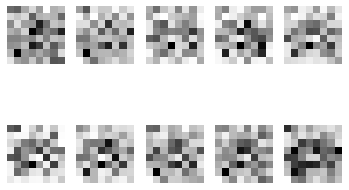

Batch 1032/1875 - Opimize G - Avg Batch Loss: 0.9287 - Time : 2.67s
Batch 1033/1875 - Opimize D - Avg Batch Loss: 0.7979 - Time : 2.88s
Batch 1034/1875 - Opimize G - Avg Batch Loss: 0.7323 - Time : 2.91s
Batch 1035/1875 - Opimize G - Avg Batch Loss: 1.0234 - Time : 2.76s
Batch 1036/1875 - Opimize G - Avg Batch Loss: 0.7936 - Time : 2.72s
Batch 1037/1875 - Opimize G - Avg Batch Loss: 0.7886 - Time : 2.78s
Batch 1038/1875 - Opimize G - Avg Batch Loss: 0.8268 - Time : 2.93s
Batch 1039/1875 - Opimize D - Avg Batch Loss: 0.7953 - Time : 2.94s
Batch 1040/1875 - Opimize G - Avg Batch Loss: 0.8805 - Time : 2.94s
Batch 1041/1875 - Opimize G - Avg Batch Loss: 0.7879 - Time : 2.92s


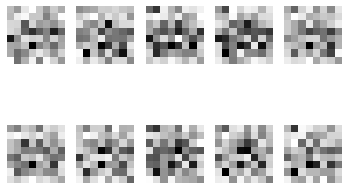

Batch 1042/1875 - Opimize G - Avg Batch Loss: 0.9117 - Time : 2.72s
Batch 1043/1875 - Opimize G - Avg Batch Loss: 0.9498 - Time : 2.78s
Batch 1044/1875 - Opimize G - Avg Batch Loss: 0.8576 - Time : 2.71s
Batch 1045/1875 - Opimize D - Avg Batch Loss: 0.8326 - Time : 2.75s
Batch 1046/1875 - Opimize G - Avg Batch Loss: 0.8507 - Time : 2.77s
Batch 1047/1875 - Opimize G - Avg Batch Loss: 0.9200 - Time : 2.69s
Batch 1048/1875 - Opimize G - Avg Batch Loss: 0.9228 - Time : 2.68s
Batch 1049/1875 - Opimize G - Avg Batch Loss: 0.9188 - Time : 2.96s
Batch 1050/1875 - Opimize G - Avg Batch Loss: 0.9387 - Time : 3.00s
Batch 1051/1875 - Opimize D - Avg Batch Loss: 0.7150 - Time : 2.75s


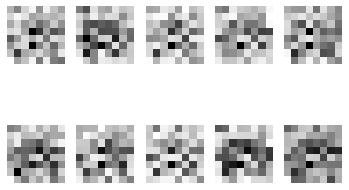

Batch 1052/1875 - Opimize G - Avg Batch Loss: 1.0266 - Time : 2.72s
Batch 1053/1875 - Opimize G - Avg Batch Loss: 0.7980 - Time : 2.78s
Batch 1054/1875 - Opimize G - Avg Batch Loss: 0.9576 - Time : 2.69s
Batch 1055/1875 - Opimize G - Avg Batch Loss: 0.9085 - Time : 2.70s
Batch 1056/1875 - Opimize G - Avg Batch Loss: 0.7707 - Time : 2.87s
Batch 1057/1875 - Opimize D - Avg Batch Loss: 0.8597 - Time : 2.92s
Batch 1058/1875 - Opimize G - Avg Batch Loss: 0.8217 - Time : 2.80s
Batch 1059/1875 - Opimize G - Avg Batch Loss: 0.8849 - Time : 2.92s
Batch 1060/1875 - Opimize G - Avg Batch Loss: 1.0125 - Time : 2.62s
Batch 1061/1875 - Opimize G - Avg Batch Loss: 0.8807 - Time : 2.88s


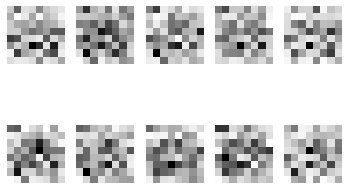

Batch 1062/1875 - Opimize G - Avg Batch Loss: 0.7837 - Time : 2.71s
Batch 1063/1875 - Opimize D - Avg Batch Loss: 0.8822 - Time : 2.70s
Batch 1064/1875 - Opimize G - Avg Batch Loss: 0.8226 - Time : 2.70s
Batch 1065/1875 - Opimize G - Avg Batch Loss: 0.8002 - Time : 2.71s
Batch 1066/1875 - Opimize G - Avg Batch Loss: 0.8782 - Time : 2.72s
Batch 1067/1875 - Opimize G - Avg Batch Loss: 0.6860 - Time : 3.09s
Batch 1068/1875 - Opimize G - Avg Batch Loss: 0.7187 - Time : 2.69s
Batch 1069/1875 - Opimize D - Avg Batch Loss: 0.8201 - Time : 2.98s
Batch 1070/1875 - Opimize G - Avg Batch Loss: 0.7510 - Time : 2.82s
Batch 1071/1875 - Opimize G - Avg Batch Loss: 0.9308 - Time : 2.90s


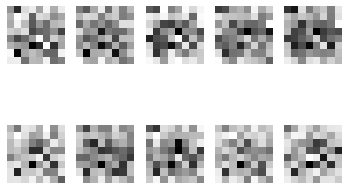

Batch 1072/1875 - Opimize G - Avg Batch Loss: 0.9063 - Time : 2.75s
Batch 1073/1875 - Opimize G - Avg Batch Loss: 0.7361 - Time : 2.69s
Batch 1074/1875 - Opimize G - Avg Batch Loss: 0.6416 - Time : 2.70s
Batch 1075/1875 - Opimize D - Avg Batch Loss: 0.9242 - Time : 2.72s
Batch 1076/1875 - Opimize G - Avg Batch Loss: 0.7374 - Time : 2.80s
Batch 1077/1875 - Opimize G - Avg Batch Loss: 0.6923 - Time : 2.67s
Batch 1078/1875 - Opimize G - Avg Batch Loss: 0.7477 - Time : 2.85s
Batch 1079/1875 - Opimize G - Avg Batch Loss: 0.8735 - Time : 2.85s
Batch 1080/1875 - Opimize G - Avg Batch Loss: 0.7707 - Time : 2.88s
Batch 1081/1875 - Opimize D - Avg Batch Loss: 0.7694 - Time : 2.86s


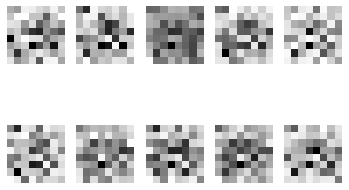

Batch 1082/1875 - Opimize G - Avg Batch Loss: 0.7799 - Time : 3.08s
Batch 1083/1875 - Opimize G - Avg Batch Loss: 0.7719 - Time : 2.71s
Batch 1084/1875 - Opimize G - Avg Batch Loss: 0.8929 - Time : 2.78s
Batch 1085/1875 - Opimize G - Avg Batch Loss: 0.8157 - Time : 3.31s
Batch 1086/1875 - Opimize G - Avg Batch Loss: 0.7642 - Time : 2.76s
Batch 1087/1875 - Opimize D - Avg Batch Loss: 0.9198 - Time : 3.01s
Batch 1088/1875 - Opimize G - Avg Batch Loss: 0.7122 - Time : 2.73s
Batch 1089/1875 - Opimize G - Avg Batch Loss: 0.7025 - Time : 2.66s
Batch 1090/1875 - Opimize G - Avg Batch Loss: 0.7648 - Time : 2.78s
Batch 1091/1875 - Opimize G - Avg Batch Loss: 0.7797 - Time : 2.74s


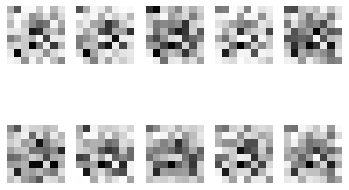

Batch 1092/1875 - Opimize G - Avg Batch Loss: 0.7853 - Time : 3.13s
Batch 1093/1875 - Opimize D - Avg Batch Loss: 0.7089 - Time : 2.68s
Batch 1094/1875 - Opimize G - Avg Batch Loss: 0.7479 - Time : 2.95s
Batch 1095/1875 - Opimize G - Avg Batch Loss: 0.6942 - Time : 2.73s
Batch 1096/1875 - Opimize G - Avg Batch Loss: 0.8959 - Time : 2.68s
Batch 1097/1875 - Opimize G - Avg Batch Loss: 0.7019 - Time : 3.16s
Batch 1098/1875 - Opimize G - Avg Batch Loss: 0.8513 - Time : 2.95s
Batch 1099/1875 - Opimize D - Avg Batch Loss: 0.6683 - Time : 2.65s
Batch 1100/1875 - Opimize G - Avg Batch Loss: 0.7571 - Time : 2.71s
Batch 1101/1875 - Opimize G - Avg Batch Loss: 0.8246 - Time : 2.75s


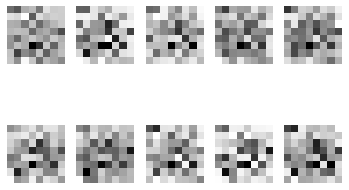

Batch 1102/1875 - Opimize G - Avg Batch Loss: 0.7977 - Time : 2.86s
Batch 1103/1875 - Opimize G - Avg Batch Loss: 0.6217 - Time : 2.93s
Batch 1104/1875 - Opimize G - Avg Batch Loss: 0.6619 - Time : 2.95s
Batch 1105/1875 - Opimize D - Avg Batch Loss: 0.6923 - Time : 3.21s
Batch 1106/1875 - Opimize G - Avg Batch Loss: 0.6196 - Time : 3.22s
Batch 1107/1875 - Opimize G - Avg Batch Loss: 0.8899 - Time : 2.78s
Batch 1108/1875 - Opimize G - Avg Batch Loss: 0.8119 - Time : 3.35s
Batch 1109/1875 - Opimize G - Avg Batch Loss: 0.6263 - Time : 2.74s
Batch 1110/1875 - Opimize G - Avg Batch Loss: 0.5942 - Time : 2.76s
Batch 1111/1875 - Opimize D - Avg Batch Loss: 0.7117 - Time : 2.66s


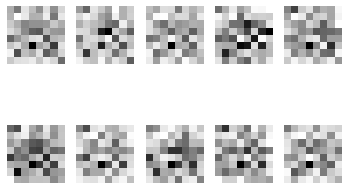

Batch 1112/1875 - Opimize G - Avg Batch Loss: 0.7339 - Time : 2.77s
Batch 1113/1875 - Opimize G - Avg Batch Loss: 0.6775 - Time : 2.72s
Batch 1114/1875 - Opimize G - Avg Batch Loss: 0.6187 - Time : 2.82s
Batch 1115/1875 - Opimize G - Avg Batch Loss: 0.7185 - Time : 2.78s
Batch 1116/1875 - Opimize G - Avg Batch Loss: 0.7232 - Time : 2.90s
Batch 1117/1875 - Opimize D - Avg Batch Loss: 0.6874 - Time : 2.73s
Batch 1118/1875 - Opimize G - Avg Batch Loss: 0.6869 - Time : 2.69s
Batch 1119/1875 - Opimize G - Avg Batch Loss: 0.6905 - Time : 2.73s
Batch 1120/1875 - Opimize G - Avg Batch Loss: 0.6485 - Time : 2.72s
Batch 1121/1875 - Opimize G - Avg Batch Loss: 0.7335 - Time : 2.72s


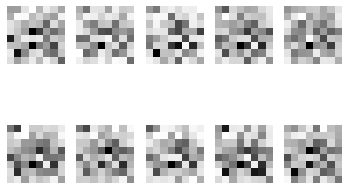

Batch 1122/1875 - Opimize G - Avg Batch Loss: 0.7613 - Time : 2.72s
Batch 1123/1875 - Opimize D - Avg Batch Loss: 0.5729 - Time : 2.74s
Batch 1124/1875 - Opimize G - Avg Batch Loss: 0.7318 - Time : 2.69s
Batch 1125/1875 - Opimize G - Avg Batch Loss: 0.6652 - Time : 2.74s
Batch 1126/1875 - Opimize G - Avg Batch Loss: 0.6468 - Time : 2.82s
Batch 1127/1875 - Opimize G - Avg Batch Loss: 0.6457 - Time : 2.69s
Batch 1128/1875 - Opimize G - Avg Batch Loss: 0.6273 - Time : 2.91s
Batch 1129/1875 - Opimize D - Avg Batch Loss: 0.6719 - Time : 2.69s
Batch 1130/1875 - Opimize G - Avg Batch Loss: 0.7664 - Time : 2.74s
Batch 1131/1875 - Opimize G - Avg Batch Loss: 0.7533 - Time : 2.77s


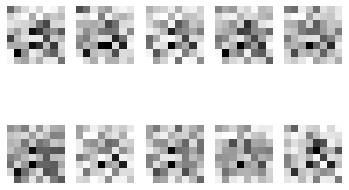

Batch 1132/1875 - Opimize G - Avg Batch Loss: 0.7277 - Time : 2.67s
Batch 1133/1875 - Opimize G - Avg Batch Loss: 0.6844 - Time : 2.87s
Batch 1134/1875 - Opimize G - Avg Batch Loss: 0.7091 - Time : 2.69s
Batch 1135/1875 - Opimize D - Avg Batch Loss: 0.6616 - Time : 2.84s
Batch 1136/1875 - Opimize G - Avg Batch Loss: 0.7279 - Time : 3.23s
Batch 1137/1875 - Opimize G - Avg Batch Loss: 0.6371 - Time : 2.95s
Batch 1138/1875 - Opimize G - Avg Batch Loss: 0.6897 - Time : 2.82s
Batch 1139/1875 - Opimize G - Avg Batch Loss: 0.6821 - Time : 2.72s
Batch 1140/1875 - Opimize G - Avg Batch Loss: 0.6846 - Time : 2.82s
Batch 1141/1875 - Opimize D - Avg Batch Loss: 0.7540 - Time : 2.92s


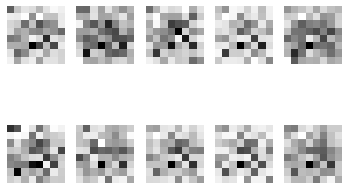

Batch 1142/1875 - Opimize G - Avg Batch Loss: 0.7162 - Time : 3.02s
Batch 1143/1875 - Opimize G - Avg Batch Loss: 0.7291 - Time : 2.71s
Batch 1144/1875 - Opimize G - Avg Batch Loss: 0.8481 - Time : 3.15s
Batch 1145/1875 - Opimize G - Avg Batch Loss: 0.5567 - Time : 2.65s
Batch 1146/1875 - Opimize G - Avg Batch Loss: 0.7538 - Time : 2.68s
Batch 1147/1875 - Opimize D - Avg Batch Loss: 0.7118 - Time : 3.11s
Batch 1148/1875 - Opimize G - Avg Batch Loss: 0.7390 - Time : 3.00s
Batch 1149/1875 - Opimize G - Avg Batch Loss: 0.6690 - Time : 2.91s
Batch 1150/1875 - Opimize G - Avg Batch Loss: 0.6930 - Time : 3.18s
Batch 1151/1875 - Opimize G - Avg Batch Loss: 0.7142 - Time : 2.67s


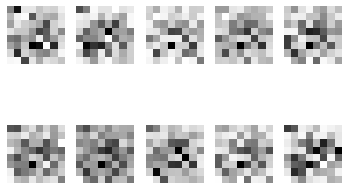

Batch 1152/1875 - Opimize G - Avg Batch Loss: 0.6648 - Time : 2.92s
Batch 1153/1875 - Opimize D - Avg Batch Loss: 0.8440 - Time : 2.72s
Batch 1154/1875 - Opimize G - Avg Batch Loss: 0.7450 - Time : 2.81s
Batch 1155/1875 - Opimize G - Avg Batch Loss: 0.9034 - Time : 3.08s
Batch 1156/1875 - Opimize G - Avg Batch Loss: 0.7816 - Time : 2.88s
Batch 1157/1875 - Opimize G - Avg Batch Loss: 0.7382 - Time : 2.78s
Batch 1158/1875 - Opimize G - Avg Batch Loss: 0.6367 - Time : 2.72s
Batch 1159/1875 - Opimize D - Avg Batch Loss: 0.7927 - Time : 2.74s
Batch 1160/1875 - Opimize G - Avg Batch Loss: 0.6699 - Time : 2.85s
Batch 1161/1875 - Opimize G - Avg Batch Loss: 0.8155 - Time : 2.90s


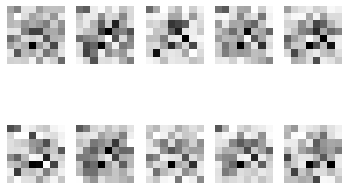

Batch 1162/1875 - Opimize G - Avg Batch Loss: 0.7747 - Time : 2.73s
Batch 1163/1875 - Opimize G - Avg Batch Loss: 0.9417 - Time : 2.87s
Batch 1164/1875 - Opimize G - Avg Batch Loss: 0.8020 - Time : 2.69s
Batch 1165/1875 - Opimize D - Avg Batch Loss: 0.7480 - Time : 3.14s
Batch 1166/1875 - Opimize G - Avg Batch Loss: 0.6236 - Time : 3.02s
Batch 1167/1875 - Opimize G - Avg Batch Loss: 0.7540 - Time : 2.97s
Batch 1168/1875 - Opimize G - Avg Batch Loss: 0.6958 - Time : 2.77s
Batch 1169/1875 - Opimize G - Avg Batch Loss: 0.7835 - Time : 2.69s
Batch 1170/1875 - Opimize G - Avg Batch Loss: 0.6196 - Time : 2.91s
Batch 1171/1875 - Opimize D - Avg Batch Loss: 0.7372 - Time : 2.93s


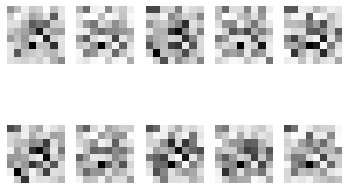

Batch 1172/1875 - Opimize G - Avg Batch Loss: 0.6633 - Time : 2.72s
Batch 1173/1875 - Opimize G - Avg Batch Loss: 0.8445 - Time : 2.71s
Batch 1174/1875 - Opimize G - Avg Batch Loss: 0.7553 - Time : 2.68s
Batch 1175/1875 - Opimize G - Avg Batch Loss: 0.6933 - Time : 2.66s
Batch 1176/1875 - Opimize G - Avg Batch Loss: 0.6115 - Time : 2.71s
Batch 1177/1875 - Opimize D - Avg Batch Loss: 0.8450 - Time : 3.18s
Batch 1178/1875 - Opimize G - Avg Batch Loss: 0.8645 - Time : 2.96s
Batch 1179/1875 - Opimize G - Avg Batch Loss: 0.9588 - Time : 2.73s
Batch 1180/1875 - Opimize G - Avg Batch Loss: 0.7655 - Time : 2.73s
Batch 1181/1875 - Opimize G - Avg Batch Loss: 0.8390 - Time : 2.64s


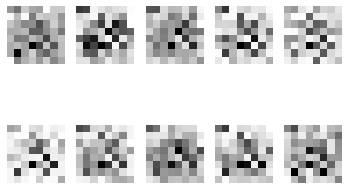

Batch 1182/1875 - Opimize G - Avg Batch Loss: 0.7499 - Time : 3.08s
Batch 1183/1875 - Opimize D - Avg Batch Loss: 0.8040 - Time : 2.96s
Batch 1184/1875 - Opimize G - Avg Batch Loss: 0.8703 - Time : 2.92s
Batch 1185/1875 - Opimize G - Avg Batch Loss: 0.8852 - Time : 2.70s
Batch 1186/1875 - Opimize G - Avg Batch Loss: 0.8176 - Time : 2.89s
Batch 1187/1875 - Opimize G - Avg Batch Loss: 0.7525 - Time : 2.68s
Batch 1188/1875 - Opimize G - Avg Batch Loss: 0.7949 - Time : 2.70s
Batch 1189/1875 - Opimize D - Avg Batch Loss: 0.8947 - Time : 2.68s
Batch 1190/1875 - Opimize G - Avg Batch Loss: 0.6978 - Time : 2.83s
Batch 1191/1875 - Opimize G - Avg Batch Loss: 0.7753 - Time : 2.73s


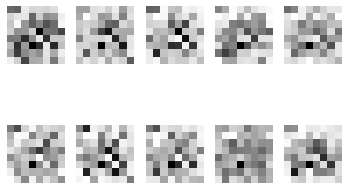

Batch 1192/1875 - Opimize G - Avg Batch Loss: 0.6170 - Time : 2.68s
Batch 1193/1875 - Opimize G - Avg Batch Loss: 0.7861 - Time : 2.72s
Batch 1194/1875 - Opimize G - Avg Batch Loss: 0.7319 - Time : 2.69s
Batch 1195/1875 - Opimize D - Avg Batch Loss: 0.6960 - Time : 2.76s
Batch 1196/1875 - Opimize G - Avg Batch Loss: 0.7591 - Time : 2.71s
Batch 1197/1875 - Opimize G - Avg Batch Loss: 0.8256 - Time : 2.74s
Batch 1198/1875 - Opimize G - Avg Batch Loss: 0.5996 - Time : 2.68s
Batch 1199/1875 - Opimize G - Avg Batch Loss: 0.6905 - Time : 2.75s
Batch 1200/1875 - Opimize G - Avg Batch Loss: 0.7746 - Time : 2.89s
Batch 1201/1875 - Opimize D - Avg Batch Loss: 0.6382 - Time : 2.73s


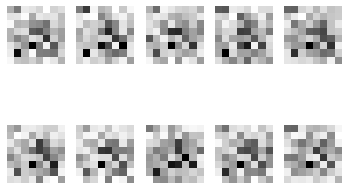

Batch 1202/1875 - Opimize G - Avg Batch Loss: 0.7671 - Time : 2.77s
Batch 1203/1875 - Opimize G - Avg Batch Loss: 0.8650 - Time : 2.83s
Batch 1204/1875 - Opimize G - Avg Batch Loss: 0.6968 - Time : 2.77s
Batch 1205/1875 - Opimize G - Avg Batch Loss: 0.6714 - Time : 2.68s
Batch 1206/1875 - Opimize G - Avg Batch Loss: 0.8241 - Time : 2.80s
Batch 1207/1875 - Opimize D - Avg Batch Loss: 0.7239 - Time : 2.70s
Batch 1208/1875 - Opimize G - Avg Batch Loss: 0.8940 - Time : 2.72s
Batch 1209/1875 - Opimize G - Avg Batch Loss: 0.7091 - Time : 2.82s
Batch 1210/1875 - Opimize G - Avg Batch Loss: 0.6100 - Time : 2.96s
Batch 1211/1875 - Opimize G - Avg Batch Loss: 0.6484 - Time : 2.97s


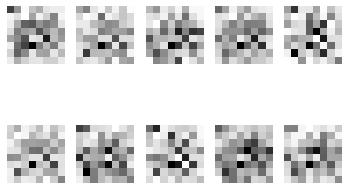

Batch 1212/1875 - Opimize G - Avg Batch Loss: 0.7408 - Time : 2.68s
Batch 1213/1875 - Opimize D - Avg Batch Loss: 0.8013 - Time : 2.87s
Batch 1214/1875 - Opimize G - Avg Batch Loss: 0.7465 - Time : 2.80s
Batch 1215/1875 - Opimize G - Avg Batch Loss: 0.8305 - Time : 2.95s
Batch 1216/1875 - Opimize G - Avg Batch Loss: 0.8488 - Time : 2.72s
Batch 1217/1875 - Opimize G - Avg Batch Loss: 0.6318 - Time : 2.71s
Batch 1218/1875 - Opimize G - Avg Batch Loss: 0.6589 - Time : 2.87s
Batch 1219/1875 - Opimize D - Avg Batch Loss: 0.8314 - Time : 2.69s
Batch 1220/1875 - Opimize G - Avg Batch Loss: 0.7901 - Time : 2.68s
Batch 1221/1875 - Opimize G - Avg Batch Loss: 0.7686 - Time : 2.87s


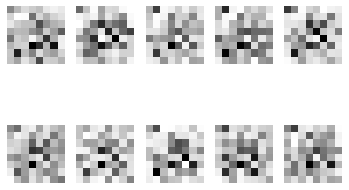

Batch 1222/1875 - Opimize G - Avg Batch Loss: 0.7527 - Time : 2.72s
Batch 1223/1875 - Opimize G - Avg Batch Loss: 0.6876 - Time : 2.70s
Batch 1224/1875 - Opimize G - Avg Batch Loss: 0.7021 - Time : 2.75s
Batch 1225/1875 - Opimize D - Avg Batch Loss: 0.7939 - Time : 3.03s
Batch 1226/1875 - Opimize G - Avg Batch Loss: 0.7538 - Time : 2.84s
Batch 1227/1875 - Opimize G - Avg Batch Loss: 0.8869 - Time : 2.65s
Batch 1228/1875 - Opimize G - Avg Batch Loss: 0.9040 - Time : 2.69s
Batch 1229/1875 - Opimize G - Avg Batch Loss: 0.6659 - Time : 2.70s
Batch 1230/1875 - Opimize G - Avg Batch Loss: 0.7448 - Time : 2.73s
Batch 1231/1875 - Opimize D - Avg Batch Loss: 0.6562 - Time : 2.65s


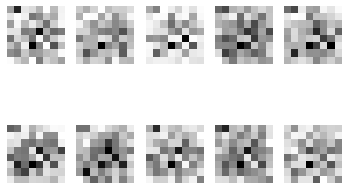

Batch 1232/1875 - Opimize G - Avg Batch Loss: 0.6978 - Time : 2.90s
Batch 1233/1875 - Opimize G - Avg Batch Loss: 0.7799 - Time : 2.72s
Batch 1234/1875 - Opimize G - Avg Batch Loss: 0.7535 - Time : 2.66s
Batch 1235/1875 - Opimize G - Avg Batch Loss: 0.6669 - Time : 2.75s
Batch 1236/1875 - Opimize G - Avg Batch Loss: 0.8140 - Time : 2.84s
Batch 1237/1875 - Opimize D - Avg Batch Loss: 0.6851 - Time : 2.66s
Batch 1238/1875 - Opimize G - Avg Batch Loss: 0.7567 - Time : 2.92s
Batch 1239/1875 - Opimize G - Avg Batch Loss: 0.7465 - Time : 2.69s
Batch 1240/1875 - Opimize G - Avg Batch Loss: 0.6727 - Time : 2.82s
Batch 1241/1875 - Opimize G - Avg Batch Loss: 0.8686 - Time : 2.76s


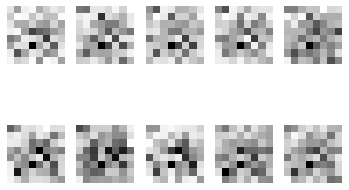

Batch 1242/1875 - Opimize G - Avg Batch Loss: 0.8049 - Time : 2.73s
Batch 1243/1875 - Opimize D - Avg Batch Loss: 0.8076 - Time : 2.94s
Batch 1244/1875 - Opimize G - Avg Batch Loss: 0.7297 - Time : 2.98s
Batch 1245/1875 - Opimize G - Avg Batch Loss: 0.7363 - Time : 2.73s
Batch 1246/1875 - Opimize G - Avg Batch Loss: 0.7971 - Time : 2.75s
Batch 1247/1875 - Opimize G - Avg Batch Loss: 0.7111 - Time : 2.91s
Batch 1248/1875 - Opimize G - Avg Batch Loss: 0.7447 - Time : 2.63s
Batch 1249/1875 - Opimize D - Avg Batch Loss: 0.8212 - Time : 2.93s
Batch 1250/1875 - Opimize G - Avg Batch Loss: 1.0256 - Time : 2.92s
Batch 1251/1875 - Opimize G - Avg Batch Loss: 0.6724 - Time : 2.70s


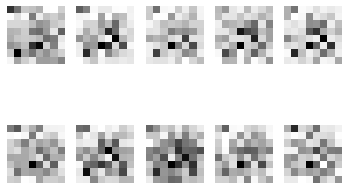

Batch 1252/1875 - Opimize G - Avg Batch Loss: 0.6716 - Time : 2.70s
Batch 1253/1875 - Opimize G - Avg Batch Loss: 0.7891 - Time : 2.95s
Batch 1254/1875 - Opimize G - Avg Batch Loss: 0.6832 - Time : 2.98s
Batch 1255/1875 - Opimize D - Avg Batch Loss: 0.6421 - Time : 2.69s
Batch 1256/1875 - Opimize G - Avg Batch Loss: 0.6697 - Time : 2.73s
Batch 1257/1875 - Opimize G - Avg Batch Loss: 0.8599 - Time : 2.65s
Batch 1258/1875 - Opimize G - Avg Batch Loss: 0.8118 - Time : 2.92s
Batch 1259/1875 - Opimize G - Avg Batch Loss: 0.6108 - Time : 2.77s
Batch 1260/1875 - Opimize G - Avg Batch Loss: 0.7101 - Time : 2.65s
Batch 1261/1875 - Opimize D - Avg Batch Loss: 0.6830 - Time : 2.78s


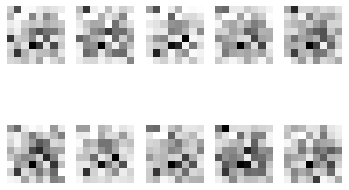

Batch 1262/1875 - Opimize G - Avg Batch Loss: 0.8915 - Time : 2.95s
Batch 1263/1875 - Opimize G - Avg Batch Loss: 0.7109 - Time : 2.73s
Batch 1264/1875 - Opimize G - Avg Batch Loss: 0.6204 - Time : 2.69s
Batch 1265/1875 - Opimize G - Avg Batch Loss: 0.5804 - Time : 2.96s
Batch 1266/1875 - Opimize G - Avg Batch Loss: 0.6943 - Time : 2.77s
Batch 1267/1875 - Opimize D - Avg Batch Loss: 0.5389 - Time : 2.73s
Batch 1268/1875 - Opimize G - Avg Batch Loss: 0.6888 - Time : 2.70s
Batch 1269/1875 - Opimize G - Avg Batch Loss: 0.6682 - Time : 3.20s
Batch 1270/1875 - Opimize G - Avg Batch Loss: 0.7752 - Time : 2.66s
Batch 1271/1875 - Opimize G - Avg Batch Loss: 0.6348 - Time : 2.71s


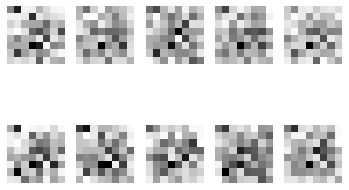

Batch 1272/1875 - Opimize G - Avg Batch Loss: 0.9109 - Time : 2.75s
Batch 1273/1875 - Opimize D - Avg Batch Loss: 0.6050 - Time : 2.72s
Batch 1274/1875 - Opimize G - Avg Batch Loss: 0.7157 - Time : 2.67s
Batch 1275/1875 - Opimize G - Avg Batch Loss: 0.6956 - Time : 2.96s
Batch 1276/1875 - Opimize G - Avg Batch Loss: 0.7630 - Time : 2.72s
Batch 1277/1875 - Opimize G - Avg Batch Loss: 0.7031 - Time : 2.99s
Batch 1278/1875 - Opimize G - Avg Batch Loss: 0.6944 - Time : 2.67s
Batch 1279/1875 - Opimize D - Avg Batch Loss: 0.6461 - Time : 3.19s
Batch 1280/1875 - Opimize G - Avg Batch Loss: 0.7314 - Time : 2.76s
Batch 1281/1875 - Opimize G - Avg Batch Loss: 0.7100 - Time : 2.61s


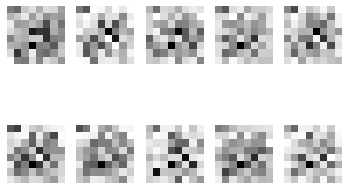

Batch 1282/1875 - Opimize G - Avg Batch Loss: 0.4751 - Time : 2.80s
Batch 1283/1875 - Opimize G - Avg Batch Loss: 0.6934 - Time : 2.71s
Batch 1284/1875 - Opimize G - Avg Batch Loss: 0.6400 - Time : 2.90s
Batch 1285/1875 - Opimize D - Avg Batch Loss: 0.5937 - Time : 2.81s
Batch 1286/1875 - Opimize G - Avg Batch Loss: 0.7113 - Time : 2.84s
Batch 1287/1875 - Opimize G - Avg Batch Loss: 0.5813 - Time : 2.92s
Batch 1288/1875 - Opimize G - Avg Batch Loss: 0.6972 - Time : 2.73s
Batch 1289/1875 - Opimize G - Avg Batch Loss: 0.7288 - Time : 2.87s
Batch 1290/1875 - Opimize G - Avg Batch Loss: 0.6532 - Time : 3.00s
Batch 1291/1875 - Opimize D - Avg Batch Loss: 0.6473 - Time : 2.77s


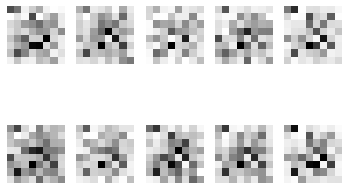

Batch 1292/1875 - Opimize G - Avg Batch Loss: 0.7735 - Time : 2.66s
Batch 1293/1875 - Opimize G - Avg Batch Loss: 0.5854 - Time : 2.67s
Batch 1294/1875 - Opimize G - Avg Batch Loss: 0.8030 - Time : 2.75s
Batch 1295/1875 - Opimize G - Avg Batch Loss: 0.7077 - Time : 2.94s
Batch 1296/1875 - Opimize G - Avg Batch Loss: 0.6407 - Time : 2.67s
Batch 1297/1875 - Opimize D - Avg Batch Loss: 0.6976 - Time : 2.85s
Batch 1298/1875 - Opimize G - Avg Batch Loss: 0.7123 - Time : 2.76s
Batch 1299/1875 - Opimize G - Avg Batch Loss: 0.6708 - Time : 2.65s
Batch 1300/1875 - Opimize G - Avg Batch Loss: 0.7425 - Time : 2.94s
Batch 1301/1875 - Opimize G - Avg Batch Loss: 0.7963 - Time : 2.65s


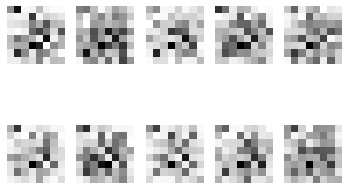

Batch 1302/1875 - Opimize G - Avg Batch Loss: 0.6635 - Time : 2.73s
Batch 1303/1875 - Opimize D - Avg Batch Loss: 0.6033 - Time : 2.93s
Batch 1304/1875 - Opimize G - Avg Batch Loss: 0.5769 - Time : 3.18s
Batch 1305/1875 - Opimize G - Avg Batch Loss: 0.5910 - Time : 2.69s
Batch 1306/1875 - Opimize G - Avg Batch Loss: 0.6184 - Time : 2.91s
Batch 1307/1875 - Opimize G - Avg Batch Loss: 0.5568 - Time : 3.10s
Batch 1308/1875 - Opimize G - Avg Batch Loss: 0.6937 - Time : 2.92s
Batch 1309/1875 - Opimize D - Avg Batch Loss: 0.5682 - Time : 2.72s
Batch 1310/1875 - Opimize G - Avg Batch Loss: 0.7630 - Time : 2.69s
Batch 1311/1875 - Opimize G - Avg Batch Loss: 0.7673 - Time : 2.69s


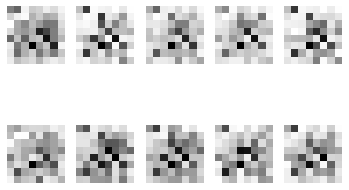

Batch 1312/1875 - Opimize G - Avg Batch Loss: 0.4555 - Time : 2.89s
Batch 1313/1875 - Opimize G - Avg Batch Loss: 0.6839 - Time : 2.90s
Batch 1314/1875 - Opimize G - Avg Batch Loss: 0.5937 - Time : 2.65s
Batch 1315/1875 - Opimize D - Avg Batch Loss: 0.5870 - Time : 2.77s
Batch 1316/1875 - Opimize G - Avg Batch Loss: 0.6728 - Time : 3.23s
Batch 1317/1875 - Opimize G - Avg Batch Loss: 0.6016 - Time : 2.73s
Batch 1318/1875 - Opimize G - Avg Batch Loss: 0.6265 - Time : 2.70s
Batch 1319/1875 - Opimize G - Avg Batch Loss: 0.4785 - Time : 2.69s
Batch 1320/1875 - Opimize G - Avg Batch Loss: 0.6332 - Time : 2.63s
Batch 1321/1875 - Opimize D - Avg Batch Loss: 0.5825 - Time : 2.85s


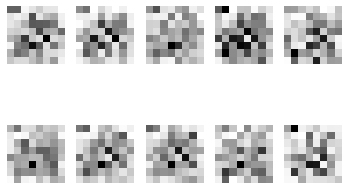

Batch 1322/1875 - Opimize G - Avg Batch Loss: 0.7214 - Time : 2.94s
Batch 1323/1875 - Opimize G - Avg Batch Loss: 0.7162 - Time : 2.65s
Batch 1324/1875 - Opimize G - Avg Batch Loss: 0.7574 - Time : 2.74s
Batch 1325/1875 - Opimize G - Avg Batch Loss: 0.8041 - Time : 2.88s
Batch 1326/1875 - Opimize G - Avg Batch Loss: 0.6864 - Time : 2.78s
Batch 1327/1875 - Opimize D - Avg Batch Loss: 0.7198 - Time : 2.81s
Batch 1328/1875 - Opimize G - Avg Batch Loss: 0.8905 - Time : 2.85s
Batch 1329/1875 - Opimize G - Avg Batch Loss: 0.6321 - Time : 2.68s
Batch 1330/1875 - Opimize G - Avg Batch Loss: 0.6692 - Time : 3.00s
Batch 1331/1875 - Opimize G - Avg Batch Loss: 0.7254 - Time : 2.88s


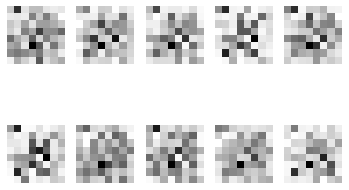

Batch 1332/1875 - Opimize G - Avg Batch Loss: 0.6292 - Time : 2.72s
Batch 1333/1875 - Opimize D - Avg Batch Loss: 0.7070 - Time : 2.72s
Batch 1334/1875 - Opimize G - Avg Batch Loss: 0.4512 - Time : 2.80s
Batch 1335/1875 - Opimize G - Avg Batch Loss: 0.6597 - Time : 2.71s
Batch 1336/1875 - Opimize G - Avg Batch Loss: 0.6332 - Time : 2.64s
Batch 1337/1875 - Opimize G - Avg Batch Loss: 0.6565 - Time : 2.71s
Batch 1338/1875 - Opimize G - Avg Batch Loss: 0.6729 - Time : 2.71s
Batch 1339/1875 - Opimize D - Avg Batch Loss: 0.6919 - Time : 2.69s
Batch 1340/1875 - Opimize G - Avg Batch Loss: 0.6660 - Time : 2.78s
Batch 1341/1875 - Opimize G - Avg Batch Loss: 0.6518 - Time : 2.72s


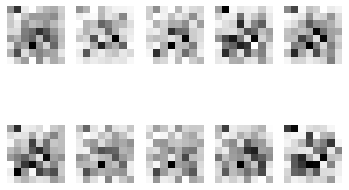

Batch 1342/1875 - Opimize G - Avg Batch Loss: 0.5398 - Time : 2.93s
Batch 1343/1875 - Opimize G - Avg Batch Loss: 0.5970 - Time : 2.68s
Batch 1344/1875 - Opimize G - Avg Batch Loss: 0.5789 - Time : 2.70s
Batch 1345/1875 - Opimize D - Avg Batch Loss: 0.4561 - Time : 2.76s
Batch 1346/1875 - Opimize G - Avg Batch Loss: 0.6175 - Time : 3.13s
Batch 1347/1875 - Opimize G - Avg Batch Loss: 0.5466 - Time : 2.75s
Batch 1348/1875 - Opimize G - Avg Batch Loss: 0.7278 - Time : 2.73s
Batch 1349/1875 - Opimize G - Avg Batch Loss: 0.6376 - Time : 2.67s
Batch 1350/1875 - Opimize G - Avg Batch Loss: 0.5630 - Time : 2.75s
Batch 1351/1875 - Opimize D - Avg Batch Loss: 0.7428 - Time : 2.68s


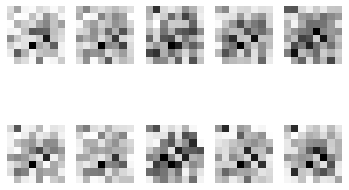

Batch 1352/1875 - Opimize G - Avg Batch Loss: 0.7130 - Time : 2.73s
Batch 1353/1875 - Opimize G - Avg Batch Loss: 0.6240 - Time : 3.19s
Batch 1354/1875 - Opimize G - Avg Batch Loss: 0.6294 - Time : 2.92s
Batch 1355/1875 - Opimize G - Avg Batch Loss: 0.8057 - Time : 2.75s
Batch 1356/1875 - Opimize G - Avg Batch Loss: 0.4718 - Time : 2.70s
Batch 1357/1875 - Opimize D - Avg Batch Loss: 0.7022 - Time : 2.69s
Batch 1358/1875 - Opimize G - Avg Batch Loss: 0.6080 - Time : 2.71s
Batch 1359/1875 - Opimize G - Avg Batch Loss: 0.6741 - Time : 2.71s
Batch 1360/1875 - Opimize G - Avg Batch Loss: 0.7380 - Time : 2.98s
Batch 1361/1875 - Opimize G - Avg Batch Loss: 0.5457 - Time : 2.69s


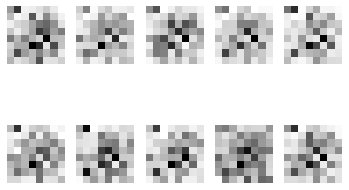

Batch 1362/1875 - Opimize G - Avg Batch Loss: 0.6584 - Time : 2.66s
Batch 1363/1875 - Opimize D - Avg Batch Loss: 0.7575 - Time : 2.66s
Batch 1364/1875 - Opimize G - Avg Batch Loss: 0.5635 - Time : 2.71s
Batch 1365/1875 - Opimize G - Avg Batch Loss: 0.5011 - Time : 2.70s
Batch 1366/1875 - Opimize G - Avg Batch Loss: 0.6123 - Time : 2.92s
Batch 1367/1875 - Opimize G - Avg Batch Loss: 0.5213 - Time : 2.74s
Batch 1368/1875 - Opimize G - Avg Batch Loss: 0.8351 - Time : 2.70s
Batch 1369/1875 - Opimize D - Avg Batch Loss: 0.7235 - Time : 2.69s
Batch 1370/1875 - Opimize G - Avg Batch Loss: 0.7346 - Time : 2.67s
Batch 1371/1875 - Opimize G - Avg Batch Loss: 0.7032 - Time : 2.93s


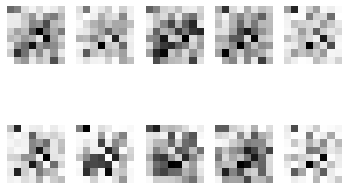

Batch 1372/1875 - Opimize G - Avg Batch Loss: 0.7809 - Time : 2.74s
Batch 1373/1875 - Opimize G - Avg Batch Loss: 0.7452 - Time : 2.90s
Batch 1374/1875 - Opimize G - Avg Batch Loss: 0.4695 - Time : 2.73s
Batch 1375/1875 - Opimize D - Avg Batch Loss: 0.5885 - Time : 2.69s
Batch 1376/1875 - Opimize G - Avg Batch Loss: 0.6907 - Time : 2.97s
Batch 1377/1875 - Opimize G - Avg Batch Loss: 0.6513 - Time : 2.72s
Batch 1378/1875 - Opimize G - Avg Batch Loss: 0.7575 - Time : 2.67s
Batch 1379/1875 - Opimize G - Avg Batch Loss: 0.5765 - Time : 2.69s
Batch 1380/1875 - Opimize G - Avg Batch Loss: 0.6503 - Time : 2.96s
Batch 1381/1875 - Opimize D - Avg Batch Loss: 0.4891 - Time : 2.69s


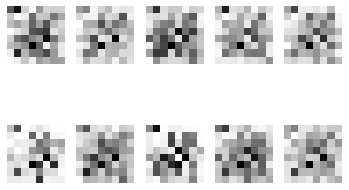

Batch 1382/1875 - Opimize G - Avg Batch Loss: 0.7792 - Time : 2.71s
Batch 1383/1875 - Opimize G - Avg Batch Loss: 0.7699 - Time : 2.87s
Batch 1384/1875 - Opimize G - Avg Batch Loss: 0.6369 - Time : 2.71s
Batch 1385/1875 - Opimize G - Avg Batch Loss: 0.5423 - Time : 2.68s
Batch 1386/1875 - Opimize G - Avg Batch Loss: 0.5773 - Time : 2.71s
Batch 1387/1875 - Opimize D - Avg Batch Loss: 0.6154 - Time : 3.15s
Batch 1388/1875 - Opimize G - Avg Batch Loss: 0.5559 - Time : 2.83s
Batch 1389/1875 - Opimize G - Avg Batch Loss: 0.6553 - Time : 2.86s
Batch 1390/1875 - Opimize G - Avg Batch Loss: 0.6013 - Time : 2.76s
Batch 1391/1875 - Opimize G - Avg Batch Loss: 0.7728 - Time : 2.92s


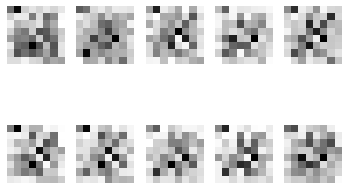

Batch 1392/1875 - Opimize G - Avg Batch Loss: 0.5263 - Time : 2.72s
Batch 1393/1875 - Opimize D - Avg Batch Loss: 0.7222 - Time : 2.90s
Batch 1394/1875 - Opimize G - Avg Batch Loss: 0.6901 - Time : 2.86s
Batch 1395/1875 - Opimize G - Avg Batch Loss: 0.6072 - Time : 2.65s
Batch 1396/1875 - Opimize G - Avg Batch Loss: 0.6079 - Time : 2.96s
Batch 1397/1875 - Opimize G - Avg Batch Loss: 0.8057 - Time : 2.77s
Batch 1398/1875 - Opimize G - Avg Batch Loss: 0.6770 - Time : 2.70s
Batch 1399/1875 - Opimize D - Avg Batch Loss: 0.5187 - Time : 2.71s
Batch 1400/1875 - Opimize G - Avg Batch Loss: 0.8781 - Time : 2.98s
Batch 1401/1875 - Opimize G - Avg Batch Loss: 0.5203 - Time : 3.04s


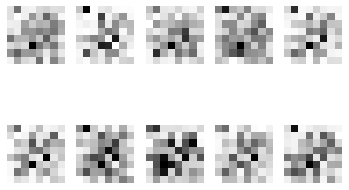

Batch 1402/1875 - Opimize G - Avg Batch Loss: 0.6267 - Time : 2.68s
Batch 1403/1875 - Opimize G - Avg Batch Loss: 0.6852 - Time : 2.97s
Batch 1404/1875 - Opimize G - Avg Batch Loss: 0.7206 - Time : 2.78s
Batch 1405/1875 - Opimize D - Avg Batch Loss: 0.7193 - Time : 2.78s
Batch 1406/1875 - Opimize G - Avg Batch Loss: 0.7039 - Time : 2.90s
Batch 1407/1875 - Opimize G - Avg Batch Loss: 0.7033 - Time : 2.93s
Batch 1408/1875 - Opimize G - Avg Batch Loss: 0.6086 - Time : 2.95s
Batch 1409/1875 - Opimize G - Avg Batch Loss: 0.6450 - Time : 2.67s
Batch 1410/1875 - Opimize G - Avg Batch Loss: 0.4707 - Time : 2.93s
Batch 1411/1875 - Opimize D - Avg Batch Loss: 0.5700 - Time : 2.85s


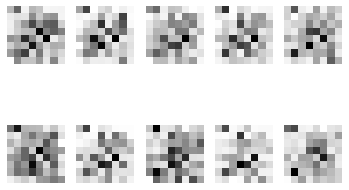

Batch 1412/1875 - Opimize G - Avg Batch Loss: 0.6537 - Time : 2.71s
Batch 1413/1875 - Opimize G - Avg Batch Loss: 0.6509 - Time : 2.68s
Batch 1414/1875 - Opimize G - Avg Batch Loss: 0.6563 - Time : 2.77s
Batch 1415/1875 - Opimize G - Avg Batch Loss: 0.6374 - Time : 2.68s
Batch 1416/1875 - Opimize G - Avg Batch Loss: 0.4498 - Time : 2.71s
Batch 1417/1875 - Opimize D - Avg Batch Loss: 0.5168 - Time : 2.91s
Batch 1418/1875 - Opimize G - Avg Batch Loss: 0.6780 - Time : 2.66s
Batch 1419/1875 - Opimize G - Avg Batch Loss: 0.5528 - Time : 2.71s
Batch 1420/1875 - Opimize G - Avg Batch Loss: 0.7447 - Time : 2.69s
Batch 1421/1875 - Opimize G - Avg Batch Loss: 0.6482 - Time : 2.77s


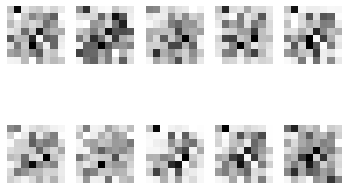

Batch 1422/1875 - Opimize G - Avg Batch Loss: 0.5551 - Time : 2.73s
Batch 1423/1875 - Opimize D - Avg Batch Loss: 0.5611 - Time : 2.93s
Batch 1424/1875 - Opimize G - Avg Batch Loss: 0.7632 - Time : 2.94s
Batch 1425/1875 - Opimize G - Avg Batch Loss: 0.5027 - Time : 2.75s
Batch 1426/1875 - Opimize G - Avg Batch Loss: 0.5815 - Time : 2.75s
Batch 1427/1875 - Opimize G - Avg Batch Loss: 0.6503 - Time : 2.86s
Batch 1428/1875 - Opimize G - Avg Batch Loss: 0.6006 - Time : 2.71s
Batch 1429/1875 - Opimize D - Avg Batch Loss: 0.5793 - Time : 2.73s
Batch 1430/1875 - Opimize G - Avg Batch Loss: 0.7567 - Time : 2.92s
Batch 1431/1875 - Opimize G - Avg Batch Loss: 0.5257 - Time : 2.66s


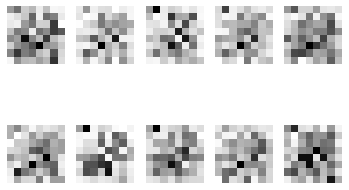

Batch 1432/1875 - Opimize G - Avg Batch Loss: 0.6230 - Time : 2.68s
Batch 1433/1875 - Opimize G - Avg Batch Loss: 0.6417 - Time : 2.91s
Batch 1434/1875 - Opimize G - Avg Batch Loss: 0.5190 - Time : 2.76s
Batch 1435/1875 - Opimize D - Avg Batch Loss: 0.5526 - Time : 3.20s
Batch 1436/1875 - Opimize G - Avg Batch Loss: 0.5783 - Time : 2.79s
Batch 1437/1875 - Opimize G - Avg Batch Loss: 0.6193 - Time : 2.66s
Batch 1438/1875 - Opimize G - Avg Batch Loss: 0.7627 - Time : 2.95s
Batch 1439/1875 - Opimize G - Avg Batch Loss: 0.6918 - Time : 2.66s
Batch 1440/1875 - Opimize G - Avg Batch Loss: 0.7202 - Time : 2.76s
Batch 1441/1875 - Opimize D - Avg Batch Loss: 0.6777 - Time : 2.87s


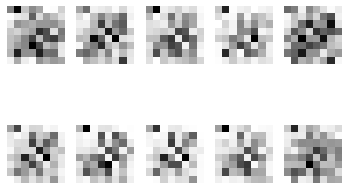

Batch 1442/1875 - Opimize G - Avg Batch Loss: 0.6118 - Time : 3.18s
Batch 1443/1875 - Opimize G - Avg Batch Loss: 0.6142 - Time : 3.53s
Batch 1444/1875 - Opimize G - Avg Batch Loss: 0.5706 - Time : 2.82s
Batch 1445/1875 - Opimize G - Avg Batch Loss: 0.5152 - Time : 2.68s
Batch 1446/1875 - Opimize G - Avg Batch Loss: 0.7245 - Time : 2.70s
Batch 1447/1875 - Opimize D - Avg Batch Loss: 0.4465 - Time : 2.84s
Batch 1448/1875 - Opimize G - Avg Batch Loss: 0.7116 - Time : 2.79s
Batch 1449/1875 - Opimize G - Avg Batch Loss: 0.5516 - Time : 2.78s
Batch 1450/1875 - Opimize G - Avg Batch Loss: 0.5536 - Time : 2.75s
Batch 1451/1875 - Opimize G - Avg Batch Loss: 0.7591 - Time : 2.69s


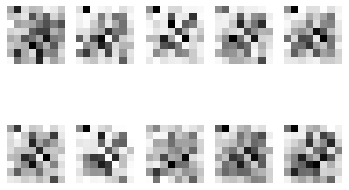

Batch 1452/1875 - Opimize G - Avg Batch Loss: 0.6646 - Time : 3.16s
Batch 1453/1875 - Opimize D - Avg Batch Loss: 0.6666 - Time : 2.83s
Batch 1454/1875 - Opimize G - Avg Batch Loss: 0.5390 - Time : 2.92s
Batch 1455/1875 - Opimize G - Avg Batch Loss: 0.6517 - Time : 2.72s
Batch 1456/1875 - Opimize G - Avg Batch Loss: 0.4915 - Time : 2.95s
Batch 1457/1875 - Opimize G - Avg Batch Loss: 0.5153 - Time : 2.74s
Batch 1458/1875 - Opimize G - Avg Batch Loss: 0.5307 - Time : 2.95s
Batch 1459/1875 - Opimize D - Avg Batch Loss: 0.6901 - Time : 2.73s
Batch 1460/1875 - Opimize G - Avg Batch Loss: 0.6752 - Time : 2.68s
Batch 1461/1875 - Opimize G - Avg Batch Loss: 0.5152 - Time : 2.75s


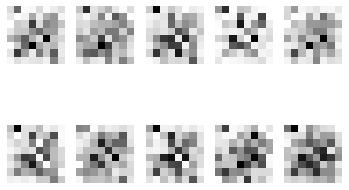

Batch 1462/1875 - Opimize G - Avg Batch Loss: 0.5912 - Time : 2.91s
Batch 1463/1875 - Opimize G - Avg Batch Loss: 0.4894 - Time : 2.72s
Batch 1464/1875 - Opimize G - Avg Batch Loss: 0.6790 - Time : 2.92s
Batch 1465/1875 - Opimize D - Avg Batch Loss: 0.4920 - Time : 2.69s
Batch 1466/1875 - Opimize G - Avg Batch Loss: 0.4936 - Time : 2.94s
Batch 1467/1875 - Opimize G - Avg Batch Loss: 0.6047 - Time : 2.74s
Batch 1468/1875 - Opimize G - Avg Batch Loss: 0.6427 - Time : 2.96s
Batch 1469/1875 - Opimize G - Avg Batch Loss: 0.6077 - Time : 2.88s
Batch 1470/1875 - Opimize G - Avg Batch Loss: 0.5939 - Time : 2.72s
Batch 1471/1875 - Opimize D - Avg Batch Loss: 0.6868 - Time : 2.83s


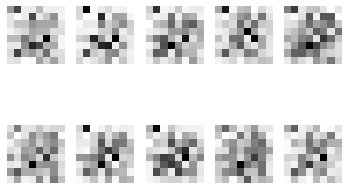

Batch 1472/1875 - Opimize G - Avg Batch Loss: 0.5534 - Time : 2.69s
Batch 1473/1875 - Opimize G - Avg Batch Loss: 0.7073 - Time : 2.65s
Batch 1474/1875 - Opimize G - Avg Batch Loss: 0.6422 - Time : 2.94s
Batch 1475/1875 - Opimize G - Avg Batch Loss: 0.5563 - Time : 2.74s
Batch 1476/1875 - Opimize G - Avg Batch Loss: 0.5678 - Time : 2.78s
Batch 1477/1875 - Opimize D - Avg Batch Loss: 0.6518 - Time : 2.80s
Batch 1478/1875 - Opimize G - Avg Batch Loss: 0.5760 - Time : 2.66s
Batch 1479/1875 - Opimize G - Avg Batch Loss: 0.6362 - Time : 2.95s
Batch 1480/1875 - Opimize G - Avg Batch Loss: 0.6863 - Time : 2.63s
Batch 1481/1875 - Opimize G - Avg Batch Loss: 0.5377 - Time : 2.67s


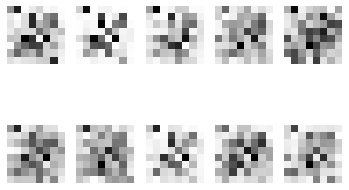

Batch 1482/1875 - Opimize G - Avg Batch Loss: 0.6174 - Time : 2.74s
Batch 1483/1875 - Opimize D - Avg Batch Loss: 0.5833 - Time : 2.70s
Batch 1484/1875 - Opimize G - Avg Batch Loss: 0.6756 - Time : 2.96s
Batch 1485/1875 - Opimize G - Avg Batch Loss: 0.5493 - Time : 2.96s
Batch 1486/1875 - Opimize G - Avg Batch Loss: 0.5778 - Time : 2.76s
Batch 1487/1875 - Opimize G - Avg Batch Loss: 0.4228 - Time : 2.66s
Batch 1488/1875 - Opimize G - Avg Batch Loss: 0.5872 - Time : 2.71s
Batch 1489/1875 - Opimize D - Avg Batch Loss: 0.5906 - Time : 2.82s
Batch 1490/1875 - Opimize G - Avg Batch Loss: 0.5730 - Time : 2.80s
Batch 1491/1875 - Opimize G - Avg Batch Loss: 0.5636 - Time : 2.70s


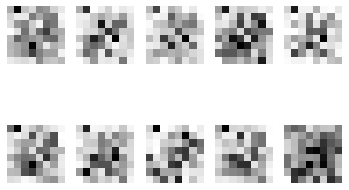

Batch 1492/1875 - Opimize G - Avg Batch Loss: 0.7222 - Time : 2.65s
Batch 1493/1875 - Opimize G - Avg Batch Loss: 0.5801 - Time : 2.64s
Batch 1494/1875 - Opimize G - Avg Batch Loss: 0.6076 - Time : 2.64s
Batch 1495/1875 - Opimize D - Avg Batch Loss: 0.4400 - Time : 2.71s
Batch 1496/1875 - Opimize G - Avg Batch Loss: 0.5621 - Time : 2.65s
Batch 1497/1875 - Opimize G - Avg Batch Loss: 0.5568 - Time : 2.95s
Batch 1498/1875 - Opimize G - Avg Batch Loss: 0.5534 - Time : 2.68s
Batch 1499/1875 - Opimize G - Avg Batch Loss: 0.5759 - Time : 2.91s
Batch 1500/1875 - Opimize G - Avg Batch Loss: 0.5468 - Time : 2.74s
Batch 1501/1875 - Opimize D - Avg Batch Loss: 0.5800 - Time : 2.70s


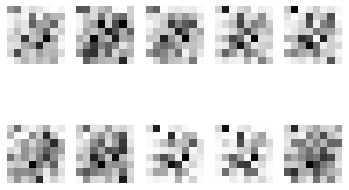

Batch 1502/1875 - Opimize G - Avg Batch Loss: 0.6060 - Time : 2.94s
Batch 1503/1875 - Opimize G - Avg Batch Loss: 0.6304 - Time : 2.67s
Batch 1504/1875 - Opimize G - Avg Batch Loss: 0.5255 - Time : 2.76s
Batch 1505/1875 - Opimize G - Avg Batch Loss: 0.6145 - Time : 2.72s
Batch 1506/1875 - Opimize G - Avg Batch Loss: 0.6840 - Time : 2.85s
Batch 1507/1875 - Opimize D - Avg Batch Loss: 0.4135 - Time : 2.91s
Batch 1508/1875 - Opimize G - Avg Batch Loss: 0.4964 - Time : 2.90s
Batch 1509/1875 - Opimize G - Avg Batch Loss: 0.5317 - Time : 2.85s
Batch 1510/1875 - Opimize G - Avg Batch Loss: 0.6192 - Time : 2.69s
Batch 1511/1875 - Opimize G - Avg Batch Loss: 0.5582 - Time : 2.87s


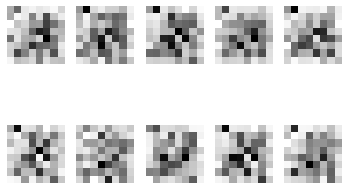

Batch 1512/1875 - Opimize G - Avg Batch Loss: 0.5951 - Time : 2.72s
Batch 1513/1875 - Opimize D - Avg Batch Loss: 0.6054 - Time : 2.70s
Batch 1514/1875 - Opimize G - Avg Batch Loss: 0.5644 - Time : 2.69s
Batch 1515/1875 - Opimize G - Avg Batch Loss: 0.6202 - Time : 2.70s
Batch 1516/1875 - Opimize G - Avg Batch Loss: 0.5133 - Time : 2.93s
Batch 1517/1875 - Opimize G - Avg Batch Loss: 0.4598 - Time : 2.71s
Batch 1518/1875 - Opimize G - Avg Batch Loss: 0.6574 - Time : 2.71s
Batch 1519/1875 - Opimize D - Avg Batch Loss: 0.5901 - Time : 2.98s
Batch 1520/1875 - Opimize G - Avg Batch Loss: 0.6460 - Time : 2.82s
Batch 1521/1875 - Opimize G - Avg Batch Loss: 0.5884 - Time : 2.86s


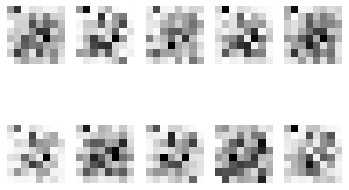

Batch 1522/1875 - Opimize G - Avg Batch Loss: 0.6282 - Time : 2.73s
Batch 1523/1875 - Opimize G - Avg Batch Loss: 0.4394 - Time : 2.65s
Batch 1524/1875 - Opimize G - Avg Batch Loss: 0.6086 - Time : 2.89s
Batch 1525/1875 - Opimize D - Avg Batch Loss: 0.5132 - Time : 2.92s
Batch 1526/1875 - Opimize G - Avg Batch Loss: 0.5566 - Time : 2.80s
Batch 1527/1875 - Opimize G - Avg Batch Loss: 0.5417 - Time : 2.72s
Batch 1528/1875 - Opimize G - Avg Batch Loss: 0.5106 - Time : 2.90s
Batch 1529/1875 - Opimize G - Avg Batch Loss: 0.4997 - Time : 2.69s
Batch 1530/1875 - Opimize G - Avg Batch Loss: 0.4969 - Time : 3.41s
Batch 1531/1875 - Opimize D - Avg Batch Loss: 0.4520 - Time : 2.76s


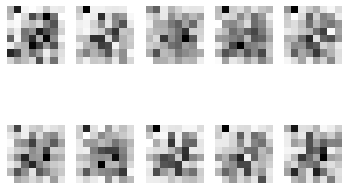

Batch 1532/1875 - Opimize G - Avg Batch Loss: 0.4714 - Time : 2.93s
Batch 1533/1875 - Opimize G - Avg Batch Loss: 0.4675 - Time : 2.96s
Batch 1534/1875 - Opimize G - Avg Batch Loss: 0.6347 - Time : 2.93s
Batch 1535/1875 - Opimize G - Avg Batch Loss: 0.4771 - Time : 2.73s
Batch 1536/1875 - Opimize G - Avg Batch Loss: 0.4383 - Time : 2.72s
Batch 1537/1875 - Opimize D - Avg Batch Loss: 0.5142 - Time : 2.75s
Batch 1538/1875 - Opimize G - Avg Batch Loss: 0.5622 - Time : 2.71s
Batch 1539/1875 - Opimize G - Avg Batch Loss: 0.5016 - Time : 2.91s
Batch 1540/1875 - Opimize G - Avg Batch Loss: 0.5497 - Time : 2.76s
Batch 1541/1875 - Opimize G - Avg Batch Loss: 0.5285 - Time : 2.72s


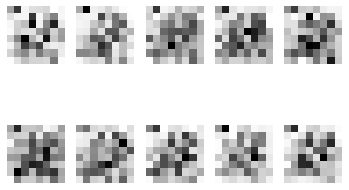

Batch 1542/1875 - Opimize G - Avg Batch Loss: 0.4795 - Time : 2.68s
Batch 1543/1875 - Opimize D - Avg Batch Loss: 0.5105 - Time : 3.04s
Batch 1544/1875 - Opimize G - Avg Batch Loss: 0.5224 - Time : 2.76s
Batch 1545/1875 - Opimize G - Avg Batch Loss: 0.6060 - Time : 2.66s
Batch 1546/1875 - Opimize G - Avg Batch Loss: 0.4787 - Time : 2.95s
Batch 1547/1875 - Opimize G - Avg Batch Loss: 0.3699 - Time : 2.68s
Batch 1548/1875 - Opimize G - Avg Batch Loss: 0.4148 - Time : 2.69s
Batch 1549/1875 - Opimize D - Avg Batch Loss: 0.5152 - Time : 2.70s
Batch 1550/1875 - Opimize G - Avg Batch Loss: 0.4733 - Time : 2.88s
Batch 1551/1875 - Opimize G - Avg Batch Loss: 0.5702 - Time : 2.72s


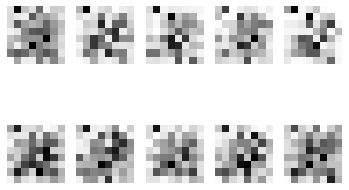

Batch 1552/1875 - Opimize G - Avg Batch Loss: 0.5134 - Time : 2.66s
Batch 1553/1875 - Opimize G - Avg Batch Loss: 0.5022 - Time : 2.65s
Batch 1554/1875 - Opimize G - Avg Batch Loss: 0.3938 - Time : 2.78s
Batch 1555/1875 - Opimize D - Avg Batch Loss: 0.5285 - Time : 2.93s
Batch 1556/1875 - Opimize G - Avg Batch Loss: 0.4687 - Time : 2.96s
Batch 1557/1875 - Opimize G - Avg Batch Loss: 0.6055 - Time : 2.71s
Batch 1558/1875 - Opimize G - Avg Batch Loss: 0.4226 - Time : 2.69s
Batch 1559/1875 - Opimize G - Avg Batch Loss: 0.5045 - Time : 2.69s
Batch 1560/1875 - Opimize G - Avg Batch Loss: 0.5326 - Time : 2.65s
Batch 1561/1875 - Opimize D - Avg Batch Loss: 0.4405 - Time : 2.90s


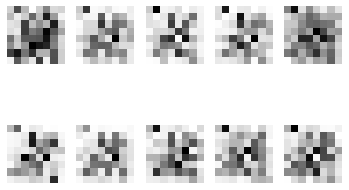

Batch 1562/1875 - Opimize G - Avg Batch Loss: 0.5220 - Time : 2.93s
Batch 1563/1875 - Opimize G - Avg Batch Loss: 0.6756 - Time : 2.73s
Batch 1564/1875 - Opimize G - Avg Batch Loss: 0.6589 - Time : 2.70s
Batch 1565/1875 - Opimize G - Avg Batch Loss: 0.7362 - Time : 2.74s
Batch 1566/1875 - Opimize G - Avg Batch Loss: 0.5426 - Time : 2.78s
Batch 1567/1875 - Opimize D - Avg Batch Loss: 0.6174 - Time : 2.81s
Batch 1568/1875 - Opimize G - Avg Batch Loss: 0.6848 - Time : 2.72s
Batch 1569/1875 - Opimize G - Avg Batch Loss: 0.6330 - Time : 2.98s
Batch 1570/1875 - Opimize G - Avg Batch Loss: 0.6357 - Time : 2.66s
Batch 1571/1875 - Opimize G - Avg Batch Loss: 0.5717 - Time : 2.69s


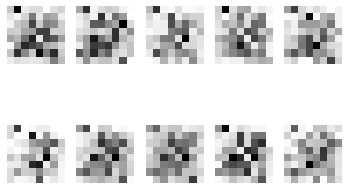

Batch 1572/1875 - Opimize G - Avg Batch Loss: 0.6866 - Time : 2.91s
Batch 1573/1875 - Opimize D - Avg Batch Loss: 0.6669 - Time : 2.66s
Batch 1574/1875 - Opimize G - Avg Batch Loss: 0.6846 - Time : 2.75s
Batch 1575/1875 - Opimize G - Avg Batch Loss: 0.6792 - Time : 2.80s
Batch 1576/1875 - Opimize G - Avg Batch Loss: 0.5734 - Time : 2.97s
Batch 1577/1875 - Opimize G - Avg Batch Loss: 0.5606 - Time : 2.70s
Batch 1578/1875 - Opimize G - Avg Batch Loss: 0.7104 - Time : 2.87s
Batch 1579/1875 - Opimize D - Avg Batch Loss: 0.5652 - Time : 2.65s
Batch 1580/1875 - Opimize G - Avg Batch Loss: 0.8308 - Time : 2.96s
Batch 1581/1875 - Opimize G - Avg Batch Loss: 0.6620 - Time : 2.70s


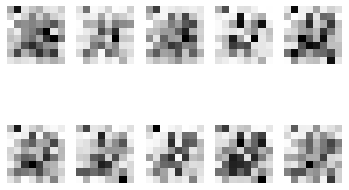

Batch 1582/1875 - Opimize G - Avg Batch Loss: 0.6855 - Time : 2.73s
Batch 1583/1875 - Opimize G - Avg Batch Loss: 0.7132 - Time : 2.65s
Batch 1584/1875 - Opimize G - Avg Batch Loss: 0.8528 - Time : 2.89s
Batch 1585/1875 - Opimize D - Avg Batch Loss: 0.7181 - Time : 2.95s
Batch 1586/1875 - Opimize G - Avg Batch Loss: 0.9669 - Time : 2.66s
Batch 1587/1875 - Opimize G - Avg Batch Loss: 0.7098 - Time : 2.89s
Batch 1588/1875 - Opimize G - Avg Batch Loss: 0.8537 - Time : 2.69s
Batch 1589/1875 - Opimize G - Avg Batch Loss: 0.7558 - Time : 2.71s
Batch 1590/1875 - Opimize G - Avg Batch Loss: 1.0641 - Time : 2.76s
Batch 1591/1875 - Opimize D - Avg Batch Loss: 0.5254 - Time : 2.69s


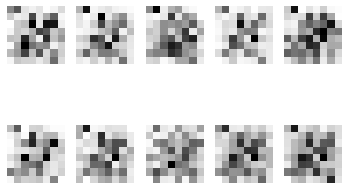

Batch 1592/1875 - Opimize G - Avg Batch Loss: 0.6825 - Time : 2.94s
Batch 1593/1875 - Opimize G - Avg Batch Loss: 0.9653 - Time : 2.74s
Batch 1594/1875 - Opimize G - Avg Batch Loss: 0.8645 - Time : 2.73s
Batch 1595/1875 - Opimize G - Avg Batch Loss: 0.7180 - Time : 3.09s
Batch 1596/1875 - Opimize G - Avg Batch Loss: 0.9418 - Time : 2.76s
Batch 1597/1875 - Opimize D - Avg Batch Loss: 0.9097 - Time : 2.91s
Batch 1598/1875 - Opimize G - Avg Batch Loss: 0.7973 - Time : 2.93s
Batch 1599/1875 - Opimize G - Avg Batch Loss: 0.8814 - Time : 3.18s
Batch 1600/1875 - Opimize G - Avg Batch Loss: 0.8114 - Time : 2.75s
Batch 1601/1875 - Opimize G - Avg Batch Loss: 0.9625 - Time : 3.14s


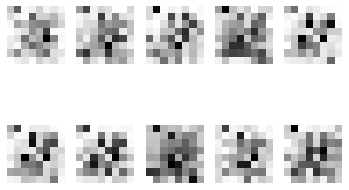

Batch 1602/1875 - Opimize G - Avg Batch Loss: 1.0443 - Time : 2.87s
Batch 1603/1875 - Opimize D - Avg Batch Loss: 0.8806 - Time : 3.02s
Batch 1604/1875 - Opimize G - Avg Batch Loss: 0.7518 - Time : 2.72s
Batch 1605/1875 - Opimize G - Avg Batch Loss: 0.8866 - Time : 2.89s
Batch 1606/1875 - Opimize G - Avg Batch Loss: 0.8377 - Time : 2.72s
Batch 1607/1875 - Opimize G - Avg Batch Loss: 0.6836 - Time : 2.70s
Batch 1608/1875 - Opimize G - Avg Batch Loss: 0.9628 - Time : 2.73s
Batch 1609/1875 - Opimize D - Avg Batch Loss: 0.9334 - Time : 2.85s
Batch 1610/1875 - Opimize G - Avg Batch Loss: 0.9362 - Time : 2.70s
Batch 1611/1875 - Opimize G - Avg Batch Loss: 0.8883 - Time : 2.73s


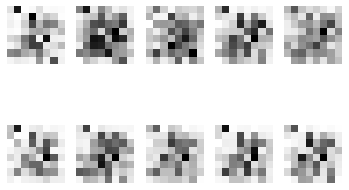

Batch 1612/1875 - Opimize G - Avg Batch Loss: 0.9379 - Time : 3.16s
Batch 1613/1875 - Opimize G - Avg Batch Loss: 0.9717 - Time : 2.65s
Batch 1614/1875 - Opimize G - Avg Batch Loss: 0.9384 - Time : 2.70s
Batch 1615/1875 - Opimize D - Avg Batch Loss: 0.6960 - Time : 2.82s
Batch 1616/1875 - Opimize G - Avg Batch Loss: 0.9697 - Time : 2.69s
Batch 1617/1875 - Opimize G - Avg Batch Loss: 1.2936 - Time : 2.63s
Batch 1618/1875 - Opimize G - Avg Batch Loss: 0.7520 - Time : 2.66s
Batch 1619/1875 - Opimize G - Avg Batch Loss: 0.8887 - Time : 2.65s
Batch 1620/1875 - Opimize G - Avg Batch Loss: 0.7164 - Time : 2.80s
Batch 1621/1875 - Opimize D - Avg Batch Loss: 0.9040 - Time : 2.72s


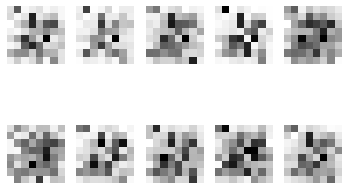

Batch 1622/1875 - Opimize G - Avg Batch Loss: 0.9265 - Time : 2.72s
Batch 1623/1875 - Opimize G - Avg Batch Loss: 0.9254 - Time : 2.83s
Batch 1624/1875 - Opimize G - Avg Batch Loss: 1.0084 - Time : 2.68s
Batch 1625/1875 - Opimize G - Avg Batch Loss: 1.0624 - Time : 2.93s
Batch 1626/1875 - Opimize G - Avg Batch Loss: 0.8612 - Time : 2.72s
Batch 1627/1875 - Opimize D - Avg Batch Loss: 1.0789 - Time : 2.84s
Batch 1628/1875 - Opimize G - Avg Batch Loss: 1.0321 - Time : 2.76s
Batch 1629/1875 - Opimize G - Avg Batch Loss: 0.8090 - Time : 2.73s
Batch 1630/1875 - Opimize G - Avg Batch Loss: 0.8088 - Time : 2.68s
Batch 1631/1875 - Opimize G - Avg Batch Loss: 0.9676 - Time : 2.74s


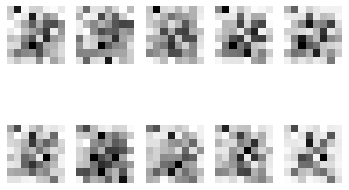

Batch 1632/1875 - Opimize G - Avg Batch Loss: 1.0328 - Time : 2.74s
Batch 1633/1875 - Opimize D - Avg Batch Loss: 0.9980 - Time : 2.93s
Batch 1634/1875 - Opimize G - Avg Batch Loss: 0.8329 - Time : 2.76s
Batch 1635/1875 - Opimize G - Avg Batch Loss: 0.8134 - Time : 2.71s
Batch 1636/1875 - Opimize G - Avg Batch Loss: 0.7736 - Time : 2.93s
Batch 1637/1875 - Opimize G - Avg Batch Loss: 0.5426 - Time : 2.91s
Batch 1638/1875 - Opimize G - Avg Batch Loss: 0.6448 - Time : 2.69s
Batch 1639/1875 - Opimize D - Avg Batch Loss: 0.8892 - Time : 2.73s
Batch 1640/1875 - Opimize G - Avg Batch Loss: 0.8086 - Time : 2.79s
Batch 1641/1875 - Opimize G - Avg Batch Loss: 0.6151 - Time : 2.69s


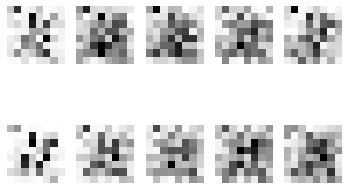

Batch 1642/1875 - Opimize G - Avg Batch Loss: 0.7404 - Time : 3.17s
Batch 1643/1875 - Opimize G - Avg Batch Loss: 0.8692 - Time : 2.70s
Batch 1644/1875 - Opimize G - Avg Batch Loss: 0.6665 - Time : 2.68s
Batch 1645/1875 - Opimize D - Avg Batch Loss: 0.9119 - Time : 2.69s
Batch 1646/1875 - Opimize G - Avg Batch Loss: 0.4786 - Time : 2.66s
Batch 1647/1875 - Opimize G - Avg Batch Loss: 0.6108 - Time : 2.67s
Batch 1648/1875 - Opimize G - Avg Batch Loss: 0.7215 - Time : 2.70s
Batch 1649/1875 - Opimize G - Avg Batch Loss: 0.5879 - Time : 2.66s
Batch 1650/1875 - Opimize G - Avg Batch Loss: 0.5609 - Time : 2.90s
Batch 1651/1875 - Opimize D - Avg Batch Loss: 0.5838 - Time : 3.15s


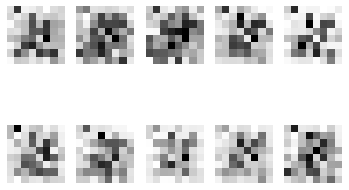

Batch 1652/1875 - Opimize G - Avg Batch Loss: 0.6154 - Time : 2.70s
Batch 1653/1875 - Opimize G - Avg Batch Loss: 0.7466 - Time : 2.70s
Batch 1654/1875 - Opimize G - Avg Batch Loss: 0.3522 - Time : 3.04s
Batch 1655/1875 - Opimize G - Avg Batch Loss: 0.4256 - Time : 2.71s
Batch 1656/1875 - Opimize G - Avg Batch Loss: 0.4301 - Time : 2.78s
Batch 1657/1875 - Opimize D - Avg Batch Loss: 0.4908 - Time : 2.70s
Batch 1658/1875 - Opimize G - Avg Batch Loss: 0.4796 - Time : 2.94s
Batch 1659/1875 - Opimize G - Avg Batch Loss: 0.3449 - Time : 2.70s
Batch 1660/1875 - Opimize G - Avg Batch Loss: 0.3847 - Time : 2.71s
Batch 1661/1875 - Opimize G - Avg Batch Loss: 0.4542 - Time : 2.75s


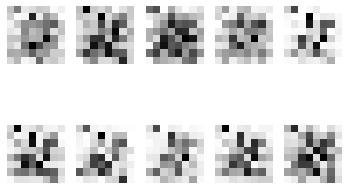

Batch 1662/1875 - Opimize G - Avg Batch Loss: 0.5538 - Time : 2.68s
Batch 1663/1875 - Opimize D - Avg Batch Loss: 0.3219 - Time : 2.88s
Batch 1664/1875 - Opimize G - Avg Batch Loss: 0.2921 - Time : 2.84s
Batch 1665/1875 - Opimize G - Avg Batch Loss: 0.4575 - Time : 2.82s
Batch 1666/1875 - Opimize G - Avg Batch Loss: 0.2607 - Time : 2.70s
Batch 1667/1875 - Opimize G - Avg Batch Loss: 0.6024 - Time : 2.98s
Batch 1668/1875 - Opimize G - Avg Batch Loss: 0.1824 - Time : 2.71s
Batch 1669/1875 - Opimize D - Avg Batch Loss: 0.1975 - Time : 2.67s
Batch 1670/1875 - Opimize G - Avg Batch Loss: 0.3409 - Time : 2.71s
Batch 1671/1875 - Opimize G - Avg Batch Loss: 0.2966 - Time : 2.67s


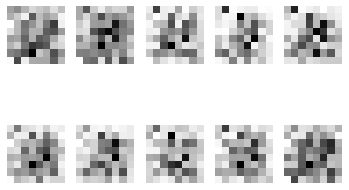

Batch 1672/1875 - Opimize G - Avg Batch Loss: 0.2274 - Time : 2.68s
Batch 1673/1875 - Opimize G - Avg Batch Loss: 0.2342 - Time : 2.77s
Batch 1674/1875 - Opimize G - Avg Batch Loss: 0.4982 - Time : 2.80s
Batch 1675/1875 - Opimize D - Avg Batch Loss: 0.2730 - Time : 2.85s
Batch 1676/1875 - Opimize G - Avg Batch Loss: 0.2882 - Time : 2.95s
Batch 1677/1875 - Opimize G - Avg Batch Loss: 0.4303 - Time : 2.95s
Batch 1678/1875 - Opimize G - Avg Batch Loss: 0.3505 - Time : 2.70s
Batch 1679/1875 - Opimize G - Avg Batch Loss: 0.2044 - Time : 2.98s
Batch 1680/1875 - Opimize G - Avg Batch Loss: 0.3152 - Time : 2.93s
Batch 1681/1875 - Opimize D - Avg Batch Loss: 0.2507 - Time : 2.99s


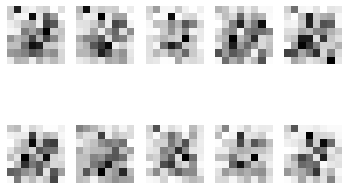

Batch 1682/1875 - Opimize G - Avg Batch Loss: 0.2631 - Time : 2.95s
Batch 1683/1875 - Opimize G - Avg Batch Loss: 0.2270 - Time : 2.85s
Batch 1684/1875 - Opimize G - Avg Batch Loss: 0.2556 - Time : 2.92s
Batch 1685/1875 - Opimize G - Avg Batch Loss: 0.3573 - Time : 2.79s
Batch 1686/1875 - Opimize G - Avg Batch Loss: 0.1289 - Time : 2.79s
Batch 1687/1875 - Opimize D - Avg Batch Loss: 0.1974 - Time : 2.67s
Batch 1688/1875 - Opimize G - Avg Batch Loss: 0.2102 - Time : 2.93s
Batch 1689/1875 - Opimize G - Avg Batch Loss: 0.1599 - Time : 2.69s
Batch 1690/1875 - Opimize G - Avg Batch Loss: 0.1899 - Time : 2.77s
Batch 1691/1875 - Opimize G - Avg Batch Loss: 0.3396 - Time : 2.69s


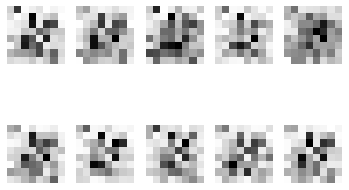

Batch 1692/1875 - Opimize G - Avg Batch Loss: 0.2090 - Time : 2.70s
Batch 1693/1875 - Opimize D - Avg Batch Loss: 0.3253 - Time : 3.14s
Batch 1694/1875 - Opimize G - Avg Batch Loss: 0.1604 - Time : 2.90s
Batch 1695/1875 - Opimize G - Avg Batch Loss: 0.2139 - Time : 2.77s
Batch 1696/1875 - Opimize G - Avg Batch Loss: 0.1921 - Time : 2.68s
Batch 1697/1875 - Opimize G - Avg Batch Loss: 0.1529 - Time : 2.95s
Batch 1698/1875 - Opimize G - Avg Batch Loss: 0.2239 - Time : 2.69s
Batch 1699/1875 - Opimize D - Avg Batch Loss: 0.2595 - Time : 2.68s
Batch 1700/1875 - Opimize G - Avg Batch Loss: 0.3375 - Time : 2.70s
Batch 1701/1875 - Opimize G - Avg Batch Loss: 0.1053 - Time : 2.94s


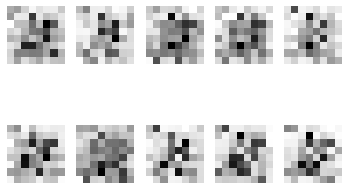

Batch 1702/1875 - Opimize G - Avg Batch Loss: 0.1475 - Time : 2.69s
Batch 1703/1875 - Opimize G - Avg Batch Loss: 0.2499 - Time : 2.92s
Batch 1704/1875 - Opimize G - Avg Batch Loss: 0.2454 - Time : 2.70s
Batch 1705/1875 - Opimize D - Avg Batch Loss: 0.2337 - Time : 2.67s
Batch 1706/1875 - Opimize G - Avg Batch Loss: 0.2391 - Time : 2.71s
Batch 1707/1875 - Opimize G - Avg Batch Loss: 0.2194 - Time : 2.71s
Batch 1708/1875 - Opimize G - Avg Batch Loss: 0.2193 - Time : 2.83s
Batch 1709/1875 - Opimize G - Avg Batch Loss: 0.2162 - Time : 2.69s
Batch 1710/1875 - Opimize G - Avg Batch Loss: 0.1876 - Time : 3.45s
Batch 1711/1875 - Opimize D - Avg Batch Loss: 0.1291 - Time : 3.00s


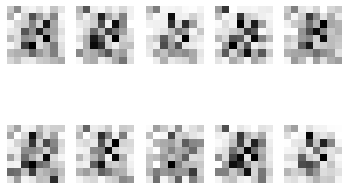

Batch 1712/1875 - Opimize G - Avg Batch Loss: 0.1588 - Time : 2.71s
Batch 1713/1875 - Opimize G - Avg Batch Loss: 0.2042 - Time : 2.78s
Batch 1714/1875 - Opimize G - Avg Batch Loss: 0.1725 - Time : 2.65s
Batch 1715/1875 - Opimize G - Avg Batch Loss: 0.2527 - Time : 2.97s
Batch 1716/1875 - Opimize G - Avg Batch Loss: 0.1820 - Time : 2.69s
Batch 1717/1875 - Opimize D - Avg Batch Loss: 0.2085 - Time : 2.80s
Batch 1718/1875 - Opimize G - Avg Batch Loss: 0.2263 - Time : 2.81s
Batch 1719/1875 - Opimize G - Avg Batch Loss: 0.2608 - Time : 2.73s
Batch 1720/1875 - Opimize G - Avg Batch Loss: 0.0972 - Time : 2.71s
Batch 1721/1875 - Opimize G - Avg Batch Loss: 0.1724 - Time : 3.17s


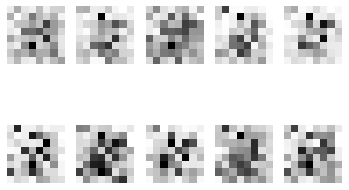

Batch 1722/1875 - Opimize G - Avg Batch Loss: 0.1861 - Time : 2.69s
Batch 1723/1875 - Opimize D - Avg Batch Loss: 0.1522 - Time : 2.88s
Batch 1724/1875 - Opimize G - Avg Batch Loss: 0.1064 - Time : 2.73s
Batch 1725/1875 - Opimize G - Avg Batch Loss: 0.1167 - Time : 2.92s
Batch 1726/1875 - Opimize G - Avg Batch Loss: 0.1615 - Time : 2.69s
Batch 1727/1875 - Opimize G - Avg Batch Loss: 0.1314 - Time : 2.77s
Batch 1728/1875 - Opimize G - Avg Batch Loss: 0.0703 - Time : 2.70s
Batch 1729/1875 - Opimize D - Avg Batch Loss: 0.1831 - Time : 2.81s
Batch 1730/1875 - Opimize G - Avg Batch Loss: 0.1753 - Time : 2.97s
Batch 1731/1875 - Opimize G - Avg Batch Loss: 0.1057 - Time : 2.90s


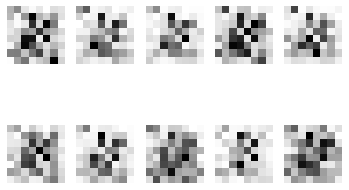

Batch 1732/1875 - Opimize G - Avg Batch Loss: 0.2202 - Time : 2.73s
Batch 1733/1875 - Opimize G - Avg Batch Loss: 0.0831 - Time : 2.68s
Batch 1734/1875 - Opimize G - Avg Batch Loss: 0.1285 - Time : 2.85s
Batch 1735/1875 - Opimize D - Avg Batch Loss: 0.0996 - Time : 2.67s
Batch 1736/1875 - Opimize G - Avg Batch Loss: 0.1684 - Time : 2.67s
Batch 1737/1875 - Opimize G - Avg Batch Loss: 0.1054 - Time : 2.95s
Batch 1738/1875 - Opimize G - Avg Batch Loss: 0.2138 - Time : 2.66s
Batch 1739/1875 - Opimize G - Avg Batch Loss: 0.1610 - Time : 2.93s
Batch 1740/1875 - Opimize G - Avg Batch Loss: 0.1848 - Time : 2.79s
Batch 1741/1875 - Opimize D - Avg Batch Loss: 0.1319 - Time : 2.69s


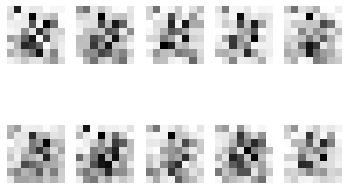

Batch 1742/1875 - Opimize G - Avg Batch Loss: 0.1368 - Time : 2.69s
Batch 1743/1875 - Opimize G - Avg Batch Loss: 0.1099 - Time : 2.78s
Batch 1744/1875 - Opimize G - Avg Batch Loss: 0.1192 - Time : 2.69s
Batch 1745/1875 - Opimize G - Avg Batch Loss: 0.0967 - Time : 2.90s
Batch 1746/1875 - Opimize G - Avg Batch Loss: 0.1822 - Time : 2.92s
Batch 1747/1875 - Opimize D - Avg Batch Loss: 0.2322 - Time : 2.65s
Batch 1748/1875 - Opimize G - Avg Batch Loss: 0.1492 - Time : 2.69s
Batch 1749/1875 - Opimize G - Avg Batch Loss: 0.1071 - Time : 3.00s
Batch 1750/1875 - Opimize G - Avg Batch Loss: 0.0866 - Time : 2.68s
Batch 1751/1875 - Opimize G - Avg Batch Loss: 0.1302 - Time : 2.69s


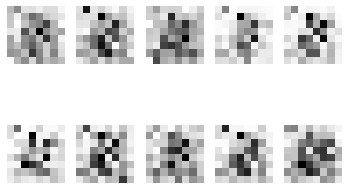

Batch 1752/1875 - Opimize G - Avg Batch Loss: 0.1863 - Time : 2.96s
Batch 1753/1875 - Opimize D - Avg Batch Loss: 0.0657 - Time : 2.74s
Batch 1754/1875 - Opimize G - Avg Batch Loss: 0.0953 - Time : 2.71s
Batch 1755/1875 - Opimize G - Avg Batch Loss: 0.1582 - Time : 2.90s
Batch 1756/1875 - Opimize G - Avg Batch Loss: 0.0890 - Time : 2.71s
Batch 1757/1875 - Opimize G - Avg Batch Loss: 0.1400 - Time : 2.87s
Batch 1758/1875 - Opimize G - Avg Batch Loss: 0.1823 - Time : 2.93s
Batch 1759/1875 - Opimize D - Avg Batch Loss: 0.1908 - Time : 2.70s
Batch 1760/1875 - Opimize G - Avg Batch Loss: 0.1782 - Time : 3.01s
Batch 1761/1875 - Opimize G - Avg Batch Loss: 0.1010 - Time : 2.87s


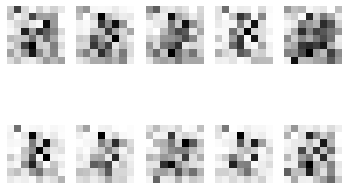

Batch 1762/1875 - Opimize G - Avg Batch Loss: 0.1624 - Time : 2.68s
Batch 1763/1875 - Opimize G - Avg Batch Loss: 0.2484 - Time : 2.67s
Batch 1764/1875 - Opimize G - Avg Batch Loss: 0.1240 - Time : 2.71s
Batch 1765/1875 - Opimize D - Avg Batch Loss: 0.1596 - Time : 2.89s
Batch 1766/1875 - Opimize G - Avg Batch Loss: 0.1265 - Time : 2.90s
Batch 1767/1875 - Opimize G - Avg Batch Loss: 0.1733 - Time : 2.96s
Batch 1768/1875 - Opimize G - Avg Batch Loss: 0.1321 - Time : 2.76s
Batch 1769/1875 - Opimize G - Avg Batch Loss: 0.1592 - Time : 2.70s
Batch 1770/1875 - Opimize G - Avg Batch Loss: 0.1573 - Time : 2.68s
Batch 1771/1875 - Opimize D - Avg Batch Loss: 0.1003 - Time : 2.88s


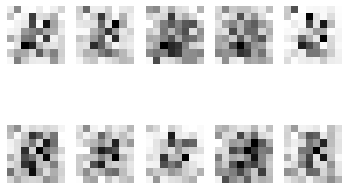

Batch 1772/1875 - Opimize G - Avg Batch Loss: 0.1509 - Time : 2.89s
Batch 1773/1875 - Opimize G - Avg Batch Loss: 0.1315 - Time : 2.89s
Batch 1774/1875 - Opimize G - Avg Batch Loss: 0.1301 - Time : 2.70s
Batch 1775/1875 - Opimize G - Avg Batch Loss: 0.1203 - Time : 3.00s
Batch 1776/1875 - Opimize G - Avg Batch Loss: 0.2679 - Time : 2.73s
Batch 1777/1875 - Opimize D - Avg Batch Loss: 0.2149 - Time : 2.66s
Batch 1778/1875 - Opimize G - Avg Batch Loss: 0.1622 - Time : 2.69s
Batch 1779/1875 - Opimize G - Avg Batch Loss: 0.1902 - Time : 3.18s
Batch 1780/1875 - Opimize G - Avg Batch Loss: 0.1573 - Time : 2.96s
Batch 1781/1875 - Opimize G - Avg Batch Loss: 0.1573 - Time : 2.68s


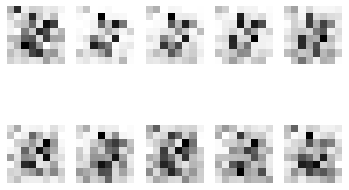

Batch 1782/1875 - Opimize G - Avg Batch Loss: 0.1190 - Time : 2.70s
Batch 1783/1875 - Opimize D - Avg Batch Loss: 0.1475 - Time : 2.73s
Batch 1784/1875 - Opimize G - Avg Batch Loss: 0.1080 - Time : 2.72s
Batch 1785/1875 - Opimize G - Avg Batch Loss: 0.2021 - Time : 2.67s
Batch 1786/1875 - Opimize G - Avg Batch Loss: 0.0934 - Time : 2.98s
Batch 1787/1875 - Opimize G - Avg Batch Loss: 0.1273 - Time : 2.79s
Batch 1788/1875 - Opimize G - Avg Batch Loss: 0.1326 - Time : 2.78s
Batch 1789/1875 - Opimize D - Avg Batch Loss: 0.1062 - Time : 2.72s
Batch 1790/1875 - Opimize G - Avg Batch Loss: 0.1360 - Time : 2.96s
Batch 1791/1875 - Opimize G - Avg Batch Loss: 0.1022 - Time : 3.03s


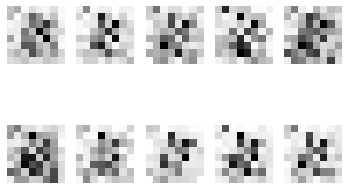

Batch 1792/1875 - Opimize G - Avg Batch Loss: 0.1114 - Time : 2.63s
Batch 1793/1875 - Opimize G - Avg Batch Loss: 0.2212 - Time : 2.71s
Batch 1794/1875 - Opimize G - Avg Batch Loss: 0.2094 - Time : 2.74s
Batch 1795/1875 - Opimize D - Avg Batch Loss: 0.2069 - Time : 3.13s
Batch 1796/1875 - Opimize G - Avg Batch Loss: 0.1853 - Time : 2.64s
Batch 1797/1875 - Opimize G - Avg Batch Loss: 0.1633 - Time : 2.68s
Batch 1798/1875 - Opimize G - Avg Batch Loss: 0.1995 - Time : 2.66s
Batch 1799/1875 - Opimize G - Avg Batch Loss: 0.1722 - Time : 2.69s
Batch 1800/1875 - Opimize G - Avg Batch Loss: 0.1285 - Time : 2.69s
Batch 1801/1875 - Opimize D - Avg Batch Loss: 0.1264 - Time : 2.68s


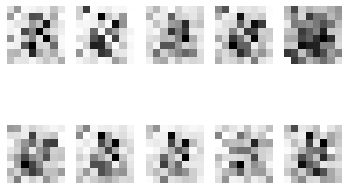

Batch 1802/1875 - Opimize G - Avg Batch Loss: 0.1533 - Time : 2.88s
Batch 1803/1875 - Opimize G - Avg Batch Loss: 0.1409 - Time : 2.79s
Batch 1804/1875 - Opimize G - Avg Batch Loss: 0.1152 - Time : 2.68s
Batch 1805/1875 - Opimize G - Avg Batch Loss: 0.1288 - Time : 2.69s
Batch 1806/1875 - Opimize G - Avg Batch Loss: 0.1184 - Time : 2.69s
Batch 1807/1875 - Opimize D - Avg Batch Loss: 0.0761 - Time : 2.75s
Batch 1808/1875 - Opimize G - Avg Batch Loss: 0.1203 - Time : 2.73s
Batch 1809/1875 - Opimize G - Avg Batch Loss: 0.1802 - Time : 2.65s
Batch 1810/1875 - Opimize G - Avg Batch Loss: 0.0943 - Time : 2.90s
Batch 1811/1875 - Opimize G - Avg Batch Loss: 0.1099 - Time : 2.75s


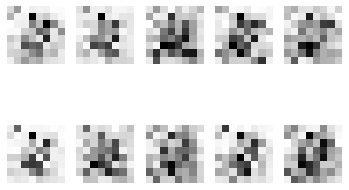

Batch 1812/1875 - Opimize G - Avg Batch Loss: 0.1321 - Time : 2.71s
Batch 1813/1875 - Opimize D - Avg Batch Loss: 0.2451 - Time : 2.90s
Batch 1814/1875 - Opimize G - Avg Batch Loss: 0.1314 - Time : 2.71s
Batch 1815/1875 - Opimize G - Avg Batch Loss: 0.2575 - Time : 2.83s
Batch 1816/1875 - Opimize G - Avg Batch Loss: 0.1255 - Time : 2.97s
Batch 1817/1875 - Opimize G - Avg Batch Loss: 0.1746 - Time : 2.69s
Batch 1818/1875 - Opimize G - Avg Batch Loss: 0.0677 - Time : 3.03s
Batch 1819/1875 - Opimize D - Avg Batch Loss: 0.1092 - Time : 2.70s
Batch 1820/1875 - Opimize G - Avg Batch Loss: 0.1551 - Time : 2.68s
Batch 1821/1875 - Opimize G - Avg Batch Loss: 0.1067 - Time : 2.75s


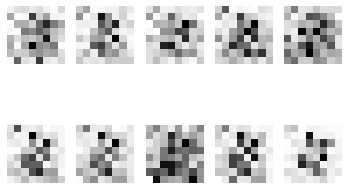

Batch 1822/1875 - Opimize G - Avg Batch Loss: 0.1438 - Time : 3.16s
Batch 1823/1875 - Opimize G - Avg Batch Loss: 0.1355 - Time : 2.97s
Batch 1824/1875 - Opimize G - Avg Batch Loss: 0.1542 - Time : 2.69s
Batch 1825/1875 - Opimize D - Avg Batch Loss: 0.1614 - Time : 2.72s
Batch 1826/1875 - Opimize G - Avg Batch Loss: 0.2296 - Time : 2.72s
Batch 1827/1875 - Opimize G - Avg Batch Loss: 0.1846 - Time : 2.89s
Batch 1828/1875 - Opimize G - Avg Batch Loss: 0.1946 - Time : 2.70s
Batch 1829/1875 - Opimize G - Avg Batch Loss: 0.2384 - Time : 2.92s
Batch 1830/1875 - Opimize G - Avg Batch Loss: 0.1892 - Time : 2.94s
Batch 1831/1875 - Opimize D - Avg Batch Loss: 0.1880 - Time : 3.36s


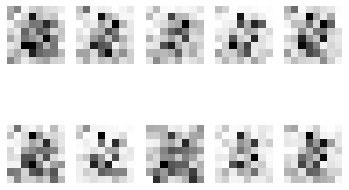

Batch 1832/1875 - Opimize G - Avg Batch Loss: 0.1722 - Time : 2.95s
Batch 1833/1875 - Opimize G - Avg Batch Loss: 0.2372 - Time : 2.66s
Batch 1834/1875 - Opimize G - Avg Batch Loss: 0.1592 - Time : 2.70s
Batch 1835/1875 - Opimize G - Avg Batch Loss: 0.1527 - Time : 2.74s
Batch 1836/1875 - Opimize G - Avg Batch Loss: 0.1563 - Time : 2.72s
Batch 1837/1875 - Opimize D - Avg Batch Loss: 0.1371 - Time : 2.94s
Batch 1838/1875 - Opimize G - Avg Batch Loss: 0.1611 - Time : 2.71s
Batch 1839/1875 - Opimize G - Avg Batch Loss: 0.1407 - Time : 2.87s
Batch 1840/1875 - Opimize G - Avg Batch Loss: 0.2166 - Time : 2.76s
Batch 1841/1875 - Opimize G - Avg Batch Loss: 0.2467 - Time : 2.65s


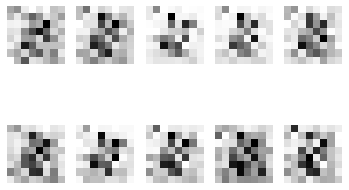

Batch 1842/1875 - Opimize G - Avg Batch Loss: 0.1302 - Time : 2.72s
Batch 1843/1875 - Opimize D - Avg Batch Loss: 0.2230 - Time : 2.81s
Batch 1844/1875 - Opimize G - Avg Batch Loss: 0.1725 - Time : 3.08s
Batch 1845/1875 - Opimize G - Avg Batch Loss: 0.1871 - Time : 2.69s
Batch 1846/1875 - Opimize G - Avg Batch Loss: 0.1586 - Time : 2.79s
Batch 1847/1875 - Opimize G - Avg Batch Loss: 0.1418 - Time : 2.72s
Batch 1848/1875 - Opimize G - Avg Batch Loss: 0.2327 - Time : 2.94s
Batch 1849/1875 - Opimize D - Avg Batch Loss: 0.1868 - Time : 2.64s
Batch 1850/1875 - Opimize G - Avg Batch Loss: 0.2664 - Time : 2.70s
Batch 1851/1875 - Opimize G - Avg Batch Loss: 0.2419 - Time : 2.68s


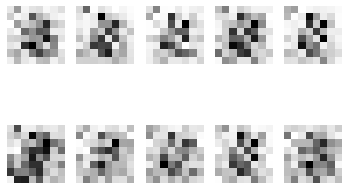

Batch 1852/1875 - Opimize G - Avg Batch Loss: 0.3269 - Time : 2.69s
Batch 1853/1875 - Opimize G - Avg Batch Loss: 0.1866 - Time : 2.88s
Batch 1854/1875 - Opimize G - Avg Batch Loss: 0.2873 - Time : 2.67s
Batch 1855/1875 - Opimize D - Avg Batch Loss: 0.2078 - Time : 2.69s
Batch 1856/1875 - Opimize G - Avg Batch Loss: 0.1865 - Time : 2.93s
Batch 1857/1875 - Opimize G - Avg Batch Loss: 0.2033 - Time : 2.92s
Batch 1858/1875 - Opimize G - Avg Batch Loss: 0.2068 - Time : 2.95s
Batch 1859/1875 - Opimize G - Avg Batch Loss: 0.2159 - Time : 2.64s
Batch 1860/1875 - Opimize G - Avg Batch Loss: 0.2227 - Time : 2.73s
Batch 1861/1875 - Opimize D - Avg Batch Loss: 0.2450 - Time : 2.72s


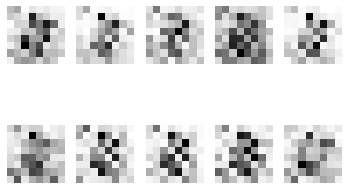

Batch 1862/1875 - Opimize G - Avg Batch Loss: 0.2611 - Time : 3.20s
Batch 1863/1875 - Opimize G - Avg Batch Loss: 0.3465 - Time : 2.80s
Batch 1864/1875 - Opimize G - Avg Batch Loss: 0.2613 - Time : 3.02s
Batch 1865/1875 - Opimize G - Avg Batch Loss: 0.1434 - Time : 2.66s
Batch 1866/1875 - Opimize G - Avg Batch Loss: 0.2683 - Time : 2.76s
Batch 1867/1875 - Opimize D - Avg Batch Loss: 0.2799 - Time : 2.68s
Batch 1868/1875 - Opimize G - Avg Batch Loss: 0.3935 - Time : 2.98s
Batch 1869/1875 - Opimize G - Avg Batch Loss: 0.2335 - Time : 2.62s
Batch 1870/1875 - Opimize G - Avg Batch Loss: 0.2708 - Time : 2.75s
Batch 1871/1875 - Opimize G - Avg Batch Loss: 0.3064 - Time : 2.99s


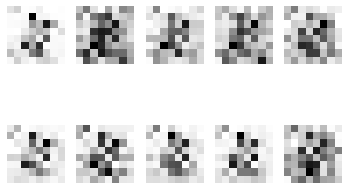

Batch 1872/1875 - Opimize G - Avg Batch Loss: 0.2859 - Time : 2.71s
Batch 1873/1875 - Opimize D - Avg Batch Loss: 0.3206 - Time : 2.94s
Batch 1874/1875 - Opimize G - Avg Batch Loss: 0.4168 - Time : 2.69s
Batch 1875/1875 - Opimize G - Avg Batch Loss: 0.3637 - Time : 2.71s
Epoch 1 completed in 5353.51 seconds ! Avg Epoch Loss: 0.5794


[1.2967437505722046,
 1.2713932991027832,
 1.2427881956100464,
 1.1318955421447754,
 1.1302692890167236,
 1.2214651107788086,
 1.231594443321228,
 1.214539647102356,
 1.2557353973388672,
 1.3013817071914673,
 1.252258062362671,
 1.2800071239471436,
 1.2065074443817139,
 1.2495783567428589,
 1.13201904296875,
 1.152611494064331,
 1.2740932703018188,
 1.176854133605957,
 1.227784276008606,
 1.1674541234970093,
 1.0951275825500488,
 1.0644111633300781,
 1.135865330696106,
 1.103837013244629,
 1.1160084009170532,
 1.1854393482208252,
 1.1843430995941162,
 1.1418794393539429,
 0.9918557405471802,
 1.1581261157989502,
 1.2218648195266724,
 1.094264268875122,
 1.1459919214248657,
 1.0389504432678223,
 1.1503055095672607,
 1.038002610206604,
 1.039576768875122,
 1.1047860383987427,
 1.0372895002365112,
 1.088402271270752,
 1.1213316917419434,
 1.1083840131759644,
 1.10015869140625,
 1.0988657474517822,
 1.082480788230896,
 1.1391669511795044,
 1.0086398124694824,
 1.0276799201965332,
 1.118589

In [24]:
train(n_gen=5, n_epochs = 1, batch_size = 32, plt_samples = 10)

Try to generate images

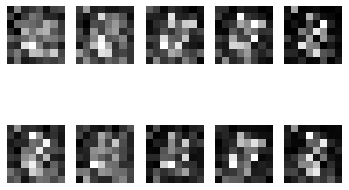

In [34]:
generate_plt()

### Change regularization parameter

In [0]:
img_size = trainset[0][0].size(1)
dim_gen = 16
dim_features_critics = 16

model_type = 'cnn'

if model_type == 'cnn':
    # Initialize CNN generator and discriminator
    generator = GeneratorCNN(dim_gen, img_size).to(device)
    discriminator = DiscriminatorCNN(img_size, dim_features_critics).to(device)

elif model_type == 'mlp':
    # Initialize MLP generator and discriminator
    generator = GeneratorMLP(dim_gen, img_size)
    discriminator = DiscriminatorMLP(img_size, dim_features_critics)

print(generator)
print(discriminator)

D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
G_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

GeneratorCNN(
  (linear_in): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(8, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Tanh()
  )
)
DiscriminatorCNN(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(16, eps=0.8, 

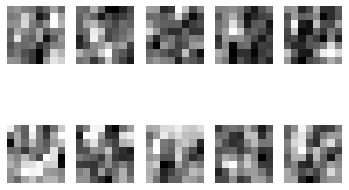

In [58]:
generate_plt()

========================Epoch: 1 / 1 =======================
Batch 1/938 - Opimize D - Avg Batch Loss: 0.1293 - Time : 3.57s


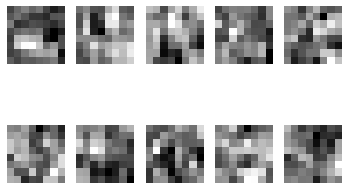

Batch 2/938 - Opimize G - Avg Batch Loss: 0.1314 - Time : 3.62s
Batch 3/938 - Opimize G - Avg Batch Loss: 0.1093 - Time : 3.45s
Batch 4/938 - Opimize G - Avg Batch Loss: 0.2137 - Time : 3.51s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.1614 - Time : 3.43s
Batch 6/938 - Opimize G - Avg Batch Loss: 0.2096 - Time : 3.48s
Batch 7/938 - Opimize D - Avg Batch Loss: 0.2199 - Time : 3.44s
Batch 8/938 - Opimize G - Avg Batch Loss: 0.1473 - Time : 3.43s
Batch 9/938 - Opimize G - Avg Batch Loss: 0.1699 - Time : 3.70s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.1217 - Time : 3.62s
Batch 11/938 - Opimize G - Avg Batch Loss: 0.1306 - Time : 3.67s
Batch 12/938 - Opimize G - Avg Batch Loss: 0.1405 - Time : 3.64s
Batch 13/938 - Opimize D - Avg Batch Loss: 0.1514 - Time : 3.45s
Batch 14/938 - Opimize G - Avg Batch Loss: 0.0822 - Time : 3.38s
Batch 15/938 - Opimize G - Avg Batch Loss: 0.1236 - Time : 3.71s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.1569 - Time : 3.48s
Batch 17/938 - Opimize G - Avg Ba

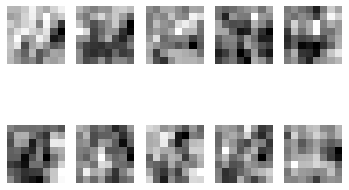

Batch 22/938 - Opimize G - Avg Batch Loss: 0.1206 - Time : 4.03s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.2053 - Time : 3.94s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.1738 - Time : 3.82s
Batch 25/938 - Opimize D - Avg Batch Loss: 0.0947 - Time : 3.97s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.1087 - Time : 3.43s
Batch 27/938 - Opimize G - Avg Batch Loss: 0.2190 - Time : 3.69s
Batch 28/938 - Opimize G - Avg Batch Loss: 0.1459 - Time : 3.37s
Batch 29/938 - Opimize G - Avg Batch Loss: 0.1320 - Time : 3.73s
Batch 30/938 - Opimize G - Avg Batch Loss: 0.1684 - Time : 3.79s
Batch 31/938 - Opimize D - Avg Batch Loss: 0.1332 - Time : 3.65s
Batch 32/938 - Opimize G - Avg Batch Loss: 0.1876 - Time : 3.79s
Batch 33/938 - Opimize G - Avg Batch Loss: 0.1897 - Time : 3.39s
Batch 34/938 - Opimize G - Avg Batch Loss: 0.1575 - Time : 3.59s
Batch 35/938 - Opimize G - Avg Batch Loss: 0.1748 - Time : 3.62s
Batch 36/938 - Opimize G - Avg Batch Loss: 0.1166 - Time : 3.55s
Batch 37/938 - Opimize D 

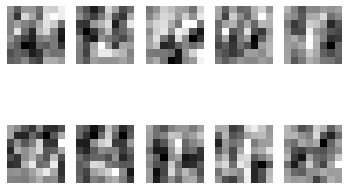

Batch 42/938 - Opimize G - Avg Batch Loss: 0.0874 - Time : 3.44s
Batch 43/938 - Opimize D - Avg Batch Loss: 0.1512 - Time : 4.01s
Batch 44/938 - Opimize G - Avg Batch Loss: 0.1611 - Time : 3.64s
Batch 45/938 - Opimize G - Avg Batch Loss: 0.1375 - Time : 3.49s
Batch 46/938 - Opimize G - Avg Batch Loss: 0.1455 - Time : 3.48s
Batch 47/938 - Opimize G - Avg Batch Loss: 0.1190 - Time : 3.50s
Batch 48/938 - Opimize G - Avg Batch Loss: 0.1220 - Time : 3.41s
Batch 49/938 - Opimize D - Avg Batch Loss: 0.0733 - Time : 3.82s
Batch 50/938 - Opimize G - Avg Batch Loss: 0.1557 - Time : 3.62s
Batch 51/938 - Opimize G - Avg Batch Loss: 0.1392 - Time : 3.52s
Batch 52/938 - Opimize G - Avg Batch Loss: 0.1015 - Time : 3.57s
Batch 53/938 - Opimize G - Avg Batch Loss: 0.1854 - Time : 3.83s
Batch 54/938 - Opimize G - Avg Batch Loss: 0.1571 - Time : 3.68s
Batch 55/938 - Opimize D - Avg Batch Loss: 0.0884 - Time : 3.56s
Batch 56/938 - Opimize G - Avg Batch Loss: 0.1486 - Time : 3.66s
Batch 57/938 - Opimize G 

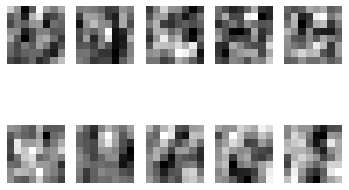

Batch 62/938 - Opimize G - Avg Batch Loss: 0.1406 - Time : 3.45s
Batch 63/938 - Opimize G - Avg Batch Loss: 0.1701 - Time : 3.52s
Batch 64/938 - Opimize G - Avg Batch Loss: 0.1491 - Time : 3.44s
Batch 65/938 - Opimize G - Avg Batch Loss: 0.1936 - Time : 3.45s
Batch 66/938 - Opimize G - Avg Batch Loss: 0.1851 - Time : 3.49s
Batch 67/938 - Opimize D - Avg Batch Loss: 0.1523 - Time : 3.70s
Batch 68/938 - Opimize G - Avg Batch Loss: 0.1682 - Time : 3.67s
Batch 69/938 - Opimize G - Avg Batch Loss: 0.1364 - Time : 3.46s
Batch 70/938 - Opimize G - Avg Batch Loss: 0.1822 - Time : 3.43s
Batch 71/938 - Opimize G - Avg Batch Loss: 0.1383 - Time : 3.46s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.1647 - Time : 3.70s
Batch 73/938 - Opimize D - Avg Batch Loss: 0.1306 - Time : 3.43s
Batch 74/938 - Opimize G - Avg Batch Loss: 0.1061 - Time : 3.42s
Batch 75/938 - Opimize G - Avg Batch Loss: 0.1387 - Time : 3.44s
Batch 76/938 - Opimize G - Avg Batch Loss: 0.0999 - Time : 3.44s
Batch 77/938 - Opimize G 

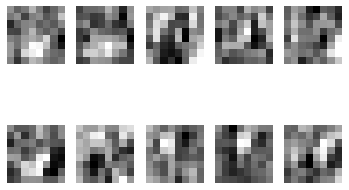

Batch 82/938 - Opimize G - Avg Batch Loss: 0.1741 - Time : 3.44s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.1602 - Time : 3.46s
Batch 84/938 - Opimize G - Avg Batch Loss: 0.1600 - Time : 3.68s
Batch 85/938 - Opimize D - Avg Batch Loss: 0.2412 - Time : 3.59s
Batch 86/938 - Opimize G - Avg Batch Loss: 0.1545 - Time : 3.56s
Batch 87/938 - Opimize G - Avg Batch Loss: 0.1272 - Time : 3.43s
Batch 88/938 - Opimize G - Avg Batch Loss: 0.1264 - Time : 3.63s
Batch 89/938 - Opimize G - Avg Batch Loss: 0.1398 - Time : 3.61s
Batch 90/938 - Opimize G - Avg Batch Loss: 0.1019 - Time : 3.47s
Batch 91/938 - Opimize D - Avg Batch Loss: 0.1739 - Time : 3.41s
Batch 92/938 - Opimize G - Avg Batch Loss: 0.1746 - Time : 3.47s
Batch 93/938 - Opimize G - Avg Batch Loss: 0.0862 - Time : 3.40s
Batch 94/938 - Opimize G - Avg Batch Loss: 0.2363 - Time : 3.59s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.1992 - Time : 3.40s
Batch 96/938 - Opimize G - Avg Batch Loss: 0.1179 - Time : 3.51s
Batch 97/938 - Opimize D 

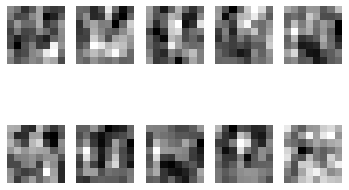

Batch 102/938 - Opimize G - Avg Batch Loss: 0.0974 - Time : 3.49s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.1353 - Time : 3.45s
Batch 104/938 - Opimize G - Avg Batch Loss: 0.1596 - Time : 3.44s
Batch 105/938 - Opimize G - Avg Batch Loss: 0.0812 - Time : 3.76s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.2229 - Time : 3.50s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.1342 - Time : 3.45s
Batch 108/938 - Opimize G - Avg Batch Loss: 0.1431 - Time : 3.94s
Batch 109/938 - Opimize D - Avg Batch Loss: 0.1362 - Time : 3.54s
Batch 110/938 - Opimize G - Avg Batch Loss: 0.1400 - Time : 3.45s
Batch 111/938 - Opimize G - Avg Batch Loss: 0.1442 - Time : 3.63s
Batch 112/938 - Opimize G - Avg Batch Loss: 0.1462 - Time : 3.52s
Batch 113/938 - Opimize G - Avg Batch Loss: 0.1572 - Time : 3.60s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.1012 - Time : 3.60s
Batch 115/938 - Opimize D - Avg Batch Loss: 0.1325 - Time : 3.41s
Batch 116/938 - Opimize G - Avg Batch Loss: 0.1494 - Time : 3.44s
Batch 117/

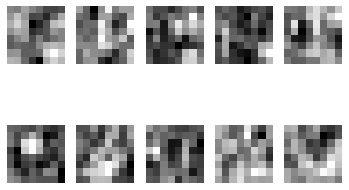

Batch 122/938 - Opimize G - Avg Batch Loss: 0.0976 - Time : 3.60s
Batch 123/938 - Opimize G - Avg Batch Loss: 0.1734 - Time : 3.68s
Batch 124/938 - Opimize G - Avg Batch Loss: 0.2168 - Time : 3.61s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.1438 - Time : 3.61s
Batch 126/938 - Opimize G - Avg Batch Loss: 0.1631 - Time : 3.44s
Batch 127/938 - Opimize D - Avg Batch Loss: 0.1878 - Time : 3.42s
Batch 128/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.46s
Batch 129/938 - Opimize G - Avg Batch Loss: 0.1065 - Time : 3.51s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.1938 - Time : 3.68s
Batch 131/938 - Opimize G - Avg Batch Loss: 0.1094 - Time : 3.63s
Batch 132/938 - Opimize G - Avg Batch Loss: 0.1875 - Time : 3.42s
Batch 133/938 - Opimize D - Avg Batch Loss: 0.1517 - Time : 3.66s
Batch 134/938 - Opimize G - Avg Batch Loss: 0.1196 - Time : 3.48s
Batch 135/938 - Opimize G - Avg Batch Loss: 0.1468 - Time : 3.46s
Batch 136/938 - Opimize G - Avg Batch Loss: 0.1278 - Time : 3.82s
Batch 137/

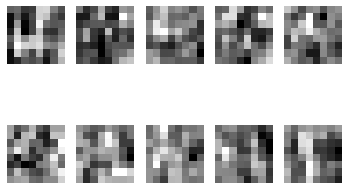

Batch 142/938 - Opimize G - Avg Batch Loss: 0.1801 - Time : 3.54s
Batch 143/938 - Opimize G - Avg Batch Loss: 0.1411 - Time : 3.76s
Batch 144/938 - Opimize G - Avg Batch Loss: 0.0712 - Time : 3.60s
Batch 145/938 - Opimize D - Avg Batch Loss: 0.1376 - Time : 3.56s
Batch 146/938 - Opimize G - Avg Batch Loss: 0.1437 - Time : 3.51s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.1218 - Time : 3.63s
Batch 148/938 - Opimize G - Avg Batch Loss: 0.0801 - Time : 3.60s
Batch 149/938 - Opimize G - Avg Batch Loss: 0.1108 - Time : 3.51s
Batch 150/938 - Opimize G - Avg Batch Loss: 0.1324 - Time : 3.69s
Batch 151/938 - Opimize D - Avg Batch Loss: 0.1770 - Time : 3.61s
Batch 152/938 - Opimize G - Avg Batch Loss: 0.1290 - Time : 3.76s
Batch 153/938 - Opimize G - Avg Batch Loss: 0.1342 - Time : 3.45s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.1075 - Time : 3.40s
Batch 155/938 - Opimize G - Avg Batch Loss: 0.1634 - Time : 3.45s
Batch 156/938 - Opimize G - Avg Batch Loss: 0.1714 - Time : 3.44s
Batch 157/

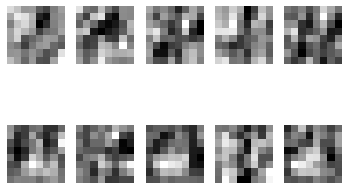

Batch 162/938 - Opimize G - Avg Batch Loss: 0.1570 - Time : 3.40s
Batch 163/938 - Opimize D - Avg Batch Loss: 0.1528 - Time : 3.40s
Batch 164/938 - Opimize G - Avg Batch Loss: 0.1030 - Time : 3.64s
Batch 165/938 - Opimize G - Avg Batch Loss: 0.1948 - Time : 3.68s
Batch 166/938 - Opimize G - Avg Batch Loss: 0.1413 - Time : 3.84s
Batch 167/938 - Opimize G - Avg Batch Loss: 0.1300 - Time : 3.43s
Batch 168/938 - Opimize G - Avg Batch Loss: 0.0699 - Time : 3.39s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.1262 - Time : 3.56s
Batch 170/938 - Opimize G - Avg Batch Loss: 0.1650 - Time : 3.39s
Batch 171/938 - Opimize G - Avg Batch Loss: 0.1423 - Time : 3.62s
Batch 172/938 - Opimize G - Avg Batch Loss: 0.0735 - Time : 3.41s
Batch 173/938 - Opimize G - Avg Batch Loss: 0.1236 - Time : 3.73s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.1742 - Time : 3.84s
Batch 175/938 - Opimize D - Avg Batch Loss: 0.1139 - Time : 3.49s
Batch 176/938 - Opimize G - Avg Batch Loss: 0.0477 - Time : 3.73s
Batch 177/

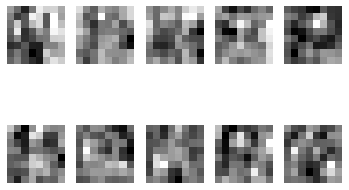

Batch 182/938 - Opimize G - Avg Batch Loss: 0.0889 - Time : 3.56s
Batch 183/938 - Opimize G - Avg Batch Loss: 0.0868 - Time : 3.57s
Batch 184/938 - Opimize G - Avg Batch Loss: 0.0860 - Time : 3.43s
Batch 185/938 - Opimize G - Avg Batch Loss: 0.1661 - Time : 3.59s
Batch 186/938 - Opimize G - Avg Batch Loss: 0.1446 - Time : 3.65s
Batch 187/938 - Opimize D - Avg Batch Loss: 0.0950 - Time : 3.57s
Batch 188/938 - Opimize G - Avg Batch Loss: 0.1205 - Time : 3.42s
Batch 189/938 - Opimize G - Avg Batch Loss: 0.1843 - Time : 3.67s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.2118 - Time : 3.54s
Batch 191/938 - Opimize G - Avg Batch Loss: 0.1196 - Time : 3.97s
Batch 192/938 - Opimize G - Avg Batch Loss: 0.1982 - Time : 3.67s
Batch 193/938 - Opimize D - Avg Batch Loss: 0.1862 - Time : 3.61s
Batch 194/938 - Opimize G - Avg Batch Loss: 0.2236 - Time : 3.46s
Batch 195/938 - Opimize G - Avg Batch Loss: 0.1663 - Time : 3.83s
Batch 196/938 - Opimize G - Avg Batch Loss: 0.0840 - Time : 3.79s
Batch 197/

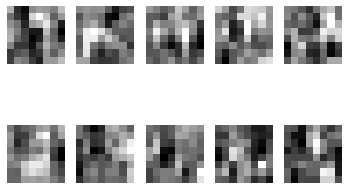

Batch 202/938 - Opimize G - Avg Batch Loss: 0.1854 - Time : 4.01s
Batch 203/938 - Opimize G - Avg Batch Loss: 0.1733 - Time : 3.97s
Batch 204/938 - Opimize G - Avg Batch Loss: 0.1925 - Time : 3.45s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.1274 - Time : 3.50s
Batch 206/938 - Opimize G - Avg Batch Loss: 0.1742 - Time : 3.52s
Batch 207/938 - Opimize G - Avg Batch Loss: 0.1266 - Time : 3.43s
Batch 208/938 - Opimize G - Avg Batch Loss: 0.1872 - Time : 3.48s
Batch 209/938 - Opimize G - Avg Batch Loss: 0.1274 - Time : 3.76s
Batch 210/938 - Opimize G - Avg Batch Loss: 0.1668 - Time : 3.50s
Batch 211/938 - Opimize D - Avg Batch Loss: 0.2021 - Time : 3.61s
Batch 212/938 - Opimize G - Avg Batch Loss: 0.1983 - Time : 3.53s
Batch 213/938 - Opimize G - Avg Batch Loss: 0.1350 - Time : 3.37s
Batch 214/938 - Opimize G - Avg Batch Loss: 0.1585 - Time : 3.76s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.1422 - Time : 3.58s
Batch 216/938 - Opimize G - Avg Batch Loss: 0.0907 - Time : 3.74s
Batch 217/

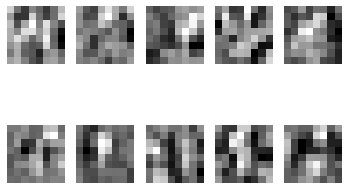

Batch 222/938 - Opimize G - Avg Batch Loss: 0.1511 - Time : 3.95s
Batch 223/938 - Opimize D - Avg Batch Loss: 0.1259 - Time : 3.41s
Batch 224/938 - Opimize G - Avg Batch Loss: 0.1785 - Time : 3.74s
Batch 225/938 - Opimize G - Avg Batch Loss: 0.1019 - Time : 3.72s
Batch 226/938 - Opimize G - Avg Batch Loss: 0.1434 - Time : 3.48s
Batch 227/938 - Opimize G - Avg Batch Loss: 0.1440 - Time : 3.57s
Batch 228/938 - Opimize G - Avg Batch Loss: 0.0977 - Time : 3.62s
Batch 229/938 - Opimize D - Avg Batch Loss: 0.1254 - Time : 3.47s
Batch 230/938 - Opimize G - Avg Batch Loss: 0.0984 - Time : 3.66s
Batch 231/938 - Opimize G - Avg Batch Loss: 0.1041 - Time : 3.83s
Batch 232/938 - Opimize G - Avg Batch Loss: 0.1348 - Time : 3.68s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.1601 - Time : 3.84s
Batch 234/938 - Opimize G - Avg Batch Loss: 0.1624 - Time : 3.57s
Batch 235/938 - Opimize D - Avg Batch Loss: 0.0733 - Time : 3.65s
Batch 236/938 - Opimize G - Avg Batch Loss: 0.0957 - Time : 3.86s
Batch 237/

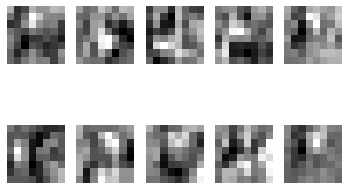

Batch 242/938 - Opimize G - Avg Batch Loss: 0.1238 - Time : 3.63s
Batch 243/938 - Opimize G - Avg Batch Loss: 0.1588 - Time : 3.37s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.1737 - Time : 3.60s
Batch 245/938 - Opimize G - Avg Batch Loss: 0.1169 - Time : 3.47s
Batch 246/938 - Opimize G - Avg Batch Loss: 0.1741 - Time : 3.65s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.1218 - Time : 3.41s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.1392 - Time : 3.41s
Batch 249/938 - Opimize G - Avg Batch Loss: 0.0787 - Time : 3.43s
Batch 250/938 - Opimize G - Avg Batch Loss: 0.1333 - Time : 3.41s
Batch 251/938 - Opimize G - Avg Batch Loss: 0.0931 - Time : 3.51s
Batch 252/938 - Opimize G - Avg Batch Loss: 0.1896 - Time : 4.09s
Batch 253/938 - Opimize D - Avg Batch Loss: 0.1314 - Time : 3.67s
Batch 254/938 - Opimize G - Avg Batch Loss: 0.0678 - Time : 3.54s
Batch 255/938 - Opimize G - Avg Batch Loss: 0.1211 - Time : 3.45s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.1245 - Time : 3.38s
Batch 257/

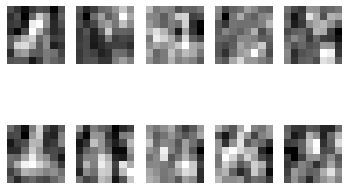

Batch 262/938 - Opimize G - Avg Batch Loss: 0.1167 - Time : 4.05s
Batch 263/938 - Opimize G - Avg Batch Loss: 0.1697 - Time : 3.73s
Batch 264/938 - Opimize G - Avg Batch Loss: 0.1233 - Time : 3.50s
Batch 265/938 - Opimize D - Avg Batch Loss: 0.1689 - Time : 3.85s
Batch 266/938 - Opimize G - Avg Batch Loss: 0.0598 - Time : 3.60s
Batch 267/938 - Opimize G - Avg Batch Loss: 0.1997 - Time : 3.98s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.1749 - Time : 3.70s
Batch 269/938 - Opimize G - Avg Batch Loss: 0.1522 - Time : 3.89s
Batch 270/938 - Opimize G - Avg Batch Loss: 0.1784 - Time : 3.71s
Batch 271/938 - Opimize D - Avg Batch Loss: 0.1224 - Time : 3.42s
Batch 272/938 - Opimize G - Avg Batch Loss: 0.1501 - Time : 3.52s
Batch 273/938 - Opimize G - Avg Batch Loss: 0.0921 - Time : 3.48s
Batch 274/938 - Opimize G - Avg Batch Loss: 0.1115 - Time : 3.99s
Batch 275/938 - Opimize G - Avg Batch Loss: 0.2228 - Time : 3.78s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.1088 - Time : 3.67s
Batch 277/

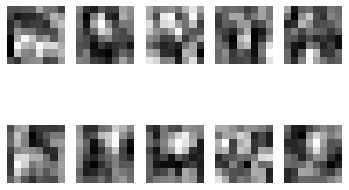

Batch 282/938 - Opimize G - Avg Batch Loss: 0.1387 - Time : 3.37s
Batch 283/938 - Opimize D - Avg Batch Loss: 0.1188 - Time : 3.87s
Batch 284/938 - Opimize G - Avg Batch Loss: 0.1000 - Time : 3.41s
Batch 285/938 - Opimize G - Avg Batch Loss: 0.1505 - Time : 3.52s
Batch 286/938 - Opimize G - Avg Batch Loss: 0.1523 - Time : 3.95s
Batch 287/938 - Opimize G - Avg Batch Loss: 0.0751 - Time : 3.46s
Batch 288/938 - Opimize G - Avg Batch Loss: 0.1139 - Time : 3.57s
Batch 289/938 - Opimize D - Avg Batch Loss: 0.1664 - Time : 3.69s
Batch 290/938 - Opimize G - Avg Batch Loss: 0.1634 - Time : 3.71s
Batch 291/938 - Opimize G - Avg Batch Loss: 0.0828 - Time : 3.55s
Batch 292/938 - Opimize G - Avg Batch Loss: 0.0713 - Time : 3.47s
Batch 293/938 - Opimize G - Avg Batch Loss: 0.0894 - Time : 3.61s
Batch 294/938 - Opimize G - Avg Batch Loss: 0.1305 - Time : 3.54s
Batch 295/938 - Opimize D - Avg Batch Loss: 0.1185 - Time : 3.48s
Batch 296/938 - Opimize G - Avg Batch Loss: 0.1098 - Time : 3.58s
Batch 297/

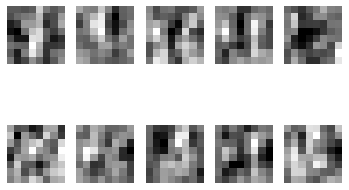

Batch 302/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 3.52s
Batch 303/938 - Opimize G - Avg Batch Loss: 0.1499 - Time : 3.58s
Batch 304/938 - Opimize G - Avg Batch Loss: 0.1802 - Time : 3.68s
Batch 305/938 - Opimize G - Avg Batch Loss: 0.1309 - Time : 3.58s
Batch 306/938 - Opimize G - Avg Batch Loss: 0.1298 - Time : 3.51s
Batch 307/938 - Opimize D - Avg Batch Loss: 0.1640 - Time : 3.46s
Batch 308/938 - Opimize G - Avg Batch Loss: 0.1634 - Time : 3.97s
Batch 309/938 - Opimize G - Avg Batch Loss: 0.1866 - Time : 4.04s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.0788 - Time : 3.45s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.0496 - Time : 3.87s
Batch 312/938 - Opimize G - Avg Batch Loss: 0.1185 - Time : 3.76s
Batch 313/938 - Opimize D - Avg Batch Loss: 0.0835 - Time : 4.10s
Batch 314/938 - Opimize G - Avg Batch Loss: 0.0969 - Time : 3.62s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.1498 - Time : 3.57s
Batch 316/938 - Opimize G - Avg Batch Loss: 0.1065 - Time : 3.41s
Batch 317/

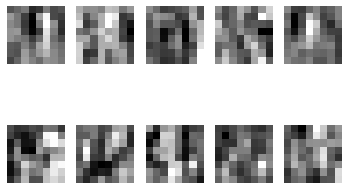

Batch 322/938 - Opimize G - Avg Batch Loss: 0.0658 - Time : 3.43s
Batch 323/938 - Opimize G - Avg Batch Loss: 0.1127 - Time : 3.96s
Batch 324/938 - Opimize G - Avg Batch Loss: 0.1343 - Time : 3.52s
Batch 325/938 - Opimize D - Avg Batch Loss: 0.1365 - Time : 3.57s
Batch 326/938 - Opimize G - Avg Batch Loss: 0.0487 - Time : 3.67s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.1624 - Time : 3.62s
Batch 328/938 - Opimize G - Avg Batch Loss: 0.1494 - Time : 3.52s
Batch 329/938 - Opimize G - Avg Batch Loss: 0.0597 - Time : 3.55s
Batch 330/938 - Opimize G - Avg Batch Loss: 0.1241 - Time : 3.40s
Batch 331/938 - Opimize D - Avg Batch Loss: 0.1637 - Time : 3.87s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.1088 - Time : 3.83s
Batch 333/938 - Opimize G - Avg Batch Loss: 0.1166 - Time : 3.66s
Batch 334/938 - Opimize G - Avg Batch Loss: 0.1493 - Time : 3.69s
Batch 335/938 - Opimize G - Avg Batch Loss: 0.0721 - Time : 3.56s
Batch 336/938 - Opimize G - Avg Batch Loss: 0.1343 - Time : 3.91s
Batch 337/

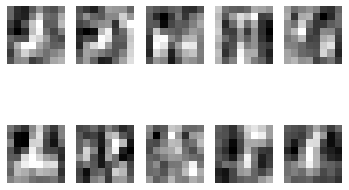

Batch 342/938 - Opimize G - Avg Batch Loss: 0.2275 - Time : 3.60s
Batch 343/938 - Opimize D - Avg Batch Loss: 0.1307 - Time : 3.69s
Batch 344/938 - Opimize G - Avg Batch Loss: 0.1348 - Time : 3.97s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.1952 - Time : 3.73s
Batch 346/938 - Opimize G - Avg Batch Loss: 0.1200 - Time : 3.77s
Batch 347/938 - Opimize G - Avg Batch Loss: 0.1285 - Time : 3.81s
Batch 348/938 - Opimize G - Avg Batch Loss: 0.1457 - Time : 3.70s
Batch 349/938 - Opimize D - Avg Batch Loss: 0.1505 - Time : 3.64s
Batch 350/938 - Opimize G - Avg Batch Loss: 0.1409 - Time : 3.73s
Batch 351/938 - Opimize G - Avg Batch Loss: 0.1131 - Time : 3.59s
Batch 352/938 - Opimize G - Avg Batch Loss: 0.1225 - Time : 3.75s
Batch 353/938 - Opimize G - Avg Batch Loss: 0.1536 - Time : 3.64s
Batch 354/938 - Opimize G - Avg Batch Loss: 0.1931 - Time : 3.59s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.2636 - Time : 3.58s
Batch 356/938 - Opimize G - Avg Batch Loss: 0.1862 - Time : 3.65s
Batch 357/

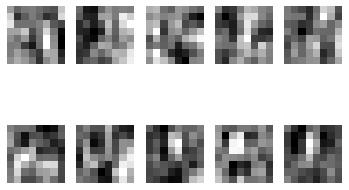

Batch 362/938 - Opimize G - Avg Batch Loss: 0.0543 - Time : 3.42s
Batch 363/938 - Opimize G - Avg Batch Loss: 0.1294 - Time : 3.45s
Batch 364/938 - Opimize G - Avg Batch Loss: 0.1269 - Time : 3.41s
Batch 365/938 - Opimize G - Avg Batch Loss: 0.1444 - Time : 3.49s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.1094 - Time : 4.10s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.1353 - Time : 3.40s
Batch 368/938 - Opimize G - Avg Batch Loss: 0.0864 - Time : 3.38s
Batch 369/938 - Opimize G - Avg Batch Loss: 0.1242 - Time : 3.56s
Batch 370/938 - Opimize G - Avg Batch Loss: 0.0841 - Time : 3.67s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.2469 - Time : 3.43s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.1299 - Time : 3.60s
Batch 373/938 - Opimize D - Avg Batch Loss: 0.1145 - Time : 4.10s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.0711 - Time : 3.84s
Batch 375/938 - Opimize G - Avg Batch Loss: 0.1687 - Time : 3.45s
Batch 376/938 - Opimize G - Avg Batch Loss: 0.1862 - Time : 3.83s
Batch 377/

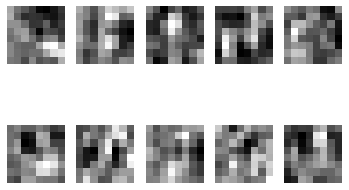

Batch 382/938 - Opimize G - Avg Batch Loss: 0.1145 - Time : 3.82s
Batch 383/938 - Opimize G - Avg Batch Loss: 0.1738 - Time : 3.74s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.1217 - Time : 3.52s
Batch 385/938 - Opimize D - Avg Batch Loss: 0.1798 - Time : 3.81s
Batch 386/938 - Opimize G - Avg Batch Loss: 0.1520 - Time : 3.86s
Batch 387/938 - Opimize G - Avg Batch Loss: 0.0591 - Time : 3.59s
Batch 388/938 - Opimize G - Avg Batch Loss: 0.0825 - Time : 3.52s
Batch 389/938 - Opimize G - Avg Batch Loss: 0.0997 - Time : 3.46s
Batch 390/938 - Opimize G - Avg Batch Loss: 0.1889 - Time : 3.65s
Batch 391/938 - Opimize D - Avg Batch Loss: 0.1467 - Time : 3.70s
Batch 392/938 - Opimize G - Avg Batch Loss: 0.1021 - Time : 3.52s
Batch 393/938 - Opimize G - Avg Batch Loss: 0.0909 - Time : 3.61s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.1445 - Time : 3.46s
Batch 395/938 - Opimize G - Avg Batch Loss: 0.1442 - Time : 3.50s
Batch 396/938 - Opimize G - Avg Batch Loss: 0.0643 - Time : 3.60s
Batch 397/

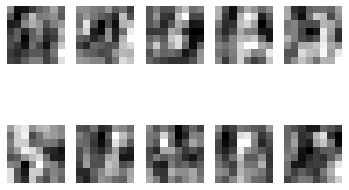

Batch 402/938 - Opimize G - Avg Batch Loss: 0.0584 - Time : 3.40s
Batch 403/938 - Opimize D - Avg Batch Loss: 0.1206 - Time : 3.40s
Batch 404/938 - Opimize G - Avg Batch Loss: 0.0883 - Time : 3.39s
Batch 405/938 - Opimize G - Avg Batch Loss: 0.1913 - Time : 3.92s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.0562 - Time : 3.38s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.0669 - Time : 3.48s
Batch 408/938 - Opimize G - Avg Batch Loss: 0.1308 - Time : 3.55s
Batch 409/938 - Opimize D - Avg Batch Loss: 0.1304 - Time : 3.91s
Batch 410/938 - Opimize G - Avg Batch Loss: 0.1609 - Time : 3.62s
Batch 411/938 - Opimize G - Avg Batch Loss: 0.0843 - Time : 3.40s
Batch 412/938 - Opimize G - Avg Batch Loss: 0.0982 - Time : 3.47s
Batch 413/938 - Opimize G - Avg Batch Loss: 0.1137 - Time : 3.39s
Batch 414/938 - Opimize G - Avg Batch Loss: 0.1826 - Time : 3.88s
Batch 415/938 - Opimize D - Avg Batch Loss: 0.1034 - Time : 3.53s
Batch 416/938 - Opimize G - Avg Batch Loss: 0.1237 - Time : 3.40s
Batch 417/

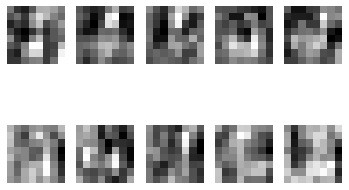

Batch 422/938 - Opimize G - Avg Batch Loss: 0.0826 - Time : 3.72s
Batch 423/938 - Opimize G - Avg Batch Loss: 0.1406 - Time : 3.67s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.1316 - Time : 3.60s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.1364 - Time : 3.60s
Batch 426/938 - Opimize G - Avg Batch Loss: 0.1285 - Time : 3.39s
Batch 427/938 - Opimize D - Avg Batch Loss: 0.0986 - Time : 3.77s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.1457 - Time : 3.69s
Batch 429/938 - Opimize G - Avg Batch Loss: 0.1810 - Time : 3.45s
Batch 430/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.47s
Batch 431/938 - Opimize G - Avg Batch Loss: 0.0727 - Time : 3.63s
Batch 432/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.73s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.1407 - Time : 3.67s
Batch 434/938 - Opimize G - Avg Batch Loss: 0.1435 - Time : 3.60s
Batch 435/938 - Opimize G - Avg Batch Loss: 0.1687 - Time : 3.68s
Batch 436/938 - Opimize G - Avg Batch Loss: 0.1222 - Time : 3.74s
Batch 437/

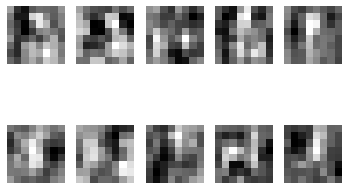

Batch 442/938 - Opimize G - Avg Batch Loss: 0.1279 - Time : 3.39s
Batch 443/938 - Opimize G - Avg Batch Loss: 0.0579 - Time : 3.53s
Batch 444/938 - Opimize G - Avg Batch Loss: 0.0841 - Time : 3.46s
Batch 445/938 - Opimize D - Avg Batch Loss: 0.1483 - Time : 3.44s
Batch 446/938 - Opimize G - Avg Batch Loss: 0.0926 - Time : 3.53s
Batch 447/938 - Opimize G - Avg Batch Loss: 0.1066 - Time : 3.40s
Batch 448/938 - Opimize G - Avg Batch Loss: 0.1207 - Time : 3.46s
Batch 449/938 - Opimize G - Avg Batch Loss: 0.1092 - Time : 3.57s
Batch 450/938 - Opimize G - Avg Batch Loss: 0.0661 - Time : 3.54s
Batch 451/938 - Opimize D - Avg Batch Loss: 0.1173 - Time : 3.39s
Batch 452/938 - Opimize G - Avg Batch Loss: 0.1501 - Time : 3.39s
Batch 453/938 - Opimize G - Avg Batch Loss: 0.0936 - Time : 3.65s
Batch 454/938 - Opimize G - Avg Batch Loss: 0.1497 - Time : 3.55s
Batch 455/938 - Opimize G - Avg Batch Loss: 0.0805 - Time : 3.51s
Batch 456/938 - Opimize G - Avg Batch Loss: 0.1104 - Time : 3.81s
Batch 457/

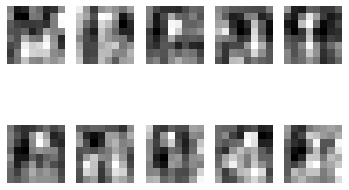

Batch 462/938 - Opimize G - Avg Batch Loss: 0.0827 - Time : 3.72s
Batch 463/938 - Opimize D - Avg Batch Loss: 0.2210 - Time : 3.42s
Batch 464/938 - Opimize G - Avg Batch Loss: 0.0945 - Time : 3.46s
Batch 465/938 - Opimize G - Avg Batch Loss: 0.1095 - Time : 3.45s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.1190 - Time : 3.43s
Batch 467/938 - Opimize G - Avg Batch Loss: 0.1140 - Time : 3.63s
Batch 468/938 - Opimize G - Avg Batch Loss: 0.1726 - Time : 3.64s
Batch 469/938 - Opimize D - Avg Batch Loss: 0.0604 - Time : 3.40s
Batch 470/938 - Opimize G - Avg Batch Loss: 0.1293 - Time : 3.92s
Batch 471/938 - Opimize G - Avg Batch Loss: 0.1751 - Time : 3.52s
Batch 472/938 - Opimize G - Avg Batch Loss: 0.1370 - Time : 3.58s
Batch 473/938 - Opimize G - Avg Batch Loss: 0.1955 - Time : 3.42s
Batch 474/938 - Opimize G - Avg Batch Loss: 0.1109 - Time : 3.41s
Batch 475/938 - Opimize D - Avg Batch Loss: 0.0801 - Time : 3.43s
Batch 476/938 - Opimize G - Avg Batch Loss: 0.1187 - Time : 3.55s
Batch 477/

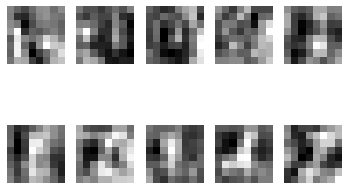

Batch 482/938 - Opimize G - Avg Batch Loss: 0.0944 - Time : 3.39s
Batch 483/938 - Opimize G - Avg Batch Loss: 0.0863 - Time : 3.72s
Batch 484/938 - Opimize G - Avg Batch Loss: 0.1213 - Time : 3.49s
Batch 485/938 - Opimize G - Avg Batch Loss: 0.1971 - Time : 3.42s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.1118 - Time : 3.41s
Batch 487/938 - Opimize D - Avg Batch Loss: 0.1964 - Time : 3.58s
Batch 488/938 - Opimize G - Avg Batch Loss: 0.1153 - Time : 3.65s
Batch 489/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.55s
Batch 490/938 - Opimize G - Avg Batch Loss: 0.1929 - Time : 3.97s
Batch 491/938 - Opimize G - Avg Batch Loss: 0.1149 - Time : 3.53s
Batch 492/938 - Opimize G - Avg Batch Loss: 0.0892 - Time : 3.59s
Batch 493/938 - Opimize D - Avg Batch Loss: 0.1861 - Time : 3.39s
Batch 494/938 - Opimize G - Avg Batch Loss: 0.0128 - Time : 3.53s
Batch 495/938 - Opimize G - Avg Batch Loss: 0.2199 - Time : 3.40s
Batch 496/938 - Opimize G - Avg Batch Loss: 0.1059 - Time : 3.60s
Batch 497/

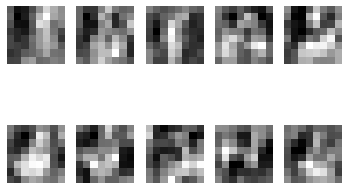

Batch 502/938 - Opimize G - Avg Batch Loss: 0.1107 - Time : 3.80s
Batch 503/938 - Opimize G - Avg Batch Loss: 0.1425 - Time : 3.41s
Batch 504/938 - Opimize G - Avg Batch Loss: 0.1350 - Time : 3.67s
Batch 505/938 - Opimize D - Avg Batch Loss: 0.0971 - Time : 3.76s
Batch 506/938 - Opimize G - Avg Batch Loss: 0.1373 - Time : 3.43s
Batch 507/938 - Opimize G - Avg Batch Loss: 0.0989 - Time : 3.84s
Batch 508/938 - Opimize G - Avg Batch Loss: 0.0989 - Time : 3.51s
Batch 509/938 - Opimize G - Avg Batch Loss: 0.1495 - Time : 3.71s
Batch 510/938 - Opimize G - Avg Batch Loss: 0.1320 - Time : 3.79s
Batch 511/938 - Opimize D - Avg Batch Loss: 0.1123 - Time : 3.53s
Batch 512/938 - Opimize G - Avg Batch Loss: 0.1990 - Time : 3.65s
Batch 513/938 - Opimize G - Avg Batch Loss: 0.0800 - Time : 3.97s
Batch 514/938 - Opimize G - Avg Batch Loss: 0.0929 - Time : 3.62s
Batch 515/938 - Opimize G - Avg Batch Loss: 0.0428 - Time : 3.49s
Batch 516/938 - Opimize G - Avg Batch Loss: 0.0677 - Time : 3.55s
Batch 517/

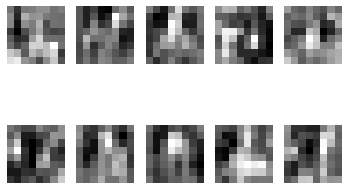

Batch 522/938 - Opimize G - Avg Batch Loss: 0.0574 - Time : 3.40s
Batch 523/938 - Opimize D - Avg Batch Loss: 0.1388 - Time : 3.40s
Batch 524/938 - Opimize G - Avg Batch Loss: -0.0167 - Time : 3.43s
Batch 525/938 - Opimize G - Avg Batch Loss: 0.0305 - Time : 3.40s
Batch 526/938 - Opimize G - Avg Batch Loss: 0.1542 - Time : 3.73s
Batch 527/938 - Opimize G - Avg Batch Loss: 0.0901 - Time : 3.65s
Batch 528/938 - Opimize G - Avg Batch Loss: 0.1956 - Time : 4.22s
Batch 529/938 - Opimize D - Avg Batch Loss: 0.0802 - Time : 3.55s
Batch 530/938 - Opimize G - Avg Batch Loss: 0.1444 - Time : 3.72s
Batch 531/938 - Opimize G - Avg Batch Loss: 0.1122 - Time : 3.88s
Batch 532/938 - Opimize G - Avg Batch Loss: 0.0557 - Time : 3.69s
Batch 533/938 - Opimize G - Avg Batch Loss: 0.0643 - Time : 3.42s
Batch 534/938 - Opimize G - Avg Batch Loss: 0.0660 - Time : 3.71s
Batch 535/938 - Opimize D - Avg Batch Loss: 0.1499 - Time : 3.58s
Batch 536/938 - Opimize G - Avg Batch Loss: 0.0654 - Time : 3.53s
Batch 537

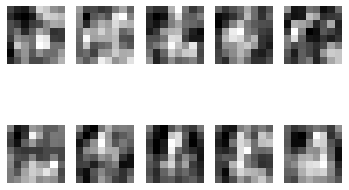

Batch 542/938 - Opimize G - Avg Batch Loss: 0.0809 - Time : 3.77s
Batch 543/938 - Opimize G - Avg Batch Loss: 0.0890 - Time : 3.86s
Batch 544/938 - Opimize G - Avg Batch Loss: 0.1862 - Time : 3.91s
Batch 545/938 - Opimize G - Avg Batch Loss: 0.0958 - Time : 3.40s
Batch 546/938 - Opimize G - Avg Batch Loss: 0.1131 - Time : 3.66s
Batch 547/938 - Opimize D - Avg Batch Loss: 0.0983 - Time : 3.50s
Batch 548/938 - Opimize G - Avg Batch Loss: 0.1068 - Time : 3.77s
Batch 549/938 - Opimize G - Avg Batch Loss: 0.1090 - Time : 3.86s
Batch 550/938 - Opimize G - Avg Batch Loss: 0.1142 - Time : 3.54s
Batch 551/938 - Opimize G - Avg Batch Loss: 0.0781 - Time : 3.42s
Batch 552/938 - Opimize G - Avg Batch Loss: 0.1860 - Time : 3.52s
Batch 553/938 - Opimize D - Avg Batch Loss: 0.1141 - Time : 3.39s
Batch 554/938 - Opimize G - Avg Batch Loss: 0.1493 - Time : 3.67s
Batch 555/938 - Opimize G - Avg Batch Loss: 0.0733 - Time : 3.66s
Batch 556/938 - Opimize G - Avg Batch Loss: 0.0449 - Time : 3.46s
Batch 557/

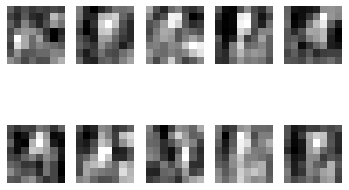

Batch 562/938 - Opimize G - Avg Batch Loss: 0.1659 - Time : 3.48s
Batch 563/938 - Opimize G - Avg Batch Loss: 0.1104 - Time : 3.47s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.0608 - Time : 3.42s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.1300 - Time : 4.07s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.0702 - Time : 3.52s
Batch 567/938 - Opimize G - Avg Batch Loss: 0.1481 - Time : 3.60s
Batch 568/938 - Opimize G - Avg Batch Loss: 0.0798 - Time : 3.66s
Batch 569/938 - Opimize G - Avg Batch Loss: 0.1934 - Time : 3.68s
Batch 570/938 - Opimize G - Avg Batch Loss: 0.1792 - Time : 3.41s
Batch 571/938 - Opimize D - Avg Batch Loss: 0.0350 - Time : 3.55s
Batch 572/938 - Opimize G - Avg Batch Loss: 0.1023 - Time : 3.44s
Batch 573/938 - Opimize G - Avg Batch Loss: 0.0528 - Time : 3.89s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.1178 - Time : 3.43s
Batch 575/938 - Opimize G - Avg Batch Loss: 0.1233 - Time : 3.50s
Batch 576/938 - Opimize G - Avg Batch Loss: 0.1123 - Time : 3.55s
Batch 577/

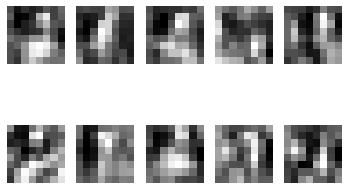

Batch 582/938 - Opimize G - Avg Batch Loss: 0.1225 - Time : 4.09s
Batch 583/938 - Opimize D - Avg Batch Loss: 0.1041 - Time : 3.70s
Batch 584/938 - Opimize G - Avg Batch Loss: 0.1088 - Time : 3.75s
Batch 585/938 - Opimize G - Avg Batch Loss: 0.1120 - Time : 3.90s
Batch 586/938 - Opimize G - Avg Batch Loss: 0.1009 - Time : 3.88s
Batch 587/938 - Opimize G - Avg Batch Loss: 0.1350 - Time : 3.77s
Batch 588/938 - Opimize G - Avg Batch Loss: 0.0829 - Time : 3.72s
Batch 589/938 - Opimize D - Avg Batch Loss: 0.1280 - Time : 3.58s
Batch 590/938 - Opimize G - Avg Batch Loss: 0.0895 - Time : 3.86s
Batch 591/938 - Opimize G - Avg Batch Loss: 0.0857 - Time : 3.76s
Batch 592/938 - Opimize G - Avg Batch Loss: 0.0950 - Time : 4.16s
Batch 593/938 - Opimize G - Avg Batch Loss: 0.1144 - Time : 4.12s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.1354 - Time : 3.43s
Batch 595/938 - Opimize D - Avg Batch Loss: 0.1443 - Time : 3.97s
Batch 596/938 - Opimize G - Avg Batch Loss: 0.1621 - Time : 3.72s
Batch 597/

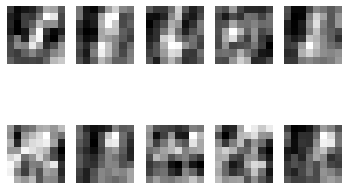

Batch 602/938 - Opimize G - Avg Batch Loss: 0.1077 - Time : 3.43s
Batch 603/938 - Opimize G - Avg Batch Loss: 0.1630 - Time : 4.12s
Batch 604/938 - Opimize G - Avg Batch Loss: 0.0904 - Time : 3.78s
Batch 605/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.76s
Batch 606/938 - Opimize G - Avg Batch Loss: 0.1170 - Time : 3.48s
Batch 607/938 - Opimize D - Avg Batch Loss: 0.1680 - Time : 3.44s
Batch 608/938 - Opimize G - Avg Batch Loss: 0.1292 - Time : 3.54s
Batch 609/938 - Opimize G - Avg Batch Loss: 0.0318 - Time : 3.87s
Batch 610/938 - Opimize G - Avg Batch Loss: 0.0970 - Time : 3.43s
Batch 611/938 - Opimize G - Avg Batch Loss: 0.1981 - Time : 3.52s
Batch 612/938 - Opimize G - Avg Batch Loss: 0.1033 - Time : 3.68s
Batch 613/938 - Opimize D - Avg Batch Loss: 0.1050 - Time : 3.47s
Batch 614/938 - Opimize G - Avg Batch Loss: 0.1099 - Time : 3.81s
Batch 615/938 - Opimize G - Avg Batch Loss: 0.1885 - Time : 3.69s
Batch 616/938 - Opimize G - Avg Batch Loss: 0.1113 - Time : 3.90s
Batch 617/

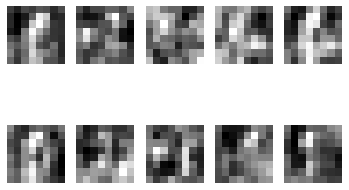

Batch 622/938 - Opimize G - Avg Batch Loss: 0.1299 - Time : 3.64s
Batch 623/938 - Opimize G - Avg Batch Loss: 0.0489 - Time : 3.45s
Batch 624/938 - Opimize G - Avg Batch Loss: 0.0727 - Time : 3.60s
Batch 625/938 - Opimize D - Avg Batch Loss: 0.1744 - Time : 3.53s
Batch 626/938 - Opimize G - Avg Batch Loss: 0.1187 - Time : 3.62s
Batch 627/938 - Opimize G - Avg Batch Loss: 0.0647 - Time : 3.45s
Batch 628/938 - Opimize G - Avg Batch Loss: 0.0737 - Time : 3.54s
Batch 629/938 - Opimize G - Avg Batch Loss: 0.0434 - Time : 3.49s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.1050 - Time : 3.72s
Batch 631/938 - Opimize D - Avg Batch Loss: 0.1327 - Time : 3.46s
Batch 632/938 - Opimize G - Avg Batch Loss: 0.0758 - Time : 3.39s
Batch 633/938 - Opimize G - Avg Batch Loss: 0.1927 - Time : 3.82s
Batch 634/938 - Opimize G - Avg Batch Loss: 0.1133 - Time : 3.44s
Batch 635/938 - Opimize G - Avg Batch Loss: 0.0727 - Time : 3.48s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.0384 - Time : 3.54s
Batch 637/

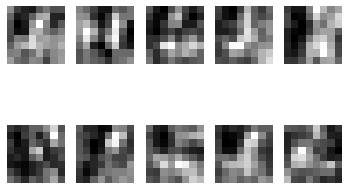

Batch 642/938 - Opimize G - Avg Batch Loss: 0.1240 - Time : 3.58s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.1693 - Time : 3.51s
Batch 644/938 - Opimize G - Avg Batch Loss: 0.0727 - Time : 3.70s
Batch 645/938 - Opimize G - Avg Batch Loss: 0.0685 - Time : 3.41s
Batch 646/938 - Opimize G - Avg Batch Loss: -0.0176 - Time : 4.06s
Batch 647/938 - Opimize G - Avg Batch Loss: 0.0646 - Time : 4.07s
Batch 648/938 - Opimize G - Avg Batch Loss: 0.1268 - Time : 3.88s
Batch 649/938 - Opimize D - Avg Batch Loss: 0.0814 - Time : 3.81s
Batch 650/938 - Opimize G - Avg Batch Loss: 0.0840 - Time : 3.84s
Batch 651/938 - Opimize G - Avg Batch Loss: 0.0555 - Time : 3.44s
Batch 652/938 - Opimize G - Avg Batch Loss: 0.0924 - Time : 3.70s
Batch 653/938 - Opimize G - Avg Batch Loss: 0.1362 - Time : 3.57s
Batch 654/938 - Opimize G - Avg Batch Loss: 0.1776 - Time : 3.53s
Batch 655/938 - Opimize D - Avg Batch Loss: 0.1056 - Time : 3.70s
Batch 656/938 - Opimize G - Avg Batch Loss: 0.0564 - Time : 4.02s
Batch 657

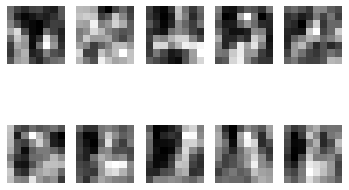

Batch 662/938 - Opimize G - Avg Batch Loss: 0.1378 - Time : 3.70s
Batch 663/938 - Opimize G - Avg Batch Loss: 0.1171 - Time : 4.06s
Batch 664/938 - Opimize G - Avg Batch Loss: 0.1134 - Time : 3.42s
Batch 665/938 - Opimize G - Avg Batch Loss: 0.0808 - Time : 3.48s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.1356 - Time : 3.49s
Batch 667/938 - Opimize D - Avg Batch Loss: 0.0704 - Time : 4.00s
Batch 668/938 - Opimize G - Avg Batch Loss: 0.0841 - Time : 3.79s
Batch 669/938 - Opimize G - Avg Batch Loss: 0.1881 - Time : 3.63s
Batch 670/938 - Opimize G - Avg Batch Loss: 0.0787 - Time : 3.71s
Batch 671/938 - Opimize G - Avg Batch Loss: 0.1230 - Time : 3.89s
Batch 672/938 - Opimize G - Avg Batch Loss: 0.1059 - Time : 3.43s
Batch 673/938 - Opimize D - Avg Batch Loss: 0.1838 - Time : 3.43s
Batch 674/938 - Opimize G - Avg Batch Loss: 0.1238 - Time : 3.74s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.0526 - Time : 3.65s
Batch 676/938 - Opimize G - Avg Batch Loss: 0.1376 - Time : 3.61s
Batch 677/

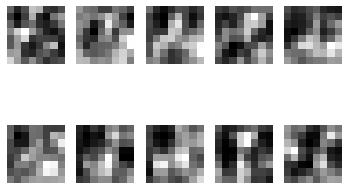

Batch 682/938 - Opimize G - Avg Batch Loss: 0.2358 - Time : 3.40s
Batch 683/938 - Opimize G - Avg Batch Loss: 0.0736 - Time : 3.72s
Batch 684/938 - Opimize G - Avg Batch Loss: 0.0538 - Time : 3.70s
Batch 685/938 - Opimize D - Avg Batch Loss: 0.1351 - Time : 3.95s
Batch 686/938 - Opimize G - Avg Batch Loss: 0.1665 - Time : 3.90s
Batch 687/938 - Opimize G - Avg Batch Loss: 0.0717 - Time : 3.70s
Batch 688/938 - Opimize G - Avg Batch Loss: 0.0832 - Time : 3.68s
Batch 689/938 - Opimize G - Avg Batch Loss: 0.1398 - Time : 3.48s
Batch 690/938 - Opimize G - Avg Batch Loss: 0.2150 - Time : 3.76s
Batch 691/938 - Opimize D - Avg Batch Loss: 0.1898 - Time : 3.51s
Batch 692/938 - Opimize G - Avg Batch Loss: 0.0954 - Time : 3.73s
Batch 693/938 - Opimize G - Avg Batch Loss: 0.0704 - Time : 3.46s
Batch 694/938 - Opimize G - Avg Batch Loss: 0.0868 - Time : 3.48s
Batch 695/938 - Opimize G - Avg Batch Loss: 0.1412 - Time : 3.39s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.1255 - Time : 3.56s
Batch 697/

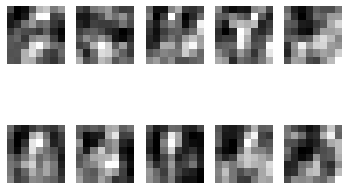

Batch 702/938 - Opimize G - Avg Batch Loss: 0.0364 - Time : 3.52s
Batch 703/938 - Opimize D - Avg Batch Loss: 0.0737 - Time : 3.84s
Batch 704/938 - Opimize G - Avg Batch Loss: 0.0852 - Time : 3.95s
Batch 705/938 - Opimize G - Avg Batch Loss: 0.0257 - Time : 3.84s
Batch 706/938 - Opimize G - Avg Batch Loss: 0.0832 - Time : 3.93s
Batch 707/938 - Opimize G - Avg Batch Loss: 0.0423 - Time : 3.47s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.1236 - Time : 3.71s
Batch 709/938 - Opimize D - Avg Batch Loss: 0.1014 - Time : 3.47s
Batch 710/938 - Opimize G - Avg Batch Loss: 0.1807 - Time : 3.68s
Batch 711/938 - Opimize G - Avg Batch Loss: 0.2229 - Time : 3.69s
Batch 712/938 - Opimize G - Avg Batch Loss: 0.1224 - Time : 3.84s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.1660 - Time : 3.67s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.0943 - Time : 4.31s
Batch 715/938 - Opimize D - Avg Batch Loss: 0.2046 - Time : 3.46s
Batch 716/938 - Opimize G - Avg Batch Loss: 0.0906 - Time : 3.55s
Batch 717/

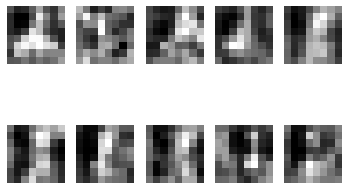

Batch 722/938 - Opimize G - Avg Batch Loss: 0.0751 - Time : 4.01s
Batch 723/938 - Opimize G - Avg Batch Loss: 0.1350 - Time : 3.68s
Batch 724/938 - Opimize G - Avg Batch Loss: 0.1761 - Time : 3.86s
Batch 725/938 - Opimize G - Avg Batch Loss: 0.1575 - Time : 3.47s
Batch 726/938 - Opimize G - Avg Batch Loss: 0.0385 - Time : 3.60s
Batch 727/938 - Opimize D - Avg Batch Loss: 0.0420 - Time : 3.67s
Batch 728/938 - Opimize G - Avg Batch Loss: 0.0606 - Time : 3.44s
Batch 729/938 - Opimize G - Avg Batch Loss: 0.1630 - Time : 3.48s
Batch 730/938 - Opimize G - Avg Batch Loss: 0.1506 - Time : 3.67s
Batch 731/938 - Opimize G - Avg Batch Loss: 0.1100 - Time : 3.79s
Batch 732/938 - Opimize G - Avg Batch Loss: 0.1735 - Time : 3.68s
Batch 733/938 - Opimize D - Avg Batch Loss: 0.0738 - Time : 3.80s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.1034 - Time : 3.77s
Batch 735/938 - Opimize G - Avg Batch Loss: 0.1815 - Time : 3.68s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.1147 - Time : 4.26s
Batch 737/

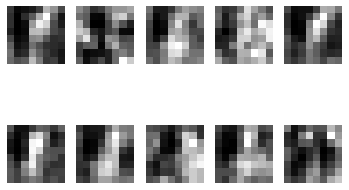

Batch 742/938 - Opimize G - Avg Batch Loss: 0.0752 - Time : 3.93s
Batch 743/938 - Opimize G - Avg Batch Loss: 0.0746 - Time : 3.52s
Batch 744/938 - Opimize G - Avg Batch Loss: 0.1658 - Time : 3.53s
Batch 745/938 - Opimize D - Avg Batch Loss: 0.1556 - Time : 4.03s
Batch 746/938 - Opimize G - Avg Batch Loss: 0.1082 - Time : 3.68s
Batch 747/938 - Opimize G - Avg Batch Loss: 0.0996 - Time : 3.71s
Batch 748/938 - Opimize G - Avg Batch Loss: 0.1039 - Time : 3.56s
Batch 749/938 - Opimize G - Avg Batch Loss: 0.0873 - Time : 3.50s
Batch 750/938 - Opimize G - Avg Batch Loss: 0.1765 - Time : 3.89s
Batch 751/938 - Opimize D - Avg Batch Loss: 0.1468 - Time : 3.49s
Batch 752/938 - Opimize G - Avg Batch Loss: 0.0992 - Time : 3.78s
Batch 753/938 - Opimize G - Avg Batch Loss: 0.0610 - Time : 3.52s
Batch 754/938 - Opimize G - Avg Batch Loss: 0.1151 - Time : 3.47s
Batch 755/938 - Opimize G - Avg Batch Loss: 0.1174 - Time : 3.80s
Batch 756/938 - Opimize G - Avg Batch Loss: 0.1320 - Time : 3.77s
Batch 757/

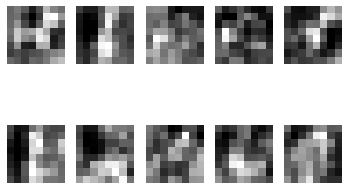

Batch 762/938 - Opimize G - Avg Batch Loss: 0.0719 - Time : 3.57s
Batch 763/938 - Opimize D - Avg Batch Loss: 0.0230 - Time : 3.79s
Batch 764/938 - Opimize G - Avg Batch Loss: 0.0602 - Time : 3.66s
Batch 765/938 - Opimize G - Avg Batch Loss: 0.1134 - Time : 3.78s
Batch 766/938 - Opimize G - Avg Batch Loss: 0.1092 - Time : 3.85s
Batch 767/938 - Opimize G - Avg Batch Loss: 0.0879 - Time : 3.51s
Batch 768/938 - Opimize G - Avg Batch Loss: 0.1760 - Time : 3.56s
Batch 769/938 - Opimize D - Avg Batch Loss: 0.2086 - Time : 3.52s
Batch 770/938 - Opimize G - Avg Batch Loss: 0.1127 - Time : 3.46s
Batch 771/938 - Opimize G - Avg Batch Loss: 0.1184 - Time : 3.63s
Batch 772/938 - Opimize G - Avg Batch Loss: 0.0763 - Time : 3.56s
Batch 773/938 - Opimize G - Avg Batch Loss: 0.0561 - Time : 3.58s
Batch 774/938 - Opimize G - Avg Batch Loss: 0.0904 - Time : 3.80s
Batch 775/938 - Opimize D - Avg Batch Loss: 0.1127 - Time : 3.85s
Batch 776/938 - Opimize G - Avg Batch Loss: 0.1028 - Time : 3.61s
Batch 777/

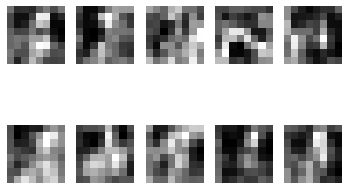

Batch 782/938 - Opimize G - Avg Batch Loss: 0.1008 - Time : 3.67s
Batch 783/938 - Opimize G - Avg Batch Loss: 0.0854 - Time : 3.61s
Batch 784/938 - Opimize G - Avg Batch Loss: 0.1669 - Time : 3.73s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.0882 - Time : 3.96s
Batch 786/938 - Opimize G - Avg Batch Loss: 0.0998 - Time : 3.65s
Batch 787/938 - Opimize D - Avg Batch Loss: 0.1145 - Time : 3.47s
Batch 788/938 - Opimize G - Avg Batch Loss: 0.2088 - Time : 3.75s
Batch 789/938 - Opimize G - Avg Batch Loss: 0.1280 - Time : 3.46s
Batch 790/938 - Opimize G - Avg Batch Loss: 0.0930 - Time : 3.55s
Batch 791/938 - Opimize G - Avg Batch Loss: 0.0681 - Time : 3.56s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.0788 - Time : 4.10s
Batch 793/938 - Opimize D - Avg Batch Loss: 0.1488 - Time : 3.82s
Batch 794/938 - Opimize G - Avg Batch Loss: 0.0829 - Time : 3.49s
Batch 795/938 - Opimize G - Avg Batch Loss: 0.0091 - Time : 3.77s
Batch 796/938 - Opimize G - Avg Batch Loss: 0.0802 - Time : 4.04s
Batch 797/

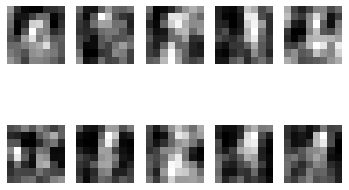

Batch 802/938 - Opimize G - Avg Batch Loss: 0.1208 - Time : 3.70s
Batch 803/938 - Opimize G - Avg Batch Loss: 0.0971 - Time : 3.50s
Batch 804/938 - Opimize G - Avg Batch Loss: 0.0838 - Time : 3.45s
Batch 805/938 - Opimize D - Avg Batch Loss: 0.1729 - Time : 3.44s
Batch 806/938 - Opimize G - Avg Batch Loss: 0.2497 - Time : 3.50s
Batch 807/938 - Opimize G - Avg Batch Loss: 0.0601 - Time : 3.49s
Batch 808/938 - Opimize G - Avg Batch Loss: 0.0674 - Time : 3.57s
Batch 809/938 - Opimize G - Avg Batch Loss: 0.0576 - Time : 3.79s
Batch 810/938 - Opimize G - Avg Batch Loss: 0.0802 - Time : 3.78s
Batch 811/938 - Opimize D - Avg Batch Loss: 0.1964 - Time : 3.55s
Batch 812/938 - Opimize G - Avg Batch Loss: 0.1306 - Time : 3.49s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.1008 - Time : 3.46s
Batch 814/938 - Opimize G - Avg Batch Loss: 0.0473 - Time : 3.51s
Batch 815/938 - Opimize G - Avg Batch Loss: 0.1433 - Time : 3.87s
Batch 816/938 - Opimize G - Avg Batch Loss: 0.0759 - Time : 3.66s
Batch 817/

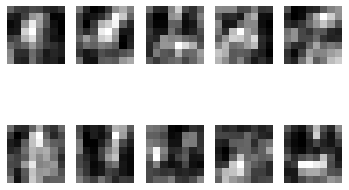

Batch 822/938 - Opimize G - Avg Batch Loss: 0.1433 - Time : 3.65s
Batch 823/938 - Opimize D - Avg Batch Loss: 0.0964 - Time : 3.60s
Batch 824/938 - Opimize G - Avg Batch Loss: 0.0755 - Time : 3.64s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.1027 - Time : 3.49s
Batch 826/938 - Opimize G - Avg Batch Loss: 0.1364 - Time : 3.63s
Batch 827/938 - Opimize G - Avg Batch Loss: 0.1619 - Time : 3.61s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.1529 - Time : 3.67s
Batch 829/938 - Opimize D - Avg Batch Loss: 0.0378 - Time : 3.74s
Batch 830/938 - Opimize G - Avg Batch Loss: 0.0719 - Time : 3.49s
Batch 831/938 - Opimize G - Avg Batch Loss: 0.0128 - Time : 3.53s
Batch 832/938 - Opimize G - Avg Batch Loss: 0.2180 - Time : 3.54s
Batch 833/938 - Opimize G - Avg Batch Loss: 0.0490 - Time : 3.83s
Batch 834/938 - Opimize G - Avg Batch Loss: 0.1815 - Time : 3.84s
Batch 835/938 - Opimize D - Avg Batch Loss: 0.0840 - Time : 3.51s
Batch 836/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.67s
Batch 837/

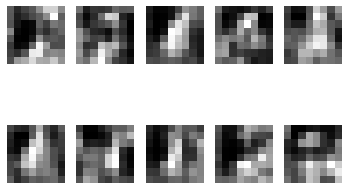

Batch 842/938 - Opimize G - Avg Batch Loss: 0.0859 - Time : 3.55s
Batch 843/938 - Opimize G - Avg Batch Loss: 0.1354 - Time : 3.53s
Batch 844/938 - Opimize G - Avg Batch Loss: 0.0394 - Time : 3.87s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.1213 - Time : 3.62s
Batch 846/938 - Opimize G - Avg Batch Loss: 0.1313 - Time : 3.46s
Batch 847/938 - Opimize D - Avg Batch Loss: 0.1853 - Time : 3.72s
Batch 848/938 - Opimize G - Avg Batch Loss: 0.1166 - Time : 3.48s
Batch 849/938 - Opimize G - Avg Batch Loss: 0.1493 - Time : 3.47s
Batch 850/938 - Opimize G - Avg Batch Loss: 0.0920 - Time : 3.78s
Batch 851/938 - Opimize G - Avg Batch Loss: 0.1157 - Time : 3.49s
Batch 852/938 - Opimize G - Avg Batch Loss: 0.1304 - Time : 3.72s
Batch 853/938 - Opimize D - Avg Batch Loss: 0.0584 - Time : 3.64s
Batch 854/938 - Opimize G - Avg Batch Loss: 0.0824 - Time : 3.58s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.1542 - Time : 3.66s
Batch 856/938 - Opimize G - Avg Batch Loss: 0.1022 - Time : 3.55s
Batch 857/

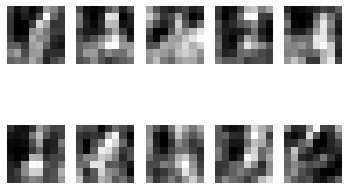

Batch 862/938 - Opimize G - Avg Batch Loss: 0.0416 - Time : 3.78s
Batch 863/938 - Opimize G - Avg Batch Loss: 0.1047 - Time : 3.55s
Batch 864/938 - Opimize G - Avg Batch Loss: 0.0060 - Time : 3.59s
Batch 865/938 - Opimize D - Avg Batch Loss: 0.0107 - Time : 3.50s
Batch 866/938 - Opimize G - Avg Batch Loss: 0.0602 - Time : 3.65s
Batch 867/938 - Opimize G - Avg Batch Loss: 0.0485 - Time : 3.49s
Batch 868/938 - Opimize G - Avg Batch Loss: 0.0952 - Time : 3.76s
Batch 869/938 - Opimize G - Avg Batch Loss: 0.1945 - Time : 3.73s
Batch 870/938 - Opimize G - Avg Batch Loss: 0.0687 - Time : 3.75s
Batch 871/938 - Opimize D - Avg Batch Loss: 0.0904 - Time : 3.75s
Batch 872/938 - Opimize G - Avg Batch Loss: 0.1435 - Time : 3.58s
Batch 873/938 - Opimize G - Avg Batch Loss: 0.1365 - Time : 3.80s
Batch 874/938 - Opimize G - Avg Batch Loss: 0.1585 - Time : 3.88s
Batch 875/938 - Opimize G - Avg Batch Loss: 0.0454 - Time : 3.61s
Batch 876/938 - Opimize G - Avg Batch Loss: 0.1184 - Time : 3.44s
Batch 877/

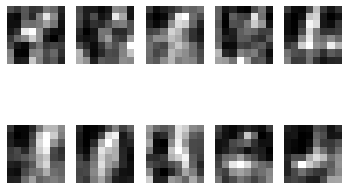

Batch 882/938 - Opimize G - Avg Batch Loss: 0.0699 - Time : 3.51s
Batch 883/938 - Opimize D - Avg Batch Loss: 0.0091 - Time : 3.65s
Batch 884/938 - Opimize G - Avg Batch Loss: 0.0742 - Time : 3.74s
Batch 885/938 - Opimize G - Avg Batch Loss: 0.0698 - Time : 3.46s
Batch 886/938 - Opimize G - Avg Batch Loss: 0.0474 - Time : 3.60s
Batch 887/938 - Opimize G - Avg Batch Loss: 0.1157 - Time : 3.49s
Batch 888/938 - Opimize G - Avg Batch Loss: 0.1309 - Time : 3.65s
Batch 889/938 - Opimize D - Avg Batch Loss: 0.1238 - Time : 3.63s
Batch 890/938 - Opimize G - Avg Batch Loss: 0.1502 - Time : 4.06s
Batch 891/938 - Opimize G - Avg Batch Loss: 0.1003 - Time : 3.77s
Batch 892/938 - Opimize G - Avg Batch Loss: 0.0810 - Time : 3.52s
Batch 893/938 - Opimize G - Avg Batch Loss: 0.0366 - Time : 3.64s
Batch 894/938 - Opimize G - Avg Batch Loss: 0.0805 - Time : 3.52s
Batch 895/938 - Opimize D - Avg Batch Loss: 0.0545 - Time : 3.54s
Batch 896/938 - Opimize G - Avg Batch Loss: 0.1235 - Time : 3.49s
Batch 897/

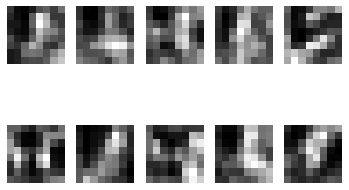

Batch 902/938 - Opimize G - Avg Batch Loss: 0.0753 - Time : 3.58s
Batch 903/938 - Opimize G - Avg Batch Loss: 0.0905 - Time : 3.50s
Batch 904/938 - Opimize G - Avg Batch Loss: 0.1294 - Time : 3.51s
Batch 905/938 - Opimize G - Avg Batch Loss: 0.1324 - Time : 3.49s
Batch 906/938 - Opimize G - Avg Batch Loss: 0.0774 - Time : 3.47s
Batch 907/938 - Opimize D - Avg Batch Loss: 0.0664 - Time : 3.65s
Batch 908/938 - Opimize G - Avg Batch Loss: 0.1254 - Time : 3.87s
Batch 909/938 - Opimize G - Avg Batch Loss: 0.0972 - Time : 3.54s
Batch 910/938 - Opimize G - Avg Batch Loss: 0.0586 - Time : 3.82s
Batch 911/938 - Opimize G - Avg Batch Loss: 0.1775 - Time : 3.44s
Batch 912/938 - Opimize G - Avg Batch Loss: 0.0726 - Time : 4.01s
Batch 913/938 - Opimize D - Avg Batch Loss: 0.0151 - Time : 3.54s
Batch 914/938 - Opimize G - Avg Batch Loss: 0.0960 - Time : 4.10s
Batch 915/938 - Opimize G - Avg Batch Loss: 0.0777 - Time : 3.85s
Batch 916/938 - Opimize G - Avg Batch Loss: 0.1360 - Time : 3.62s
Batch 917/

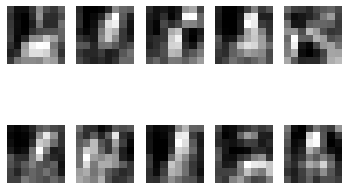

Batch 922/938 - Opimize G - Avg Batch Loss: 0.0780 - Time : 3.48s
Batch 923/938 - Opimize G - Avg Batch Loss: 0.1664 - Time : 3.75s
Batch 924/938 - Opimize G - Avg Batch Loss: 0.1312 - Time : 3.75s
Batch 925/938 - Opimize D - Avg Batch Loss: 0.1178 - Time : 3.90s
Batch 926/938 - Opimize G - Avg Batch Loss: 0.0298 - Time : 3.50s
Batch 927/938 - Opimize G - Avg Batch Loss: 0.1012 - Time : 3.45s
Batch 928/938 - Opimize G - Avg Batch Loss: 0.0780 - Time : 3.62s
Batch 929/938 - Opimize G - Avg Batch Loss: 0.0893 - Time : 3.91s
Batch 930/938 - Opimize G - Avg Batch Loss: 0.0205 - Time : 3.44s
Batch 931/938 - Opimize D - Avg Batch Loss: 0.0867 - Time : 3.45s
Batch 932/938 - Opimize G - Avg Batch Loss: 0.0912 - Time : 3.64s
Batch 933/938 - Opimize G - Avg Batch Loss: 0.0875 - Time : 4.03s
Batch 934/938 - Opimize G - Avg Batch Loss: 0.0444 - Time : 3.43s
Batch 935/938 - Opimize G - Avg Batch Loss: 0.0614 - Time : 4.00s
Batch 936/938 - Opimize G - Avg Batch Loss: 0.0718 - Time : 3.68s
Batch 937/

In [59]:
history2 = train(n_gen=5, n_epochs = 1, batch_size = 64, plt_samples = 20, epsilon=0.01)

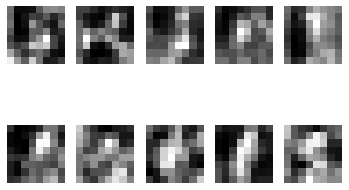

In [60]:
generate_plt()

========================Epoch: 1 / 1 =======================
Batch 1/938 - Opimize D - Avg Batch Loss: 0.0662 - Time : 3.55s


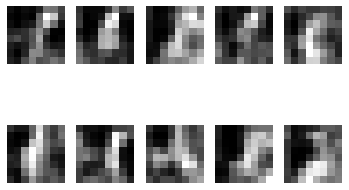

Batch 2/938 - Opimize G - Avg Batch Loss: 0.1155 - Time : 3.50s
Batch 3/938 - Opimize G - Avg Batch Loss: 0.0883 - Time : 3.40s
Batch 4/938 - Opimize G - Avg Batch Loss: 0.1757 - Time : 3.41s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.1141 - Time : 3.42s
Batch 6/938 - Opimize G - Avg Batch Loss: -0.0247 - Time : 3.38s
Batch 7/938 - Opimize D - Avg Batch Loss: 0.0718 - Time : 3.48s
Batch 8/938 - Opimize G - Avg Batch Loss: 0.1565 - Time : 4.11s
Batch 9/938 - Opimize G - Avg Batch Loss: 0.0561 - Time : 3.40s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.1151 - Time : 3.47s
Batch 11/938 - Opimize G - Avg Batch Loss: 0.1055 - Time : 3.79s
Batch 12/938 - Opimize G - Avg Batch Loss: 0.1409 - Time : 3.77s
Batch 13/938 - Opimize D - Avg Batch Loss: 0.1115 - Time : 3.77s
Batch 14/938 - Opimize G - Avg Batch Loss: 0.0619 - Time : 3.40s
Batch 15/938 - Opimize G - Avg Batch Loss: 0.0940 - Time : 3.54s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.0603 - Time : 3.42s
Batch 17/938 - Opimize G - Avg B

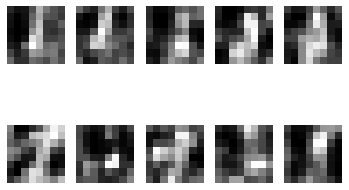

Batch 22/938 - Opimize G - Avg Batch Loss: 0.0411 - Time : 3.58s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.0499 - Time : 3.43s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.0101 - Time : 3.39s
Batch 25/938 - Opimize D - Avg Batch Loss: 0.0445 - Time : 3.44s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.1143 - Time : 3.39s
Batch 27/938 - Opimize G - Avg Batch Loss: 0.1141 - Time : 3.39s
Batch 28/938 - Opimize G - Avg Batch Loss: 0.1417 - Time : 3.70s
Batch 29/938 - Opimize G - Avg Batch Loss: 0.1136 - Time : 3.55s
Batch 30/938 - Opimize G - Avg Batch Loss: 0.0467 - Time : 3.66s
Batch 31/938 - Opimize D - Avg Batch Loss: 0.0954 - Time : 3.43s
Batch 32/938 - Opimize G - Avg Batch Loss: 0.0739 - Time : 3.44s
Batch 33/938 - Opimize G - Avg Batch Loss: 0.0540 - Time : 3.47s
Batch 34/938 - Opimize G - Avg Batch Loss: -0.0240 - Time : 3.48s
Batch 35/938 - Opimize G - Avg Batch Loss: 0.1181 - Time : 3.46s
Batch 36/938 - Opimize G - Avg Batch Loss: 0.0528 - Time : 3.61s
Batch 37/938 - Opimize D

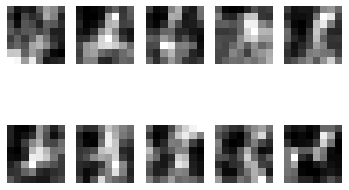

Batch 42/938 - Opimize G - Avg Batch Loss: 0.1357 - Time : 3.64s
Batch 43/938 - Opimize D - Avg Batch Loss: 0.0911 - Time : 3.45s
Batch 44/938 - Opimize G - Avg Batch Loss: 0.0238 - Time : 3.40s
Batch 45/938 - Opimize G - Avg Batch Loss: 0.0140 - Time : 3.69s
Batch 46/938 - Opimize G - Avg Batch Loss: 0.0019 - Time : 3.39s
Batch 47/938 - Opimize G - Avg Batch Loss: 0.1136 - Time : 3.43s
Batch 48/938 - Opimize G - Avg Batch Loss: 0.0880 - Time : 3.41s
Batch 49/938 - Opimize D - Avg Batch Loss: 0.1173 - Time : 3.71s
Batch 50/938 - Opimize G - Avg Batch Loss: 0.0854 - Time : 3.44s
Batch 51/938 - Opimize G - Avg Batch Loss: 0.1463 - Time : 3.45s
Batch 52/938 - Opimize G - Avg Batch Loss: 0.0460 - Time : 3.69s
Batch 53/938 - Opimize G - Avg Batch Loss: 0.1175 - Time : 3.86s
Batch 54/938 - Opimize G - Avg Batch Loss: 0.1557 - Time : 3.39s
Batch 55/938 - Opimize D - Avg Batch Loss: 0.1018 - Time : 3.42s
Batch 56/938 - Opimize G - Avg Batch Loss: 0.0312 - Time : 3.52s
Batch 57/938 - Opimize G 

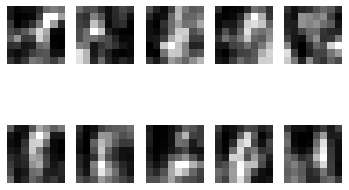

Batch 62/938 - Opimize G - Avg Batch Loss: 0.1263 - Time : 3.37s
Batch 63/938 - Opimize G - Avg Batch Loss: 0.0857 - Time : 3.67s
Batch 64/938 - Opimize G - Avg Batch Loss: 0.0546 - Time : 3.45s
Batch 65/938 - Opimize G - Avg Batch Loss: 0.0582 - Time : 3.57s
Batch 66/938 - Opimize G - Avg Batch Loss: 0.0305 - Time : 3.44s
Batch 67/938 - Opimize D - Avg Batch Loss: -0.0050 - Time : 3.91s
Batch 68/938 - Opimize G - Avg Batch Loss: 0.1422 - Time : 3.43s
Batch 69/938 - Opimize G - Avg Batch Loss: 0.1670 - Time : 3.60s
Batch 70/938 - Opimize G - Avg Batch Loss: 0.1022 - Time : 3.46s
Batch 71/938 - Opimize G - Avg Batch Loss: 0.0329 - Time : 3.53s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.1070 - Time : 3.73s
Batch 73/938 - Opimize D - Avg Batch Loss: 0.1177 - Time : 3.86s
Batch 74/938 - Opimize G - Avg Batch Loss: 0.0494 - Time : 3.85s
Batch 75/938 - Opimize G - Avg Batch Loss: 0.0098 - Time : 3.68s
Batch 76/938 - Opimize G - Avg Batch Loss: 0.2008 - Time : 3.99s
Batch 77/938 - Opimize G

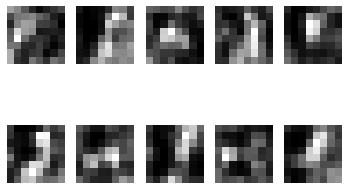

Batch 82/938 - Opimize G - Avg Batch Loss: 0.0998 - Time : 3.69s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.0408 - Time : 3.80s
Batch 84/938 - Opimize G - Avg Batch Loss: 0.1023 - Time : 3.82s
Batch 85/938 - Opimize D - Avg Batch Loss: 0.1478 - Time : 3.85s
Batch 86/938 - Opimize G - Avg Batch Loss: 0.1586 - Time : 3.55s
Batch 87/938 - Opimize G - Avg Batch Loss: 0.0889 - Time : 3.87s
Batch 88/938 - Opimize G - Avg Batch Loss: 0.0371 - Time : 3.68s
Batch 89/938 - Opimize G - Avg Batch Loss: 0.1201 - Time : 3.66s
Batch 90/938 - Opimize G - Avg Batch Loss: 0.1062 - Time : 3.83s
Batch 91/938 - Opimize D - Avg Batch Loss: 0.1258 - Time : 4.03s
Batch 92/938 - Opimize G - Avg Batch Loss: 0.1213 - Time : 3.70s
Batch 93/938 - Opimize G - Avg Batch Loss: 0.1043 - Time : 3.55s
Batch 94/938 - Opimize G - Avg Batch Loss: 0.1139 - Time : 4.07s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.0822 - Time : 3.71s
Batch 96/938 - Opimize G - Avg Batch Loss: 0.1059 - Time : 3.51s
Batch 97/938 - Opimize D 

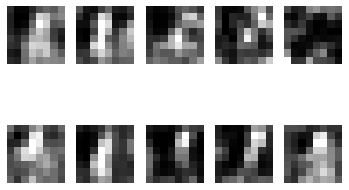

Batch 102/938 - Opimize G - Avg Batch Loss: 0.0931 - Time : 3.87s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.0950 - Time : 3.91s
Batch 104/938 - Opimize G - Avg Batch Loss: 0.1156 - Time : 3.46s
Batch 105/938 - Opimize G - Avg Batch Loss: 0.0456 - Time : 3.80s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.0068 - Time : 3.84s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.0237 - Time : 3.42s
Batch 108/938 - Opimize G - Avg Batch Loss: 0.0826 - Time : 3.44s
Batch 109/938 - Opimize D - Avg Batch Loss: 0.1109 - Time : 3.44s
Batch 110/938 - Opimize G - Avg Batch Loss: 0.0752 - Time : 3.67s
Batch 111/938 - Opimize G - Avg Batch Loss: 0.0530 - Time : 3.89s
Batch 112/938 - Opimize G - Avg Batch Loss: 0.1081 - Time : 3.51s
Batch 113/938 - Opimize G - Avg Batch Loss: 0.0803 - Time : 3.67s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.1805 - Time : 3.48s
Batch 115/938 - Opimize D - Avg Batch Loss: 0.0922 - Time : 3.45s
Batch 116/938 - Opimize G - Avg Batch Loss: 0.0305 - Time : 3.65s
Batch 117/

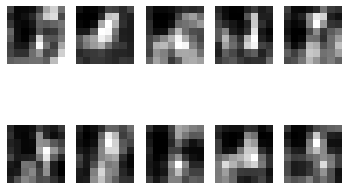

Batch 122/938 - Opimize G - Avg Batch Loss: 0.0971 - Time : 3.98s
Batch 123/938 - Opimize G - Avg Batch Loss: 0.0142 - Time : 3.49s
Batch 124/938 - Opimize G - Avg Batch Loss: 0.0752 - Time : 3.47s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.0859 - Time : 3.76s
Batch 126/938 - Opimize G - Avg Batch Loss: 0.1417 - Time : 3.72s
Batch 127/938 - Opimize D - Avg Batch Loss: 0.0455 - Time : 3.61s
Batch 128/938 - Opimize G - Avg Batch Loss: 0.1435 - Time : 3.80s
Batch 129/938 - Opimize G - Avg Batch Loss: 0.1808 - Time : 3.46s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.1431 - Time : 3.43s
Batch 131/938 - Opimize G - Avg Batch Loss: 0.1007 - Time : 3.43s
Batch 132/938 - Opimize G - Avg Batch Loss: 0.1445 - Time : 3.63s
Batch 133/938 - Opimize D - Avg Batch Loss: 0.0934 - Time : 3.55s
Batch 134/938 - Opimize G - Avg Batch Loss: 0.1023 - Time : 3.50s
Batch 135/938 - Opimize G - Avg Batch Loss: 0.0938 - Time : 3.47s
Batch 136/938 - Opimize G - Avg Batch Loss: 0.0141 - Time : 3.56s
Batch 137/

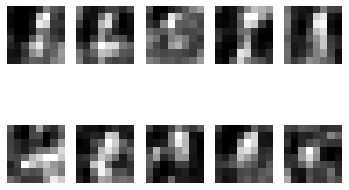

Batch 142/938 - Opimize G - Avg Batch Loss: 0.0937 - Time : 3.45s
Batch 143/938 - Opimize G - Avg Batch Loss: 0.0722 - Time : 3.77s
Batch 144/938 - Opimize G - Avg Batch Loss: 0.0916 - Time : 3.49s
Batch 145/938 - Opimize D - Avg Batch Loss: 0.0742 - Time : 3.54s
Batch 146/938 - Opimize G - Avg Batch Loss: 0.1258 - Time : 3.56s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.1604 - Time : 3.80s
Batch 148/938 - Opimize G - Avg Batch Loss: 0.0745 - Time : 3.49s
Batch 149/938 - Opimize G - Avg Batch Loss: 0.0266 - Time : 3.80s
Batch 150/938 - Opimize G - Avg Batch Loss: 0.1091 - Time : 3.44s
Batch 151/938 - Opimize D - Avg Batch Loss: 0.1304 - Time : 3.41s
Batch 152/938 - Opimize G - Avg Batch Loss: 0.0967 - Time : 3.87s
Batch 153/938 - Opimize G - Avg Batch Loss: 0.0436 - Time : 3.94s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.0612 - Time : 3.50s
Batch 155/938 - Opimize G - Avg Batch Loss: 0.0323 - Time : 3.43s
Batch 156/938 - Opimize G - Avg Batch Loss: 0.1019 - Time : 3.65s
Batch 157/

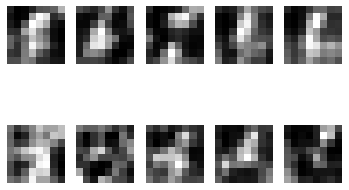

Batch 162/938 - Opimize G - Avg Batch Loss: 0.0612 - Time : 3.58s
Batch 163/938 - Opimize D - Avg Batch Loss: 0.1064 - Time : 3.73s
Batch 164/938 - Opimize G - Avg Batch Loss: 0.0249 - Time : 3.69s
Batch 165/938 - Opimize G - Avg Batch Loss: 0.1138 - Time : 3.63s
Batch 166/938 - Opimize G - Avg Batch Loss: 0.0401 - Time : 3.49s
Batch 167/938 - Opimize G - Avg Batch Loss: 0.0750 - Time : 3.45s
Batch 168/938 - Opimize G - Avg Batch Loss: 0.0402 - Time : 3.65s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.1305 - Time : 3.67s
Batch 170/938 - Opimize G - Avg Batch Loss: 0.0215 - Time : 3.44s
Batch 171/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.51s
Batch 172/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 4.00s
Batch 173/938 - Opimize G - Avg Batch Loss: 0.0459 - Time : 3.54s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.1352 - Time : 3.46s
Batch 175/938 - Opimize D - Avg Batch Loss: 0.1645 - Time : 3.64s
Batch 176/938 - Opimize G - Avg Batch Loss: 0.0263 - Time : 3.64s
Batch 177/

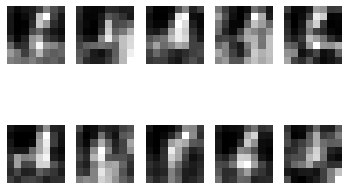

Batch 182/938 - Opimize G - Avg Batch Loss: 0.1154 - Time : 3.92s
Batch 183/938 - Opimize G - Avg Batch Loss: 0.0457 - Time : 3.47s
Batch 184/938 - Opimize G - Avg Batch Loss: 0.0731 - Time : 3.88s
Batch 185/938 - Opimize G - Avg Batch Loss: 0.0852 - Time : 3.72s
Batch 186/938 - Opimize G - Avg Batch Loss: 0.1679 - Time : 3.86s
Batch 187/938 - Opimize D - Avg Batch Loss: 0.1048 - Time : 3.92s
Batch 188/938 - Opimize G - Avg Batch Loss: 0.1118 - Time : 3.58s
Batch 189/938 - Opimize G - Avg Batch Loss: 0.0865 - Time : 3.74s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.1739 - Time : 3.95s
Batch 191/938 - Opimize G - Avg Batch Loss: 0.0661 - Time : 3.78s
Batch 192/938 - Opimize G - Avg Batch Loss: 0.1232 - Time : 3.64s
Batch 193/938 - Opimize D - Avg Batch Loss: 0.1102 - Time : 3.78s
Batch 194/938 - Opimize G - Avg Batch Loss: 0.0056 - Time : 3.67s
Batch 195/938 - Opimize G - Avg Batch Loss: 0.1179 - Time : 3.58s
Batch 196/938 - Opimize G - Avg Batch Loss: 0.0005 - Time : 3.56s
Batch 197/

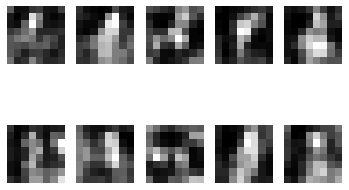

Batch 202/938 - Opimize G - Avg Batch Loss: -0.0084 - Time : 4.05s
Batch 203/938 - Opimize G - Avg Batch Loss: 0.0566 - Time : 3.91s
Batch 204/938 - Opimize G - Avg Batch Loss: 0.1238 - Time : 3.55s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.0981 - Time : 4.09s
Batch 206/938 - Opimize G - Avg Batch Loss: 0.0321 - Time : 3.97s
Batch 207/938 - Opimize G - Avg Batch Loss: 0.1210 - Time : 3.50s
Batch 208/938 - Opimize G - Avg Batch Loss: 0.0645 - Time : 3.73s
Batch 209/938 - Opimize G - Avg Batch Loss: 0.1422 - Time : 3.72s
Batch 210/938 - Opimize G - Avg Batch Loss: 0.0184 - Time : 3.58s
Batch 211/938 - Opimize D - Avg Batch Loss: 0.0475 - Time : 3.76s
Batch 212/938 - Opimize G - Avg Batch Loss: 0.0790 - Time : 3.58s
Batch 213/938 - Opimize G - Avg Batch Loss: -0.0316 - Time : 3.99s
Batch 214/938 - Opimize G - Avg Batch Loss: 0.1148 - Time : 3.57s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.0575 - Time : 3.59s
Batch 216/938 - Opimize G - Avg Batch Loss: 0.1080 - Time : 3.75s
Batch 21

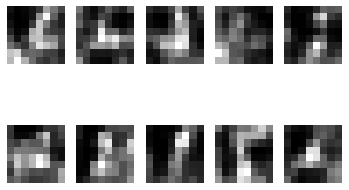

Batch 222/938 - Opimize G - Avg Batch Loss: 0.0712 - Time : 3.48s
Batch 223/938 - Opimize D - Avg Batch Loss: 0.1102 - Time : 3.79s
Batch 224/938 - Opimize G - Avg Batch Loss: 0.1424 - Time : 3.86s
Batch 225/938 - Opimize G - Avg Batch Loss: 0.0831 - Time : 3.52s
Batch 226/938 - Opimize G - Avg Batch Loss: 0.1349 - Time : 3.51s
Batch 227/938 - Opimize G - Avg Batch Loss: 0.0952 - Time : 3.53s
Batch 228/938 - Opimize G - Avg Batch Loss: 0.0264 - Time : 3.68s
Batch 229/938 - Opimize D - Avg Batch Loss: 0.0840 - Time : 3.79s
Batch 230/938 - Opimize G - Avg Batch Loss: 0.1047 - Time : 3.65s
Batch 231/938 - Opimize G - Avg Batch Loss: 0.0630 - Time : 3.75s
Batch 232/938 - Opimize G - Avg Batch Loss: 0.0691 - Time : 4.07s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.0059 - Time : 3.95s
Batch 234/938 - Opimize G - Avg Batch Loss: 0.1375 - Time : 3.62s
Batch 235/938 - Opimize D - Avg Batch Loss: 0.1014 - Time : 3.83s
Batch 236/938 - Opimize G - Avg Batch Loss: -0.0181 - Time : 3.72s
Batch 237

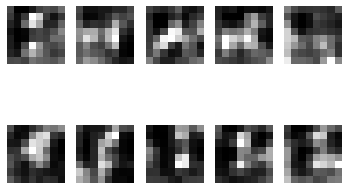

Batch 242/938 - Opimize G - Avg Batch Loss: 0.1354 - Time : 3.83s
Batch 243/938 - Opimize G - Avg Batch Loss: 0.0439 - Time : 3.78s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.0905 - Time : 3.52s
Batch 245/938 - Opimize G - Avg Batch Loss: 0.1393 - Time : 3.84s
Batch 246/938 - Opimize G - Avg Batch Loss: 0.0612 - Time : 3.63s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.0210 - Time : 3.80s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.1075 - Time : 3.75s
Batch 249/938 - Opimize G - Avg Batch Loss: 0.0957 - Time : 3.92s
Batch 250/938 - Opimize G - Avg Batch Loss: 0.0396 - Time : 3.55s
Batch 251/938 - Opimize G - Avg Batch Loss: 0.0944 - Time : 3.96s
Batch 252/938 - Opimize G - Avg Batch Loss: -0.0232 - Time : 3.58s
Batch 253/938 - Opimize D - Avg Batch Loss: 0.0610 - Time : 3.58s
Batch 254/938 - Opimize G - Avg Batch Loss: 0.0798 - Time : 3.52s
Batch 255/938 - Opimize G - Avg Batch Loss: -0.0127 - Time : 3.57s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.0470 - Time : 3.60s
Batch 25

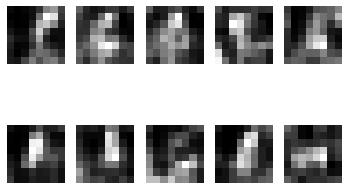

Batch 262/938 - Opimize G - Avg Batch Loss: 0.0736 - Time : 3.71s
Batch 263/938 - Opimize G - Avg Batch Loss: 0.0603 - Time : 3.58s
Batch 264/938 - Opimize G - Avg Batch Loss: 0.1044 - Time : 3.57s
Batch 265/938 - Opimize D - Avg Batch Loss: 0.0517 - Time : 3.59s
Batch 266/938 - Opimize G - Avg Batch Loss: 0.0633 - Time : 3.49s
Batch 267/938 - Opimize G - Avg Batch Loss: 0.0886 - Time : 3.84s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.0925 - Time : 3.84s
Batch 269/938 - Opimize G - Avg Batch Loss: 0.0937 - Time : 3.79s
Batch 270/938 - Opimize G - Avg Batch Loss: 0.0493 - Time : 4.50s
Batch 271/938 - Opimize D - Avg Batch Loss: 0.1418 - Time : 3.82s
Batch 272/938 - Opimize G - Avg Batch Loss: 0.0680 - Time : 3.71s
Batch 273/938 - Opimize G - Avg Batch Loss: 0.1504 - Time : 3.64s
Batch 274/938 - Opimize G - Avg Batch Loss: 0.0392 - Time : 3.77s
Batch 275/938 - Opimize G - Avg Batch Loss: 0.0461 - Time : 3.57s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.0804 - Time : 3.71s
Batch 277/

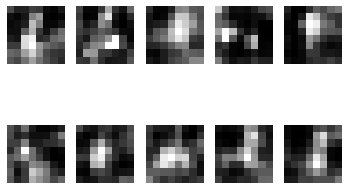

Batch 282/938 - Opimize G - Avg Batch Loss: 0.0494 - Time : 4.06s
Batch 283/938 - Opimize D - Avg Batch Loss: 0.0640 - Time : 3.67s
Batch 284/938 - Opimize G - Avg Batch Loss: 0.0327 - Time : 3.92s
Batch 285/938 - Opimize G - Avg Batch Loss: 0.1094 - Time : 4.55s
Batch 286/938 - Opimize G - Avg Batch Loss: 0.0454 - Time : 3.71s
Batch 287/938 - Opimize G - Avg Batch Loss: 0.0358 - Time : 3.66s
Batch 288/938 - Opimize G - Avg Batch Loss: 0.0826 - Time : 3.67s
Batch 289/938 - Opimize D - Avg Batch Loss: 0.1505 - Time : 3.54s
Batch 290/938 - Opimize G - Avg Batch Loss: 0.0484 - Time : 3.52s
Batch 291/938 - Opimize G - Avg Batch Loss: 0.0716 - Time : 3.61s
Batch 292/938 - Opimize G - Avg Batch Loss: 0.1441 - Time : 3.67s
Batch 293/938 - Opimize G - Avg Batch Loss: 0.0926 - Time : 3.57s
Batch 294/938 - Opimize G - Avg Batch Loss: 0.0374 - Time : 3.89s
Batch 295/938 - Opimize D - Avg Batch Loss: 0.0163 - Time : 3.73s
Batch 296/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.78s
Batch 297/

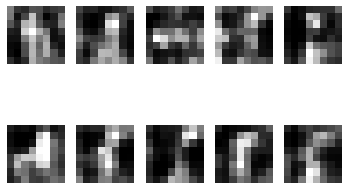

Batch 302/938 - Opimize G - Avg Batch Loss: 0.0244 - Time : 3.54s
Batch 303/938 - Opimize G - Avg Batch Loss: 0.1466 - Time : 3.58s
Batch 304/938 - Opimize G - Avg Batch Loss: 0.0437 - Time : 4.03s
Batch 305/938 - Opimize G - Avg Batch Loss: 0.0582 - Time : 4.08s
Batch 306/938 - Opimize G - Avg Batch Loss: 0.0807 - Time : 4.19s
Batch 307/938 - Opimize D - Avg Batch Loss: 0.0835 - Time : 3.55s
Batch 308/938 - Opimize G - Avg Batch Loss: 0.0899 - Time : 3.68s
Batch 309/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.61s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.0431 - Time : 3.57s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.1038 - Time : 3.53s
Batch 312/938 - Opimize G - Avg Batch Loss: 0.2093 - Time : 4.11s
Batch 313/938 - Opimize D - Avg Batch Loss: -0.0117 - Time : 3.99s
Batch 314/938 - Opimize G - Avg Batch Loss: 0.1035 - Time : 3.68s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.1229 - Time : 3.78s
Batch 316/938 - Opimize G - Avg Batch Loss: 0.0116 - Time : 3.68s
Batch 317

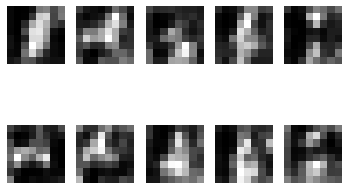

Batch 322/938 - Opimize G - Avg Batch Loss: 0.0188 - Time : 3.57s
Batch 323/938 - Opimize G - Avg Batch Loss: 0.0704 - Time : 3.58s
Batch 324/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 3.97s
Batch 325/938 - Opimize D - Avg Batch Loss: 0.1365 - Time : 3.74s
Batch 326/938 - Opimize G - Avg Batch Loss: 0.1354 - Time : 3.51s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.0442 - Time : 3.57s
Batch 328/938 - Opimize G - Avg Batch Loss: 0.0682 - Time : 3.62s
Batch 329/938 - Opimize G - Avg Batch Loss: 0.0908 - Time : 4.00s
Batch 330/938 - Opimize G - Avg Batch Loss: -0.0311 - Time : 3.58s
Batch 331/938 - Opimize D - Avg Batch Loss: 0.0694 - Time : 4.07s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.1232 - Time : 4.12s
Batch 333/938 - Opimize G - Avg Batch Loss: 0.0152 - Time : 3.96s
Batch 334/938 - Opimize G - Avg Batch Loss: 0.0936 - Time : 3.86s
Batch 335/938 - Opimize G - Avg Batch Loss: 0.0737 - Time : 3.80s
Batch 336/938 - Opimize G - Avg Batch Loss: 0.0376 - Time : 3.81s
Batch 337

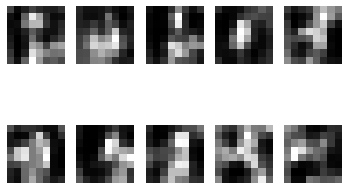

Batch 342/938 - Opimize G - Avg Batch Loss: 0.0703 - Time : 3.73s
Batch 343/938 - Opimize D - Avg Batch Loss: -0.0699 - Time : 3.64s
Batch 344/938 - Opimize G - Avg Batch Loss: 0.0451 - Time : 3.61s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.0570 - Time : 3.73s
Batch 346/938 - Opimize G - Avg Batch Loss: 0.0433 - Time : 3.77s
Batch 347/938 - Opimize G - Avg Batch Loss: 0.0191 - Time : 3.93s
Batch 348/938 - Opimize G - Avg Batch Loss: 0.1418 - Time : 3.75s
Batch 349/938 - Opimize D - Avg Batch Loss: 0.0124 - Time : 3.55s
Batch 350/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.61s
Batch 351/938 - Opimize G - Avg Batch Loss: 0.0156 - Time : 3.84s
Batch 352/938 - Opimize G - Avg Batch Loss: 0.0303 - Time : 3.83s
Batch 353/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.81s
Batch 354/938 - Opimize G - Avg Batch Loss: -0.0210 - Time : 4.03s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.0312 - Time : 3.59s
Batch 356/938 - Opimize G - Avg Batch Loss: 0.0538 - Time : 3.69s
Batch 35

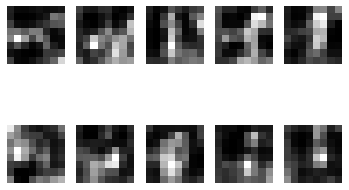

Batch 362/938 - Opimize G - Avg Batch Loss: 0.0311 - Time : 3.85s
Batch 363/938 - Opimize G - Avg Batch Loss: 0.0379 - Time : 3.58s
Batch 364/938 - Opimize G - Avg Batch Loss: 0.0780 - Time : 3.66s
Batch 365/938 - Opimize G - Avg Batch Loss: -0.0270 - Time : 3.63s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.0357 - Time : 3.54s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.0142 - Time : 3.69s
Batch 368/938 - Opimize G - Avg Batch Loss: 0.1105 - Time : 3.82s
Batch 369/938 - Opimize G - Avg Batch Loss: 0.0588 - Time : 4.27s
Batch 370/938 - Opimize G - Avg Batch Loss: 0.1036 - Time : 3.61s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.0517 - Time : 4.17s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.1231 - Time : 3.92s
Batch 373/938 - Opimize D - Avg Batch Loss: 0.0540 - Time : 4.14s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.0530 - Time : 3.73s
Batch 375/938 - Opimize G - Avg Batch Loss: 0.0740 - Time : 3.56s
Batch 376/938 - Opimize G - Avg Batch Loss: 0.0223 - Time : 3.62s
Batch 377

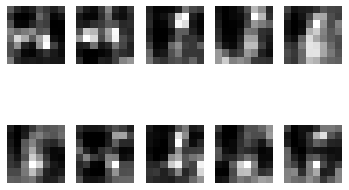

Batch 382/938 - Opimize G - Avg Batch Loss: 0.0123 - Time : 3.82s
Batch 383/938 - Opimize G - Avg Batch Loss: 0.0294 - Time : 3.87s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.1343 - Time : 3.98s
Batch 385/938 - Opimize D - Avg Batch Loss: -0.0198 - Time : 3.51s
Batch 386/938 - Opimize G - Avg Batch Loss: 0.0214 - Time : 3.59s
Batch 387/938 - Opimize G - Avg Batch Loss: 0.0411 - Time : 3.91s
Batch 388/938 - Opimize G - Avg Batch Loss: 0.0575 - Time : 3.84s
Batch 389/938 - Opimize G - Avg Batch Loss: 0.0303 - Time : 4.04s
Batch 390/938 - Opimize G - Avg Batch Loss: 0.0727 - Time : 3.82s
Batch 391/938 - Opimize D - Avg Batch Loss: 0.0783 - Time : 3.70s
Batch 392/938 - Opimize G - Avg Batch Loss: 0.1126 - Time : 4.08s
Batch 393/938 - Opimize G - Avg Batch Loss: 0.0660 - Time : 3.58s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.1272 - Time : 3.67s
Batch 395/938 - Opimize G - Avg Batch Loss: 0.1283 - Time : 3.90s
Batch 396/938 - Opimize G - Avg Batch Loss: 0.0434 - Time : 3.82s
Batch 397

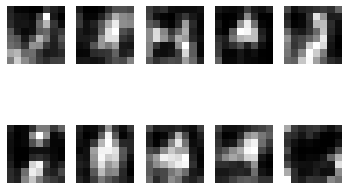

Batch 402/938 - Opimize G - Avg Batch Loss: 0.0734 - Time : 3.82s
Batch 403/938 - Opimize D - Avg Batch Loss: 0.0412 - Time : 4.11s
Batch 404/938 - Opimize G - Avg Batch Loss: 0.0573 - Time : 3.90s
Batch 405/938 - Opimize G - Avg Batch Loss: 0.0371 - Time : 3.54s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.0579 - Time : 3.77s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.0179 - Time : 3.77s
Batch 408/938 - Opimize G - Avg Batch Loss: 0.1194 - Time : 3.55s
Batch 409/938 - Opimize D - Avg Batch Loss: 0.0136 - Time : 3.95s
Batch 410/938 - Opimize G - Avg Batch Loss: 0.0739 - Time : 3.66s
Batch 411/938 - Opimize G - Avg Batch Loss: 0.1084 - Time : 3.58s
Batch 412/938 - Opimize G - Avg Batch Loss: 0.0845 - Time : 3.81s
Batch 413/938 - Opimize G - Avg Batch Loss: 0.0572 - Time : 3.99s
Batch 414/938 - Opimize G - Avg Batch Loss: 0.0720 - Time : 3.86s
Batch 415/938 - Opimize D - Avg Batch Loss: 0.0890 - Time : 3.72s
Batch 416/938 - Opimize G - Avg Batch Loss: 0.0790 - Time : 3.71s
Batch 417/

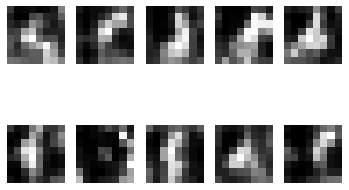

Batch 422/938 - Opimize G - Avg Batch Loss: 0.0501 - Time : 3.80s
Batch 423/938 - Opimize G - Avg Batch Loss: 0.0398 - Time : 3.68s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.0571 - Time : 3.55s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.0642 - Time : 3.79s
Batch 426/938 - Opimize G - Avg Batch Loss: 0.0204 - Time : 4.21s
Batch 427/938 - Opimize D - Avg Batch Loss: -0.0158 - Time : 4.00s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.0444 - Time : 3.57s
Batch 429/938 - Opimize G - Avg Batch Loss: -0.0068 - Time : 3.60s
Batch 430/938 - Opimize G - Avg Batch Loss: 0.0307 - Time : 3.53s
Batch 431/938 - Opimize G - Avg Batch Loss: 0.1522 - Time : 3.66s
Batch 432/938 - Opimize G - Avg Batch Loss: 0.0510 - Time : 3.52s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.0584 - Time : 3.85s
Batch 434/938 - Opimize G - Avg Batch Loss: 0.0101 - Time : 3.62s
Batch 435/938 - Opimize G - Avg Batch Loss: 0.0715 - Time : 3.59s
Batch 436/938 - Opimize G - Avg Batch Loss: 0.1751 - Time : 3.58s
Batch 43

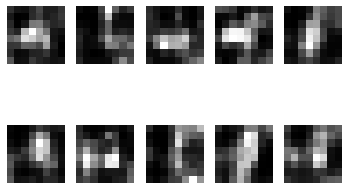

Batch 442/938 - Opimize G - Avg Batch Loss: 0.1225 - Time : 3.97s
Batch 443/938 - Opimize G - Avg Batch Loss: 0.0760 - Time : 3.74s
Batch 444/938 - Opimize G - Avg Batch Loss: 0.0329 - Time : 3.85s
Batch 445/938 - Opimize D - Avg Batch Loss: 0.0387 - Time : 3.56s
Batch 446/938 - Opimize G - Avg Batch Loss: 0.0922 - Time : 3.58s
Batch 447/938 - Opimize G - Avg Batch Loss: -0.0155 - Time : 3.61s
Batch 448/938 - Opimize G - Avg Batch Loss: -0.0475 - Time : 3.55s
Batch 449/938 - Opimize G - Avg Batch Loss: 0.1174 - Time : 3.66s
Batch 450/938 - Opimize G - Avg Batch Loss: 0.0507 - Time : 3.63s
Batch 451/938 - Opimize D - Avg Batch Loss: 0.0414 - Time : 3.62s
Batch 452/938 - Opimize G - Avg Batch Loss: -0.0162 - Time : 3.67s
Batch 453/938 - Opimize G - Avg Batch Loss: 0.1057 - Time : 3.72s
Batch 454/938 - Opimize G - Avg Batch Loss: 0.1161 - Time : 3.81s
Batch 455/938 - Opimize G - Avg Batch Loss: 0.0915 - Time : 3.81s
Batch 456/938 - Opimize G - Avg Batch Loss: 0.0218 - Time : 3.58s
Batch 4

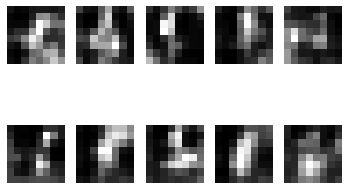

Batch 462/938 - Opimize G - Avg Batch Loss: -0.0052 - Time : 3.60s
Batch 463/938 - Opimize D - Avg Batch Loss: 0.0868 - Time : 4.19s
Batch 464/938 - Opimize G - Avg Batch Loss: 0.0344 - Time : 3.74s
Batch 465/938 - Opimize G - Avg Batch Loss: -0.0567 - Time : 3.62s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.0884 - Time : 3.77s
Batch 467/938 - Opimize G - Avg Batch Loss: 0.0429 - Time : 3.61s
Batch 468/938 - Opimize G - Avg Batch Loss: 0.0003 - Time : 3.79s
Batch 469/938 - Opimize D - Avg Batch Loss: 0.0462 - Time : 3.89s
Batch 470/938 - Opimize G - Avg Batch Loss: 0.0429 - Time : 4.12s
Batch 471/938 - Opimize G - Avg Batch Loss: -0.0043 - Time : 3.99s
Batch 472/938 - Opimize G - Avg Batch Loss: 0.0831 - Time : 3.91s
Batch 473/938 - Opimize G - Avg Batch Loss: 0.0252 - Time : 3.81s
Batch 474/938 - Opimize G - Avg Batch Loss: 0.0999 - Time : 3.71s
Batch 475/938 - Opimize D - Avg Batch Loss: 0.0701 - Time : 3.80s
Batch 476/938 - Opimize G - Avg Batch Loss: 0.1227 - Time : 3.65s
Batch 4

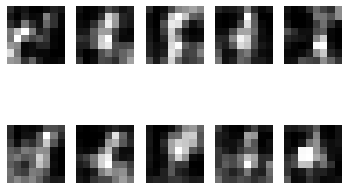

Batch 482/938 - Opimize G - Avg Batch Loss: 0.0541 - Time : 4.05s
Batch 483/938 - Opimize G - Avg Batch Loss: 0.1068 - Time : 3.74s
Batch 484/938 - Opimize G - Avg Batch Loss: -0.0081 - Time : 3.62s
Batch 485/938 - Opimize G - Avg Batch Loss: -0.0026 - Time : 4.00s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.0745 - Time : 3.87s
Batch 487/938 - Opimize D - Avg Batch Loss: 0.0403 - Time : 3.67s
Batch 488/938 - Opimize G - Avg Batch Loss: 0.0882 - Time : 3.76s
Batch 489/938 - Opimize G - Avg Batch Loss: 0.0120 - Time : 3.68s
Batch 490/938 - Opimize G - Avg Batch Loss: 0.0098 - Time : 3.56s
Batch 491/938 - Opimize G - Avg Batch Loss: 0.0338 - Time : 3.61s
Batch 492/938 - Opimize G - Avg Batch Loss: 0.0342 - Time : 3.58s
Batch 493/938 - Opimize D - Avg Batch Loss: 0.0135 - Time : 3.62s
Batch 494/938 - Opimize G - Avg Batch Loss: 0.0692 - Time : 3.60s
Batch 495/938 - Opimize G - Avg Batch Loss: 0.0531 - Time : 3.69s
Batch 496/938 - Opimize G - Avg Batch Loss: -0.0181 - Time : 3.80s
Batch 4

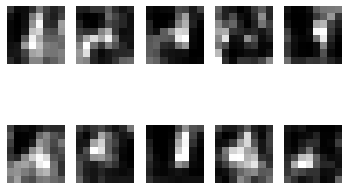

Batch 502/938 - Opimize G - Avg Batch Loss: 0.0628 - Time : 3.87s
Batch 503/938 - Opimize G - Avg Batch Loss: 0.0853 - Time : 3.94s
Batch 504/938 - Opimize G - Avg Batch Loss: 0.0722 - Time : 3.56s
Batch 505/938 - Opimize D - Avg Batch Loss: -0.0263 - Time : 4.01s
Batch 506/938 - Opimize G - Avg Batch Loss: -0.0405 - Time : 3.55s
Batch 507/938 - Opimize G - Avg Batch Loss: 0.0374 - Time : 4.00s
Batch 508/938 - Opimize G - Avg Batch Loss: 0.0466 - Time : 3.85s
Batch 509/938 - Opimize G - Avg Batch Loss: 0.0174 - Time : 3.53s
Batch 510/938 - Opimize G - Avg Batch Loss: 0.1075 - Time : 3.82s
Batch 511/938 - Opimize D - Avg Batch Loss: 0.0101 - Time : 4.41s
Batch 512/938 - Opimize G - Avg Batch Loss: -0.0481 - Time : 3.68s
Batch 513/938 - Opimize G - Avg Batch Loss: 0.0041 - Time : 3.78s
Batch 514/938 - Opimize G - Avg Batch Loss: 0.0546 - Time : 3.54s
Batch 515/938 - Opimize G - Avg Batch Loss: 0.1290 - Time : 3.70s
Batch 516/938 - Opimize G - Avg Batch Loss: 0.0546 - Time : 3.90s
Batch 5

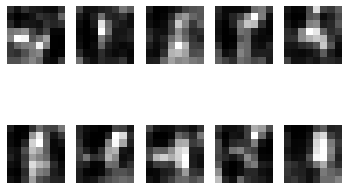

Batch 522/938 - Opimize G - Avg Batch Loss: 0.0339 - Time : 3.64s
Batch 523/938 - Opimize D - Avg Batch Loss: 0.0063 - Time : 3.63s
Batch 524/938 - Opimize G - Avg Batch Loss: 0.0205 - Time : 3.71s
Batch 525/938 - Opimize G - Avg Batch Loss: 0.1067 - Time : 3.57s
Batch 526/938 - Opimize G - Avg Batch Loss: 0.0822 - Time : 3.79s
Batch 527/938 - Opimize G - Avg Batch Loss: 0.0480 - Time : 3.56s
Batch 528/938 - Opimize G - Avg Batch Loss: -0.0343 - Time : 4.04s
Batch 529/938 - Opimize D - Avg Batch Loss: 0.0001 - Time : 3.66s
Batch 530/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.71s
Batch 531/938 - Opimize G - Avg Batch Loss: 0.0493 - Time : 3.63s
Batch 532/938 - Opimize G - Avg Batch Loss: 0.0238 - Time : 3.67s
Batch 533/938 - Opimize G - Avg Batch Loss: 0.0245 - Time : 3.68s
Batch 534/938 - Opimize G - Avg Batch Loss: -0.0393 - Time : 3.82s
Batch 535/938 - Opimize D - Avg Batch Loss: -0.0316 - Time : 3.63s
Batch 536/938 - Opimize G - Avg Batch Loss: 0.0604 - Time : 3.64s
Batch 

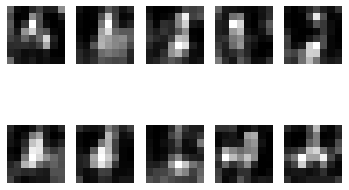

Batch 542/938 - Opimize G - Avg Batch Loss: 0.0314 - Time : 3.81s
Batch 543/938 - Opimize G - Avg Batch Loss: -0.0334 - Time : 3.67s
Batch 544/938 - Opimize G - Avg Batch Loss: 0.1143 - Time : 3.61s
Batch 545/938 - Opimize G - Avg Batch Loss: 0.1244 - Time : 3.96s
Batch 546/938 - Opimize G - Avg Batch Loss: 0.0463 - Time : 4.00s
Batch 547/938 - Opimize D - Avg Batch Loss: 0.0497 - Time : 4.04s
Batch 548/938 - Opimize G - Avg Batch Loss: 0.0835 - Time : 3.61s
Batch 549/938 - Opimize G - Avg Batch Loss: 0.0250 - Time : 3.70s
Batch 550/938 - Opimize G - Avg Batch Loss: 0.0322 - Time : 3.84s
Batch 551/938 - Opimize G - Avg Batch Loss: 0.0277 - Time : 3.92s
Batch 552/938 - Opimize G - Avg Batch Loss: -0.0738 - Time : 3.75s
Batch 553/938 - Opimize D - Avg Batch Loss: 0.0117 - Time : 3.85s
Batch 554/938 - Opimize G - Avg Batch Loss: 0.0006 - Time : 3.91s
Batch 555/938 - Opimize G - Avg Batch Loss: -0.0351 - Time : 4.14s
Batch 556/938 - Opimize G - Avg Batch Loss: 0.0256 - Time : 3.92s
Batch 5

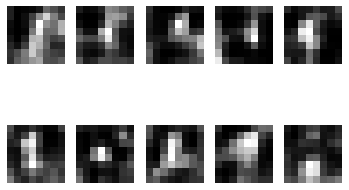

Batch 562/938 - Opimize G - Avg Batch Loss: 0.0474 - Time : 3.96s
Batch 563/938 - Opimize G - Avg Batch Loss: -0.0334 - Time : 3.96s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.0547 - Time : 4.06s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.0155 - Time : 3.60s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.0326 - Time : 3.79s
Batch 567/938 - Opimize G - Avg Batch Loss: 0.0523 - Time : 3.61s
Batch 568/938 - Opimize G - Avg Batch Loss: -0.0127 - Time : 3.98s
Batch 569/938 - Opimize G - Avg Batch Loss: 0.0556 - Time : 3.88s
Batch 570/938 - Opimize G - Avg Batch Loss: 0.0078 - Time : 3.96s
Batch 571/938 - Opimize D - Avg Batch Loss: 0.0967 - Time : 3.98s
Batch 572/938 - Opimize G - Avg Batch Loss: 0.1354 - Time : 3.65s
Batch 573/938 - Opimize G - Avg Batch Loss: 0.0406 - Time : 3.91s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.0837 - Time : 3.88s
Batch 575/938 - Opimize G - Avg Batch Loss: 0.0848 - Time : 4.04s
Batch 576/938 - Opimize G - Avg Batch Loss: -0.0266 - Time : 3.66s
Batch 5

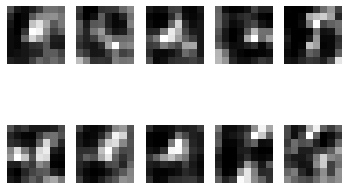

Batch 582/938 - Opimize G - Avg Batch Loss: 0.0115 - Time : 3.87s
Batch 583/938 - Opimize D - Avg Batch Loss: 0.0488 - Time : 3.89s
Batch 584/938 - Opimize G - Avg Batch Loss: 0.0593 - Time : 3.69s
Batch 585/938 - Opimize G - Avg Batch Loss: 0.0120 - Time : 3.70s
Batch 586/938 - Opimize G - Avg Batch Loss: 0.0522 - Time : 3.65s
Batch 587/938 - Opimize G - Avg Batch Loss: -0.0342 - Time : 3.87s
Batch 588/938 - Opimize G - Avg Batch Loss: -0.0275 - Time : 3.96s
Batch 589/938 - Opimize D - Avg Batch Loss: 0.1018 - Time : 3.74s
Batch 590/938 - Opimize G - Avg Batch Loss: -0.0090 - Time : 3.82s
Batch 591/938 - Opimize G - Avg Batch Loss: 0.0186 - Time : 3.73s
Batch 592/938 - Opimize G - Avg Batch Loss: -0.0323 - Time : 3.72s
Batch 593/938 - Opimize G - Avg Batch Loss: 0.0433 - Time : 3.61s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.0772 - Time : 3.71s
Batch 595/938 - Opimize D - Avg Batch Loss: 0.0603 - Time : 3.63s
Batch 596/938 - Opimize G - Avg Batch Loss: 0.0236 - Time : 3.89s
Batch 

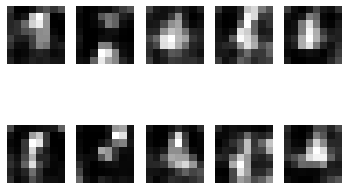

Batch 602/938 - Opimize G - Avg Batch Loss: 0.0598 - Time : 3.74s
Batch 603/938 - Opimize G - Avg Batch Loss: 0.0269 - Time : 3.65s
Batch 604/938 - Opimize G - Avg Batch Loss: 0.1303 - Time : 3.65s
Batch 605/938 - Opimize G - Avg Batch Loss: 0.0308 - Time : 4.05s
Batch 606/938 - Opimize G - Avg Batch Loss: -0.0622 - Time : 3.70s
Batch 607/938 - Opimize D - Avg Batch Loss: -0.0099 - Time : 3.68s
Batch 608/938 - Opimize G - Avg Batch Loss: -0.0517 - Time : 4.05s
Batch 609/938 - Opimize G - Avg Batch Loss: 0.0936 - Time : 3.59s
Batch 610/938 - Opimize G - Avg Batch Loss: 0.0960 - Time : 3.98s
Batch 611/938 - Opimize G - Avg Batch Loss: 0.0354 - Time : 3.81s
Batch 612/938 - Opimize G - Avg Batch Loss: 0.0760 - Time : 4.04s
Batch 613/938 - Opimize D - Avg Batch Loss: -0.0476 - Time : 4.01s
Batch 614/938 - Opimize G - Avg Batch Loss: -0.0743 - Time : 3.93s
Batch 615/938 - Opimize G - Avg Batch Loss: 0.0546 - Time : 3.92s
Batch 616/938 - Opimize G - Avg Batch Loss: 0.0573 - Time : 3.67s
Batch

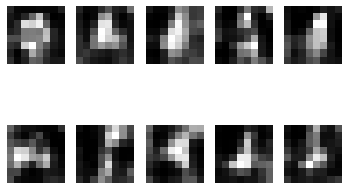

Batch 622/938 - Opimize G - Avg Batch Loss: 0.0246 - Time : 3.71s
Batch 623/938 - Opimize G - Avg Batch Loss: -0.0141 - Time : 4.00s
Batch 624/938 - Opimize G - Avg Batch Loss: -0.0013 - Time : 3.70s
Batch 625/938 - Opimize D - Avg Batch Loss: -0.0433 - Time : 3.85s
Batch 626/938 - Opimize G - Avg Batch Loss: 0.0527 - Time : 3.80s
Batch 627/938 - Opimize G - Avg Batch Loss: 0.0948 - Time : 4.01s
Batch 628/938 - Opimize G - Avg Batch Loss: 0.1418 - Time : 3.66s
Batch 629/938 - Opimize G - Avg Batch Loss: 0.0312 - Time : 3.62s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.0371 - Time : 3.67s
Batch 631/938 - Opimize D - Avg Batch Loss: 0.1204 - Time : 3.82s
Batch 632/938 - Opimize G - Avg Batch Loss: 0.0236 - Time : 3.63s
Batch 633/938 - Opimize G - Avg Batch Loss: 0.1047 - Time : 3.88s
Batch 634/938 - Opimize G - Avg Batch Loss: 0.0891 - Time : 3.80s
Batch 635/938 - Opimize G - Avg Batch Loss: -0.0484 - Time : 3.73s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.0981 - Time : 3.90s
Batch 

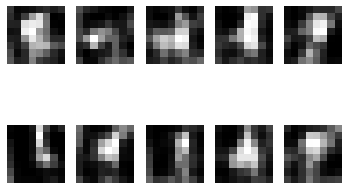

Batch 642/938 - Opimize G - Avg Batch Loss: 0.0397 - Time : 3.74s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.1196 - Time : 3.72s
Batch 644/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.90s
Batch 645/938 - Opimize G - Avg Batch Loss: 0.0981 - Time : 3.62s
Batch 646/938 - Opimize G - Avg Batch Loss: 0.0723 - Time : 3.87s
Batch 647/938 - Opimize G - Avg Batch Loss: 0.0814 - Time : 3.71s
Batch 648/938 - Opimize G - Avg Batch Loss: 0.0408 - Time : 3.58s
Batch 649/938 - Opimize D - Avg Batch Loss: 0.0273 - Time : 3.59s
Batch 650/938 - Opimize G - Avg Batch Loss: 0.0269 - Time : 3.63s
Batch 651/938 - Opimize G - Avg Batch Loss: 0.0460 - Time : 3.82s
Batch 652/938 - Opimize G - Avg Batch Loss: 0.0307 - Time : 3.76s
Batch 653/938 - Opimize G - Avg Batch Loss: -0.0120 - Time : 3.84s
Batch 654/938 - Opimize G - Avg Batch Loss: 0.0716 - Time : 3.61s
Batch 655/938 - Opimize D - Avg Batch Loss: 0.0156 - Time : 3.68s
Batch 656/938 - Opimize G - Avg Batch Loss: 0.0183 - Time : 3.63s
Batch 657

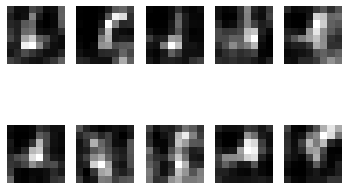

Batch 662/938 - Opimize G - Avg Batch Loss: 0.0050 - Time : 4.14s
Batch 663/938 - Opimize G - Avg Batch Loss: 0.0541 - Time : 4.09s
Batch 664/938 - Opimize G - Avg Batch Loss: 0.0725 - Time : 3.89s
Batch 665/938 - Opimize G - Avg Batch Loss: 0.0598 - Time : 3.85s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.0732 - Time : 3.58s
Batch 667/938 - Opimize D - Avg Batch Loss: 0.0415 - Time : 3.75s
Batch 668/938 - Opimize G - Avg Batch Loss: 0.0394 - Time : 3.89s
Batch 669/938 - Opimize G - Avg Batch Loss: 0.0418 - Time : 3.66s
Batch 670/938 - Opimize G - Avg Batch Loss: 0.0655 - Time : 3.63s
Batch 671/938 - Opimize G - Avg Batch Loss: 0.0095 - Time : 3.55s
Batch 672/938 - Opimize G - Avg Batch Loss: -0.0038 - Time : 3.85s
Batch 673/938 - Opimize D - Avg Batch Loss: 0.0495 - Time : 3.83s
Batch 674/938 - Opimize G - Avg Batch Loss: 0.0300 - Time : 3.79s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.0281 - Time : 3.87s
Batch 676/938 - Opimize G - Avg Batch Loss: -0.0721 - Time : 3.65s
Batch 67

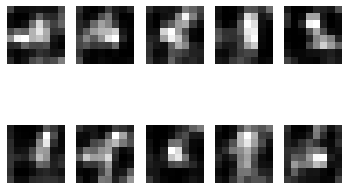

Batch 682/938 - Opimize G - Avg Batch Loss: 0.0783 - Time : 3.79s
Batch 683/938 - Opimize G - Avg Batch Loss: 0.0152 - Time : 3.64s
Batch 684/938 - Opimize G - Avg Batch Loss: 0.0033 - Time : 3.92s
Batch 685/938 - Opimize D - Avg Batch Loss: 0.0457 - Time : 3.57s
Batch 686/938 - Opimize G - Avg Batch Loss: -0.0230 - Time : 3.53s
Batch 687/938 - Opimize G - Avg Batch Loss: -0.0587 - Time : 3.53s
Batch 688/938 - Opimize G - Avg Batch Loss: 0.0008 - Time : 3.66s
Batch 689/938 - Opimize G - Avg Batch Loss: 0.0957 - Time : 3.85s
Batch 690/938 - Opimize G - Avg Batch Loss: 0.0051 - Time : 3.78s
Batch 691/938 - Opimize D - Avg Batch Loss: -0.0083 - Time : 3.55s
Batch 692/938 - Opimize G - Avg Batch Loss: -0.0183 - Time : 3.52s
Batch 693/938 - Opimize G - Avg Batch Loss: 0.0429 - Time : 3.80s
Batch 694/938 - Opimize G - Avg Batch Loss: 0.0323 - Time : 3.88s
Batch 695/938 - Opimize G - Avg Batch Loss: 0.0610 - Time : 3.84s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.0270 - Time : 3.88s
Batch 

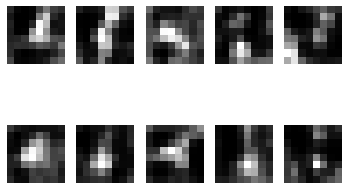

Batch 702/938 - Opimize G - Avg Batch Loss: 0.0376 - Time : 4.28s
Batch 703/938 - Opimize D - Avg Batch Loss: 0.0655 - Time : 3.59s
Batch 704/938 - Opimize G - Avg Batch Loss: 0.0319 - Time : 4.04s
Batch 705/938 - Opimize G - Avg Batch Loss: 0.0957 - Time : 3.69s
Batch 706/938 - Opimize G - Avg Batch Loss: -0.0035 - Time : 3.88s
Batch 707/938 - Opimize G - Avg Batch Loss: 0.0854 - Time : 3.69s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.0062 - Time : 4.01s
Batch 709/938 - Opimize D - Avg Batch Loss: -0.0247 - Time : 3.73s
Batch 710/938 - Opimize G - Avg Batch Loss: 0.0358 - Time : 3.99s
Batch 711/938 - Opimize G - Avg Batch Loss: -0.0055 - Time : 3.66s
Batch 712/938 - Opimize G - Avg Batch Loss: 0.0272 - Time : 3.59s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.0052 - Time : 3.60s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 4.23s
Batch 715/938 - Opimize D - Avg Batch Loss: -0.0065 - Time : 3.68s
Batch 716/938 - Opimize G - Avg Batch Loss: 0.0142 - Time : 3.86s
Batch 

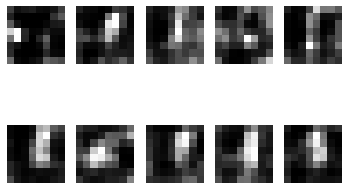

Batch 722/938 - Opimize G - Avg Batch Loss: 0.1489 - Time : 3.78s
Batch 723/938 - Opimize G - Avg Batch Loss: -0.0488 - Time : 3.77s
Batch 724/938 - Opimize G - Avg Batch Loss: 0.0159 - Time : 3.61s
Batch 725/938 - Opimize G - Avg Batch Loss: 0.0401 - Time : 3.56s
Batch 726/938 - Opimize G - Avg Batch Loss: -0.0068 - Time : 3.73s
Batch 727/938 - Opimize D - Avg Batch Loss: 0.0635 - Time : 3.87s
Batch 728/938 - Opimize G - Avg Batch Loss: 0.0777 - Time : 3.81s
Batch 729/938 - Opimize G - Avg Batch Loss: 0.0784 - Time : 4.31s
Batch 730/938 - Opimize G - Avg Batch Loss: 0.0511 - Time : 3.87s
Batch 731/938 - Opimize G - Avg Batch Loss: -0.0434 - Time : 3.83s
Batch 732/938 - Opimize G - Avg Batch Loss: 0.0002 - Time : 3.57s
Batch 733/938 - Opimize D - Avg Batch Loss: 0.0362 - Time : 3.66s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.0810 - Time : 4.13s
Batch 735/938 - Opimize G - Avg Batch Loss: 0.0479 - Time : 3.61s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.0667 - Time : 3.69s
Batch 7

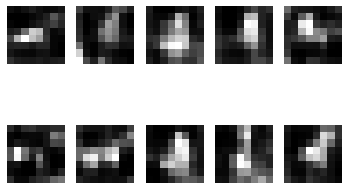

Batch 742/938 - Opimize G - Avg Batch Loss: 0.0338 - Time : 4.07s
Batch 743/938 - Opimize G - Avg Batch Loss: -0.0140 - Time : 3.95s
Batch 744/938 - Opimize G - Avg Batch Loss: -0.0479 - Time : 3.84s
Batch 745/938 - Opimize D - Avg Batch Loss: -0.0153 - Time : 3.81s
Batch 746/938 - Opimize G - Avg Batch Loss: 0.0266 - Time : 3.67s
Batch 747/938 - Opimize G - Avg Batch Loss: -0.0125 - Time : 3.86s
Batch 748/938 - Opimize G - Avg Batch Loss: 0.0694 - Time : 3.88s
Batch 749/938 - Opimize G - Avg Batch Loss: -0.0152 - Time : 3.92s
Batch 750/938 - Opimize G - Avg Batch Loss: 0.0332 - Time : 3.58s
Batch 751/938 - Opimize D - Avg Batch Loss: 0.0724 - Time : 3.84s
Batch 752/938 - Opimize G - Avg Batch Loss: 0.0937 - Time : 3.72s
Batch 753/938 - Opimize G - Avg Batch Loss: 0.0877 - Time : 3.97s
Batch 754/938 - Opimize G - Avg Batch Loss: -0.0554 - Time : 3.85s
Batch 755/938 - Opimize G - Avg Batch Loss: -0.0520 - Time : 3.75s
Batch 756/938 - Opimize G - Avg Batch Loss: -0.0119 - Time : 3.65s
Ba

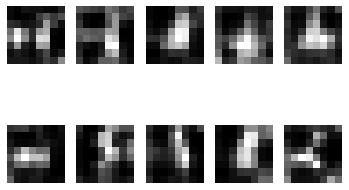

Batch 762/938 - Opimize G - Avg Batch Loss: 0.0386 - Time : 3.88s
Batch 763/938 - Opimize D - Avg Batch Loss: -0.0230 - Time : 3.73s
Batch 764/938 - Opimize G - Avg Batch Loss: 0.0431 - Time : 3.77s
Batch 765/938 - Opimize G - Avg Batch Loss: 0.1059 - Time : 3.98s
Batch 766/938 - Opimize G - Avg Batch Loss: 0.1042 - Time : 3.56s
Batch 767/938 - Opimize G - Avg Batch Loss: -0.0005 - Time : 3.75s
Batch 768/938 - Opimize G - Avg Batch Loss: 0.0585 - Time : 3.93s
Batch 769/938 - Opimize D - Avg Batch Loss: -0.0156 - Time : 3.74s
Batch 770/938 - Opimize G - Avg Batch Loss: 0.0263 - Time : 3.55s
Batch 771/938 - Opimize G - Avg Batch Loss: -0.0268 - Time : 3.98s
Batch 772/938 - Opimize G - Avg Batch Loss: 0.0201 - Time : 3.70s
Batch 773/938 - Opimize G - Avg Batch Loss: 0.0588 - Time : 3.69s
Batch 774/938 - Opimize G - Avg Batch Loss: 0.0704 - Time : 3.55s
Batch 775/938 - Opimize D - Avg Batch Loss: 0.0404 - Time : 3.56s
Batch 776/938 - Opimize G - Avg Batch Loss: -0.0554 - Time : 3.54s
Batch

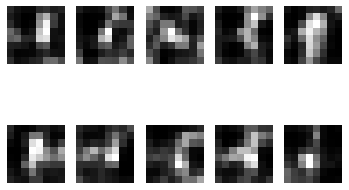

Batch 782/938 - Opimize G - Avg Batch Loss: 0.0130 - Time : 3.58s
Batch 783/938 - Opimize G - Avg Batch Loss: 0.0470 - Time : 3.86s
Batch 784/938 - Opimize G - Avg Batch Loss: -0.0147 - Time : 3.79s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.1219 - Time : 3.87s
Batch 786/938 - Opimize G - Avg Batch Loss: -0.0103 - Time : 3.83s
Batch 787/938 - Opimize D - Avg Batch Loss: -0.0236 - Time : 3.81s
Batch 788/938 - Opimize G - Avg Batch Loss: -0.0274 - Time : 4.07s
Batch 789/938 - Opimize G - Avg Batch Loss: 0.0216 - Time : 3.86s
Batch 790/938 - Opimize G - Avg Batch Loss: 0.0130 - Time : 3.63s
Batch 791/938 - Opimize G - Avg Batch Loss: 0.1095 - Time : 3.71s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.0011 - Time : 3.78s
Batch 793/938 - Opimize D - Avg Batch Loss: 0.0038 - Time : 3.75s
Batch 794/938 - Opimize G - Avg Batch Loss: -0.0101 - Time : 4.04s
Batch 795/938 - Opimize G - Avg Batch Loss: -0.0156 - Time : 3.76s
Batch 796/938 - Opimize G - Avg Batch Loss: -0.0274 - Time : 4.08s
Bat

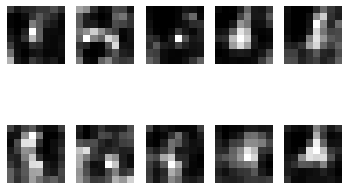

Batch 802/938 - Opimize G - Avg Batch Loss: 0.1101 - Time : 3.71s
Batch 803/938 - Opimize G - Avg Batch Loss: 0.0416 - Time : 3.61s
Batch 804/938 - Opimize G - Avg Batch Loss: -0.0027 - Time : 4.09s
Batch 805/938 - Opimize D - Avg Batch Loss: 0.0194 - Time : 3.93s
Batch 806/938 - Opimize G - Avg Batch Loss: -0.0186 - Time : 3.89s
Batch 807/938 - Opimize G - Avg Batch Loss: 0.0425 - Time : 3.92s
Batch 808/938 - Opimize G - Avg Batch Loss: 0.1347 - Time : 3.66s
Batch 809/938 - Opimize G - Avg Batch Loss: 0.0127 - Time : 3.67s
Batch 810/938 - Opimize G - Avg Batch Loss: 0.0417 - Time : 3.77s
Batch 811/938 - Opimize D - Avg Batch Loss: 0.0293 - Time : 3.70s
Batch 812/938 - Opimize G - Avg Batch Loss: 0.0348 - Time : 3.93s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.0512 - Time : 3.89s
Batch 814/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.64s
Batch 815/938 - Opimize G - Avg Batch Loss: -0.0286 - Time : 4.22s
Batch 816/938 - Opimize G - Avg Batch Loss: -0.0280 - Time : 3.93s
Batch

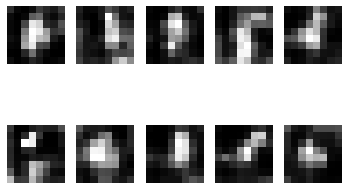

Batch 822/938 - Opimize G - Avg Batch Loss: -0.0206 - Time : 3.99s
Batch 823/938 - Opimize D - Avg Batch Loss: 0.0539 - Time : 3.80s
Batch 824/938 - Opimize G - Avg Batch Loss: 0.0013 - Time : 3.74s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.0645 - Time : 3.82s
Batch 826/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.84s
Batch 827/938 - Opimize G - Avg Batch Loss: 0.0416 - Time : 3.82s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.0252 - Time : 3.72s
Batch 829/938 - Opimize D - Avg Batch Loss: 0.0051 - Time : 3.69s
Batch 830/938 - Opimize G - Avg Batch Loss: -0.0020 - Time : 3.81s
Batch 831/938 - Opimize G - Avg Batch Loss: 0.0189 - Time : 3.90s
Batch 832/938 - Opimize G - Avg Batch Loss: -0.0070 - Time : 3.90s
Batch 833/938 - Opimize G - Avg Batch Loss: 0.0888 - Time : 3.82s
Batch 834/938 - Opimize G - Avg Batch Loss: 0.0648 - Time : 3.73s
Batch 835/938 - Opimize D - Avg Batch Loss: 0.0718 - Time : 3.75s
Batch 836/938 - Opimize G - Avg Batch Loss: 0.0398 - Time : 3.89s
Batch 8

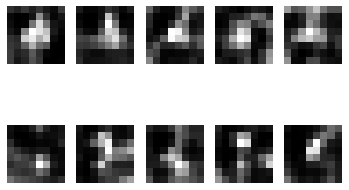

Batch 842/938 - Opimize G - Avg Batch Loss: 0.0048 - Time : 3.82s
Batch 843/938 - Opimize G - Avg Batch Loss: -0.0148 - Time : 3.92s
Batch 844/938 - Opimize G - Avg Batch Loss: 0.0940 - Time : 3.69s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 3.70s
Batch 846/938 - Opimize G - Avg Batch Loss: -0.0731 - Time : 3.78s
Batch 847/938 - Opimize D - Avg Batch Loss: 0.0394 - Time : 3.66s
Batch 848/938 - Opimize G - Avg Batch Loss: -0.0053 - Time : 3.71s
Batch 849/938 - Opimize G - Avg Batch Loss: 0.0433 - Time : 3.63s
Batch 850/938 - Opimize G - Avg Batch Loss: 0.0180 - Time : 3.69s
Batch 851/938 - Opimize G - Avg Batch Loss: 0.0153 - Time : 3.95s
Batch 852/938 - Opimize G - Avg Batch Loss: 0.0210 - Time : 3.82s
Batch 853/938 - Opimize D - Avg Batch Loss: -0.0036 - Time : 3.83s
Batch 854/938 - Opimize G - Avg Batch Loss: -0.0116 - Time : 3.70s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.0938 - Time : 3.88s
Batch 856/938 - Opimize G - Avg Batch Loss: -0.0166 - Time : 4.11s
Batc

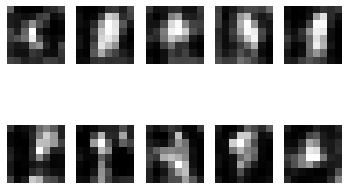

Batch 862/938 - Opimize G - Avg Batch Loss: 0.0191 - Time : 3.86s
Batch 863/938 - Opimize G - Avg Batch Loss: 0.0372 - Time : 3.84s
Batch 864/938 - Opimize G - Avg Batch Loss: 0.0492 - Time : 3.80s
Batch 865/938 - Opimize D - Avg Batch Loss: -0.0063 - Time : 3.71s
Batch 866/938 - Opimize G - Avg Batch Loss: -0.0566 - Time : 3.91s
Batch 867/938 - Opimize G - Avg Batch Loss: 0.0689 - Time : 3.98s
Batch 868/938 - Opimize G - Avg Batch Loss: 0.0079 - Time : 3.86s
Batch 869/938 - Opimize G - Avg Batch Loss: 0.0219 - Time : 3.74s
Batch 870/938 - Opimize G - Avg Batch Loss: -0.0232 - Time : 4.03s
Batch 871/938 - Opimize D - Avg Batch Loss: 0.0194 - Time : 3.92s
Batch 872/938 - Opimize G - Avg Batch Loss: 0.0034 - Time : 4.02s
Batch 873/938 - Opimize G - Avg Batch Loss: 0.0571 - Time : 3.87s
Batch 874/938 - Opimize G - Avg Batch Loss: 0.0082 - Time : 3.91s
Batch 875/938 - Opimize G - Avg Batch Loss: 0.0068 - Time : 3.81s
Batch 876/938 - Opimize G - Avg Batch Loss: -0.0232 - Time : 3.89s
Batch 

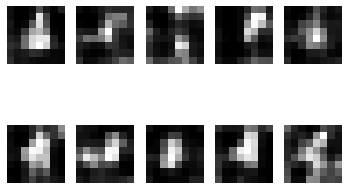

Batch 882/938 - Opimize G - Avg Batch Loss: 0.0807 - Time : 3.74s
Batch 883/938 - Opimize D - Avg Batch Loss: 0.0060 - Time : 3.81s
Batch 884/938 - Opimize G - Avg Batch Loss: -0.0336 - Time : 3.64s
Batch 885/938 - Opimize G - Avg Batch Loss: 0.0783 - Time : 3.64s
Batch 886/938 - Opimize G - Avg Batch Loss: 0.0306 - Time : 3.83s
Batch 887/938 - Opimize G - Avg Batch Loss: 0.0274 - Time : 3.86s
Batch 888/938 - Opimize G - Avg Batch Loss: 0.0006 - Time : 3.96s
Batch 889/938 - Opimize D - Avg Batch Loss: -0.0363 - Time : 3.96s
Batch 890/938 - Opimize G - Avg Batch Loss: 0.0923 - Time : 3.83s
Batch 891/938 - Opimize G - Avg Batch Loss: 0.0032 - Time : 3.68s
Batch 892/938 - Opimize G - Avg Batch Loss: 0.0315 - Time : 3.83s
Batch 893/938 - Opimize G - Avg Batch Loss: 0.0967 - Time : 3.83s
Batch 894/938 - Opimize G - Avg Batch Loss: 0.0279 - Time : 3.70s
Batch 895/938 - Opimize D - Avg Batch Loss: 0.0737 - Time : 3.64s
Batch 896/938 - Opimize G - Avg Batch Loss: 0.1014 - Time : 3.56s
Batch 89

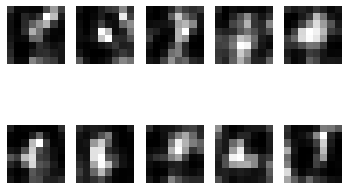

Batch 902/938 - Opimize G - Avg Batch Loss: 0.0500 - Time : 3.93s
Batch 903/938 - Opimize G - Avg Batch Loss: 0.0646 - Time : 3.66s
Batch 904/938 - Opimize G - Avg Batch Loss: 0.0508 - Time : 4.39s
Batch 905/938 - Opimize G - Avg Batch Loss: 0.0875 - Time : 4.17s
Batch 906/938 - Opimize G - Avg Batch Loss: 0.0111 - Time : 3.63s
Batch 907/938 - Opimize D - Avg Batch Loss: -0.0161 - Time : 3.69s
Batch 908/938 - Opimize G - Avg Batch Loss: -0.0459 - Time : 3.92s
Batch 909/938 - Opimize G - Avg Batch Loss: 0.0403 - Time : 3.67s
Batch 910/938 - Opimize G - Avg Batch Loss: -0.0225 - Time : 3.68s
Batch 911/938 - Opimize G - Avg Batch Loss: 0.0415 - Time : 3.78s
Batch 912/938 - Opimize G - Avg Batch Loss: 0.0180 - Time : 3.68s
Batch 913/938 - Opimize D - Avg Batch Loss: 0.0301 - Time : 3.64s
Batch 914/938 - Opimize G - Avg Batch Loss: -0.0433 - Time : 3.78s
Batch 915/938 - Opimize G - Avg Batch Loss: -0.0729 - Time : 3.97s
Batch 916/938 - Opimize G - Avg Batch Loss: 0.0399 - Time : 3.60s
Batch

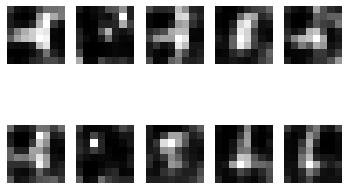

Batch 922/938 - Opimize G - Avg Batch Loss: 0.0077 - Time : 3.69s
Batch 923/938 - Opimize G - Avg Batch Loss: 0.0250 - Time : 3.65s
Batch 924/938 - Opimize G - Avg Batch Loss: -0.0099 - Time : 3.79s
Batch 925/938 - Opimize D - Avg Batch Loss: 0.0084 - Time : 3.85s
Batch 926/938 - Opimize G - Avg Batch Loss: 0.0242 - Time : 3.96s
Batch 927/938 - Opimize G - Avg Batch Loss: 0.0453 - Time : 3.61s
Batch 928/938 - Opimize G - Avg Batch Loss: -0.0375 - Time : 3.79s
Batch 929/938 - Opimize G - Avg Batch Loss: 0.0563 - Time : 3.78s
Batch 930/938 - Opimize G - Avg Batch Loss: -0.0007 - Time : 3.84s
Batch 931/938 - Opimize D - Avg Batch Loss: 0.0252 - Time : 3.66s
Batch 932/938 - Opimize G - Avg Batch Loss: -0.0111 - Time : 3.60s
Batch 933/938 - Opimize G - Avg Batch Loss: 0.0332 - Time : 3.62s
Batch 934/938 - Opimize G - Avg Batch Loss: 0.0566 - Time : 3.75s
Batch 935/938 - Opimize G - Avg Batch Loss: 0.0255 - Time : 3.68s
Batch 936/938 - Opimize G - Avg Batch Loss: -0.0092 - Time : 3.60s
Batch

In [64]:
history3 = train(n_gen=5, n_epochs = 1, batch_size = 64, plt_samples = 20, epsilon=0.01)

In [0]:
history2.extend(history3)
np.savetxt("history_eps0.01_2epochs",history2)

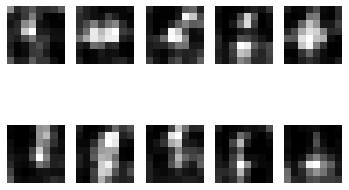

In [66]:
generate_plt()

In [0]:
torch.save(generator.state_dict(), "generatorCNN_eps0.01_2epochs.statedict")
torch.save(discriminator.state_dict(), "discriminatorCNN_eps0.01_2epochs.statedict")

========================Epoch: 1 / 2 =======================
Batch 1/938 - Opimize D - Avg Batch Loss: 0.0235 - Time : 3.67s


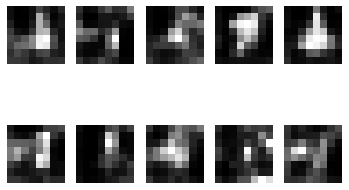

Batch 2/938 - Opimize G - Avg Batch Loss: 0.0540 - Time : 3.65s
Batch 3/938 - Opimize G - Avg Batch Loss: -0.0317 - Time : 3.76s
Batch 4/938 - Opimize G - Avg Batch Loss: -0.0072 - Time : 3.61s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.0777 - Time : 4.01s
Batch 6/938 - Opimize G - Avg Batch Loss: 0.1071 - Time : 3.75s
Batch 7/938 - Opimize D - Avg Batch Loss: -0.0097 - Time : 3.88s
Batch 8/938 - Opimize G - Avg Batch Loss: -0.0360 - Time : 3.92s
Batch 9/938 - Opimize G - Avg Batch Loss: 0.0376 - Time : 3.92s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.0246 - Time : 3.94s
Batch 11/938 - Opimize G - Avg Batch Loss: 0.0290 - Time : 4.33s
Batch 12/938 - Opimize G - Avg Batch Loss: -0.0292 - Time : 3.86s
Batch 13/938 - Opimize D - Avg Batch Loss: -0.0424 - Time : 3.85s
Batch 14/938 - Opimize G - Avg Batch Loss: 0.0079 - Time : 3.63s
Batch 15/938 - Opimize G - Avg Batch Loss: -0.0330 - Time : 3.60s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.0813 - Time : 3.85s
Batch 17/938 - Opimize G -

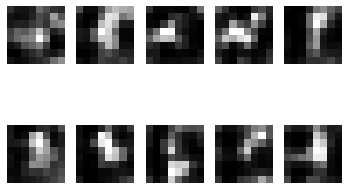

Batch 22/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.61s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.0109 - Time : 3.75s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.1247 - Time : 3.61s
Batch 25/938 - Opimize D - Avg Batch Loss: 0.0754 - Time : 3.98s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.0192 - Time : 3.74s
Batch 27/938 - Opimize G - Avg Batch Loss: -0.0476 - Time : 3.87s
Batch 28/938 - Opimize G - Avg Batch Loss: -0.0135 - Time : 3.57s
Batch 29/938 - Opimize G - Avg Batch Loss: 0.1044 - Time : 3.97s
Batch 30/938 - Opimize G - Avg Batch Loss: -0.0787 - Time : 3.69s
Batch 31/938 - Opimize D - Avg Batch Loss: 0.0123 - Time : 4.18s
Batch 32/938 - Opimize G - Avg Batch Loss: 0.0291 - Time : 3.69s
Batch 33/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 4.14s
Batch 34/938 - Opimize G - Avg Batch Loss: 0.0329 - Time : 3.94s
Batch 35/938 - Opimize G - Avg Batch Loss: -0.0051 - Time : 3.89s
Batch 36/938 - Opimize G - Avg Batch Loss: 0.0282 - Time : 3.68s
Batch 37/938 - Opimiz

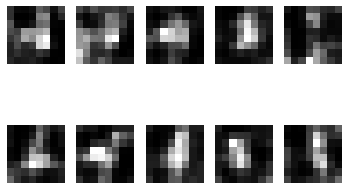

Batch 42/938 - Opimize G - Avg Batch Loss: -0.0169 - Time : 3.87s
Batch 43/938 - Opimize D - Avg Batch Loss: 0.0101 - Time : 3.62s
Batch 44/938 - Opimize G - Avg Batch Loss: -0.0231 - Time : 3.62s
Batch 45/938 - Opimize G - Avg Batch Loss: -0.0260 - Time : 3.72s
Batch 46/938 - Opimize G - Avg Batch Loss: -0.0752 - Time : 3.78s
Batch 47/938 - Opimize G - Avg Batch Loss: -0.0267 - Time : 3.71s
Batch 48/938 - Opimize G - Avg Batch Loss: -0.0271 - Time : 3.85s
Batch 49/938 - Opimize D - Avg Batch Loss: 0.0397 - Time : 3.81s
Batch 50/938 - Opimize G - Avg Batch Loss: 0.0422 - Time : 3.84s
Batch 51/938 - Opimize G - Avg Batch Loss: 0.0577 - Time : 4.08s
Batch 52/938 - Opimize G - Avg Batch Loss: -0.0631 - Time : 3.78s
Batch 53/938 - Opimize G - Avg Batch Loss: -0.0298 - Time : 3.82s
Batch 54/938 - Opimize G - Avg Batch Loss: -0.0134 - Time : 3.87s
Batch 55/938 - Opimize D - Avg Batch Loss: 0.0242 - Time : 3.85s
Batch 56/938 - Opimize G - Avg Batch Loss: -0.0590 - Time : 3.98s
Batch 57/938 - 

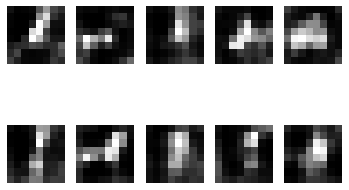

Batch 62/938 - Opimize G - Avg Batch Loss: -0.0216 - Time : 3.63s
Batch 63/938 - Opimize G - Avg Batch Loss: -0.0793 - Time : 4.02s
Batch 64/938 - Opimize G - Avg Batch Loss: 0.0042 - Time : 3.55s
Batch 65/938 - Opimize G - Avg Batch Loss: 0.0148 - Time : 3.63s
Batch 66/938 - Opimize G - Avg Batch Loss: -0.0254 - Time : 3.71s
Batch 67/938 - Opimize D - Avg Batch Loss: -0.0734 - Time : 3.59s
Batch 68/938 - Opimize G - Avg Batch Loss: 0.0803 - Time : 3.62s
Batch 69/938 - Opimize G - Avg Batch Loss: 0.0081 - Time : 3.85s
Batch 70/938 - Opimize G - Avg Batch Loss: -0.0269 - Time : 3.65s
Batch 71/938 - Opimize G - Avg Batch Loss: 0.0777 - Time : 3.54s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.0154 - Time : 3.84s
Batch 73/938 - Opimize D - Avg Batch Loss: 0.0212 - Time : 3.87s
Batch 74/938 - Opimize G - Avg Batch Loss: -0.0030 - Time : 3.72s
Batch 75/938 - Opimize G - Avg Batch Loss: -0.0250 - Time : 3.60s
Batch 76/938 - Opimize G - Avg Batch Loss: -0.0396 - Time : 3.75s
Batch 77/938 - Op

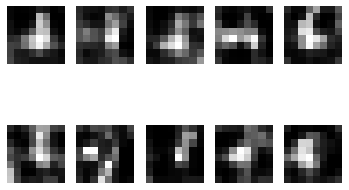

Batch 82/938 - Opimize G - Avg Batch Loss: 0.0007 - Time : 3.62s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.0001 - Time : 3.56s
Batch 84/938 - Opimize G - Avg Batch Loss: -0.0618 - Time : 3.69s
Batch 85/938 - Opimize D - Avg Batch Loss: 0.0848 - Time : 3.59s
Batch 86/938 - Opimize G - Avg Batch Loss: -0.0154 - Time : 3.87s
Batch 87/938 - Opimize G - Avg Batch Loss: -0.0354 - Time : 3.83s
Batch 88/938 - Opimize G - Avg Batch Loss: 0.0587 - Time : 3.56s
Batch 89/938 - Opimize G - Avg Batch Loss: -0.0169 - Time : 3.58s
Batch 90/938 - Opimize G - Avg Batch Loss: -0.0024 - Time : 3.74s
Batch 91/938 - Opimize D - Avg Batch Loss: -0.0035 - Time : 3.50s
Batch 92/938 - Opimize G - Avg Batch Loss: 0.1192 - Time : 3.74s
Batch 93/938 - Opimize G - Avg Batch Loss: 0.0501 - Time : 3.94s
Batch 94/938 - Opimize G - Avg Batch Loss: -0.0378 - Time : 3.80s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.0207 - Time : 3.99s
Batch 96/938 - Opimize G - Avg Batch Loss: 0.0991 - Time : 3.83s
Batch 97/938 - Opi

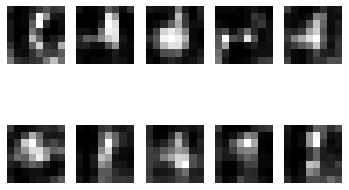

Batch 102/938 - Opimize G - Avg Batch Loss: 0.0162 - Time : 3.71s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.1015 - Time : 3.91s
Batch 104/938 - Opimize G - Avg Batch Loss: 0.0229 - Time : 3.84s
Batch 105/938 - Opimize G - Avg Batch Loss: 0.0574 - Time : 3.64s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.0324 - Time : 3.90s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.0107 - Time : 3.87s
Batch 108/938 - Opimize G - Avg Batch Loss: 0.0040 - Time : 3.82s
Batch 109/938 - Opimize D - Avg Batch Loss: 0.0620 - Time : 4.02s
Batch 110/938 - Opimize G - Avg Batch Loss: -0.0550 - Time : 4.05s
Batch 111/938 - Opimize G - Avg Batch Loss: -0.0193 - Time : 3.78s
Batch 112/938 - Opimize G - Avg Batch Loss: -0.0164 - Time : 3.52s
Batch 113/938 - Opimize G - Avg Batch Loss: -0.0002 - Time : 3.54s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.0254 - Time : 3.64s
Batch 115/938 - Opimize D - Avg Batch Loss: -0.0087 - Time : 3.55s
Batch 116/938 - Opimize G - Avg Batch Loss: 0.0583 - Time : 3.59s
Batch

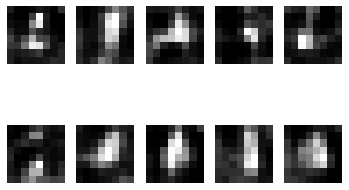

Batch 122/938 - Opimize G - Avg Batch Loss: 0.1004 - Time : 3.70s
Batch 123/938 - Opimize G - Avg Batch Loss: 0.0254 - Time : 3.97s
Batch 124/938 - Opimize G - Avg Batch Loss: 0.0606 - Time : 3.63s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.1156 - Time : 3.65s
Batch 126/938 - Opimize G - Avg Batch Loss: -0.0401 - Time : 4.01s
Batch 127/938 - Opimize D - Avg Batch Loss: 0.0389 - Time : 3.93s
Batch 128/938 - Opimize G - Avg Batch Loss: 0.0393 - Time : 3.63s
Batch 129/938 - Opimize G - Avg Batch Loss: 0.0325 - Time : 3.56s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.0147 - Time : 3.62s
Batch 131/938 - Opimize G - Avg Batch Loss: 0.0039 - Time : 3.68s
Batch 132/938 - Opimize G - Avg Batch Loss: -0.0178 - Time : 3.77s
Batch 133/938 - Opimize D - Avg Batch Loss: 0.0153 - Time : 3.66s
Batch 134/938 - Opimize G - Avg Batch Loss: -0.0178 - Time : 3.54s
Batch 135/938 - Opimize G - Avg Batch Loss: -0.0298 - Time : 3.77s
Batch 136/938 - Opimize G - Avg Batch Loss: 0.0597 - Time : 3.67s
Batch 

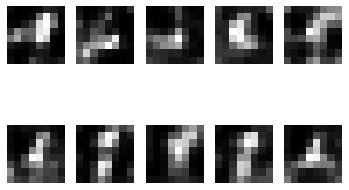

Batch 142/938 - Opimize G - Avg Batch Loss: 0.0633 - Time : 3.98s
Batch 143/938 - Opimize G - Avg Batch Loss: -0.0072 - Time : 4.07s
Batch 144/938 - Opimize G - Avg Batch Loss: 0.0275 - Time : 3.70s
Batch 145/938 - Opimize D - Avg Batch Loss: 0.0595 - Time : 3.87s
Batch 146/938 - Opimize G - Avg Batch Loss: -0.0220 - Time : 4.06s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.0452 - Time : 4.03s
Batch 148/938 - Opimize G - Avg Batch Loss: -0.0036 - Time : 3.70s
Batch 149/938 - Opimize G - Avg Batch Loss: 0.0263 - Time : 3.73s
Batch 150/938 - Opimize G - Avg Batch Loss: 0.0344 - Time : 3.88s
Batch 151/938 - Opimize D - Avg Batch Loss: 0.0877 - Time : 3.59s
Batch 152/938 - Opimize G - Avg Batch Loss: 0.0366 - Time : 3.74s
Batch 153/938 - Opimize G - Avg Batch Loss: -0.0333 - Time : 3.82s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.0149 - Time : 3.57s
Batch 155/938 - Opimize G - Avg Batch Loss: 0.1054 - Time : 3.83s
Batch 156/938 - Opimize G - Avg Batch Loss: 0.0179 - Time : 3.59s
Batch 

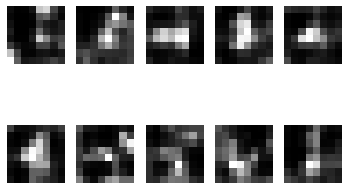

Batch 162/938 - Opimize G - Avg Batch Loss: 0.0642 - Time : 3.61s
Batch 163/938 - Opimize D - Avg Batch Loss: -0.0177 - Time : 3.60s
Batch 164/938 - Opimize G - Avg Batch Loss: 0.0207 - Time : 3.68s
Batch 165/938 - Opimize G - Avg Batch Loss: -0.0425 - Time : 3.60s
Batch 166/938 - Opimize G - Avg Batch Loss: -0.0376 - Time : 3.57s
Batch 167/938 - Opimize G - Avg Batch Loss: -0.0222 - Time : 3.78s
Batch 168/938 - Opimize G - Avg Batch Loss: 0.0171 - Time : 3.67s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.0132 - Time : 3.63s
Batch 170/938 - Opimize G - Avg Batch Loss: 0.0637 - Time : 3.48s
Batch 171/938 - Opimize G - Avg Batch Loss: -0.0325 - Time : 3.57s
Batch 172/938 - Opimize G - Avg Batch Loss: 0.0309 - Time : 3.55s
Batch 173/938 - Opimize G - Avg Batch Loss: -0.0158 - Time : 3.54s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.0395 - Time : 3.63s
Batch 175/938 - Opimize D - Avg Batch Loss: -0.0014 - Time : 3.75s
Batch 176/938 - Opimize G - Avg Batch Loss: -0.0015 - Time : 3.56s
Ba

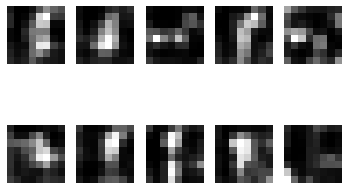

Batch 182/938 - Opimize G - Avg Batch Loss: 0.0928 - Time : 3.72s
Batch 183/938 - Opimize G - Avg Batch Loss: 0.0114 - Time : 3.79s
Batch 184/938 - Opimize G - Avg Batch Loss: 0.0794 - Time : 3.74s
Batch 185/938 - Opimize G - Avg Batch Loss: 0.0299 - Time : 3.52s
Batch 186/938 - Opimize G - Avg Batch Loss: 0.0676 - Time : 3.89s
Batch 187/938 - Opimize D - Avg Batch Loss: -0.0072 - Time : 3.96s
Batch 188/938 - Opimize G - Avg Batch Loss: 0.0301 - Time : 3.68s
Batch 189/938 - Opimize G - Avg Batch Loss: 0.0096 - Time : 3.94s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.0835 - Time : 3.53s
Batch 191/938 - Opimize G - Avg Batch Loss: 0.0981 - Time : 3.69s
Batch 192/938 - Opimize G - Avg Batch Loss: -0.0265 - Time : 3.81s
Batch 193/938 - Opimize D - Avg Batch Loss: -0.0401 - Time : 3.77s
Batch 194/938 - Opimize G - Avg Batch Loss: -0.0048 - Time : 3.78s
Batch 195/938 - Opimize G - Avg Batch Loss: 0.0070 - Time : 3.66s
Batch 196/938 - Opimize G - Avg Batch Loss: -0.0229 - Time : 4.12s
Batch

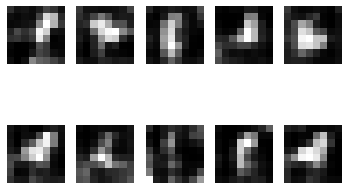

Batch 202/938 - Opimize G - Avg Batch Loss: -0.0698 - Time : 3.58s
Batch 203/938 - Opimize G - Avg Batch Loss: 0.0859 - Time : 3.56s
Batch 204/938 - Opimize G - Avg Batch Loss: -0.0414 - Time : 3.53s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.0972 - Time : 4.31s
Batch 206/938 - Opimize G - Avg Batch Loss: -0.0106 - Time : 3.69s
Batch 207/938 - Opimize G - Avg Batch Loss: 0.0189 - Time : 3.55s
Batch 208/938 - Opimize G - Avg Batch Loss: 0.0285 - Time : 3.77s
Batch 209/938 - Opimize G - Avg Batch Loss: 0.0071 - Time : 3.54s
Batch 210/938 - Opimize G - Avg Batch Loss: 0.1089 - Time : 3.44s
Batch 211/938 - Opimize D - Avg Batch Loss: 0.1492 - Time : 3.83s
Batch 212/938 - Opimize G - Avg Batch Loss: 0.0755 - Time : 3.55s
Batch 213/938 - Opimize G - Avg Batch Loss: -0.0274 - Time : 3.81s
Batch 214/938 - Opimize G - Avg Batch Loss: -0.0788 - Time : 3.47s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.0648 - Time : 3.50s
Batch 216/938 - Opimize G - Avg Batch Loss: 0.0359 - Time : 3.87s
Batch

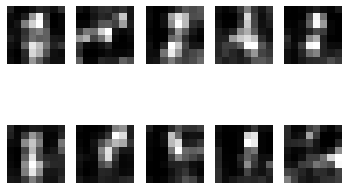

Batch 222/938 - Opimize G - Avg Batch Loss: 0.0848 - Time : 3.53s
Batch 223/938 - Opimize D - Avg Batch Loss: -0.0266 - Time : 3.55s
Batch 224/938 - Opimize G - Avg Batch Loss: 0.0294 - Time : 3.52s
Batch 225/938 - Opimize G - Avg Batch Loss: 0.0396 - Time : 3.76s
Batch 226/938 - Opimize G - Avg Batch Loss: -0.0312 - Time : 3.75s
Batch 227/938 - Opimize G - Avg Batch Loss: -0.0081 - Time : 3.65s
Batch 228/938 - Opimize G - Avg Batch Loss: -0.0294 - Time : 3.99s
Batch 229/938 - Opimize D - Avg Batch Loss: 0.0046 - Time : 3.71s
Batch 230/938 - Opimize G - Avg Batch Loss: -0.0829 - Time : 3.58s
Batch 231/938 - Opimize G - Avg Batch Loss: 0.0673 - Time : 3.44s
Batch 232/938 - Opimize G - Avg Batch Loss: 0.0792 - Time : 3.93s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.0026 - Time : 3.52s
Batch 234/938 - Opimize G - Avg Batch Loss: 0.0308 - Time : 3.71s
Batch 235/938 - Opimize D - Avg Batch Loss: 0.0579 - Time : 3.80s
Batch 236/938 - Opimize G - Avg Batch Loss: 0.0431 - Time : 3.55s
Batch

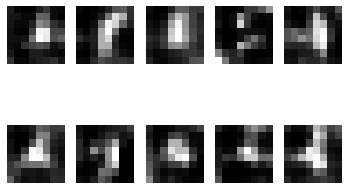

Batch 242/938 - Opimize G - Avg Batch Loss: 0.0931 - Time : 3.46s
Batch 243/938 - Opimize G - Avg Batch Loss: 0.0839 - Time : 3.53s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.0425 - Time : 3.55s
Batch 245/938 - Opimize G - Avg Batch Loss: -0.0677 - Time : 3.69s
Batch 246/938 - Opimize G - Avg Batch Loss: -0.0145 - Time : 3.78s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.0465 - Time : 3.78s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.1048 - Time : 3.61s
Batch 249/938 - Opimize G - Avg Batch Loss: 0.0614 - Time : 3.77s
Batch 250/938 - Opimize G - Avg Batch Loss: 0.1012 - Time : 3.68s
Batch 251/938 - Opimize G - Avg Batch Loss: 0.0254 - Time : 3.63s
Batch 252/938 - Opimize G - Avg Batch Loss: -0.0484 - Time : 3.65s
Batch 253/938 - Opimize D - Avg Batch Loss: 0.0312 - Time : 3.49s
Batch 254/938 - Opimize G - Avg Batch Loss: -0.0359 - Time : 3.45s
Batch 255/938 - Opimize G - Avg Batch Loss: 0.0256 - Time : 3.45s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.0149 - Time : 3.50s
Batch 

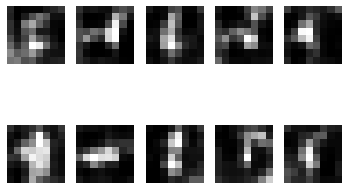

Batch 262/938 - Opimize G - Avg Batch Loss: 0.0560 - Time : 3.87s
Batch 263/938 - Opimize G - Avg Batch Loss: 0.0399 - Time : 3.53s
Batch 264/938 - Opimize G - Avg Batch Loss: 0.0912 - Time : 3.48s
Batch 265/938 - Opimize D - Avg Batch Loss: 0.0173 - Time : 3.72s
Batch 266/938 - Opimize G - Avg Batch Loss: -0.0765 - Time : 3.71s
Batch 267/938 - Opimize G - Avg Batch Loss: -0.0354 - Time : 3.73s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.0259 - Time : 3.62s
Batch 269/938 - Opimize G - Avg Batch Loss: 0.0911 - Time : 3.77s
Batch 270/938 - Opimize G - Avg Batch Loss: -0.0838 - Time : 3.74s
Batch 271/938 - Opimize D - Avg Batch Loss: -0.0419 - Time : 3.53s
Batch 272/938 - Opimize G - Avg Batch Loss: -0.0224 - Time : 3.74s
Batch 273/938 - Opimize G - Avg Batch Loss: 0.0216 - Time : 3.69s
Batch 274/938 - Opimize G - Avg Batch Loss: 0.0099 - Time : 4.01s
Batch 275/938 - Opimize G - Avg Batch Loss: -0.0361 - Time : 4.17s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.0552 - Time : 3.83s
Batc

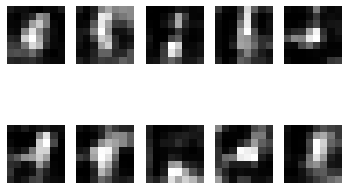

Batch 282/938 - Opimize G - Avg Batch Loss: 0.0154 - Time : 3.95s
Batch 283/938 - Opimize D - Avg Batch Loss: -0.0162 - Time : 3.71s
Batch 284/938 - Opimize G - Avg Batch Loss: -0.0212 - Time : 3.53s
Batch 285/938 - Opimize G - Avg Batch Loss: 0.0168 - Time : 3.62s
Batch 286/938 - Opimize G - Avg Batch Loss: 0.0361 - Time : 3.76s
Batch 287/938 - Opimize G - Avg Batch Loss: -0.0089 - Time : 3.59s
Batch 288/938 - Opimize G - Avg Batch Loss: 0.0386 - Time : 3.94s
Batch 289/938 - Opimize D - Avg Batch Loss: 0.0123 - Time : 4.55s
Batch 290/938 - Opimize G - Avg Batch Loss: 0.0310 - Time : 3.59s
Batch 291/938 - Opimize G - Avg Batch Loss: -0.0165 - Time : 3.83s
Batch 292/938 - Opimize G - Avg Batch Loss: 0.0150 - Time : 3.67s
Batch 293/938 - Opimize G - Avg Batch Loss: -0.0809 - Time : 4.10s
Batch 294/938 - Opimize G - Avg Batch Loss: 0.0364 - Time : 3.70s
Batch 295/938 - Opimize D - Avg Batch Loss: 0.1549 - Time : 3.85s
Batch 296/938 - Opimize G - Avg Batch Loss: -0.0105 - Time : 3.85s
Batc

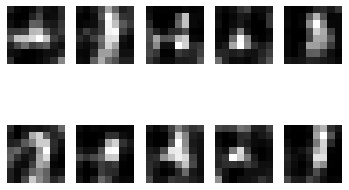

Batch 302/938 - Opimize G - Avg Batch Loss: 0.1927 - Time : 3.62s
Batch 303/938 - Opimize G - Avg Batch Loss: 0.0494 - Time : 3.77s
Batch 304/938 - Opimize G - Avg Batch Loss: -0.0585 - Time : 3.94s
Batch 305/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.78s
Batch 306/938 - Opimize G - Avg Batch Loss: 0.0210 - Time : 3.59s
Batch 307/938 - Opimize D - Avg Batch Loss: -0.0689 - Time : 3.60s
Batch 308/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.84s
Batch 309/938 - Opimize G - Avg Batch Loss: -0.0340 - Time : 3.79s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.0289 - Time : 3.68s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.0258 - Time : 3.78s
Batch 312/938 - Opimize G - Avg Batch Loss: 0.0400 - Time : 3.79s
Batch 313/938 - Opimize D - Avg Batch Loss: 0.0692 - Time : 3.65s
Batch 314/938 - Opimize G - Avg Batch Loss: -0.0375 - Time : 3.57s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.0622 - Time : 4.08s
Batch 316/938 - Opimize G - Avg Batch Loss: -0.0540 - Time : 3.94s
Bat

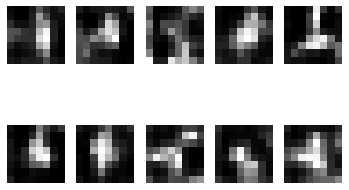

Batch 322/938 - Opimize G - Avg Batch Loss: 0.0774 - Time : 4.03s
Batch 323/938 - Opimize G - Avg Batch Loss: 0.0215 - Time : 3.54s
Batch 324/938 - Opimize G - Avg Batch Loss: -0.0671 - Time : 3.94s
Batch 325/938 - Opimize D - Avg Batch Loss: -0.0292 - Time : 4.15s
Batch 326/938 - Opimize G - Avg Batch Loss: 0.0046 - Time : 4.00s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.0410 - Time : 3.58s
Batch 328/938 - Opimize G - Avg Batch Loss: 0.1174 - Time : 3.69s
Batch 329/938 - Opimize G - Avg Batch Loss: 0.0540 - Time : 3.87s
Batch 330/938 - Opimize G - Avg Batch Loss: 0.0334 - Time : 3.93s
Batch 331/938 - Opimize D - Avg Batch Loss: -0.0603 - Time : 3.88s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.0563 - Time : 4.24s
Batch 333/938 - Opimize G - Avg Batch Loss: 0.0767 - Time : 4.02s
Batch 334/938 - Opimize G - Avg Batch Loss: 0.0992 - Time : 3.55s
Batch 335/938 - Opimize G - Avg Batch Loss: 0.0473 - Time : 3.92s
Batch 336/938 - Opimize G - Avg Batch Loss: 0.0120 - Time : 3.85s
Batch 3

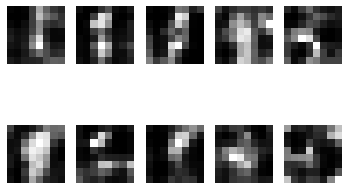

Batch 342/938 - Opimize G - Avg Batch Loss: -0.0609 - Time : 3.68s
Batch 343/938 - Opimize D - Avg Batch Loss: -0.0717 - Time : 3.96s
Batch 344/938 - Opimize G - Avg Batch Loss: 0.0499 - Time : 3.54s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.0997 - Time : 3.81s
Batch 346/938 - Opimize G - Avg Batch Loss: 0.0464 - Time : 3.70s
Batch 347/938 - Opimize G - Avg Batch Loss: -0.0337 - Time : 3.57s
Batch 348/938 - Opimize G - Avg Batch Loss: 0.0076 - Time : 3.80s
Batch 349/938 - Opimize D - Avg Batch Loss: 0.0334 - Time : 3.56s
Batch 350/938 - Opimize G - Avg Batch Loss: 0.0116 - Time : 3.49s
Batch 351/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.64s
Batch 352/938 - Opimize G - Avg Batch Loss: -0.0287 - Time : 3.74s
Batch 353/938 - Opimize G - Avg Batch Loss: 0.1080 - Time : 3.61s
Batch 354/938 - Opimize G - Avg Batch Loss: 0.0178 - Time : 3.60s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.0153 - Time : 3.64s
Batch 356/938 - Opimize G - Avg Batch Loss: 0.0645 - Time : 3.57s
Batch

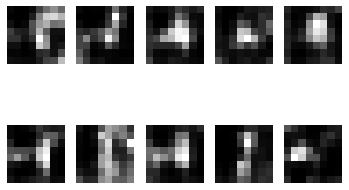

Batch 362/938 - Opimize G - Avg Batch Loss: 0.0285 - Time : 3.53s
Batch 363/938 - Opimize G - Avg Batch Loss: -0.0016 - Time : 3.84s
Batch 364/938 - Opimize G - Avg Batch Loss: 0.0210 - Time : 3.62s
Batch 365/938 - Opimize G - Avg Batch Loss: 0.0389 - Time : 3.52s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.1167 - Time : 3.87s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.0110 - Time : 3.73s
Batch 368/938 - Opimize G - Avg Batch Loss: 0.0173 - Time : 3.44s
Batch 369/938 - Opimize G - Avg Batch Loss: 0.0276 - Time : 3.54s
Batch 370/938 - Opimize G - Avg Batch Loss: 0.0416 - Time : 3.51s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.0276 - Time : 3.65s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.0345 - Time : 3.57s
Batch 373/938 - Opimize D - Avg Batch Loss: 0.0234 - Time : 3.48s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.0908 - Time : 3.58s
Batch 375/938 - Opimize G - Avg Batch Loss: -0.0160 - Time : 3.72s
Batch 376/938 - Opimize G - Avg Batch Loss: 0.0202 - Time : 3.75s
Batch 37

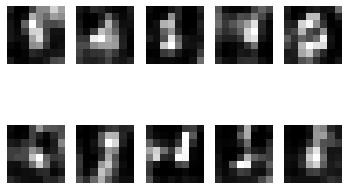

Batch 382/938 - Opimize G - Avg Batch Loss: 0.0033 - Time : 3.51s
Batch 383/938 - Opimize G - Avg Batch Loss: 0.0753 - Time : 3.50s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.0141 - Time : 3.50s
Batch 385/938 - Opimize D - Avg Batch Loss: -0.1347 - Time : 3.53s
Batch 386/938 - Opimize G - Avg Batch Loss: -0.0342 - Time : 3.71s
Batch 387/938 - Opimize G - Avg Batch Loss: -0.0415 - Time : 3.56s
Batch 388/938 - Opimize G - Avg Batch Loss: 0.0731 - Time : 4.07s
Batch 389/938 - Opimize G - Avg Batch Loss: 0.0749 - Time : 3.50s
Batch 390/938 - Opimize G - Avg Batch Loss: -0.0178 - Time : 3.63s
Batch 391/938 - Opimize D - Avg Batch Loss: 0.1445 - Time : 3.60s
Batch 392/938 - Opimize G - Avg Batch Loss: -0.0556 - Time : 3.67s
Batch 393/938 - Opimize G - Avg Batch Loss: 0.0208 - Time : 3.87s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.0447 - Time : 3.64s
Batch 395/938 - Opimize G - Avg Batch Loss: -0.0041 - Time : 3.60s
Batch 396/938 - Opimize G - Avg Batch Loss: -0.0769 - Time : 3.46s
Bat

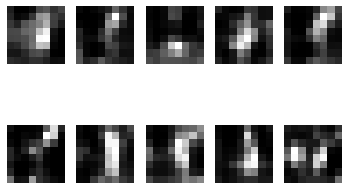

Batch 402/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.77s
Batch 403/938 - Opimize D - Avg Batch Loss: 0.0629 - Time : 3.46s
Batch 404/938 - Opimize G - Avg Batch Loss: 0.0844 - Time : 3.58s
Batch 405/938 - Opimize G - Avg Batch Loss: -0.0108 - Time : 3.65s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.0279 - Time : 3.91s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.1207 - Time : 3.49s
Batch 408/938 - Opimize G - Avg Batch Loss: 0.0964 - Time : 3.49s
Batch 409/938 - Opimize D - Avg Batch Loss: 0.0391 - Time : 3.73s
Batch 410/938 - Opimize G - Avg Batch Loss: 0.0928 - Time : 3.69s
Batch 411/938 - Opimize G - Avg Batch Loss: 0.0550 - Time : 3.51s
Batch 412/938 - Opimize G - Avg Batch Loss: -0.0266 - Time : 3.78s
Batch 413/938 - Opimize G - Avg Batch Loss: -0.0430 - Time : 3.93s
Batch 414/938 - Opimize G - Avg Batch Loss: -0.0556 - Time : 4.05s
Batch 415/938 - Opimize D - Avg Batch Loss: -0.0571 - Time : 3.90s
Batch 416/938 - Opimize G - Avg Batch Loss: -0.0002 - Time : 3.58s
Batc

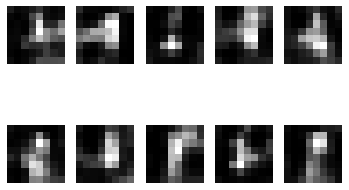

Batch 422/938 - Opimize G - Avg Batch Loss: -0.0191 - Time : 3.71s
Batch 423/938 - Opimize G - Avg Batch Loss: 0.0748 - Time : 4.07s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.0485 - Time : 3.82s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.0309 - Time : 3.53s
Batch 426/938 - Opimize G - Avg Batch Loss: 0.1166 - Time : 3.52s
Batch 427/938 - Opimize D - Avg Batch Loss: 0.0314 - Time : 4.13s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.0638 - Time : 3.71s
Batch 429/938 - Opimize G - Avg Batch Loss: -0.0436 - Time : 3.73s
Batch 430/938 - Opimize G - Avg Batch Loss: -0.0375 - Time : 4.00s
Batch 431/938 - Opimize G - Avg Batch Loss: 0.1001 - Time : 3.89s
Batch 432/938 - Opimize G - Avg Batch Loss: 0.0572 - Time : 3.55s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.1196 - Time : 3.81s
Batch 434/938 - Opimize G - Avg Batch Loss: 0.0055 - Time : 3.90s
Batch 435/938 - Opimize G - Avg Batch Loss: -0.0180 - Time : 3.59s
Batch 436/938 - Opimize G - Avg Batch Loss: 0.0020 - Time : 3.59s
Batch 

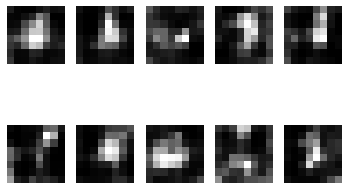

Batch 442/938 - Opimize G - Avg Batch Loss: 0.0253 - Time : 3.73s
Batch 443/938 - Opimize G - Avg Batch Loss: -0.0138 - Time : 3.65s
Batch 444/938 - Opimize G - Avg Batch Loss: -0.0660 - Time : 3.66s
Batch 445/938 - Opimize D - Avg Batch Loss: -0.0030 - Time : 3.62s
Batch 446/938 - Opimize G - Avg Batch Loss: 0.0083 - Time : 3.51s
Batch 447/938 - Opimize G - Avg Batch Loss: -0.0533 - Time : 3.70s
Batch 448/938 - Opimize G - Avg Batch Loss: -0.0128 - Time : 3.52s
Batch 449/938 - Opimize G - Avg Batch Loss: -0.0894 - Time : 3.57s
Batch 450/938 - Opimize G - Avg Batch Loss: 0.0400 - Time : 3.81s
Batch 451/938 - Opimize D - Avg Batch Loss: 0.0142 - Time : 3.55s
Batch 452/938 - Opimize G - Avg Batch Loss: 0.0621 - Time : 3.53s
Batch 453/938 - Opimize G - Avg Batch Loss: 0.0971 - Time : 3.62s
Batch 454/938 - Opimize G - Avg Batch Loss: -0.0463 - Time : 3.65s
Batch 455/938 - Opimize G - Avg Batch Loss: -0.0802 - Time : 3.50s
Batch 456/938 - Opimize G - Avg Batch Loss: 0.0453 - Time : 3.51s
Ba

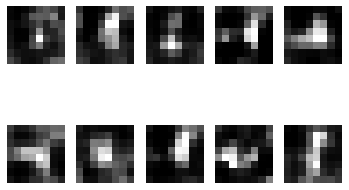

Batch 462/938 - Opimize G - Avg Batch Loss: 0.0353 - Time : 3.90s
Batch 463/938 - Opimize D - Avg Batch Loss: -0.0329 - Time : 3.76s
Batch 464/938 - Opimize G - Avg Batch Loss: 0.0100 - Time : 3.54s
Batch 465/938 - Opimize G - Avg Batch Loss: -0.0298 - Time : 3.74s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.0035 - Time : 3.46s
Batch 467/938 - Opimize G - Avg Batch Loss: -0.0644 - Time : 3.57s
Batch 468/938 - Opimize G - Avg Batch Loss: 0.0190 - Time : 3.77s
Batch 469/938 - Opimize D - Avg Batch Loss: 0.0261 - Time : 3.56s
Batch 470/938 - Opimize G - Avg Batch Loss: 0.0068 - Time : 3.50s
Batch 471/938 - Opimize G - Avg Batch Loss: 0.0724 - Time : 3.63s
Batch 472/938 - Opimize G - Avg Batch Loss: 0.0551 - Time : 3.43s
Batch 473/938 - Opimize G - Avg Batch Loss: 0.0737 - Time : 4.00s
Batch 474/938 - Opimize G - Avg Batch Loss: 0.0129 - Time : 3.59s
Batch 475/938 - Opimize D - Avg Batch Loss: 0.0691 - Time : 3.46s
Batch 476/938 - Opimize G - Avg Batch Loss: -0.0041 - Time : 3.53s
Batch 

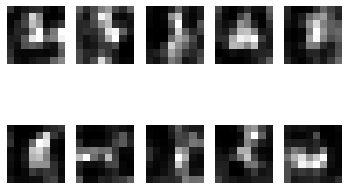

Batch 482/938 - Opimize G - Avg Batch Loss: 0.1325 - Time : 3.58s
Batch 483/938 - Opimize G - Avg Batch Loss: 0.0417 - Time : 3.42s
Batch 484/938 - Opimize G - Avg Batch Loss: -0.0148 - Time : 3.52s
Batch 485/938 - Opimize G - Avg Batch Loss: 0.1220 - Time : 3.47s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.0038 - Time : 3.75s
Batch 487/938 - Opimize D - Avg Batch Loss: -0.0250 - Time : 3.91s
Batch 488/938 - Opimize G - Avg Batch Loss: 0.0181 - Time : 3.53s
Batch 489/938 - Opimize G - Avg Batch Loss: 0.0145 - Time : 3.54s
Batch 490/938 - Opimize G - Avg Batch Loss: -0.0375 - Time : 3.51s
Batch 491/938 - Opimize G - Avg Batch Loss: -0.0743 - Time : 3.44s
Batch 492/938 - Opimize G - Avg Batch Loss: 0.0292 - Time : 3.73s
Batch 493/938 - Opimize D - Avg Batch Loss: 0.0373 - Time : 3.57s
Batch 494/938 - Opimize G - Avg Batch Loss: 0.1219 - Time : 4.10s
Batch 495/938 - Opimize G - Avg Batch Loss: 0.0358 - Time : 3.92s
Batch 496/938 - Opimize G - Avg Batch Loss: 0.0333 - Time : 3.49s
Batch 

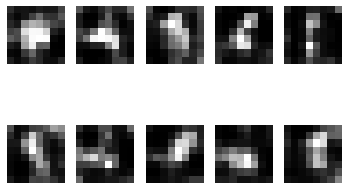

Batch 502/938 - Opimize G - Avg Batch Loss: 0.0405 - Time : 3.40s
Batch 503/938 - Opimize G - Avg Batch Loss: 0.0225 - Time : 3.63s
Batch 504/938 - Opimize G - Avg Batch Loss: 0.0381 - Time : 3.66s
Batch 505/938 - Opimize D - Avg Batch Loss: 0.0043 - Time : 3.97s
Batch 506/938 - Opimize G - Avg Batch Loss: 0.0443 - Time : 3.54s
Batch 507/938 - Opimize G - Avg Batch Loss: -0.0138 - Time : 3.88s
Batch 508/938 - Opimize G - Avg Batch Loss: 0.0026 - Time : 3.68s
Batch 509/938 - Opimize G - Avg Batch Loss: -0.0078 - Time : 3.79s
Batch 510/938 - Opimize G - Avg Batch Loss: -0.0124 - Time : 3.91s
Batch 511/938 - Opimize D - Avg Batch Loss: 0.0964 - Time : 3.70s
Batch 512/938 - Opimize G - Avg Batch Loss: 0.0883 - Time : 3.50s
Batch 513/938 - Opimize G - Avg Batch Loss: 0.0043 - Time : 3.61s
Batch 514/938 - Opimize G - Avg Batch Loss: -0.0067 - Time : 3.48s
Batch 515/938 - Opimize G - Avg Batch Loss: -0.0395 - Time : 3.55s
Batch 516/938 - Opimize G - Avg Batch Loss: 0.0431 - Time : 3.68s
Batch

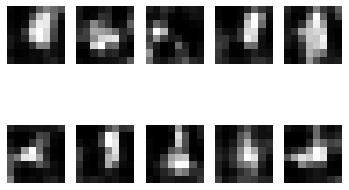

Batch 522/938 - Opimize G - Avg Batch Loss: -0.0481 - Time : 3.53s
Batch 523/938 - Opimize D - Avg Batch Loss: -0.0678 - Time : 3.76s
Batch 524/938 - Opimize G - Avg Batch Loss: -0.0192 - Time : 3.54s
Batch 525/938 - Opimize G - Avg Batch Loss: 0.0786 - Time : 3.75s
Batch 526/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.71s
Batch 527/938 - Opimize G - Avg Batch Loss: -0.0325 - Time : 4.01s
Batch 528/938 - Opimize G - Avg Batch Loss: -0.0228 - Time : 3.68s
Batch 529/938 - Opimize D - Avg Batch Loss: 0.0333 - Time : 3.49s
Batch 530/938 - Opimize G - Avg Batch Loss: 0.1181 - Time : 3.44s
Batch 531/938 - Opimize G - Avg Batch Loss: -0.0736 - Time : 3.52s
Batch 532/938 - Opimize G - Avg Batch Loss: -0.0717 - Time : 3.62s
Batch 533/938 - Opimize G - Avg Batch Loss: 0.0170 - Time : 3.45s
Batch 534/938 - Opimize G - Avg Batch Loss: 0.0363 - Time : 3.47s
Batch 535/938 - Opimize D - Avg Batch Loss: -0.0030 - Time : 3.66s
Batch 536/938 - Opimize G - Avg Batch Loss: -0.0418 - Time : 3.65s
B

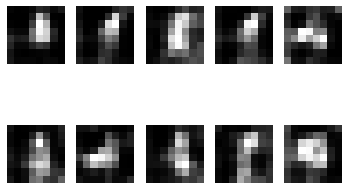

Batch 542/938 - Opimize G - Avg Batch Loss: -0.0106 - Time : 3.69s
Batch 543/938 - Opimize G - Avg Batch Loss: -0.0328 - Time : 3.80s
Batch 544/938 - Opimize G - Avg Batch Loss: -0.0259 - Time : 3.86s
Batch 545/938 - Opimize G - Avg Batch Loss: 0.0587 - Time : 3.96s
Batch 546/938 - Opimize G - Avg Batch Loss: 0.0213 - Time : 3.93s
Batch 547/938 - Opimize D - Avg Batch Loss: -0.0037 - Time : 3.77s
Batch 548/938 - Opimize G - Avg Batch Loss: -0.0053 - Time : 3.85s
Batch 549/938 - Opimize G - Avg Batch Loss: -0.0351 - Time : 3.87s
Batch 550/938 - Opimize G - Avg Batch Loss: -0.0040 - Time : 3.63s
Batch 551/938 - Opimize G - Avg Batch Loss: 0.0062 - Time : 3.77s
Batch 552/938 - Opimize G - Avg Batch Loss: 0.0407 - Time : 3.73s
Batch 553/938 - Opimize D - Avg Batch Loss: 0.0498 - Time : 3.80s
Batch 554/938 - Opimize G - Avg Batch Loss: -0.0343 - Time : 3.66s
Batch 555/938 - Opimize G - Avg Batch Loss: -0.0282 - Time : 3.59s
Batch 556/938 - Opimize G - Avg Batch Loss: 0.0523 - Time : 3.59s
B

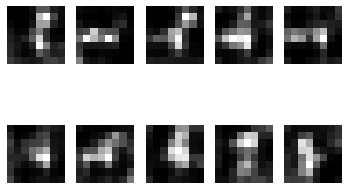

Batch 562/938 - Opimize G - Avg Batch Loss: 0.0990 - Time : 3.80s
Batch 563/938 - Opimize G - Avg Batch Loss: -0.0244 - Time : 3.53s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.0199 - Time : 3.56s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.0175 - Time : 3.50s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.0686 - Time : 3.52s
Batch 567/938 - Opimize G - Avg Batch Loss: -0.0517 - Time : 3.75s
Batch 568/938 - Opimize G - Avg Batch Loss: 0.0163 - Time : 3.74s
Batch 569/938 - Opimize G - Avg Batch Loss: -0.0339 - Time : 3.66s
Batch 570/938 - Opimize G - Avg Batch Loss: 0.0354 - Time : 3.72s
Batch 571/938 - Opimize D - Avg Batch Loss: -0.0166 - Time : 3.59s
Batch 572/938 - Opimize G - Avg Batch Loss: 0.0014 - Time : 3.88s
Batch 573/938 - Opimize G - Avg Batch Loss: -0.0849 - Time : 3.61s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.0176 - Time : 3.56s
Batch 575/938 - Opimize G - Avg Batch Loss: -0.0095 - Time : 3.68s
Batch 576/938 - Opimize G - Avg Batch Loss: 0.0038 - Time : 3.77s
Batc

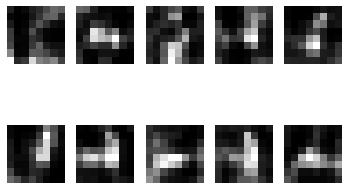

Batch 582/938 - Opimize G - Avg Batch Loss: 0.0696 - Time : 3.73s
Batch 583/938 - Opimize D - Avg Batch Loss: 0.0418 - Time : 4.05s
Batch 584/938 - Opimize G - Avg Batch Loss: -0.1215 - Time : 3.56s
Batch 585/938 - Opimize G - Avg Batch Loss: -0.0520 - Time : 3.96s
Batch 586/938 - Opimize G - Avg Batch Loss: 0.0461 - Time : 3.63s
Batch 587/938 - Opimize G - Avg Batch Loss: -0.0607 - Time : 3.63s
Batch 588/938 - Opimize G - Avg Batch Loss: 0.0183 - Time : 3.60s
Batch 589/938 - Opimize D - Avg Batch Loss: -0.0190 - Time : 3.60s
Batch 590/938 - Opimize G - Avg Batch Loss: -0.0291 - Time : 3.59s
Batch 591/938 - Opimize G - Avg Batch Loss: 0.0198 - Time : 3.86s
Batch 592/938 - Opimize G - Avg Batch Loss: 0.0585 - Time : 3.54s
Batch 593/938 - Opimize G - Avg Batch Loss: -0.0540 - Time : 3.59s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.0073 - Time : 3.60s
Batch 595/938 - Opimize D - Avg Batch Loss: -0.0014 - Time : 3.76s
Batch 596/938 - Opimize G - Avg Batch Loss: 0.0155 - Time : 3.82s
Bat

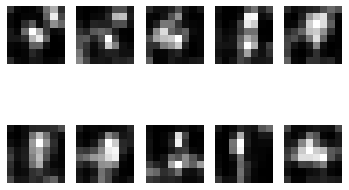

Batch 602/938 - Opimize G - Avg Batch Loss: 0.0462 - Time : 4.00s
Batch 603/938 - Opimize G - Avg Batch Loss: -0.0265 - Time : 3.57s
Batch 604/938 - Opimize G - Avg Batch Loss: -0.0727 - Time : 3.56s
Batch 605/938 - Opimize G - Avg Batch Loss: 0.0959 - Time : 3.58s
Batch 606/938 - Opimize G - Avg Batch Loss: 0.0243 - Time : 3.63s
Batch 607/938 - Opimize D - Avg Batch Loss: 0.0313 - Time : 3.76s
Batch 608/938 - Opimize G - Avg Batch Loss: 0.0681 - Time : 3.61s
Batch 609/938 - Opimize G - Avg Batch Loss: -0.0401 - Time : 3.54s
Batch 610/938 - Opimize G - Avg Batch Loss: 0.0432 - Time : 3.56s
Batch 611/938 - Opimize G - Avg Batch Loss: -0.0110 - Time : 3.90s
Batch 612/938 - Opimize G - Avg Batch Loss: 0.0420 - Time : 4.05s
Batch 613/938 - Opimize D - Avg Batch Loss: 0.0420 - Time : 3.64s
Batch 614/938 - Opimize G - Avg Batch Loss: -0.0312 - Time : 3.86s
Batch 615/938 - Opimize G - Avg Batch Loss: -0.0420 - Time : 3.78s
Batch 616/938 - Opimize G - Avg Batch Loss: -0.0020 - Time : 3.76s
Bat

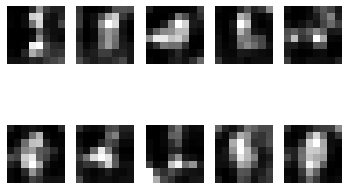

Batch 622/938 - Opimize G - Avg Batch Loss: -0.0078 - Time : 3.53s
Batch 623/938 - Opimize G - Avg Batch Loss: 0.0457 - Time : 3.77s
Batch 624/938 - Opimize G - Avg Batch Loss: 0.1143 - Time : 3.64s
Batch 625/938 - Opimize D - Avg Batch Loss: -0.0627 - Time : 3.61s
Batch 626/938 - Opimize G - Avg Batch Loss: -0.0250 - Time : 3.77s
Batch 627/938 - Opimize G - Avg Batch Loss: -0.1554 - Time : 3.59s
Batch 628/938 - Opimize G - Avg Batch Loss: 0.0672 - Time : 3.75s
Batch 629/938 - Opimize G - Avg Batch Loss: 0.0805 - Time : 3.63s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.0871 - Time : 3.64s
Batch 631/938 - Opimize D - Avg Batch Loss: -0.0280 - Time : 3.58s
Batch 632/938 - Opimize G - Avg Batch Loss: 0.0882 - Time : 3.64s
Batch 633/938 - Opimize G - Avg Batch Loss: 0.0137 - Time : 3.85s
Batch 634/938 - Opimize G - Avg Batch Loss: 0.0591 - Time : 3.65s
Batch 635/938 - Opimize G - Avg Batch Loss: 0.0547 - Time : 3.65s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.0216 - Time : 3.75s
Batch

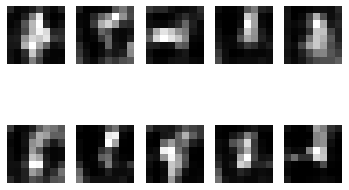

Batch 642/938 - Opimize G - Avg Batch Loss: 0.0707 - Time : 4.09s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.0575 - Time : 4.11s
Batch 644/938 - Opimize G - Avg Batch Loss: -0.0156 - Time : 3.68s
Batch 645/938 - Opimize G - Avg Batch Loss: 0.0101 - Time : 3.58s
Batch 646/938 - Opimize G - Avg Batch Loss: 0.0694 - Time : 3.61s
Batch 647/938 - Opimize G - Avg Batch Loss: 0.0317 - Time : 3.81s
Batch 648/938 - Opimize G - Avg Batch Loss: -0.0173 - Time : 3.59s
Batch 649/938 - Opimize D - Avg Batch Loss: 0.0407 - Time : 3.76s
Batch 650/938 - Opimize G - Avg Batch Loss: 0.0443 - Time : 3.63s
Batch 651/938 - Opimize G - Avg Batch Loss: 0.0534 - Time : 3.50s
Batch 652/938 - Opimize G - Avg Batch Loss: 0.0743 - Time : 3.52s
Batch 653/938 - Opimize G - Avg Batch Loss: 0.0247 - Time : 3.52s
Batch 654/938 - Opimize G - Avg Batch Loss: 0.0874 - Time : 3.53s
Batch 655/938 - Opimize D - Avg Batch Loss: 0.0279 - Time : 3.73s
Batch 656/938 - Opimize G - Avg Batch Loss: -0.0540 - Time : 3.92s
Batch 6

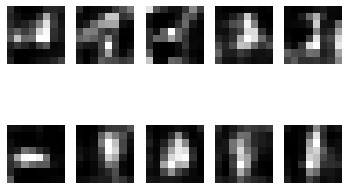

Batch 662/938 - Opimize G - Avg Batch Loss: 0.0690 - Time : 3.60s
Batch 663/938 - Opimize G - Avg Batch Loss: 0.0391 - Time : 3.75s
Batch 664/938 - Opimize G - Avg Batch Loss: -0.0303 - Time : 3.50s
Batch 665/938 - Opimize G - Avg Batch Loss: 0.1593 - Time : 3.75s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.0809 - Time : 3.69s
Batch 667/938 - Opimize D - Avg Batch Loss: -0.0787 - Time : 3.59s
Batch 668/938 - Opimize G - Avg Batch Loss: -0.0160 - Time : 3.60s
Batch 669/938 - Opimize G - Avg Batch Loss: 0.0301 - Time : 3.55s
Batch 670/938 - Opimize G - Avg Batch Loss: 0.0918 - Time : 4.01s
Batch 671/938 - Opimize G - Avg Batch Loss: -0.0049 - Time : 3.61s
Batch 672/938 - Opimize G - Avg Batch Loss: 0.0798 - Time : 3.54s
Batch 673/938 - Opimize D - Avg Batch Loss: -0.0014 - Time : 3.57s
Batch 674/938 - Opimize G - Avg Batch Loss: 0.0809 - Time : 3.91s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.1327 - Time : 3.54s
Batch 676/938 - Opimize G - Avg Batch Loss: -0.0029 - Time : 3.89s
Batc

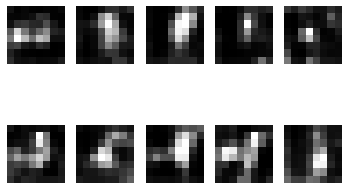

Batch 682/938 - Opimize G - Avg Batch Loss: -0.0414 - Time : 3.83s
Batch 683/938 - Opimize G - Avg Batch Loss: 0.0945 - Time : 3.57s
Batch 684/938 - Opimize G - Avg Batch Loss: -0.0616 - Time : 3.82s
Batch 685/938 - Opimize D - Avg Batch Loss: -0.0168 - Time : 3.55s
Batch 686/938 - Opimize G - Avg Batch Loss: -0.0071 - Time : 3.78s
Batch 687/938 - Opimize G - Avg Batch Loss: 0.0555 - Time : 3.88s
Batch 688/938 - Opimize G - Avg Batch Loss: 0.0152 - Time : 3.93s
Batch 689/938 - Opimize G - Avg Batch Loss: -0.0286 - Time : 3.76s
Batch 690/938 - Opimize G - Avg Batch Loss: -0.0113 - Time : 3.60s
Batch 691/938 - Opimize D - Avg Batch Loss: -0.0562 - Time : 3.70s
Batch 692/938 - Opimize G - Avg Batch Loss: 0.0826 - Time : 3.76s
Batch 693/938 - Opimize G - Avg Batch Loss: 0.0527 - Time : 3.75s
Batch 694/938 - Opimize G - Avg Batch Loss: 0.0298 - Time : 3.91s
Batch 695/938 - Opimize G - Avg Batch Loss: -0.0172 - Time : 3.57s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.0186 - Time : 3.78s
Ba

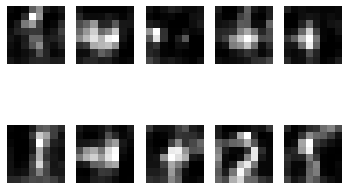

Batch 702/938 - Opimize G - Avg Batch Loss: -0.0347 - Time : 3.64s
Batch 703/938 - Opimize D - Avg Batch Loss: 0.0386 - Time : 3.81s
Batch 704/938 - Opimize G - Avg Batch Loss: -0.0346 - Time : 3.83s
Batch 705/938 - Opimize G - Avg Batch Loss: -0.0011 - Time : 3.99s
Batch 706/938 - Opimize G - Avg Batch Loss: 0.0654 - Time : 3.55s
Batch 707/938 - Opimize G - Avg Batch Loss: 0.0162 - Time : 3.84s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.0051 - Time : 3.71s
Batch 709/938 - Opimize D - Avg Batch Loss: 0.0334 - Time : 3.80s
Batch 710/938 - Opimize G - Avg Batch Loss: 0.0320 - Time : 3.51s
Batch 711/938 - Opimize G - Avg Batch Loss: -0.0022 - Time : 3.58s
Batch 712/938 - Opimize G - Avg Batch Loss: 0.0166 - Time : 3.93s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.0869 - Time : 3.56s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.0028 - Time : 3.65s
Batch 715/938 - Opimize D - Avg Batch Loss: -0.0628 - Time : 3.55s
Batch 716/938 - Opimize G - Avg Batch Loss: 0.0571 - Time : 3.71s
Batch

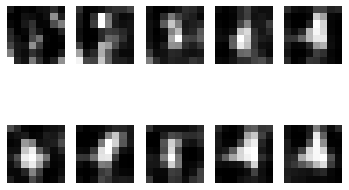

Batch 722/938 - Opimize G - Avg Batch Loss: -0.0404 - Time : 3.78s
Batch 723/938 - Opimize G - Avg Batch Loss: -0.0115 - Time : 3.63s
Batch 724/938 - Opimize G - Avg Batch Loss: 0.1084 - Time : 3.79s
Batch 725/938 - Opimize G - Avg Batch Loss: 0.1348 - Time : 3.76s
Batch 726/938 - Opimize G - Avg Batch Loss: -0.0018 - Time : 3.56s
Batch 727/938 - Opimize D - Avg Batch Loss: 0.0841 - Time : 3.61s
Batch 728/938 - Opimize G - Avg Batch Loss: 0.0396 - Time : 3.59s
Batch 729/938 - Opimize G - Avg Batch Loss: 0.0836 - Time : 3.56s
Batch 730/938 - Opimize G - Avg Batch Loss: 0.0241 - Time : 3.83s
Batch 731/938 - Opimize G - Avg Batch Loss: 0.0124 - Time : 3.82s
Batch 732/938 - Opimize G - Avg Batch Loss: -0.0064 - Time : 3.89s
Batch 733/938 - Opimize D - Avg Batch Loss: -0.0458 - Time : 3.90s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.0152 - Time : 3.80s
Batch 735/938 - Opimize G - Avg Batch Loss: -0.0481 - Time : 3.57s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.0771 - Time : 3.68s
Batc

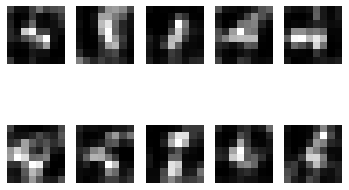

Batch 742/938 - Opimize G - Avg Batch Loss: -0.0122 - Time : 3.75s
Batch 743/938 - Opimize G - Avg Batch Loss: 0.1028 - Time : 3.60s
Batch 744/938 - Opimize G - Avg Batch Loss: -0.0019 - Time : 3.91s
Batch 745/938 - Opimize D - Avg Batch Loss: 0.1072 - Time : 3.84s
Batch 746/938 - Opimize G - Avg Batch Loss: 0.0687 - Time : 3.73s
Batch 747/938 - Opimize G - Avg Batch Loss: -0.1422 - Time : 3.56s
Batch 748/938 - Opimize G - Avg Batch Loss: -0.0241 - Time : 3.64s
Batch 749/938 - Opimize G - Avg Batch Loss: 0.0043 - Time : 3.62s
Batch 750/938 - Opimize G - Avg Batch Loss: 0.1047 - Time : 3.68s
Batch 751/938 - Opimize D - Avg Batch Loss: 0.0061 - Time : 3.61s
Batch 752/938 - Opimize G - Avg Batch Loss: 0.0471 - Time : 3.78s
Batch 753/938 - Opimize G - Avg Batch Loss: -0.0421 - Time : 4.04s
Batch 754/938 - Opimize G - Avg Batch Loss: 0.1094 - Time : 3.66s
Batch 755/938 - Opimize G - Avg Batch Loss: 0.0682 - Time : 3.81s
Batch 756/938 - Opimize G - Avg Batch Loss: 0.0444 - Time : 3.83s
Batch

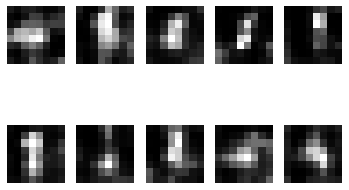

Batch 762/938 - Opimize G - Avg Batch Loss: -0.0112 - Time : 4.07s
Batch 763/938 - Opimize D - Avg Batch Loss: 0.1259 - Time : 3.57s
Batch 764/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.81s
Batch 765/938 - Opimize G - Avg Batch Loss: 0.0829 - Time : 3.63s
Batch 766/938 - Opimize G - Avg Batch Loss: 0.0858 - Time : 4.01s
Batch 767/938 - Opimize G - Avg Batch Loss: -0.0619 - Time : 3.84s
Batch 768/938 - Opimize G - Avg Batch Loss: -0.0303 - Time : 3.75s
Batch 769/938 - Opimize D - Avg Batch Loss: 0.0863 - Time : 3.80s
Batch 770/938 - Opimize G - Avg Batch Loss: -0.0308 - Time : 3.87s
Batch 771/938 - Opimize G - Avg Batch Loss: -0.0177 - Time : 3.67s
Batch 772/938 - Opimize G - Avg Batch Loss: -0.0080 - Time : 3.90s
Batch 773/938 - Opimize G - Avg Batch Loss: 0.0584 - Time : 3.94s
Batch 774/938 - Opimize G - Avg Batch Loss: -0.0215 - Time : 3.54s
Batch 775/938 - Opimize D - Avg Batch Loss: 0.0434 - Time : 4.11s
Batch 776/938 - Opimize G - Avg Batch Loss: 0.0574 - Time : 3.99s
Bat

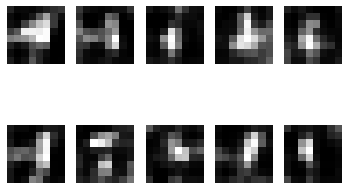

Batch 782/938 - Opimize G - Avg Batch Loss: 0.0404 - Time : 3.78s
Batch 783/938 - Opimize G - Avg Batch Loss: -0.0374 - Time : 4.17s
Batch 784/938 - Opimize G - Avg Batch Loss: 0.0878 - Time : 3.63s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.0557 - Time : 3.91s
Batch 786/938 - Opimize G - Avg Batch Loss: 0.0901 - Time : 3.72s
Batch 787/938 - Opimize D - Avg Batch Loss: -0.0171 - Time : 3.88s
Batch 788/938 - Opimize G - Avg Batch Loss: -0.0055 - Time : 3.58s
Batch 789/938 - Opimize G - Avg Batch Loss: -0.0135 - Time : 3.68s
Batch 790/938 - Opimize G - Avg Batch Loss: 0.1108 - Time : 3.63s
Batch 791/938 - Opimize G - Avg Batch Loss: 0.0600 - Time : 3.57s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.0267 - Time : 3.65s
Batch 793/938 - Opimize D - Avg Batch Loss: 0.0521 - Time : 3.72s
Batch 794/938 - Opimize G - Avg Batch Loss: 0.0584 - Time : 3.60s
Batch 795/938 - Opimize G - Avg Batch Loss: 0.0075 - Time : 3.60s
Batch 796/938 - Opimize G - Avg Batch Loss: 0.0842 - Time : 4.11s
Batch 

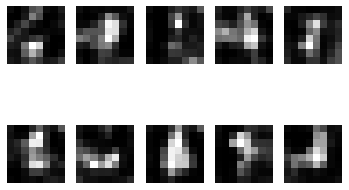

Batch 802/938 - Opimize G - Avg Batch Loss: -0.0344 - Time : 3.73s
Batch 803/938 - Opimize G - Avg Batch Loss: -0.0009 - Time : 4.10s
Batch 804/938 - Opimize G - Avg Batch Loss: 0.0646 - Time : 3.72s
Batch 805/938 - Opimize D - Avg Batch Loss: 0.1064 - Time : 3.74s
Batch 806/938 - Opimize G - Avg Batch Loss: -0.0047 - Time : 3.57s
Batch 807/938 - Opimize G - Avg Batch Loss: 0.0699 - Time : 3.61s
Batch 808/938 - Opimize G - Avg Batch Loss: 0.0545 - Time : 3.74s
Batch 809/938 - Opimize G - Avg Batch Loss: -0.0772 - Time : 3.77s
Batch 810/938 - Opimize G - Avg Batch Loss: -0.0789 - Time : 3.67s
Batch 811/938 - Opimize D - Avg Batch Loss: 0.0194 - Time : 3.65s
Batch 812/938 - Opimize G - Avg Batch Loss: 0.0486 - Time : 3.61s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.0590 - Time : 3.68s
Batch 814/938 - Opimize G - Avg Batch Loss: 0.0478 - Time : 3.72s
Batch 815/938 - Opimize G - Avg Batch Loss: 0.0641 - Time : 3.71s
Batch 816/938 - Opimize G - Avg Batch Loss: 0.0102 - Time : 3.62s
Batch

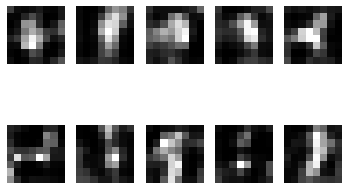

Batch 822/938 - Opimize G - Avg Batch Loss: 0.0600 - Time : 4.10s
Batch 823/938 - Opimize D - Avg Batch Loss: 0.0897 - Time : 3.70s
Batch 824/938 - Opimize G - Avg Batch Loss: -0.0589 - Time : 3.97s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.0707 - Time : 3.71s
Batch 826/938 - Opimize G - Avg Batch Loss: 0.0433 - Time : 3.86s
Batch 827/938 - Opimize G - Avg Batch Loss: -0.0869 - Time : 3.84s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.0415 - Time : 4.06s
Batch 829/938 - Opimize D - Avg Batch Loss: 0.1334 - Time : 3.78s
Batch 830/938 - Opimize G - Avg Batch Loss: 0.0029 - Time : 3.89s
Batch 831/938 - Opimize G - Avg Batch Loss: -0.0223 - Time : 3.92s
Batch 832/938 - Opimize G - Avg Batch Loss: 0.0124 - Time : 3.66s
Batch 833/938 - Opimize G - Avg Batch Loss: 0.0412 - Time : 3.69s
Batch 834/938 - Opimize G - Avg Batch Loss: -0.0485 - Time : 3.72s
Batch 835/938 - Opimize D - Avg Batch Loss: 0.0729 - Time : 3.87s
Batch 836/938 - Opimize G - Avg Batch Loss: -0.0309 - Time : 3.55s
Batch

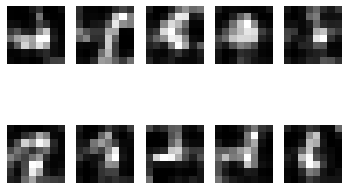

Batch 842/938 - Opimize G - Avg Batch Loss: 0.0002 - Time : 3.88s
Batch 843/938 - Opimize G - Avg Batch Loss: 0.0381 - Time : 3.73s
Batch 844/938 - Opimize G - Avg Batch Loss: 0.0560 - Time : 3.60s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.0765 - Time : 3.73s
Batch 846/938 - Opimize G - Avg Batch Loss: -0.0271 - Time : 3.81s
Batch 847/938 - Opimize D - Avg Batch Loss: 0.0300 - Time : 3.94s
Batch 848/938 - Opimize G - Avg Batch Loss: -0.0019 - Time : 3.60s
Batch 849/938 - Opimize G - Avg Batch Loss: -0.0238 - Time : 3.66s
Batch 850/938 - Opimize G - Avg Batch Loss: 0.0450 - Time : 3.64s
Batch 851/938 - Opimize G - Avg Batch Loss: 0.0419 - Time : 3.66s
Batch 852/938 - Opimize G - Avg Batch Loss: -0.0734 - Time : 3.60s
Batch 853/938 - Opimize D - Avg Batch Loss: 0.1395 - Time : 3.73s
Batch 854/938 - Opimize G - Avg Batch Loss: 0.0282 - Time : 4.55s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.0778 - Time : 3.78s
Batch 856/938 - Opimize G - Avg Batch Loss: 0.1077 - Time : 3.70s
Batch 

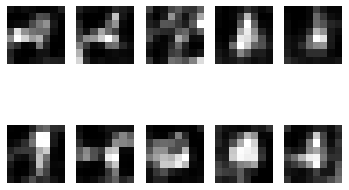

Batch 862/938 - Opimize G - Avg Batch Loss: 0.0820 - Time : 3.78s
Batch 863/938 - Opimize G - Avg Batch Loss: 0.0476 - Time : 3.74s
Batch 864/938 - Opimize G - Avg Batch Loss: 0.0679 - Time : 3.58s
Batch 865/938 - Opimize D - Avg Batch Loss: 0.0833 - Time : 3.58s
Batch 866/938 - Opimize G - Avg Batch Loss: -0.0121 - Time : 3.71s
Batch 867/938 - Opimize G - Avg Batch Loss: -0.0472 - Time : 3.84s
Batch 868/938 - Opimize G - Avg Batch Loss: 0.0294 - Time : 3.73s
Batch 869/938 - Opimize G - Avg Batch Loss: 0.1001 - Time : 3.72s
Batch 870/938 - Opimize G - Avg Batch Loss: -0.0018 - Time : 3.68s
Batch 871/938 - Opimize D - Avg Batch Loss: 0.0469 - Time : 3.65s
Batch 872/938 - Opimize G - Avg Batch Loss: -0.0253 - Time : 3.78s
Batch 873/938 - Opimize G - Avg Batch Loss: 0.0277 - Time : 3.79s
Batch 874/938 - Opimize G - Avg Batch Loss: -0.0297 - Time : 3.53s
Batch 875/938 - Opimize G - Avg Batch Loss: 0.0143 - Time : 3.82s
Batch 876/938 - Opimize G - Avg Batch Loss: -0.0405 - Time : 3.62s
Batc

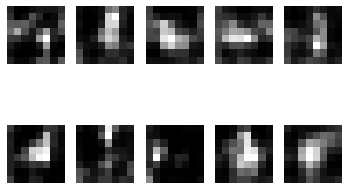

Batch 882/938 - Opimize G - Avg Batch Loss: -0.0343 - Time : 3.66s
Batch 883/938 - Opimize D - Avg Batch Loss: 0.0441 - Time : 4.03s
Batch 884/938 - Opimize G - Avg Batch Loss: 0.0090 - Time : 3.56s
Batch 885/938 - Opimize G - Avg Batch Loss: 0.0139 - Time : 3.60s
Batch 886/938 - Opimize G - Avg Batch Loss: 0.0050 - Time : 3.56s
Batch 887/938 - Opimize G - Avg Batch Loss: 0.0094 - Time : 3.97s
Batch 888/938 - Opimize G - Avg Batch Loss: -0.0145 - Time : 4.01s
Batch 889/938 - Opimize D - Avg Batch Loss: -0.0191 - Time : 3.70s
Batch 890/938 - Opimize G - Avg Batch Loss: -0.0361 - Time : 3.62s
Batch 891/938 - Opimize G - Avg Batch Loss: -0.0086 - Time : 3.61s
Batch 892/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.87s
Batch 893/938 - Opimize G - Avg Batch Loss: 0.1176 - Time : 3.59s
Batch 894/938 - Opimize G - Avg Batch Loss: -0.0346 - Time : 3.96s
Batch 895/938 - Opimize D - Avg Batch Loss: 0.0119 - Time : 3.73s
Batch 896/938 - Opimize G - Avg Batch Loss: -0.0006 - Time : 3.72s
Bat

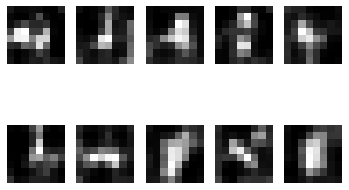

Batch 902/938 - Opimize G - Avg Batch Loss: -0.0033 - Time : 3.93s
Batch 903/938 - Opimize G - Avg Batch Loss: -0.0662 - Time : 3.70s
Batch 904/938 - Opimize G - Avg Batch Loss: 0.0251 - Time : 3.92s
Batch 905/938 - Opimize G - Avg Batch Loss: -0.0283 - Time : 3.59s
Batch 906/938 - Opimize G - Avg Batch Loss: 0.0296 - Time : 4.07s
Batch 907/938 - Opimize D - Avg Batch Loss: -0.0414 - Time : 3.81s
Batch 908/938 - Opimize G - Avg Batch Loss: 0.0378 - Time : 3.79s
Batch 909/938 - Opimize G - Avg Batch Loss: 0.0295 - Time : 4.14s
Batch 910/938 - Opimize G - Avg Batch Loss: 0.0407 - Time : 4.13s
Batch 911/938 - Opimize G - Avg Batch Loss: 0.0035 - Time : 3.78s
Batch 912/938 - Opimize G - Avg Batch Loss: 0.0042 - Time : 3.67s
Batch 913/938 - Opimize D - Avg Batch Loss: 0.0785 - Time : 3.88s
Batch 914/938 - Opimize G - Avg Batch Loss: -0.0044 - Time : 3.82s
Batch 915/938 - Opimize G - Avg Batch Loss: 0.0537 - Time : 3.74s
Batch 916/938 - Opimize G - Avg Batch Loss: 0.0204 - Time : 3.84s
Batch

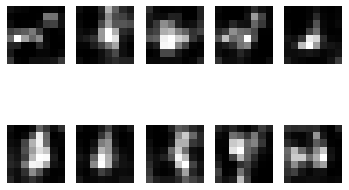

Batch 922/938 - Opimize G - Avg Batch Loss: 0.0517 - Time : 3.67s
Batch 923/938 - Opimize G - Avg Batch Loss: 0.0064 - Time : 3.63s
Batch 924/938 - Opimize G - Avg Batch Loss: -0.0320 - Time : 3.67s
Batch 925/938 - Opimize D - Avg Batch Loss: -0.0746 - Time : 3.61s
Batch 926/938 - Opimize G - Avg Batch Loss: -0.0229 - Time : 3.78s
Batch 927/938 - Opimize G - Avg Batch Loss: 0.0260 - Time : 3.56s
Batch 928/938 - Opimize G - Avg Batch Loss: 0.0590 - Time : 3.59s
Batch 929/938 - Opimize G - Avg Batch Loss: 0.0757 - Time : 3.67s
Batch 930/938 - Opimize G - Avg Batch Loss: -0.0318 - Time : 3.63s
Batch 931/938 - Opimize D - Avg Batch Loss: 0.0235 - Time : 3.61s
Batch 932/938 - Opimize G - Avg Batch Loss: -0.0441 - Time : 3.70s
Batch 933/938 - Opimize G - Avg Batch Loss: -0.0263 - Time : 3.54s
Batch 934/938 - Opimize G - Avg Batch Loss: 0.0038 - Time : 3.60s
Batch 935/938 - Opimize G - Avg Batch Loss: -0.0663 - Time : 3.60s
Batch 936/938 - Opimize G - Avg Batch Loss: 0.0121 - Time : 3.86s
Bat

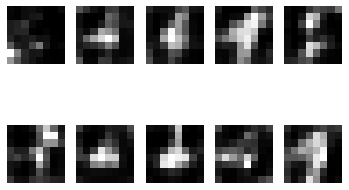

Batch 2/938 - Opimize G - Avg Batch Loss: -0.0600 - Time : 3.75s
Batch 3/938 - Opimize G - Avg Batch Loss: -0.0284 - Time : 3.70s
Batch 4/938 - Opimize G - Avg Batch Loss: 0.0189 - Time : 3.69s
Batch 5/938 - Opimize G - Avg Batch Loss: 0.0948 - Time : 3.61s
Batch 6/938 - Opimize G - Avg Batch Loss: 0.0157 - Time : 3.82s
Batch 7/938 - Opimize D - Avg Batch Loss: 0.0212 - Time : 3.86s
Batch 8/938 - Opimize G - Avg Batch Loss: 0.0682 - Time : 3.89s
Batch 9/938 - Opimize G - Avg Batch Loss: 0.0079 - Time : 3.78s
Batch 10/938 - Opimize G - Avg Batch Loss: 0.0901 - Time : 4.29s
Batch 11/938 - Opimize G - Avg Batch Loss: -0.0453 - Time : 3.56s
Batch 12/938 - Opimize G - Avg Batch Loss: -0.0089 - Time : 3.60s
Batch 13/938 - Opimize D - Avg Batch Loss: 0.0955 - Time : 3.58s
Batch 14/938 - Opimize G - Avg Batch Loss: -0.0162 - Time : 3.84s
Batch 15/938 - Opimize G - Avg Batch Loss: -0.0551 - Time : 3.92s
Batch 16/938 - Opimize G - Avg Batch Loss: 0.0307 - Time : 3.58s
Batch 17/938 - Opimize G - 

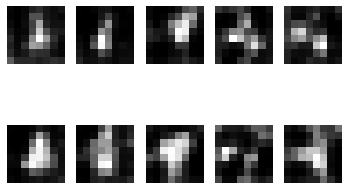

Batch 22/938 - Opimize G - Avg Batch Loss: 0.0987 - Time : 3.67s
Batch 23/938 - Opimize G - Avg Batch Loss: 0.0462 - Time : 3.64s
Batch 24/938 - Opimize G - Avg Batch Loss: 0.1187 - Time : 3.97s
Batch 25/938 - Opimize D - Avg Batch Loss: 0.0042 - Time : 3.59s
Batch 26/938 - Opimize G - Avg Batch Loss: 0.0067 - Time : 3.56s
Batch 27/938 - Opimize G - Avg Batch Loss: 0.0918 - Time : 3.58s
Batch 28/938 - Opimize G - Avg Batch Loss: 0.0006 - Time : 3.58s
Batch 29/938 - Opimize G - Avg Batch Loss: -0.0658 - Time : 3.73s
Batch 30/938 - Opimize G - Avg Batch Loss: -0.0371 - Time : 3.57s
Batch 31/938 - Opimize D - Avg Batch Loss: -0.1351 - Time : 3.83s
Batch 32/938 - Opimize G - Avg Batch Loss: 0.0046 - Time : 3.75s
Batch 33/938 - Opimize G - Avg Batch Loss: -0.0040 - Time : 3.63s
Batch 34/938 - Opimize G - Avg Batch Loss: 0.0246 - Time : 3.81s
Batch 35/938 - Opimize G - Avg Batch Loss: 0.2357 - Time : 3.70s
Batch 36/938 - Opimize G - Avg Batch Loss: 0.0509 - Time : 3.67s
Batch 37/938 - Opimiz

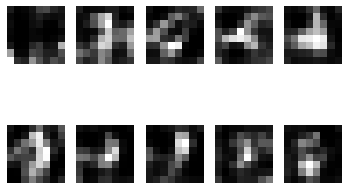

Batch 42/938 - Opimize G - Avg Batch Loss: -0.0536 - Time : 3.91s
Batch 43/938 - Opimize D - Avg Batch Loss: -0.0546 - Time : 3.70s
Batch 44/938 - Opimize G - Avg Batch Loss: -0.0656 - Time : 3.58s
Batch 45/938 - Opimize G - Avg Batch Loss: 0.0612 - Time : 3.59s
Batch 46/938 - Opimize G - Avg Batch Loss: 0.0171 - Time : 3.62s
Batch 47/938 - Opimize G - Avg Batch Loss: -0.0380 - Time : 3.85s
Batch 48/938 - Opimize G - Avg Batch Loss: -0.0295 - Time : 3.70s
Batch 49/938 - Opimize D - Avg Batch Loss: 0.0632 - Time : 3.79s
Batch 50/938 - Opimize G - Avg Batch Loss: -0.0442 - Time : 3.60s
Batch 51/938 - Opimize G - Avg Batch Loss: 0.0417 - Time : 3.74s
Batch 52/938 - Opimize G - Avg Batch Loss: 0.0275 - Time : 4.04s
Batch 53/938 - Opimize G - Avg Batch Loss: 0.0212 - Time : 3.74s
Batch 54/938 - Opimize G - Avg Batch Loss: -0.0025 - Time : 3.89s
Batch 55/938 - Opimize D - Avg Batch Loss: 0.0611 - Time : 3.58s
Batch 56/938 - Opimize G - Avg Batch Loss: -0.0818 - Time : 3.83s
Batch 57/938 - Op

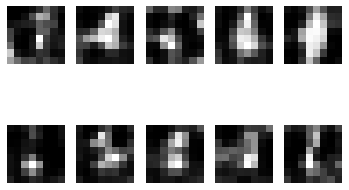

Batch 62/938 - Opimize G - Avg Batch Loss: 0.0145 - Time : 3.72s
Batch 63/938 - Opimize G - Avg Batch Loss: 0.0073 - Time : 4.00s
Batch 64/938 - Opimize G - Avg Batch Loss: -0.0294 - Time : 3.63s
Batch 65/938 - Opimize G - Avg Batch Loss: 0.0519 - Time : 3.56s
Batch 66/938 - Opimize G - Avg Batch Loss: -0.0757 - Time : 3.92s
Batch 67/938 - Opimize D - Avg Batch Loss: -0.1352 - Time : 3.78s
Batch 68/938 - Opimize G - Avg Batch Loss: 0.0801 - Time : 3.68s
Batch 69/938 - Opimize G - Avg Batch Loss: 0.0148 - Time : 3.96s
Batch 70/938 - Opimize G - Avg Batch Loss: 0.0610 - Time : 3.72s
Batch 71/938 - Opimize G - Avg Batch Loss: 0.0211 - Time : 3.58s
Batch 72/938 - Opimize G - Avg Batch Loss: 0.0200 - Time : 3.57s
Batch 73/938 - Opimize D - Avg Batch Loss: 0.0085 - Time : 3.77s
Batch 74/938 - Opimize G - Avg Batch Loss: -0.0196 - Time : 3.75s
Batch 75/938 - Opimize G - Avg Batch Loss: -0.0447 - Time : 3.56s
Batch 76/938 - Opimize G - Avg Batch Loss: 0.1081 - Time : 3.64s
Batch 77/938 - Opimi

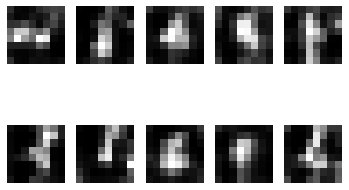

Batch 82/938 - Opimize G - Avg Batch Loss: -0.1052 - Time : 3.80s
Batch 83/938 - Opimize G - Avg Batch Loss: 0.1387 - Time : 3.66s
Batch 84/938 - Opimize G - Avg Batch Loss: 0.0046 - Time : 3.74s
Batch 85/938 - Opimize D - Avg Batch Loss: -0.0817 - Time : 3.76s
Batch 86/938 - Opimize G - Avg Batch Loss: -0.0360 - Time : 4.01s
Batch 87/938 - Opimize G - Avg Batch Loss: 0.0107 - Time : 3.78s
Batch 88/938 - Opimize G - Avg Batch Loss: -0.0240 - Time : 3.75s
Batch 89/938 - Opimize G - Avg Batch Loss: 0.0383 - Time : 3.84s
Batch 90/938 - Opimize G - Avg Batch Loss: -0.0790 - Time : 3.58s
Batch 91/938 - Opimize D - Avg Batch Loss: -0.0169 - Time : 3.57s
Batch 92/938 - Opimize G - Avg Batch Loss: -0.0015 - Time : 3.52s
Batch 93/938 - Opimize G - Avg Batch Loss: 0.0340 - Time : 3.54s
Batch 94/938 - Opimize G - Avg Batch Loss: 0.0787 - Time : 3.51s
Batch 95/938 - Opimize G - Avg Batch Loss: 0.0618 - Time : 3.77s
Batch 96/938 - Opimize G - Avg Batch Loss: 0.0134 - Time : 3.72s
Batch 97/938 - Opi

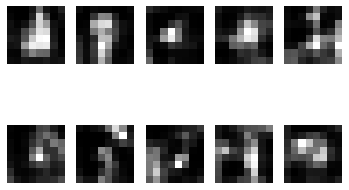

Batch 102/938 - Opimize G - Avg Batch Loss: 0.0185 - Time : 3.81s
Batch 103/938 - Opimize D - Avg Batch Loss: 0.0764 - Time : 3.69s
Batch 104/938 - Opimize G - Avg Batch Loss: 0.0256 - Time : 3.76s
Batch 105/938 - Opimize G - Avg Batch Loss: -0.0396 - Time : 3.78s
Batch 106/938 - Opimize G - Avg Batch Loss: 0.0131 - Time : 4.04s
Batch 107/938 - Opimize G - Avg Batch Loss: 0.0599 - Time : 3.83s
Batch 108/938 - Opimize G - Avg Batch Loss: -0.0231 - Time : 3.53s
Batch 109/938 - Opimize D - Avg Batch Loss: -0.0027 - Time : 3.85s
Batch 110/938 - Opimize G - Avg Batch Loss: 0.1160 - Time : 3.71s
Batch 111/938 - Opimize G - Avg Batch Loss: 0.0499 - Time : 3.88s
Batch 112/938 - Opimize G - Avg Batch Loss: 0.0270 - Time : 3.71s
Batch 113/938 - Opimize G - Avg Batch Loss: -0.0004 - Time : 3.74s
Batch 114/938 - Opimize G - Avg Batch Loss: 0.0257 - Time : 3.73s
Batch 115/938 - Opimize D - Avg Batch Loss: 0.1994 - Time : 3.58s
Batch 116/938 - Opimize G - Avg Batch Loss: 0.0111 - Time : 3.65s
Batch 

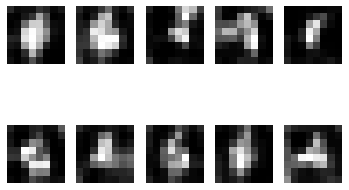

Batch 122/938 - Opimize G - Avg Batch Loss: 0.0784 - Time : 3.75s
Batch 123/938 - Opimize G - Avg Batch Loss: -0.0598 - Time : 3.72s
Batch 124/938 - Opimize G - Avg Batch Loss: 0.0763 - Time : 3.63s
Batch 125/938 - Opimize G - Avg Batch Loss: 0.1095 - Time : 3.60s
Batch 126/938 - Opimize G - Avg Batch Loss: -0.0207 - Time : 3.74s
Batch 127/938 - Opimize D - Avg Batch Loss: -0.0829 - Time : 3.85s
Batch 128/938 - Opimize G - Avg Batch Loss: 0.0059 - Time : 3.74s
Batch 129/938 - Opimize G - Avg Batch Loss: 0.0462 - Time : 3.72s
Batch 130/938 - Opimize G - Avg Batch Loss: 0.0651 - Time : 3.73s
Batch 131/938 - Opimize G - Avg Batch Loss: 0.0997 - Time : 3.90s
Batch 132/938 - Opimize G - Avg Batch Loss: 0.0723 - Time : 3.71s
Batch 133/938 - Opimize D - Avg Batch Loss: -0.0188 - Time : 3.59s
Batch 134/938 - Opimize G - Avg Batch Loss: -0.0417 - Time : 3.77s
Batch 135/938 - Opimize G - Avg Batch Loss: 0.0750 - Time : 3.58s
Batch 136/938 - Opimize G - Avg Batch Loss: -0.0387 - Time : 3.94s
Batc

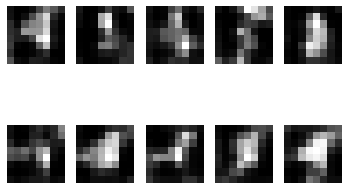

Batch 142/938 - Opimize G - Avg Batch Loss: 0.0368 - Time : 4.09s
Batch 143/938 - Opimize G - Avg Batch Loss: 0.0404 - Time : 4.00s
Batch 144/938 - Opimize G - Avg Batch Loss: 0.0101 - Time : 3.57s
Batch 145/938 - Opimize D - Avg Batch Loss: -0.0370 - Time : 3.75s
Batch 146/938 - Opimize G - Avg Batch Loss: 0.0393 - Time : 3.68s
Batch 147/938 - Opimize G - Avg Batch Loss: 0.0342 - Time : 4.18s
Batch 148/938 - Opimize G - Avg Batch Loss: -0.0756 - Time : 3.83s
Batch 149/938 - Opimize G - Avg Batch Loss: -0.0263 - Time : 3.86s
Batch 150/938 - Opimize G - Avg Batch Loss: -0.0193 - Time : 4.13s
Batch 151/938 - Opimize D - Avg Batch Loss: -0.0502 - Time : 3.60s
Batch 152/938 - Opimize G - Avg Batch Loss: 0.1206 - Time : 3.96s
Batch 153/938 - Opimize G - Avg Batch Loss: 0.0362 - Time : 3.90s
Batch 154/938 - Opimize G - Avg Batch Loss: 0.0164 - Time : 3.75s
Batch 155/938 - Opimize G - Avg Batch Loss: 0.0053 - Time : 3.89s
Batch 156/938 - Opimize G - Avg Batch Loss: 0.0186 - Time : 4.07s
Batch

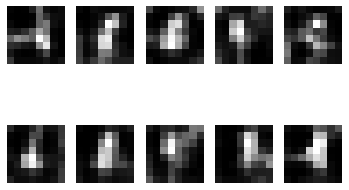

Batch 162/938 - Opimize G - Avg Batch Loss: 0.0083 - Time : 3.75s
Batch 163/938 - Opimize D - Avg Batch Loss: 0.1028 - Time : 3.68s
Batch 164/938 - Opimize G - Avg Batch Loss: 0.0547 - Time : 3.71s
Batch 165/938 - Opimize G - Avg Batch Loss: 0.0290 - Time : 3.63s
Batch 166/938 - Opimize G - Avg Batch Loss: 0.1046 - Time : 3.92s
Batch 167/938 - Opimize G - Avg Batch Loss: 0.0735 - Time : 3.59s
Batch 168/938 - Opimize G - Avg Batch Loss: -0.0945 - Time : 3.61s
Batch 169/938 - Opimize D - Avg Batch Loss: 0.0364 - Time : 3.85s
Batch 170/938 - Opimize G - Avg Batch Loss: -0.0463 - Time : 3.67s
Batch 171/938 - Opimize G - Avg Batch Loss: 0.0561 - Time : 3.62s
Batch 172/938 - Opimize G - Avg Batch Loss: 0.0543 - Time : 3.63s
Batch 173/938 - Opimize G - Avg Batch Loss: 0.0275 - Time : 3.80s
Batch 174/938 - Opimize G - Avg Batch Loss: 0.0527 - Time : 3.60s
Batch 175/938 - Opimize D - Avg Batch Loss: 0.0343 - Time : 3.63s
Batch 176/938 - Opimize G - Avg Batch Loss: 0.0849 - Time : 3.63s
Batch 17

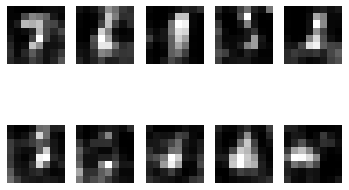

Batch 182/938 - Opimize G - Avg Batch Loss: -0.0557 - Time : 4.02s
Batch 183/938 - Opimize G - Avg Batch Loss: 0.1164 - Time : 3.63s
Batch 184/938 - Opimize G - Avg Batch Loss: 0.0029 - Time : 3.67s
Batch 185/938 - Opimize G - Avg Batch Loss: 0.0843 - Time : 3.76s
Batch 186/938 - Opimize G - Avg Batch Loss: 0.0431 - Time : 3.67s
Batch 187/938 - Opimize D - Avg Batch Loss: -0.0112 - Time : 3.54s
Batch 188/938 - Opimize G - Avg Batch Loss: -0.0266 - Time : 3.53s
Batch 189/938 - Opimize G - Avg Batch Loss: -0.0013 - Time : 3.57s
Batch 190/938 - Opimize G - Avg Batch Loss: 0.0017 - Time : 3.61s
Batch 191/938 - Opimize G - Avg Batch Loss: -0.0200 - Time : 3.70s
Batch 192/938 - Opimize G - Avg Batch Loss: 0.1220 - Time : 3.61s
Batch 193/938 - Opimize D - Avg Batch Loss: -0.0170 - Time : 3.71s
Batch 194/938 - Opimize G - Avg Batch Loss: 0.0617 - Time : 3.86s
Batch 195/938 - Opimize G - Avg Batch Loss: -0.0445 - Time : 3.81s
Batch 196/938 - Opimize G - Avg Batch Loss: -0.0151 - Time : 4.11s
Ba

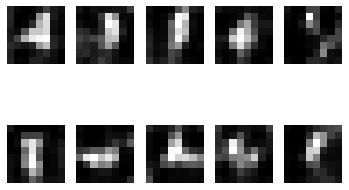

Batch 202/938 - Opimize G - Avg Batch Loss: 0.0377 - Time : 3.76s
Batch 203/938 - Opimize G - Avg Batch Loss: 0.0331 - Time : 3.64s
Batch 204/938 - Opimize G - Avg Batch Loss: 0.0498 - Time : 3.64s
Batch 205/938 - Opimize D - Avg Batch Loss: 0.0414 - Time : 3.82s
Batch 206/938 - Opimize G - Avg Batch Loss: 0.0667 - Time : 4.08s
Batch 207/938 - Opimize G - Avg Batch Loss: 0.0014 - Time : 3.61s
Batch 208/938 - Opimize G - Avg Batch Loss: 0.0378 - Time : 3.96s
Batch 209/938 - Opimize G - Avg Batch Loss: -0.0161 - Time : 3.81s
Batch 210/938 - Opimize G - Avg Batch Loss: -0.0639 - Time : 3.62s
Batch 211/938 - Opimize D - Avg Batch Loss: 0.0438 - Time : 3.77s
Batch 212/938 - Opimize G - Avg Batch Loss: -0.0264 - Time : 3.71s
Batch 213/938 - Opimize G - Avg Batch Loss: -0.0308 - Time : 3.71s
Batch 214/938 - Opimize G - Avg Batch Loss: 0.0805 - Time : 3.62s
Batch 215/938 - Opimize G - Avg Batch Loss: 0.0144 - Time : 3.78s
Batch 216/938 - Opimize G - Avg Batch Loss: -0.0005 - Time : 3.55s
Batch

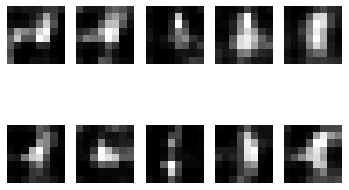

Batch 222/938 - Opimize G - Avg Batch Loss: -0.0368 - Time : 3.91s
Batch 223/938 - Opimize D - Avg Batch Loss: 0.1187 - Time : 3.69s
Batch 224/938 - Opimize G - Avg Batch Loss: 0.0188 - Time : 3.64s
Batch 225/938 - Opimize G - Avg Batch Loss: -0.0318 - Time : 3.78s
Batch 226/938 - Opimize G - Avg Batch Loss: 0.0143 - Time : 3.65s
Batch 227/938 - Opimize G - Avg Batch Loss: 0.0382 - Time : 3.60s
Batch 228/938 - Opimize G - Avg Batch Loss: -0.0426 - Time : 3.95s
Batch 229/938 - Opimize D - Avg Batch Loss: -0.0195 - Time : 3.69s
Batch 230/938 - Opimize G - Avg Batch Loss: 0.0806 - Time : 3.60s
Batch 231/938 - Opimize G - Avg Batch Loss: 0.0333 - Time : 3.72s
Batch 232/938 - Opimize G - Avg Batch Loss: -0.0804 - Time : 3.56s
Batch 233/938 - Opimize G - Avg Batch Loss: 0.0600 - Time : 4.00s
Batch 234/938 - Opimize G - Avg Batch Loss: -0.0598 - Time : 3.65s
Batch 235/938 - Opimize D - Avg Batch Loss: 0.0440 - Time : 3.81s
Batch 236/938 - Opimize G - Avg Batch Loss: 0.0055 - Time : 3.62s
Batc

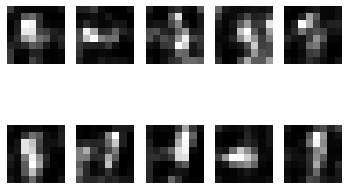

Batch 242/938 - Opimize G - Avg Batch Loss: 0.0498 - Time : 3.59s
Batch 243/938 - Opimize G - Avg Batch Loss: 0.0559 - Time : 3.60s
Batch 244/938 - Opimize G - Avg Batch Loss: 0.0288 - Time : 3.98s
Batch 245/938 - Opimize G - Avg Batch Loss: 0.0286 - Time : 3.93s
Batch 246/938 - Opimize G - Avg Batch Loss: 0.0095 - Time : 3.61s
Batch 247/938 - Opimize D - Avg Batch Loss: 0.0010 - Time : 3.68s
Batch 248/938 - Opimize G - Avg Batch Loss: 0.0143 - Time : 3.95s
Batch 249/938 - Opimize G - Avg Batch Loss: -0.0050 - Time : 3.68s
Batch 250/938 - Opimize G - Avg Batch Loss: 0.0316 - Time : 3.56s
Batch 251/938 - Opimize G - Avg Batch Loss: -0.0608 - Time : 3.60s
Batch 252/938 - Opimize G - Avg Batch Loss: -0.0405 - Time : 3.51s
Batch 253/938 - Opimize D - Avg Batch Loss: 0.0479 - Time : 3.56s
Batch 254/938 - Opimize G - Avg Batch Loss: 0.0140 - Time : 3.72s
Batch 255/938 - Opimize G - Avg Batch Loss: 0.0771 - Time : 3.65s
Batch 256/938 - Opimize G - Avg Batch Loss: 0.0832 - Time : 3.84s
Batch 2

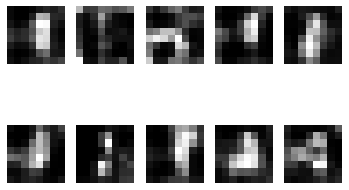

Batch 262/938 - Opimize G - Avg Batch Loss: 0.0696 - Time : 3.94s
Batch 263/938 - Opimize G - Avg Batch Loss: 0.0497 - Time : 3.69s
Batch 264/938 - Opimize G - Avg Batch Loss: -0.0102 - Time : 3.53s
Batch 265/938 - Opimize D - Avg Batch Loss: -0.0263 - Time : 3.69s
Batch 266/938 - Opimize G - Avg Batch Loss: 0.0097 - Time : 3.75s
Batch 267/938 - Opimize G - Avg Batch Loss: -0.0294 - Time : 3.56s
Batch 268/938 - Opimize G - Avg Batch Loss: 0.0281 - Time : 3.81s
Batch 269/938 - Opimize G - Avg Batch Loss: -0.0394 - Time : 3.90s
Batch 270/938 - Opimize G - Avg Batch Loss: 0.0208 - Time : 3.66s
Batch 271/938 - Opimize D - Avg Batch Loss: -0.0212 - Time : 3.98s
Batch 272/938 - Opimize G - Avg Batch Loss: 0.0754 - Time : 3.91s
Batch 273/938 - Opimize G - Avg Batch Loss: 0.0586 - Time : 3.58s
Batch 274/938 - Opimize G - Avg Batch Loss: -0.0539 - Time : 3.58s
Batch 275/938 - Opimize G - Avg Batch Loss: 0.0484 - Time : 3.67s
Batch 276/938 - Opimize G - Avg Batch Loss: 0.0159 - Time : 3.97s
Batc

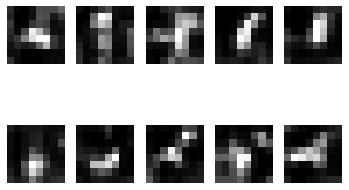

Batch 282/938 - Opimize G - Avg Batch Loss: -0.0056 - Time : 3.60s
Batch 283/938 - Opimize D - Avg Batch Loss: -0.0533 - Time : 3.62s
Batch 284/938 - Opimize G - Avg Batch Loss: -0.0803 - Time : 3.89s
Batch 285/938 - Opimize G - Avg Batch Loss: -0.0346 - Time : 3.92s
Batch 286/938 - Opimize G - Avg Batch Loss: 0.0233 - Time : 3.75s
Batch 287/938 - Opimize G - Avg Batch Loss: 0.0114 - Time : 3.81s
Batch 288/938 - Opimize G - Avg Batch Loss: 0.0067 - Time : 3.71s
Batch 289/938 - Opimize D - Avg Batch Loss: -0.0770 - Time : 4.10s
Batch 290/938 - Opimize G - Avg Batch Loss: -0.0102 - Time : 3.87s
Batch 291/938 - Opimize G - Avg Batch Loss: 0.0644 - Time : 4.02s
Batch 292/938 - Opimize G - Avg Batch Loss: -0.0264 - Time : 3.83s
Batch 293/938 - Opimize G - Avg Batch Loss: -0.0006 - Time : 4.04s
Batch 294/938 - Opimize G - Avg Batch Loss: -0.0557 - Time : 3.58s
Batch 295/938 - Opimize D - Avg Batch Loss: 0.0046 - Time : 3.75s
Batch 296/938 - Opimize G - Avg Batch Loss: 0.0863 - Time : 3.60s
B

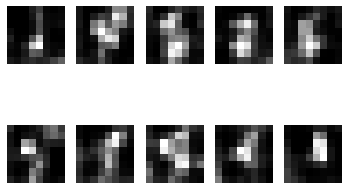

Batch 302/938 - Opimize G - Avg Batch Loss: -0.0350 - Time : 4.05s
Batch 303/938 - Opimize G - Avg Batch Loss: 0.0175 - Time : 3.60s
Batch 304/938 - Opimize G - Avg Batch Loss: 0.0120 - Time : 3.74s
Batch 305/938 - Opimize G - Avg Batch Loss: 0.0045 - Time : 3.87s
Batch 306/938 - Opimize G - Avg Batch Loss: 0.0040 - Time : 3.65s
Batch 307/938 - Opimize D - Avg Batch Loss: 0.0885 - Time : 3.72s
Batch 308/938 - Opimize G - Avg Batch Loss: -0.0149 - Time : 3.69s
Batch 309/938 - Opimize G - Avg Batch Loss: -0.0786 - Time : 3.76s
Batch 310/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.79s
Batch 311/938 - Opimize G - Avg Batch Loss: 0.0614 - Time : 3.87s
Batch 312/938 - Opimize G - Avg Batch Loss: 0.0483 - Time : 3.79s
Batch 313/938 - Opimize D - Avg Batch Loss: -0.0299 - Time : 4.21s
Batch 314/938 - Opimize G - Avg Batch Loss: -0.0613 - Time : 4.05s
Batch 315/938 - Opimize G - Avg Batch Loss: 0.0416 - Time : 3.61s
Batch 316/938 - Opimize G - Avg Batch Loss: 0.0039 - Time : 3.67s
Batch

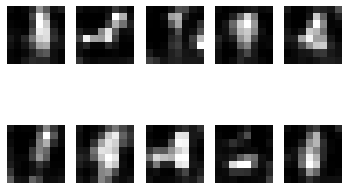

Batch 322/938 - Opimize G - Avg Batch Loss: -0.0063 - Time : 3.63s
Batch 323/938 - Opimize G - Avg Batch Loss: 0.0312 - Time : 3.79s
Batch 324/938 - Opimize G - Avg Batch Loss: 0.0553 - Time : 3.71s
Batch 325/938 - Opimize D - Avg Batch Loss: -0.0037 - Time : 3.54s
Batch 326/938 - Opimize G - Avg Batch Loss: -0.0383 - Time : 3.90s
Batch 327/938 - Opimize G - Avg Batch Loss: 0.0285 - Time : 4.11s
Batch 328/938 - Opimize G - Avg Batch Loss: -0.0596 - Time : 3.80s
Batch 329/938 - Opimize G - Avg Batch Loss: 0.0192 - Time : 3.77s
Batch 330/938 - Opimize G - Avg Batch Loss: 0.0807 - Time : 3.86s
Batch 331/938 - Opimize D - Avg Batch Loss: -0.0293 - Time : 3.87s
Batch 332/938 - Opimize G - Avg Batch Loss: 0.0259 - Time : 4.05s
Batch 333/938 - Opimize G - Avg Batch Loss: 0.0032 - Time : 3.71s
Batch 334/938 - Opimize G - Avg Batch Loss: 0.0460 - Time : 3.55s
Batch 335/938 - Opimize G - Avg Batch Loss: 0.0047 - Time : 3.58s
Batch 336/938 - Opimize G - Avg Batch Loss: -0.0510 - Time : 3.75s
Batc

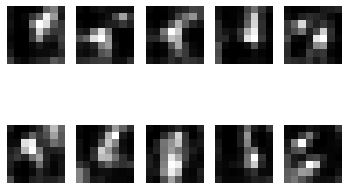

Batch 342/938 - Opimize G - Avg Batch Loss: 0.0120 - Time : 3.67s
Batch 343/938 - Opimize D - Avg Batch Loss: -0.0042 - Time : 4.02s
Batch 344/938 - Opimize G - Avg Batch Loss: 0.0129 - Time : 4.15s
Batch 345/938 - Opimize G - Avg Batch Loss: 0.0407 - Time : 3.69s
Batch 346/938 - Opimize G - Avg Batch Loss: -0.0559 - Time : 3.63s
Batch 347/938 - Opimize G - Avg Batch Loss: 0.0036 - Time : 3.56s
Batch 348/938 - Opimize G - Avg Batch Loss: 0.0055 - Time : 3.61s
Batch 349/938 - Opimize D - Avg Batch Loss: 0.0481 - Time : 3.71s
Batch 350/938 - Opimize G - Avg Batch Loss: -0.0079 - Time : 3.56s
Batch 351/938 - Opimize G - Avg Batch Loss: 0.0743 - Time : 3.56s
Batch 352/938 - Opimize G - Avg Batch Loss: 0.0362 - Time : 3.61s
Batch 353/938 - Opimize G - Avg Batch Loss: -0.0487 - Time : 3.56s
Batch 354/938 - Opimize G - Avg Batch Loss: 0.0026 - Time : 3.61s
Batch 355/938 - Opimize D - Avg Batch Loss: 0.0767 - Time : 3.74s
Batch 356/938 - Opimize G - Avg Batch Loss: 0.0181 - Time : 3.85s
Batch 

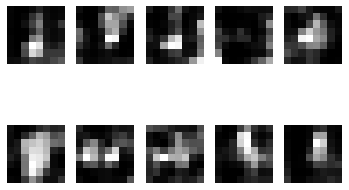

Batch 362/938 - Opimize G - Avg Batch Loss: -0.0757 - Time : 3.90s
Batch 363/938 - Opimize G - Avg Batch Loss: -0.0676 - Time : 3.65s
Batch 364/938 - Opimize G - Avg Batch Loss: 0.0031 - Time : 3.56s
Batch 365/938 - Opimize G - Avg Batch Loss: 0.1129 - Time : 3.59s
Batch 366/938 - Opimize G - Avg Batch Loss: 0.0961 - Time : 4.05s
Batch 367/938 - Opimize D - Avg Batch Loss: 0.0514 - Time : 3.58s
Batch 368/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.78s
Batch 369/938 - Opimize G - Avg Batch Loss: 0.0555 - Time : 3.56s
Batch 370/938 - Opimize G - Avg Batch Loss: 0.0081 - Time : 3.66s
Batch 371/938 - Opimize G - Avg Batch Loss: 0.0109 - Time : 3.65s
Batch 372/938 - Opimize G - Avg Batch Loss: 0.0536 - Time : 3.78s
Batch 373/938 - Opimize D - Avg Batch Loss: 0.0959 - Time : 3.70s
Batch 374/938 - Opimize G - Avg Batch Loss: 0.0749 - Time : 3.69s
Batch 375/938 - Opimize G - Avg Batch Loss: 0.0164 - Time : 3.82s
Batch 376/938 - Opimize G - Avg Batch Loss: 0.1214 - Time : 3.98s
Batch 3

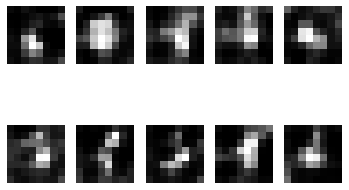

Batch 382/938 - Opimize G - Avg Batch Loss: 0.1010 - Time : 3.71s
Batch 383/938 - Opimize G - Avg Batch Loss: 0.0437 - Time : 3.62s
Batch 384/938 - Opimize G - Avg Batch Loss: 0.0471 - Time : 3.92s
Batch 385/938 - Opimize D - Avg Batch Loss: 0.0232 - Time : 3.85s
Batch 386/938 - Opimize G - Avg Batch Loss: -0.0044 - Time : 3.69s
Batch 387/938 - Opimize G - Avg Batch Loss: -0.0359 - Time : 3.67s
Batch 388/938 - Opimize G - Avg Batch Loss: 0.0275 - Time : 3.61s
Batch 389/938 - Opimize G - Avg Batch Loss: 0.0341 - Time : 3.91s
Batch 390/938 - Opimize G - Avg Batch Loss: 0.0259 - Time : 3.81s
Batch 391/938 - Opimize D - Avg Batch Loss: -0.0007 - Time : 4.01s
Batch 392/938 - Opimize G - Avg Batch Loss: 0.0331 - Time : 3.98s
Batch 393/938 - Opimize G - Avg Batch Loss: -0.0404 - Time : 3.56s
Batch 394/938 - Opimize G - Avg Batch Loss: 0.0042 - Time : 3.90s
Batch 395/938 - Opimize G - Avg Batch Loss: 0.0522 - Time : 3.55s
Batch 396/938 - Opimize G - Avg Batch Loss: 0.0676 - Time : 3.75s
Batch 

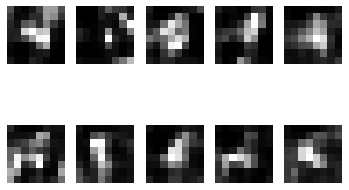

Batch 402/938 - Opimize G - Avg Batch Loss: -0.0305 - Time : 3.82s
Batch 403/938 - Opimize D - Avg Batch Loss: 0.0074 - Time : 3.84s
Batch 404/938 - Opimize G - Avg Batch Loss: 0.1576 - Time : 4.11s
Batch 405/938 - Opimize G - Avg Batch Loss: 0.0517 - Time : 3.72s
Batch 406/938 - Opimize G - Avg Batch Loss: 0.0060 - Time : 3.66s
Batch 407/938 - Opimize G - Avg Batch Loss: 0.0752 - Time : 3.72s
Batch 408/938 - Opimize G - Avg Batch Loss: 0.0423 - Time : 3.95s
Batch 409/938 - Opimize D - Avg Batch Loss: 0.0228 - Time : 3.70s
Batch 410/938 - Opimize G - Avg Batch Loss: -0.0269 - Time : 3.93s
Batch 411/938 - Opimize G - Avg Batch Loss: 0.0147 - Time : 3.73s
Batch 412/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.99s
Batch 413/938 - Opimize G - Avg Batch Loss: -0.0403 - Time : 3.91s
Batch 414/938 - Opimize G - Avg Batch Loss: -0.0208 - Time : 3.81s
Batch 415/938 - Opimize D - Avg Batch Loss: 0.0256 - Time : 3.57s
Batch 416/938 - Opimize G - Avg Batch Loss: 0.0955 - Time : 3.55s
Batch

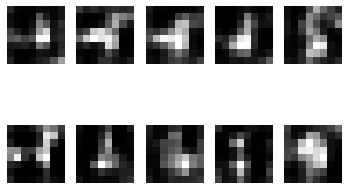

Batch 422/938 - Opimize G - Avg Batch Loss: -0.0227 - Time : 4.51s
Batch 423/938 - Opimize G - Avg Batch Loss: 0.1257 - Time : 3.66s
Batch 424/938 - Opimize G - Avg Batch Loss: 0.0581 - Time : 3.86s
Batch 425/938 - Opimize G - Avg Batch Loss: 0.0108 - Time : 3.62s
Batch 426/938 - Opimize G - Avg Batch Loss: 0.0079 - Time : 3.77s
Batch 427/938 - Opimize D - Avg Batch Loss: -0.0349 - Time : 3.66s
Batch 428/938 - Opimize G - Avg Batch Loss: 0.0114 - Time : 3.65s
Batch 429/938 - Opimize G - Avg Batch Loss: 0.0651 - Time : 3.84s
Batch 430/938 - Opimize G - Avg Batch Loss: 0.0584 - Time : 3.66s
Batch 431/938 - Opimize G - Avg Batch Loss: 0.0270 - Time : 3.62s
Batch 432/938 - Opimize G - Avg Batch Loss: -0.0464 - Time : 3.76s
Batch 433/938 - Opimize D - Avg Batch Loss: 0.0689 - Time : 3.56s
Batch 434/938 - Opimize G - Avg Batch Loss: 0.0250 - Time : 4.00s
Batch 435/938 - Opimize G - Avg Batch Loss: -0.0080 - Time : 3.86s
Batch 436/938 - Opimize G - Avg Batch Loss: -0.0914 - Time : 3.64s
Batch

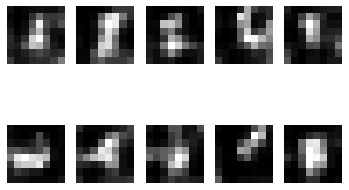

Batch 442/938 - Opimize G - Avg Batch Loss: -0.1037 - Time : 3.81s
Batch 443/938 - Opimize G - Avg Batch Loss: 0.0237 - Time : 3.85s
Batch 444/938 - Opimize G - Avg Batch Loss: -0.0033 - Time : 3.63s
Batch 445/938 - Opimize D - Avg Batch Loss: 0.0672 - Time : 3.74s
Batch 446/938 - Opimize G - Avg Batch Loss: -0.0369 - Time : 3.56s
Batch 447/938 - Opimize G - Avg Batch Loss: -0.0297 - Time : 3.75s
Batch 448/938 - Opimize G - Avg Batch Loss: 0.0039 - Time : 3.77s
Batch 449/938 - Opimize G - Avg Batch Loss: 0.0354 - Time : 3.59s
Batch 450/938 - Opimize G - Avg Batch Loss: 0.0627 - Time : 3.60s
Batch 451/938 - Opimize D - Avg Batch Loss: -0.0071 - Time : 3.77s
Batch 452/938 - Opimize G - Avg Batch Loss: 0.0664 - Time : 4.21s
Batch 453/938 - Opimize G - Avg Batch Loss: -0.0330 - Time : 4.04s
Batch 454/938 - Opimize G - Avg Batch Loss: 0.0548 - Time : 3.79s
Batch 455/938 - Opimize G - Avg Batch Loss: 0.0013 - Time : 3.91s
Batch 456/938 - Opimize G - Avg Batch Loss: 0.0380 - Time : 3.92s
Batc

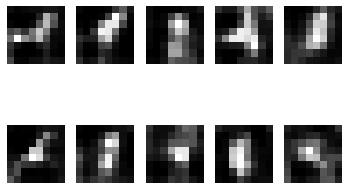

Batch 462/938 - Opimize G - Avg Batch Loss: 0.0250 - Time : 3.60s
Batch 463/938 - Opimize D - Avg Batch Loss: -0.0912 - Time : 3.93s
Batch 464/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.61s
Batch 465/938 - Opimize G - Avg Batch Loss: -0.0508 - Time : 4.03s
Batch 466/938 - Opimize G - Avg Batch Loss: 0.1406 - Time : 3.63s
Batch 467/938 - Opimize G - Avg Batch Loss: -0.0229 - Time : 3.66s
Batch 468/938 - Opimize G - Avg Batch Loss: -0.0711 - Time : 3.71s
Batch 469/938 - Opimize D - Avg Batch Loss: 0.1652 - Time : 3.64s
Batch 470/938 - Opimize G - Avg Batch Loss: 0.1023 - Time : 3.66s
Batch 471/938 - Opimize G - Avg Batch Loss: -0.0072 - Time : 3.93s
Batch 472/938 - Opimize G - Avg Batch Loss: -0.0606 - Time : 3.69s
Batch 473/938 - Opimize G - Avg Batch Loss: -0.0291 - Time : 3.94s
Batch 474/938 - Opimize G - Avg Batch Loss: -0.0027 - Time : 4.22s
Batch 475/938 - Opimize D - Avg Batch Loss: 0.0157 - Time : 3.76s
Batch 476/938 - Opimize G - Avg Batch Loss: 0.0059 - Time : 3.74s
Ba

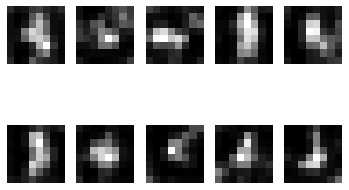

Batch 482/938 - Opimize G - Avg Batch Loss: 0.0360 - Time : 3.71s
Batch 483/938 - Opimize G - Avg Batch Loss: -0.0690 - Time : 3.74s
Batch 484/938 - Opimize G - Avg Batch Loss: 0.0135 - Time : 4.11s
Batch 485/938 - Opimize G - Avg Batch Loss: -0.0249 - Time : 3.59s
Batch 486/938 - Opimize G - Avg Batch Loss: 0.1208 - Time : 3.61s
Batch 487/938 - Opimize D - Avg Batch Loss: 0.0047 - Time : 3.89s
Batch 488/938 - Opimize G - Avg Batch Loss: 0.1052 - Time : 3.66s
Batch 489/938 - Opimize G - Avg Batch Loss: -0.0281 - Time : 3.71s
Batch 490/938 - Opimize G - Avg Batch Loss: -0.0108 - Time : 3.83s
Batch 491/938 - Opimize G - Avg Batch Loss: 0.0028 - Time : 3.70s
Batch 492/938 - Opimize G - Avg Batch Loss: 0.0473 - Time : 3.93s
Batch 493/938 - Opimize D - Avg Batch Loss: 0.0376 - Time : 3.65s
Batch 494/938 - Opimize G - Avg Batch Loss: -0.0144 - Time : 3.71s
Batch 495/938 - Opimize G - Avg Batch Loss: -0.0177 - Time : 3.61s
Batch 496/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.93s
Batc

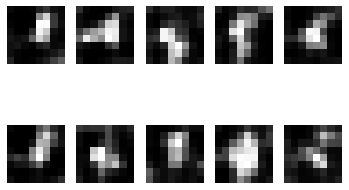

Batch 502/938 - Opimize G - Avg Batch Loss: -0.0057 - Time : 3.91s
Batch 503/938 - Opimize G - Avg Batch Loss: 0.0462 - Time : 3.94s
Batch 504/938 - Opimize G - Avg Batch Loss: 0.0246 - Time : 3.54s
Batch 505/938 - Opimize D - Avg Batch Loss: 0.0642 - Time : 3.71s
Batch 506/938 - Opimize G - Avg Batch Loss: 0.0607 - Time : 4.21s
Batch 507/938 - Opimize G - Avg Batch Loss: 0.0370 - Time : 3.97s
Batch 508/938 - Opimize G - Avg Batch Loss: 0.1071 - Time : 3.73s
Batch 509/938 - Opimize G - Avg Batch Loss: -0.0311 - Time : 3.93s
Batch 510/938 - Opimize G - Avg Batch Loss: 0.0381 - Time : 4.07s
Batch 511/938 - Opimize D - Avg Batch Loss: -0.0336 - Time : 3.88s
Batch 512/938 - Opimize G - Avg Batch Loss: -0.0104 - Time : 4.15s
Batch 513/938 - Opimize G - Avg Batch Loss: -0.0268 - Time : 3.84s
Batch 514/938 - Opimize G - Avg Batch Loss: -0.1011 - Time : 3.82s
Batch 515/938 - Opimize G - Avg Batch Loss: 0.0000 - Time : 3.67s
Batch 516/938 - Opimize G - Avg Batch Loss: 0.0110 - Time : 3.89s
Batc

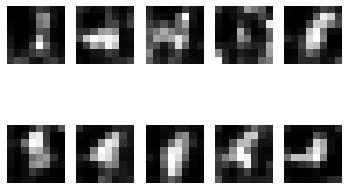

Batch 522/938 - Opimize G - Avg Batch Loss: 0.0404 - Time : 3.57s
Batch 523/938 - Opimize D - Avg Batch Loss: 0.0316 - Time : 3.95s
Batch 524/938 - Opimize G - Avg Batch Loss: 0.0607 - Time : 4.10s
Batch 525/938 - Opimize G - Avg Batch Loss: 0.0285 - Time : 3.56s
Batch 526/938 - Opimize G - Avg Batch Loss: -0.1591 - Time : 3.55s
Batch 527/938 - Opimize G - Avg Batch Loss: 0.0325 - Time : 3.94s
Batch 528/938 - Opimize G - Avg Batch Loss: 0.0781 - Time : 3.91s
Batch 529/938 - Opimize D - Avg Batch Loss: 0.0890 - Time : 3.68s
Batch 530/938 - Opimize G - Avg Batch Loss: 0.0067 - Time : 3.58s
Batch 531/938 - Opimize G - Avg Batch Loss: 0.0898 - Time : 3.74s
Batch 532/938 - Opimize G - Avg Batch Loss: -0.0903 - Time : 3.68s
Batch 533/938 - Opimize G - Avg Batch Loss: 0.0687 - Time : 3.88s
Batch 534/938 - Opimize G - Avg Batch Loss: 0.0296 - Time : 3.71s
Batch 535/938 - Opimize D - Avg Batch Loss: 0.0385 - Time : 3.64s
Batch 536/938 - Opimize G - Avg Batch Loss: 0.1527 - Time : 3.93s
Batch 53

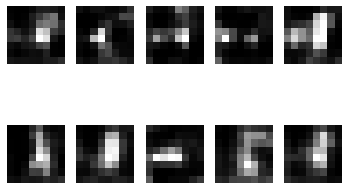

Batch 542/938 - Opimize G - Avg Batch Loss: -0.0101 - Time : 3.70s
Batch 543/938 - Opimize G - Avg Batch Loss: -0.0626 - Time : 3.57s
Batch 544/938 - Opimize G - Avg Batch Loss: 0.0316 - Time : 3.85s
Batch 545/938 - Opimize G - Avg Batch Loss: -0.0069 - Time : 3.97s
Batch 546/938 - Opimize G - Avg Batch Loss: -0.0030 - Time : 3.60s
Batch 547/938 - Opimize D - Avg Batch Loss: -0.0133 - Time : 4.08s
Batch 548/938 - Opimize G - Avg Batch Loss: -0.0033 - Time : 3.80s
Batch 549/938 - Opimize G - Avg Batch Loss: 0.0087 - Time : 3.57s
Batch 550/938 - Opimize G - Avg Batch Loss: 0.0196 - Time : 3.62s
Batch 551/938 - Opimize G - Avg Batch Loss: -0.0256 - Time : 3.76s
Batch 552/938 - Opimize G - Avg Batch Loss: -0.0565 - Time : 4.45s
Batch 553/938 - Opimize D - Avg Batch Loss: -0.0003 - Time : 3.91s
Batch 554/938 - Opimize G - Avg Batch Loss: 0.0807 - Time : 3.76s
Batch 555/938 - Opimize G - Avg Batch Loss: -0.0337 - Time : 3.78s
Batch 556/938 - Opimize G - Avg Batch Loss: 0.0086 - Time : 3.68s


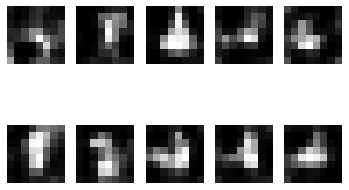

Batch 562/938 - Opimize G - Avg Batch Loss: -0.0632 - Time : 3.66s
Batch 563/938 - Opimize G - Avg Batch Loss: 0.0249 - Time : 3.79s
Batch 564/938 - Opimize G - Avg Batch Loss: 0.0484 - Time : 4.03s
Batch 565/938 - Opimize D - Avg Batch Loss: 0.0678 - Time : 3.77s
Batch 566/938 - Opimize G - Avg Batch Loss: 0.0806 - Time : 3.96s
Batch 567/938 - Opimize G - Avg Batch Loss: -0.0762 - Time : 3.69s
Batch 568/938 - Opimize G - Avg Batch Loss: -0.0333 - Time : 4.22s
Batch 569/938 - Opimize G - Avg Batch Loss: 0.0711 - Time : 3.93s
Batch 570/938 - Opimize G - Avg Batch Loss: -0.0510 - Time : 4.03s
Batch 571/938 - Opimize D - Avg Batch Loss: 0.0717 - Time : 3.79s
Batch 572/938 - Opimize G - Avg Batch Loss: 0.0302 - Time : 3.60s
Batch 573/938 - Opimize G - Avg Batch Loss: -0.0403 - Time : 3.93s
Batch 574/938 - Opimize G - Avg Batch Loss: 0.0238 - Time : 3.90s
Batch 575/938 - Opimize G - Avg Batch Loss: 0.0007 - Time : 3.75s
Batch 576/938 - Opimize G - Avg Batch Loss: 0.0084 - Time : 3.74s
Batch

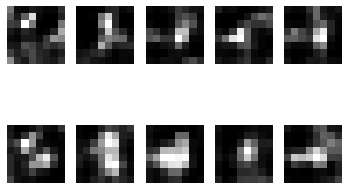

Batch 582/938 - Opimize G - Avg Batch Loss: 0.0168 - Time : 3.87s
Batch 583/938 - Opimize D - Avg Batch Loss: 0.0479 - Time : 3.68s
Batch 584/938 - Opimize G - Avg Batch Loss: -0.0303 - Time : 3.81s
Batch 585/938 - Opimize G - Avg Batch Loss: 0.0027 - Time : 4.31s
Batch 586/938 - Opimize G - Avg Batch Loss: 0.1127 - Time : 3.95s
Batch 587/938 - Opimize G - Avg Batch Loss: 0.0019 - Time : 3.70s
Batch 588/938 - Opimize G - Avg Batch Loss: -0.0216 - Time : 3.68s
Batch 589/938 - Opimize D - Avg Batch Loss: 0.0614 - Time : 3.83s
Batch 590/938 - Opimize G - Avg Batch Loss: 0.0136 - Time : 3.81s
Batch 591/938 - Opimize G - Avg Batch Loss: -0.0304 - Time : 4.05s
Batch 592/938 - Opimize G - Avg Batch Loss: -0.0150 - Time : 3.70s
Batch 593/938 - Opimize G - Avg Batch Loss: -0.0189 - Time : 3.66s
Batch 594/938 - Opimize G - Avg Batch Loss: 0.0486 - Time : 3.81s
Batch 595/938 - Opimize D - Avg Batch Loss: 0.0836 - Time : 3.84s
Batch 596/938 - Opimize G - Avg Batch Loss: -0.0589 - Time : 4.17s
Batc

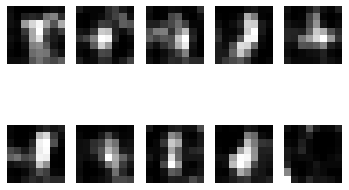

Batch 602/938 - Opimize G - Avg Batch Loss: 0.0185 - Time : 3.83s
Batch 603/938 - Opimize G - Avg Batch Loss: 0.0039 - Time : 3.73s
Batch 604/938 - Opimize G - Avg Batch Loss: 0.0132 - Time : 3.75s
Batch 605/938 - Opimize G - Avg Batch Loss: 0.0226 - Time : 3.78s
Batch 606/938 - Opimize G - Avg Batch Loss: -0.0078 - Time : 3.78s
Batch 607/938 - Opimize D - Avg Batch Loss: -0.0144 - Time : 3.92s
Batch 608/938 - Opimize G - Avg Batch Loss: 0.0526 - Time : 3.64s
Batch 609/938 - Opimize G - Avg Batch Loss: 0.0740 - Time : 3.86s
Batch 610/938 - Opimize G - Avg Batch Loss: 0.0933 - Time : 3.63s
Batch 611/938 - Opimize G - Avg Batch Loss: 0.0276 - Time : 3.65s
Batch 612/938 - Opimize G - Avg Batch Loss: 0.0205 - Time : 3.75s
Batch 613/938 - Opimize D - Avg Batch Loss: -0.0082 - Time : 3.59s
Batch 614/938 - Opimize G - Avg Batch Loss: 0.1309 - Time : 3.83s
Batch 615/938 - Opimize G - Avg Batch Loss: 0.0712 - Time : 3.91s
Batch 616/938 - Opimize G - Avg Batch Loss: 0.0064 - Time : 3.71s
Batch 6

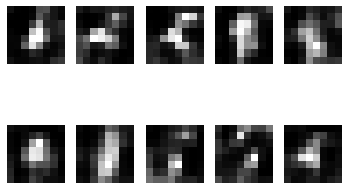

Batch 622/938 - Opimize G - Avg Batch Loss: -0.0557 - Time : 3.75s
Batch 623/938 - Opimize G - Avg Batch Loss: -0.0496 - Time : 3.73s
Batch 624/938 - Opimize G - Avg Batch Loss: -0.0010 - Time : 3.71s
Batch 625/938 - Opimize D - Avg Batch Loss: -0.0314 - Time : 3.76s
Batch 626/938 - Opimize G - Avg Batch Loss: 0.1504 - Time : 3.73s
Batch 627/938 - Opimize G - Avg Batch Loss: -0.0724 - Time : 3.60s
Batch 628/938 - Opimize G - Avg Batch Loss: -0.0164 - Time : 4.16s
Batch 629/938 - Opimize G - Avg Batch Loss: -0.0498 - Time : 3.83s
Batch 630/938 - Opimize G - Avg Batch Loss: 0.0084 - Time : 4.00s
Batch 631/938 - Opimize D - Avg Batch Loss: 0.0257 - Time : 3.70s
Batch 632/938 - Opimize G - Avg Batch Loss: 0.0608 - Time : 3.71s
Batch 633/938 - Opimize G - Avg Batch Loss: -0.0087 - Time : 3.78s
Batch 634/938 - Opimize G - Avg Batch Loss: -0.0542 - Time : 3.69s
Batch 635/938 - Opimize G - Avg Batch Loss: -0.0293 - Time : 3.65s
Batch 636/938 - Opimize G - Avg Batch Loss: 0.0043 - Time : 3.86s


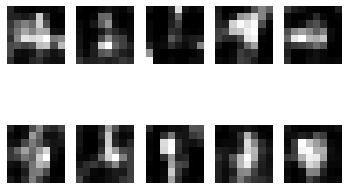

Batch 642/938 - Opimize G - Avg Batch Loss: -0.0085 - Time : 3.85s
Batch 643/938 - Opimize D - Avg Batch Loss: 0.0359 - Time : 4.01s
Batch 644/938 - Opimize G - Avg Batch Loss: -0.0339 - Time : 3.95s
Batch 645/938 - Opimize G - Avg Batch Loss: -0.0024 - Time : 3.88s
Batch 646/938 - Opimize G - Avg Batch Loss: 0.0383 - Time : 3.75s
Batch 647/938 - Opimize G - Avg Batch Loss: 0.0200 - Time : 3.61s
Batch 648/938 - Opimize G - Avg Batch Loss: -0.0765 - Time : 3.59s
Batch 649/938 - Opimize D - Avg Batch Loss: 0.0932 - Time : 3.74s
Batch 650/938 - Opimize G - Avg Batch Loss: 0.0558 - Time : 3.62s
Batch 651/938 - Opimize G - Avg Batch Loss: -0.0220 - Time : 3.61s
Batch 652/938 - Opimize G - Avg Batch Loss: -0.0492 - Time : 3.87s
Batch 653/938 - Opimize G - Avg Batch Loss: 0.0202 - Time : 3.65s
Batch 654/938 - Opimize G - Avg Batch Loss: -0.0201 - Time : 3.81s
Batch 655/938 - Opimize D - Avg Batch Loss: 0.0251 - Time : 4.09s
Batch 656/938 - Opimize G - Avg Batch Loss: 0.0050 - Time : 3.82s
Bat

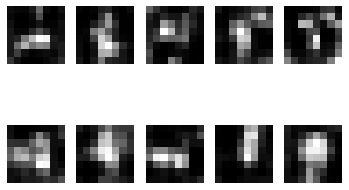

Batch 662/938 - Opimize G - Avg Batch Loss: 0.0496 - Time : 3.68s
Batch 663/938 - Opimize G - Avg Batch Loss: -0.0115 - Time : 3.63s
Batch 664/938 - Opimize G - Avg Batch Loss: 0.0682 - Time : 3.92s
Batch 665/938 - Opimize G - Avg Batch Loss: 0.0566 - Time : 3.60s
Batch 666/938 - Opimize G - Avg Batch Loss: 0.0045 - Time : 3.64s
Batch 667/938 - Opimize D - Avg Batch Loss: 0.0233 - Time : 3.81s
Batch 668/938 - Opimize G - Avg Batch Loss: -0.0294 - Time : 3.65s
Batch 669/938 - Opimize G - Avg Batch Loss: 0.0165 - Time : 3.67s
Batch 670/938 - Opimize G - Avg Batch Loss: -0.0466 - Time : 3.74s
Batch 671/938 - Opimize G - Avg Batch Loss: 0.0063 - Time : 3.69s
Batch 672/938 - Opimize G - Avg Batch Loss: -0.0297 - Time : 4.02s
Batch 673/938 - Opimize D - Avg Batch Loss: 0.0496 - Time : 3.95s
Batch 674/938 - Opimize G - Avg Batch Loss: -0.0645 - Time : 3.68s
Batch 675/938 - Opimize G - Avg Batch Loss: 0.0281 - Time : 3.84s
Batch 676/938 - Opimize G - Avg Batch Loss: 0.0618 - Time : 3.75s
Batch

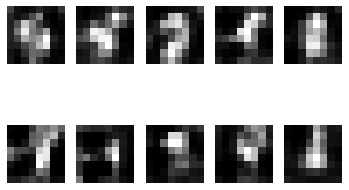

Batch 682/938 - Opimize G - Avg Batch Loss: 0.0098 - Time : 3.56s
Batch 683/938 - Opimize G - Avg Batch Loss: 0.0057 - Time : 3.60s
Batch 684/938 - Opimize G - Avg Batch Loss: -0.0125 - Time : 3.81s
Batch 685/938 - Opimize D - Avg Batch Loss: -0.0443 - Time : 3.57s
Batch 686/938 - Opimize G - Avg Batch Loss: -0.0835 - Time : 3.76s
Batch 687/938 - Opimize G - Avg Batch Loss: -0.0555 - Time : 3.62s
Batch 688/938 - Opimize G - Avg Batch Loss: -0.0551 - Time : 3.73s
Batch 689/938 - Opimize G - Avg Batch Loss: 0.0408 - Time : 3.96s
Batch 690/938 - Opimize G - Avg Batch Loss: 0.0763 - Time : 3.64s
Batch 691/938 - Opimize D - Avg Batch Loss: 0.0274 - Time : 3.74s
Batch 692/938 - Opimize G - Avg Batch Loss: 0.0321 - Time : 3.82s
Batch 693/938 - Opimize G - Avg Batch Loss: 0.0020 - Time : 3.77s
Batch 694/938 - Opimize G - Avg Batch Loss: 0.0753 - Time : 3.55s
Batch 695/938 - Opimize G - Avg Batch Loss: -0.0024 - Time : 4.10s
Batch 696/938 - Opimize G - Avg Batch Loss: 0.0727 - Time : 3.62s
Batc

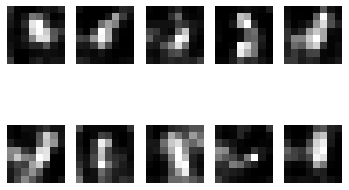

Batch 702/938 - Opimize G - Avg Batch Loss: -0.0738 - Time : 3.77s
Batch 703/938 - Opimize D - Avg Batch Loss: 0.0041 - Time : 3.99s
Batch 704/938 - Opimize G - Avg Batch Loss: 0.0004 - Time : 3.85s
Batch 705/938 - Opimize G - Avg Batch Loss: -0.0397 - Time : 3.89s
Batch 706/938 - Opimize G - Avg Batch Loss: -0.0080 - Time : 3.93s
Batch 707/938 - Opimize G - Avg Batch Loss: 0.0566 - Time : 4.14s
Batch 708/938 - Opimize G - Avg Batch Loss: 0.0465 - Time : 3.92s
Batch 709/938 - Opimize D - Avg Batch Loss: 0.0387 - Time : 3.88s
Batch 710/938 - Opimize G - Avg Batch Loss: 0.1130 - Time : 3.79s
Batch 711/938 - Opimize G - Avg Batch Loss: 0.0262 - Time : 3.57s
Batch 712/938 - Opimize G - Avg Batch Loss: -0.0461 - Time : 3.90s
Batch 713/938 - Opimize G - Avg Batch Loss: 0.0826 - Time : 4.11s
Batch 714/938 - Opimize G - Avg Batch Loss: 0.0433 - Time : 3.88s
Batch 715/938 - Opimize D - Avg Batch Loss: -0.0153 - Time : 3.80s
Batch 716/938 - Opimize G - Avg Batch Loss: -0.0178 - Time : 3.87s
Batc

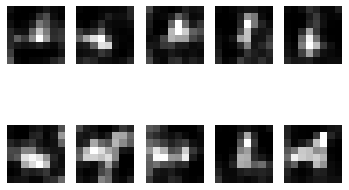

Batch 722/938 - Opimize G - Avg Batch Loss: 0.0045 - Time : 4.08s
Batch 723/938 - Opimize G - Avg Batch Loss: 0.0714 - Time : 3.76s
Batch 724/938 - Opimize G - Avg Batch Loss: -0.0273 - Time : 3.70s
Batch 725/938 - Opimize G - Avg Batch Loss: -0.0043 - Time : 3.65s
Batch 726/938 - Opimize G - Avg Batch Loss: -0.0311 - Time : 3.71s
Batch 727/938 - Opimize D - Avg Batch Loss: -0.0569 - Time : 3.75s
Batch 728/938 - Opimize G - Avg Batch Loss: -0.0044 - Time : 3.87s
Batch 729/938 - Opimize G - Avg Batch Loss: -0.0864 - Time : 3.85s
Batch 730/938 - Opimize G - Avg Batch Loss: 0.0802 - Time : 3.89s
Batch 731/938 - Opimize G - Avg Batch Loss: 0.0020 - Time : 3.57s
Batch 732/938 - Opimize G - Avg Batch Loss: 0.0623 - Time : 4.04s
Batch 733/938 - Opimize D - Avg Batch Loss: -0.0110 - Time : 4.01s
Batch 734/938 - Opimize G - Avg Batch Loss: 0.0358 - Time : 3.87s
Batch 735/938 - Opimize G - Avg Batch Loss: 0.0306 - Time : 4.28s
Batch 736/938 - Opimize G - Avg Batch Loss: 0.0648 - Time : 3.69s
Bat

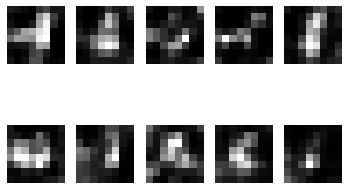

Batch 742/938 - Opimize G - Avg Batch Loss: 0.0549 - Time : 3.98s
Batch 743/938 - Opimize G - Avg Batch Loss: -0.0379 - Time : 3.83s
Batch 744/938 - Opimize G - Avg Batch Loss: 0.1008 - Time : 3.60s
Batch 745/938 - Opimize D - Avg Batch Loss: 0.0056 - Time : 3.60s
Batch 746/938 - Opimize G - Avg Batch Loss: -0.0075 - Time : 3.83s
Batch 747/938 - Opimize G - Avg Batch Loss: -0.0280 - Time : 3.83s
Batch 748/938 - Opimize G - Avg Batch Loss: -0.0288 - Time : 4.15s
Batch 749/938 - Opimize G - Avg Batch Loss: -0.0578 - Time : 3.81s
Batch 750/938 - Opimize G - Avg Batch Loss: -0.0250 - Time : 3.76s
Batch 751/938 - Opimize D - Avg Batch Loss: 0.0521 - Time : 3.65s
Batch 752/938 - Opimize G - Avg Batch Loss: -0.0442 - Time : 3.78s
Batch 753/938 - Opimize G - Avg Batch Loss: 0.0611 - Time : 3.55s
Batch 754/938 - Opimize G - Avg Batch Loss: -0.0586 - Time : 3.79s
Batch 755/938 - Opimize G - Avg Batch Loss: 0.0301 - Time : 3.58s
Batch 756/938 - Opimize G - Avg Batch Loss: -0.0137 - Time : 3.64s
B

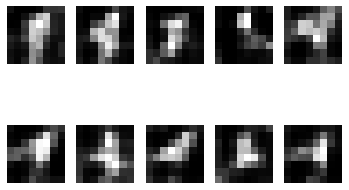

Batch 762/938 - Opimize G - Avg Batch Loss: -0.0171 - Time : 3.93s
Batch 763/938 - Opimize D - Avg Batch Loss: -0.0336 - Time : 3.91s
Batch 764/938 - Opimize G - Avg Batch Loss: 0.0789 - Time : 3.78s
Batch 765/938 - Opimize G - Avg Batch Loss: 0.0303 - Time : 3.84s
Batch 766/938 - Opimize G - Avg Batch Loss: 0.1189 - Time : 3.63s
Batch 767/938 - Opimize G - Avg Batch Loss: -0.0443 - Time : 3.58s
Batch 768/938 - Opimize G - Avg Batch Loss: 0.0782 - Time : 3.84s
Batch 769/938 - Opimize D - Avg Batch Loss: 0.0083 - Time : 3.88s
Batch 770/938 - Opimize G - Avg Batch Loss: 0.0469 - Time : 4.26s
Batch 771/938 - Opimize G - Avg Batch Loss: 0.0373 - Time : 3.60s
Batch 772/938 - Opimize G - Avg Batch Loss: 0.0175 - Time : 3.58s
Batch 773/938 - Opimize G - Avg Batch Loss: -0.0347 - Time : 3.73s
Batch 774/938 - Opimize G - Avg Batch Loss: -0.0052 - Time : 3.62s
Batch 775/938 - Opimize D - Avg Batch Loss: 0.0577 - Time : 4.06s
Batch 776/938 - Opimize G - Avg Batch Loss: 0.0025 - Time : 3.84s
Batch

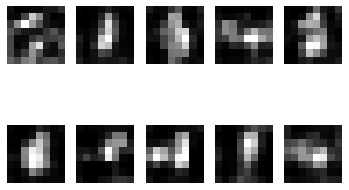

Batch 782/938 - Opimize G - Avg Batch Loss: 0.0222 - Time : 3.93s
Batch 783/938 - Opimize G - Avg Batch Loss: -0.1069 - Time : 3.57s
Batch 784/938 - Opimize G - Avg Batch Loss: 0.1236 - Time : 3.93s
Batch 785/938 - Opimize G - Avg Batch Loss: 0.0423 - Time : 3.76s
Batch 786/938 - Opimize G - Avg Batch Loss: -0.0653 - Time : 3.80s
Batch 787/938 - Opimize D - Avg Batch Loss: -0.0789 - Time : 3.56s
Batch 788/938 - Opimize G - Avg Batch Loss: 0.0946 - Time : 4.08s
Batch 789/938 - Opimize G - Avg Batch Loss: -0.0008 - Time : 3.91s
Batch 790/938 - Opimize G - Avg Batch Loss: -0.0501 - Time : 3.68s
Batch 791/938 - Opimize G - Avg Batch Loss: -0.0551 - Time : 3.81s
Batch 792/938 - Opimize G - Avg Batch Loss: 0.0764 - Time : 3.73s
Batch 793/938 - Opimize D - Avg Batch Loss: 0.0345 - Time : 3.58s
Batch 794/938 - Opimize G - Avg Batch Loss: 0.0105 - Time : 3.80s
Batch 795/938 - Opimize G - Avg Batch Loss: 0.0228 - Time : 3.74s
Batch 796/938 - Opimize G - Avg Batch Loss: 0.0016 - Time : 4.03s
Batc

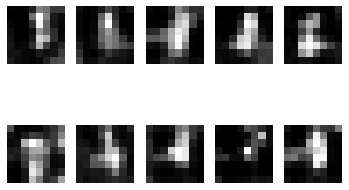

Batch 802/938 - Opimize G - Avg Batch Loss: -0.0081 - Time : 3.63s
Batch 803/938 - Opimize G - Avg Batch Loss: 0.0922 - Time : 3.57s
Batch 804/938 - Opimize G - Avg Batch Loss: -0.0375 - Time : 4.21s
Batch 805/938 - Opimize D - Avg Batch Loss: -0.0214 - Time : 3.71s
Batch 806/938 - Opimize G - Avg Batch Loss: -0.0247 - Time : 3.75s
Batch 807/938 - Opimize G - Avg Batch Loss: -0.0227 - Time : 3.64s
Batch 808/938 - Opimize G - Avg Batch Loss: -0.1081 - Time : 4.02s
Batch 809/938 - Opimize G - Avg Batch Loss: 0.0649 - Time : 3.63s
Batch 810/938 - Opimize G - Avg Batch Loss: 0.0147 - Time : 4.09s
Batch 811/938 - Opimize D - Avg Batch Loss: 0.0184 - Time : 3.95s
Batch 812/938 - Opimize G - Avg Batch Loss: 0.0734 - Time : 3.61s
Batch 813/938 - Opimize G - Avg Batch Loss: 0.0484 - Time : 3.58s
Batch 814/938 - Opimize G - Avg Batch Loss: 0.0335 - Time : 3.55s
Batch 815/938 - Opimize G - Avg Batch Loss: -0.0557 - Time : 3.57s
Batch 816/938 - Opimize G - Avg Batch Loss: -0.0066 - Time : 3.82s
Ba

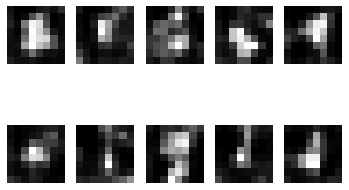

Batch 822/938 - Opimize G - Avg Batch Loss: 0.0458 - Time : 3.76s
Batch 823/938 - Opimize D - Avg Batch Loss: 0.0029 - Time : 3.85s
Batch 824/938 - Opimize G - Avg Batch Loss: -0.0172 - Time : 3.59s
Batch 825/938 - Opimize G - Avg Batch Loss: 0.0115 - Time : 3.68s
Batch 826/938 - Opimize G - Avg Batch Loss: 0.0461 - Time : 3.72s
Batch 827/938 - Opimize G - Avg Batch Loss: 0.0971 - Time : 3.67s
Batch 828/938 - Opimize G - Avg Batch Loss: 0.0511 - Time : 4.02s
Batch 829/938 - Opimize D - Avg Batch Loss: -0.0187 - Time : 3.58s
Batch 830/938 - Opimize G - Avg Batch Loss: 0.0317 - Time : 3.61s
Batch 831/938 - Opimize G - Avg Batch Loss: -0.0188 - Time : 3.85s
Batch 832/938 - Opimize G - Avg Batch Loss: -0.0292 - Time : 3.83s
Batch 833/938 - Opimize G - Avg Batch Loss: -0.0134 - Time : 3.68s
Batch 834/938 - Opimize G - Avg Batch Loss: 0.0282 - Time : 3.60s
Batch 835/938 - Opimize D - Avg Batch Loss: 0.0331 - Time : 3.64s
Batch 836/938 - Opimize G - Avg Batch Loss: 0.0821 - Time : 3.61s
Batch

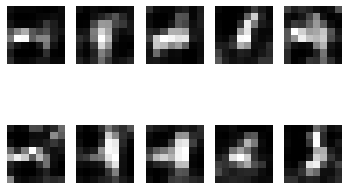

Batch 842/938 - Opimize G - Avg Batch Loss: -0.0646 - Time : 3.73s
Batch 843/938 - Opimize G - Avg Batch Loss: 0.0583 - Time : 3.57s
Batch 844/938 - Opimize G - Avg Batch Loss: -0.0174 - Time : 3.92s
Batch 845/938 - Opimize G - Avg Batch Loss: 0.0167 - Time : 3.63s
Batch 846/938 - Opimize G - Avg Batch Loss: 0.1047 - Time : 3.83s
Batch 847/938 - Opimize D - Avg Batch Loss: -0.0900 - Time : 3.97s
Batch 848/938 - Opimize G - Avg Batch Loss: -0.0099 - Time : 3.66s
Batch 849/938 - Opimize G - Avg Batch Loss: -0.0021 - Time : 3.67s
Batch 850/938 - Opimize G - Avg Batch Loss: -0.0076 - Time : 3.66s
Batch 851/938 - Opimize G - Avg Batch Loss: -0.0225 - Time : 3.71s
Batch 852/938 - Opimize G - Avg Batch Loss: 0.0587 - Time : 3.76s
Batch 853/938 - Opimize D - Avg Batch Loss: 0.0172 - Time : 3.64s
Batch 854/938 - Opimize G - Avg Batch Loss: -0.0419 - Time : 3.71s
Batch 855/938 - Opimize G - Avg Batch Loss: 0.0009 - Time : 3.79s
Batch 856/938 - Opimize G - Avg Batch Loss: -0.0378 - Time : 3.52s
B

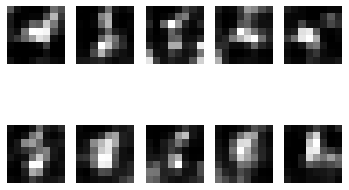

Batch 862/938 - Opimize G - Avg Batch Loss: 0.0679 - Time : 3.59s
Batch 863/938 - Opimize G - Avg Batch Loss: -0.0115 - Time : 3.52s
Batch 864/938 - Opimize G - Avg Batch Loss: -0.1058 - Time : 3.51s
Batch 865/938 - Opimize D - Avg Batch Loss: -0.0172 - Time : 3.55s
Batch 866/938 - Opimize G - Avg Batch Loss: -0.0007 - Time : 3.63s
Batch 867/938 - Opimize G - Avg Batch Loss: 0.0866 - Time : 3.92s
Batch 868/938 - Opimize G - Avg Batch Loss: 0.0351 - Time : 3.49s
Batch 869/938 - Opimize G - Avg Batch Loss: -0.0638 - Time : 3.69s
Batch 870/938 - Opimize G - Avg Batch Loss: -0.0443 - Time : 3.75s
Batch 871/938 - Opimize D - Avg Batch Loss: 0.0537 - Time : 3.81s
Batch 872/938 - Opimize G - Avg Batch Loss: 0.0052 - Time : 4.12s
Batch 873/938 - Opimize G - Avg Batch Loss: 0.0664 - Time : 3.80s
Batch 874/938 - Opimize G - Avg Batch Loss: -0.0070 - Time : 3.72s
Batch 875/938 - Opimize G - Avg Batch Loss: 0.0198 - Time : 3.79s
Batch 876/938 - Opimize G - Avg Batch Loss: -0.0337 - Time : 3.77s
Ba

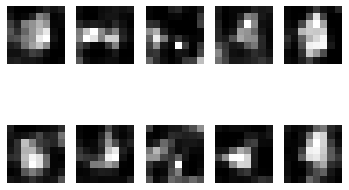

Batch 882/938 - Opimize G - Avg Batch Loss: -0.0144 - Time : 3.74s
Batch 883/938 - Opimize D - Avg Batch Loss: -0.0443 - Time : 4.00s
Batch 884/938 - Opimize G - Avg Batch Loss: 0.0215 - Time : 3.79s
Batch 885/938 - Opimize G - Avg Batch Loss: -0.0195 - Time : 3.89s
Batch 886/938 - Opimize G - Avg Batch Loss: 0.0395 - Time : 4.05s
Batch 887/938 - Opimize G - Avg Batch Loss: -0.0856 - Time : 4.06s
Batch 888/938 - Opimize G - Avg Batch Loss: 0.0315 - Time : 4.07s
Batch 889/938 - Opimize D - Avg Batch Loss: -0.0231 - Time : 4.07s
Batch 890/938 - Opimize G - Avg Batch Loss: 0.0906 - Time : 3.80s
Batch 891/938 - Opimize G - Avg Batch Loss: 0.0230 - Time : 3.93s
Batch 892/938 - Opimize G - Avg Batch Loss: 0.0060 - Time : 3.91s
Batch 893/938 - Opimize G - Avg Batch Loss: -0.0118 - Time : 3.77s
Batch 894/938 - Opimize G - Avg Batch Loss: 0.0133 - Time : 3.54s
Batch 895/938 - Opimize D - Avg Batch Loss: 0.0141 - Time : 3.73s
Batch 896/938 - Opimize G - Avg Batch Loss: 0.0526 - Time : 3.74s
Batc

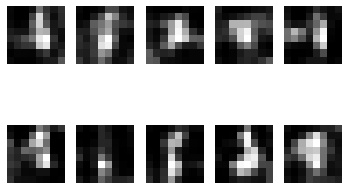

Batch 902/938 - Opimize G - Avg Batch Loss: -0.0273 - Time : 3.93s
Batch 903/938 - Opimize G - Avg Batch Loss: 0.1896 - Time : 3.52s
Batch 904/938 - Opimize G - Avg Batch Loss: 0.0062 - Time : 3.89s
Batch 905/938 - Opimize G - Avg Batch Loss: -0.0101 - Time : 3.76s
Batch 906/938 - Opimize G - Avg Batch Loss: -0.0677 - Time : 3.75s
Batch 907/938 - Opimize D - Avg Batch Loss: -0.0025 - Time : 3.80s
Batch 908/938 - Opimize G - Avg Batch Loss: -0.0083 - Time : 3.78s
Batch 909/938 - Opimize G - Avg Batch Loss: -0.0650 - Time : 4.14s
Batch 910/938 - Opimize G - Avg Batch Loss: 0.0310 - Time : 4.07s
Batch 911/938 - Opimize G - Avg Batch Loss: -0.0436 - Time : 4.24s
Batch 912/938 - Opimize G - Avg Batch Loss: -0.0422 - Time : 3.91s
Batch 913/938 - Opimize D - Avg Batch Loss: 0.0166 - Time : 3.80s
Batch 914/938 - Opimize G - Avg Batch Loss: 0.0715 - Time : 3.75s
Batch 915/938 - Opimize G - Avg Batch Loss: -0.0521 - Time : 3.77s
Batch 916/938 - Opimize G - Avg Batch Loss: 0.0937 - Time : 4.17s
B

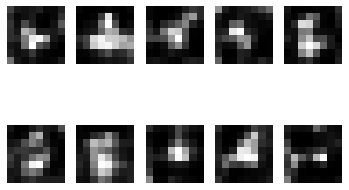

Batch 922/938 - Opimize G - Avg Batch Loss: -0.0277 - Time : 3.99s
Batch 923/938 - Opimize G - Avg Batch Loss: 0.0157 - Time : 4.23s
Batch 924/938 - Opimize G - Avg Batch Loss: -0.0132 - Time : 3.78s
Batch 925/938 - Opimize D - Avg Batch Loss: 0.0172 - Time : 3.85s
Batch 926/938 - Opimize G - Avg Batch Loss: 0.0251 - Time : 3.57s
Batch 927/938 - Opimize G - Avg Batch Loss: -0.0134 - Time : 3.59s
Batch 928/938 - Opimize G - Avg Batch Loss: 0.0364 - Time : 3.60s
Batch 929/938 - Opimize G - Avg Batch Loss: -0.0016 - Time : 3.66s
Batch 930/938 - Opimize G - Avg Batch Loss: 0.0409 - Time : 3.55s
Batch 931/938 - Opimize D - Avg Batch Loss: 0.0520 - Time : 3.80s
Batch 932/938 - Opimize G - Avg Batch Loss: -0.0321 - Time : 3.62s
Batch 933/938 - Opimize G - Avg Batch Loss: -0.0064 - Time : 3.73s
Batch 934/938 - Opimize G - Avg Batch Loss: 0.0464 - Time : 4.25s
Batch 935/938 - Opimize G - Avg Batch Loss: 0.0283 - Time : 3.79s
Batch 936/938 - Opimize G - Avg Batch Loss: -0.0170 - Time : 3.56s
Bat

In [68]:
history3 = train(n_gen=5, n_epochs = 2, batch_size = 64, plt_samples = 20, epsilon=0.01)

In [0]:
history2.extend(history3)
np.savetxt("history_eps0.01_4epochs",history2)

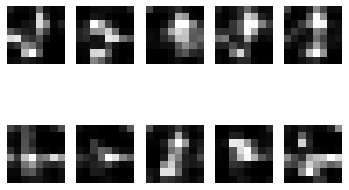

In [55]:
generate_plt()

In [0]:
torch.save(generator.state_dict(), "generatorCNN_eps0.01_4epochs.statedict")
torch.save(discriminator.state_dict(), "discriminatorCNN_eps0.01_4epochs.statedict")

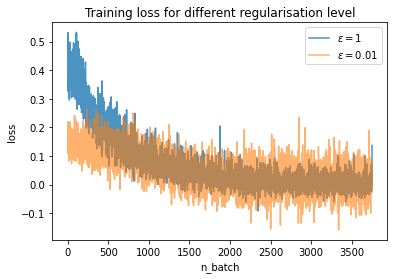

In [57]:
plt.plot(history, label = "$\epsilon = 1$", alpha=0.8)
plt.plot(history2, label = "$\epsilon = 0.01$", alpha=0.6)
plt.ylabel("loss")
plt.xlabel("n_batch")
plt.legend()
plt.title("Training loss for different regularisation level")
plt.show()

### Change batch size

In [33]:
img_size = trainset[0][0].size(1)
dim_gen = 16
dim_features_critics = 16

model_type = 'cnn'

if model_type == 'cnn':
    # Initialize CNN generator and discriminator
    generator = GeneratorCNN(dim_gen, img_size).to(device)
    discriminator = DiscriminatorCNN(img_size, dim_features_critics).to(device)

elif model_type == 'mlp':
    # Initialize MLP generator and discriminator
    generator = GeneratorMLP(dim_gen, img_size)
    discriminator = DiscriminatorMLP(img_size, dim_features_critics)

print(generator)
print(discriminator)

D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
G_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

GeneratorCNN(
  (linear_in): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(8, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Tanh()
  )
)
DiscriminatorCNN(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(16, eps=0.8, 

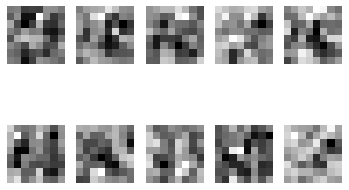

In [36]:
generate_plt()

========================Epoch: 1 / 4 =======================
Batch 1/3750 - Opimize D - Avg Batch Loss: 0.2054 - Time : 0.60s


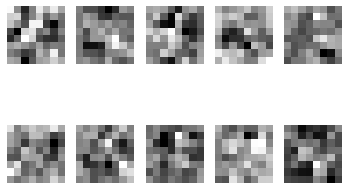

Batch 2/3750 - Opimize G - Avg Batch Loss: 0.2498 - Time : 0.40s
Batch 3/3750 - Opimize G - Avg Batch Loss: 0.3097 - Time : 0.35s
Batch 4/3750 - Opimize G - Avg Batch Loss: 0.2832 - Time : 0.35s
Batch 5/3750 - Opimize G - Avg Batch Loss: 0.2159 - Time : 0.36s
Batch 6/3750 - Opimize G - Avg Batch Loss: 0.3204 - Time : 0.39s
Batch 7/3750 - Opimize D - Avg Batch Loss: 0.3667 - Time : 0.38s
Batch 8/3750 - Opimize G - Avg Batch Loss: 0.4616 - Time : 0.36s
Batch 9/3750 - Opimize G - Avg Batch Loss: 0.2208 - Time : 0.37s
Batch 10/3750 - Opimize G - Avg Batch Loss: 0.3509 - Time : 0.37s
Batch 11/3750 - Opimize G - Avg Batch Loss: 0.2573 - Time : 0.37s
Batch 12/3750 - Opimize G - Avg Batch Loss: 0.4528 - Time : 0.37s
Batch 13/3750 - Opimize D - Avg Batch Loss: 0.2463 - Time : 0.37s
Batch 14/3750 - Opimize G - Avg Batch Loss: 0.3267 - Time : 0.36s
Batch 15/3750 - Opimize G - Avg Batch Loss: 0.2551 - Time : 0.36s
Batch 16/3750 - Opimize G - Avg Batch Loss: 0.3042 - Time : 0.38s
Batch 17/3750 - Op

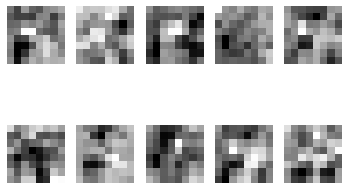

Batch 202/3750 - Opimize G - Avg Batch Loss: 0.0956 - Time : 0.37s
Batch 203/3750 - Opimize G - Avg Batch Loss: 0.2391 - Time : 0.38s
Batch 204/3750 - Opimize G - Avg Batch Loss: 0.1588 - Time : 0.40s
Batch 205/3750 - Opimize D - Avg Batch Loss: 0.2433 - Time : 0.38s
Batch 206/3750 - Opimize G - Avg Batch Loss: 0.4001 - Time : 0.38s
Batch 207/3750 - Opimize G - Avg Batch Loss: 0.2527 - Time : 0.38s
Batch 208/3750 - Opimize G - Avg Batch Loss: 0.1956 - Time : 0.37s
Batch 209/3750 - Opimize G - Avg Batch Loss: 0.1297 - Time : 0.37s
Batch 210/3750 - Opimize G - Avg Batch Loss: 0.2020 - Time : 0.36s
Batch 211/3750 - Opimize D - Avg Batch Loss: 0.1419 - Time : 0.35s
Batch 212/3750 - Opimize G - Avg Batch Loss: 0.3132 - Time : 0.39s
Batch 213/3750 - Opimize G - Avg Batch Loss: 0.2280 - Time : 0.36s
Batch 214/3750 - Opimize G - Avg Batch Loss: 0.1450 - Time : 0.38s
Batch 215/3750 - Opimize G - Avg Batch Loss: 0.3360 - Time : 0.38s
Batch 216/3750 - Opimize G - Avg Batch Loss: 0.1910 - Time : 0

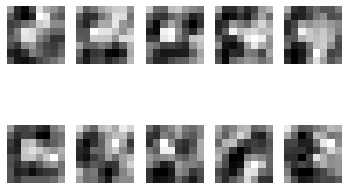

Batch 402/3750 - Opimize G - Avg Batch Loss: 0.0318 - Time : 0.38s
Batch 403/3750 - Opimize D - Avg Batch Loss: 0.0880 - Time : 0.37s
Batch 404/3750 - Opimize G - Avg Batch Loss: 0.1927 - Time : 0.37s
Batch 405/3750 - Opimize G - Avg Batch Loss: 0.1844 - Time : 0.37s
Batch 406/3750 - Opimize G - Avg Batch Loss: 0.1677 - Time : 0.37s
Batch 407/3750 - Opimize G - Avg Batch Loss: 0.2496 - Time : 0.39s
Batch 408/3750 - Opimize G - Avg Batch Loss: 0.0561 - Time : 0.37s
Batch 409/3750 - Opimize D - Avg Batch Loss: 0.1808 - Time : 0.37s
Batch 410/3750 - Opimize G - Avg Batch Loss: 0.4522 - Time : 0.38s
Batch 411/3750 - Opimize G - Avg Batch Loss: 0.1980 - Time : 0.36s
Batch 412/3750 - Opimize G - Avg Batch Loss: 0.0836 - Time : 0.38s
Batch 413/3750 - Opimize G - Avg Batch Loss: 0.1313 - Time : 0.38s
Batch 414/3750 - Opimize G - Avg Batch Loss: 0.1068 - Time : 0.38s
Batch 415/3750 - Opimize D - Avg Batch Loss: 0.1658 - Time : 0.39s
Batch 416/3750 - Opimize G - Avg Batch Loss: 0.1711 - Time : 0

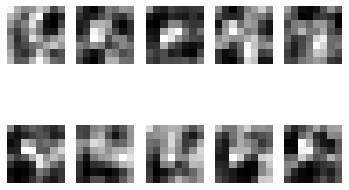

Batch 602/3750 - Opimize G - Avg Batch Loss: 0.1452 - Time : 0.37s
Batch 603/3750 - Opimize G - Avg Batch Loss: 0.1088 - Time : 0.36s
Batch 604/3750 - Opimize G - Avg Batch Loss: 0.0481 - Time : 0.38s
Batch 605/3750 - Opimize G - Avg Batch Loss: 0.1251 - Time : 0.36s
Batch 606/3750 - Opimize G - Avg Batch Loss: 0.1700 - Time : 0.36s
Batch 607/3750 - Opimize D - Avg Batch Loss: 0.0381 - Time : 0.38s
Batch 608/3750 - Opimize G - Avg Batch Loss: 0.1158 - Time : 0.37s
Batch 609/3750 - Opimize G - Avg Batch Loss: 0.1589 - Time : 0.36s
Batch 610/3750 - Opimize G - Avg Batch Loss: 0.1992 - Time : 0.38s
Batch 611/3750 - Opimize G - Avg Batch Loss: 0.0893 - Time : 0.37s
Batch 612/3750 - Opimize G - Avg Batch Loss: 0.0447 - Time : 0.37s
Batch 613/3750 - Opimize D - Avg Batch Loss: 0.0248 - Time : 0.37s
Batch 614/3750 - Opimize G - Avg Batch Loss: -0.0241 - Time : 0.36s
Batch 615/3750 - Opimize G - Avg Batch Loss: 0.0695 - Time : 0.40s
Batch 616/3750 - Opimize G - Avg Batch Loss: 0.0908 - Time : 

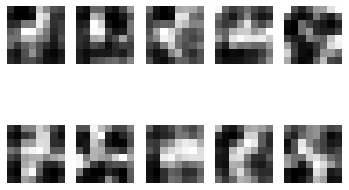

Batch 802/3750 - Opimize G - Avg Batch Loss: 0.0954 - Time : 0.39s
Batch 803/3750 - Opimize G - Avg Batch Loss: -0.0389 - Time : 0.36s
Batch 804/3750 - Opimize G - Avg Batch Loss: 0.0807 - Time : 0.38s
Batch 805/3750 - Opimize D - Avg Batch Loss: -0.0084 - Time : 0.37s
Batch 806/3750 - Opimize G - Avg Batch Loss: -0.0184 - Time : 0.37s
Batch 807/3750 - Opimize G - Avg Batch Loss: -0.0996 - Time : 0.39s
Batch 808/3750 - Opimize G - Avg Batch Loss: 0.1167 - Time : 0.37s
Batch 809/3750 - Opimize G - Avg Batch Loss: 0.0259 - Time : 0.41s
Batch 810/3750 - Opimize G - Avg Batch Loss: -0.0030 - Time : 0.39s
Batch 811/3750 - Opimize D - Avg Batch Loss: 0.0949 - Time : 0.35s
Batch 812/3750 - Opimize G - Avg Batch Loss: 0.0658 - Time : 0.37s
Batch 813/3750 - Opimize G - Avg Batch Loss: 0.1053 - Time : 0.38s
Batch 814/3750 - Opimize G - Avg Batch Loss: 0.1963 - Time : 0.37s
Batch 815/3750 - Opimize G - Avg Batch Loss: 0.0833 - Time : 0.37s
Batch 816/3750 - Opimize G - Avg Batch Loss: 0.2411 - Tim

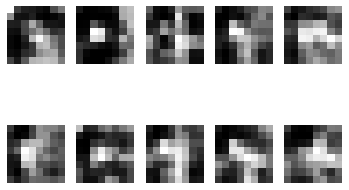

Batch 1002/3750 - Opimize G - Avg Batch Loss: 0.0004 - Time : 0.38s
Batch 1003/3750 - Opimize D - Avg Batch Loss: 0.0771 - Time : 0.37s
Batch 1004/3750 - Opimize G - Avg Batch Loss: -0.0171 - Time : 0.39s
Batch 1005/3750 - Opimize G - Avg Batch Loss: 0.0055 - Time : 0.39s
Batch 1006/3750 - Opimize G - Avg Batch Loss: -0.0616 - Time : 0.37s
Batch 1007/3750 - Opimize G - Avg Batch Loss: 0.0078 - Time : 0.38s
Batch 1008/3750 - Opimize G - Avg Batch Loss: 0.1673 - Time : 0.38s
Batch 1009/3750 - Opimize D - Avg Batch Loss: -0.0144 - Time : 0.37s
Batch 1010/3750 - Opimize G - Avg Batch Loss: -0.0463 - Time : 0.39s
Batch 1011/3750 - Opimize G - Avg Batch Loss: 0.0833 - Time : 0.37s
Batch 1012/3750 - Opimize G - Avg Batch Loss: 0.0248 - Time : 0.37s
Batch 1013/3750 - Opimize G - Avg Batch Loss: -0.0094 - Time : 0.39s
Batch 1014/3750 - Opimize G - Avg Batch Loss: -0.0660 - Time : 0.38s
Batch 1015/3750 - Opimize D - Avg Batch Loss: 0.0062 - Time : 0.38s
Batch 1016/3750 - Opimize G - Avg Batch Lo

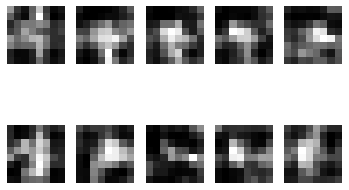

Batch 1202/3750 - Opimize G - Avg Batch Loss: 0.0102 - Time : 0.41s
Batch 1203/3750 - Opimize G - Avg Batch Loss: -0.0596 - Time : 0.37s
Batch 1204/3750 - Opimize G - Avg Batch Loss: -0.0804 - Time : 0.38s
Batch 1205/3750 - Opimize G - Avg Batch Loss: -0.0273 - Time : 0.38s
Batch 1206/3750 - Opimize G - Avg Batch Loss: 0.0635 - Time : 0.37s
Batch 1207/3750 - Opimize D - Avg Batch Loss: 0.0062 - Time : 0.37s
Batch 1208/3750 - Opimize G - Avg Batch Loss: 0.3050 - Time : 0.38s
Batch 1209/3750 - Opimize G - Avg Batch Loss: -0.0504 - Time : 0.38s
Batch 1210/3750 - Opimize G - Avg Batch Loss: -0.0057 - Time : 0.39s
Batch 1211/3750 - Opimize G - Avg Batch Loss: -0.0190 - Time : 0.38s
Batch 1212/3750 - Opimize G - Avg Batch Loss: -0.0318 - Time : 0.39s
Batch 1213/3750 - Opimize D - Avg Batch Loss: 0.0415 - Time : 0.38s
Batch 1214/3750 - Opimize G - Avg Batch Loss: -0.0022 - Time : 0.40s
Batch 1215/3750 - Opimize G - Avg Batch Loss: -0.0926 - Time : 0.37s
Batch 1216/3750 - Opimize G - Avg Batch

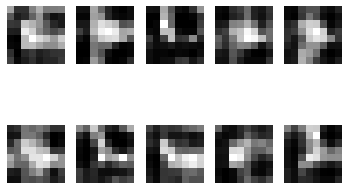

Batch 1402/3750 - Opimize G - Avg Batch Loss: 0.1041 - Time : 0.40s
Batch 1403/3750 - Opimize G - Avg Batch Loss: 0.0966 - Time : 0.39s
Batch 1404/3750 - Opimize G - Avg Batch Loss: -0.0301 - Time : 0.39s
Batch 1405/3750 - Opimize D - Avg Batch Loss: 0.1495 - Time : 0.37s
Batch 1406/3750 - Opimize G - Avg Batch Loss: 0.0389 - Time : 0.38s
Batch 1407/3750 - Opimize G - Avg Batch Loss: 0.2320 - Time : 0.38s
Batch 1408/3750 - Opimize G - Avg Batch Loss: 0.0382 - Time : 0.37s
Batch 1409/3750 - Opimize G - Avg Batch Loss: 0.0524 - Time : 0.39s
Batch 1410/3750 - Opimize G - Avg Batch Loss: -0.0174 - Time : 0.38s
Batch 1411/3750 - Opimize D - Avg Batch Loss: 0.0127 - Time : 0.38s
Batch 1412/3750 - Opimize G - Avg Batch Loss: -0.0721 - Time : 0.38s
Batch 1413/3750 - Opimize G - Avg Batch Loss: 0.1364 - Time : 0.37s
Batch 1414/3750 - Opimize G - Avg Batch Loss: -0.1403 - Time : 0.39s
Batch 1415/3750 - Opimize G - Avg Batch Loss: -0.1316 - Time : 0.39s
Batch 1416/3750 - Opimize G - Avg Batch Los

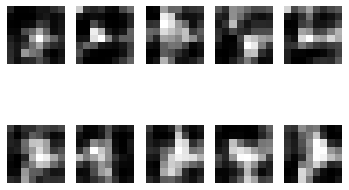

Batch 1602/3750 - Opimize G - Avg Batch Loss: 0.0927 - Time : 0.37s
Batch 1603/3750 - Opimize D - Avg Batch Loss: -0.0387 - Time : 0.38s
Batch 1604/3750 - Opimize G - Avg Batch Loss: -0.0787 - Time : 0.39s
Batch 1605/3750 - Opimize G - Avg Batch Loss: -0.1190 - Time : 0.37s
Batch 1606/3750 - Opimize G - Avg Batch Loss: 0.0249 - Time : 0.38s
Batch 1607/3750 - Opimize G - Avg Batch Loss: -0.0325 - Time : 0.39s
Batch 1608/3750 - Opimize G - Avg Batch Loss: 0.1146 - Time : 0.39s
Batch 1609/3750 - Opimize D - Avg Batch Loss: -0.0255 - Time : 0.37s
Batch 1610/3750 - Opimize G - Avg Batch Loss: -0.0954 - Time : 0.38s
Batch 1611/3750 - Opimize G - Avg Batch Loss: 0.2214 - Time : 0.38s
Batch 1612/3750 - Opimize G - Avg Batch Loss: 0.0194 - Time : 0.38s
Batch 1613/3750 - Opimize G - Avg Batch Loss: 0.0531 - Time : 0.37s
Batch 1614/3750 - Opimize G - Avg Batch Loss: -0.0335 - Time : 0.37s
Batch 1615/3750 - Opimize D - Avg Batch Loss: -0.0021 - Time : 0.40s
Batch 1616/3750 - Opimize G - Avg Batch 

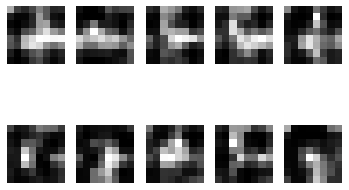

Batch 1802/3750 - Opimize G - Avg Batch Loss: -0.0428 - Time : 0.38s
Batch 1803/3750 - Opimize G - Avg Batch Loss: 0.0632 - Time : 0.38s
Batch 1804/3750 - Opimize G - Avg Batch Loss: 0.0087 - Time : 0.39s
Batch 1805/3750 - Opimize G - Avg Batch Loss: 0.0707 - Time : 0.37s
Batch 1806/3750 - Opimize G - Avg Batch Loss: 0.0990 - Time : 0.38s
Batch 1807/3750 - Opimize D - Avg Batch Loss: 0.2074 - Time : 0.38s
Batch 1808/3750 - Opimize G - Avg Batch Loss: -0.0920 - Time : 0.37s
Batch 1809/3750 - Opimize G - Avg Batch Loss: -0.0886 - Time : 0.38s
Batch 1810/3750 - Opimize G - Avg Batch Loss: 0.0427 - Time : 0.36s
Batch 1811/3750 - Opimize G - Avg Batch Loss: 0.0320 - Time : 0.39s
Batch 1812/3750 - Opimize G - Avg Batch Loss: -0.0693 - Time : 0.38s
Batch 1813/3750 - Opimize D - Avg Batch Loss: 0.0410 - Time : 0.37s
Batch 1814/3750 - Opimize G - Avg Batch Loss: 0.0022 - Time : 0.37s
Batch 1815/3750 - Opimize G - Avg Batch Loss: 0.0209 - Time : 0.40s
Batch 1816/3750 - Opimize G - Avg Batch Loss

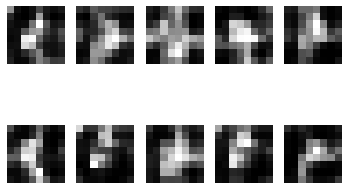

Batch 2002/3750 - Opimize G - Avg Batch Loss: 0.0414 - Time : 0.38s
Batch 2003/3750 - Opimize G - Avg Batch Loss: 0.1410 - Time : 0.38s
Batch 2004/3750 - Opimize G - Avg Batch Loss: -0.0881 - Time : 0.38s
Batch 2005/3750 - Opimize D - Avg Batch Loss: 0.0137 - Time : 0.36s
Batch 2006/3750 - Opimize G - Avg Batch Loss: -0.0406 - Time : 0.37s
Batch 2007/3750 - Opimize G - Avg Batch Loss: -0.0532 - Time : 0.39s
Batch 2008/3750 - Opimize G - Avg Batch Loss: -0.0556 - Time : 0.37s
Batch 2009/3750 - Opimize G - Avg Batch Loss: 0.0606 - Time : 0.39s
Batch 2010/3750 - Opimize G - Avg Batch Loss: 0.0352 - Time : 0.37s
Batch 2011/3750 - Opimize D - Avg Batch Loss: -0.0059 - Time : 0.37s
Batch 2012/3750 - Opimize G - Avg Batch Loss: -0.0434 - Time : 0.39s
Batch 2013/3750 - Opimize G - Avg Batch Loss: -0.0607 - Time : 0.37s
Batch 2014/3750 - Opimize G - Avg Batch Loss: -0.0863 - Time : 0.37s
Batch 2015/3750 - Opimize G - Avg Batch Loss: 0.0193 - Time : 0.39s
Batch 2016/3750 - Opimize G - Avg Batch 

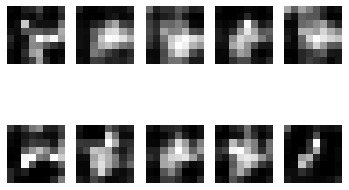

Batch 2202/3750 - Opimize G - Avg Batch Loss: -0.0240 - Time : 0.38s
Batch 2203/3750 - Opimize D - Avg Batch Loss: 0.0309 - Time : 0.36s
Batch 2204/3750 - Opimize G - Avg Batch Loss: -0.1048 - Time : 0.37s
Batch 2205/3750 - Opimize G - Avg Batch Loss: 0.0334 - Time : 0.37s
Batch 2206/3750 - Opimize G - Avg Batch Loss: -0.1074 - Time : 0.36s
Batch 2207/3750 - Opimize G - Avg Batch Loss: -0.0709 - Time : 0.38s
Batch 2208/3750 - Opimize G - Avg Batch Loss: -0.1328 - Time : 0.39s
Batch 2209/3750 - Opimize D - Avg Batch Loss: 0.0620 - Time : 0.37s
Batch 2210/3750 - Opimize G - Avg Batch Loss: -0.0668 - Time : 0.38s
Batch 2211/3750 - Opimize G - Avg Batch Loss: 0.0565 - Time : 0.37s
Batch 2212/3750 - Opimize G - Avg Batch Loss: -0.0028 - Time : 0.38s
Batch 2213/3750 - Opimize G - Avg Batch Loss: 0.0720 - Time : 0.38s
Batch 2214/3750 - Opimize G - Avg Batch Loss: 0.0351 - Time : 0.36s
Batch 2215/3750 - Opimize D - Avg Batch Loss: 0.0205 - Time : 0.38s
Batch 2216/3750 - Opimize G - Avg Batch L

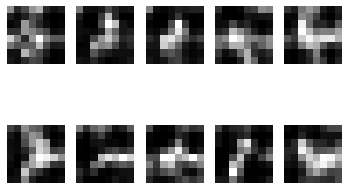

Batch 2402/3750 - Opimize G - Avg Batch Loss: 0.0813 - Time : 0.39s
Batch 2403/3750 - Opimize G - Avg Batch Loss: 0.0388 - Time : 0.36s
Batch 2404/3750 - Opimize G - Avg Batch Loss: -0.0729 - Time : 0.38s
Batch 2405/3750 - Opimize G - Avg Batch Loss: 0.0540 - Time : 0.38s
Batch 2406/3750 - Opimize G - Avg Batch Loss: 0.0450 - Time : 0.37s
Batch 2407/3750 - Opimize D - Avg Batch Loss: 0.0262 - Time : 0.37s
Batch 2408/3750 - Opimize G - Avg Batch Loss: 0.0698 - Time : 0.39s
Batch 2409/3750 - Opimize G - Avg Batch Loss: 0.1669 - Time : 0.39s
Batch 2410/3750 - Opimize G - Avg Batch Loss: -0.0394 - Time : 0.37s
Batch 2411/3750 - Opimize G - Avg Batch Loss: -0.0748 - Time : 0.36s
Batch 2412/3750 - Opimize G - Avg Batch Loss: 0.0567 - Time : 0.38s
Batch 2413/3750 - Opimize D - Avg Batch Loss: -0.0434 - Time : 0.38s
Batch 2414/3750 - Opimize G - Avg Batch Loss: 0.0620 - Time : 0.37s
Batch 2415/3750 - Opimize G - Avg Batch Loss: -0.0192 - Time : 0.38s
Batch 2416/3750 - Opimize G - Avg Batch Los

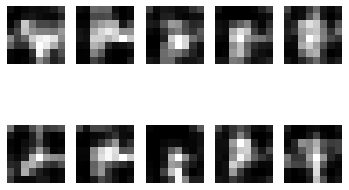

Batch 2602/3750 - Opimize G - Avg Batch Loss: 0.0094 - Time : 0.39s
Batch 2603/3750 - Opimize G - Avg Batch Loss: -0.1118 - Time : 0.37s
Batch 2604/3750 - Opimize G - Avg Batch Loss: -0.0951 - Time : 0.38s
Batch 2605/3750 - Opimize D - Avg Batch Loss: -0.1300 - Time : 0.38s
Batch 2606/3750 - Opimize G - Avg Batch Loss: 0.0542 - Time : 0.37s
Batch 2607/3750 - Opimize G - Avg Batch Loss: 0.0286 - Time : 0.39s
Batch 2608/3750 - Opimize G - Avg Batch Loss: -0.1342 - Time : 0.38s
Batch 2609/3750 - Opimize G - Avg Batch Loss: 0.0869 - Time : 0.37s
Batch 2610/3750 - Opimize G - Avg Batch Loss: 0.0085 - Time : 0.38s
Batch 2611/3750 - Opimize D - Avg Batch Loss: -0.0157 - Time : 0.36s
Batch 2612/3750 - Opimize G - Avg Batch Loss: -0.0267 - Time : 0.38s
Batch 2613/3750 - Opimize G - Avg Batch Loss: -0.1028 - Time : 0.37s
Batch 2614/3750 - Opimize G - Avg Batch Loss: 0.0379 - Time : 0.37s
Batch 2615/3750 - Opimize G - Avg Batch Loss: 0.0929 - Time : 0.40s
Batch 2616/3750 - Opimize G - Avg Batch L

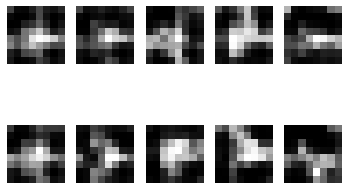

Batch 2802/3750 - Opimize G - Avg Batch Loss: 0.0347 - Time : 0.37s
Batch 2803/3750 - Opimize D - Avg Batch Loss: -0.0062 - Time : 0.36s
Batch 2804/3750 - Opimize G - Avg Batch Loss: -0.0245 - Time : 0.36s
Batch 2805/3750 - Opimize G - Avg Batch Loss: 0.2161 - Time : 0.36s
Batch 2806/3750 - Opimize G - Avg Batch Loss: -0.0622 - Time : 0.36s
Batch 2807/3750 - Opimize G - Avg Batch Loss: 0.0747 - Time : 0.37s
Batch 2808/3750 - Opimize G - Avg Batch Loss: -0.0935 - Time : 0.37s
Batch 2809/3750 - Opimize D - Avg Batch Loss: -0.0501 - Time : 0.36s
Batch 2810/3750 - Opimize G - Avg Batch Loss: 0.0863 - Time : 0.37s
Batch 2811/3750 - Opimize G - Avg Batch Loss: -0.1204 - Time : 0.38s
Batch 2812/3750 - Opimize G - Avg Batch Loss: -0.1086 - Time : 0.37s
Batch 2813/3750 - Opimize G - Avg Batch Loss: 0.0874 - Time : 0.37s
Batch 2814/3750 - Opimize G - Avg Batch Loss: 0.0279 - Time : 0.37s
Batch 2815/3750 - Opimize D - Avg Batch Loss: 0.0002 - Time : 0.38s
Batch 2816/3750 - Opimize G - Avg Batch L

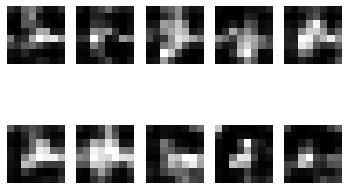

Batch 3002/3750 - Opimize G - Avg Batch Loss: 0.0558 - Time : 0.37s
Batch 3003/3750 - Opimize G - Avg Batch Loss: 0.1354 - Time : 0.37s
Batch 3004/3750 - Opimize G - Avg Batch Loss: -0.1355 - Time : 0.36s
Batch 3005/3750 - Opimize G - Avg Batch Loss: -0.1237 - Time : 0.37s
Batch 3006/3750 - Opimize G - Avg Batch Loss: -0.1205 - Time : 0.37s
Batch 3007/3750 - Opimize D - Avg Batch Loss: -0.0130 - Time : 0.38s
Batch 3008/3750 - Opimize G - Avg Batch Loss: 0.0397 - Time : 0.38s
Batch 3009/3750 - Opimize G - Avg Batch Loss: -0.0051 - Time : 0.37s
Batch 3010/3750 - Opimize G - Avg Batch Loss: -0.0752 - Time : 0.40s
Batch 3011/3750 - Opimize G - Avg Batch Loss: -0.1616 - Time : 0.38s
Batch 3012/3750 - Opimize G - Avg Batch Loss: 0.2189 - Time : 0.36s
Batch 3013/3750 - Opimize D - Avg Batch Loss: -0.0412 - Time : 0.39s
Batch 3014/3750 - Opimize G - Avg Batch Loss: -0.0357 - Time : 0.37s
Batch 3015/3750 - Opimize G - Avg Batch Loss: 0.1766 - Time : 0.37s
Batch 3016/3750 - Opimize G - Avg Batch

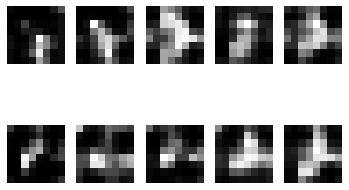

Batch 3202/3750 - Opimize G - Avg Batch Loss: 0.0017 - Time : 0.37s
Batch 3203/3750 - Opimize G - Avg Batch Loss: 0.0169 - Time : 0.38s
Batch 3204/3750 - Opimize G - Avg Batch Loss: 0.0585 - Time : 0.36s
Batch 3205/3750 - Opimize D - Avg Batch Loss: -0.1088 - Time : 0.38s
Batch 3206/3750 - Opimize G - Avg Batch Loss: 0.0087 - Time : 0.38s
Batch 3207/3750 - Opimize G - Avg Batch Loss: -0.0697 - Time : 0.39s
Batch 3208/3750 - Opimize G - Avg Batch Loss: 0.0982 - Time : 0.39s
Batch 3209/3750 - Opimize G - Avg Batch Loss: 0.1580 - Time : 0.38s
Batch 3210/3750 - Opimize G - Avg Batch Loss: 0.2002 - Time : 0.38s
Batch 3211/3750 - Opimize D - Avg Batch Loss: 0.0105 - Time : 0.38s
Batch 3212/3750 - Opimize G - Avg Batch Loss: 0.0787 - Time : 0.37s
Batch 3213/3750 - Opimize G - Avg Batch Loss: 0.1683 - Time : 0.40s
Batch 3214/3750 - Opimize G - Avg Batch Loss: 0.0362 - Time : 0.38s
Batch 3215/3750 - Opimize G - Avg Batch Loss: -0.0696 - Time : 0.37s
Batch 3216/3750 - Opimize G - Avg Batch Loss:

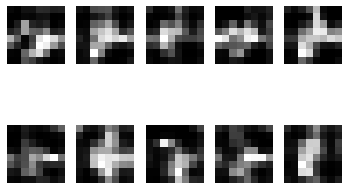

Batch 3402/3750 - Opimize G - Avg Batch Loss: -0.0857 - Time : 0.39s
Batch 3403/3750 - Opimize D - Avg Batch Loss: 0.0989 - Time : 0.36s
Batch 3404/3750 - Opimize G - Avg Batch Loss: 0.0671 - Time : 0.38s
Batch 3405/3750 - Opimize G - Avg Batch Loss: 0.0007 - Time : 0.38s
Batch 3406/3750 - Opimize G - Avg Batch Loss: -0.0321 - Time : 0.36s
Batch 3407/3750 - Opimize G - Avg Batch Loss: 0.1410 - Time : 0.37s
Batch 3408/3750 - Opimize G - Avg Batch Loss: -0.0269 - Time : 0.37s
Batch 3409/3750 - Opimize D - Avg Batch Loss: -0.3278 - Time : 0.38s
Batch 3410/3750 - Opimize G - Avg Batch Loss: 0.0159 - Time : 0.38s
Batch 3411/3750 - Opimize G - Avg Batch Loss: -0.0784 - Time : 0.37s
Batch 3412/3750 - Opimize G - Avg Batch Loss: 0.0070 - Time : 0.37s
Batch 3413/3750 - Opimize G - Avg Batch Loss: -0.0627 - Time : 0.38s
Batch 3414/3750 - Opimize G - Avg Batch Loss: -0.0663 - Time : 0.37s
Batch 3415/3750 - Opimize D - Avg Batch Loss: 0.0452 - Time : 0.37s
Batch 3416/3750 - Opimize G - Avg Batch L

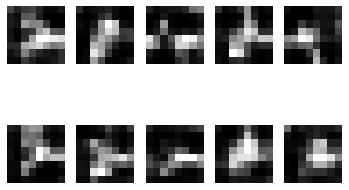

Batch 3602/3750 - Opimize G - Avg Batch Loss: -0.0586 - Time : 0.37s
Batch 3603/3750 - Opimize G - Avg Batch Loss: 0.1551 - Time : 0.37s
Batch 3604/3750 - Opimize G - Avg Batch Loss: 0.0520 - Time : 0.38s
Batch 3605/3750 - Opimize G - Avg Batch Loss: -0.0596 - Time : 0.37s
Batch 3606/3750 - Opimize G - Avg Batch Loss: -0.0883 - Time : 0.38s
Batch 3607/3750 - Opimize D - Avg Batch Loss: -0.0346 - Time : 0.38s
Batch 3608/3750 - Opimize G - Avg Batch Loss: 0.0111 - Time : 0.36s
Batch 3609/3750 - Opimize G - Avg Batch Loss: -0.0308 - Time : 0.38s
Batch 3610/3750 - Opimize G - Avg Batch Loss: -0.0434 - Time : 0.39s
Batch 3611/3750 - Opimize G - Avg Batch Loss: -0.0125 - Time : 0.38s
Batch 3612/3750 - Opimize G - Avg Batch Loss: 0.0730 - Time : 0.39s
Batch 3613/3750 - Opimize D - Avg Batch Loss: -0.0322 - Time : 0.36s
Batch 3614/3750 - Opimize G - Avg Batch Loss: 0.1354 - Time : 0.38s
Batch 3615/3750 - Opimize G - Avg Batch Loss: -0.0726 - Time : 0.38s
Batch 3616/3750 - Opimize G - Avg Batch

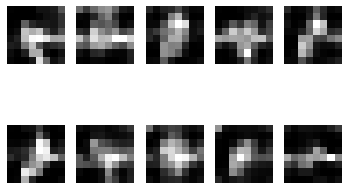

Batch 2/3750 - Opimize G - Avg Batch Loss: 0.0910 - Time : 0.37s
Batch 3/3750 - Opimize G - Avg Batch Loss: 0.0669 - Time : 0.38s
Batch 4/3750 - Opimize G - Avg Batch Loss: -0.0375 - Time : 0.40s
Batch 5/3750 - Opimize G - Avg Batch Loss: 0.0080 - Time : 0.37s
Batch 6/3750 - Opimize G - Avg Batch Loss: -0.1266 - Time : 0.39s
Batch 7/3750 - Opimize D - Avg Batch Loss: -0.2646 - Time : 0.37s
Batch 8/3750 - Opimize G - Avg Batch Loss: -0.0169 - Time : 0.36s
Batch 9/3750 - Opimize G - Avg Batch Loss: -0.0540 - Time : 0.38s
Batch 10/3750 - Opimize G - Avg Batch Loss: 0.1671 - Time : 0.37s
Batch 11/3750 - Opimize G - Avg Batch Loss: -0.0787 - Time : 0.38s
Batch 12/3750 - Opimize G - Avg Batch Loss: -0.0602 - Time : 0.37s
Batch 13/3750 - Opimize D - Avg Batch Loss: -0.0147 - Time : 0.37s
Batch 14/3750 - Opimize G - Avg Batch Loss: -0.0658 - Time : 0.39s
Batch 15/3750 - Opimize G - Avg Batch Loss: -0.0634 - Time : 0.37s
Batch 16/3750 - Opimize G - Avg Batch Loss: -0.0294 - Time : 0.38s
Batch 1

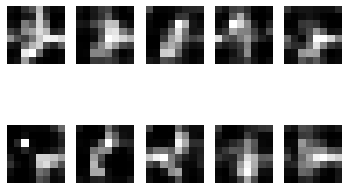

Batch 202/3750 - Opimize G - Avg Batch Loss: 0.0440 - Time : 0.38s
Batch 203/3750 - Opimize G - Avg Batch Loss: -0.0200 - Time : 0.36s
Batch 204/3750 - Opimize G - Avg Batch Loss: 0.0009 - Time : 0.36s
Batch 205/3750 - Opimize D - Avg Batch Loss: -0.1693 - Time : 0.39s
Batch 206/3750 - Opimize G - Avg Batch Loss: -0.2012 - Time : 0.37s
Batch 207/3750 - Opimize G - Avg Batch Loss: -0.0740 - Time : 0.39s
Batch 208/3750 - Opimize G - Avg Batch Loss: -0.0726 - Time : 0.39s
Batch 209/3750 - Opimize G - Avg Batch Loss: 0.0725 - Time : 0.37s
Batch 210/3750 - Opimize G - Avg Batch Loss: -0.0434 - Time : 0.39s
Batch 211/3750 - Opimize D - Avg Batch Loss: -0.0183 - Time : 0.37s
Batch 212/3750 - Opimize G - Avg Batch Loss: -0.0020 - Time : 0.37s
Batch 213/3750 - Opimize G - Avg Batch Loss: -0.0048 - Time : 0.38s
Batch 214/3750 - Opimize G - Avg Batch Loss: 0.0598 - Time : 0.38s
Batch 215/3750 - Opimize G - Avg Batch Loss: -0.1057 - Time : 0.39s
Batch 216/3750 - Opimize G - Avg Batch Loss: 0.0788 

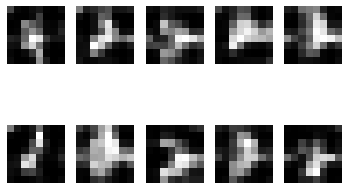

Batch 402/3750 - Opimize G - Avg Batch Loss: -0.0637 - Time : 0.38s
Batch 403/3750 - Opimize D - Avg Batch Loss: -0.0050 - Time : 0.37s
Batch 404/3750 - Opimize G - Avg Batch Loss: -0.0364 - Time : 0.40s
Batch 405/3750 - Opimize G - Avg Batch Loss: 0.0718 - Time : 0.37s
Batch 406/3750 - Opimize G - Avg Batch Loss: -0.0211 - Time : 0.37s
Batch 407/3750 - Opimize G - Avg Batch Loss: 0.0102 - Time : 0.40s
Batch 408/3750 - Opimize G - Avg Batch Loss: 0.1253 - Time : 0.37s
Batch 409/3750 - Opimize D - Avg Batch Loss: -0.0994 - Time : 0.36s
Batch 410/3750 - Opimize G - Avg Batch Loss: -0.0348 - Time : 0.39s
Batch 411/3750 - Opimize G - Avg Batch Loss: -0.1133 - Time : 0.37s
Batch 412/3750 - Opimize G - Avg Batch Loss: -0.0863 - Time : 0.39s
Batch 413/3750 - Opimize G - Avg Batch Loss: -0.1376 - Time : 0.37s
Batch 414/3750 - Opimize G - Avg Batch Loss: -0.0060 - Time : 0.37s
Batch 415/3750 - Opimize D - Avg Batch Loss: -0.0465 - Time : 0.39s
Batch 416/3750 - Opimize G - Avg Batch Loss: -0.001

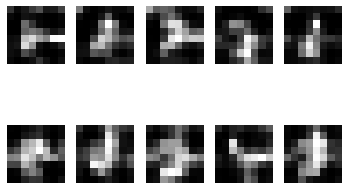

Batch 602/3750 - Opimize G - Avg Batch Loss: 0.0686 - Time : 0.36s
Batch 603/3750 - Opimize G - Avg Batch Loss: 0.2148 - Time : 0.39s
Batch 604/3750 - Opimize G - Avg Batch Loss: 0.0696 - Time : 0.37s
Batch 605/3750 - Opimize G - Avg Batch Loss: 0.0593 - Time : 0.38s
Batch 606/3750 - Opimize G - Avg Batch Loss: 0.0212 - Time : 0.41s
Batch 607/3750 - Opimize D - Avg Batch Loss: -0.0533 - Time : 0.37s
Batch 608/3750 - Opimize G - Avg Batch Loss: 0.1004 - Time : 0.38s
Batch 609/3750 - Opimize G - Avg Batch Loss: -0.0360 - Time : 0.37s
Batch 610/3750 - Opimize G - Avg Batch Loss: -0.0638 - Time : 0.36s
Batch 611/3750 - Opimize G - Avg Batch Loss: 0.1331 - Time : 0.39s
Batch 612/3750 - Opimize G - Avg Batch Loss: -0.0130 - Time : 0.37s
Batch 613/3750 - Opimize D - Avg Batch Loss: -0.0018 - Time : 0.37s
Batch 614/3750 - Opimize G - Avg Batch Loss: 0.0505 - Time : 0.40s
Batch 615/3750 - Opimize G - Avg Batch Loss: -0.0702 - Time : 0.36s
Batch 616/3750 - Opimize G - Avg Batch Loss: 0.0381 - Ti

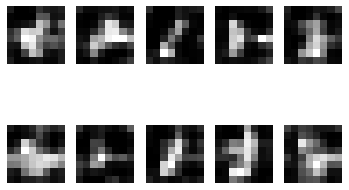

Batch 802/3750 - Opimize G - Avg Batch Loss: 0.0345 - Time : 0.38s
Batch 803/3750 - Opimize G - Avg Batch Loss: -0.0293 - Time : 0.37s
Batch 804/3750 - Opimize G - Avg Batch Loss: 0.0766 - Time : 0.39s
Batch 805/3750 - Opimize D - Avg Batch Loss: 0.0522 - Time : 0.37s
Batch 806/3750 - Opimize G - Avg Batch Loss: -0.0054 - Time : 0.38s
Batch 807/3750 - Opimize G - Avg Batch Loss: -0.1090 - Time : 0.39s
Batch 808/3750 - Opimize G - Avg Batch Loss: -0.0601 - Time : 0.37s
Batch 809/3750 - Opimize G - Avg Batch Loss: -0.0419 - Time : 0.38s
Batch 810/3750 - Opimize G - Avg Batch Loss: -0.1111 - Time : 0.38s
Batch 811/3750 - Opimize D - Avg Batch Loss: -0.0525 - Time : 0.36s
Batch 812/3750 - Opimize G - Avg Batch Loss: 0.0179 - Time : 0.39s
Batch 813/3750 - Opimize G - Avg Batch Loss: -0.0877 - Time : 0.36s
Batch 814/3750 - Opimize G - Avg Batch Loss: 0.0301 - Time : 0.36s
Batch 815/3750 - Opimize G - Avg Batch Loss: 0.0767 - Time : 0.39s
Batch 816/3750 - Opimize G - Avg Batch Loss: 0.0281 - 

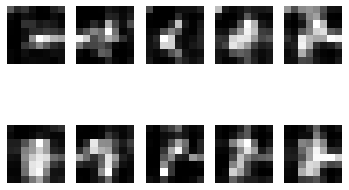

Batch 1002/3750 - Opimize G - Avg Batch Loss: -0.0401 - Time : 0.39s
Batch 1003/3750 - Opimize D - Avg Batch Loss: -0.1117 - Time : 0.37s
Batch 1004/3750 - Opimize G - Avg Batch Loss: 0.0219 - Time : 0.39s
Batch 1005/3750 - Opimize G - Avg Batch Loss: 0.0399 - Time : 0.35s
Batch 1006/3750 - Opimize G - Avg Batch Loss: 0.0009 - Time : 0.37s
Batch 1007/3750 - Opimize G - Avg Batch Loss: -0.0252 - Time : 0.39s
Batch 1008/3750 - Opimize G - Avg Batch Loss: 0.0335 - Time : 0.37s
Batch 1009/3750 - Opimize D - Avg Batch Loss: -0.0491 - Time : 0.38s
Batch 1010/3750 - Opimize G - Avg Batch Loss: 0.0448 - Time : 0.38s
Batch 1011/3750 - Opimize G - Avg Batch Loss: 0.0251 - Time : 0.36s
Batch 1012/3750 - Opimize G - Avg Batch Loss: -0.0073 - Time : 0.41s
Batch 1013/3750 - Opimize G - Avg Batch Loss: -0.1552 - Time : 0.36s
Batch 1014/3750 - Opimize G - Avg Batch Loss: 0.0691 - Time : 0.36s
Batch 1015/3750 - Opimize D - Avg Batch Loss: -0.0358 - Time : 0.39s
Batch 1016/3750 - Opimize G - Avg Batch L

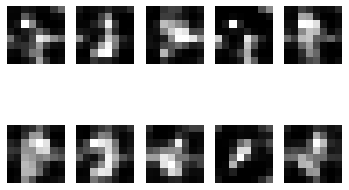

Batch 1202/3750 - Opimize G - Avg Batch Loss: 0.0137 - Time : 0.39s
Batch 1203/3750 - Opimize G - Avg Batch Loss: 0.0138 - Time : 0.38s
Batch 1204/3750 - Opimize G - Avg Batch Loss: -0.0157 - Time : 0.38s
Batch 1205/3750 - Opimize G - Avg Batch Loss: 0.0094 - Time : 0.38s
Batch 1206/3750 - Opimize G - Avg Batch Loss: 0.1303 - Time : 0.36s
Batch 1207/3750 - Opimize D - Avg Batch Loss: 0.1059 - Time : 0.37s
Batch 1208/3750 - Opimize G - Avg Batch Loss: -0.0312 - Time : 0.38s
Batch 1209/3750 - Opimize G - Avg Batch Loss: -0.1057 - Time : 0.37s
Batch 1210/3750 - Opimize G - Avg Batch Loss: -0.0527 - Time : 0.39s
Batch 1211/3750 - Opimize G - Avg Batch Loss: -0.0302 - Time : 0.38s
Batch 1212/3750 - Opimize G - Avg Batch Loss: -0.0488 - Time : 0.37s
Batch 1213/3750 - Opimize D - Avg Batch Loss: 0.1121 - Time : 0.40s
Batch 1214/3750 - Opimize G - Avg Batch Loss: 0.0489 - Time : 0.36s
Batch 1215/3750 - Opimize G - Avg Batch Loss: -0.0037 - Time : 0.36s
Batch 1216/3750 - Opimize G - Avg Batch L

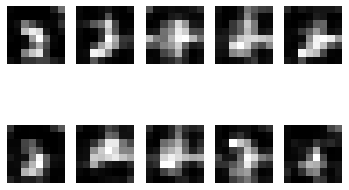

Batch 1402/3750 - Opimize G - Avg Batch Loss: -0.0360 - Time : 0.37s
Batch 1403/3750 - Opimize G - Avg Batch Loss: 0.0542 - Time : 0.39s
Batch 1404/3750 - Opimize G - Avg Batch Loss: 0.0220 - Time : 0.36s
Batch 1405/3750 - Opimize D - Avg Batch Loss: -0.0454 - Time : 0.36s
Batch 1406/3750 - Opimize G - Avg Batch Loss: 0.1015 - Time : 0.39s
Batch 1407/3750 - Opimize G - Avg Batch Loss: 0.0016 - Time : 0.38s
Batch 1408/3750 - Opimize G - Avg Batch Loss: -0.0419 - Time : 0.38s
Batch 1409/3750 - Opimize G - Avg Batch Loss: 0.1595 - Time : 0.37s
Batch 1410/3750 - Opimize G - Avg Batch Loss: -0.0884 - Time : 0.35s
Batch 1411/3750 - Opimize D - Avg Batch Loss: 0.0855 - Time : 0.36s
Batch 1412/3750 - Opimize G - Avg Batch Loss: -0.0376 - Time : 0.38s
Batch 1413/3750 - Opimize G - Avg Batch Loss: 0.0680 - Time : 0.36s
Batch 1414/3750 - Opimize G - Avg Batch Loss: -0.0826 - Time : 0.38s
Batch 1415/3750 - Opimize G - Avg Batch Loss: 0.0630 - Time : 0.37s
Batch 1416/3750 - Opimize G - Avg Batch Lo

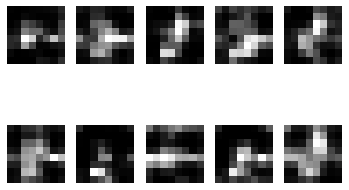

Batch 1602/3750 - Opimize G - Avg Batch Loss: -0.0383 - Time : 0.37s
Batch 1603/3750 - Opimize D - Avg Batch Loss: 0.0177 - Time : 0.36s
Batch 1604/3750 - Opimize G - Avg Batch Loss: -0.0763 - Time : 0.38s
Batch 1605/3750 - Opimize G - Avg Batch Loss: 0.0035 - Time : 0.39s
Batch 1606/3750 - Opimize G - Avg Batch Loss: -0.0175 - Time : 0.37s
Batch 1607/3750 - Opimize G - Avg Batch Loss: -0.0043 - Time : 0.39s
Batch 1608/3750 - Opimize G - Avg Batch Loss: 0.1873 - Time : 0.38s
Batch 1609/3750 - Opimize D - Avg Batch Loss: 0.1832 - Time : 0.40s
Batch 1610/3750 - Opimize G - Avg Batch Loss: 0.0039 - Time : 0.37s
Batch 1611/3750 - Opimize G - Avg Batch Loss: 0.0033 - Time : 0.39s
Batch 1612/3750 - Opimize G - Avg Batch Loss: 0.0333 - Time : 0.39s
Batch 1613/3750 - Opimize G - Avg Batch Loss: -0.0508 - Time : 0.37s
Batch 1614/3750 - Opimize G - Avg Batch Loss: -0.0992 - Time : 0.38s
Batch 1615/3750 - Opimize D - Avg Batch Loss: -0.0604 - Time : 0.39s
Batch 1616/3750 - Opimize G - Avg Batch L

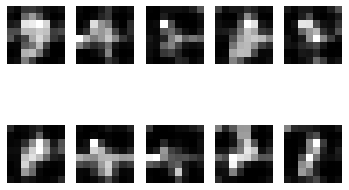

Batch 1802/3750 - Opimize G - Avg Batch Loss: 0.0277 - Time : 0.37s
Batch 1803/3750 - Opimize G - Avg Batch Loss: -0.1165 - Time : 0.39s
Batch 1804/3750 - Opimize G - Avg Batch Loss: -0.0916 - Time : 0.39s
Batch 1805/3750 - Opimize G - Avg Batch Loss: -0.0120 - Time : 0.38s
Batch 1806/3750 - Opimize G - Avg Batch Loss: 0.0775 - Time : 0.39s
Batch 1807/3750 - Opimize D - Avg Batch Loss: -0.0107 - Time : 0.37s
Batch 1808/3750 - Opimize G - Avg Batch Loss: 0.0967 - Time : 0.37s
Batch 1809/3750 - Opimize G - Avg Batch Loss: 0.0942 - Time : 0.40s
Batch 1810/3750 - Opimize G - Avg Batch Loss: 0.0005 - Time : 0.37s
Batch 1811/3750 - Opimize G - Avg Batch Loss: 0.0537 - Time : 0.36s
Batch 1812/3750 - Opimize G - Avg Batch Loss: 0.1097 - Time : 0.39s
Batch 1813/3750 - Opimize D - Avg Batch Loss: 0.0680 - Time : 0.37s
Batch 1814/3750 - Opimize G - Avg Batch Loss: -0.0998 - Time : 0.38s
Batch 1815/3750 - Opimize G - Avg Batch Loss: 0.0210 - Time : 0.38s
Batch 1816/3750 - Opimize G - Avg Batch Los

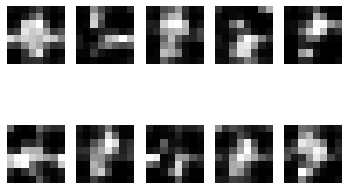

Batch 2002/3750 - Opimize G - Avg Batch Loss: -0.1006 - Time : 0.40s
Batch 2003/3750 - Opimize G - Avg Batch Loss: -0.1474 - Time : 0.36s
Batch 2004/3750 - Opimize G - Avg Batch Loss: 0.1292 - Time : 0.38s
Batch 2005/3750 - Opimize D - Avg Batch Loss: 0.1447 - Time : 0.37s
Batch 2006/3750 - Opimize G - Avg Batch Loss: 0.0083 - Time : 0.36s
Batch 2007/3750 - Opimize G - Avg Batch Loss: -0.0128 - Time : 0.38s
Batch 2008/3750 - Opimize G - Avg Batch Loss: 0.0547 - Time : 0.37s
Batch 2009/3750 - Opimize G - Avg Batch Loss: 0.0933 - Time : 0.39s
Batch 2010/3750 - Opimize G - Avg Batch Loss: -0.0686 - Time : 0.38s
Batch 2011/3750 - Opimize D - Avg Batch Loss: 0.0453 - Time : 0.36s
Batch 2012/3750 - Opimize G - Avg Batch Loss: -0.0498 - Time : 0.38s
Batch 2013/3750 - Opimize G - Avg Batch Loss: 0.0570 - Time : 0.38s
Batch 2014/3750 - Opimize G - Avg Batch Loss: 0.0338 - Time : 0.38s
Batch 2015/3750 - Opimize G - Avg Batch Loss: 0.0877 - Time : 0.40s
Batch 2016/3750 - Opimize G - Avg Batch Los

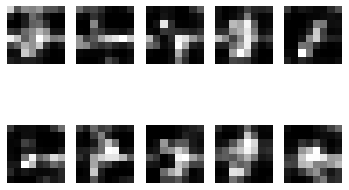

Batch 2202/3750 - Opimize G - Avg Batch Loss: -0.0189 - Time : 0.37s
Batch 2203/3750 - Opimize D - Avg Batch Loss: -0.0131 - Time : 0.41s
Batch 2204/3750 - Opimize G - Avg Batch Loss: 0.0855 - Time : 0.38s
Batch 2205/3750 - Opimize G - Avg Batch Loss: 0.0337 - Time : 0.38s
Batch 2206/3750 - Opimize G - Avg Batch Loss: -0.0669 - Time : 0.37s
Batch 2207/3750 - Opimize G - Avg Batch Loss: 0.0012 - Time : 0.37s
Batch 2208/3750 - Opimize G - Avg Batch Loss: -0.0058 - Time : 0.37s
Batch 2209/3750 - Opimize D - Avg Batch Loss: -0.0052 - Time : 0.36s
Batch 2210/3750 - Opimize G - Avg Batch Loss: 0.1383 - Time : 0.37s
Batch 2211/3750 - Opimize G - Avg Batch Loss: -0.0194 - Time : 0.38s
Batch 2212/3750 - Opimize G - Avg Batch Loss: 0.0605 - Time : 0.37s
Batch 2213/3750 - Opimize G - Avg Batch Loss: -0.0724 - Time : 0.39s
Batch 2214/3750 - Opimize G - Avg Batch Loss: -0.0009 - Time : 0.38s
Batch 2215/3750 - Opimize D - Avg Batch Loss: -0.0134 - Time : 0.38s
Batch 2216/3750 - Opimize G - Avg Batch

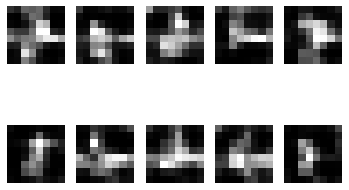

Batch 2402/3750 - Opimize G - Avg Batch Loss: 0.0611 - Time : 0.37s
Batch 2403/3750 - Opimize G - Avg Batch Loss: -0.0452 - Time : 0.39s
Batch 2404/3750 - Opimize G - Avg Batch Loss: 0.1049 - Time : 0.36s
Batch 2405/3750 - Opimize G - Avg Batch Loss: 0.0065 - Time : 0.37s
Batch 2406/3750 - Opimize G - Avg Batch Loss: -0.0518 - Time : 0.38s
Batch 2407/3750 - Opimize D - Avg Batch Loss: 0.0564 - Time : 0.36s
Batch 2408/3750 - Opimize G - Avg Batch Loss: 0.1350 - Time : 0.36s
Batch 2409/3750 - Opimize G - Avg Batch Loss: -0.0099 - Time : 0.40s
Batch 2410/3750 - Opimize G - Avg Batch Loss: 0.0628 - Time : 0.37s
Batch 2411/3750 - Opimize G - Avg Batch Loss: -0.0075 - Time : 0.37s
Batch 2412/3750 - Opimize G - Avg Batch Loss: -0.0227 - Time : 0.36s
Batch 2413/3750 - Opimize D - Avg Batch Loss: 0.0616 - Time : 0.37s
Batch 2414/3750 - Opimize G - Avg Batch Loss: 0.0849 - Time : 0.37s
Batch 2415/3750 - Opimize G - Avg Batch Loss: 0.0344 - Time : 0.36s
Batch 2416/3750 - Opimize G - Avg Batch Los

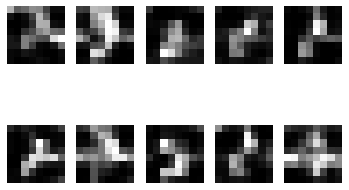

Batch 2602/3750 - Opimize G - Avg Batch Loss: 0.0958 - Time : 0.37s
Batch 2603/3750 - Opimize G - Avg Batch Loss: -0.0414 - Time : 0.37s
Batch 2604/3750 - Opimize G - Avg Batch Loss: 0.0560 - Time : 0.37s
Batch 2605/3750 - Opimize D - Avg Batch Loss: -0.0539 - Time : 0.39s
Batch 2606/3750 - Opimize G - Avg Batch Loss: -0.0826 - Time : 0.37s
Batch 2607/3750 - Opimize G - Avg Batch Loss: 0.1572 - Time : 0.37s
Batch 2608/3750 - Opimize G - Avg Batch Loss: 0.1772 - Time : 0.41s
Batch 2609/3750 - Opimize G - Avg Batch Loss: -0.0815 - Time : 0.37s
Batch 2610/3750 - Opimize G - Avg Batch Loss: 0.0858 - Time : 0.41s
Batch 2611/3750 - Opimize D - Avg Batch Loss: -0.1198 - Time : 0.37s
Batch 2612/3750 - Opimize G - Avg Batch Loss: -0.1796 - Time : 0.37s
Batch 2613/3750 - Opimize G - Avg Batch Loss: 0.0006 - Time : 0.39s
Batch 2614/3750 - Opimize G - Avg Batch Loss: 0.0115 - Time : 0.38s
Batch 2615/3750 - Opimize G - Avg Batch Loss: -0.0120 - Time : 0.38s
Batch 2616/3750 - Opimize G - Avg Batch L

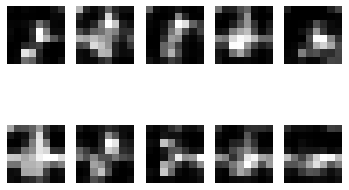

Batch 2802/3750 - Opimize G - Avg Batch Loss: -0.1787 - Time : 0.40s
Batch 2803/3750 - Opimize D - Avg Batch Loss: 0.0581 - Time : 0.39s
Batch 2804/3750 - Opimize G - Avg Batch Loss: 0.1590 - Time : 0.39s
Batch 2805/3750 - Opimize G - Avg Batch Loss: 0.0027 - Time : 0.39s
Batch 2806/3750 - Opimize G - Avg Batch Loss: -0.0635 - Time : 0.39s
Batch 2807/3750 - Opimize G - Avg Batch Loss: -0.0034 - Time : 0.38s
Batch 2808/3750 - Opimize G - Avg Batch Loss: -0.1205 - Time : 0.39s
Batch 2809/3750 - Opimize D - Avg Batch Loss: -0.0864 - Time : 0.37s
Batch 2810/3750 - Opimize G - Avg Batch Loss: 0.3044 - Time : 0.40s
Batch 2811/3750 - Opimize G - Avg Batch Loss: -0.0282 - Time : 0.37s
Batch 2812/3750 - Opimize G - Avg Batch Loss: -0.1660 - Time : 0.37s
Batch 2813/3750 - Opimize G - Avg Batch Loss: -0.0267 - Time : 0.38s
Batch 2814/3750 - Opimize G - Avg Batch Loss: 0.0085 - Time : 0.38s
Batch 2815/3750 - Opimize D - Avg Batch Loss: -0.0827 - Time : 0.36s
Batch 2816/3750 - Opimize G - Avg Batch

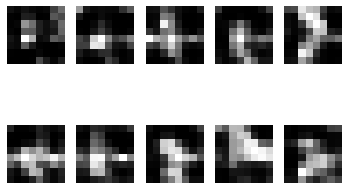

Batch 3002/3750 - Opimize G - Avg Batch Loss: 0.0133 - Time : 0.36s
Batch 3003/3750 - Opimize G - Avg Batch Loss: 0.0440 - Time : 0.40s
Batch 3004/3750 - Opimize G - Avg Batch Loss: 0.0259 - Time : 0.37s
Batch 3005/3750 - Opimize G - Avg Batch Loss: 0.0009 - Time : 0.38s
Batch 3006/3750 - Opimize G - Avg Batch Loss: 0.0537 - Time : 0.38s
Batch 3007/3750 - Opimize D - Avg Batch Loss: -0.0618 - Time : 0.37s
Batch 3008/3750 - Opimize G - Avg Batch Loss: 0.0255 - Time : 0.39s
Batch 3009/3750 - Opimize G - Avg Batch Loss: 0.0984 - Time : 0.37s
Batch 3010/3750 - Opimize G - Avg Batch Loss: 0.0025 - Time : 0.38s
Batch 3011/3750 - Opimize G - Avg Batch Loss: -0.1433 - Time : 0.38s
Batch 3012/3750 - Opimize G - Avg Batch Loss: -0.0031 - Time : 0.37s
Batch 3013/3750 - Opimize D - Avg Batch Loss: 0.1038 - Time : 0.35s
Batch 3014/3750 - Opimize G - Avg Batch Loss: 0.0911 - Time : 0.39s
Batch 3015/3750 - Opimize G - Avg Batch Loss: 0.2082 - Time : 0.36s
Batch 3016/3750 - Opimize G - Avg Batch Loss:

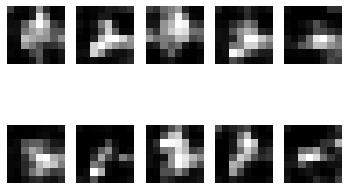

Batch 3202/3750 - Opimize G - Avg Batch Loss: 0.0429 - Time : 0.36s
Batch 3203/3750 - Opimize G - Avg Batch Loss: -0.0104 - Time : 0.38s
Batch 3204/3750 - Opimize G - Avg Batch Loss: 0.0934 - Time : 0.36s
Batch 3205/3750 - Opimize D - Avg Batch Loss: -0.0395 - Time : 0.36s
Batch 3206/3750 - Opimize G - Avg Batch Loss: -0.0600 - Time : 0.39s
Batch 3207/3750 - Opimize G - Avg Batch Loss: 0.0155 - Time : 0.37s
Batch 3208/3750 - Opimize G - Avg Batch Loss: 0.0108 - Time : 0.39s
Batch 3209/3750 - Opimize G - Avg Batch Loss: -0.2226 - Time : 0.39s
Batch 3210/3750 - Opimize G - Avg Batch Loss: -0.1916 - Time : 0.37s
Batch 3211/3750 - Opimize D - Avg Batch Loss: -0.0339 - Time : 0.39s
Batch 3212/3750 - Opimize G - Avg Batch Loss: -0.0149 - Time : 0.37s
Batch 3213/3750 - Opimize G - Avg Batch Loss: -0.0363 - Time : 0.36s
Batch 3214/3750 - Opimize G - Avg Batch Loss: -0.0285 - Time : 0.38s
Batch 3215/3750 - Opimize G - Avg Batch Loss: -0.1425 - Time : 0.37s
Batch 3216/3750 - Opimize G - Avg Batc

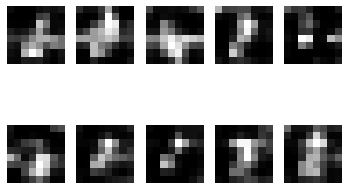

Batch 3402/3750 - Opimize G - Avg Batch Loss: -0.1932 - Time : 0.37s
Batch 3403/3750 - Opimize D - Avg Batch Loss: -0.1686 - Time : 0.36s
Batch 3404/3750 - Opimize G - Avg Batch Loss: -0.1461 - Time : 0.41s
Batch 3405/3750 - Opimize G - Avg Batch Loss: 0.0415 - Time : 0.37s
Batch 3406/3750 - Opimize G - Avg Batch Loss: 0.0364 - Time : 0.38s
Batch 3407/3750 - Opimize G - Avg Batch Loss: -0.1160 - Time : 0.39s
Batch 3408/3750 - Opimize G - Avg Batch Loss: -0.0471 - Time : 0.36s
Batch 3409/3750 - Opimize D - Avg Batch Loss: 0.1358 - Time : 0.38s
Batch 3410/3750 - Opimize G - Avg Batch Loss: 0.0761 - Time : 0.37s
Batch 3411/3750 - Opimize G - Avg Batch Loss: -0.1603 - Time : 0.38s
Batch 3412/3750 - Opimize G - Avg Batch Loss: -0.0266 - Time : 0.39s
Batch 3413/3750 - Opimize G - Avg Batch Loss: -0.0857 - Time : 0.36s
Batch 3414/3750 - Opimize G - Avg Batch Loss: -0.0230 - Time : 0.38s
Batch 3415/3750 - Opimize D - Avg Batch Loss: -0.0041 - Time : 0.40s
Batch 3416/3750 - Opimize G - Avg Batc

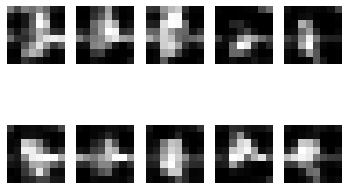

Batch 3602/3750 - Opimize G - Avg Batch Loss: -0.1133 - Time : 0.40s
Batch 3603/3750 - Opimize G - Avg Batch Loss: 0.0366 - Time : 0.37s
Batch 3604/3750 - Opimize G - Avg Batch Loss: 0.1272 - Time : 0.37s
Batch 3605/3750 - Opimize G - Avg Batch Loss: 0.0264 - Time : 0.39s
Batch 3606/3750 - Opimize G - Avg Batch Loss: 0.1698 - Time : 0.38s
Batch 3607/3750 - Opimize D - Avg Batch Loss: -0.0804 - Time : 0.39s
Batch 3608/3750 - Opimize G - Avg Batch Loss: 0.0537 - Time : 0.38s
Batch 3609/3750 - Opimize G - Avg Batch Loss: 0.0293 - Time : 0.38s
Batch 3610/3750 - Opimize G - Avg Batch Loss: -0.0356 - Time : 0.39s
Batch 3611/3750 - Opimize G - Avg Batch Loss: 0.0092 - Time : 0.37s
Batch 3612/3750 - Opimize G - Avg Batch Loss: 0.1439 - Time : 0.37s
Batch 3613/3750 - Opimize D - Avg Batch Loss: 0.0247 - Time : 0.39s
Batch 3614/3750 - Opimize G - Avg Batch Loss: 0.0246 - Time : 0.38s
Batch 3615/3750 - Opimize G - Avg Batch Loss: 0.0424 - Time : 0.40s
Batch 3616/3750 - Opimize G - Avg Batch Loss:

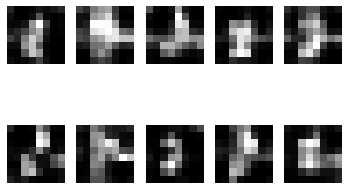

Batch 2/3750 - Opimize G - Avg Batch Loss: 0.0666 - Time : 0.38s
Batch 3/3750 - Opimize G - Avg Batch Loss: -0.0997 - Time : 0.38s
Batch 4/3750 - Opimize G - Avg Batch Loss: 0.0101 - Time : 0.37s
Batch 5/3750 - Opimize G - Avg Batch Loss: -0.0587 - Time : 0.40s
Batch 6/3750 - Opimize G - Avg Batch Loss: -0.0674 - Time : 0.37s
Batch 7/3750 - Opimize D - Avg Batch Loss: 0.1784 - Time : 0.37s
Batch 8/3750 - Opimize G - Avg Batch Loss: -0.1973 - Time : 0.39s
Batch 9/3750 - Opimize G - Avg Batch Loss: -0.0564 - Time : 0.36s
Batch 10/3750 - Opimize G - Avg Batch Loss: -0.0000 - Time : 0.38s
Batch 11/3750 - Opimize G - Avg Batch Loss: 0.0208 - Time : 0.37s
Batch 12/3750 - Opimize G - Avg Batch Loss: 0.0898 - Time : 0.38s
Batch 13/3750 - Opimize D - Avg Batch Loss: 0.0466 - Time : 0.38s
Batch 14/3750 - Opimize G - Avg Batch Loss: -0.0017 - Time : 0.37s
Batch 15/3750 - Opimize G - Avg Batch Loss: 0.0414 - Time : 0.38s
Batch 16/3750 - Opimize G - Avg Batch Loss: -0.0681 - Time : 0.39s
Batch 17/3

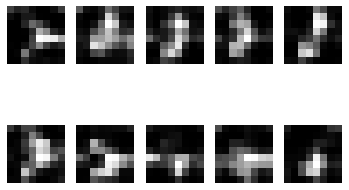

Batch 202/3750 - Opimize G - Avg Batch Loss: 0.0079 - Time : 0.37s
Batch 203/3750 - Opimize G - Avg Batch Loss: -0.1178 - Time : 0.39s
Batch 204/3750 - Opimize G - Avg Batch Loss: 0.0443 - Time : 0.38s
Batch 205/3750 - Opimize D - Avg Batch Loss: 0.0708 - Time : 0.37s
Batch 206/3750 - Opimize G - Avg Batch Loss: 0.0456 - Time : 0.38s
Batch 207/3750 - Opimize G - Avg Batch Loss: -0.0960 - Time : 0.38s
Batch 208/3750 - Opimize G - Avg Batch Loss: -0.1253 - Time : 0.38s
Batch 209/3750 - Opimize G - Avg Batch Loss: -0.0428 - Time : 0.40s
Batch 210/3750 - Opimize G - Avg Batch Loss: -0.1250 - Time : 0.36s
Batch 211/3750 - Opimize D - Avg Batch Loss: -0.1387 - Time : 0.38s
Batch 212/3750 - Opimize G - Avg Batch Loss: 0.0941 - Time : 0.38s
Batch 213/3750 - Opimize G - Avg Batch Loss: -0.0634 - Time : 0.37s
Batch 214/3750 - Opimize G - Avg Batch Loss: -0.1463 - Time : 0.39s
Batch 215/3750 - Opimize G - Avg Batch Loss: -0.1121 - Time : 0.39s
Batch 216/3750 - Opimize G - Avg Batch Loss: 0.0008 -

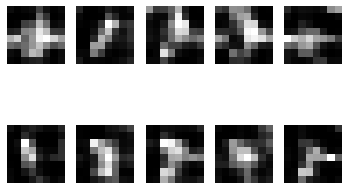

Batch 402/3750 - Opimize G - Avg Batch Loss: -0.1245 - Time : 0.38s
Batch 403/3750 - Opimize D - Avg Batch Loss: 0.0462 - Time : 0.38s
Batch 404/3750 - Opimize G - Avg Batch Loss: 0.0191 - Time : 0.38s
Batch 405/3750 - Opimize G - Avg Batch Loss: 0.0101 - Time : 0.37s
Batch 406/3750 - Opimize G - Avg Batch Loss: -0.0316 - Time : 0.39s
Batch 407/3750 - Opimize G - Avg Batch Loss: 0.1131 - Time : 0.37s
Batch 408/3750 - Opimize G - Avg Batch Loss: -0.0983 - Time : 0.38s
Batch 409/3750 - Opimize D - Avg Batch Loss: 0.0294 - Time : 0.39s
Batch 410/3750 - Opimize G - Avg Batch Loss: 0.0409 - Time : 0.37s
Batch 411/3750 - Opimize G - Avg Batch Loss: -0.2562 - Time : 0.39s
Batch 412/3750 - Opimize G - Avg Batch Loss: 0.0114 - Time : 0.37s
Batch 413/3750 - Opimize G - Avg Batch Loss: -0.0499 - Time : 0.39s
Batch 414/3750 - Opimize G - Avg Batch Loss: -0.0637 - Time : 0.38s
Batch 415/3750 - Opimize D - Avg Batch Loss: -0.2521 - Time : 0.38s
Batch 416/3750 - Opimize G - Avg Batch Loss: -0.1079 - 

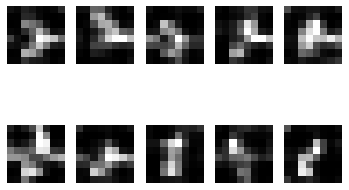

Batch 602/3750 - Opimize G - Avg Batch Loss: 0.0243 - Time : 0.37s
Batch 603/3750 - Opimize G - Avg Batch Loss: 0.0776 - Time : 0.37s
Batch 604/3750 - Opimize G - Avg Batch Loss: 0.0375 - Time : 0.39s
Batch 605/3750 - Opimize G - Avg Batch Loss: 0.1339 - Time : 0.39s
Batch 606/3750 - Opimize G - Avg Batch Loss: -0.0385 - Time : 0.37s
Batch 607/3750 - Opimize D - Avg Batch Loss: -0.0267 - Time : 0.39s
Batch 608/3750 - Opimize G - Avg Batch Loss: 0.0654 - Time : 0.37s
Batch 609/3750 - Opimize G - Avg Batch Loss: 0.1560 - Time : 0.39s
Batch 610/3750 - Opimize G - Avg Batch Loss: 0.0810 - Time : 0.37s
Batch 611/3750 - Opimize G - Avg Batch Loss: -0.0328 - Time : 0.38s
Batch 612/3750 - Opimize G - Avg Batch Loss: -0.0195 - Time : 0.38s
Batch 613/3750 - Opimize D - Avg Batch Loss: -0.0318 - Time : 0.39s
Batch 614/3750 - Opimize G - Avg Batch Loss: -0.1222 - Time : 0.37s
Batch 615/3750 - Opimize G - Avg Batch Loss: -0.0639 - Time : 0.39s
Batch 616/3750 - Opimize G - Avg Batch Loss: -0.0253 - 

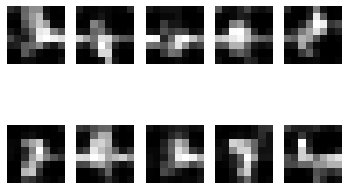

Batch 802/3750 - Opimize G - Avg Batch Loss: 0.3137 - Time : 0.38s
Batch 803/3750 - Opimize G - Avg Batch Loss: 0.0013 - Time : 0.38s
Batch 804/3750 - Opimize G - Avg Batch Loss: -0.0274 - Time : 0.39s
Batch 805/3750 - Opimize D - Avg Batch Loss: 0.0134 - Time : 0.37s
Batch 806/3750 - Opimize G - Avg Batch Loss: -0.1540 - Time : 0.38s
Batch 807/3750 - Opimize G - Avg Batch Loss: -0.0051 - Time : 0.38s
Batch 808/3750 - Opimize G - Avg Batch Loss: 0.0246 - Time : 0.39s
Batch 809/3750 - Opimize G - Avg Batch Loss: -0.0738 - Time : 0.39s
Batch 810/3750 - Opimize G - Avg Batch Loss: -0.0169 - Time : 0.37s
Batch 811/3750 - Opimize D - Avg Batch Loss: 0.0915 - Time : 0.38s
Batch 812/3750 - Opimize G - Avg Batch Loss: 0.0061 - Time : 0.37s
Batch 813/3750 - Opimize G - Avg Batch Loss: -0.0028 - Time : 0.37s
Batch 814/3750 - Opimize G - Avg Batch Loss: 0.4230 - Time : 0.38s
Batch 815/3750 - Opimize G - Avg Batch Loss: 0.2286 - Time : 0.39s
Batch 816/3750 - Opimize G - Avg Batch Loss: -0.0774 - T

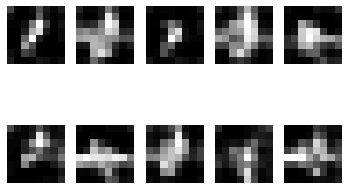

Batch 1002/3750 - Opimize G - Avg Batch Loss: 0.1243 - Time : 0.38s
Batch 1003/3750 - Opimize D - Avg Batch Loss: -0.1156 - Time : 0.39s
Batch 1004/3750 - Opimize G - Avg Batch Loss: 0.1788 - Time : 0.39s
Batch 1005/3750 - Opimize G - Avg Batch Loss: 0.0334 - Time : 0.38s
Batch 1006/3750 - Opimize G - Avg Batch Loss: -0.0029 - Time : 0.39s
Batch 1007/3750 - Opimize G - Avg Batch Loss: -0.0277 - Time : 0.37s
Batch 1008/3750 - Opimize G - Avg Batch Loss: -0.0923 - Time : 0.39s
Batch 1009/3750 - Opimize D - Avg Batch Loss: -0.0394 - Time : 0.39s
Batch 1010/3750 - Opimize G - Avg Batch Loss: -0.0119 - Time : 0.38s
Batch 1011/3750 - Opimize G - Avg Batch Loss: 0.2443 - Time : 0.37s
Batch 1012/3750 - Opimize G - Avg Batch Loss: 0.0512 - Time : 0.38s
Batch 1013/3750 - Opimize G - Avg Batch Loss: -0.0953 - Time : 0.37s
Batch 1014/3750 - Opimize G - Avg Batch Loss: 0.1769 - Time : 0.39s
Batch 1015/3750 - Opimize D - Avg Batch Loss: -0.0657 - Time : 0.37s
Batch 1016/3750 - Opimize G - Avg Batch 

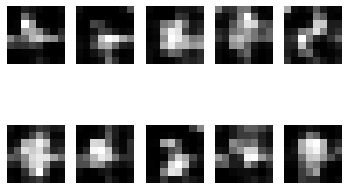

Batch 1202/3750 - Opimize G - Avg Batch Loss: 0.1800 - Time : 0.38s
Batch 1203/3750 - Opimize G - Avg Batch Loss: -0.0545 - Time : 0.38s
Batch 1204/3750 - Opimize G - Avg Batch Loss: 0.1650 - Time : 0.37s
Batch 1205/3750 - Opimize G - Avg Batch Loss: 0.0131 - Time : 0.37s
Batch 1206/3750 - Opimize G - Avg Batch Loss: -0.1212 - Time : 0.37s
Batch 1207/3750 - Opimize D - Avg Batch Loss: -0.1545 - Time : 0.37s
Batch 1208/3750 - Opimize G - Avg Batch Loss: -0.0966 - Time : 0.38s
Batch 1209/3750 - Opimize G - Avg Batch Loss: 0.0184 - Time : 0.40s
Batch 1210/3750 - Opimize G - Avg Batch Loss: 0.0307 - Time : 0.37s
Batch 1211/3750 - Opimize G - Avg Batch Loss: -0.0161 - Time : 0.37s
Batch 1212/3750 - Opimize G - Avg Batch Loss: -0.1047 - Time : 0.39s
Batch 1213/3750 - Opimize D - Avg Batch Loss: -0.0396 - Time : 0.37s
Batch 1214/3750 - Opimize G - Avg Batch Loss: 0.0879 - Time : 0.37s
Batch 1215/3750 - Opimize G - Avg Batch Loss: -0.1200 - Time : 0.37s
Batch 1216/3750 - Opimize G - Avg Batch 

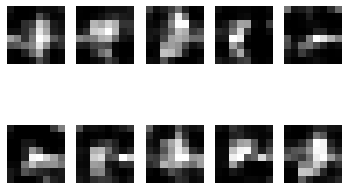

Batch 1402/3750 - Opimize G - Avg Batch Loss: 0.0094 - Time : 0.38s
Batch 1403/3750 - Opimize G - Avg Batch Loss: -0.0356 - Time : 0.37s
Batch 1404/3750 - Opimize G - Avg Batch Loss: -0.1827 - Time : 0.37s
Batch 1405/3750 - Opimize D - Avg Batch Loss: 0.0371 - Time : 0.39s
Batch 1406/3750 - Opimize G - Avg Batch Loss: 0.1034 - Time : 0.38s
Batch 1407/3750 - Opimize G - Avg Batch Loss: -0.0709 - Time : 0.40s
Batch 1408/3750 - Opimize G - Avg Batch Loss: -0.1395 - Time : 0.40s
Batch 1409/3750 - Opimize G - Avg Batch Loss: 0.0284 - Time : 0.37s
Batch 1410/3750 - Opimize G - Avg Batch Loss: 0.0213 - Time : 0.39s
Batch 1411/3750 - Opimize D - Avg Batch Loss: -0.0418 - Time : 0.38s
Batch 1412/3750 - Opimize G - Avg Batch Loss: 0.0376 - Time : 0.38s
Batch 1413/3750 - Opimize G - Avg Batch Loss: -0.0927 - Time : 0.39s
Batch 1414/3750 - Opimize G - Avg Batch Loss: -0.0994 - Time : 0.38s
Batch 1415/3750 - Opimize G - Avg Batch Loss: -0.0145 - Time : 0.38s
Batch 1416/3750 - Opimize G - Avg Batch 

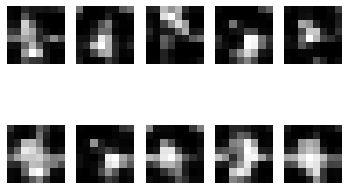

Batch 1602/3750 - Opimize G - Avg Batch Loss: 0.3006 - Time : 0.36s
Batch 1603/3750 - Opimize D - Avg Batch Loss: -0.0467 - Time : 0.37s
Batch 1604/3750 - Opimize G - Avg Batch Loss: 0.3006 - Time : 0.36s
Batch 1605/3750 - Opimize G - Avg Batch Loss: -0.0246 - Time : 0.37s
Batch 1606/3750 - Opimize G - Avg Batch Loss: -0.1373 - Time : 0.38s
Batch 1607/3750 - Opimize G - Avg Batch Loss: 0.0069 - Time : 0.36s
Batch 1608/3750 - Opimize G - Avg Batch Loss: 0.0235 - Time : 0.38s
Batch 1609/3750 - Opimize D - Avg Batch Loss: 0.0122 - Time : 0.38s
Batch 1610/3750 - Opimize G - Avg Batch Loss: -0.0077 - Time : 0.36s
Batch 1611/3750 - Opimize G - Avg Batch Loss: 0.0358 - Time : 0.38s
Batch 1612/3750 - Opimize G - Avg Batch Loss: 0.0739 - Time : 0.38s
Batch 1613/3750 - Opimize G - Avg Batch Loss: -0.0625 - Time : 0.38s
Batch 1614/3750 - Opimize G - Avg Batch Loss: 0.2489 - Time : 0.38s
Batch 1615/3750 - Opimize D - Avg Batch Loss: -0.0296 - Time : 0.36s
Batch 1616/3750 - Opimize G - Avg Batch Lo

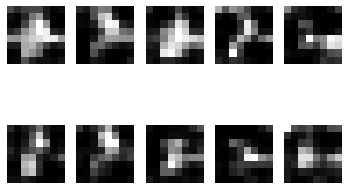

Batch 1802/3750 - Opimize G - Avg Batch Loss: 0.0906 - Time : 0.38s
Batch 1803/3750 - Opimize G - Avg Batch Loss: 0.0236 - Time : 0.37s
Batch 1804/3750 - Opimize G - Avg Batch Loss: 0.1300 - Time : 0.36s
Batch 1805/3750 - Opimize G - Avg Batch Loss: 0.0471 - Time : 0.38s
Batch 1806/3750 - Opimize G - Avg Batch Loss: -0.0262 - Time : 0.39s
Batch 1807/3750 - Opimize D - Avg Batch Loss: -0.1535 - Time : 0.37s
Batch 1808/3750 - Opimize G - Avg Batch Loss: -0.0577 - Time : 0.39s
Batch 1809/3750 - Opimize G - Avg Batch Loss: 0.0240 - Time : 0.35s
Batch 1810/3750 - Opimize G - Avg Batch Loss: 0.1119 - Time : 0.37s
Batch 1811/3750 - Opimize G - Avg Batch Loss: 0.1337 - Time : 0.36s
Batch 1812/3750 - Opimize G - Avg Batch Loss: -0.0233 - Time : 0.36s
Batch 1813/3750 - Opimize D - Avg Batch Loss: -0.0817 - Time : 0.38s
Batch 1814/3750 - Opimize G - Avg Batch Loss: 0.0865 - Time : 0.38s
Batch 1815/3750 - Opimize G - Avg Batch Loss: -0.1013 - Time : 0.36s
Batch 1816/3750 - Opimize G - Avg Batch Lo

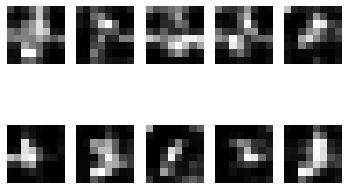

Batch 2002/3750 - Opimize G - Avg Batch Loss: 0.1627 - Time : 0.39s
Batch 2003/3750 - Opimize G - Avg Batch Loss: -0.0285 - Time : 0.38s
Batch 2004/3750 - Opimize G - Avg Batch Loss: -0.0483 - Time : 0.37s
Batch 2005/3750 - Opimize D - Avg Batch Loss: 0.0791 - Time : 0.38s
Batch 2006/3750 - Opimize G - Avg Batch Loss: 0.2170 - Time : 0.37s
Batch 2007/3750 - Opimize G - Avg Batch Loss: -0.1231 - Time : 0.37s
Batch 2008/3750 - Opimize G - Avg Batch Loss: 0.0381 - Time : 0.39s
Batch 2009/3750 - Opimize G - Avg Batch Loss: -0.0856 - Time : 0.36s
Batch 2010/3750 - Opimize G - Avg Batch Loss: 0.1276 - Time : 0.38s
Batch 2011/3750 - Opimize D - Avg Batch Loss: -0.0491 - Time : 0.35s
Batch 2012/3750 - Opimize G - Avg Batch Loss: 0.0164 - Time : 0.36s
Batch 2013/3750 - Opimize G - Avg Batch Loss: -0.0916 - Time : 0.37s
Batch 2014/3750 - Opimize G - Avg Batch Loss: -0.0408 - Time : 0.38s
Batch 2015/3750 - Opimize G - Avg Batch Loss: -0.0407 - Time : 0.37s
Batch 2016/3750 - Opimize G - Avg Batch 

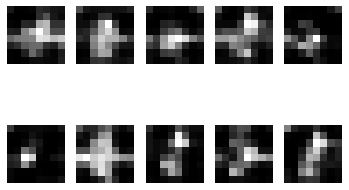

Batch 2202/3750 - Opimize G - Avg Batch Loss: 0.3118 - Time : 0.37s
Batch 2203/3750 - Opimize D - Avg Batch Loss: -0.0732 - Time : 0.38s
Batch 2204/3750 - Opimize G - Avg Batch Loss: -0.0621 - Time : 0.38s
Batch 2205/3750 - Opimize G - Avg Batch Loss: -0.0690 - Time : 0.35s
Batch 2206/3750 - Opimize G - Avg Batch Loss: 0.0473 - Time : 0.39s
Batch 2207/3750 - Opimize G - Avg Batch Loss: -0.1916 - Time : 0.37s
Batch 2208/3750 - Opimize G - Avg Batch Loss: 0.0167 - Time : 0.37s
Batch 2209/3750 - Opimize D - Avg Batch Loss: 0.0634 - Time : 0.38s
Batch 2210/3750 - Opimize G - Avg Batch Loss: 0.0242 - Time : 0.38s
Batch 2211/3750 - Opimize G - Avg Batch Loss: 0.0980 - Time : 0.38s
Batch 2212/3750 - Opimize G - Avg Batch Loss: -0.0862 - Time : 0.40s
Batch 2213/3750 - Opimize G - Avg Batch Loss: 0.0130 - Time : 0.36s
Batch 2214/3750 - Opimize G - Avg Batch Loss: 0.0300 - Time : 0.35s
Batch 2215/3750 - Opimize D - Avg Batch Loss: -0.0339 - Time : 0.37s
Batch 2216/3750 - Opimize G - Avg Batch Lo

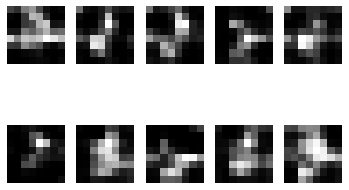

Batch 2402/3750 - Opimize G - Avg Batch Loss: -0.1423 - Time : 0.37s
Batch 2403/3750 - Opimize G - Avg Batch Loss: 0.1064 - Time : 0.36s
Batch 2404/3750 - Opimize G - Avg Batch Loss: 0.2119 - Time : 0.37s
Batch 2405/3750 - Opimize G - Avg Batch Loss: 0.0148 - Time : 0.36s
Batch 2406/3750 - Opimize G - Avg Batch Loss: -0.0884 - Time : 0.38s
Batch 2407/3750 - Opimize D - Avg Batch Loss: 0.2092 - Time : 0.37s
Batch 2408/3750 - Opimize G - Avg Batch Loss: 0.0529 - Time : 0.38s
Batch 2409/3750 - Opimize G - Avg Batch Loss: -0.0779 - Time : 0.37s
Batch 2410/3750 - Opimize G - Avg Batch Loss: 0.0773 - Time : 0.37s
Batch 2411/3750 - Opimize G - Avg Batch Loss: 0.0288 - Time : 0.39s
Batch 2412/3750 - Opimize G - Avg Batch Loss: 0.1613 - Time : 0.37s
Batch 2413/3750 - Opimize D - Avg Batch Loss: -0.1819 - Time : 0.38s
Batch 2414/3750 - Opimize G - Avg Batch Loss: -0.1600 - Time : 0.37s
Batch 2415/3750 - Opimize G - Avg Batch Loss: -0.1010 - Time : 0.37s
Batch 2416/3750 - Opimize G - Avg Batch Lo

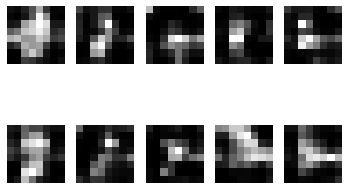

Batch 2602/3750 - Opimize G - Avg Batch Loss: -0.0031 - Time : 0.36s
Batch 2603/3750 - Opimize G - Avg Batch Loss: -0.0787 - Time : 0.37s
Batch 2604/3750 - Opimize G - Avg Batch Loss: 0.1040 - Time : 0.37s
Batch 2605/3750 - Opimize D - Avg Batch Loss: -0.0070 - Time : 0.38s
Batch 2606/3750 - Opimize G - Avg Batch Loss: 0.0593 - Time : 0.39s
Batch 2607/3750 - Opimize G - Avg Batch Loss: -0.1052 - Time : 0.37s
Batch 2608/3750 - Opimize G - Avg Batch Loss: -0.0575 - Time : 0.38s
Batch 2609/3750 - Opimize G - Avg Batch Loss: 0.0483 - Time : 0.36s
Batch 2610/3750 - Opimize G - Avg Batch Loss: -0.0567 - Time : 0.37s
Batch 2611/3750 - Opimize D - Avg Batch Loss: 0.0883 - Time : 0.39s
Batch 2612/3750 - Opimize G - Avg Batch Loss: 0.0486 - Time : 0.39s
Batch 2613/3750 - Opimize G - Avg Batch Loss: 0.2228 - Time : 0.39s
Batch 2614/3750 - Opimize G - Avg Batch Loss: 0.0262 - Time : 0.39s
Batch 2615/3750 - Opimize G - Avg Batch Loss: 0.0541 - Time : 0.37s
Batch 2616/3750 - Opimize G - Avg Batch Lo

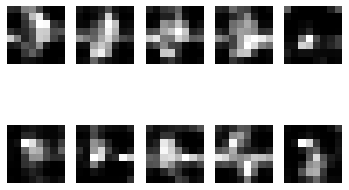

Batch 2802/3750 - Opimize G - Avg Batch Loss: 0.0395 - Time : 0.40s
Batch 2803/3750 - Opimize D - Avg Batch Loss: -0.0297 - Time : 0.37s
Batch 2804/3750 - Opimize G - Avg Batch Loss: -0.0198 - Time : 0.38s
Batch 2805/3750 - Opimize G - Avg Batch Loss: -0.0183 - Time : 0.38s
Batch 2806/3750 - Opimize G - Avg Batch Loss: 0.2204 - Time : 0.36s
Batch 2807/3750 - Opimize G - Avg Batch Loss: 0.0855 - Time : 0.37s
Batch 2808/3750 - Opimize G - Avg Batch Loss: 0.0226 - Time : 0.38s
Batch 2809/3750 - Opimize D - Avg Batch Loss: -0.0212 - Time : 0.37s
Batch 2810/3750 - Opimize G - Avg Batch Loss: 0.0473 - Time : 0.38s
Batch 2811/3750 - Opimize G - Avg Batch Loss: 0.0555 - Time : 0.39s
Batch 2812/3750 - Opimize G - Avg Batch Loss: -0.0434 - Time : 0.38s
Batch 2813/3750 - Opimize G - Avg Batch Loss: 0.0927 - Time : 0.38s
Batch 2814/3750 - Opimize G - Avg Batch Loss: 0.0640 - Time : 0.39s
Batch 2815/3750 - Opimize D - Avg Batch Loss: -0.0363 - Time : 0.38s
Batch 2816/3750 - Opimize G - Avg Batch Lo

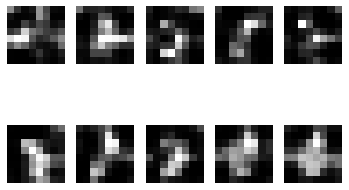

Batch 3002/3750 - Opimize G - Avg Batch Loss: -0.1723 - Time : 0.37s
Batch 3003/3750 - Opimize G - Avg Batch Loss: -0.0632 - Time : 0.38s
Batch 3004/3750 - Opimize G - Avg Batch Loss: 0.0836 - Time : 0.36s
Batch 3005/3750 - Opimize G - Avg Batch Loss: -0.0746 - Time : 0.37s
Batch 3006/3750 - Opimize G - Avg Batch Loss: -0.0998 - Time : 0.40s
Batch 3007/3750 - Opimize D - Avg Batch Loss: -0.0921 - Time : 0.38s
Batch 3008/3750 - Opimize G - Avg Batch Loss: -0.1813 - Time : 0.36s
Batch 3009/3750 - Opimize G - Avg Batch Loss: -0.0002 - Time : 0.38s
Batch 3010/3750 - Opimize G - Avg Batch Loss: 0.2006 - Time : 0.38s
Batch 3011/3750 - Opimize G - Avg Batch Loss: 0.1928 - Time : 0.38s
Batch 3012/3750 - Opimize G - Avg Batch Loss: 0.0889 - Time : 0.38s
Batch 3013/3750 - Opimize D - Avg Batch Loss: 0.0848 - Time : 0.38s
Batch 3014/3750 - Opimize G - Avg Batch Loss: 0.0075 - Time : 0.39s
Batch 3015/3750 - Opimize G - Avg Batch Loss: 0.0547 - Time : 0.37s
Batch 3016/3750 - Opimize G - Avg Batch L

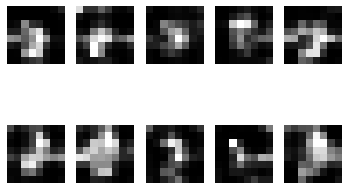

Batch 3202/3750 - Opimize G - Avg Batch Loss: -0.0482 - Time : 0.35s
Batch 3203/3750 - Opimize G - Avg Batch Loss: -0.0023 - Time : 0.36s
Batch 3204/3750 - Opimize G - Avg Batch Loss: 0.0113 - Time : 0.37s
Batch 3205/3750 - Opimize D - Avg Batch Loss: -0.0247 - Time : 0.37s
Batch 3206/3750 - Opimize G - Avg Batch Loss: 0.0755 - Time : 0.37s
Batch 3207/3750 - Opimize G - Avg Batch Loss: 0.0616 - Time : 0.38s
Batch 3208/3750 - Opimize G - Avg Batch Loss: -0.0125 - Time : 0.37s
Batch 3209/3750 - Opimize G - Avg Batch Loss: 0.1176 - Time : 0.37s
Batch 3210/3750 - Opimize G - Avg Batch Loss: 0.0665 - Time : 0.38s
Batch 3211/3750 - Opimize D - Avg Batch Loss: -0.0229 - Time : 0.38s
Batch 3212/3750 - Opimize G - Avg Batch Loss: 0.0472 - Time : 0.38s
Batch 3213/3750 - Opimize G - Avg Batch Loss: 0.2196 - Time : 0.38s
Batch 3214/3750 - Opimize G - Avg Batch Loss: 0.1159 - Time : 0.38s
Batch 3215/3750 - Opimize G - Avg Batch Loss: -0.0368 - Time : 0.38s
Batch 3216/3750 - Opimize G - Avg Batch Lo

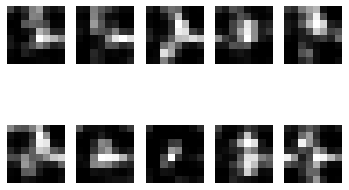

Batch 3402/3750 - Opimize G - Avg Batch Loss: 0.2022 - Time : 0.36s
Batch 3403/3750 - Opimize D - Avg Batch Loss: 0.0933 - Time : 0.39s
Batch 3404/3750 - Opimize G - Avg Batch Loss: 0.0269 - Time : 0.38s
Batch 3405/3750 - Opimize G - Avg Batch Loss: -0.0251 - Time : 0.39s
Batch 3406/3750 - Opimize G - Avg Batch Loss: -0.0741 - Time : 0.37s
Batch 3407/3750 - Opimize G - Avg Batch Loss: 0.1353 - Time : 0.39s
Batch 3408/3750 - Opimize G - Avg Batch Loss: -0.2435 - Time : 0.38s
Batch 3409/3750 - Opimize D - Avg Batch Loss: 0.1207 - Time : 0.38s
Batch 3410/3750 - Opimize G - Avg Batch Loss: 0.0223 - Time : 0.38s
Batch 3411/3750 - Opimize G - Avg Batch Loss: -0.1744 - Time : 0.37s
Batch 3412/3750 - Opimize G - Avg Batch Loss: -0.0278 - Time : 0.38s
Batch 3413/3750 - Opimize G - Avg Batch Loss: 0.0862 - Time : 0.37s
Batch 3414/3750 - Opimize G - Avg Batch Loss: 0.0545 - Time : 0.36s
Batch 3415/3750 - Opimize D - Avg Batch Loss: 0.0374 - Time : 0.37s
Batch 3416/3750 - Opimize G - Avg Batch Los

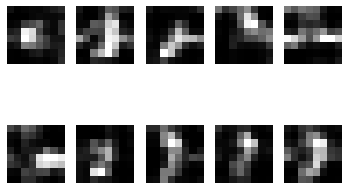

Batch 3602/3750 - Opimize G - Avg Batch Loss: -0.0121 - Time : 0.37s
Batch 3603/3750 - Opimize G - Avg Batch Loss: 0.0244 - Time : 0.39s
Batch 3604/3750 - Opimize G - Avg Batch Loss: 0.0844 - Time : 0.38s
Batch 3605/3750 - Opimize G - Avg Batch Loss: -0.0570 - Time : 0.39s
Batch 3606/3750 - Opimize G - Avg Batch Loss: -0.0589 - Time : 0.37s
Batch 3607/3750 - Opimize D - Avg Batch Loss: -0.1217 - Time : 0.37s
Batch 3608/3750 - Opimize G - Avg Batch Loss: 0.0206 - Time : 0.37s
Batch 3609/3750 - Opimize G - Avg Batch Loss: 0.2024 - Time : 0.37s
Batch 3610/3750 - Opimize G - Avg Batch Loss: 0.0060 - Time : 0.38s
Batch 3611/3750 - Opimize G - Avg Batch Loss: 0.1725 - Time : 0.37s
Batch 3612/3750 - Opimize G - Avg Batch Loss: -0.0197 - Time : 0.37s
Batch 3613/3750 - Opimize D - Avg Batch Loss: 0.3583 - Time : 0.37s
Batch 3614/3750 - Opimize G - Avg Batch Loss: 0.0239 - Time : 0.35s
Batch 3615/3750 - Opimize G - Avg Batch Loss: -0.0000 - Time : 0.35s
Batch 3616/3750 - Opimize G - Avg Batch Lo

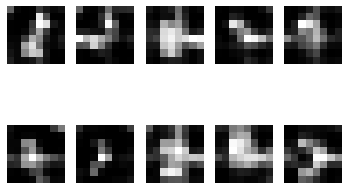

Batch 2/3750 - Opimize G - Avg Batch Loss: 0.0497 - Time : 0.35s
Batch 3/3750 - Opimize G - Avg Batch Loss: 0.0396 - Time : 0.38s
Batch 4/3750 - Opimize G - Avg Batch Loss: -0.0013 - Time : 0.38s
Batch 5/3750 - Opimize G - Avg Batch Loss: 0.0249 - Time : 0.36s
Batch 6/3750 - Opimize G - Avg Batch Loss: 0.0007 - Time : 0.37s
Batch 7/3750 - Opimize D - Avg Batch Loss: -0.2232 - Time : 0.36s
Batch 8/3750 - Opimize G - Avg Batch Loss: 0.0209 - Time : 0.36s
Batch 9/3750 - Opimize G - Avg Batch Loss: -0.0531 - Time : 0.37s
Batch 10/3750 - Opimize G - Avg Batch Loss: 0.1368 - Time : 0.38s
Batch 11/3750 - Opimize G - Avg Batch Loss: -0.0750 - Time : 0.37s
Batch 12/3750 - Opimize G - Avg Batch Loss: 0.0603 - Time : 0.38s
Batch 13/3750 - Opimize D - Avg Batch Loss: -0.1745 - Time : 0.36s
Batch 14/3750 - Opimize G - Avg Batch Loss: -0.0518 - Time : 0.37s
Batch 15/3750 - Opimize G - Avg Batch Loss: 0.0231 - Time : 0.41s
Batch 16/3750 - Opimize G - Avg Batch Loss: 0.0289 - Time : 0.36s
Batch 17/375

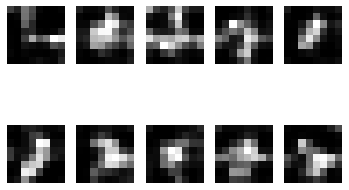

Batch 202/3750 - Opimize G - Avg Batch Loss: 0.0771 - Time : 0.37s
Batch 203/3750 - Opimize G - Avg Batch Loss: -0.0016 - Time : 0.37s
Batch 204/3750 - Opimize G - Avg Batch Loss: 0.0190 - Time : 0.38s
Batch 205/3750 - Opimize D - Avg Batch Loss: -0.0706 - Time : 0.37s
Batch 206/3750 - Opimize G - Avg Batch Loss: 0.2170 - Time : 0.37s
Batch 207/3750 - Opimize G - Avg Batch Loss: 0.1468 - Time : 0.37s
Batch 208/3750 - Opimize G - Avg Batch Loss: 0.0576 - Time : 0.37s
Batch 209/3750 - Opimize G - Avg Batch Loss: 0.0315 - Time : 0.39s
Batch 210/3750 - Opimize G - Avg Batch Loss: 0.0390 - Time : 0.38s
Batch 211/3750 - Opimize D - Avg Batch Loss: -0.0902 - Time : 0.36s
Batch 212/3750 - Opimize G - Avg Batch Loss: -0.0036 - Time : 0.38s
Batch 213/3750 - Opimize G - Avg Batch Loss: -0.2577 - Time : 0.35s
Batch 214/3750 - Opimize G - Avg Batch Loss: -0.0351 - Time : 0.36s
Batch 215/3750 - Opimize G - Avg Batch Loss: 0.0982 - Time : 0.38s
Batch 216/3750 - Opimize G - Avg Batch Loss: 0.0071 - Ti

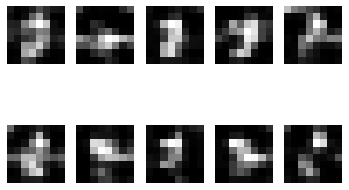

Batch 402/3750 - Opimize G - Avg Batch Loss: -0.3324 - Time : 0.37s
Batch 403/3750 - Opimize D - Avg Batch Loss: 0.0289 - Time : 0.37s
Batch 404/3750 - Opimize G - Avg Batch Loss: 0.1372 - Time : 0.37s
Batch 405/3750 - Opimize G - Avg Batch Loss: -0.0453 - Time : 0.35s
Batch 406/3750 - Opimize G - Avg Batch Loss: 0.0730 - Time : 0.36s
Batch 407/3750 - Opimize G - Avg Batch Loss: -0.1317 - Time : 0.38s
Batch 408/3750 - Opimize G - Avg Batch Loss: -0.0465 - Time : 0.37s
Batch 409/3750 - Opimize D - Avg Batch Loss: -0.1236 - Time : 0.37s
Batch 410/3750 - Opimize G - Avg Batch Loss: 0.2425 - Time : 0.37s
Batch 411/3750 - Opimize G - Avg Batch Loss: -0.0339 - Time : 0.36s
Batch 412/3750 - Opimize G - Avg Batch Loss: 0.0966 - Time : 0.39s
Batch 413/3750 - Opimize G - Avg Batch Loss: -0.0224 - Time : 0.36s
Batch 414/3750 - Opimize G - Avg Batch Loss: 0.0350 - Time : 0.38s
Batch 415/3750 - Opimize D - Avg Batch Loss: -0.0081 - Time : 0.39s
Batch 416/3750 - Opimize G - Avg Batch Loss: 0.0013 - 

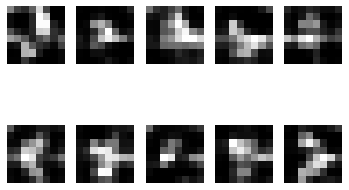

Batch 602/3750 - Opimize G - Avg Batch Loss: -0.0891 - Time : 0.36s
Batch 603/3750 - Opimize G - Avg Batch Loss: 0.0504 - Time : 0.36s
Batch 604/3750 - Opimize G - Avg Batch Loss: 0.0213 - Time : 0.39s
Batch 605/3750 - Opimize G - Avg Batch Loss: -0.2224 - Time : 0.37s
Batch 606/3750 - Opimize G - Avg Batch Loss: 0.1787 - Time : 0.36s
Batch 607/3750 - Opimize D - Avg Batch Loss: -0.0136 - Time : 0.38s
Batch 608/3750 - Opimize G - Avg Batch Loss: -0.0502 - Time : 0.37s
Batch 609/3750 - Opimize G - Avg Batch Loss: -0.0920 - Time : 0.36s
Batch 610/3750 - Opimize G - Avg Batch Loss: -0.1418 - Time : 0.37s
Batch 611/3750 - Opimize G - Avg Batch Loss: -0.0590 - Time : 0.36s
Batch 612/3750 - Opimize G - Avg Batch Loss: -0.0430 - Time : 0.40s
Batch 613/3750 - Opimize D - Avg Batch Loss: 0.4645 - Time : 0.36s
Batch 614/3750 - Opimize G - Avg Batch Loss: 0.0099 - Time : 0.36s
Batch 615/3750 - Opimize G - Avg Batch Loss: 0.0043 - Time : 0.38s
Batch 616/3750 - Opimize G - Avg Batch Loss: -0.0098 -

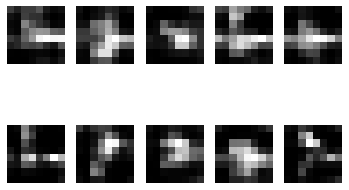

Batch 802/3750 - Opimize G - Avg Batch Loss: -0.0113 - Time : 0.39s
Batch 803/3750 - Opimize G - Avg Batch Loss: 0.0999 - Time : 0.36s
Batch 804/3750 - Opimize G - Avg Batch Loss: -0.1721 - Time : 0.38s
Batch 805/3750 - Opimize D - Avg Batch Loss: 0.0742 - Time : 0.37s
Batch 806/3750 - Opimize G - Avg Batch Loss: -0.0779 - Time : 0.36s
Batch 807/3750 - Opimize G - Avg Batch Loss: -0.0432 - Time : 0.39s
Batch 808/3750 - Opimize G - Avg Batch Loss: 0.2410 - Time : 0.38s
Batch 809/3750 - Opimize G - Avg Batch Loss: -0.0144 - Time : 0.35s
Batch 810/3750 - Opimize G - Avg Batch Loss: -0.0415 - Time : 0.37s
Batch 811/3750 - Opimize D - Avg Batch Loss: 0.0499 - Time : 0.36s
Batch 812/3750 - Opimize G - Avg Batch Loss: 0.0347 - Time : 0.37s
Batch 813/3750 - Opimize G - Avg Batch Loss: 0.0294 - Time : 0.37s
Batch 814/3750 - Opimize G - Avg Batch Loss: 0.1162 - Time : 0.36s
Batch 815/3750 - Opimize G - Avg Batch Loss: -0.1279 - Time : 0.38s
Batch 816/3750 - Opimize G - Avg Batch Loss: 0.0490 - T

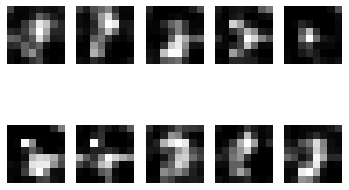

Batch 1002/3750 - Opimize G - Avg Batch Loss: -0.0867 - Time : 0.38s
Batch 1003/3750 - Opimize D - Avg Batch Loss: 0.4083 - Time : 0.38s
Batch 1004/3750 - Opimize G - Avg Batch Loss: -0.0075 - Time : 0.38s
Batch 1005/3750 - Opimize G - Avg Batch Loss: 0.0125 - Time : 0.37s
Batch 1006/3750 - Opimize G - Avg Batch Loss: -0.0824 - Time : 0.39s
Batch 1007/3750 - Opimize G - Avg Batch Loss: 0.0263 - Time : 0.35s
Batch 1008/3750 - Opimize G - Avg Batch Loss: -0.0785 - Time : 0.36s
Batch 1009/3750 - Opimize D - Avg Batch Loss: -0.1006 - Time : 0.39s
Batch 1010/3750 - Opimize G - Avg Batch Loss: 0.0785 - Time : 0.38s
Batch 1011/3750 - Opimize G - Avg Batch Loss: 0.1513 - Time : 0.38s
Batch 1012/3750 - Opimize G - Avg Batch Loss: -0.0758 - Time : 0.36s
Batch 1013/3750 - Opimize G - Avg Batch Loss: -0.0559 - Time : 0.37s
Batch 1014/3750 - Opimize G - Avg Batch Loss: 0.0019 - Time : 0.38s
Batch 1015/3750 - Opimize D - Avg Batch Loss: 0.0873 - Time : 0.36s
Batch 1016/3750 - Opimize G - Avg Batch L

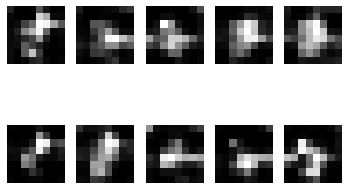

Batch 1202/3750 - Opimize G - Avg Batch Loss: -0.0696 - Time : 0.37s
Batch 1203/3750 - Opimize G - Avg Batch Loss: 0.0295 - Time : 0.35s
Batch 1204/3750 - Opimize G - Avg Batch Loss: -0.0126 - Time : 0.39s
Batch 1205/3750 - Opimize G - Avg Batch Loss: 0.2261 - Time : 0.36s
Batch 1206/3750 - Opimize G - Avg Batch Loss: -0.0789 - Time : 0.36s
Batch 1207/3750 - Opimize D - Avg Batch Loss: -0.0173 - Time : 0.39s
Batch 1208/3750 - Opimize G - Avg Batch Loss: -0.0259 - Time : 0.37s
Batch 1209/3750 - Opimize G - Avg Batch Loss: -0.0188 - Time : 0.39s
Batch 1210/3750 - Opimize G - Avg Batch Loss: -0.0728 - Time : 0.39s
Batch 1211/3750 - Opimize G - Avg Batch Loss: -0.0720 - Time : 0.36s
Batch 1212/3750 - Opimize G - Avg Batch Loss: 0.0816 - Time : 0.38s
Batch 1213/3750 - Opimize D - Avg Batch Loss: -0.1283 - Time : 0.37s
Batch 1214/3750 - Opimize G - Avg Batch Loss: 0.0431 - Time : 0.36s
Batch 1215/3750 - Opimize G - Avg Batch Loss: -0.1853 - Time : 0.38s
Batch 1216/3750 - Opimize G - Avg Batc

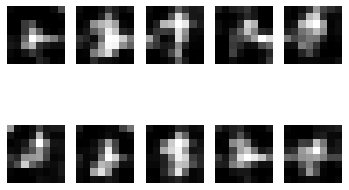

Batch 1402/3750 - Opimize G - Avg Batch Loss: 0.1508 - Time : 0.37s
Batch 1403/3750 - Opimize G - Avg Batch Loss: -0.0639 - Time : 0.40s
Batch 1404/3750 - Opimize G - Avg Batch Loss: -0.0281 - Time : 0.38s
Batch 1405/3750 - Opimize D - Avg Batch Loss: -0.0571 - Time : 0.35s
Batch 1406/3750 - Opimize G - Avg Batch Loss: 0.1195 - Time : 0.40s
Batch 1407/3750 - Opimize G - Avg Batch Loss: -0.0985 - Time : 0.36s
Batch 1408/3750 - Opimize G - Avg Batch Loss: -0.0617 - Time : 0.37s
Batch 1409/3750 - Opimize G - Avg Batch Loss: 0.0114 - Time : 0.38s
Batch 1410/3750 - Opimize G - Avg Batch Loss: -0.0691 - Time : 0.36s
Batch 1411/3750 - Opimize D - Avg Batch Loss: -0.0258 - Time : 0.36s
Batch 1412/3750 - Opimize G - Avg Batch Loss: 0.0106 - Time : 0.37s
Batch 1413/3750 - Opimize G - Avg Batch Loss: -0.0394 - Time : 0.37s
Batch 1414/3750 - Opimize G - Avg Batch Loss: 0.0243 - Time : 0.38s
Batch 1415/3750 - Opimize G - Avg Batch Loss: 0.1683 - Time : 0.36s
Batch 1416/3750 - Opimize G - Avg Batch 

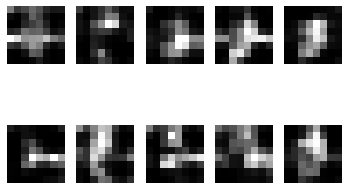

Batch 1602/3750 - Opimize G - Avg Batch Loss: -0.1776 - Time : 0.37s
Batch 1603/3750 - Opimize D - Avg Batch Loss: -0.0200 - Time : 0.39s
Batch 1604/3750 - Opimize G - Avg Batch Loss: 0.0036 - Time : 0.39s
Batch 1605/3750 - Opimize G - Avg Batch Loss: -0.0161 - Time : 0.38s
Batch 1606/3750 - Opimize G - Avg Batch Loss: 0.1653 - Time : 0.39s
Batch 1607/3750 - Opimize G - Avg Batch Loss: -0.0499 - Time : 0.38s
Batch 1608/3750 - Opimize G - Avg Batch Loss: 0.0239 - Time : 0.37s
Batch 1609/3750 - Opimize D - Avg Batch Loss: -0.1185 - Time : 0.38s
Batch 1610/3750 - Opimize G - Avg Batch Loss: 0.0402 - Time : 0.37s
Batch 1611/3750 - Opimize G - Avg Batch Loss: 0.0485 - Time : 0.39s
Batch 1612/3750 - Opimize G - Avg Batch Loss: -0.0190 - Time : 0.38s
Batch 1613/3750 - Opimize G - Avg Batch Loss: 0.0110 - Time : 0.37s
Batch 1614/3750 - Opimize G - Avg Batch Loss: -0.0359 - Time : 0.39s
Batch 1615/3750 - Opimize D - Avg Batch Loss: -0.1375 - Time : 0.37s
Batch 1616/3750 - Opimize G - Avg Batch 

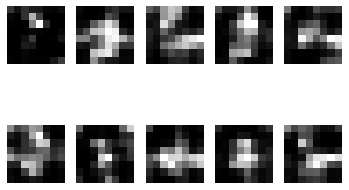

Batch 1802/3750 - Opimize G - Avg Batch Loss: -0.0129 - Time : 0.39s
Batch 1803/3750 - Opimize G - Avg Batch Loss: -0.0542 - Time : 0.38s
Batch 1804/3750 - Opimize G - Avg Batch Loss: -0.0432 - Time : 0.37s
Batch 1805/3750 - Opimize G - Avg Batch Loss: 0.0388 - Time : 0.38s
Batch 1806/3750 - Opimize G - Avg Batch Loss: 0.0766 - Time : 0.37s
Batch 1807/3750 - Opimize D - Avg Batch Loss: 0.0950 - Time : 0.36s
Batch 1808/3750 - Opimize G - Avg Batch Loss: -0.0839 - Time : 0.38s
Batch 1809/3750 - Opimize G - Avg Batch Loss: -0.0166 - Time : 0.36s
Batch 1810/3750 - Opimize G - Avg Batch Loss: -0.0120 - Time : 0.40s
Batch 1811/3750 - Opimize G - Avg Batch Loss: 0.0083 - Time : 0.40s
Batch 1812/3750 - Opimize G - Avg Batch Loss: 0.0194 - Time : 0.38s
Batch 1813/3750 - Opimize D - Avg Batch Loss: -0.1083 - Time : 0.37s
Batch 1814/3750 - Opimize G - Avg Batch Loss: 0.0147 - Time : 0.36s
Batch 1815/3750 - Opimize G - Avg Batch Loss: 0.0601 - Time : 0.36s
Batch 1816/3750 - Opimize G - Avg Batch L

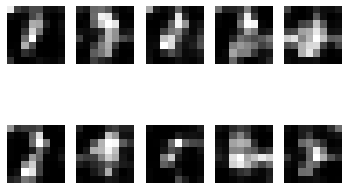

Batch 2002/3750 - Opimize G - Avg Batch Loss: -0.0436 - Time : 0.37s
Batch 2003/3750 - Opimize G - Avg Batch Loss: 0.0566 - Time : 0.37s
Batch 2004/3750 - Opimize G - Avg Batch Loss: -0.0082 - Time : 0.38s
Batch 2005/3750 - Opimize D - Avg Batch Loss: 0.1696 - Time : 0.37s
Batch 2006/3750 - Opimize G - Avg Batch Loss: -0.0909 - Time : 0.37s
Batch 2007/3750 - Opimize G - Avg Batch Loss: -0.0410 - Time : 0.38s
Batch 2008/3750 - Opimize G - Avg Batch Loss: 0.0049 - Time : 0.37s
Batch 2009/3750 - Opimize G - Avg Batch Loss: -0.0175 - Time : 0.38s
Batch 2010/3750 - Opimize G - Avg Batch Loss: 0.1564 - Time : 0.39s
Batch 2011/3750 - Opimize D - Avg Batch Loss: -0.1986 - Time : 0.37s
Batch 2012/3750 - Opimize G - Avg Batch Loss: -0.1044 - Time : 0.39s
Batch 2013/3750 - Opimize G - Avg Batch Loss: 0.0046 - Time : 0.37s
Batch 2014/3750 - Opimize G - Avg Batch Loss: -0.1260 - Time : 0.37s
Batch 2015/3750 - Opimize G - Avg Batch Loss: -0.0144 - Time : 0.38s
Batch 2016/3750 - Opimize G - Avg Batch

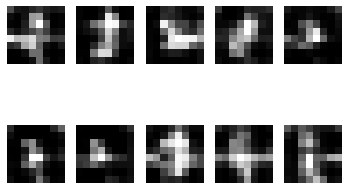

Batch 2202/3750 - Opimize G - Avg Batch Loss: -0.0782 - Time : 0.37s
Batch 2203/3750 - Opimize D - Avg Batch Loss: -0.0766 - Time : 0.38s
Batch 2204/3750 - Opimize G - Avg Batch Loss: -0.1410 - Time : 0.38s
Batch 2205/3750 - Opimize G - Avg Batch Loss: -0.0791 - Time : 0.36s
Batch 2206/3750 - Opimize G - Avg Batch Loss: 0.0833 - Time : 0.38s
Batch 2207/3750 - Opimize G - Avg Batch Loss: 0.0708 - Time : 0.37s
Batch 2208/3750 - Opimize G - Avg Batch Loss: 0.0018 - Time : 0.37s
Batch 2209/3750 - Opimize D - Avg Batch Loss: -0.0903 - Time : 0.37s
Batch 2210/3750 - Opimize G - Avg Batch Loss: -0.0456 - Time : 0.37s
Batch 2211/3750 - Opimize G - Avg Batch Loss: 0.0358 - Time : 0.39s
Batch 2212/3750 - Opimize G - Avg Batch Loss: -0.1108 - Time : 0.38s
Batch 2213/3750 - Opimize G - Avg Batch Loss: 0.1103 - Time : 0.36s
Batch 2214/3750 - Opimize G - Avg Batch Loss: 0.0664 - Time : 0.41s
Batch 2215/3750 - Opimize D - Avg Batch Loss: -0.1146 - Time : 0.37s
Batch 2216/3750 - Opimize G - Avg Batch 

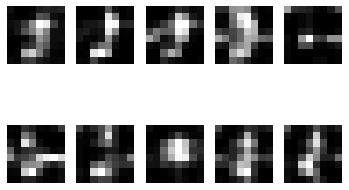

Batch 2402/3750 - Opimize G - Avg Batch Loss: 0.0097 - Time : 0.38s
Batch 2403/3750 - Opimize G - Avg Batch Loss: -0.0452 - Time : 0.37s
Batch 2404/3750 - Opimize G - Avg Batch Loss: 0.1305 - Time : 0.38s
Batch 2405/3750 - Opimize G - Avg Batch Loss: -0.0008 - Time : 0.39s
Batch 2406/3750 - Opimize G - Avg Batch Loss: 0.0029 - Time : 0.37s
Batch 2407/3750 - Opimize D - Avg Batch Loss: 0.0442 - Time : 0.38s
Batch 2408/3750 - Opimize G - Avg Batch Loss: -0.1147 - Time : 0.38s
Batch 2409/3750 - Opimize G - Avg Batch Loss: 0.0147 - Time : 0.36s
Batch 2410/3750 - Opimize G - Avg Batch Loss: 0.2312 - Time : 0.38s
Batch 2411/3750 - Opimize G - Avg Batch Loss: 0.0413 - Time : 0.37s
Batch 2412/3750 - Opimize G - Avg Batch Loss: 0.0764 - Time : 0.37s
Batch 2413/3750 - Opimize D - Avg Batch Loss: -0.0968 - Time : 0.39s
Batch 2414/3750 - Opimize G - Avg Batch Loss: -0.1110 - Time : 0.36s
Batch 2415/3750 - Opimize G - Avg Batch Loss: -0.0487 - Time : 0.38s
Batch 2416/3750 - Opimize G - Avg Batch Lo

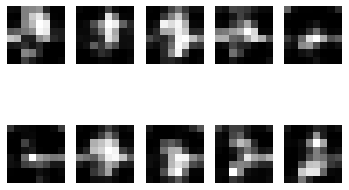

Batch 2602/3750 - Opimize G - Avg Batch Loss: 0.1406 - Time : 0.39s
Batch 2603/3750 - Opimize G - Avg Batch Loss: -0.0669 - Time : 0.38s
Batch 2604/3750 - Opimize G - Avg Batch Loss: 0.2475 - Time : 0.38s
Batch 2605/3750 - Opimize D - Avg Batch Loss: 0.0330 - Time : 0.37s
Batch 2606/3750 - Opimize G - Avg Batch Loss: -0.0060 - Time : 0.36s
Batch 2607/3750 - Opimize G - Avg Batch Loss: -0.0838 - Time : 0.37s
Batch 2608/3750 - Opimize G - Avg Batch Loss: -0.0027 - Time : 0.38s
Batch 2609/3750 - Opimize G - Avg Batch Loss: -0.1872 - Time : 0.37s
Batch 2610/3750 - Opimize G - Avg Batch Loss: -0.0926 - Time : 0.40s
Batch 2611/3750 - Opimize D - Avg Batch Loss: -0.0488 - Time : 0.40s
Batch 2612/3750 - Opimize G - Avg Batch Loss: 0.0135 - Time : 0.41s
Batch 2613/3750 - Opimize G - Avg Batch Loss: 0.0098 - Time : 0.38s
Batch 2614/3750 - Opimize G - Avg Batch Loss: -0.1243 - Time : 0.37s
Batch 2615/3750 - Opimize G - Avg Batch Loss: 0.0755 - Time : 0.38s
Batch 2616/3750 - Opimize G - Avg Batch 

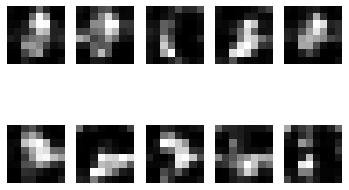

Batch 2802/3750 - Opimize G - Avg Batch Loss: 0.0308 - Time : 0.38s
Batch 2803/3750 - Opimize D - Avg Batch Loss: -0.0449 - Time : 0.38s
Batch 2804/3750 - Opimize G - Avg Batch Loss: 0.5025 - Time : 0.38s
Batch 2805/3750 - Opimize G - Avg Batch Loss: -0.0269 - Time : 0.37s
Batch 2806/3750 - Opimize G - Avg Batch Loss: -0.0567 - Time : 0.39s
Batch 2807/3750 - Opimize G - Avg Batch Loss: -0.0322 - Time : 0.38s
Batch 2808/3750 - Opimize G - Avg Batch Loss: 0.0250 - Time : 0.40s
Batch 2809/3750 - Opimize D - Avg Batch Loss: -0.0392 - Time : 0.37s
Batch 2810/3750 - Opimize G - Avg Batch Loss: -0.0740 - Time : 0.36s
Batch 2811/3750 - Opimize G - Avg Batch Loss: 0.0543 - Time : 0.38s
Batch 2812/3750 - Opimize G - Avg Batch Loss: 0.0055 - Time : 0.37s
Batch 2813/3750 - Opimize G - Avg Batch Loss: 0.1758 - Time : 0.36s
Batch 2814/3750 - Opimize G - Avg Batch Loss: -0.0185 - Time : 0.39s
Batch 2815/3750 - Opimize D - Avg Batch Loss: -0.1169 - Time : 0.41s
Batch 2816/3750 - Opimize G - Avg Batch 

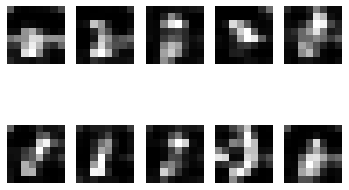

Batch 3002/3750 - Opimize G - Avg Batch Loss: 0.0347 - Time : 0.37s
Batch 3003/3750 - Opimize G - Avg Batch Loss: -0.0331 - Time : 0.37s
Batch 3004/3750 - Opimize G - Avg Batch Loss: -0.0344 - Time : 0.36s
Batch 3005/3750 - Opimize G - Avg Batch Loss: -0.1235 - Time : 0.37s
Batch 3006/3750 - Opimize G - Avg Batch Loss: -0.0147 - Time : 0.38s
Batch 3007/3750 - Opimize D - Avg Batch Loss: -0.0386 - Time : 0.37s
Batch 3008/3750 - Opimize G - Avg Batch Loss: -0.0286 - Time : 0.39s
Batch 3009/3750 - Opimize G - Avg Batch Loss: 0.0337 - Time : 0.36s
Batch 3010/3750 - Opimize G - Avg Batch Loss: 0.0277 - Time : 0.38s
Batch 3011/3750 - Opimize G - Avg Batch Loss: -0.0239 - Time : 0.38s
Batch 3012/3750 - Opimize G - Avg Batch Loss: -0.0504 - Time : 0.36s
Batch 3013/3750 - Opimize D - Avg Batch Loss: -0.0696 - Time : 0.37s
Batch 3014/3750 - Opimize G - Avg Batch Loss: -0.0465 - Time : 0.37s
Batch 3015/3750 - Opimize G - Avg Batch Loss: 0.1554 - Time : 0.37s
Batch 3016/3750 - Opimize G - Avg Batc

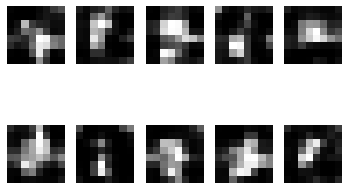

Batch 3202/3750 - Opimize G - Avg Batch Loss: -0.0600 - Time : 0.37s
Batch 3203/3750 - Opimize G - Avg Batch Loss: 0.0015 - Time : 0.38s
Batch 3204/3750 - Opimize G - Avg Batch Loss: 0.0303 - Time : 0.37s
Batch 3205/3750 - Opimize D - Avg Batch Loss: -0.0597 - Time : 0.37s
Batch 3206/3750 - Opimize G - Avg Batch Loss: -0.1195 - Time : 0.37s
Batch 3207/3750 - Opimize G - Avg Batch Loss: 0.2276 - Time : 0.37s
Batch 3208/3750 - Opimize G - Avg Batch Loss: 0.2552 - Time : 0.37s
Batch 3209/3750 - Opimize G - Avg Batch Loss: -0.0270 - Time : 0.38s
Batch 3210/3750 - Opimize G - Avg Batch Loss: 0.0307 - Time : 0.37s
Batch 3211/3750 - Opimize D - Avg Batch Loss: 0.0609 - Time : 0.37s
Batch 3212/3750 - Opimize G - Avg Batch Loss: 0.0821 - Time : 0.38s
Batch 3213/3750 - Opimize G - Avg Batch Loss: 0.0710 - Time : 0.36s
Batch 3214/3750 - Opimize G - Avg Batch Loss: -0.0180 - Time : 0.37s
Batch 3215/3750 - Opimize G - Avg Batch Loss: -0.0324 - Time : 0.38s
Batch 3216/3750 - Opimize G - Avg Batch Lo

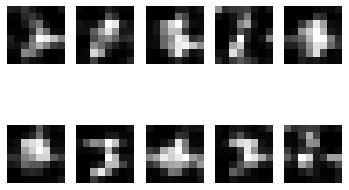

Batch 3402/3750 - Opimize G - Avg Batch Loss: -0.1352 - Time : 0.37s
Batch 3403/3750 - Opimize D - Avg Batch Loss: -0.0218 - Time : 0.37s
Batch 3404/3750 - Opimize G - Avg Batch Loss: 0.0574 - Time : 0.40s
Batch 3405/3750 - Opimize G - Avg Batch Loss: 0.2157 - Time : 0.36s
Batch 3406/3750 - Opimize G - Avg Batch Loss: 0.0622 - Time : 0.37s
Batch 3407/3750 - Opimize G - Avg Batch Loss: -0.0116 - Time : 0.38s
Batch 3408/3750 - Opimize G - Avg Batch Loss: 0.0939 - Time : 0.36s
Batch 3409/3750 - Opimize D - Avg Batch Loss: 0.1017 - Time : 0.38s
Batch 3410/3750 - Opimize G - Avg Batch Loss: 0.0623 - Time : 0.39s
Batch 3411/3750 - Opimize G - Avg Batch Loss: -0.1884 - Time : 0.38s
Batch 3412/3750 - Opimize G - Avg Batch Loss: 0.0168 - Time : 0.37s
Batch 3413/3750 - Opimize G - Avg Batch Loss: -0.1583 - Time : 0.37s
Batch 3414/3750 - Opimize G - Avg Batch Loss: 0.0384 - Time : 0.37s
Batch 3415/3750 - Opimize D - Avg Batch Loss: -0.0541 - Time : 0.37s
Batch 3416/3750 - Opimize G - Avg Batch Lo

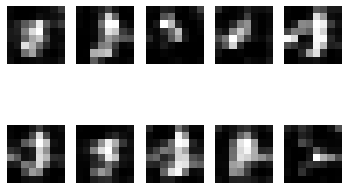

Batch 3602/3750 - Opimize G - Avg Batch Loss: -0.0278 - Time : 0.38s
Batch 3603/3750 - Opimize G - Avg Batch Loss: -0.0309 - Time : 0.39s
Batch 3604/3750 - Opimize G - Avg Batch Loss: 0.2085 - Time : 0.37s
Batch 3605/3750 - Opimize G - Avg Batch Loss: 0.0696 - Time : 0.37s
Batch 3606/3750 - Opimize G - Avg Batch Loss: -0.0493 - Time : 0.36s
Batch 3607/3750 - Opimize D - Avg Batch Loss: 0.0231 - Time : 0.38s
Batch 3608/3750 - Opimize G - Avg Batch Loss: 0.0098 - Time : 0.37s
Batch 3609/3750 - Opimize G - Avg Batch Loss: -0.0218 - Time : 0.38s
Batch 3610/3750 - Opimize G - Avg Batch Loss: -0.0658 - Time : 0.38s
Batch 3611/3750 - Opimize G - Avg Batch Loss: -0.0583 - Time : 0.38s
Batch 3612/3750 - Opimize G - Avg Batch Loss: 0.1935 - Time : 0.37s
Batch 3613/3750 - Opimize D - Avg Batch Loss: 0.1550 - Time : 0.38s
Batch 3614/3750 - Opimize G - Avg Batch Loss: -0.0577 - Time : 0.38s
Batch 3615/3750 - Opimize G - Avg Batch Loss: 0.0736 - Time : 0.37s
Batch 3616/3750 - Opimize G - Avg Batch L

In [39]:
history4 = train(n_gen=5, n_epochs = 4, batch_size = 16, plt_samples = 200)

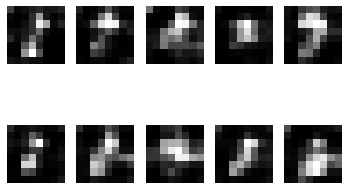

In [43]:
generate_plt()

In [0]:
np.savetxt("history_batch16_4epochs.txt",history4)

In [0]:
torch.save(generator.state_dict(), "generatorCNN_batch16_4epochs.statedict")
torch.save(discriminator.state_dict(), "discriminatorCNN_batch16_4epochs.statedict")

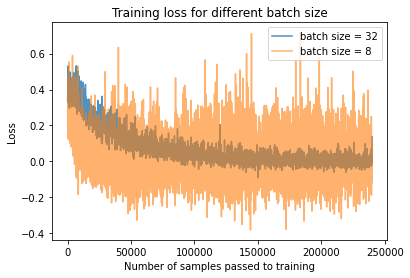

In [53]:
plt.plot(64*np.arange(len(history)), history, label = "batch size = 32", alpha=0.8)
plt.plot(16*np.arange(len(history4)), history4, label = "batch size = 8", alpha=0.6)
plt.xlabel("Number of samples passed to training")
plt.ylabel("Loss")
plt.legend()
plt.title("Training loss for different batch size")
plt.show()